# DST - Variational Auto-Encoder - Version 1.0

## Importing the required packages

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

#from custom_dataset_from_file import CustomDatasetFromFile
# Gensim
import gensim
##import gensim.corpora as corpora
##from gensim.utils import simple_preprocess
##from gensim.models import CoherenceModel
##from gensim.models import Word2Vec
import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
import spacy
import copy


#My code
import json
from torch.utils.data.dataset import Dataset  # For custom datasets

from itertools import combinations
import operator



#import torch
from torch import nn
from tqdm.auto import tqdm
#from torchvision import transforms
#from torchvision.datasets import MNIST # Training dataset
#from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import timeit



#torch.manual_seed(0) # Set for testing purposes, please do not change!

#import numpy as np
#Load pretrained_model
#pretrained_model = api.load('glove-twitter-50') 
#pretrained_model2 = api.load('glove-twitter-50') 

# Defining the VAE model

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #Encoder
        self.fc1 = nn.Linear(50, 40)
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, 20)
        self.fc4 = nn.Linear(20, 15)
        self.fc5 = nn.Linear(15,10)
        
        self.fc6_mu = nn.Linear(10, 5)
        self.fc6_sig = nn.Linear(10, 5)
        
        #Decoder
        self.fc7 = nn.Linear(5, 10)
        self.fc8 = nn.Linear(10, 15)
        self.fc9 = nn.Linear(15, 20)
        self.fc10 = nn.Linear(20, 30)
        self.fc11 = nn.Linear(30, 40)
        self.fc12 = nn.Linear(40, 50)

    def encode(self,x):
        
        z1 = self.fc1(x)  #50D --> 40D
        a1 = F.leaky_relu(z1, 0.1)#, inplace = True)
        
        z2 = self.fc2(a1) #40D --> 30D
        a2 = F.leaky_relu(z2, 0.1)#, inplace = True)
        
        z3 = self.fc3(a2) #30D --> 20D
        a3 = F.leaky_relu(z3, 0.1)#, inplace = True)
        
        
        z4 = self.fc4(a3) #20D --> 15D
        a4 = F.leaky_relu(z4, 0.1)#, inplace = True)
        
        z5 = self.fc5(a4) #15D --> 10D
        a5 = F.leaky_relu(z5, 0.1)#, inplace = True)
        
        z6_mu = self.fc6_mu(a5)       #10D --> 5D
        z6_logvar = self.fc6_sig(a5)  #No activation function at the final layer of the encoder
        
        
        return z6_mu, z6_logvar
  
    def decode(self,z):
        
        z1 = self.fc7(z)  #5D --> 10D
        a1 = F.leaky_relu(z1, 0.1)#, inplace = True)
        
        z2 = self.fc8(a1) #10D --> 15D
        a2 = F.leaky_relu(z2, 0.1)#, inplace = True)
        
        z3 = self.fc9(a2) #15D --> 20D
        a3 = F.leaky_relu(z3, 0.1)#, inplace = True)
        
        z4 = self.fc10(a3) #20D --> 30D
        a4 = F.leaky_relu(z4, 0.1)#, inplace = True)
        
        z5 = self.fc11(a4) #30D --> 40D
        a5 = F.leaky_relu(z5, 0.1)#, inplace = True)
        
        z6 = self.fc12(a5) #40D --> 50D, no activation function at the final layer
        
        return z6
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

In [3]:
def vae_loss_function(recon_x, x, mu, logvar, BETA = 1.0):
    
    BCE = F.mse_loss(recon_x, x, reduction='sum') #Default value: size_average=None, reduce=None, reduction='mean')    
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE, BETA * KLD

## Defining the GAN model

In [4]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        #nn.BatchNorm1d(output_dim),
        #nn.ReLU(inplace=True),
        nn.LeakyReLU(0.1), #inplace=True),
    )

In [5]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the input data, an integer
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=5, im_dim=50, hidden_dim=10):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(5, 10),                #5D --> 10D
            get_generator_block(10, 15),               #10D --> 15D
            get_generator_block(15, 20),               #15D --> 20D
            get_generator_block(20, 30),               #20D --> 30D
            get_generator_block(30, 40),               #30D --> 40D
            get_generator_block(40, 45),               #30D --> 40D
            nn.Linear(45, im_dim),                     #40D --> 50D, there is no activation at the final layer
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [6]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    return torch.randn((n_samples, z_dim), device=device)

In [7]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(        
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.1)
    )

In [8]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the input dat, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=50, hidden_dim=10):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, 45),  #50D --> 45D
            get_discriminator_block(45, 40),      #45D --> 40D
            get_discriminator_block(40, 30),      #40D --> 30D
            get_discriminator_block(30, 20),      #30D --> 20D
            get_discriminator_block(20, 15),      #20D --> 15D
            get_discriminator_block(15, 10),      #15D --> 10D
            get_discriminator_block(10, 5),       #10D --> 5D

            # No activation at the final layer because we want to transform 
            # the final output into a single value.
            nn.Linear(5, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [9]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     Note: Please do not use concatenation in your solution. The tests are being updated to 
    #           support this, but for now, average the two losses as described in step (4).
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    noise = get_noise(num_images, z_dim, device)
    fake_loss = criterion(disc(gen(noise).detach()), torch.zeros(num_images, 1).to(device))
    real_loss = criterion(disc(real), torch.ones(num_images, 1).to(device))
    disc_loss = (fake_loss + real_loss) / 2
    return disc_loss

In [10]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    noise = get_noise(num_images, z_dim, device)
    gen_loss = criterion(disc(gen(noise)), torch.ones(num_images, 1).to(device))
    return gen_loss

## Preparing Dataset

In [12]:
class CustomDatasetFromFile(Dataset):
    def __init__(self, user_corpus, user_hashtags, pretrained_model, test_ratio = 0.05, argmentation = 0):
        """
        A dataset example where the class is embedded in the file names
        This data example also does not use any torch transforms

        Args:
            folder_path (string): path to image folder
        """
        print("Init running")
        self.user_hashtags = user_hashtags
        
        #Split user corpus into train and test corpus based on the ratio
        self.length = int(test_ratio * len(user_corpus))
        self.train_corpus = user_corpus[self.length : ]
        self.test_corpus = user_corpus[ : self.length]
        
        #print("len(train_test_ratio) = ", self.length)
        #print("len(user_corpus) = ", len(user_corpus))
        #print("len(train_corpus) = ", len(self.train_corpus))
        #print("len(test_corpus) = ", len(self.test_corpus))
        
        #From corpus to token_list: spit all sentences into single token
        self.train_user_token_lst = self.corpus_to_token_list(self.train_corpus, pretrained_model)
        self.test_user_token_lst = self.corpus_to_token_list(self.test_corpus, pretrained_model)

        #print("len(train_user_token_lst) = ", len(self.train_user_token_lst))
        #print("len(test_user_token_lst) = ", len(self.test_user_token_lst))
        
        #Data argumentation
        if argmentation > 0:
            self.train_user_token_lst = self.data_augmentation(self.train_user_token_lst, argmentation)
            print("After argumentation len(train_user_token_lst) = ", len(self.train_user_token_lst))


        # Calculate len
        self.data_len = len(self.train_user_token_lst)
        #self.data_len = len(self.image_list)

    def __getitem__(self, index):
         
        #Read word by word
        #Each element of user_token_lst is a tuple of two parts: ('word', [vector in array format])
        label = self.train_user_token_lst[index][0] #extract the first part of the tuple for 'word'
        vector = self.train_user_token_lst[index][1]#extract the second part of the tuple for vector (array) of word
                
        # Transform word vector into array type
        vector_as_np = np.asarray(vector)

        # Transform image to tensor, change data type into float
        vector_as_tensor = torch.from_numpy(vector_as_np).float()
        
        return (vector_as_tensor, label)

    def __len__(self):
        return self.data_len
    
    def get_user_token_lst(self):        
        return self.train_user_token_lst, self.test_user_token_lst

    def get_train_test_corpus(self):
        return self.train_corpus, self.test_corpus
    
    def get_user_hashtags(self):
        return self.user_hashtags
    
    def corpus_to_token_list(self, corpus, pretrained_model):
        """
        This function tokenize all sentences into list of words.

        Args:
            corpus: all sentences within a time interval
            pretrained_model: Glove model
        """
        token_lst = []
        nlp_pos = spacy.load("en_core_web_sm")

        for sentence in corpus:
            for word in sentence:
                #Just considering Nouns and counting the duplicate words
                if (nlp_pos(word)[0].pos_ == 'NOUN') and (word in pretrained_model.vocab):
                    token_lst.append((word, pretrained_model[word]))
        
        return token_lst
    
    def data_augmentation(self, token_lst, num):
        new_lst = []
        
        for i in range (num):
            new_lst.extend(token_lst)
            
        return new_lst

## Defining some auxiliary functions

In [13]:
import matplotlib.pyplot as plt

def plot_graph_(mean_generator_loss_lst, mean_discriminator_loss_lst):
    plt.clf()
    
    print("len(mean_generator_loss_lst) = ", len(mean_generator_loss_lst))
    x = range(0, len(mean_generator_loss_lst), 1)
    # plotting the line 1 points    
    plt.plot(x, mean_generator_loss_lst, marker='o', label = "generator_loss")
    plt.plot(x, mean_discriminator_loss_lst, marker='v', label = "discriminator_loss")
 
    plt.xlabel('Steps - n')
    
    plt.ylabel('Mean loss at step n')

        
    # Set a title of the current axes.
    plt.title("Mean loss of Generator vs Discriminator")

    # show a legend on the plot
    plt.legend(ncol=2)
    #save the figure
    #plt.savefig(title + '.png')
    #display a figure.
    plt.show()
    #close the figure
    plt.close()
    
    return 1

def find_user_vocab(user_token_lst):
    stopset = set(stopwords.words('english'))
    stopset.add("could")
    stopset.add("would")
    
    #print("len(user_token_lst) = ", len(user_token_lst))
    user_vocab = set()
    for item in user_token_lst:
        if item[0] not in user_vocab:
            user_vocab.add(item[0])
    return user_vocab - stopset

def restrict_wordset_English(train_user_token_lst):
    stopset = set(stopwords.words('english'))
    stopset.add("could")
    stopset.add("would")
    
    w_English = set(nltk.corpus.words.words())
    w_English = w_English - stopset
    user_dictionary = find_user_vocab(train_user_token_lst) #train_dataset.get_user_dictionary()
    #print("len(user_dictionary) = ", len(user_dictionary))
    #print("Before len(w_English) = ", len(w_English))
    w_English = w_English.union(user_dictionary)
    #print("After len(w_English) = ", len(w_English))
    
    return w_English

def restrict_pretrained_model(w2v, restricted_word_set):
    """
        Restrict the pretrained model for runtime efficiency.
        We just consider English words.
    """
    new_vectors = []
    new_vocab = {}
    new_index2entity = []
    new_vectors_norm = []
    
    for i in range(len(w2v.vocab)):
        word = w2v.index2entity[i]
        vec = w2v.vectors[i]
        vocab = w2v.vocab[word]
            
        vec_norm = w2v.vectors_norm[i]
        if word in restricted_word_set:
            vocab.index = len(new_index2entity)
            new_index2entity.append(word)
            new_vocab[word] = vocab
            new_vectors.append(vec)
            new_vectors_norm.append(vec_norm)

    w2v.vocab = new_vocab
    w2v.vectors = new_vectors
    #w2v.vectors = numpy.array(new_vectors)
    w2v.index2entity = new_index2entity
    w2v.index2word = new_index2entity
    w2v.vectors_norm = new_vectors_norm
    
    return w2v

def find_reconstructed_word(pretrained_model, user_dictionary, dataloader, vae_model):

    """
        This function is used for checking the reconstructed word and orginal word.
        It is usedful for overfitting checking during training VAE
    """
    restricted_model = restrict_pretrained_model(pretrained_model, user_dictionary)

    #restricted_model = pretrained_model
    print("len(restricted_pretrained_model.vocab) = ", len(restricted_model.vocab))
    
    for i, (original_vector_bacth, true_word_batch) in enumerate(dataloader):
        reconstruct_vector_batch, mu, logvar = vae_model(original_vector_bacth)
        
        #if i < 10: #just inspect the first batch and compare reconstructed words with original ones
        #    print("Batch: {}".format(i))
        
        #reconstruct_vector_lst = []
        for j in range (len(true_word_batch)): 
            reconstruct_vector_jth = reconstruct_vector_batch[j].detach().numpy()
            tmp = restricted_model.similar_by_vector(reconstruct_vector_jth, topn = 10)
            if j < 10 and i == 0:
                print(true_word_batch[j])
                print([i for i in tmp])
            #print(pretrained_model.similar_by_vector(reconstruct_vector_jth))
                
            #if j > 10:
                #break
    return 1

## Training VAE model and GAN model separately

In [14]:
def train_VAE(dataloader, num_epochs = 30):
    """
        This function is used for training VAE. It returns the trained model

        Args:
            dataloader: training dataset
            num_epochs: the number of training epoches
    """
    model = VAE()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    print_per = 3646   
    model.train()
    #BETA = 0.01
    
    loss_record = []
    for epoch in range(num_epochs):
        train_loss = 0
        print_loss = 0
        for i, (data_batch, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data_batch)
            bce_loss, kl_loss = vae_loss_function(recon_batch, data_batch, mu, logvar)
            loss = bce_loss + kl_loss
            loss.backward()
            if i == len(dataloader) - 1:
                loss_record.append(loss.item())
            train_loss += loss.item()
            print_loss += loss.item()
            optimizer.step()
        
            if (i%print_per == 0):
                print("Epoch : {} , Minibatch : {} Loss = {:.4f}, MSE_loss = {}, KL_loss = {}".format(epoch+1, i, print_loss, bce_loss, kl_loss))
    #             loss_record.append(print_loss)
                print_loss = 0
        print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))
    
    return model

In [15]:
from torchsummary import summary
vae_summary = VAE()
summary(vae_summary, (1, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 40]           2,040
            Linear-2                [-1, 1, 30]           1,230
            Linear-3                [-1, 1, 20]             620
            Linear-4                [-1, 1, 15]             315
            Linear-5                [-1, 1, 10]             160
            Linear-6                 [-1, 1, 5]              55
            Linear-7                 [-1, 1, 5]              55
            Linear-8                [-1, 1, 10]              60
            Linear-9                [-1, 1, 15]             165
           Linear-10                [-1, 1, 20]             320
           Linear-11                [-1, 1, 30]             630
           Linear-12                [-1, 1, 40]           1,240
           Linear-13                [-1, 1, 50]           2,050
Total params: 8,940
Trainable params: 8

/home/s1920029/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [44]:
def train_GAN(dataloader, n_epochs = 200, lr = 0.00001, batch_size = 128, z_dim = 5, device = 'cpu'):
    """
        This function is used for training GAN. It returns the trained model

        Args:
            dataloader: training dataset
    """
    criterion = nn.MSELoss(reduction='sum')  
    display_step = 50 #500

    #Define the generator and its optimizer in GAN
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    
    #Define the discriminator and its optimizer in GAN
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    test_generator = True # Whether the generator should be tested
    gen_loss = False
    error = False

    mean_generator_loss_lst = []
    mean_discriminator_loss_lst = []
    for epoch in range(n_epochs):
  
        # Dataloader returns the batches
        for real, _ in tqdm(dataloader):
            cur_batch_size = len(real)

            # Flatten the batch of real images from the dataset
            real = real.view(cur_batch_size, -1).to(device)

            ### Update discriminator ###
            # Zero out the gradients before backpropagation
            disc_opt.zero_grad()

            # Calculate discriminator loss
            disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

            # Update gradients
            disc_loss.backward(retain_graph=True)

            # Update optimizer
            disc_opt.step()

            # For testing purposes, to keep track of the generator weights
            if test_generator:
                old_generator_weights = gen.gen[0][0].weight.detach().clone()

            ### Update generator ###
            #     This code will look a lot like the discriminator updates!
            #     These are the steps you will need to complete:
            #       1) Zero out the gradients.
            #       2) Calculate the generator loss, assigning it to gen_loss.
            #       3) Backprop through the generator: update the gradients and optimizer.
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
            gen_loss.backward(retain_graph=True)
            gen_opt.step()

            # For testing purposes, to check that your code changes the generator weights
            if test_generator:
                try:
                    assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                    assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
                except:
                    error = True
                    print("Runtime tests have failed")

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step

            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0 and cur_step > 0:
                print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
                mean_generator_loss_lst.append(mean_generator_loss)
                mean_discriminator_loss_lst.append(mean_discriminator_loss)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
        
            cur_step += 1

    return gen


In [45]:
#Summarize the parameters of GAN's model
gan_summary = Generator(5).to('cpu')
gen_opt_sum = torch.optim.Adam(gan_summary.parameters(), lr=0.00001)
disc_summary = Discriminator().to('cpu') 
disc_opt_sum = torch.optim.Adam(disc_summary.parameters(), lr=0.00001)
    
summary(gan_summary, (1, 5))
summary(disc_summary, (1, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]              60
         LeakyReLU-2                [-1, 1, 10]               0
            Linear-3                [-1, 1, 15]             165
         LeakyReLU-4                [-1, 1, 15]               0
            Linear-5                [-1, 1, 20]             320
         LeakyReLU-6                [-1, 1, 20]               0
            Linear-7                [-1, 1, 30]             630
         LeakyReLU-8                [-1, 1, 30]               0
            Linear-9                [-1, 1, 40]           1,240
        LeakyReLU-10                [-1, 1, 40]               0
           Linear-11                [-1, 1, 45]           1,845
        LeakyReLU-12                [-1, 1, 45]               0
           Linear-13                [-1, 1, 50]           2,300
Total params: 6,560
Trainable params: 6

## Sampling and Inferring

In [46]:
def extract_vocab(sampling_word_lst):
    vocab_dict = {}
    for word_batch in sampling_word_lst:
        for word in word_batch:
            if word[0] not in vocab_dict:
                vocab_dict[word[0]] = 1
    #print(vocab_dict)
    res = sorted((vocab_dict.keys()))
    #print("res = ", res[:10])
    return res

def dst_mass_inferring(sampling_word_lst, profile_length, num_OMEGA, threshold = 0.68):
    """
        This function is used for inferring sass functions in Dempster-Shafer theory via maximum a posterior estimation
        Args:
            sampling_word_lst: the list of word generated by the generators of VAE|GAN
            profile_length: the number of keywords to be extracted
            num_OMEGA: the number of times the set Omega is drawn during sampling process
            threshold: a numerical value to decise whether it is a too common words (counting for the set Omega)
    """
    vocab_lst = extract_vocab(sampling_word_lst)    
    
    #Compute mass for all sampling bacths, each of which is stored in the sampling_word_lst
    mass_lst = []
    for word_batch in sampling_word_lst:
        tmp_lst = [item[0] for item in word_batch if item[1] > threshold]
        tmp_lst.sort()
        mass_lst.append(tmp_lst)

    print("mass_lst[:2] = ", mass_lst[:2])
    
    combinatorial_word_lst = []
    comb1 = list(combinations(vocab_lst, 1)) 
    comb2 = list(combinations(vocab_lst, 2)) 
    combinatorial_word_lst.extend(comb1)
    combinatorial_word_lst.extend(comb2)
    #print("finished combinatorial listing")
    
    d = {}
    for item in combinatorial_word_lst:
        d[item] = 1
        
    #Compute mass_lst via MAP
    #print("update mass via MAP is running")
    for item in mass_lst:
        tmp_comb = []
        tmp_comb1 = list(combinations(item, 1))
        tmp_comb2 = list(combinations(item, 2))
        tmp_comb.extend(tmp_comb1)
        tmp_comb.extend(tmp_comb2)
        
        #Add tmp_comb in d: adding the values with common key 
        for key in tmp_comb: 
            if key in d: 
                d[key] += 1 
                #print(str(key) + " is increased by 1")
            else:
                d[key] = 1
                #print(str(key) + " is not in user dictionary")
                pass
    
    d[('Z_OMEGA',)] = num_OMEGA + 1
    #print("Compute mass via MAP is finished")
    
    #Compute mass for all singleton via Smeth principle 
    result = {}
    for k, v in d.items():
        if len(k) == 1:
            result[k[0]] = v
        else: #len(k) > 1
            num_ele = len(k)
            for j in range (num_ele):
                if k[j] in result:
                    result[k[j]] += v/num_ele
                else:
                    result[k[j]] = v/num_ele
    
    sorted_d = dict( sorted(result.items(), key=operator.itemgetter(1),reverse=True))
    print("finished computing singleton_mass")

    return sorted_d

def vae_sampling(model, pre_mu, pre_std, pretrained_model, pretrained_model_newVocab, dataloader, num_draw = 1000, topn = 5, lower_bound = 0.6, upper_bound = 0.9, alpha = 0.2):
    """
        This function is used for generating words using Algorithm 1 in our paper
        Args:
            model: VAE trained on the current batch of texts from user corpus
            pre_mu: the mean of VAE trained on the previous batch of user texts
            pre_std: the standard deviation of VAE trained on the previous batch of user texts
            pretrained_model: Glove model, only consider words appeared in user vocabulary built from the current batch of texts
            pretrained_model_newVocab: Glove model (English), consider new tokens that have never appeared in user vocab
            dataloader: training data in the current batch
            num_draw: the number of tokens to be drawns
            topn: number of top keywords to be extracted
            lower_bound: the lower bound for considering drawing new tokens (in English)
            upper_bound: the upper bound for considering the set Omega
            device: the environment for execusing python codes, 'cpu' or 'cuda'
            alpha: a value between 0 and 1, the weight of the previous VAE and the current VAE
    """
    with torch.no_grad():
        count = 0
        num_EMPTY = 0
        num_OMEGA = 0
        mu_lst = []
        std_lst = []
        #print("len(dataloader) = ", len(dataloader))
        #batch_id = np.array(torch.randint(0, len(train_loader), [1,])[0]
        for i, (original_vector_bacth, true_word_batch) in enumerate(dataloader):
            recon_batch, mu, log_var = model(original_vector_bacth)
            mu = torch.mean(mu, dim = 0, keepdim=True)
            log_var = torch.mean(log_var, dim = 0, keepdim=True)
            std = torch.exp(0.5*log_var)
            mu_lst.append(mu)
            std_lst.append(std)
            #print("Shape(mu) = ", mu.shape)
            #print("Shape(log_var) = ", log_var.shape)
            
        #Get the mu and std for all data points      
        mu = torch.mean(torch.stack(mu_lst), 0, True)[0]  
        std = torch.mean(torch.stack(std_lst), 0, True)[0]
        
        if pre_mu != None:
            xyz = mu
            mu = (alpha * pre_mu) + ((1-alpha) * mu)
            std = (alpha * pre_std) + ((1-alpha) * std)
            
            #print("mu = ", xyz)
            #print("pre_mu = ", pre_mu)
            #print("new_mu = ", mu)
        
        #print("Shape(mu) after sum = ", mu.shape)
        #print("Shape(log_var) after sum = ", log_var.shape)
        sampling_word_lst = []
        #num_draw = 0
        #for ctr in range(0, 500, 5):
        for i in range (num_draw): #len(word_count(sampling_word_lst)) < profile_length: #or num_draw < 1000:
            eps_val = torch.randn((1, mu.shape[1]))
            #print("eps_val = ", eps_val)
            #print("mu = ", mu)
            #print("std = ", std)
            #eps_val = torch.full_like(mu, fill_value = ctr * 0.01 )
            z = eps_val.mul(std).add_(mu)
            recon_vector = model.decode(z)[0].detach().numpy()
            #print("recon_vector = ", recon_vector)
            #idx = np.array(torch.randint(0, len(dataloader), [1,]))[0]
            #idx = np.array(torch.randint(0, 20, [1,]))[0]
            #print("idx = ", idx)
            sampling_n_word = pretrained_model.similar_by_vector(recon_vector, topn = topn)#[0][0]
            #if i < 5:
            #    print('len(sampling_n_word) = ', len(sampling_n_word))
            #    print("sampling_n_word = ", sampling_n_word)
            #print(type(sampling_5_word))
            #sampling_word_lst.extend(sampling_n_word)
            #If the highest similar word is less than lower_bound, then it should be EMPTY set
            if sampling_n_word[0][1] < lower_bound: 
                num_EMPTY += 1
                #find new_word_lst from pretrained_model2.vocab
                sampling_word_lst.append(pretrained_model_newVocab.similar_by_vector(recon_vector, topn = int(len(pretrained_model.vocab)/10)))
                #print("EMPTY vae called")
                continue
                       
            #If the lowest similar word is greater than upper_bound, then it should be OMEGA set
            if sampling_n_word[topn - 1][1] > upper_bound: #OMEGA set
                num_OMEGA += 1 #no add to sampling_word_lst
                #print("OMEGA vae called")
                continue
            
            sampling_word_lst.append(sampling_n_word)
            #Just counting
            #foo(sampling_5_word)
    #print("len(sampling_word_lst)", len(sampling_word_lst))    
    return sampling_word_lst, num_EMPTY, num_OMEGA, mu, std

def gan_sampling(gen_model, pre_gan, pretrained_model, pretrained_model_newVocab, z_dim = 5, num_draw = 1000, topn = 5, lower_bound = 0.6, upper_bound = 0.9, device = 'cpu', alpha = 0.2):
 
    """
        This function is used for generating words using Algorithm 1 in our paper
        Args:
            model: GAN trained on the current batch of texts from user corpus
            pre_gan: GAN trained on the previous batch of user texts
            pretrained_model: Glove model, only consider words appeared in user vocabulary built from the current batch of texts
            pretrained_model_newVocab: Glove model (English), consider new tokens that have never appeared in user vocab
            dataloader: training data in the current batch
            num_draw: the number of tokens to be drawns
            topn: number of top keywords to be extracted
            lower_bound: the lower bound for considering drawing new tokens (in English)
            upper_bound: the upper bound for considering the set Omega
            device: the environment for execusing python codes, 'cpu' or 'cuda'
            alpha: a value between 0 and 1, the weight of the previous GAN and the current GAN
    """
    
    fake_noise = get_noise(num_draw, z_dim = z_dim, device=device)
    fake = gen_model(fake_noise)
    
    if pre_gan != None:
        pre_fake = pre_gan(fake_noise)
        
    num_EMPTY = 0
    num_OMEGA = 0
    sampling_word_lst = []
    for i in range (num_draw):
        tmp_vector = fake[i].cpu().detach().numpy()
        
        if pre_gan != None:
            pre_vector = pre_fake[i].cpu().detach().numpy()
            #print("current gan = ", tmp_vector)
            tmp_vector = (alpha * pre_vector) + (1 - alpha) * tmp_vector
            #print("pre gan = ", pre_vector)
            #print("combine vector = ", tmp_vector)
        
        #print(pretrained_model.similar_by_vector(tmp_vector, topn = 10))
        sampling_n_word = pretrained_model.similar_by_vector(tmp_vector, topn = topn)#[0][0]
        #if i < 10:
        #    print(sampling_10_word)
        #print(type(sampling_5_word))
        if sampling_n_word[0][1] < lower_bound: 
            num_EMPTY += 1
            #find new_word_lst from pretrained_model2.vocab
            sampling_word_lst.append(pretrained_model_newVocab.similar_by_vector(tmp_vector, topn = int(len(pretrained_model.vocab)/10)))
            #print("EMPTY gan called")
            continue
                       
            #If the lowest similar word is greater than upper_bound, then it should be OMEGA set
        if sampling_n_word[topn - 1][1] > upper_bound: #OMEGA set
            num_OMEGA += 1 #no add to sampling_word_lst
            #print("OMEGA gan called")
            continue
        
        sampling_word_lst.append(sampling_n_word)

    return sampling_word_lst, num_EMPTY, num_OMEGA

def normalize_mass(input_dict):
    """
        This function is used for normaling mass such that their sum is equal to 1
    """
    key_lst = list(input_dict.keys())
    val_lst = list(input_dict.values())
    #print("key_lst = ", key_lst)
    #print("val_lst = ", val_lst)
    
    res = {}
    s = np.sum(val_lst)
    for k, v in input_dict.items():
        res[k] = v/s
    
    #print("res = ", res)
    #print("sum = ", np.sum(list(res.values())))
    return res

def combine_2_source_naive(s1, s2, weight1 = 0.5, weight2 = 0.5, topn = 100):
    
    d = {}
    #Copy s1 into d
    for k1, v1 in s1.items():
        d[k1] = v1
        
    #Merge s2 into d
    for k2, v2 in s2.items():
        if k2 in d:
            d[k2] += v2
        else:
            d[k2] = v2
            
    #Sort the dictionary in descending order of values
    sorted_d = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True))
    
    #res = dict(list(sorted_d.items())[0: topn]) 
    res = list(sorted_d.keys())[0: topn]
    
    return res

def output_to_file(filename, out_tuple):
    with open(filename, 'w') as f:
        #output user hashtags
        json.dump(out_tuple[0], f) #write hashtags to file
        f.write('\n')
        
        #output user dst
        json.dump(out_tuple[1], f) #write profile to file: each is a tuple (profile_lst, ground_truth_lst)
        f.write('\n')
        
        #output txtrk
        json.dump(out_tuple[2], f)
        f.write('\n')
        
        #output rake
        json.dump(out_tuple[3], f)
        f.write('\n')
        
        #output tfidf
        json.dump(out_tuple[4], f)
        f.write('\n')
        
        #output lda
        json.dump(out_tuple[5], f)
        f.write('\n')
        
        #output gsdmm
        json.dump(out_tuple[6], f)
        f.write('\n')
        
        f.close()
    print("outfile is written successfully")
    return 1

In [47]:
def load_pre_trained_model(name):
    # download the model and return as object ready for use
    model = api.load(name)
    print("Model loaded successfully")
    return model

def load_corpus_from_file(filename):
    data = []
    with open(filename,'r', encoding='utf-8') as f:
        for line in f:
            l = json.loads(line)
            if len(l) > 0:
                #data.append(l)
                data.insert(0, l) 
    return data.pop(len(data) - 1), data

In [48]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
import gensim.downloader as api

import pickle
import timeit
import json 
import nltk
from nltk.cluster.kmeans import KMeansClusterer
import numpy as np
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize.treebank import TreebankWordDetokenizer
from rake_nltk import Rake
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from GSDMM import GSDMM


class Child_DMM(GSDMM.DMM):
    def writeTopTopicalWords(self, selected_topics):
        #file = open("_%s_DMM_topics_Kstart.topWords" % (self.nTopics),"w") 
        coherence_index_all=[]
        profiles = []
        for t in selected_topics:
            wordCount = {w:self.topicWordCount[t][w] for w in range(len(self.id2word))}
            count = 0
            #string = ""
            keys = []
            coherence_index_per_topic=[]
            for index in sorted(wordCount, key=wordCount.get, reverse=True):
                coherence_index_per_topic.append(index)
                #string += self.id2word[index]+" "
                keys.append(self.id2word[index])
                count+=1
                #print(count)
                if count>=self.twords:
                    #file.write(string+"\n") 
                    #file.write(str(keys)+"\n") 
                    #print(string)
                    #print(keys)
                    break
            coherence_index_all.append(coherence_index_per_topic)
            profiles.append(keys)
        #file.close()
        #print("my method")
        return coherence_index_all, profiles

def tfidf_based_user_profile(user_corpus, num_keywords):
    #hashtags, user_corpus = load_user_preprocessed_textfile(filename)
    #refine_corpus = update_user_corpus(pre_train_model, user_corpus)

    user_corpus = [TreebankWordDetokenizer().detokenize(token_list) for token_list in user_corpus] 
    #print("len(user_corpus) = ", len(user_corpus))
    #print("user_corpus[0] = ", (user_corpus[0]))
    #print("user_corpus[1] = ", (user_corpus[1]))
    #print("num_keywords = ", num_keywords)
    #partition user's posts into n documents (n = num_keywords)
    #each document consists of m posts
    chunk_size = int(len(user_corpus)/num_keywords)
    #print("chunk_size = ", chunk_size)
    num_chunks = num_keywords
    #print("num_chunks = ", num_chunks)
    remain = len(user_corpus) - (num_chunks * chunk_size)
    #print("remain = ", remain)
    chunks = [user_corpus[x:x + chunk_size] for x in range(0, len(user_corpus) - remain, chunk_size)]

    #Add the remaining posts into the final chunk
    for i in range (0, remain):
        chunks[num_chunks - 1].append(user_corpus[chunk_size*num_chunks + i])
    
    #for i in range (0, len(chunks)):
    #print("len(chunks) = ", len(chunks))
        
    stop_words = stopwords.words('english')
    stop_words.extend(['rt', 'actually', 'via', 'by','ah'])
    
    vectorizer = TfidfVectorizer(max_df=1.0,
                                 min_df=0.0, 
                                 stop_words=stop_words, 
                                 use_idf=True)
    
    all_docs = []
    for i in range (0, len(chunks)):
        X = vectorizer.fit_transform(chunks[i])
        indices = np.argsort(vectorizer.idf_)[::-1]
        features = vectorizer.get_feature_names()
        keywords = [features[i] for i in indices]
        #print("type(keywords) = ", type(keywords))
        all_docs.append(keywords)
        
    #print("len(all_docs) = ", len(all_docs))
    #print("all_docs[0] = ", all_docs[0])
    
    result = []
    while len(result) < num_keywords:
        for i in range (0, len(all_docs)):
            if len(all_docs[i]) > 0:
                word = all_docs[i].pop(0)
                #print("word = ", word)
                if word not in result:
                    result.append(word)
                if len(result) == num_keywords:
                    break
    
    #print("len of TFIDF = ", len(result))
    #print("TFIDF = ",result)
    
    return result
    
def build_lda_model(user_corpus, num_topics):
    # Create Dictionary
    id2word = corpora.Dictionary(user_corpus)

    # Create Corpus
    texts = user_corpus

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    
    
    # Print the Keyword in the 10 topics
    #pprint(lda_model.print_topics())
    #doc_lda = lda_model[corpus]
    
    # Compute Perplexity
    #perplexity = lda_model.log_perplexity(corpus)
    #print('\nPerplexity: ', perplexity)  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    #coherence_model_lda = CoherenceModel(model=lda_model, texts=user_corpus, dictionary=id2word, coherence='c_v')
    #coherence_lda = coherence_model_lda.get_coherence()
    #print('\nCoherence Score: ', coherence_lda)
    #visualize_lda(lda_model, corpus, id2word)
    return lda_model

def lda_based_user_profile(user_corpus, num_keywords):
    
    #hashtags, user_corpus = load_user_preprocessed_textfile(filename)
    #refine_corpus = update_user_corpus(pre_train_model, data)
    lda_model = build_lda_model(user_corpus, num_topics=num_keywords)
    
    n_keywords = []
    index_of_the_word_i_in_topic = 0
    while len(n_keywords) < num_keywords:
        for i in range (num_keywords):
            word = lda_model.show_topic(i,topn=num_keywords)[index_of_the_word_i_in_topic][0]
            if word not in n_keywords:
                n_keywords.append(word)
                if len(n_keywords) == num_keywords:
                    break
        #print("n_keywords = ", n_keywords)
        index_of_the_word_i_in_topic += 1
    
    #result_dict = {}
    #for w in n_keywords:
    #    result_dict[w] = user_dictionary[w]
    
    #print("result_dict = ", result_dict)
    #hashtags = {k:v for k,v in hashtags.items() if v > 1}
    
    return n_keywords#, result_dict

def rake_based_user_profile(user_corpus, num_keywords):
    #read preprocessed data from file
    #hashtags, data = load_user_preprocessed_textfile(filename)
    #print("data len = ", len(data))
    #print("filename = ", filename)
    
    #Refine corpus by eliminating all words that are not in the pretrain model
    #refine_corpus = update_user_corpus(pre_train_model, data)
    #print("refine_corpus len = ", len(refine_corpus))
    
    #partition user's posts into n documents (n = num_keywords)
    #each document consists of m posts
    chunk_size = int(len(user_corpus)/num_keywords)
    num_chunks = num_keywords
    remain = len(user_corpus) - (num_chunks * chunk_size)
    chunks = [user_corpus[x:x + chunk_size] for x in range(0, len(user_corpus) - remain, chunk_size)]

    #Add the remaining posts into the final chunk
    for i in range (0, remain):
        chunks[num_chunks - 1].append(user_corpus[chunk_size*num_chunks + i])
  
    #Reformat the data into sentence so that we can apply builtin function in RAKE library
    sentence_lst = []
    for i in range(0, len(chunks)):  
        #print("len(chunk[i]) = ", len(chunk))
        str_x = ''
        for post in chunks[i]:
            tmp = TreebankWordDetokenizer().detokenize(post)
            if len(tmp) > 0:
                str_x = str_x + ' ' + tmp + '.'
        
        #print("chunk i = ", str_x[:1000])  
        sentence_lst.append(str_x)
    
    #print("Len(sentence_lst = )", len(sentence_lst))
    
    #apply rake for n documents
    #each document, we get a set of key words
    r = Rake()
    keywords = []
    for i in range(0, len(chunks)):
        r.extract_keywords_from_text(sentence_lst[i])
        rank_lst = r.get_ranked_phrases() #To get keyword phrases ranked highest to lowest.
        #print("i = ", i)
        #print(rank_lst)
        keyword = rank_lst[0].split()[0] #Extract one keyword with highest score
        #print("tokens = ", keyword)
        keywords.append(keyword)
    
    #hashtags = {k:v for k,v in hashtags.items() if v > 1}
    
    return keywords

def txtrk_keywords_extraction(textrank_results):
    keywords = []
    for item in textrank_results:
        tmp = item.split(' ')
        #print('tmp = ', tmp)
        if len(tmp) == 1:
            keywords.append(tmp[0])
            continue
        if len(tmp) > 1:
            for k in tmp:
                keywords.append(k)
    #print(keywords)
    return keywords

def txtrk_based_user_profile(user_corpus, num_keywords):
    #read preprocessed data from file
    #hashtags, data = load_user_preprocessed_textfile(filename)
    #print("data len = ", len(data))
    #print("filename = ", filename)
    
    #Refine corpus by eliminating all words that are not in the pretrain model
    #refine_corpus = update_user_corpus(pre_train_model, data)
    #print("refine_corpus len = ", len(refine_corpus))
    
    #partition user's posts into n documents (n = num_keywords)
    #each document consists of m posts
    chunk_size = int(len(user_corpus)/num_keywords)
    num_chunks = num_keywords
    remain = len(user_corpus) - (num_chunks * chunk_size)
    chunks = [user_corpus[x:x + chunk_size] for x in range(0, len(user_corpus) - remain, chunk_size)]

    #Add the remaining posts into the final chunk
    for i in range (0, remain):
        chunks[num_chunks - 1].append(user_corpus[chunk_size*num_chunks + i])
  
    #Reformat the data into sentence so that we can apply builtin function in Gensim library
    sentence_lst = []
    for i in range(0, len(chunks)):  
        #print("len(chunk[i]) = ", len(chunk))
        str_x = ''
        for post in chunks[i]:
            tmp = TreebankWordDetokenizer().detokenize(post)
            if len(tmp) > 0:
                str_x = str_x + ' ' + tmp + '.'
        
        #print("chunk i = ", str_x[:1000])  
        sentence_lst.append(str_x)
    
    #print("Len(sentence_lst = )", len(sentence_lst))

    from gensim.summarization import keywords as textrank
    #apply textrank for n documents
    #each document, we get a set of key words
    keywords = []
    for i in range(0, len(chunks)):
        tmp = txtrk_keywords_extraction(textrank(sentence_lst[i]).split('\n'))
        for word in tmp:
            if word not in keywords:
                keywords.append(word)
                break
    
    #hashtags = {k:v for k,v in hashtags.items() if v > 1}
    
    return keywords

def gsdmm_based_user_profile(user_corpus, num_keywords):
    data_dmm = Child_DMM(user_corpus, nTopWords = 12, nTopics = num_keywords) # Initialize the object, with default parameters.
    data_dmm.topicAssigmentInitialise() # Performs the inital document assignments and counts
    data_dmm.inference()
    finalAssignments = data_dmm.writeTopicAssignments() # Records the final topic assignments for the documents
    _, topics = data_dmm.writeTopTopicalWords(finalAssignments) # Record the top words for each document
    
    #print(topics)
    
    profile_at_K = []
    while len(profile_at_K) < num_keywords:
        for topic in topics:
            for word in topic:
                if word not in profile_at_K:
                    profile_at_K.append(word)
                    break
            if len(profile_at_K) == num_keywords:
                return profile_at_K
    
    #print('profile_at_K = ', profile_at_K)
    print("len(gsdmm) = ", len(profile_at_K))
    return profile_at_K
    
def baselines(user_corpus, ground_truth):
    txtrk_profile_at_k_lst = []
    txtrk_runtime_lst = []
    
    rake_profile_at_k_lst = []
    rake_runtime_lst = []

    tfidf_profile_at_k_lst = []
    tfidf_runtime_lst = []

    lda_profile_at_k_lst = []
    lda_runtime_lst = []

    gsdmm_profile_at_k_lst = []
    gsdmm_runtime_lst = []

    for j in range (5,
                    51, 5):
        #TextRank model
        start_time = timeit.default_timer()
        txtrk_profile_at_k = txtrk_based_user_profile(user_corpus, num_keywords = j)
        stop_time = timeit.default_timer()
        txtrk_profile_at_k_lst.append(txtrk_profile_at_k)
        txtrk_runtime_lst.append(stop_time - start_time)

        #RAKE model
        start_time = timeit.default_timer()
        rake_profile_at_k = rake_based_user_profile(user_corpus, num_keywords = j)
        stop_time = timeit.default_timer()
        rake_profile_at_k_lst.append(rake_profile_at_k)
        rake_runtime_lst.append(stop_time - start_time)
        
        #TDIDF model
        start_time = timeit.default_timer()
        tfidf_profile_at_k = tfidf_based_user_profile(user_corpus, num_keywords = j)
        stop_time = timeit.default_timer()
        tfidf_profile_at_k_lst.append(tfidf_profile_at_k)
        tfidf_runtime_lst.append(stop_time - start_time)
        
        #LDA model
        start_time = timeit.default_timer()
        lda_profile_at_k = lda_based_user_profile(user_corpus, num_keywords = j)
        stop_time = timeit.default_timer()
        lda_profile_at_k_lst.append(lda_profile_at_k)
        lda_runtime_lst.append(stop_time - start_time)
    
        #GSDMM model
        start_time = timeit.default_timer()
        gsdmm_profile_at_k = gsdmm_based_user_profile(user_corpus, num_keywords = j)
        stop_time = timeit.default_timer()
        gsdmm_profile_at_k_lst.append(gsdmm_profile_at_k)
        gsdmm_runtime_lst.append(stop_time - start_time)
    
    #Append ground_truth at the end of profile list
    txtrk_profile_at_k_lst.append(ground_truth)
    rake_profile_at_k_lst.append(ground_truth)
    tfidf_profile_at_k_lst.append(ground_truth)
    lda_profile_at_k_lst.append(ground_truth)
    gsdmm_profile_at_k_lst.append(ground_truth)
    
    #Append runtime list at the end of profile list
    txtrk_profile_at_k_lst.append(txtrk_runtime_lst)
    rake_profile_at_k_lst.append(rake_runtime_lst)
    tfidf_profile_at_k_lst.append(tfidf_runtime_lst)
    lda_profile_at_k_lst.append(lda_runtime_lst)
    gsdmm_profile_at_k_lst.append(gsdmm_runtime_lst)
    
    return txtrk_profile_at_k_lst, rake_profile_at_k_lst, tfidf_profile_at_k_lst, lda_profile_at_k_lst, gsdmm_profile_at_k_lst


In [49]:
def run_one_user(original_pretrained_model, in_file, out_file, num_windows = 10, device = 'cpu'):
    """
        This function is used for inferring user preferences of all models using one batch of texts.
        It implements the Algorithm 2 in our paper
        1. dst: out proposed model
        2. tfidf [34]
        3. text rank [4, 30]
        4. rake [35]
        5. latent Dirichlet Allocation (lda) [6, 23]
        6. gsdmm [40]
        Args:
            original_pretrained_model: Glove model
            in_file: the preprocessed user corpus
            out_file: store the output to file
            num_windows: the number of time intervals to split user corpus into small batches 
            device: environment for execusing the python code, 'cuda' or 'cpu'
    """
    #Load the entire data of a given user
    user_hashtags, user_corpus = load_corpus_from_file(in_file)     
    stepsize = int(len(user_corpus)/num_windows)
    
    pre_mu = None
    pre_std = None
    pre_gan = None
    
    dst_lst = []
    txtrk_lst = []
    rake_lst = []
    tfidf_lst = []
    lda_lst = []
    gsdmm_lst = []
    
    #Start for loop here
    for i in range (0, num_windows):
        #1. PREPARE DATA
        #Copy the pretrained Glove model
        pretrained_model = copy.deepcopy(original_pretrained_model) 
        pretrained_model2 = copy.deepcopy(original_pretrained_model) 
        
        #Calculate the data within window_size
        from_idx = i * stepsize
        to_idx = i * stepsize + stepsize
        if i ==  num_windows - 1:
            to_idx = len(user_corpus)
        
        batch_corpus = user_corpus[from_idx:to_idx]
        print("len(batch_corpus) = ", len(batch_corpus))
        
        custom_dataset = CustomDatasetFromFile(batch_corpus, user_hashtags, pretrained_model, argmentation = 20)
        train_user_token_lst, test_user_token_lst = custom_dataset.get_user_token_lst()
        #user_hashtags = custom_dataset.get_user_hashtags()
        dataloader = torch.utils.data.DataLoader(dataset=custom_dataset, batch_size=128, shuffle=False)
    
        print("Load data finished")
    
        #2. TRAIN VAE and GAN
        vae = train_VAE(dataloader, num_epochs = 60)
        #print("train_VAE finished")
            
        gan = train_GAN(dataloader, n_epochs = 500, device = device)
        #print("train_GAN finished")
    
        pretrained_model = restrict_pretrained_model(pretrained_model, find_user_vocab(train_user_token_lst))
        pretrained_model2 = restrict_pretrained_model(pretrained_model2, restrict_wordset_English(train_user_token_lst))
       
        print("Reconstructed words of VAE")
        find_reconstructed_word(pretrained_model, find_user_vocab(train_user_token_lst), dataloader, vae)

        #3. SAMPLING
        topn = int(len(find_user_vocab(train_user_token_lst))/10)
        vae_samples, vae_num_EMPTY, vae_num_OMEGA, pre_mu, pre_std = vae_sampling(vae, pre_mu, pre_std, pretrained_model, pretrained_model2, dataloader, topn = topn)
        gan_samples, gan_num_EMPTY, gan_num_OMEGA = gan_sampling(gan, pre_gan, pretrained_model, pretrained_model2, z_dim = 5, topn = topn, lower_bound = 0.6, device = device)

        #4. MASS INFERENCE
        #print("vae_mass = ")
        start_time = timeit.default_timer()
        vae_mass_inferring = dst_mass_inferring(vae_samples, 15, vae_num_OMEGA, 0.6)
        gan_mass_inferring = dst_mass_inferring(gan_samples, 15, gan_num_OMEGA, 0.6)
    
        #5. MASS COMBINATION
        dst_out_profile = combine_2_source_naive(normalize_mass(vae_mass_inferring), normalize_mass(gan_mass_inferring))
        stop_time = timeit.default_timer()
        
        dst_lst.append((dst_out_profile,list(find_user_vocab(test_user_token_lst)), stop_time - start_time))
        
        if i > 0:
            pre_gan = gan
        
        train_corpus, test_corpus = custom_dataset.get_train_test_corpus()
        txtrk, rake, tfidf, lda, gsdmm = baselines(train_corpus, list(find_user_vocab(test_user_token_lst)))
        
        txtrk_lst.append(txtrk)
        rake_lst.append(rake)
        tfidf_lst.append(tfidf)
        lda_lst.append(lda)
        gsdmm_lst.append(gsdmm)
        
        print("finished ith run ", i)
        
    #6. WRITE out_profile TO FILE
    output_to_file(filename = out_file, out_tuple = (user_hashtags, dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst))
    
    return dst_lst

In [31]:
original_pretrained_model = load_pre_trained_model('glove-twitter-50')  

Model loaded successfully


## Defining main function

In [ ]:
if __name__ == "__main__": 

    #dataset = 'facebook_0500'
    dataset = 'twitter_1196'         #argument
    model_name = 'glove-twitter-50'  #argument
    
    #The numer of users to be run
    fromID = 0                       #argument 
    toID = 2                         #argument
    
    #Runing environment
    #device = 'cuda'
    device = 'cpu'


    
    original_pretrained_model = original_pretrained_model #load_pre_trained_model(model_name)  
    print("Before len(original_pretrained_model): ", len(original_pretrained_model.vocab))
    print("background = ", original_pretrained_model.most_similar(positive=['background'], topn=5))
    #original_pretrained_model = restrict_pretrained_model(original_pretrained_model, restrict_wordset_English())    
    
    start_time = timeit.default_timer()
    for i in range (fromID, toID + 1):
        tem = run_one_user(original_pretrained_model, 
                           in_file = "data/processed/" + dataset + "/" + str(i) + ".json",
                           out_file = "data/output/" + dataset + "/" + str(i) + "_Day8.json",
                           num_windows = 12, 
                           device = device)
        
        print("len(tem) = ", len(tem))
        print("finished user ", i)
    stop_time = timeit.default_timer()
    
    print('Time in hours: ', (stop_time - start_time)/3600)
    print("THE END !!!!")

Before len(original_pretrained_model):  1193514
background =  [('edit', 0.8102788925170898), ('picture', 0.7984663844108582), ('image', 0.7964884638786316), ('cover', 0.7916252017021179), ('screen', 0.7696467638015747)]
len(batch_corpus) =  257
Init running
After argumentation len(train_user_token_lst) =  11220
Load data finished
Epoch : 1 , Minibatch : 0 Loss = 3733.4526, MSE_loss = 3709.74951171875, KL_loss = 23.703073501586914
Epoch 1 : Loss = (243784.7291) 
Epoch : 2 , Minibatch : 0 Loss = 1941.6863, MSE_loss = 1937.826904296875, KL_loss = 3.8593993186950684
Epoch 2 : Loss = (170075.6229) 
Epoch : 3 , Minibatch : 0 Loss = 1904.4292, MSE_loss = 1886.7188720703125, KL_loss = 17.71038246154785
Epoch 3 : Loss = (168397.2007) 
Epoch : 4 , Minibatch : 0 Loss = 1885.4264, MSE_loss = 1854.658447265625, KL_loss = 30.767932891845703
Epoch 4 : Loss = (167283.5240) 
Epoch : 5 , Minibatch : 0 Loss = 1881.5164, MSE_loss = 1840.333984375, KL_loss = 41.18243408203125
Epoch 5 : Loss = (163817.0582)

Epoch 59 : Loss = (138443.0206) 
Epoch : 60 , Minibatch : 0 Loss = 1626.7311, MSE_loss = 1403.777587890625, KL_loss = 222.9534454345703
Epoch 60 : Loss = (137990.5426) 


Epoch 0, step 50: Generator loss: 51.84788414001465, discriminator loss: 34.8176773071289



Epoch 1, step 100: Generator loss: 50.15989639282226, discriminator loss: 33.821448478698734
Epoch 1, step 150: Generator loss: 50.19074546813965, discriminator loss: 33.978010253906255



Epoch 2, step 200: Generator loss: 49.535760955810545, discriminator loss: 33.66820514678956
Epoch 2, step 250: Generator loss: 49.57459899902345, discriminator loss: 33.827536315917975



Epoch 3, step 300: Generator loss: 48.940394058227525, discriminator loss: 33.52357315063477
Epoch 3, step 350: Generator loss: 48.99259872436524, discriminator loss: 33.683806838989256



Epoch 4, step 400: Generator loss: 48.3748831176758, discriminator loss: 33.380045471191394



Epoch 5, step 450: Generator loss: 48.0996380996704, discriminator loss: 33.30353050231933
Epoch 5, step 500: Generator loss: 48.15886856079102, discriminator loss: 33.445251617431644



Epoch 6, step 550: Generator loss: 47.56596118927003, discriminator loss: 33.11266567230224
Epoch 6, step 600: Generator loss: 47.6439116668701, discriminator loss: 33.234343719482425



Epoch 7, step 650: Generator loss: 47.081986083984376, discriminator loss: 32.9054931640625
Epoch 7, step 700: Generator loss: 47.18155555725097, discriminator loss: 33.0327180480957



Epoch 8, step 750: Generator loss: 46.634502258300785, discriminator loss: 32.70402793884277



Epoch 9, step 800: Generator loss: 46.42070293426513, discriminator loss: 32.60176654815674
Epoch 9, step 850: Generator loss: 46.53246452331542, discriminator loss: 32.72029762268067



Epoch 10, step 900: Generator loss: 46.01019107818603, discriminator loss: 32.38426300048829
Epoch 10, step 950: Generator loss: 46.12911216735841, discriminator loss: 32.48854003906251



Epoch 11, step 1000: Generator loss: 45.618152046203605, discriminator loss: 32.14154106140137
Epoch 11, step 1050: Generator loss: 45.74510231018066, discriminator loss: 32.23380119323731



Epoch 12, step 1100: Generator loss: 45.24807949066162, discriminator loss: 31.872107925415033



Epoch 13, step 1150: Generator loss: 45.0730564880371, discriminator loss: 31.726759414672852
Epoch 13, step 1200: Generator loss: 45.21220497131348, discriminator loss: 31.792030143737794



Epoch 14, step 1250: Generator loss: 44.72374999999999, discriminator loss: 31.416466941833498
Epoch 14, step 1300: Generator loss: 44.86014678955079, discriminator loss: 31.47883907318115



Epoch 15, step 1350: Generator loss: 44.380672645568865, discriminator loss: 31.09644416809082
Epoch 15, step 1400: Generator loss: 44.504960708618164, discriminator loss: 31.11991420745849



Epoch 16, step 1450: Generator loss: 43.97146743774414, discriminator loss: 30.63248153686523



Epoch 17, step 1500: Generator loss: 43.678443946838385, discriminator loss: 30.242828330993646
Epoch 17, step 1550: Generator loss: 43.62777046203614, discriminator loss: 30.03101848602295



Epoch 18, step 1600: Generator loss: 42.98492366790772, discriminator loss: 29.494875564575196
Epoch 18, step 1650: Generator loss: 42.959193801879884, discriminator loss: 29.462995071411125



Epoch 19, step 1700: Generator loss: 42.35147445678711, discriminator loss: 29.12003692626953
Epoch 19, step 1750: Generator loss: 42.399306335449225, discriminator loss: 29.190616760253903



Epoch 20, step 1800: Generator loss: 41.89771595001221, discriminator loss: 28.859020538330075



Epoch 21, step 1850: Generator loss: 41.73729850769043, discriminator loss: 28.744155235290528
Epoch 21, step 1900: Generator loss: 41.87685234069824, discriminator loss: 28.826440696716308



Epoch 22, step 1950: Generator loss: 41.460435752868655, discriminator loss: 28.513150291442866
Epoch 22, step 2000: Generator loss: 41.674247512817374, discriminator loss: 28.624146995544432



Epoch 23, step 2050: Generator loss: 41.348857116699214, discriminator loss: 28.313764495849608
Epoch 23, step 2100: Generator loss: 41.64293441772462, discriminator loss: 28.410417442321776



Epoch 24, step 2150: Generator loss: 41.40907783508301, discriminator loss: 28.104184761047364



Epoch 25, step 2200: Generator loss: 41.54169342041016, discriminator loss: 27.96710620880127
Epoch 25, step 2250: Generator loss: 41.9508251953125, discriminator loss: 28.01621116638183



Epoch 26, step 2300: Generator loss: 41.771160964965816, discriminator loss: 27.65604122161865
Epoch 26, step 2350: Generator loss: 42.20663352966309, discriminator loss: 27.67387126922607



Epoch 27, step 2400: Generator loss: 42.12065757751465, discriminator loss: 27.31577560424805
Epoch 27, step 2450: Generator loss: 42.608399200439436, discriminator loss: 27.287290458679202



Epoch 28, step 2500: Generator loss: 42.540692214965816, discriminator loss: 26.852436866760254
Epoch 28, step 2550: Generator loss: 43.0968212890625, discriminator loss: 26.80518928527833



Epoch 29, step 2600: Generator loss: 43.01373970031739, discriminator loss: 26.34281536102295



Epoch 30, step 2650: Generator loss: 43.232403297424334, discriminator loss: 26.067613449096676
Epoch 30, step 2700: Generator loss: 43.80388137817381, discriminator loss: 25.955831260681148



Epoch 31, step 2750: Generator loss: 43.7789402770996, discriminator loss: 25.44108211517335
Epoch 31, step 2800: Generator loss: 44.37978340148927, discriminator loss: 25.30391761779785



Epoch 32, step 2850: Generator loss: 44.39683216094969, discriminator loss: 24.741500396728515
Epoch 32, step 2900: Generator loss: 45.0379556274414, discriminator loss: 24.490338172912598



Epoch 33, step 2950: Generator loss: 44.97175575256349, discriminator loss: 23.927852382659907



Epoch 34, step 3000: Generator loss: 45.237601013183586, discriminator loss: 23.49913671493531
Epoch 34, step 3050: Generator loss: 45.79665664672852, discriminator loss: 23.212244606018064



Epoch 35, step 3100: Generator loss: 45.77110130310059, discriminator loss: 22.64446575164795
Epoch 35, step 3150: Generator loss: 46.32389335632325, discriminator loss: 22.335642852783206



Epoch 36, step 3200: Generator loss: 46.21307689666747, discriminator loss: 21.748212375640865
Epoch 36, step 3250: Generator loss: 46.73485679626464, discriminator loss: 21.46107135772705



Epoch 37, step 3300: Generator loss: 46.6059980392456, discriminator loss: 20.871898803710938



Epoch 38, step 3350: Generator loss: 46.79427143096924, discriminator loss: 20.466601104736327
Epoch 38, step 3400: Generator loss: 47.29439880371096, discriminator loss: 20.210608139038094



Epoch 39, step 3450: Generator loss: 47.20083213806153, discriminator loss: 19.667796630859375
Epoch 39, step 3500: Generator loss: 47.76936798095703, discriminator loss: 19.44010932922363



Epoch 40, step 3550: Generator loss: 47.72269515991212, discriminator loss: 18.920796775817877
Epoch 40, step 3600: Generator loss: 48.288424530029296, discriminator loss: 18.662417144775393



Epoch 41, step 3650: Generator loss: 48.21794040679932, discriminator loss: 18.203782806396486



Epoch 42, step 3700: Generator loss: 48.51586700439455, discriminator loss: 17.824192943572996
Epoch 42, step 3750: Generator loss: 49.16488533020021, discriminator loss: 17.592931060791017



Epoch 43, step 3800: Generator loss: 49.166259155273444, discriminator loss: 17.083537330627447
Epoch 43, step 3850: Generator loss: 49.85782241821289, discriminator loss: 16.78621067047119



Epoch 44, step 3900: Generator loss: 49.7426124572754, discriminator loss: 16.359481258392336
Epoch 44, step 3950: Generator loss: 50.43499938964843, discriminator loss: 16.1403599357605



Epoch 45, step 4000: Generator loss: 50.431783447265616, discriminator loss: 15.656646060943606



Epoch 46, step 4050: Generator loss: 50.68544845581055, discriminator loss: 15.370096244812014
Epoch 46, step 4100: Generator loss: 51.361838607788094, discriminator loss: 15.153268146514893



Epoch 47, step 4150: Generator loss: 51.463378448486324, discriminator loss: 14.661008548736573
Epoch 47, step 4200: Generator loss: 52.30804878234865, discriminator loss: 14.404457015991214



Epoch 48, step 4250: Generator loss: 52.18173820495606, discriminator loss: 13.931562957763672
Epoch 48, step 4300: Generator loss: 52.932396621704086, discriminator loss: 13.726999492645264



Epoch 49, step 4350: Generator loss: 53.12145278930665, discriminator loss: 13.323376770019534



Epoch 50, step 4400: Generator loss: 53.72633728027345, discriminator loss: 12.962098350524903
Epoch 50, step 4450: Generator loss: 54.43622299194334, discriminator loss: 12.758526191711422



Epoch 51, step 4500: Generator loss: 54.27132354736328, discriminator loss: 12.48898986816406
Epoch 51, step 4550: Generator loss: 55.06114814758303, discriminator loss: 12.433435096740721



Epoch 52, step 4600: Generator loss: 54.943033370971676, discriminator loss: 12.26124618530273
Epoch 52, step 4650: Generator loss: 55.844886932373036, discriminator loss: 12.249176330566407



Epoch 53, step 4700: Generator loss: 55.96616416931152, discriminator loss: 12.045823173522946
Epoch 53, step 4750: Generator loss: 56.405400619506835, discriminator loss: 12.290818672180176



Epoch 54, step 4800: Generator loss: 56.32162605285644, discriminator loss: 12.234262161254884



Epoch 55, step 4850: Generator loss: 56.65299964904786, discriminator loss: 12.403150444030764
Epoch 55, step 4900: Generator loss: 57.7389321899414, discriminator loss: 12.438156452178957



Epoch 56, step 4950: Generator loss: 57.847836456298836, discriminator loss: 12.307750225067144
Epoch 56, step 5000: Generator loss: 58.909582901000974, discriminator loss: 12.356120586395262



Epoch 57, step 5050: Generator loss: 58.7906856536865, discriminator loss: 12.372976570129394
Epoch 57, step 5100: Generator loss: 58.776331863403314, discriminator loss: 12.935125045776367



Epoch 58, step 5150: Generator loss: 58.60241493225099, discriminator loss: 13.418052845001219



Epoch 59, step 5200: Generator loss: 59.36373008728027, discriminator loss: 13.814492263793943
Epoch 59, step 5250: Generator loss: 60.24447250366212, discriminator loss: 14.308617382049563



Epoch 60, step 5300: Generator loss: 60.71585136413574, discriminator loss: 14.388008613586427
Epoch 60, step 5350: Generator loss: 61.9860903930664, discriminator loss: 14.741672401428227



Epoch 61, step 5400: Generator loss: 62.53009147644042, discriminator loss: 14.57496156692505
Epoch 61, step 5450: Generator loss: 63.32487190246582, discriminator loss: 14.830564155578614



Epoch 62, step 5500: Generator loss: 63.02420906066896, discriminator loss: 14.969535484313969



Epoch 63, step 5550: Generator loss: 63.74114791870117, discriminator loss: 15.086950893402097
Epoch 63, step 5600: Generator loss: 64.44493278503418, discriminator loss: 15.495679626464842



Epoch 64, step 5650: Generator loss: 64.60996101379396, discriminator loss: 15.45115152359009
Epoch 64, step 5700: Generator loss: 65.53159179687498, discriminator loss: 15.859899940490722



Epoch 65, step 5750: Generator loss: 65.3485945892334, discriminator loss: 16.05219476699829
Epoch 65, step 5800: Generator loss: 66.3248878479004, discriminator loss: 16.4162685585022



Epoch 66, step 5850: Generator loss: 66.28919433593751, discriminator loss: 16.687465171813958



Epoch 67, step 5900: Generator loss: 66.79979148864744, discriminator loss: 17.222836399078364
Epoch 67, step 5950: Generator loss: 68.17361862182615, discriminator loss: 17.722328777313233



Epoch 68, step 6000: Generator loss: 67.8768392944336, discriminator loss: 18.09444847106933
Epoch 68, step 6050: Generator loss: 68.33730255126954, discriminator loss: 18.65749019622803



Epoch 69, step 6100: Generator loss: 68.00722175598145, discriminator loss: 19.11964164733887
Epoch 69, step 6150: Generator loss: 68.39178329467775, discriminator loss: 20.177823104858398



Epoch 70, step 6200: Generator loss: 67.78170593261719, discriminator loss: 21.047352561950685



Epoch 71, step 6250: Generator loss: 68.69075843811035, discriminator loss: 21.802730560302738
Epoch 71, step 6300: Generator loss: 69.10792678833008, discriminator loss: 22.450012969970704



Epoch 72, step 6350: Generator loss: 68.44360900878907, discriminator loss: 22.59159961700439
Epoch 72, step 6400: Generator loss: 68.66650192260744, discriminator loss: 22.990968589782717



Epoch 73, step 6450: Generator loss: 67.87979042053225, discriminator loss: 23.102484474182123
Epoch 73, step 6500: Generator loss: 67.71236938476561, discriminator loss: 23.621186027526846



Epoch 74, step 6550: Generator loss: 66.47784576416014, discriminator loss: 24.1698817062378



Epoch 75, step 6600: Generator loss: 65.82855819702151, discriminator loss: 24.99990055084229
Epoch 75, step 6650: Generator loss: 66.19982681274412, discriminator loss: 25.930376319885248



Epoch 76, step 6700: Generator loss: 65.05637977600095, discriminator loss: 26.338648948669427
Epoch 76, step 6750: Generator loss: 64.66213958740236, discriminator loss: 27.1454345703125



Epoch 77, step 6800: Generator loss: 63.86529930114743, discriminator loss: 27.540167236328134
Epoch 77, step 6850: Generator loss: 63.625897674560534, discriminator loss: 28.303066177368166



Epoch 78, step 6900: Generator loss: 62.38193969726563, discriminator loss: 28.47528259277344
Epoch 78, step 6950: Generator loss: 62.05869018554686, discriminator loss: 29.058764381408697



Epoch 79, step 7000: Generator loss: 60.59246040344239, discriminator loss: 29.24934555053711



Epoch 80, step 7050: Generator loss: 59.54968612670897, discriminator loss: 29.660874977111824
Epoch 80, step 7100: Generator loss: 59.96855369567871, discriminator loss: 30.295042266845698



Epoch 81, step 7150: Generator loss: 59.61446922302246, discriminator loss: 30.14175975799561
Epoch 81, step 7200: Generator loss: 59.56278984069825, discriminator loss: 30.4194580078125



Epoch 82, step 7250: Generator loss: 59.104399948120104, discriminator loss: 30.111790466308605
Epoch 82, step 7300: Generator loss: 59.022784042358396, discriminator loss: 30.298913078308114



Epoch 83, step 7350: Generator loss: 58.5579965209961, discriminator loss: 29.90152873992921



Epoch 84, step 7400: Generator loss: 58.41331253051757, discriminator loss: 29.6732451248169
Epoch 84, step 7450: Generator loss: 58.565231246948244, discriminator loss: 29.666492271423344



Epoch 85, step 7500: Generator loss: 57.92219573974608, discriminator loss: 29.222473449707024
Epoch 85, step 7550: Generator loss: 57.93966781616211, discriminator loss: 29.194706001281734



Epoch 86, step 7600: Generator loss: 57.31165313720702, discriminator loss: 28.78519348144531
Epoch 86, step 7650: Generator loss: 57.5174082183838, discriminator loss: 28.793409156799324



Epoch 87, step 7700: Generator loss: 56.96923347473144, discriminator loss: 28.380005378723148



Epoch 88, step 7750: Generator loss: 57.03042594909669, discriminator loss: 28.186877746582024
Epoch 88, step 7800: Generator loss: 57.41774208068848, discriminator loss: 28.155715065002454



Epoch 89, step 7850: Generator loss: 57.06978721618653, discriminator loss: 27.745438766479495
Epoch 89, step 7900: Generator loss: 57.399545364379875, discriminator loss: 27.754613609313967



Epoch 90, step 7950: Generator loss: 57.07988693237304, discriminator loss: 27.364690475463863
Epoch 90, step 8000: Generator loss: 57.66566009521483, discriminator loss: 27.31903141021729



Epoch 91, step 8050: Generator loss: 57.530283050537115, discriminator loss: 26.859806900024413



Epoch 92, step 8100: Generator loss: 57.74816612243652, discriminator loss: 26.584511337280276
Epoch 92, step 8150: Generator loss: 58.42681579589842, discriminator loss: 26.53469238281251



Epoch 93, step 8200: Generator loss: 58.3514375305176, discriminator loss: 26.066934738159173
Epoch 93, step 8250: Generator loss: 58.96687896728514, discriminator loss: 25.93523658752441



Epoch 94, step 8300: Generator loss: 58.986982650756836, discriminator loss: 25.54963886260987
Epoch 94, step 8350: Generator loss: 59.58760070800781, discriminator loss: 25.43536155700684



Epoch 95, step 8400: Generator loss: 59.3564860534668, discriminator loss: 25.035982170104983



Epoch 96, step 8450: Generator loss: 59.73923461914063, discriminator loss: 24.82347969055176
Epoch 96, step 8500: Generator loss: 60.34283660888671, discriminator loss: 24.735485343933103



Epoch 97, step 8550: Generator loss: 60.03832763671874, discriminator loss: 24.3914716720581
Epoch 97, step 8600: Generator loss: 60.69561729431152, discriminator loss: 24.461163101196295



Epoch 98, step 8650: Generator loss: 60.26315856933593, discriminator loss: 24.1622862625122
Epoch 98, step 8700: Generator loss: 60.6314793395996, discriminator loss: 24.276187667846678



Epoch 99, step 8750: Generator loss: 60.07204605102538, discriminator loss: 24.10979476928711



Epoch 100, step 8800: Generator loss: 59.80799133300781, discriminator loss: 24.148361778259275
Epoch 100, step 8850: Generator loss: 59.591039123535154, discriminator loss: 24.494683685302743



Epoch 101, step 8900: Generator loss: 58.426635208129866, discriminator loss: 24.58500049591066
Epoch 101, step 8950: Generator loss: 57.77654342651367, discriminator loss: 25.101134033203124



Epoch 102, step 9000: Generator loss: 56.339548950195315, discriminator loss: 25.355889511108394
Epoch 102, step 9050: Generator loss: 55.81176589965819, discriminator loss: 26.02604087829589



Epoch 103, step 9100: Generator loss: 54.48609611511231, discriminator loss: 26.44280712127686
Epoch 103, step 9150: Generator loss: 54.51028228759766, discriminator loss: 26.99944168090821



Epoch 104, step 9200: Generator loss: 55.91593917846679, discriminator loss: 26.28462715148927



Epoch 105, step 9250: Generator loss: 59.31042449951174, discriminator loss: 24.1601054573059
Epoch 105, step 9300: Generator loss: 60.40875610351562, discriminator loss: 22.538678207397464



Epoch 106, step 9350: Generator loss: 58.566933288574226, discriminator loss: 21.78916578292846
Epoch 106, step 9400: Generator loss: 57.80094200134276, discriminator loss: 21.893442955017093



Epoch 107, step 9450: Generator loss: 56.493916320800764, discriminator loss: 22.093688144683842
Epoch 107, step 9500: Generator loss: 55.86088943481445, discriminator loss: 22.93646755218505



Epoch 108, step 9550: Generator loss: 54.24591224670409, discriminator loss: 23.871150856018065



Epoch 109, step 9600: Generator loss: 53.583800277709976, discriminator loss: 24.7519423675537
Epoch 109, step 9650: Generator loss: 55.013306121826155, discriminator loss: 24.4545390701294



Epoch 110, step 9700: Generator loss: 55.99031318664551, discriminator loss: 23.089432888031013
Epoch 110, step 9750: Generator loss: 56.8246371459961, discriminator loss: 22.543951416015634



Epoch 111, step 9800: Generator loss: 56.82204101562499, discriminator loss: 22.02347171783448
Epoch 111, step 9850: Generator loss: 58.125040512084944, discriminator loss: 21.83506130218506



Epoch 112, step 9900: Generator loss: 58.51627395629884, discriminator loss: 21.29255140304566



Epoch 113, step 9950: Generator loss: 59.47522354125978, discriminator loss: 20.92716787338257
Epoch 113, step 10000: Generator loss: 60.8901139831543, discriminator loss: 20.579993247985833



Epoch 114, step 10050: Generator loss: 61.378918914794916, discriminator loss: 19.952527198791504
Epoch 114, step 10100: Generator loss: 62.8821604156494, discriminator loss: 19.574278945922856



Epoch 115, step 10150: Generator loss: 63.159131088256835, discriminator loss: 18.97050889968872
Epoch 115, step 10200: Generator loss: 64.65003303527834, discriminator loss: 18.64414981842041



Epoch 116, step 10250: Generator loss: 65.15865180969237, discriminator loss: 18.026866779327396



Epoch 117, step 10300: Generator loss: 65.8565853881836, discriminator loss: 17.550851383209228
Epoch 117, step 10350: Generator loss: 67.11583389282227, discriminator loss: 17.231181602478028



Epoch 118, step 10400: Generator loss: 67.28647010803225, discriminator loss: 16.690779418945304
Epoch 118, step 10450: Generator loss: 68.3329371643066, discriminator loss: 16.42067352294922



Epoch 119, step 10500: Generator loss: 68.26604454040529, discriminator loss: 16.001298427581787
Epoch 119, step 10550: Generator loss: 68.91005142211915, discriminator loss: 15.837233715057376



Epoch 120, step 10600: Generator loss: 68.49835716247557, discriminator loss: 15.491704216003422



Epoch 121, step 10650: Generator loss: 68.39609153747557, discriminator loss: 15.376801586151124
Epoch 121, step 10700: Generator loss: 68.38426513671874, discriminator loss: 15.414284076690675



Epoch 122, step 10750: Generator loss: 67.13878715515135, discriminator loss: 15.353293399810791
Epoch 122, step 10800: Generator loss: 66.1920715332031, discriminator loss: 15.751840896606447



Epoch 123, step 10850: Generator loss: 64.0177442932129, discriminator loss: 15.99752738952637
Epoch 123, step 10900: Generator loss: 61.96919334411619, discriminator loss: 16.832640113830564



Epoch 124, step 10950: Generator loss: 59.071606140136716, discriminator loss: 17.739459648132332



Epoch 125, step 11000: Generator loss: 55.657544326782215, discriminator loss: 19.035115451812743
Epoch 125, step 11050: Generator loss: 51.69256492614746, discriminator loss: 20.811257514953617



Epoch 126, step 11100: Generator loss: 46.41328556060791, discriminator loss: 22.643022689819343
Epoch 126, step 11150: Generator loss: 42.67475578308106, discriminator loss: 24.841012611389157



Epoch 127, step 11200: Generator loss: 39.44025001525878, discriminator loss: 26.65728370666504
Epoch 127, step 11250: Generator loss: 38.1251114654541, discriminator loss: 28.229767379760737



Epoch 128, step 11300: Generator loss: 36.809238357543954, discriminator loss: 28.99861324310303
Epoch 128, step 11350: Generator loss: 36.12417167663575, discriminator loss: 30.064634056091297



Epoch 129, step 11400: Generator loss: 34.94423934936524, discriminator loss: 30.46684772491455



Epoch 130, step 11450: Generator loss: 34.00662563323974, discriminator loss: 31.200162162780757
Epoch 130, step 11500: Generator loss: 33.26100006103517, discriminator loss: 32.12280296325683



Epoch 131, step 11550: Generator loss: 32.24575424194336, discriminator loss: 32.48070392608643
Epoch 131, step 11600: Generator loss: 31.61831645965577, discriminator loss: 33.38260799407959



Epoch 132, step 11650: Generator loss: 30.718291397094724, discriminator loss: 33.53098529815674
Epoch 132, step 11700: Generator loss: 30.39800724029542, discriminator loss: 34.24305885314942



Epoch 133, step 11750: Generator loss: 29.86262500762939, discriminator loss: 34.531615219116205



Epoch 134, step 11800: Generator loss: 29.421297416687015, discriminator loss: 34.860660629272466
Epoch 134, step 11850: Generator loss: 29.351646194458013, discriminator loss: 35.468645706176765



Epoch 135, step 11900: Generator loss: 29.03247928619385, discriminator loss: 35.59445045471191
Epoch 135, step 11950: Generator loss: 29.065677947998047, discriminator loss: 36.052670211792005



Epoch 136, step 12000: Generator loss: 28.72813243865967, discriminator loss: 36.1056213760376
Epoch 136, step 12050: Generator loss: 28.592393646240236, discriminator loss: 36.69978797912597



Epoch 137, step 12100: Generator loss: 28.190377845764157, discriminator loss: 36.723479652404784



Epoch 138, step 12150: Generator loss: 28.078006401062016, discriminator loss: 37.13923995971679
Epoch 138, step 12200: Generator loss: 28.07807209014893, discriminator loss: 37.719209823608395



Epoch 139, step 12250: Generator loss: 27.959736213684085, discriminator loss: 37.7536890411377
Epoch 139, step 12300: Generator loss: 28.204429588317883, discriminator loss: 38.293263092041016



Epoch 140, step 12350: Generator loss: 28.33108509063721, discriminator loss: 38.25978168487549
Epoch 140, step 12400: Generator loss: 28.783819465637215, discriminator loss: 38.707426605224605



Epoch 141, step 12450: Generator loss: 28.93358322143555, discriminator loss: 38.61530509948731



Epoch 142, step 12500: Generator loss: 29.395228195190427, discriminator loss: 38.75043209075929
Epoch 142, step 12550: Generator loss: 30.33832386016846, discriminator loss: 38.92484344482421



Epoch 143, step 12600: Generator loss: 31.082639236450202, discriminator loss: 38.70301940917968
Epoch 143, step 12650: Generator loss: 32.07222312927246, discriminator loss: 38.846457901000974



Epoch 144, step 12700: Generator loss: 32.961653633117685, discriminator loss: 38.466563873291015
Epoch 144, step 12750: Generator loss: 34.47850143432617, discriminator loss: 38.531252822875985



Epoch 145, step 12800: Generator loss: 35.540613937377934, discriminator loss: 37.94958419799805



Epoch 146, step 12850: Generator loss: 36.93313213348389, discriminator loss: 37.65581020355226
Epoch 146, step 12900: Generator loss: 38.63715538024901, discriminator loss: 37.58517684936524



Epoch 147, step 12950: Generator loss: 39.090627708435065, discriminator loss: 37.07045757293701
Epoch 147, step 13000: Generator loss: 39.07157936096191, discriminator loss: 37.124139862060545



Epoch 148, step 13050: Generator loss: 38.51763786315917, discriminator loss: 36.68227321624756
Epoch 148, step 13100: Generator loss: 38.67596603393554, discriminator loss: 36.72653015136718



Epoch 149, step 13150: Generator loss: 38.19292411804199, discriminator loss: 36.27675659179686



Epoch 150, step 13200: Generator loss: 38.16838844299317, discriminator loss: 36.09461391448975
Epoch 150, step 13250: Generator loss: 38.439935607910165, discriminator loss: 36.12325012207032



Epoch 151, step 13300: Generator loss: 38.14699096679688, discriminator loss: 35.67223922729491
Epoch 151, step 13350: Generator loss: 38.362113265991205, discriminator loss: 35.69342002868653



Epoch 152, step 13400: Generator loss: 38.09058795928955, discriminator loss: 35.27342773437499
Epoch 152, step 13450: Generator loss: 38.37533729553222, discriminator loss: 35.33898506164551



Epoch 153, step 13500: Generator loss: 38.12458614349365, discriminator loss: 34.88518753051758
Epoch 153, step 13550: Generator loss: 38.39510948181153, discriminator loss: 34.96588165283204



Epoch 154, step 13600: Generator loss: 38.167080307006835, discriminator loss: 34.55979446411133



Epoch 155, step 13650: Generator loss: 38.18389068603517, discriminator loss: 34.400867729187006
Epoch 155, step 13700: Generator loss: 38.39555221557616, discriminator loss: 34.50383239746093



Epoch 156, step 13750: Generator loss: 38.10847038269043, discriminator loss: 34.13286014556884
Epoch 156, step 13800: Generator loss: 38.32744064331055, discriminator loss: 34.23969207763672



Epoch 157, step 13850: Generator loss: 38.039702796936034, discriminator loss: 33.88595687866211
Epoch 157, step 13900: Generator loss: 38.26061744689941, discriminator loss: 34.00504989624023



Epoch 158, step 13950: Generator loss: 37.92269569396972, discriminator loss: 33.67193134307862



Epoch 159, step 14000: Generator loss: 37.85341434478758, discriminator loss: 33.576822891235345
Epoch 159, step 14050: Generator loss: 38.06003425598144, discriminator loss: 33.7036393737793



Epoch 160, step 14100: Generator loss: 37.752195663452156, discriminator loss: 33.38581581115722
Epoch 160, step 14150: Generator loss: 37.98126846313479, discriminator loss: 33.52876197814942



Epoch 161, step 14200: Generator loss: 37.68373416900634, discriminator loss: 33.21148704528809
Epoch 161, step 14250: Generator loss: 37.90461517333985, discriminator loss: 33.36313903808595



Epoch 162, step 14300: Generator loss: 37.580521316528326, discriminator loss: 33.05305824279786



Epoch 163, step 14350: Generator loss: 37.526364631652825, discriminator loss: 32.98380966186523
Epoch 163, step 14400: Generator loss: 37.70705673217773, discriminator loss: 33.13788566589356



Epoch 164, step 14450: Generator loss: 37.37778511047362, discriminator loss: 32.842212371826164
Epoch 164, step 14500: Generator loss: 37.57493125915527, discriminator loss: 32.9971459197998



Epoch 165, step 14550: Generator loss: 37.22991821289062, discriminator loss: 32.71073959350586
Epoch 165, step 14600: Generator loss: 37.42117240905763, discriminator loss: 32.84859123229982



Epoch 166, step 14650: Generator loss: 37.1188261795044, discriminator loss: 32.558641891479496



Epoch 167, step 14700: Generator loss: 37.055529251098626, discriminator loss: 32.49930793762207
Epoch 167, step 14750: Generator loss: 37.20949539184572, discriminator loss: 32.65752586364746



Epoch 168, step 14800: Generator loss: 36.835502014160156, discriminator loss: 32.37463073730468
Epoch 168, step 14850: Generator loss: 36.950745468139644, discriminator loss: 32.54336761474609



Epoch 169, step 14900: Generator loss: 36.435203666687016, discriminator loss: 32.26329536437988
Epoch 169, step 14950: Generator loss: 36.432105484008794, discriminator loss: 32.441393508911126



Epoch 170, step 15000: Generator loss: 35.950122184753425, discriminator loss: 32.1681649017334



Epoch 171, step 15050: Generator loss: 35.72945388793946, discriminator loss: 32.12886409759521
Epoch 171, step 15100: Generator loss: 35.74054389953612, discriminator loss: 32.30522537231445



Epoch 172, step 15150: Generator loss: 35.267399902343755, discriminator loss: 32.04438270568847
Epoch 172, step 15200: Generator loss: 35.272960662841804, discriminator loss: 32.21664058685303



Epoch 173, step 15250: Generator loss: 34.85938362121583, discriminator loss: 31.961289138793944
Epoch 173, step 15300: Generator loss: 34.86010345458984, discriminator loss: 32.14245399475098



Epoch 174, step 15350: Generator loss: 34.39549449920654, discriminator loss: 31.883853454589858



Epoch 175, step 15400: Generator loss: 34.1912480545044, discriminator loss: 31.844988098144523
Epoch 175, step 15450: Generator loss: 34.22229904174805, discriminator loss: 32.0182936859131



Epoch 176, step 15500: Generator loss: 33.783966407775885, discriminator loss: 31.768129501342774
Epoch 176, step 15550: Generator loss: 33.81622329711915, discriminator loss: 31.940894622802738



Epoch 177, step 15600: Generator loss: 33.39427402496339, discriminator loss: 31.68303977966309
Epoch 177, step 15650: Generator loss: 33.45359260559083, discriminator loss: 31.87010597229005



Epoch 178, step 15700: Generator loss: 33.0307787322998, discriminator loss: 31.604670372009277
Epoch 178, step 15750: Generator loss: 33.102330474853495, discriminator loss: 31.779295539855962



Epoch 179, step 15800: Generator loss: 32.70322410583496, discriminator loss: 31.534977493286128



Epoch 180, step 15850: Generator loss: 32.55688041687012, discriminator loss: 31.48376434326172
Epoch 180, step 15900: Generator loss: 32.63628730773926, discriminator loss: 31.667679176330576



Epoch 181, step 15950: Generator loss: 32.24979927062989, discriminator loss: 31.405429954528802
Epoch 181, step 16000: Generator loss: 32.33735809326171, discriminator loss: 31.572583122253416



Epoch 182, step 16050: Generator loss: 31.97411670684814, discriminator loss: 31.316025543212888
Epoch 182, step 16100: Generator loss: 32.06656345367431, discriminator loss: 31.473155212402347



Epoch 183, step 16150: Generator loss: 31.70993442535401, discriminator loss: 31.19999969482422



Epoch 184, step 16200: Generator loss: 31.578776779174806, discriminator loss: 31.14925666809082
Epoch 184, step 16250: Generator loss: 31.66401271820068, discriminator loss: 31.284341888427722



Epoch 185, step 16300: Generator loss: 31.295140304565432, discriminator loss: 30.992596855163573
Epoch 185, step 16350: Generator loss: 31.405335197448732, discriminator loss: 31.129987983703614



Epoch 186, step 16400: Generator loss: 31.08728782653809, discriminator loss: 30.806159744262693
Epoch 186, step 16450: Generator loss: 31.13322364807129, discriminator loss: 30.905193634033218



Epoch 187, step 16500: Generator loss: 30.740796890258782, discriminator loss: 30.541761245727532



Epoch 188, step 16550: Generator loss: 30.558207283020018, discriminator loss: 30.346328659057612
Epoch 188, step 16600: Generator loss: 30.644121894836413, discriminator loss: 30.369500579833986



Epoch 189, step 16650: Generator loss: 30.40238586425782, discriminator loss: 29.91941223144531
Epoch 189, step 16700: Generator loss: 30.6303897857666, discriminator loss: 29.88491859436035



Epoch 190, step 16750: Generator loss: 30.486756668090816, discriminator loss: 29.435297050476073
Epoch 190, step 16800: Generator loss: 30.916624259948744, discriminator loss: 29.379789161682123



Epoch 191, step 16850: Generator loss: 30.99995052337646, discriminator loss: 28.944486160278323



Epoch 192, step 16900: Generator loss: 31.321514816284175, discriminator loss: 28.702634315490727
Epoch 192, step 16950: Generator loss: 31.88614826202393, discriminator loss: 28.64654331207276



Epoch 193, step 17000: Generator loss: 32.02447147369385, discriminator loss: 28.23697212219239
Epoch 193, step 17050: Generator loss: 32.619472808837884, discriminator loss: 28.226938858032224



Epoch 194, step 17100: Generator loss: 32.74703197479248, discriminator loss: 27.850070457458493
Epoch 194, step 17150: Generator loss: 33.3570905303955, discriminator loss: 27.924235038757327



Epoch 195, step 17200: Generator loss: 33.48746799468994, discriminator loss: 27.599899482727047



Epoch 196, step 17250: Generator loss: 33.840670280456536, discriminator loss: 27.48887210845947
Epoch 196, step 17300: Generator loss: 34.35124374389649, discriminator loss: 27.61394748687744



Epoch 197, step 17350: Generator loss: 34.367486686706535, discriminator loss: 27.34022342681884
Epoch 197, step 17400: Generator loss: 34.77704620361329, discriminator loss: 27.51335861206055



Epoch 198, step 17450: Generator loss: 34.7479510116577, discriminator loss: 27.355868759155268
Epoch 198, step 17500: Generator loss: 35.13139122009277, discriminator loss: 27.571829185485843



Epoch 199, step 17550: Generator loss: 35.012251663208005, discriminator loss: 27.472454490661622



Epoch 200, step 17600: Generator loss: 35.1493879699707, discriminator loss: 27.53358432769776
Epoch 200, step 17650: Generator loss: 35.38408004760741, discriminator loss: 27.772870140075682



Epoch 201, step 17700: Generator loss: 35.19200843811035, discriminator loss: 27.67900981903077
Epoch 201, step 17750: Generator loss: 35.34028846740723, discriminator loss: 27.853504295349115



Epoch 202, step 17800: Generator loss: 35.080090866088874, discriminator loss: 27.655513267517094
Epoch 202, step 17850: Generator loss: 35.243965148925774, discriminator loss: 27.93483829498291



Epoch 203, step 17900: Generator loss: 34.93427200317383, discriminator loss: 27.857907905578607
Epoch 203, step 17950: Generator loss: 35.13946876525878, discriminator loss: 28.24769760131836



Epoch 204, step 18000: Generator loss: 34.880798759460454, discriminator loss: 28.27385959625245



Epoch 205, step 18050: Generator loss: 34.81563217163087, discriminator loss: 28.50771717071534
Epoch 205, step 18100: Generator loss: 34.89313201904297, discriminator loss: 28.975894203186037



Epoch 206, step 18150: Generator loss: 34.41343883514404, discriminator loss: 29.050220298767087
Epoch 206, step 18200: Generator loss: 34.50887954711914, discriminator loss: 29.535143585205084



Epoch 207, step 18250: Generator loss: 34.119971122741696, discriminator loss: 29.597715682983395
Epoch 207, step 18300: Generator loss: 34.33910690307617, discriminator loss: 30.13376178741455



Epoch 208, step 18350: Generator loss: 34.3544605255127, discriminator loss: 30.06991283416748



Epoch 209, step 18400: Generator loss: 34.388140525817875, discriminator loss: 30.292516059875478
Epoch 209, step 18450: Generator loss: 34.52648399353027, discriminator loss: 31.123786811828612



Epoch 210, step 18500: Generator loss: 34.348427658081064, discriminator loss: 31.357122497558596
Epoch 210, step 18550: Generator loss: 34.75859817504883, discriminator loss: 31.841696395874024



Epoch 211, step 18600: Generator loss: 34.56300041198732, discriminator loss: 31.720681991577155
Epoch 211, step 18650: Generator loss: 34.73109558105469, discriminator loss: 31.914738273620614



Epoch 212, step 18700: Generator loss: 34.26879367828369, discriminator loss: 31.661128120422372



Epoch 213, step 18750: Generator loss: 33.992903175353995, discriminator loss: 31.596698799133303
Epoch 213, step 18800: Generator loss: 34.09064125061035, discriminator loss: 31.736269950866706



Epoch 214, step 18850: Generator loss: 33.865091629028335, discriminator loss: 31.35042255401611
Epoch 214, step 18900: Generator loss: 34.1474146270752, discriminator loss: 31.460555572509772



Epoch 215, step 18950: Generator loss: 34.03768165588379, discriminator loss: 31.15274162292481
Epoch 215, step 19000: Generator loss: 34.425330734252924, discriminator loss: 31.30050605773927



Epoch 216, step 19050: Generator loss: 34.55712921142579, discriminator loss: 31.00934772491454



Epoch 217, step 19100: Generator loss: 34.83826053619385, discriminator loss: 30.903115501403803
Epoch 217, step 19150: Generator loss: 35.50299858093263, discriminator loss: 30.977719917297357



Epoch 218, step 19200: Generator loss: 35.62314998626709, discriminator loss: 30.593916511535646
Epoch 218, step 19250: Generator loss: 36.27483650207519, discriminator loss: 30.64665325164795



Epoch 219, step 19300: Generator loss: 36.377975082397455, discriminator loss: 30.23917537689209
Epoch 219, step 19350: Generator loss: 37.0386614227295, discriminator loss: 30.291449623107905



Epoch 220, step 19400: Generator loss: 37.20013347625733, discriminator loss: 29.919353446960443



Epoch 221, step 19450: Generator loss: 37.533651809692394, discriminator loss: 29.76878147125243
Epoch 221, step 19500: Generator loss: 38.111317520141604, discriminator loss: 29.809082336425778



Epoch 222, step 19550: Generator loss: 38.08487380981446, discriminator loss: 29.45455471038818
Epoch 222, step 19600: Generator loss: 38.563120040893544, discriminator loss: 29.526711273193364



Epoch 223, step 19650: Generator loss: 38.43969696044922, discriminator loss: 29.22329441070557
Epoch 223, step 19700: Generator loss: 38.81726676940918, discriminator loss: 29.26403408050537



Epoch 224, step 19750: Generator loss: 38.62531227111817, discriminator loss: 28.96661624908447



Epoch 225, step 19800: Generator loss: 38.64471408843995, discriminator loss: 28.80629196166992
Epoch 225, step 19850: Generator loss: 38.96066856384278, discriminator loss: 28.782188644409178



Epoch 226, step 19900: Generator loss: 38.74898193359374, discriminator loss: 28.369865951538085
Epoch 226, step 19950: Generator loss: 39.079595794677736, discriminator loss: 28.306685333251956



Epoch 227, step 20000: Generator loss: 38.892617950439465, discriminator loss: 27.858121604919432
Epoch 227, step 20050: Generator loss: 39.18970825195313, discriminator loss: 27.722517776489255



Epoch 228, step 20100: Generator loss: 38.97631481170655, discriminator loss: 27.15792743682862
Epoch 228, step 20150: Generator loss: 39.30131813049315, discriminator loss: 27.043671188354498



Epoch 229, step 20200: Generator loss: 39.11408618927002, discriminator loss: 26.49265407562255



Epoch 230, step 20250: Generator loss: 39.19118915557862, discriminator loss: 26.15320728302002
Epoch 230, step 20300: Generator loss: 39.563311309814445, discriminator loss: 26.13188171386718



Epoch 231, step 20350: Generator loss: 39.271612243652335, discriminator loss: 25.75077491760253
Epoch 231, step 20400: Generator loss: 39.52852500915527, discriminator loss: 25.780255813598636



Epoch 232, step 20450: Generator loss: 39.048366661071775, discriminator loss: 25.658301353454586
Epoch 232, step 20500: Generator loss: 39.412377700805656, discriminator loss: 25.77053333282469



Epoch 233, step 20550: Generator loss: 39.06037143707276, discriminator loss: 25.40237854003907



Epoch 234, step 20600: Generator loss: 39.096272125244134, discriminator loss: 25.008204689025877
Epoch 234, step 20650: Generator loss: 39.34323356628418, discriminator loss: 24.666590576171867



Epoch 235, step 20700: Generator loss: 39.21694831848143, discriminator loss: 23.955383186340324
Epoch 235, step 20750: Generator loss: 39.76698036193847, discriminator loss: 23.521834869384772



Epoch 236, step 20800: Generator loss: 39.877049522399886, discriminator loss: 22.735220603942874
Epoch 236, step 20850: Generator loss: 40.620687255859366, discriminator loss: 22.32468448638915



Epoch 237, step 20900: Generator loss: 40.88957309722902, discriminator loss: 21.62913391113281



Epoch 238, step 20950: Generator loss: 41.39696727752686, discriminator loss: 21.1496367263794
Epoch 238, step 21000: Generator loss: 42.13127418518067, discriminator loss: 20.88026683807373



Epoch 239, step 21050: Generator loss: 42.46108806610108, discriminator loss: 20.42217254638672
Epoch 239, step 21100: Generator loss: 43.46250495910644, discriminator loss: 20.363467750549308



Epoch 240, step 21150: Generator loss: 43.712416610717774, discriminator loss: 19.87858100891113
Epoch 240, step 21200: Generator loss: 44.80205596923828, discriminator loss: 19.60578903198242



Epoch 241, step 21250: Generator loss: 45.614734878540034, discriminator loss: 19.07327056884766



Epoch 242, step 21300: Generator loss: 46.97793262481688, discriminator loss: 18.565061302185057
Epoch 242, step 21350: Generator loss: 49.02785766601563, discriminator loss: 18.130855445861823



Epoch 243, step 21400: Generator loss: 50.91365615844729, discriminator loss: 17.44855308532715
Epoch 243, step 21450: Generator loss: 53.72680686950684, discriminator loss: 17.172241401672363



Epoch 244, step 21500: Generator loss: 55.166828384399416, discriminator loss: 16.6377770614624
Epoch 244, step 21550: Generator loss: 57.24005470275879, discriminator loss: 16.381134910583498



Epoch 245, step 21600: Generator loss: 58.09452636718748, discriminator loss: 16.39634708404541



Epoch 246, step 21650: Generator loss: 59.3045873260498, discriminator loss: 15.78397296905517
Epoch 246, step 21700: Generator loss: 60.31878120422363, discriminator loss: 16.419989948272708



Epoch 247, step 21750: Generator loss: 60.99871635437012, discriminator loss: 15.483446846008304
Epoch 247, step 21800: Generator loss: 59.29318435668945, discriminator loss: 17.31409152984619



Epoch 248, step 21850: Generator loss: 55.66008316040038, discriminator loss: 20.28031959533692
Epoch 248, step 21900: Generator loss: 51.3409464263916, discriminator loss: 24.16214649200439



Epoch 249, step 21950: Generator loss: 48.16336959838866, discriminator loss: 27.227351646423337



Epoch 250, step 22000: Generator loss: 45.827903823852544, discriminator loss: 29.49944370269776
Epoch 250, step 22050: Generator loss: 44.87120185852049, discriminator loss: 31.275750999450683



Epoch 251, step 22100: Generator loss: 44.010990371704096, discriminator loss: 32.05288257598877
Epoch 251, step 22150: Generator loss: 43.76974098205566, discriminator loss: 32.46058231353759



Epoch 252, step 22200: Generator loss: 44.89085292816162, discriminator loss: 30.54765415191651
Epoch 252, step 22250: Generator loss: 46.313528900146494, discriminator loss: 29.65075897216797



Epoch 253, step 22300: Generator loss: 46.07391986846924, discriminator loss: 29.498852920532222
Epoch 253, step 22350: Generator loss: 47.747872085571295, discriminator loss: 28.62665962219237



Epoch 254, step 22400: Generator loss: 48.58834903717043, discriminator loss: 27.26795967102051



Epoch 255, step 22450: Generator loss: 49.5734750366211, discriminator loss: 26.332476348876963
Epoch 255, step 22500: Generator loss: 49.632659225463854, discriminator loss: 26.01852252960205



Epoch 256, step 22550: Generator loss: 48.643704261779774, discriminator loss: 25.66051658630371
Epoch 256, step 22600: Generator loss: 48.30575492858887, discriminator loss: 25.893716125488293



Epoch 257, step 22650: Generator loss: 47.4756420135498, discriminator loss: 25.787185058593746
Epoch 257, step 22700: Generator loss: 47.395443649292, discriminator loss: 26.33539562225342



Epoch 258, step 22750: Generator loss: 46.70250011444092, discriminator loss: 26.260762596130366



Epoch 259, step 22800: Generator loss: 46.24820293426514, discriminator loss: 26.303671951293946
Epoch 259, step 22850: Generator loss: 45.86428260803223, discriminator loss: 26.827751502990715



Epoch 260, step 22900: Generator loss: 45.58107509613037, discriminator loss: 26.98522769927978
Epoch 260, step 22950: Generator loss: 45.78042892456053, discriminator loss: 27.243841972351074



Epoch 261, step 23000: Generator loss: 44.71313865661621, discriminator loss: 27.4781669998169
Epoch 261, step 23050: Generator loss: 44.290135879516605, discriminator loss: 28.69099437713623



Epoch 262, step 23100: Generator loss: 45.19205612182618, discriminator loss: 29.097249412536616



Epoch 263, step 23150: Generator loss: 47.79109382629395, discriminator loss: 29.395820121765123
Epoch 263, step 23200: Generator loss: 49.88881675720215, discriminator loss: 29.11113918304444



Epoch 264, step 23250: Generator loss: 49.831077651977544, discriminator loss: 28.397048339843742
Epoch 264, step 23300: Generator loss: 50.08343132019043, discriminator loss: 27.877369079589844



Epoch 265, step 23350: Generator loss: 50.08390663146975, discriminator loss: 26.912129936218257
Epoch 265, step 23400: Generator loss: 50.50992118835448, discriminator loss: 26.42850833892822



Epoch 266, step 23450: Generator loss: 50.85096061706541, discriminator loss: 25.62575782775878



Epoch 267, step 23500: Generator loss: 51.31561309814452, discriminator loss: 25.0643140411377
Epoch 267, step 23550: Generator loss: 52.19733032226562, discriminator loss: 24.5831035232544



Epoch 268, step 23600: Generator loss: 52.151774291992176, discriminator loss: 23.97807964324951
Epoch 268, step 23650: Generator loss: 53.05390922546386, discriminator loss: 23.635751419067383



Epoch 269, step 23700: Generator loss: 53.0383546447754, discriminator loss: 22.997594261169432
Epoch 269, step 23750: Generator loss: 53.66351455688476, discriminator loss: 22.61143573760986



Epoch 270, step 23800: Generator loss: 53.63021308898925, discriminator loss: 22.066246814727783



Epoch 271, step 23850: Generator loss: 54.18866523742675, discriminator loss: 21.59505237579346
Epoch 271, step 23900: Generator loss: 54.96333839416505, discriminator loss: 21.242306671142575



Epoch 272, step 23950: Generator loss: 55.107499847412114, discriminator loss: 20.589892978668217
Epoch 272, step 24000: Generator loss: 55.905535964965814, discriminator loss: 20.200399169921884



Epoch 273, step 24050: Generator loss: 55.588227691650374, discriminator loss: 19.781841583251957
Epoch 273, step 24100: Generator loss: 56.193809661865224, discriminator loss: 19.269021930694578



Epoch 274, step 24150: Generator loss: 56.49109298706056, discriminator loss: 18.50153503417969



Epoch 275, step 24200: Generator loss: 57.360886459350596, discriminator loss: 17.98689687728882
Epoch 275, step 24250: Generator loss: 58.331126174926766, discriminator loss: 17.643270759582517



Epoch 276, step 24300: Generator loss: 58.155076141357426, discriminator loss: 17.289662475585942
Epoch 276, step 24350: Generator loss: 59.249928741455086, discriminator loss: 17.151935577392578



Epoch 277, step 24400: Generator loss: 59.526904067993165, discriminator loss: 16.62225980758667
Epoch 277, step 24450: Generator loss: 60.723841094970716, discriminator loss: 16.386226825714107



Epoch 278, step 24500: Generator loss: 62.13232086181639, discriminator loss: 15.962860336303715
Epoch 278, step 24550: Generator loss: 63.25449851989746, discriminator loss: 15.988618240356445



Epoch 279, step 24600: Generator loss: 64.40228263854979, discriminator loss: 15.637088298797607



Epoch 280, step 24650: Generator loss: 65.67070831298828, discriminator loss: 15.113695068359371
Epoch 280, step 24700: Generator loss: 67.5204734802246, discriminator loss: 14.817710361480712



Epoch 281, step 24750: Generator loss: 68.38223625183106, discriminator loss: 14.343072738647455
Epoch 281, step 24800: Generator loss: 70.37375946044922, discriminator loss: 13.945365238189698



Epoch 282, step 24850: Generator loss: 71.20849365234375, discriminator loss: 13.47550094604492
Epoch 282, step 24900: Generator loss: 73.02062042236325, discriminator loss: 13.166278800964355



Epoch 283, step 24950: Generator loss: 73.60917869567872, discriminator loss: 12.754315795898439



Epoch 284, step 25000: Generator loss: 74.37245315551756, discriminator loss: 12.462862300872803
Epoch 284, step 25050: Generator loss: 76.19522277832031, discriminator loss: 12.216098327636717



Epoch 285, step 25100: Generator loss: 74.70097244262693, discriminator loss: 12.297019538879395
Epoch 285, step 25150: Generator loss: 74.82526840209962, discriminator loss: 12.59724138259888



Epoch 286, step 25200: Generator loss: 72.5065664672852, discriminator loss: 12.947891559600832
Epoch 286, step 25250: Generator loss: 72.36698776245116, discriminator loss: 13.524566783905032



Epoch 287, step 25300: Generator loss: 71.40350097656251, discriminator loss: 13.883338546752935



Epoch 288, step 25350: Generator loss: 71.47680068969726, discriminator loss: 14.0106219291687
Epoch 288, step 25400: Generator loss: 70.88352752685546, discriminator loss: 14.465549564361577



Epoch 289, step 25450: Generator loss: 69.36358474731448, discriminator loss: 14.760206432342528
Epoch 289, step 25500: Generator loss: 70.57488250732422, discriminator loss: 14.937628383636472



Epoch 290, step 25550: Generator loss: 70.34733085632327, discriminator loss: 14.767744464874264
Epoch 290, step 25600: Generator loss: 71.1980744934082, discriminator loss: 14.805086193084716



Epoch 291, step 25650: Generator loss: 71.029860458374, discriminator loss: 14.738873624801634



Epoch 292, step 25700: Generator loss: 71.454061126709, discriminator loss: 14.577076740264895
Epoch 292, step 25750: Generator loss: 71.40207290649413, discriminator loss: 14.623881340026854



Epoch 293, step 25800: Generator loss: 71.21829795837402, discriminator loss: 14.568942270278928
Epoch 293, step 25850: Generator loss: 71.69904571533208, discriminator loss: 14.575443439483642



Epoch 294, step 25900: Generator loss: 72.31816459655762, discriminator loss: 14.234534606933595
Epoch 294, step 25950: Generator loss: 73.15787536621096, discriminator loss: 14.122996597290038



Epoch 295, step 26000: Generator loss: 72.74792617797848, discriminator loss: 13.805411624908446



Epoch 296, step 26050: Generator loss: 72.36389816284179, discriminator loss: 13.635331869125359
Epoch 296, step 26100: Generator loss: 72.22691772460936, discriminator loss: 13.80468667984009



Epoch 297, step 26150: Generator loss: 70.75481552124026, discriminator loss: 13.97314169883728
Epoch 297, step 26200: Generator loss: 71.51581497192383, discriminator loss: 14.428171825408933



Epoch 298, step 26250: Generator loss: 71.63938560485842, discriminator loss: 14.565805311203006
Epoch 298, step 26300: Generator loss: 72.76900741577148, discriminator loss: 14.759736003875734



Epoch 299, step 26350: Generator loss: 73.16306022644044, discriminator loss: 14.551514301300049



Epoch 300, step 26400: Generator loss: 73.34662185668945, discriminator loss: 14.249696063995366
Epoch 300, step 26450: Generator loss: 73.91620178222658, discriminator loss: 13.711250553131103



Epoch 301, step 26500: Generator loss: 72.60664344787595, discriminator loss: 12.763635749816894
Epoch 301, step 26550: Generator loss: 72.64467071533201, discriminator loss: 12.690613632202146



Epoch 302, step 26600: Generator loss: 70.62811660766602, discriminator loss: 13.636016559600833
Epoch 302, step 26650: Generator loss: 73.24960418701173, discriminator loss: 15.380315761566163



Epoch 303, step 26700: Generator loss: 75.1231803894043, discriminator loss: 15.439894132614134
Epoch 303, step 26750: Generator loss: 73.19984573364258, discriminator loss: 16.309982166290286



Epoch 304, step 26800: Generator loss: 73.84083183288575, discriminator loss: 16.445079574584963



Epoch 305, step 26850: Generator loss: 74.50760223388673, discriminator loss: 16.58775629043579
Epoch 305, step 26900: Generator loss: 75.46894866943359, discriminator loss: 16.961229000091553



Epoch 306, step 26950: Generator loss: 74.99887557983399, discriminator loss: 16.709987945556637
Epoch 306, step 27000: Generator loss: 75.93356658935548, discriminator loss: 16.593989372253418



Epoch 307, step 27050: Generator loss: 75.93588966369632, discriminator loss: 16.148664951324463
Epoch 307, step 27100: Generator loss: 77.00853836059571, discriminator loss: 16.107094211578367



Epoch 308, step 27150: Generator loss: 77.22429016113279, discriminator loss: 16.067460365295407



Epoch 309, step 27200: Generator loss: 77.75345596313475, discriminator loss: 16.114387588500975
Epoch 309, step 27250: Generator loss: 79.70320175170895, discriminator loss: 15.831585426330564



Epoch 310, step 27300: Generator loss: 79.37386940002442, discriminator loss: 15.605046825408932
Epoch 310, step 27350: Generator loss: 80.19170135498044, discriminator loss: 15.750040798187255



Epoch 311, step 27400: Generator loss: 79.63793106079102, discriminator loss: 15.615136318206783
Epoch 311, step 27450: Generator loss: 80.76670074462895, discriminator loss: 15.458670368194577



Epoch 312, step 27500: Generator loss: 80.32477867126464, discriminator loss: 15.205136260986327



Epoch 313, step 27550: Generator loss: 80.3739663696289, discriminator loss: 15.10289916992188
Epoch 313, step 27600: Generator loss: 80.96651214599608, discriminator loss: 15.508265590667728



Epoch 314, step 27650: Generator loss: 80.03905769348147, discriminator loss: 16.34020742416382
Epoch 314, step 27700: Generator loss: 80.9241485595703, discriminator loss: 16.78029134750366



Epoch 315, step 27750: Generator loss: 80.91569770812987, discriminator loss: 16.587660694122317
Epoch 315, step 27800: Generator loss: 81.19676727294922, discriminator loss: 15.958899974822991



Epoch 316, step 27850: Generator loss: 80.77916412353517, discriminator loss: 14.867053413391112



Epoch 317, step 27900: Generator loss: 80.1850569152832, discriminator loss: 14.066080589294433
Epoch 317, step 27950: Generator loss: 80.87957046508788, discriminator loss: 13.410667324066162



Epoch 318, step 28000: Generator loss: 80.40071060180664, discriminator loss: 13.026101093292231
Epoch 318, step 28050: Generator loss: 79.1182571411133, discriminator loss: 13.098322734832761



Epoch 319, step 28100: Generator loss: 77.38667335510256, discriminator loss: 13.025947628021243
Epoch 319, step 28150: Generator loss: 77.1629788208008, discriminator loss: 13.337681789398196



Epoch 320, step 28200: Generator loss: 75.90283340454103, discriminator loss: 13.203134651184083



Epoch 321, step 28250: Generator loss: 75.88267471313479, discriminator loss: 12.956552352905275
Epoch 321, step 28300: Generator loss: 76.33504318237304, discriminator loss: 12.800195789337158



Epoch 322, step 28350: Generator loss: 76.98911758422851, discriminator loss: 12.097200355529788
Epoch 322, step 28400: Generator loss: 77.7002087402344, discriminator loss: 11.724932136535646



Epoch 323, step 28450: Generator loss: 75.80648551940918, discriminator loss: 11.893109016418455
Epoch 323, step 28500: Generator loss: 76.26047149658201, discriminator loss: 11.370270347595214



Epoch 324, step 28550: Generator loss: 75.36382514953613, discriminator loss: 11.493989582061763



Epoch 325, step 28600: Generator loss: 73.40382583618161, discriminator loss: 12.338127899169923
Epoch 325, step 28650: Generator loss: 70.54535568237306, discriminator loss: 14.177643146514892



Epoch 326, step 28700: Generator loss: 66.0548204803467, discriminator loss: 16.438928146362304
Epoch 326, step 28750: Generator loss: 67.50365829467773, discriminator loss: 18.09509748458862



Epoch 327, step 28800: Generator loss: 70.15063041687011, discriminator loss: 17.667210769653323
Epoch 327, step 28850: Generator loss: 71.25334106445311, discriminator loss: 16.72711866378784



Epoch 328, step 28900: Generator loss: 70.56360816955565, discriminator loss: 15.34299982070923
Epoch 328, step 28950: Generator loss: 70.01236740112306, discriminator loss: 14.977353210449218



Epoch 329, step 29000: Generator loss: 69.85026924133304, discriminator loss: 14.60054271697998



Epoch 330, step 29050: Generator loss: 69.29137397766114, discriminator loss: 14.872128524780278
Epoch 330, step 29100: Generator loss: 71.39013412475587, discriminator loss: 14.952174072265626



Epoch 331, step 29150: Generator loss: 72.5958539581299, discriminator loss: 14.646178760528567
Epoch 331, step 29200: Generator loss: 73.55101226806644, discriminator loss: 14.68143798828125



Epoch 332, step 29250: Generator loss: 73.5420309448242, discriminator loss: 14.859087810516355
Epoch 332, step 29300: Generator loss: 73.0400048828125, discriminator loss: 15.612450580596922



Epoch 333, step 29350: Generator loss: 72.86027816772462, discriminator loss: 15.986188526153567



Epoch 334, step 29400: Generator loss: 71.24677841186525, discriminator loss: 16.855721244812013
Epoch 334, step 29450: Generator loss: 70.47115676879882, discriminator loss: 17.807981834411617



Epoch 335, step 29500: Generator loss: 70.87753509521482, discriminator loss: 18.39791580200195
Epoch 335, step 29550: Generator loss: 72.62651763916014, discriminator loss: 18.756274185180665



Epoch 336, step 29600: Generator loss: 74.75141662597653, discriminator loss: 18.43184181213379
Epoch 336, step 29650: Generator loss: 79.34079772949221, discriminator loss: 17.73619113922119



Epoch 337, step 29700: Generator loss: 82.65855438232421, discriminator loss: 15.845626506805417



Epoch 338, step 29750: Generator loss: 86.03350387573245, discriminator loss: 13.377929172515868
Epoch 338, step 29800: Generator loss: 87.69842132568357, discriminator loss: 10.872162895202635



Epoch 339, step 29850: Generator loss: 86.99371978759767, discriminator loss: 9.494513788223268
Epoch 339, step 29900: Generator loss: 87.17212539672852, discriminator loss: 8.903480167388917



Epoch 340, step 29950: Generator loss: 81.8518486022949, discriminator loss: 8.866905698776247
Epoch 340, step 30000: Generator loss: 78.77679244995115, discriminator loss: 10.079444408416746



Epoch 341, step 30050: Generator loss: 76.06033020019532, discriminator loss: 11.509835662841796



Epoch 342, step 30100: Generator loss: 75.17400421142578, discriminator loss: 12.341067161560058
Epoch 342, step 30150: Generator loss: 75.57745941162109, discriminator loss: 13.116599254608158



Epoch 343, step 30200: Generator loss: 74.77054145812986, discriminator loss: 13.59488689422607
Epoch 343, step 30250: Generator loss: 75.15805404663082, discriminator loss: 13.944126167297359



Epoch 344, step 30300: Generator loss: 73.86157859802248, discriminator loss: 14.422697887420652
Epoch 344, step 30350: Generator loss: 71.7254804992676, discriminator loss: 15.383151702880859



Epoch 345, step 30400: Generator loss: 69.40987098693846, discriminator loss: 15.96365795135498



Epoch 346, step 30450: Generator loss: 68.3319245147705, discriminator loss: 16.62764368057251
Epoch 346, step 30500: Generator loss: 67.8169702911377, discriminator loss: 17.025790939331056



Epoch 347, step 30550: Generator loss: 65.91015037536621, discriminator loss: 17.139504089355476
Epoch 347, step 30600: Generator loss: 65.61647689819337, discriminator loss: 17.961551742553716



Epoch 348, step 30650: Generator loss: 62.43949676513672, discriminator loss: 18.16411420822143
Epoch 348, step 30700: Generator loss: 59.7897533416748, discriminator loss: 18.87294496536255



Epoch 349, step 30750: Generator loss: 57.32637214660645, discriminator loss: 19.78828372955322



Epoch 350, step 30800: Generator loss: 56.32125373840332, discriminator loss: 19.784417495727542
Epoch 350, step 30850: Generator loss: 55.90093673706056, discriminator loss: 20.19078926086426



Epoch 351, step 30900: Generator loss: 55.47164230346679, discriminator loss: 19.63857488632202
Epoch 351, step 30950: Generator loss: 55.03573783874511, discriminator loss: 19.422565555572504



Epoch 352, step 31000: Generator loss: 55.529934158325204, discriminator loss: 19.206408061981193
Epoch 352, step 31050: Generator loss: 56.298995437622075, discriminator loss: 18.663854484558097



Epoch 353, step 31100: Generator loss: 56.5308193206787, discriminator loss: 17.57344944000244
Epoch 353, step 31150: Generator loss: 57.72029693603516, discriminator loss: 17.59242977142334



Epoch 354, step 31200: Generator loss: 58.8379596710205, discriminator loss: 16.736351985931396



Epoch 355, step 31250: Generator loss: 59.34677841186524, discriminator loss: 16.189491291046142
Epoch 355, step 31300: Generator loss: 61.12112373352051, discriminator loss: 15.98946626663208



Epoch 356, step 31350: Generator loss: 61.39606269836427, discriminator loss: 15.473407688140876
Epoch 356, step 31400: Generator loss: 62.285562133789064, discriminator loss: 15.559167404174806



Epoch 357, step 31450: Generator loss: 63.02311538696287, discriminator loss: 15.013805046081542
Epoch 357, step 31500: Generator loss: 64.32667602539061, discriminator loss: 15.129911308288573



Epoch 358, step 31550: Generator loss: 64.81519226074218, discriminator loss: 14.882015514373776



Epoch 359, step 31600: Generator loss: 64.03225051879882, discriminator loss: 14.89926574707031
Epoch 359, step 31650: Generator loss: 64.5034425354004, discriminator loss: 15.305114784240718



Epoch 360, step 31700: Generator loss: 62.812393569946295, discriminator loss: 15.594726753234859
Epoch 360, step 31750: Generator loss: 61.035058364868185, discriminator loss: 16.367881355285647



Epoch 361, step 31800: Generator loss: 56.798655624389646, discriminator loss: 17.24938852310181
Epoch 361, step 31850: Generator loss: 52.05469642639161, discriminator loss: 19.542489528656006



Epoch 362, step 31900: Generator loss: 50.17332321166991, discriminator loss: 20.944201316833496



Epoch 363, step 31950: Generator loss: 50.791920089721685, discriminator loss: 21.514302234649655
Epoch 363, step 32000: Generator loss: 53.61786231994629, discriminator loss: 21.529796600341797



Epoch 364, step 32050: Generator loss: 56.376805877685555, discriminator loss: 20.592394943237306
Epoch 364, step 32100: Generator loss: 62.31518066406252, discriminator loss: 19.387503814697265



Epoch 365, step 32150: Generator loss: 69.72089553833008, discriminator loss: 16.91444164276123
Epoch 365, step 32200: Generator loss: 76.85605072021484, discriminator loss: 14.275106658935547



Epoch 366, step 32250: Generator loss: 78.58190917968753, discriminator loss: 12.864314880371092



Epoch 367, step 32300: Generator loss: 79.49237152099613, discriminator loss: 12.499723033905033
Epoch 367, step 32350: Generator loss: 82.01066009521485, discriminator loss: 12.025947799682617



Epoch 368, step 32400: Generator loss: 83.8384553527832, discriminator loss: 11.15230146408081
Epoch 368, step 32450: Generator loss: 86.83962371826172, discriminator loss: 10.674252433776854



Epoch 369, step 32500: Generator loss: 89.27135025024414, discriminator loss: 10.089330739974976
Epoch 369, step 32550: Generator loss: 92.50794525146488, discriminator loss: 9.720596084594728



Epoch 370, step 32600: Generator loss: 94.75406539916992, discriminator loss: 9.116833410263059



Epoch 371, step 32650: Generator loss: 96.19353645324705, discriminator loss: 8.642248449325558
Epoch 371, step 32700: Generator loss: 97.5558737182617, discriminator loss: 8.48630877494812



Epoch 372, step 32750: Generator loss: 98.47623397827148, discriminator loss: 8.300862102508548
Epoch 372, step 32800: Generator loss: 98.13345108032225, discriminator loss: 8.254445171356199



Epoch 373, step 32850: Generator loss: 98.14691024780271, discriminator loss: 8.152338132858278
Epoch 373, step 32900: Generator loss: 96.35342819213865, discriminator loss: 8.497062816619872



Epoch 374, step 32950: Generator loss: 96.92695129394532, discriminator loss: 11.35847330093384



Epoch 375, step 33000: Generator loss: 100.95575622558594, discriminator loss: 16.69597789764405
Epoch 375, step 33050: Generator loss: 96.3314404296875, discriminator loss: 16.75745758056641



Epoch 376, step 33100: Generator loss: 85.54056175231933, discriminator loss: 15.250738525390622
Epoch 376, step 33150: Generator loss: 85.42957229614257, discriminator loss: 14.977026901245114



Epoch 377, step 33200: Generator loss: 84.06603462219235, discriminator loss: 14.54957263946533
Epoch 377, step 33250: Generator loss: 83.02053436279299, discriminator loss: 14.54126281738281



Epoch 378, step 33300: Generator loss: 82.64383163452146, discriminator loss: 14.57206920623779
Epoch 378, step 33350: Generator loss: 83.54903350830075, discriminator loss: 14.692753219604489



Epoch 379, step 33400: Generator loss: 82.4980212402344, discriminator loss: 14.522663497924807



Epoch 380, step 33450: Generator loss: 81.09652374267579, discriminator loss: 14.580271110534666
Epoch 380, step 33500: Generator loss: 80.17561553955078, discriminator loss: 14.835865116119386



Epoch 381, step 33550: Generator loss: 78.2383292388916, discriminator loss: 14.915214157104492
Epoch 381, step 33600: Generator loss: 77.11601470947267, discriminator loss: 15.323373317718508



Epoch 382, step 33650: Generator loss: 77.71890090942381, discriminator loss: 15.207843685150143
Epoch 382, step 33700: Generator loss: 78.87547271728516, discriminator loss: 15.04650152206421



Epoch 383, step 33750: Generator loss: 78.13126785278322, discriminator loss: 14.830254516601567



Epoch 384, step 33800: Generator loss: 79.31875762939454, discriminator loss: 14.653139305114745
Epoch 384, step 33850: Generator loss: 80.31985656738283, discriminator loss: 14.337012538909914



Epoch 385, step 33900: Generator loss: 80.2689669036865, discriminator loss: 13.87416151046753
Epoch 385, step 33950: Generator loss: 81.70919540405269, discriminator loss: 13.638287429809571



Epoch 386, step 34000: Generator loss: 82.64232612609864, discriminator loss: 12.897771034240725
Epoch 386, step 34050: Generator loss: 83.53671142578125, discriminator loss: 12.692749328613283



Epoch 387, step 34100: Generator loss: 83.08743286132812, discriminator loss: 12.313732318878174



Epoch 388, step 34150: Generator loss: 82.56698196411133, discriminator loss: 12.633841800689698
Epoch 388, step 34200: Generator loss: 83.41906234741212, discriminator loss: 13.093768329620362



Epoch 389, step 34250: Generator loss: 83.22770378112794, discriminator loss: 12.86816415786743
Epoch 389, step 34300: Generator loss: 82.15490325927733, discriminator loss: 13.3896258354187



Epoch 390, step 34350: Generator loss: 80.33918365478517, discriminator loss: 14.12214019775391
Epoch 390, step 34400: Generator loss: 79.85621978759765, discriminator loss: 14.820351753234865



Epoch 391, step 34450: Generator loss: 77.90361785888673, discriminator loss: 15.269343910217284



Epoch 392, step 34500: Generator loss: 77.13063430786136, discriminator loss: 15.446980438232421
Epoch 392, step 34550: Generator loss: 75.42657119750976, discriminator loss: 15.832487220764161



Epoch 393, step 34600: Generator loss: 75.22623466491696, discriminator loss: 16.253723983764647
Epoch 393, step 34650: Generator loss: 75.46319808959963, discriminator loss: 16.534907493591312



Epoch 394, step 34700: Generator loss: 77.36413833618164, discriminator loss: 16.146603069305424
Epoch 394, step 34750: Generator loss: 79.0153877258301, discriminator loss: 15.517408752441405



Epoch 395, step 34800: Generator loss: 80.18066139221189, discriminator loss: 14.480635471343996



Epoch 396, step 34850: Generator loss: 83.12916152954105, discriminator loss: 13.570066394805911
Epoch 396, step 34900: Generator loss: 85.08194595336913, discriminator loss: 12.324129447937013



Epoch 397, step 34950: Generator loss: 85.92609939575195, discriminator loss: 11.155824813842772
Epoch 397, step 35000: Generator loss: 87.79982742309569, discriminator loss: 10.459694366455079



Epoch 398, step 35050: Generator loss: 89.4873433685303, discriminator loss: 9.337816076278687
Epoch 398, step 35100: Generator loss: 92.48248947143551, discriminator loss: 8.485814285278321



Epoch 399, step 35150: Generator loss: 94.28030838012697, discriminator loss: 7.5644957923889145



Epoch 400, step 35200: Generator loss: 95.86877670288085, discriminator loss: 6.925974502563476
Epoch 400, step 35250: Generator loss: 97.74956573486324, discriminator loss: 6.36613848686218



Epoch 401, step 35300: Generator loss: 98.63173568725584, discriminator loss: 5.9091518688201905
Epoch 401, step 35350: Generator loss: 99.97823989868168, discriminator loss: 5.541652464866638



Epoch 402, step 35400: Generator loss: 100.17612396240234, discriminator loss: 5.22446602344513
Epoch 402, step 35450: Generator loss: 101.12206985473627, discriminator loss: 5.032206735610963



Epoch 403, step 35500: Generator loss: 100.43955322265623, discriminator loss: 4.779039444923401
Epoch 403, step 35550: Generator loss: 101.38634460449218, discriminator loss: 4.757474427223207



Epoch 404, step 35600: Generator loss: 98.86214965820312, discriminator loss: 4.664481225013735



Epoch 405, step 35650: Generator loss: 99.17862380981447, discriminator loss: 4.387085213661194
Epoch 405, step 35700: Generator loss: 101.00087295532232, discriminator loss: 4.149815373420716



Epoch 406, step 35750: Generator loss: 101.13944076538087, discriminator loss: 3.8559181690216073
Epoch 406, step 35800: Generator loss: 104.50709701538085, discriminator loss: 3.4237472724914557



Epoch 407, step 35850: Generator loss: 105.7971560668945, discriminator loss: 3.161226806640625
Epoch 407, step 35900: Generator loss: 108.32457672119139, discriminator loss: 2.9894036483764657



Epoch 408, step 35950: Generator loss: 109.8281132507324, discriminator loss: 2.754801864624024



Epoch 409, step 36000: Generator loss: 111.78183334350585, discriminator loss: 2.497559750080109
Epoch 409, step 36050: Generator loss: 113.88048339843748, discriminator loss: 2.3727498126029962



Epoch 410, step 36100: Generator loss: 113.95165328979493, discriminator loss: 2.293982520103455
Epoch 410, step 36150: Generator loss: 115.25040786743165, discriminator loss: 2.233417189121247



Epoch 411, step 36200: Generator loss: 114.78605346679684, discriminator loss: 2.1594665575027467
Epoch 411, step 36250: Generator loss: 116.35361618041995, discriminator loss: 2.1591526055336



Epoch 412, step 36300: Generator loss: 115.99154647827145, discriminator loss: 2.0857735276222225



Epoch 413, step 36350: Generator loss: 116.29025863647462, discriminator loss: 2.0639540457725523
Epoch 413, step 36400: Generator loss: 116.85592941284179, discriminator loss: 2.086048152446747



Epoch 414, step 36450: Generator loss: 116.1418324279785, discriminator loss: 2.028627352714539
Epoch 414, step 36500: Generator loss: 116.6770654296875, discriminator loss: 2.064026868343353



Epoch 415, step 36550: Generator loss: 115.6345248413086, discriminator loss: 2.0566105937957766
Epoch 415, step 36600: Generator loss: 116.54978286743165, discriminator loss: 2.0683076763153077



Epoch 416, step 36650: Generator loss: 116.15568634033201, discriminator loss: 2.07708967924118



Epoch 417, step 36700: Generator loss: 116.30322937011721, discriminator loss: 2.0375117206573488
Epoch 417, step 36750: Generator loss: 116.85541458129885, discriminator loss: 2.0484394478797907



Epoch 418, step 36800: Generator loss: 116.1255291748047, discriminator loss: 2.0590007853507997
Epoch 418, step 36850: Generator loss: 117.82078369140626, discriminator loss: 2.0477442812919615



Epoch 419, step 36900: Generator loss: 116.94216445922852, discriminator loss: 2.046258246898651
Epoch 419, step 36950: Generator loss: 117.82793685913087, discriminator loss: 2.078841860294342



Epoch 420, step 37000: Generator loss: 117.84734832763671, discriminator loss: 2.081326274871826



Epoch 421, step 37050: Generator loss: 118.05757583618161, discriminator loss: 2.1130537652969363
Epoch 421, step 37100: Generator loss: 118.29626907348627, discriminator loss: 2.1427507901191705



Epoch 422, step 37150: Generator loss: 117.98391769409182, discriminator loss: 2.169181356430054
Epoch 422, step 37200: Generator loss: 118.63063858032227, discriminator loss: 2.2230037236213693



Epoch 423, step 37250: Generator loss: 117.71814941406251, discriminator loss: 2.215250418186188
Epoch 423, step 37300: Generator loss: 118.05880767822266, discriminator loss: 2.2725170445442204



Epoch 424, step 37350: Generator loss: 116.94381835937502, discriminator loss: 2.334604930877686



Epoch 425, step 37400: Generator loss: 116.82416748046876, discriminator loss: 2.40281278371811
Epoch 425, step 37450: Generator loss: 117.96168884277346, discriminator loss: 2.4679238224029536



Epoch 426, step 37500: Generator loss: 116.83496902465822, discriminator loss: 2.554735975265502
Epoch 426, step 37550: Generator loss: 117.02036865234372, discriminator loss: 2.6925888013839723



Epoch 427, step 37600: Generator loss: 116.4962353515625, discriminator loss: 2.8313352584838865
Epoch 427, step 37650: Generator loss: 116.82128845214845, discriminator loss: 3.008990035057068



Epoch 428, step 37700: Generator loss: 113.78728881835939, discriminator loss: 3.5302790689468395
Epoch 428, step 37750: Generator loss: 94.60554443359376, discriminator loss: 7.602056093215942



Epoch 429, step 37800: Generator loss: 78.14964111328126, discriminator loss: 11.934281158447266



Epoch 430, step 37850: Generator loss: 78.78213027954102, discriminator loss: 13.003649759292601
Epoch 430, step 37900: Generator loss: 78.54654769897462, discriminator loss: 14.324581565856931



Epoch 431, step 37950: Generator loss: 79.63733192443848, discriminator loss: 14.751542377471925
Epoch 431, step 38000: Generator loss: 82.37580734252928, discriminator loss: 14.886110687255863



Epoch 432, step 38050: Generator loss: 82.1540196990967, discriminator loss: 15.09583541870117
Epoch 432, step 38100: Generator loss: 85.46737976074219, discriminator loss: 15.548955574035643



Epoch 433, step 38150: Generator loss: 84.67669021606449, discriminator loss: 16.791100406646727



Epoch 434, step 38200: Generator loss: 84.51818710327146, discriminator loss: 17.95411331176758
Epoch 434, step 38250: Generator loss: 85.40128799438477, discriminator loss: 18.61082691192627



Epoch 435, step 38300: Generator loss: 85.61890853881835, discriminator loss: 18.831294307708742
Epoch 435, step 38350: Generator loss: 87.1034245300293, discriminator loss: 18.348584480285645



Epoch 436, step 38400: Generator loss: 86.59711822509767, discriminator loss: 18.140025997161867
Epoch 436, step 38450: Generator loss: 86.60645965576174, discriminator loss: 18.567664890289304



Epoch 437, step 38500: Generator loss: 85.6946644592285, discriminator loss: 19.13328092575073



Epoch 438, step 38550: Generator loss: 88.61135124206545, discriminator loss: 19.201226806640623
Epoch 438, step 38600: Generator loss: 89.33976699829101, discriminator loss: 19.034766464233403



Epoch 439, step 38650: Generator loss: 91.45383384704591, discriminator loss: 18.633876171112057
Epoch 439, step 38700: Generator loss: 91.74055313110352, discriminator loss: 18.749743366241447



Epoch 440, step 38750: Generator loss: 89.26980514526369, discriminator loss: 18.08582921981811
Epoch 440, step 38800: Generator loss: 89.44530517578124, discriminator loss: 17.98307558059693



Epoch 441, step 38850: Generator loss: 86.87253379821773, discriminator loss: 18.352180080413817



Epoch 442, step 38900: Generator loss: 86.88985382080078, discriminator loss: 18.645206508636477
Epoch 442, step 38950: Generator loss: 85.62591369628912, discriminator loss: 19.042760925292963



Epoch 443, step 39000: Generator loss: 83.71196380615231, discriminator loss: 19.609202880859378
Epoch 443, step 39050: Generator loss: 83.2837991333008, discriminator loss: 20.338255767822268



Epoch 444, step 39100: Generator loss: 80.31744308471676, discriminator loss: 20.58249198913574
Epoch 444, step 39150: Generator loss: 77.52362716674806, discriminator loss: 22.621185150146488



Epoch 445, step 39200: Generator loss: 73.8363240814209, discriminator loss: 23.91836961746215



Epoch 446, step 39250: Generator loss: 71.4409226989746, discriminator loss: 25.88226013183594
Epoch 446, step 39300: Generator loss: 68.60165245056153, discriminator loss: 28.258158607482912



Epoch 447, step 39350: Generator loss: 62.56273887634278, discriminator loss: 30.70347290039062
Epoch 447, step 39400: Generator loss: 59.85392837524414, discriminator loss: 32.30185432434082



Epoch 448, step 39450: Generator loss: 55.003838119506845, discriminator loss: 33.02099761962891
Epoch 448, step 39500: Generator loss: 54.4472511291504, discriminator loss: 33.71379947662354



Epoch 449, step 39550: Generator loss: 53.13333229064942, discriminator loss: 34.54271060943603



Epoch 450, step 39600: Generator loss: 52.18033790588379, discriminator loss: 35.52540576934814
Epoch 450, step 39650: Generator loss: 50.49239654541015, discriminator loss: 36.486403350830074



Epoch 451, step 39700: Generator loss: 49.4915507507324, discriminator loss: 35.801111488342286
Epoch 451, step 39750: Generator loss: 49.62375885009767, discriminator loss: 35.621316070556624



Epoch 452, step 39800: Generator loss: 47.785165252685545, discriminator loss: 34.53774631500244
Epoch 452, step 39850: Generator loss: 47.51952461242675, discriminator loss: 34.332318801879886



Epoch 453, step 39900: Generator loss: 46.69032775878906, discriminator loss: 33.94310874938964
Epoch 453, step 39950: Generator loss: 46.83327507019043, discriminator loss: 33.74248634338379



Epoch 454, step 40000: Generator loss: 46.16768337249756, discriminator loss: 33.33883399963379



Epoch 455, step 40050: Generator loss: 45.76411109924314, discriminator loss: 33.074824256896974
Epoch 455, step 40100: Generator loss: 45.903661575317386, discriminator loss: 33.073440589904784



Epoch 456, step 40150: Generator loss: 45.014674911499036, discriminator loss: 32.60723003387451
Epoch 456, step 40200: Generator loss: 45.352758178710936, discriminator loss: 32.50915397644042



Epoch 457, step 40250: Generator loss: 45.4501150894165, discriminator loss: 31.938209457397463
Epoch 457, step 40300: Generator loss: 46.22124977111817, discriminator loss: 31.8894584274292



Epoch 458, step 40350: Generator loss: 46.48109851837158, discriminator loss: 31.262918357849124



Epoch 459, step 40400: Generator loss: 46.868495559692384, discriminator loss: 30.894415817260743
Epoch 459, step 40450: Generator loss: 47.82003852844239, discriminator loss: 30.912169990539546



Epoch 460, step 40500: Generator loss: 48.655363922119136, discriminator loss: 30.903937225341792
Epoch 460, step 40550: Generator loss: 49.53256828308105, discriminator loss: 31.96774597167969



Epoch 461, step 40600: Generator loss: 49.581691970825204, discriminator loss: 32.871096801757815
Epoch 461, step 40650: Generator loss: 49.71868041992185, discriminator loss: 34.223927154541016



Epoch 462, step 40700: Generator loss: 48.60125205993651, discriminator loss: 35.00950252532959



Epoch 463, step 40750: Generator loss: 48.29789581298831, discriminator loss: 35.98437469482421
Epoch 463, step 40800: Generator loss: 48.597342758178705, discriminator loss: 37.24002151489258



Epoch 464, step 40850: Generator loss: 46.8443832397461, discriminator loss: 37.84853775024414
Epoch 464, step 40900: Generator loss: 45.75059234619139, discriminator loss: 38.71643386840821



Epoch 465, step 40950: Generator loss: 43.206702461242685, discriminator loss: 38.88217212677001
Epoch 465, step 41000: Generator loss: 41.0766276550293, discriminator loss: 39.35135955810548



Epoch 466, step 41050: Generator loss: 39.154816284179674, discriminator loss: 39.049927139282225



Epoch 467, step 41100: Generator loss: 37.14500282287599, discriminator loss: 39.04822891235353
Epoch 467, step 41150: Generator loss: 36.0992082977295, discriminator loss: 39.09883491516112



Epoch 468, step 41200: Generator loss: 34.47997135162353, discriminator loss: 38.27489074707031
Epoch 468, step 41250: Generator loss: 33.30031558990478, discriminator loss: 37.90042297363281



Epoch 469, step 41300: Generator loss: 31.97403713226318, discriminator loss: 37.131252021789564
Epoch 469, step 41350: Generator loss: 31.708747138977046, discriminator loss: 36.72033851623536



Epoch 470, step 41400: Generator loss: 31.360563354492193, discriminator loss: 35.62981834411622



Epoch 471, step 41450: Generator loss: 31.28325050354004, discriminator loss: 34.891307525634765
Epoch 471, step 41500: Generator loss: 31.620428581237793, discriminator loss: 34.34596534729005



Epoch 472, step 41550: Generator loss: 31.581699218750003, discriminator loss: 33.395949401855475
Epoch 472, step 41600: Generator loss: 31.917399063110356, discriminator loss: 33.00235641479491



Epoch 473, step 41650: Generator loss: 31.863913459777823, discriminator loss: 32.10204330444335
Epoch 473, step 41700: Generator loss: 31.512514991760256, discriminator loss: 31.780432777404776



Epoch 474, step 41750: Generator loss: 31.74050071716308, discriminator loss: 31.016775093078618



Epoch 475, step 41800: Generator loss: 32.52689399719239, discriminator loss: 30.536972541809085
Epoch 475, step 41850: Generator loss: 33.64543411254883, discriminator loss: 30.223191299438476



Epoch 476, step 41900: Generator loss: 34.46020118713379, discriminator loss: 29.53134613037109
Epoch 476, step 41950: Generator loss: 35.846218566894535, discriminator loss: 29.106030540466307



Epoch 477, step 42000: Generator loss: 36.58401554107667, discriminator loss: 28.434029769897457
Epoch 477, step 42050: Generator loss: 38.00309761047364, discriminator loss: 28.08538265228272



Epoch 478, step 42100: Generator loss: 38.73730117797852, discriminator loss: 27.457224006652833
Epoch 478, step 42150: Generator loss: 39.76286094665527, discriminator loss: 27.15634452819824



Epoch 479, step 42200: Generator loss: 40.16449005126954, discriminator loss: 26.521845817565925



Epoch 480, step 42250: Generator loss: 40.71135375976564, discriminator loss: 25.85806354522705
Epoch 480, step 42300: Generator loss: 42.02884094238281, discriminator loss: 25.29737609863281



Epoch 481, step 42350: Generator loss: 43.21664394378662, discriminator loss: 24.194012336730957
Epoch 481, step 42400: Generator loss: 44.38950614929201, discriminator loss: 23.457872009277345



Epoch 482, step 42450: Generator loss: 44.62885070800782, discriminator loss: 22.463235740661624
Epoch 482, step 42500: Generator loss: 45.58130432128907, discriminator loss: 21.62693214416504



Epoch 483, step 42550: Generator loss: 46.255863113403315, discriminator loss: 20.528226795196538



Epoch 484, step 42600: Generator loss: 50.15744049072267, discriminator loss: 19.364409561157224
Epoch 484, step 42650: Generator loss: 60.2823983001709, discriminator loss: 17.684213867187495



Epoch 485, step 42700: Generator loss: 65.7827424621582, discriminator loss: 16.257850894927977
Epoch 485, step 42750: Generator loss: 67.60380249023437, discriminator loss: 15.384141540527347



Epoch 486, step 42800: Generator loss: 67.73894363403319, discriminator loss: 14.717226467132567
Epoch 486, step 42850: Generator loss: 66.00255516052245, discriminator loss: 15.02296607971191



Epoch 487, step 42900: Generator loss: 63.60705207824708, discriminator loss: 15.435177288055415



Epoch 488, step 42950: Generator loss: 61.82438240051268, discriminator loss: 15.806367988586429
Epoch 488, step 43000: Generator loss: 62.932128219604515, discriminator loss: 15.75145757675171



Epoch 489, step 43050: Generator loss: 61.80212860107421, discriminator loss: 15.592780876159669
Epoch 489, step 43100: Generator loss: 60.22504783630371, discriminator loss: 16.49487222671509



Epoch 490, step 43150: Generator loss: 58.13363761901855, discriminator loss: 17.13102682113648
Epoch 490, step 43200: Generator loss: 57.60622749328613, discriminator loss: 18.213751831054687



Epoch 491, step 43250: Generator loss: 55.45210189819335, discriminator loss: 19.43869312286377



Epoch 492, step 43300: Generator loss: 50.333679924011236, discriminator loss: 22.513957099914553
Epoch 492, step 43350: Generator loss: 40.57427658081055, discriminator loss: 28.64058258056641



Epoch 493, step 43400: Generator loss: 35.415914611816405, discriminator loss: 32.512059478759774
Epoch 493, step 43450: Generator loss: 32.52748786926269, discriminator loss: 34.20545791625976



Epoch 494, step 43500: Generator loss: 31.842459182739262, discriminator loss: 34.01896087646485
Epoch 494, step 43550: Generator loss: 32.74962028503418, discriminator loss: 34.18875434875488



Epoch 495, step 43600: Generator loss: 32.8505898284912, discriminator loss: 33.64105918884277



Epoch 496, step 43650: Generator loss: 34.24936084747315, discriminator loss: 32.9436568069458
Epoch 496, step 43700: Generator loss: 35.956693115234366, discriminator loss: 32.57424625396729



Epoch 497, step 43750: Generator loss: 36.656925239563, discriminator loss: 31.934631690979003
Epoch 497, step 43800: Generator loss: 41.584479141235356, discriminator loss: 30.539917373657236



Epoch 498, step 43850: Generator loss: 44.896852722167985, discriminator loss: 29.135284309387217
Epoch 498, step 43900: Generator loss: 48.12443855285644, discriminator loss: 27.507257652282714



Epoch 499, step 43950: Generator loss: 49.77915863037109, discriminator loss: 25.828653297424335

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  269
wind
[('way', 0.9378312826156616), ('thing', 0.9336292147636414), ('life', 0.9124632477760315), ('people', 0.8953359127044678), ('talk', 0.8875437378883362), ('lot', 0.8866608142852783), ('world', 0.8804389238357544), ('thought', 0.8762604594230652), ('change', 0.8751975893974304), ('work', 0.873248279094696)]
change
[('way', 0.9541480541229248), ('thing', 0.9436496496200562), ('life', 0.9231395125389099), ('people', 0.9152328372001648), ('talk', 0.9140291213989258), ('lot', 0.9055268168449402), ('thought', 0.8960222601890564), ('work', 0.8879801034927368), ('world', 0.8858730792999268), ('kid', 0.8774849772453308)]
uplifting
[('evidence', 0.8311116695404053), ('belief', 0.8202028870582581), ('society', 0.8032782673835754), ('government', 0.8020294904708862), ('responsibility', 0.7867505550384521), ('knowledge', 0.783

Epoch 3 : Loss = (173740.9902) 
Epoch : 4 , Minibatch : 0 Loss = 1773.1915, MSE_loss = 1771.9381103515625, KL_loss = 1.2534668445587158
Epoch 4 : Loss = (173655.4324) 
Epoch : 5 , Minibatch : 0 Loss = 1763.5121, MSE_loss = 1758.030029296875, KL_loss = 5.482105255126953
Epoch 5 : Loss = (173050.0032) 
Epoch : 6 , Minibatch : 0 Loss = 1762.0551, MSE_loss = 1731.6063232421875, KL_loss = 30.448711395263672
Epoch 6 : Loss = (170463.5233) 
Epoch : 7 , Minibatch : 0 Loss = 1671.2607, MSE_loss = 1591.7972412109375, KL_loss = 79.46354675292969
Epoch 7 : Loss = (164996.8912) 
Epoch : 8 , Minibatch : 0 Loss = 1633.9724, MSE_loss = 1543.1005859375, KL_loss = 90.871826171875
Epoch 8 : Loss = (162419.2482) 
Epoch : 9 , Minibatch : 0 Loss = 1620.3561, MSE_loss = 1511.929931640625, KL_loss = 108.42618560791016
Epoch 9 : Loss = (160885.4597) 
Epoch : 10 , Minibatch : 0 Loss = 1609.7511, MSE_loss = 1499.2821044921875, KL_loss = 110.46902465820312
Epoch 10 : Loss = (159810.7111) 
Epoch : 11 , Minibatch :

Epoch 0, step 50: Generator loss: 119.3046667480469, discriminator loss: 59.78662368774414



Epoch 1, step 100: Generator loss: 116.53907165527345, discriminator loss: 58.40383483886718
Epoch 1, step 150: Generator loss: 116.12080780029295, discriminator loss: 58.198695068359385



Epoch 2, step 200: Generator loss: 115.70607559204099, discriminator loss: 57.996087112426764
Epoch 2, step 250: Generator loss: 115.29514892578126, discriminator loss: 57.796498641967766



Epoch 3, step 300: Generator loss: 114.8924200439453, discriminator loss: 57.603971557617186
Epoch 3, step 350: Generator loss: 114.5002366638183, discriminator loss: 57.41927574157714



Epoch 4, step 400: Generator loss: 114.11953338623047, discriminator loss: 57.23994705200194
Epoch 4, step 450: Generator loss: 113.74764175415037, discriminator loss: 57.06353004455568



Epoch 5, step 500: Generator loss: 113.37799850463867, discriminator loss: 56.888529739379884
Epoch 5, step 550: Generator loss: 113.01016510009765, discriminator loss: 56.71468490600587



Epoch 6, step 600: Generator loss: 112.64423736572266, discriminator loss: 56.54181602478027
Epoch 6, step 650: Generator loss: 112.27915237426757, discriminator loss: 56.369451293945325



Epoch 7, step 700: Generator loss: 111.91551010131839, discriminator loss: 56.197416305542
Epoch 7, step 750: Generator loss: 111.55221115112307, discriminator loss: 56.02422119140625



Epoch 8, step 800: Generator loss: 111.18836563110352, discriminator loss: 55.84963790893553
Epoch 8, step 850: Generator loss: 110.82591430664064, discriminator loss: 55.670582275390636



Epoch 9, step 900: Generator loss: 110.46490966796874, discriminator loss: 55.48271820068358



Epoch 10, step 950: Generator loss: 110.10839782714845, discriminator loss: 55.287753601074236
Epoch 10, step 1000: Generator loss: 109.75588348388669, discriminator loss: 55.0893493652344



Epoch 11, step 1050: Generator loss: 109.40714736938475, discriminator loss: 54.88786087036134
Epoch 11, step 1100: Generator loss: 109.06167373657227, discriminator loss: 54.68402488708498



Epoch 12, step 1150: Generator loss: 108.7209005737305, discriminator loss: 54.47762390136718
Epoch 12, step 1200: Generator loss: 108.38276824951171, discriminator loss: 54.26800483703614



Epoch 13, step 1250: Generator loss: 108.04462188720703, discriminator loss: 54.05539352416992
Epoch 13, step 1300: Generator loss: 107.66573303222653, discriminator loss: 53.841002197265624



Epoch 14, step 1350: Generator loss: 107.26553054809573, discriminator loss: 53.62368949890136
Epoch 14, step 1400: Generator loss: 106.85310607910155, discriminator loss: 53.4000437927246



Epoch 15, step 1450: Generator loss: 106.42145065307616, discriminator loss: 53.1715837097168
Epoch 15, step 1500: Generator loss: 105.97557205200194, discriminator loss: 52.934250946044926



Epoch 16, step 1550: Generator loss: 105.51104141235352, discriminator loss: 52.68997978210449
Epoch 16, step 1600: Generator loss: 105.01773620605469, discriminator loss: 52.42686630249023



Epoch 17, step 1650: Generator loss: 104.47956008911127, discriminator loss: 52.139980087280286
Epoch 17, step 1700: Generator loss: 103.89333450317382, discriminator loss: 51.79455703735353



Epoch 18, step 1750: Generator loss: 103.30862976074219, discriminator loss: 51.45548309326171
Epoch 18, step 1800: Generator loss: 102.70154083251954, discriminator loss: 51.1261752319336



Epoch 19, step 1850: Generator loss: 101.99270629882812, discriminator loss: 50.87955932617188



Epoch 20, step 1900: Generator loss: 101.24143951416016, discriminator loss: 50.695750885009765
Epoch 20, step 1950: Generator loss: 100.48869766235354, discriminator loss: 50.553299713134756



Epoch 21, step 2000: Generator loss: 99.80034179687502, discriminator loss: 50.41911193847657
Epoch 21, step 2050: Generator loss: 99.23540985107427, discriminator loss: 50.28254318237304



Epoch 22, step 2100: Generator loss: 98.81502731323243, discriminator loss: 50.127262268066396
Epoch 22, step 2150: Generator loss: 98.43805419921875, discriminator loss: 49.96143142700195



Epoch 23, step 2200: Generator loss: 98.03531021118167, discriminator loss: 49.791494598388674
Epoch 23, step 2250: Generator loss: 97.60022506713871, discriminator loss: 49.61134483337403



Epoch 24, step 2300: Generator loss: 97.13274291992187, discriminator loss: 49.42034072875976
Epoch 24, step 2350: Generator loss: 96.64494873046873, discriminator loss: 49.21705863952635



Epoch 25, step 2400: Generator loss: 96.12251708984377, discriminator loss: 49.0102816772461
Epoch 25, step 2450: Generator loss: 95.5518751525879, discriminator loss: 48.79223182678222



Epoch 26, step 2500: Generator loss: 94.91502258300781, discriminator loss: 48.56971382141113
Epoch 26, step 2550: Generator loss: 94.19894805908204, discriminator loss: 48.33303161621093



Epoch 27, step 2600: Generator loss: 93.397869720459, discriminator loss: 48.09863487243652
Epoch 27, step 2650: Generator loss: 92.4770820617676, discriminator loss: 47.840186920166005



Epoch 28, step 2700: Generator loss: 91.44998855590819, discriminator loss: 47.59838088989257
Epoch 28, step 2750: Generator loss: 90.32416931152342, discriminator loss: 47.33402412414553



Epoch 29, step 2800: Generator loss: 89.23898315429688, discriminator loss: 47.12798286437989



Epoch 30, step 2850: Generator loss: 88.44807693481445, discriminator loss: 46.89264053344726
Epoch 30, step 2900: Generator loss: 87.90193862915042, discriminator loss: 46.64860122680664



Epoch 31, step 2950: Generator loss: 87.34436309814454, discriminator loss: 46.408221359252956
Epoch 31, step 3000: Generator loss: 86.48231658935548, discriminator loss: 46.23148292541503



Epoch 32, step 3050: Generator loss: 85.36120635986325, discriminator loss: 46.10343940734864
Epoch 32, step 3100: Generator loss: 84.16915573120117, discriminator loss: 46.00594200134279



Epoch 33, step 3150: Generator loss: 82.78141357421875, discriminator loss: 45.90237747192383
Epoch 33, step 3200: Generator loss: 81.10342346191406, discriminator loss: 45.757596359252936



Epoch 34, step 3250: Generator loss: 79.22583724975586, discriminator loss: 45.55009666442871
Epoch 34, step 3300: Generator loss: 77.20846130371095, discriminator loss: 45.324851455688474



Epoch 35, step 3350: Generator loss: 75.32447372436523, discriminator loss: 45.11361854553221
Epoch 35, step 3400: Generator loss: 73.59350738525391, discriminator loss: 44.91370422363282



Epoch 36, step 3450: Generator loss: 72.07723114013673, discriminator loss: 44.733425445556634
Epoch 36, step 3500: Generator loss: 70.73381301879883, discriminator loss: 44.556294555664074



Epoch 37, step 3550: Generator loss: 69.42255416870118, discriminator loss: 44.397136001586915
Epoch 37, step 3600: Generator loss: 68.50107910156248, discriminator loss: 44.17506034851073



Epoch 38, step 3650: Generator loss: 67.63374999999998, discriminator loss: 43.9819467163086
Epoch 38, step 3700: Generator loss: 67.02165176391601, discriminator loss: 43.713552551269544



Epoch 39, step 3750: Generator loss: 66.40036163330078, discriminator loss: 43.46883781433107



Epoch 40, step 3800: Generator loss: 66.0069807434082, discriminator loss: 43.14422874450684
Epoch 40, step 3850: Generator loss: 65.67940078735352, discriminator loss: 42.810246658325184



Epoch 41, step 3900: Generator loss: 65.5609341430664, discriminator loss: 42.41178833007814
Epoch 41, step 3950: Generator loss: 65.51041198730469, discriminator loss: 41.98482231140137



Epoch 42, step 4000: Generator loss: 65.50890426635743, discriminator loss: 41.48616584777833
Epoch 42, step 4050: Generator loss: 65.49760162353516, discriminator loss: 40.94109100341796



Epoch 43, step 4100: Generator loss: 65.43699340820311, discriminator loss: 40.35390762329101
Epoch 43, step 4150: Generator loss: 65.47198120117189, discriminator loss: 39.71627502441406



Epoch 44, step 4200: Generator loss: 65.82862731933595, discriminator loss: 39.00795394897461
Epoch 44, step 4250: Generator loss: 66.39744873046874, discriminator loss: 38.1756337738037



Epoch 45, step 4300: Generator loss: 67.07141006469729, discriminator loss: 37.33402221679686
Epoch 45, step 4350: Generator loss: 67.73573806762695, discriminator loss: 36.37848388671874



Epoch 46, step 4400: Generator loss: 68.66846435546874, discriminator loss: 35.37296104431153
Epoch 46, step 4450: Generator loss: 69.48946868896485, discriminator loss: 34.29933731079101



Epoch 47, step 4500: Generator loss: 70.19616149902345, discriminator loss: 33.222781906127935
Epoch 47, step 4550: Generator loss: 71.04745422363281, discriminator loss: 32.079129791259774



Epoch 48, step 4600: Generator loss: 71.81309020996092, discriminator loss: 30.955618286132804
Epoch 48, step 4650: Generator loss: 72.61278976440431, discriminator loss: 29.76976947784424



Epoch 49, step 4700: Generator loss: 73.65295944213868, discriminator loss: 28.585217819213863



Epoch 50, step 4750: Generator loss: 75.41034301757813, discriminator loss: 27.269990730285645
Epoch 50, step 4800: Generator loss: 77.81609497070315, discriminator loss: 25.913453292846675



Epoch 51, step 4850: Generator loss: 81.71665451049805, discriminator loss: 24.4567765045166
Epoch 51, step 4900: Generator loss: 84.55475585937495, discriminator loss: 23.19929714202881



Epoch 52, step 4950: Generator loss: 85.90108032226559, discriminator loss: 22.153975448608403
Epoch 52, step 5000: Generator loss: 86.68548736572266, discriminator loss: 21.120707626342778



Epoch 53, step 5050: Generator loss: 87.26971054077147, discriminator loss: 20.00138671874999
Epoch 53, step 5100: Generator loss: 87.80041931152344, discriminator loss: 18.900079498291014



Epoch 54, step 5150: Generator loss: 87.86455047607424, discriminator loss: 17.88326850891114
Epoch 54, step 5200: Generator loss: 87.69493499755859, discriminator loss: 16.88064083099365



Epoch 55, step 5250: Generator loss: 87.23119125366212, discriminator loss: 15.888483409881587
Epoch 55, step 5300: Generator loss: 87.28399642944335, discriminator loss: 14.831789169311525



Epoch 56, step 5350: Generator loss: 87.54027389526365, discriminator loss: 13.78198511123657
Epoch 56, step 5400: Generator loss: 87.69634811401366, discriminator loss: 12.789066848754885



Epoch 57, step 5450: Generator loss: 87.84644317626953, discriminator loss: 11.871080951690676
Epoch 57, step 5500: Generator loss: 87.99557266235352, discriminator loss: 10.996731414794924



Epoch 58, step 5550: Generator loss: 87.97960845947264, discriminator loss: 10.22350595474243
Epoch 58, step 5600: Generator loss: 87.85579345703124, discriminator loss: 9.509976425170894



Epoch 59, step 5650: Generator loss: 88.15087799072266, discriminator loss: 8.878094539642332



Epoch 60, step 5700: Generator loss: 88.8711445617676, discriminator loss: 8.242685108184816
Epoch 60, step 5750: Generator loss: 89.35084960937505, discriminator loss: 7.672409639358521



Epoch 61, step 5800: Generator loss: 89.54114135742189, discriminator loss: 7.186256628036497
Epoch 61, step 5850: Generator loss: 89.73874893188479, discriminator loss: 6.797870740890506



Epoch 62, step 5900: Generator loss: 89.98363708496096, discriminator loss: 6.460102119445799
Epoch 62, step 5950: Generator loss: 90.34661148071287, discriminator loss: 6.15310086250305



Epoch 63, step 6000: Generator loss: 90.57101486206054, discriminator loss: 5.900797004699707
Epoch 63, step 6050: Generator loss: 90.61712478637695, discriminator loss: 5.707726345062257



Epoch 64, step 6100: Generator loss: 90.88484100341796, discriminator loss: 5.544384756088257
Epoch 64, step 6150: Generator loss: 91.24601226806642, discriminator loss: 5.387637977600098



Epoch 65, step 6200: Generator loss: 91.41372848510744, discriminator loss: 5.273123302459716
Epoch 65, step 6250: Generator loss: 91.58328720092773, discriminator loss: 5.16529522895813



Epoch 66, step 6300: Generator loss: 91.79401947021486, discriminator loss: 5.13368540763855
Epoch 66, step 6350: Generator loss: 91.9184324645996, discriminator loss: 5.0322901725769045



Epoch 67, step 6400: Generator loss: 92.0187890625, discriminator loss: 5.022458887100218
Epoch 67, step 6450: Generator loss: 92.08555541992186, discriminator loss: 4.984544572830202



Epoch 68, step 6500: Generator loss: 92.067791595459, discriminator loss: 4.9719987487792965
Epoch 68, step 6550: Generator loss: 92.00848831176756, discriminator loss: 4.971648874282838



Epoch 69, step 6600: Generator loss: 91.90237426757815, discriminator loss: 4.996113758087159



Epoch 70, step 6650: Generator loss: 92.04680480957035, discriminator loss: 5.026877202987671
Epoch 70, step 6700: Generator loss: 91.82828125000002, discriminator loss: 5.049311971664429



Epoch 71, step 6750: Generator loss: 91.64442184448244, discriminator loss: 5.076308603286743
Epoch 71, step 6800: Generator loss: 91.60508209228516, discriminator loss: 5.120344476699829



Epoch 72, step 6850: Generator loss: 91.67260238647461, discriminator loss: 5.152521104812623
Epoch 72, step 6900: Generator loss: 91.55730163574216, discriminator loss: 5.147389583587645



Epoch 73, step 6950: Generator loss: 91.9452684020996, discriminator loss: 5.145822820663452
Epoch 73, step 7000: Generator loss: 92.36958511352543, discriminator loss: 5.126094942092896



Epoch 74, step 7050: Generator loss: 92.62617843627928, discriminator loss: 5.124601898193358
Epoch 74, step 7100: Generator loss: 92.75047485351564, discriminator loss: 5.140118494033814



Epoch 75, step 7150: Generator loss: 92.62708312988282, discriminator loss: 5.1573981571197525
Epoch 75, step 7200: Generator loss: 92.31766983032229, discriminator loss: 5.186259956359863



Epoch 76, step 7250: Generator loss: 92.06711059570313, discriminator loss: 5.303739986419679
Epoch 76, step 7300: Generator loss: 91.74108123779297, discriminator loss: 5.326224794387817



Epoch 77, step 7350: Generator loss: 91.36599838256838, discriminator loss: 5.4650546836853025
Epoch 77, step 7400: Generator loss: 90.9728662109375, discriminator loss: 5.527298746109008



Epoch 78, step 7450: Generator loss: 90.89251449584961, discriminator loss: 5.585089616775514
Epoch 78, step 7500: Generator loss: 91.19893280029297, discriminator loss: 5.586873569488525



Epoch 79, step 7550: Generator loss: 91.54727401733396, discriminator loss: 5.639777822494505



Epoch 80, step 7600: Generator loss: 91.46649658203125, discriminator loss: 5.665120115280151
Epoch 80, step 7650: Generator loss: 90.78824768066407, discriminator loss: 5.77900239944458



Epoch 81, step 7700: Generator loss: 90.42089294433595, discriminator loss: 5.863038663864137
Epoch 81, step 7750: Generator loss: 89.86153961181643, discriminator loss: 6.002030658721924



Epoch 82, step 7800: Generator loss: 89.35951705932615, discriminator loss: 6.0959065437316875
Epoch 82, step 7850: Generator loss: 88.92109100341798, discriminator loss: 6.256764307022095



Epoch 83, step 7900: Generator loss: 87.98869201660153, discriminator loss: 6.395434246063231
Epoch 83, step 7950: Generator loss: 87.41420104980467, discriminator loss: 6.55765347480774



Epoch 84, step 8000: Generator loss: 86.35372665405274, discriminator loss: 6.74541003227234
Epoch 84, step 8050: Generator loss: 85.70949935913082, discriminator loss: 6.934538793563843



Epoch 85, step 8100: Generator loss: 84.54108627319334, discriminator loss: 7.130635499954224
Epoch 85, step 8150: Generator loss: 83.50605117797853, discriminator loss: 7.371874256134031



Epoch 86, step 8200: Generator loss: 82.34916213989257, discriminator loss: 7.63517622947693
Epoch 86, step 8250: Generator loss: 81.3882667541504, discriminator loss: 7.772425212860108



Epoch 87, step 8300: Generator loss: 80.57411956787107, discriminator loss: 8.015348310470584
Epoch 87, step 8350: Generator loss: 79.85589721679689, discriminator loss: 8.125020999908449



Epoch 88, step 8400: Generator loss: 79.21894744873046, discriminator loss: 8.361470432281495
Epoch 88, step 8450: Generator loss: 78.41251602172852, discriminator loss: 8.491918554306029



Epoch 89, step 8500: Generator loss: 77.75063308715819, discriminator loss: 8.73786060333252



Epoch 90, step 8550: Generator loss: 76.87939727783204, discriminator loss: 8.88517192840576
Epoch 90, step 8600: Generator loss: 76.20618011474609, discriminator loss: 9.10132108688355



Epoch 91, step 8650: Generator loss: 75.39635177612303, discriminator loss: 9.299483785629272
Epoch 91, step 8700: Generator loss: 74.74902923583984, discriminator loss: 9.462087574005121



Epoch 92, step 8750: Generator loss: 74.15829132080079, discriminator loss: 9.652915191650388
Epoch 92, step 8800: Generator loss: 73.52418945312499, discriminator loss: 9.778076972961424



Epoch 93, step 8850: Generator loss: 73.15566680908205, discriminator loss: 9.957717552185056
Epoch 93, step 8900: Generator loss: 72.59324935913085, discriminator loss: 10.133212127685546



Epoch 94, step 8950: Generator loss: 72.09328292846678, discriminator loss: 10.329642543792723
Epoch 94, step 9000: Generator loss: 71.5491929626465, discriminator loss: 10.527880306243897



Epoch 95, step 9050: Generator loss: 70.91385559082032, discriminator loss: 10.759004096984864
Epoch 95, step 9100: Generator loss: 70.23156433105466, discriminator loss: 10.923418064117433



Epoch 96, step 9150: Generator loss: 69.4698941040039, discriminator loss: 11.242189140319823
Epoch 96, step 9200: Generator loss: 68.70943878173827, discriminator loss: 11.39967887878418



Epoch 97, step 9250: Generator loss: 67.94390487670898, discriminator loss: 11.746634407043455
Epoch 97, step 9300: Generator loss: 67.27970596313477, discriminator loss: 11.868548526763915



Epoch 98, step 9350: Generator loss: 66.65833023071286, discriminator loss: 12.215501365661622
Epoch 98, step 9400: Generator loss: 66.09803771972658, discriminator loss: 12.338152866363528



Epoch 99, step 9450: Generator loss: 65.49052124023437, discriminator loss: 12.637592906951905



Epoch 100, step 9500: Generator loss: 64.90977294921876, discriminator loss: 12.787357330322267
Epoch 100, step 9550: Generator loss: 64.44987960815429, discriminator loss: 12.99925661087036



Epoch 101, step 9600: Generator loss: 64.03792434692383, discriminator loss: 13.166883296966557
Epoch 101, step 9650: Generator loss: 63.72124313354494, discriminator loss: 13.283635063171388



Epoch 102, step 9700: Generator loss: 63.425739517211895, discriminator loss: 13.434881114959712
Epoch 102, step 9750: Generator loss: 63.231564025878924, discriminator loss: 13.459519252777099



Epoch 103, step 9800: Generator loss: 62.94718772888184, discriminator loss: 13.606237773895263
Epoch 103, step 9850: Generator loss: 62.60407348632814, discriminator loss: 13.609761333465578



Epoch 104, step 9900: Generator loss: 62.34352958679197, discriminator loss: 13.736060829162597
Epoch 104, step 9950: Generator loss: 62.06502540588377, discriminator loss: 13.739053306579592



Epoch 105, step 10000: Generator loss: 61.80013267517091, discriminator loss: 13.8931134223938
Epoch 105, step 10050: Generator loss: 61.615606155395504, discriminator loss: 13.84291172027588



Epoch 106, step 10100: Generator loss: 61.39575126647949, discriminator loss: 14.001918983459474
Epoch 106, step 10150: Generator loss: 61.23784706115723, discriminator loss: 13.919782562255863



Epoch 107, step 10200: Generator loss: 61.10910598754885, discriminator loss: 14.064885578155517
Epoch 107, step 10250: Generator loss: 60.92501144409179, discriminator loss: 13.963204441070552



Epoch 108, step 10300: Generator loss: 60.68789886474612, discriminator loss: 14.114452972412113
Epoch 108, step 10350: Generator loss: 60.427010345458974, discriminator loss: 14.09415252685547



Epoch 109, step 10400: Generator loss: 60.111664352417, discriminator loss: 14.210121936798096



Epoch 110, step 10450: Generator loss: 59.80713027954101, discriminator loss: 14.207515354156495
Epoch 110, step 10500: Generator loss: 59.661633605957036, discriminator loss: 14.313332271575927



Epoch 111, step 10550: Generator loss: 59.4810717010498, discriminator loss: 14.37353723526001
Epoch 111, step 10600: Generator loss: 59.23888671875, discriminator loss: 14.363379917144776



Epoch 112, step 10650: Generator loss: 59.106279983520515, discriminator loss: 14.494431915283204
Epoch 112, step 10700: Generator loss: 59.00989830017092, discriminator loss: 14.455783462524415



Epoch 113, step 10750: Generator loss: 58.74115753173826, discriminator loss: 14.578192100524902
Epoch 113, step 10800: Generator loss: 58.59711181640625, discriminator loss: 14.566945724487308



Epoch 114, step 10850: Generator loss: 58.65519241333009, discriminator loss: 14.705111618041999
Epoch 114, step 10900: Generator loss: 58.553866119384764, discriminator loss: 14.677684783935547



Epoch 115, step 10950: Generator loss: 58.76653793334961, discriminator loss: 14.812650489807131
Epoch 115, step 11000: Generator loss: 58.73839134216307, discriminator loss: 14.706860122680665



Epoch 116, step 11050: Generator loss: 58.66490127563477, discriminator loss: 14.923788852691647
Epoch 116, step 11100: Generator loss: 58.58142311096191, discriminator loss: 14.942374706268312



Epoch 117, step 11150: Generator loss: 58.43981651306153, discriminator loss: 15.197233676910404
Epoch 117, step 11200: Generator loss: 58.20413475036621, discriminator loss: 15.339077987670896



Epoch 118, step 11250: Generator loss: 58.33192497253418, discriminator loss: 15.5865673828125
Epoch 118, step 11300: Generator loss: 58.17035636901854, discriminator loss: 15.821796073913575



Epoch 119, step 11350: Generator loss: 58.465003585815424, discriminator loss: 16.04965784072876



Epoch 120, step 11400: Generator loss: 58.277741241455075, discriminator loss: 16.348073558807368
Epoch 120, step 11450: Generator loss: 58.27379501342776, discriminator loss: 16.53757879257202



Epoch 121, step 11500: Generator loss: 58.05551391601563, discriminator loss: 16.920872840881348
Epoch 121, step 11550: Generator loss: 58.234783325195316, discriminator loss: 17.13729248046875



Epoch 122, step 11600: Generator loss: 58.52666442871092, discriminator loss: 17.60938852310181
Epoch 122, step 11650: Generator loss: 59.19406028747561, discriminator loss: 17.70933280944825



Epoch 123, step 11700: Generator loss: 59.926315917968736, discriminator loss: 17.93758028030396
Epoch 123, step 11750: Generator loss: 60.16865829467773, discriminator loss: 18.079266967773435



Epoch 124, step 11800: Generator loss: 60.58694801330569, discriminator loss: 18.347957191467284
Epoch 124, step 11850: Generator loss: 61.66827293395996, discriminator loss: 18.270221366882325



Epoch 125, step 11900: Generator loss: 62.07148002624511, discriminator loss: 18.66331800460815
Epoch 125, step 11950: Generator loss: 62.84548423767092, discriminator loss: 18.740215969085693



Epoch 126, step 12000: Generator loss: 63.579921569824194, discriminator loss: 18.967145309448238
Epoch 126, step 12050: Generator loss: 64.8870146179199, discriminator loss: 19.074882354736324



Epoch 127, step 12100: Generator loss: 65.98965705871582, discriminator loss: 19.004053440094
Epoch 127, step 12150: Generator loss: 66.65066513061525, discriminator loss: 19.01422336578369



Epoch 128, step 12200: Generator loss: 68.15460174560545, discriminator loss: 18.820452289581294
Epoch 128, step 12250: Generator loss: 68.94937408447267, discriminator loss: 18.60919773101807



Epoch 129, step 12300: Generator loss: 70.74199844360352, discriminator loss: 18.165969619750975



Epoch 130, step 12350: Generator loss: 71.7695835876465, discriminator loss: 17.866196269989015
Epoch 130, step 12400: Generator loss: 73.98425506591798, discriminator loss: 17.27938764572143



Epoch 131, step 12450: Generator loss: 75.9004512023926, discriminator loss: 16.885368976593018
Epoch 131, step 12500: Generator loss: 77.42380081176756, discriminator loss: 16.040571422576907



Epoch 132, step 12550: Generator loss: 78.78151367187499, discriminator loss: 15.519502143859865
Epoch 132, step 12600: Generator loss: 80.72043395996096, discriminator loss: 14.89073314666748



Epoch 133, step 12650: Generator loss: 81.41589050292966, discriminator loss: 14.472811889648437
Epoch 133, step 12700: Generator loss: 81.45765426635744, discriminator loss: 14.247599582672123



Epoch 134, step 12750: Generator loss: 82.23557250976563, discriminator loss: 14.210093173980717
Epoch 134, step 12800: Generator loss: 83.27941345214843, discriminator loss: 14.01886383056641



Epoch 135, step 12850: Generator loss: 83.93283920288087, discriminator loss: 13.834438076019286
Epoch 135, step 12900: Generator loss: 84.71902801513677, discriminator loss: 13.598225021362305



Epoch 136, step 12950: Generator loss: 85.69819290161134, discriminator loss: 13.403009490966797
Epoch 136, step 13000: Generator loss: 86.91572128295897, discriminator loss: 13.181532878875739



Epoch 137, step 13050: Generator loss: 88.1776518249512, discriminator loss: 12.756136684417731
Epoch 137, step 13100: Generator loss: 89.18945541381835, discriminator loss: 12.554874687194816



Epoch 138, step 13150: Generator loss: 90.24000091552735, discriminator loss: 11.993878459930423
Epoch 138, step 13200: Generator loss: 91.61934799194333, discriminator loss: 11.616712932586674



Epoch 139, step 13250: Generator loss: 93.47085525512696, discriminator loss: 10.840812330245969



Epoch 140, step 13300: Generator loss: 94.63128631591796, discriminator loss: 10.582297420501707
Epoch 140, step 13350: Generator loss: 95.66537307739256, discriminator loss: 10.003972730636598



Epoch 141, step 13400: Generator loss: 96.67067474365234, discriminator loss: 9.794320278167726
Epoch 141, step 13450: Generator loss: 97.24130905151367, discriminator loss: 9.403348503112795



Epoch 142, step 13500: Generator loss: 97.71495758056643, discriminator loss: 9.259509115219117
Epoch 142, step 13550: Generator loss: 97.6233888244629, discriminator loss: 9.083416175842284



Epoch 143, step 13600: Generator loss: 97.88615524291988, discriminator loss: 8.964209060668946
Epoch 143, step 13650: Generator loss: 98.21072174072268, discriminator loss: 8.763110866546631



Epoch 144, step 13700: Generator loss: 98.54903396606447, discriminator loss: 8.590891065597535
Epoch 144, step 13750: Generator loss: 99.08831542968753, discriminator loss: 8.27231520652771



Epoch 145, step 13800: Generator loss: 99.80715332031252, discriminator loss: 8.000927066802978
Epoch 145, step 13850: Generator loss: 99.79193939208984, discriminator loss: 7.643267574310301



Epoch 146, step 13900: Generator loss: 100.44579620361331, discriminator loss: 7.322790899276735
Epoch 146, step 13950: Generator loss: 101.34840454101564, discriminator loss: 6.862921881675719



Epoch 147, step 14000: Generator loss: 102.28506500244143, discriminator loss: 6.412713689804077
Epoch 147, step 14050: Generator loss: 102.80777389526367, discriminator loss: 6.086060233116149



Epoch 148, step 14100: Generator loss: 103.03690994262693, discriminator loss: 5.77705723285675
Epoch 148, step 14150: Generator loss: 103.14450820922853, discriminator loss: 5.730035824775696



Epoch 149, step 14200: Generator loss: 103.34941604614258, discriminator loss: 5.501490025520326



Epoch 150, step 14250: Generator loss: 103.3631085205078, discriminator loss: 5.4967733049392695
Epoch 150, step 14300: Generator loss: 103.78136505126952, discriminator loss: 5.1846163177490245



Epoch 151, step 14350: Generator loss: 104.16594833374023, discriminator loss: 5.108156142234804
Epoch 151, step 14400: Generator loss: 104.5654187011719, discriminator loss: 4.8721896028518685



Epoch 152, step 14450: Generator loss: 104.22175140380861, discriminator loss: 4.9883041667938235
Epoch 152, step 14500: Generator loss: 104.099561920166, discriminator loss: 5.00195384502411



Epoch 153, step 14550: Generator loss: 104.42279190063473, discriminator loss: 5.0017047166824335
Epoch 153, step 14600: Generator loss: 104.98727890014653, discriminator loss: 4.8091206979751595



Epoch 154, step 14650: Generator loss: 105.62873596191409, discriminator loss: 4.661596150398256
Epoch 154, step 14700: Generator loss: 106.1804591369629, discriminator loss: 4.476609120368956



Epoch 155, step 14750: Generator loss: 106.67324935913088, discriminator loss: 4.3275984954833975
Epoch 155, step 14800: Generator loss: 106.32536911010747, discriminator loss: 4.354259123802186



Epoch 156, step 14850: Generator loss: 106.38904235839843, discriminator loss: 4.5074773502349865
Epoch 156, step 14900: Generator loss: 106.57595230102538, discriminator loss: 4.5711587715148925



Epoch 157, step 14950: Generator loss: 106.95854888916013, discriminator loss: 4.537874307632447
Epoch 157, step 15000: Generator loss: 107.5229214477539, discriminator loss: 4.467596502304078



Epoch 158, step 15050: Generator loss: 107.98659729003906, discriminator loss: 4.265113735198976
Epoch 158, step 15100: Generator loss: 108.35668930053714, discriminator loss: 4.13313497066498



Epoch 159, step 15150: Generator loss: 108.61695892333985, discriminator loss: 3.888350887298584



Epoch 160, step 15200: Generator loss: 109.04238769531253, discriminator loss: 3.7672160339355467
Epoch 160, step 15250: Generator loss: 109.3990808105469, discriminator loss: 3.5554952383041383



Epoch 161, step 15300: Generator loss: 110.05254287719725, discriminator loss: 3.432554926872253
Epoch 161, step 15350: Generator loss: 110.34313629150392, discriminator loss: 3.2264155912399297



Epoch 162, step 15400: Generator loss: 110.66942184448246, discriminator loss: 3.1246752858161937
Epoch 162, step 15450: Generator loss: 110.83767517089846, discriminator loss: 2.996275515556335



Epoch 163, step 15500: Generator loss: 110.8263185119629, discriminator loss: 2.9347819447517396
Epoch 163, step 15550: Generator loss: 110.8547770690918, discriminator loss: 2.903764853477478



Epoch 164, step 15600: Generator loss: 111.16533309936527, discriminator loss: 2.9124594283103935
Epoch 164, step 15650: Generator loss: 111.29648117065433, discriminator loss: 2.8573274111747726



Epoch 165, step 15700: Generator loss: 111.46384414672852, discriminator loss: 2.8504780435562136
Epoch 165, step 15750: Generator loss: 111.71758621215821, discriminator loss: 2.8165406632423404



Epoch 166, step 15800: Generator loss: 112.09339004516599, discriminator loss: 2.7916464138031007
Epoch 166, step 15850: Generator loss: 112.49834213256837, discriminator loss: 2.7312793278694163



Epoch 167, step 15900: Generator loss: 112.68610488891606, discriminator loss: 2.6827649950981147
Epoch 167, step 15950: Generator loss: 112.92613311767576, discriminator loss: 2.6381835913658143



Epoch 168, step 16000: Generator loss: 112.95214569091797, discriminator loss: 2.5928660035133357
Epoch 168, step 16050: Generator loss: 113.1150628662109, discriminator loss: 2.576457521915436



Epoch 169, step 16100: Generator loss: 112.94799392700195, discriminator loss: 2.5774639487266526



Epoch 170, step 16150: Generator loss: 112.74253997802734, discriminator loss: 2.6425871586799623
Epoch 170, step 16200: Generator loss: 112.81775741577147, discriminator loss: 2.678637659549713



Epoch 171, step 16250: Generator loss: 112.59508316040039, discriminator loss: 2.7365820550918563
Epoch 171, step 16300: Generator loss: 112.87492645263667, discriminator loss: 2.73263580083847



Epoch 172, step 16350: Generator loss: 113.16904998779295, discriminator loss: 2.7542429757118234
Epoch 172, step 16400: Generator loss: 113.5960493469238, discriminator loss: 2.7104877376556407



Epoch 173, step 16450: Generator loss: 113.79034225463867, discriminator loss: 2.7021040225028994
Epoch 173, step 16500: Generator loss: 113.89562942504881, discriminator loss: 2.642207043170929



Epoch 174, step 16550: Generator loss: 114.04778305053712, discriminator loss: 2.6285687088966374
Epoch 174, step 16600: Generator loss: 114.41639846801762, discriminator loss: 2.5716774129867557



Epoch 175, step 16650: Generator loss: 114.69010528564455, discriminator loss: 2.54748587846756
Epoch 175, step 16700: Generator loss: 114.7182545471191, discriminator loss: 2.4997169065475466



Epoch 176, step 16750: Generator loss: 114.4118376159668, discriminator loss: 2.5117351365089413
Epoch 176, step 16800: Generator loss: 114.19173324584962, discriminator loss: 2.506472187042237



Epoch 177, step 16850: Generator loss: 114.44163040161132, discriminator loss: 2.516937403678894
Epoch 177, step 16900: Generator loss: 115.56794494628909, discriminator loss: 2.4479916357994087



Epoch 178, step 16950: Generator loss: 115.63563156127933, discriminator loss: 2.3646971106529233
Epoch 178, step 17000: Generator loss: 115.8708494567871, discriminator loss: 2.307626821994782



Epoch 179, step 17050: Generator loss: 116.27270080566409, discriminator loss: 2.2643037033081046



Epoch 180, step 17100: Generator loss: 116.5429769897461, discriminator loss: 2.2160445427894593
Epoch 180, step 17150: Generator loss: 116.93331939697262, discriminator loss: 2.180392971038818



Epoch 181, step 17200: Generator loss: 116.85857986450195, discriminator loss: 2.160177853107452
Epoch 181, step 17250: Generator loss: 117.3622186279297, discriminator loss: 2.1101585626602173



Epoch 182, step 17300: Generator loss: 117.67689117431641, discriminator loss: 2.109887156486511
Epoch 182, step 17350: Generator loss: 117.7409637451172, discriminator loss: 2.073506178855896



Epoch 183, step 17400: Generator loss: 117.13539443969727, discriminator loss: 2.127933938503266
Epoch 183, step 17450: Generator loss: 117.291252746582, discriminator loss: 2.144369258880616



Epoch 184, step 17500: Generator loss: 117.20008163452147, discriminator loss: 2.187983877658844
Epoch 184, step 17550: Generator loss: 117.25507385253907, discriminator loss: 2.2137035083770757



Epoch 185, step 17600: Generator loss: 118.04283798217776, discriminator loss: 2.2384398889541632
Epoch 185, step 17650: Generator loss: 118.72245346069336, discriminator loss: 2.210322721004486



Epoch 186, step 17700: Generator loss: 119.19241470336914, discriminator loss: 2.203454279899597
Epoch 186, step 17750: Generator loss: 120.2449185180664, discriminator loss: 2.174581155776978



Epoch 187, step 17800: Generator loss: 120.8339990234375, discriminator loss: 2.140173590183258
Epoch 187, step 17850: Generator loss: 121.06173934936525, discriminator loss: 2.0938419032096864



Epoch 188, step 17900: Generator loss: 120.96692855834961, discriminator loss: 2.1020640182495125
Epoch 188, step 17950: Generator loss: 121.18607513427733, discriminator loss: 2.1177525210380557



Epoch 189, step 18000: Generator loss: 120.45919921874999, discriminator loss: 2.1336451220512394



Epoch 190, step 18050: Generator loss: 120.11912658691408, discriminator loss: 2.1547045922279353
Epoch 190, step 18100: Generator loss: 120.3915933227539, discriminator loss: 2.2060449576377863



Epoch 191, step 18150: Generator loss: 120.14275970458989, discriminator loss: 2.20568263053894
Epoch 191, step 18200: Generator loss: 119.95718490600586, discriminator loss: 2.23187427520752



Epoch 192, step 18250: Generator loss: 119.81139236450197, discriminator loss: 2.2661492371559135
Epoch 192, step 18300: Generator loss: 119.45482284545896, discriminator loss: 2.2981372332572936



Epoch 193, step 18350: Generator loss: 118.47910552978513, discriminator loss: 2.353988072872161
Epoch 193, step 18400: Generator loss: 118.30077835083009, discriminator loss: 2.4692997860908514



Epoch 194, step 18450: Generator loss: 117.83794403076172, discriminator loss: 2.587780909538269
Epoch 194, step 18500: Generator loss: 118.064367980957, discriminator loss: 2.6359345173835753



Epoch 195, step 18550: Generator loss: 117.99475433349609, discriminator loss: 2.685907859802246
Epoch 195, step 18600: Generator loss: 118.21406539916988, discriminator loss: 2.6836779737472543



Epoch 196, step 18650: Generator loss: 118.74921112060542, discriminator loss: 2.6665669846534725
Epoch 196, step 18700: Generator loss: 119.44479095458983, discriminator loss: 2.640722804069519



Epoch 197, step 18750: Generator loss: 119.83454055786133, discriminator loss: 2.5913771653175353
Epoch 197, step 18800: Generator loss: 120.33231994628905, discriminator loss: 2.566468276977539



Epoch 198, step 18850: Generator loss: 120.56043365478516, discriminator loss: 2.5698180365562426
Epoch 198, step 18900: Generator loss: 119.89345977783199, discriminator loss: 2.5616405892372134



Epoch 199, step 18950: Generator loss: 120.46812286376957, discriminator loss: 2.5802409887313846



Epoch 200, step 19000: Generator loss: 120.81321655273437, discriminator loss: 2.535931038856506
Epoch 200, step 19050: Generator loss: 121.18939834594727, discriminator loss: 2.5281841802597045



Epoch 201, step 19100: Generator loss: 121.38199752807618, discriminator loss: 2.497582232952118
Epoch 201, step 19150: Generator loss: 121.73573760986328, discriminator loss: 2.42115085363388



Epoch 202, step 19200: Generator loss: 122.02015594482424, discriminator loss: 2.383917250633239
Epoch 202, step 19250: Generator loss: 121.8298181152344, discriminator loss: 2.3231943821907053



Epoch 203, step 19300: Generator loss: 122.34680511474608, discriminator loss: 2.2994294571876526
Epoch 203, step 19350: Generator loss: 122.33324981689452, discriminator loss: 2.2575298571586604



Epoch 204, step 19400: Generator loss: 122.83596313476562, discriminator loss: 2.216090459823609
Epoch 204, step 19450: Generator loss: 122.63309478759768, discriminator loss: 2.1809852004051207



Epoch 205, step 19500: Generator loss: 122.6515943908691, discriminator loss: 2.142376430034637
Epoch 205, step 19550: Generator loss: 122.5284010314941, discriminator loss: 2.137992990016937



Epoch 206, step 19600: Generator loss: 122.2142175292969, discriminator loss: 2.0723755002021793
Epoch 206, step 19650: Generator loss: 121.6790919494629, discriminator loss: 2.0733387565612795



Epoch 207, step 19700: Generator loss: 120.11406677246094, discriminator loss: 2.0671111011505126
Epoch 207, step 19750: Generator loss: 119.37447189331054, discriminator loss: 2.136576757431031



Epoch 208, step 19800: Generator loss: 119.06539062499999, discriminator loss: 2.2176247692108157
Epoch 208, step 19850: Generator loss: 119.50387878417972, discriminator loss: 2.2242728972434995



Epoch 209, step 19900: Generator loss: 119.15574569702144, discriminator loss: 2.278992927074433



Epoch 210, step 19950: Generator loss: 119.18839752197266, discriminator loss: 2.275362484455108
Epoch 210, step 20000: Generator loss: 119.65548461914061, discriminator loss: 2.289418082237244



Epoch 211, step 20050: Generator loss: 119.71011825561526, discriminator loss: 2.264906318187714
Epoch 211, step 20100: Generator loss: 119.69790405273436, discriminator loss: 2.238725368976593



Epoch 212, step 20150: Generator loss: 119.78834579467772, discriminator loss: 2.2372797656059267
Epoch 212, step 20200: Generator loss: 120.09442062377931, discriminator loss: 2.216175127029419



Epoch 213, step 20250: Generator loss: 120.2954136657715, discriminator loss: 2.2176119375228884
Epoch 213, step 20300: Generator loss: 120.7197637939453, discriminator loss: 2.1987975025177002



Epoch 214, step 20350: Generator loss: 120.74454513549804, discriminator loss: 2.1956084823608406
Epoch 214, step 20400: Generator loss: 121.16588211059572, discriminator loss: 2.2111595726013187



Epoch 215, step 20450: Generator loss: 121.06946151733398, discriminator loss: 2.2330809402465817
Epoch 215, step 20500: Generator loss: 121.72795791625971, discriminator loss: 2.291404869556427



Epoch 216, step 20550: Generator loss: 122.01212081909182, discriminator loss: 2.297789669036865
Epoch 216, step 20600: Generator loss: 121.91280166625977, discriminator loss: 2.333022375106812



Epoch 217, step 20650: Generator loss: 122.20681335449218, discriminator loss: 2.309240095615387
Epoch 217, step 20700: Generator loss: 122.48136535644532, discriminator loss: 2.312974424362183



Epoch 218, step 20750: Generator loss: 122.83592987060544, discriminator loss: 2.31273401260376
Epoch 218, step 20800: Generator loss: 122.9369659423828, discriminator loss: 2.2823078584671017



Epoch 219, step 20850: Generator loss: 123.23063873291014, discriminator loss: 2.2884452581405643



Epoch 220, step 20900: Generator loss: 123.11146606445311, discriminator loss: 2.2433626294136046
Epoch 220, step 20950: Generator loss: 122.58632217407228, discriminator loss: 2.351670002937317



Epoch 221, step 21000: Generator loss: 123.60437484741209, discriminator loss: 2.418531560897827
Epoch 221, step 21050: Generator loss: 123.49515319824225, discriminator loss: 2.4883607816696167



Epoch 222, step 21100: Generator loss: 124.36347793579102, discriminator loss: 2.5457607460021965
Epoch 222, step 21150: Generator loss: 124.2584423828125, discriminator loss: 2.5309294414520256



Epoch 223, step 21200: Generator loss: 123.91503173828126, discriminator loss: 2.5348516845703135
Epoch 223, step 21250: Generator loss: 123.28798385620118, discriminator loss: 2.492697241306305



Epoch 224, step 21300: Generator loss: 123.09772094726563, discriminator loss: 2.486209290027619
Epoch 224, step 21350: Generator loss: 122.88351699829103, discriminator loss: 2.459829683303833



Epoch 225, step 21400: Generator loss: 122.86444717407227, discriminator loss: 2.4729476451873773
Epoch 225, step 21450: Generator loss: 122.46650100708011, discriminator loss: 2.4658468747138977



Epoch 226, step 21500: Generator loss: 120.85952560424803, discriminator loss: 2.5194031834602364
Epoch 226, step 21550: Generator loss: 120.08983184814454, discriminator loss: 2.6593021202087392



Epoch 227, step 21600: Generator loss: 119.60220169067382, discriminator loss: 2.853416197299958
Epoch 227, step 21650: Generator loss: 118.07621749877931, discriminator loss: 3.00004991531372



Epoch 228, step 21700: Generator loss: 116.10494979858403, discriminator loss: 3.45001407623291
Epoch 228, step 21750: Generator loss: 115.63469497680666, discriminator loss: 3.940733346939088



Epoch 229, step 21800: Generator loss: 114.11045623779299, discriminator loss: 4.658976607322692



Epoch 230, step 21850: Generator loss: 113.06810287475587, discriminator loss: 5.142214860916138
Epoch 230, step 21900: Generator loss: 111.64169845581058, discriminator loss: 5.781330876350404



Epoch 231, step 21950: Generator loss: 111.22212936401365, discriminator loss: 6.190991878509522
Epoch 231, step 22000: Generator loss: 108.89964523315429, discriminator loss: 6.765708265304565



Epoch 232, step 22050: Generator loss: 106.79383529663086, discriminator loss: 7.685093526840211
Epoch 232, step 22100: Generator loss: 105.07587402343754, discriminator loss: 8.454014444351197



Epoch 233, step 22150: Generator loss: 105.54672256469732, discriminator loss: 8.61667371749878
Epoch 233, step 22200: Generator loss: 105.07477661132812, discriminator loss: 8.579598960876464



Epoch 234, step 22250: Generator loss: 104.92115219116212, discriminator loss: 9.113833189010624
Epoch 234, step 22300: Generator loss: 104.92406127929688, discriminator loss: 9.309798927307128



Epoch 235, step 22350: Generator loss: 104.34587814331056, discriminator loss: 9.557589530944826
Epoch 235, step 22400: Generator loss: 103.25356369018552, discriminator loss: 9.645603723526



Epoch 236, step 22450: Generator loss: 104.2569274902344, discriminator loss: 9.71432565689087
Epoch 236, step 22500: Generator loss: 101.82299789428711, discriminator loss: 9.757063798904419



Epoch 237, step 22550: Generator loss: 99.32351654052734, discriminator loss: 11.131392154693605
Epoch 237, step 22600: Generator loss: 97.34739456176757, discriminator loss: 12.077051391601563



Epoch 238, step 22650: Generator loss: 96.07284454345705, discriminator loss: 13.040392169952394
Epoch 238, step 22700: Generator loss: 95.30320861816404, discriminator loss: 13.232578029632569



Epoch 239, step 22750: Generator loss: 95.04842315673828, discriminator loss: 13.52761869430542



Epoch 240, step 22800: Generator loss: 95.16967285156251, discriminator loss: 12.90620847702027
Epoch 240, step 22850: Generator loss: 94.85710357666015, discriminator loss: 13.028946247100826



Epoch 241, step 22900: Generator loss: 92.28276168823244, discriminator loss: 13.331864738464352
Epoch 241, step 22950: Generator loss: 90.95412124633789, discriminator loss: 14.808010025024412



Epoch 242, step 23000: Generator loss: 90.59216918945312, discriminator loss: 15.648957614898682
Epoch 242, step 23050: Generator loss: 90.28201736450197, discriminator loss: 16.06747383117676



Epoch 243, step 23100: Generator loss: 90.24743103027343, discriminator loss: 16.68699676513672
Epoch 243, step 23150: Generator loss: 89.73060058593751, discriminator loss: 17.27564971923828



Epoch 244, step 23200: Generator loss: 87.43947662353516, discriminator loss: 18.206656322479244
Epoch 244, step 23250: Generator loss: 85.51398834228516, discriminator loss: 19.95098070144654



Epoch 245, step 23300: Generator loss: 84.81216033935549, discriminator loss: 22.4584022140503
Epoch 245, step 23350: Generator loss: 84.55414657592776, discriminator loss: 24.75442363739014



Epoch 246, step 23400: Generator loss: 84.52237060546875, discriminator loss: 26.507674560546878
Epoch 246, step 23450: Generator loss: 84.59422088623049, discriminator loss: 27.409043159484856



Epoch 247, step 23500: Generator loss: 83.61593215942382, discriminator loss: 28.312451019287103
Epoch 247, step 23550: Generator loss: 83.17383728027343, discriminator loss: 29.543382301330563



Epoch 248, step 23600: Generator loss: 83.00281112670899, discriminator loss: 31.108230133056637
Epoch 248, step 23650: Generator loss: 82.56640716552735, discriminator loss: 31.967284126281733



Epoch 249, step 23700: Generator loss: 82.18987716674806, discriminator loss: 32.77420711517333



Epoch 250, step 23750: Generator loss: 81.68077728271486, discriminator loss: 32.60552265167237
Epoch 250, step 23800: Generator loss: 82.00992218017579, discriminator loss: 32.77411045074464



Epoch 251, step 23850: Generator loss: 82.96741638183593, discriminator loss: 33.067188568115235
Epoch 251, step 23900: Generator loss: 83.26439208984377, discriminator loss: 33.71859046936036



Epoch 252, step 23950: Generator loss: 83.83114730834961, discriminator loss: 34.33432785034181
Epoch 252, step 24000: Generator loss: 84.71510330200198, discriminator loss: 34.7747183227539



Epoch 253, step 24050: Generator loss: 85.81310607910156, discriminator loss: 35.385570564270026
Epoch 253, step 24100: Generator loss: 86.51564605712892, discriminator loss: 35.760044708251954



Epoch 254, step 24150: Generator loss: 87.08316345214844, discriminator loss: 36.31092643737793
Epoch 254, step 24200: Generator loss: 87.3478927612305, discriminator loss: 36.60949733734131



Epoch 255, step 24250: Generator loss: 88.44568725585938, discriminator loss: 37.16766204833984
Epoch 255, step 24300: Generator loss: 89.20254226684571, discriminator loss: 37.44399311065673



Epoch 256, step 24350: Generator loss: 89.89881835937496, discriminator loss: 38.00759239196776
Epoch 256, step 24400: Generator loss: 90.39437744140625, discriminator loss: 38.29390472412109



Epoch 257, step 24450: Generator loss: 90.90757171630858, discriminator loss: 38.943518218994136
Epoch 257, step 24500: Generator loss: 91.07950164794921, discriminator loss: 39.107957916259764



Epoch 258, step 24550: Generator loss: 91.69009994506834, discriminator loss: 39.68731643676758
Epoch 258, step 24600: Generator loss: 92.21956588745118, discriminator loss: 39.77477447509767



Epoch 259, step 24650: Generator loss: 92.49284255981446, discriminator loss: 40.29700119018556



Epoch 260, step 24700: Generator loss: 92.77880813598632, discriminator loss: 40.62987335205078
Epoch 260, step 24750: Generator loss: 93.13005264282226, discriminator loss: 41.181761016845705



Epoch 261, step 24800: Generator loss: 93.73372436523441, discriminator loss: 41.35899063110351
Epoch 261, step 24850: Generator loss: 93.90088577270512, discriminator loss: 41.58496658325195



Epoch 262, step 24900: Generator loss: 94.21351776123046, discriminator loss: 41.70870353698731
Epoch 262, step 24950: Generator loss: 94.95682632446287, discriminator loss: 41.935420761108404



Epoch 263, step 25000: Generator loss: 95.41947158813478, discriminator loss: 42.4131826019287
Epoch 263, step 25050: Generator loss: 95.8481443786621, discriminator loss: 42.79308364868165



Epoch 264, step 25100: Generator loss: 95.94041015625, discriminator loss: 43.313424606323245
Epoch 264, step 25150: Generator loss: 96.43372497558595, discriminator loss: 43.61758697509766



Epoch 265, step 25200: Generator loss: 96.42937377929687, discriminator loss: 43.9823818206787
Epoch 265, step 25250: Generator loss: 96.32804504394531, discriminator loss: 44.018578414917



Epoch 266, step 25300: Generator loss: 96.32344039916991, discriminator loss: 44.16781387329101
Epoch 266, step 25350: Generator loss: 96.07658645629884, discriminator loss: 43.96851524353027



Epoch 267, step 25400: Generator loss: 95.78564056396482, discriminator loss: 44.08910186767577
Epoch 267, step 25450: Generator loss: 95.45828247070314, discriminator loss: 43.85937232971192



Epoch 268, step 25500: Generator loss: 95.13834228515628, discriminator loss: 43.971202468872086
Epoch 268, step 25550: Generator loss: 94.6544720458984, discriminator loss: 43.78503128051758



Epoch 269, step 25600: Generator loss: 94.19778900146481, discriminator loss: 43.983446426391595



Epoch 270, step 25650: Generator loss: 93.82317916870119, discriminator loss: 43.90376014709474
Epoch 270, step 25700: Generator loss: 93.51080551147463, discriminator loss: 44.06861297607421



Epoch 271, step 25750: Generator loss: 93.08422729492186, discriminator loss: 43.99591865539549
Epoch 271, step 25800: Generator loss: 92.51290618896482, discriminator loss: 43.98289199829101



Epoch 272, step 25850: Generator loss: 91.2494445800781, discriminator loss: 43.851700134277344
Epoch 272, step 25900: Generator loss: 90.51149047851564, discriminator loss: 43.478824539184565



Epoch 273, step 25950: Generator loss: 90.20684371948239, discriminator loss: 43.27481605529784
Epoch 273, step 26000: Generator loss: 89.62597869873046, discriminator loss: 43.10496093750001



Epoch 274, step 26050: Generator loss: 89.1729360961914, discriminator loss: 43.04486511230468
Epoch 274, step 26100: Generator loss: 88.29027923583986, discriminator loss: 42.74312240600585



Epoch 275, step 26150: Generator loss: 87.24915008544919, discriminator loss: 42.49765724182129
Epoch 275, step 26200: Generator loss: 86.17619293212893, discriminator loss: 42.06364051818847



Epoch 276, step 26250: Generator loss: 84.92046066284179, discriminator loss: 41.60653495788573
Epoch 276, step 26300: Generator loss: 84.48082580566408, discriminator loss: 40.97576217651366



Epoch 277, step 26350: Generator loss: 83.72558654785156, discriminator loss: 40.554065246582034
Epoch 277, step 26400: Generator loss: 81.82588180541991, discriminator loss: 39.87592727661134



Epoch 278, step 26450: Generator loss: 80.6824101257324, discriminator loss: 39.35637916564941
Epoch 278, step 26500: Generator loss: 79.54737304687497, discriminator loss: 38.57862716674805



Epoch 279, step 26550: Generator loss: 78.32714019775392, discriminator loss: 38.03641212463379



Epoch 280, step 26600: Generator loss: 77.00034591674803, discriminator loss: 37.19654853820802
Epoch 280, step 26650: Generator loss: 75.29683364868163, discriminator loss: 36.68186424255371



Epoch 281, step 26700: Generator loss: 74.29830871582033, discriminator loss: 36.06822982788087
Epoch 281, step 26750: Generator loss: 73.04426345825195, discriminator loss: 35.985851669311536



Epoch 282, step 26800: Generator loss: 71.47081451416015, discriminator loss: 36.14974174499512
Epoch 282, step 26850: Generator loss: 69.3095556640625, discriminator loss: 36.41705986022949



Epoch 283, step 26900: Generator loss: 68.02760635375975, discriminator loss: 36.59818313598633
Epoch 283, step 26950: Generator loss: 66.10657936096192, discriminator loss: 36.69731735229493



Epoch 284, step 27000: Generator loss: 68.41249374389648, discriminator loss: 36.45767372131349
Epoch 284, step 27050: Generator loss: 66.7170303344727, discriminator loss: 36.4999878692627



Epoch 285, step 27100: Generator loss: 66.72302825927736, discriminator loss: 36.50026123046876
Epoch 285, step 27150: Generator loss: 64.68447250366212, discriminator loss: 36.447282409667956



Epoch 286, step 27200: Generator loss: 62.9458943939209, discriminator loss: 36.38730804443359
Epoch 286, step 27250: Generator loss: 61.435585021972656, discriminator loss: 36.123632202148436



Epoch 287, step 27300: Generator loss: 60.425087890624994, discriminator loss: 35.30610618591309
Epoch 287, step 27350: Generator loss: 59.46163841247559, discriminator loss: 34.33112461090088



Epoch 288, step 27400: Generator loss: 58.0705850982666, discriminator loss: 32.89981891632079
Epoch 288, step 27450: Generator loss: 55.09489952087403, discriminator loss: 31.30707275390625



Epoch 289, step 27500: Generator loss: 55.12223014831543, discriminator loss: 29.54716392517089



Epoch 290, step 27550: Generator loss: 55.22701431274415, discriminator loss: 27.796422119140626
Epoch 290, step 27600: Generator loss: 54.94385475158691, discriminator loss: 26.103537178039556



Epoch 291, step 27650: Generator loss: 56.16225852966307, discriminator loss: 24.842613487243653
Epoch 291, step 27700: Generator loss: 58.83635459899906, discriminator loss: 23.262362213134764



Epoch 292, step 27750: Generator loss: 59.664786758422856, discriminator loss: 22.195880165100096
Epoch 292, step 27800: Generator loss: 60.11249092102052, discriminator loss: 21.787862358093268



Epoch 293, step 27850: Generator loss: 60.19503372192384, discriminator loss: 21.760995712280277
Epoch 293, step 27900: Generator loss: 60.02443214416505, discriminator loss: 22.149682807922368



Epoch 294, step 27950: Generator loss: 59.51637741088869, discriminator loss: 22.85949520111084
Epoch 294, step 28000: Generator loss: 58.24562431335451, discriminator loss: 23.995026168823248



Epoch 295, step 28050: Generator loss: 62.176117095947255, discriminator loss: 24.873565635681153
Epoch 295, step 28100: Generator loss: 62.07571296691895, discriminator loss: 26.105777130126967



Epoch 296, step 28150: Generator loss: 61.51231269836426, discriminator loss: 27.328308944702144
Epoch 296, step 28200: Generator loss: 61.21312835693359, discriminator loss: 28.908636131286627



Epoch 297, step 28250: Generator loss: 62.364233779907224, discriminator loss: 30.104712867736815
Epoch 297, step 28300: Generator loss: 66.3923151397705, discriminator loss: 31.42275169372558



Epoch 298, step 28350: Generator loss: 69.15833450317382, discriminator loss: 32.28744495391845
Epoch 298, step 28400: Generator loss: 69.32654205322265, discriminator loss: 34.022603263854975



Epoch 299, step 28450: Generator loss: 70.4167623901367, discriminator loss: 35.0902738571167



Epoch 300, step 28500: Generator loss: 72.56103866577146, discriminator loss: 36.08847839355468
Epoch 300, step 28550: Generator loss: 74.1671290588379, discriminator loss: 36.085770950317375



Epoch 301, step 28600: Generator loss: 74.2843338012695, discriminator loss: 36.064172973632814
Epoch 301, step 28650: Generator loss: 74.57168075561522, discriminator loss: 35.561652641296384



Epoch 302, step 28700: Generator loss: 74.96314620971681, discriminator loss: 35.18629207611085
Epoch 302, step 28750: Generator loss: 75.45979064941407, discriminator loss: 34.51460021972657



Epoch 303, step 28800: Generator loss: 75.60183517456052, discriminator loss: 34.041138572692866
Epoch 303, step 28850: Generator loss: 75.74401580810544, discriminator loss: 33.2985694885254



Epoch 304, step 28900: Generator loss: 75.89674758911134, discriminator loss: 32.708229942321786
Epoch 304, step 28950: Generator loss: 76.04675979614261, discriminator loss: 31.95743598937988



Epoch 305, step 29000: Generator loss: 75.74676498413085, discriminator loss: 31.80904899597168
Epoch 305, step 29050: Generator loss: 75.72008590698242, discriminator loss: 31.641204490661618



Epoch 306, step 29100: Generator loss: 75.6875440979004, discriminator loss: 31.530524978637697
Epoch 306, step 29150: Generator loss: 75.30534606933593, discriminator loss: 31.538628273010264



Epoch 307, step 29200: Generator loss: 74.73571411132815, discriminator loss: 31.759894561767577
Epoch 307, step 29250: Generator loss: 75.1705078125, discriminator loss: 32.079970245361324



Epoch 308, step 29300: Generator loss: 75.09320816040042, discriminator loss: 31.67739589691162
Epoch 308, step 29350: Generator loss: 75.00366394042969, discriminator loss: 31.473947181701657



Epoch 309, step 29400: Generator loss: 74.21705947875978, discriminator loss: 30.775256271362302



Epoch 310, step 29450: Generator loss: 73.50614791870119, discriminator loss: 30.828005905151365
Epoch 310, step 29500: Generator loss: 74.32541885375974, discriminator loss: 31.020476684570315



Epoch 311, step 29550: Generator loss: 75.10795715332031, discriminator loss: 31.873207778930656
Epoch 311, step 29600: Generator loss: 73.73916213989257, discriminator loss: 33.2796936416626



Epoch 312, step 29650: Generator loss: 73.89492843627926, discriminator loss: 34.97886558532714
Epoch 312, step 29700: Generator loss: 73.41309326171877, discriminator loss: 35.746305007934566



Epoch 313, step 29750: Generator loss: 73.0379931640625, discriminator loss: 36.582632942199695
Epoch 313, step 29800: Generator loss: 73.14817550659177, discriminator loss: 36.95506523132324



Epoch 314, step 29850: Generator loss: 72.95119079589841, discriminator loss: 37.38463272094727
Epoch 314, step 29900: Generator loss: 72.79887268066405, discriminator loss: 37.54942359924317



Epoch 315, step 29950: Generator loss: 72.79589935302738, discriminator loss: 37.78093948364257
Epoch 315, step 30000: Generator loss: 72.99347229003907, discriminator loss: 37.77313766479493



Epoch 316, step 30050: Generator loss: 72.90131225585938, discriminator loss: 37.60147727966309
Epoch 316, step 30100: Generator loss: 72.91186691284179, discriminator loss: 37.21069557189941



Epoch 317, step 30150: Generator loss: 72.96317199707032, discriminator loss: 36.827253189086925
Epoch 317, step 30200: Generator loss: 72.93404830932617, discriminator loss: 36.53948127746582



Epoch 318, step 30250: Generator loss: 73.14449813842775, discriminator loss: 36.18801834106445
Epoch 318, step 30300: Generator loss: 73.24214187622071, discriminator loss: 35.963356475830075



Epoch 319, step 30350: Generator loss: 73.40241897583007, discriminator loss: 35.651431884765636



Epoch 320, step 30400: Generator loss: 73.5340199279785, discriminator loss: 35.54241485595703
Epoch 320, step 30450: Generator loss: 73.63212844848634, discriminator loss: 35.20741828918456



Epoch 321, step 30500: Generator loss: 73.75558197021486, discriminator loss: 35.08497215270995
Epoch 321, step 30550: Generator loss: 73.74773361206056, discriminator loss: 34.69273712158203



Epoch 322, step 30600: Generator loss: 73.66105911254883, discriminator loss: 34.612618865966795
Epoch 322, step 30650: Generator loss: 73.73254669189453, discriminator loss: 34.321273422241205



Epoch 323, step 30700: Generator loss: 73.67973693847657, discriminator loss: 34.11373687744141
Epoch 323, step 30750: Generator loss: 73.56303283691405, discriminator loss: 33.84616786956788



Epoch 324, step 30800: Generator loss: 73.44101730346678, discriminator loss: 33.80363510131836
Epoch 324, step 30850: Generator loss: 73.27567291259764, discriminator loss: 33.69540431976318



Epoch 325, step 30900: Generator loss: 73.13203079223634, discriminator loss: 33.74346935272217
Epoch 325, step 30950: Generator loss: 73.06931091308593, discriminator loss: 33.749510192871085



Epoch 326, step 31000: Generator loss: 72.90278594970704, discriminator loss: 33.76831344604493
Epoch 326, step 31050: Generator loss: 72.74841110229494, discriminator loss: 33.7512663269043



Epoch 327, step 31100: Generator loss: 72.54021362304687, discriminator loss: 33.7042805480957
Epoch 327, step 31150: Generator loss: 72.37134582519533, discriminator loss: 33.72462158203126



Epoch 328, step 31200: Generator loss: 72.21626663208005, discriminator loss: 33.61367240905763
Epoch 328, step 31250: Generator loss: 72.09169464111328, discriminator loss: 33.57867248535157



Epoch 329, step 31300: Generator loss: 71.92956832885741, discriminator loss: 33.42660659790039



Epoch 330, step 31350: Generator loss: 71.82553665161134, discriminator loss: 33.41060600280762
Epoch 330, step 31400: Generator loss: 71.72976364135741, discriminator loss: 33.300373992919916



Epoch 331, step 31450: Generator loss: 71.63643844604492, discriminator loss: 33.30831954956055
Epoch 331, step 31500: Generator loss: 71.57123184204103, discriminator loss: 33.22049308776856



Epoch 332, step 31550: Generator loss: 71.40927978515624, discriminator loss: 33.212339630126955
Epoch 332, step 31600: Generator loss: 71.23985595703125, discriminator loss: 33.233890914916984



Epoch 333, step 31650: Generator loss: 71.06482360839844, discriminator loss: 33.165606079101565
Epoch 333, step 31700: Generator loss: 70.89850631713868, discriminator loss: 33.173674240112305



Epoch 334, step 31750: Generator loss: 70.65780212402343, discriminator loss: 33.46271232604981
Epoch 334, step 31800: Generator loss: 70.6628062438965, discriminator loss: 33.841507415771495



Epoch 335, step 31850: Generator loss: 70.73055038452148, discriminator loss: 33.91386016845704
Epoch 335, step 31900: Generator loss: 70.50812576293946, discriminator loss: 33.91626647949219



Epoch 336, step 31950: Generator loss: 70.3884092712402, discriminator loss: 33.888757629394526
Epoch 336, step 32000: Generator loss: 70.21637283325195, discriminator loss: 33.89658447265626



Epoch 337, step 32050: Generator loss: 70.09277084350587, discriminator loss: 33.79035575866698
Epoch 337, step 32100: Generator loss: 69.77777297973634, discriminator loss: 33.648438415527345



Epoch 338, step 32150: Generator loss: 69.4497299194336, discriminator loss: 33.180786056518556
Epoch 338, step 32200: Generator loss: 69.33096298217771, discriminator loss: 32.0219877243042



Epoch 339, step 32250: Generator loss: 69.06880477905274, discriminator loss: 30.48102535247803



Epoch 340, step 32300: Generator loss: 68.8436714172363, discriminator loss: 29.217058525085456
Epoch 340, step 32350: Generator loss: 68.56118118286132, discriminator loss: 28.47734783172608



Epoch 341, step 32400: Generator loss: 68.04066009521485, discriminator loss: 27.89273262023925
Epoch 341, step 32450: Generator loss: 67.76006942749025, discriminator loss: 27.478288040161125



Epoch 342, step 32500: Generator loss: 67.2898306274414, discriminator loss: 27.121427078247066
Epoch 342, step 32550: Generator loss: 66.71886840820312, discriminator loss: 27.080251579284663



Epoch 343, step 32600: Generator loss: 65.76723693847657, discriminator loss: 26.965042381286615
Epoch 343, step 32650: Generator loss: 64.08588806152343, discriminator loss: 26.056386756896977



Epoch 344, step 32700: Generator loss: 63.38662582397461, discriminator loss: 25.166500968933114
Epoch 344, step 32750: Generator loss: 63.48141151428223, discriminator loss: 24.425227928161615



Epoch 345, step 32800: Generator loss: 63.64784103393555, discriminator loss: 24.10094692230225
Epoch 345, step 32850: Generator loss: 63.30098052978517, discriminator loss: 23.99997173309326



Epoch 346, step 32900: Generator loss: 63.29252441406248, discriminator loss: 24.68181720733642
Epoch 346, step 32950: Generator loss: 63.45561805725097, discriminator loss: 25.693528289794916



Epoch 347, step 33000: Generator loss: 63.46358932495115, discriminator loss: 26.762661285400387
Epoch 347, step 33050: Generator loss: 63.20639114379885, discriminator loss: 26.87010604858398



Epoch 348, step 33100: Generator loss: 62.90284645080567, discriminator loss: 27.24929790496825
Epoch 348, step 33150: Generator loss: 62.777381286621086, discriminator loss: 27.134969825744637



Epoch 349, step 33200: Generator loss: 62.563792419433604, discriminator loss: 27.30097293853761



Epoch 350, step 33250: Generator loss: 62.40274742126465, discriminator loss: 27.160763206481935
Epoch 350, step 33300: Generator loss: 62.21060997009277, discriminator loss: 27.1243318939209



Epoch 351, step 33350: Generator loss: 62.09071029663087, discriminator loss: 26.963371734619137
Epoch 351, step 33400: Generator loss: 61.97413330078123, discriminator loss: 26.741307144165045



Epoch 352, step 33450: Generator loss: 61.8573307800293, discriminator loss: 26.503174934387204
Epoch 352, step 33500: Generator loss: 61.734130706787106, discriminator loss: 26.286723785400394



Epoch 353, step 33550: Generator loss: 61.62934104919435, discriminator loss: 26.37407394409179
Epoch 353, step 33600: Generator loss: 61.30590286254884, discriminator loss: 26.22980995178223



Epoch 354, step 33650: Generator loss: 61.11063514709475, discriminator loss: 26.3313611984253
Epoch 354, step 33700: Generator loss: 60.844498901367174, discriminator loss: 26.224911499023438



Epoch 355, step 33750: Generator loss: 60.733522872924816, discriminator loss: 26.292653846740723
Epoch 355, step 33800: Generator loss: 60.59156730651854, discriminator loss: 26.08994316101075



Epoch 356, step 33850: Generator loss: 60.270978012084974, discriminator loss: 26.093386383056636
Epoch 356, step 33900: Generator loss: 59.95961807250978, discriminator loss: 25.783323860168466



Epoch 357, step 33950: Generator loss: 59.806086807250985, discriminator loss: 25.850229225158696
Epoch 357, step 34000: Generator loss: 59.66944320678712, discriminator loss: 25.52330768585205



Epoch 358, step 34050: Generator loss: 59.620033493042, discriminator loss: 25.489589347839363
Epoch 358, step 34100: Generator loss: 59.60159019470214, discriminator loss: 25.09063026428223



Epoch 359, step 34150: Generator loss: 59.70874847412108, discriminator loss: 25.069550971984867



Epoch 360, step 34200: Generator loss: 59.69111587524415, discriminator loss: 24.7137871170044
Epoch 360, step 34250: Generator loss: 59.793578414916986, discriminator loss: 24.50025192260742



Epoch 361, step 34300: Generator loss: 59.74041862487794, discriminator loss: 24.134820442199715
Epoch 361, step 34350: Generator loss: 59.5768560028076, discriminator loss: 23.7380209350586



Epoch 362, step 34400: Generator loss: 59.4574922180176, discriminator loss: 23.31863277435302
Epoch 362, step 34450: Generator loss: 59.154062576293946, discriminator loss: 22.907614135742186



Epoch 363, step 34500: Generator loss: 59.080062561035184, discriminator loss: 22.8526110458374
Epoch 363, step 34550: Generator loss: 59.31843299865722, discriminator loss: 22.791523704528817



Epoch 364, step 34600: Generator loss: 59.35282890319824, discriminator loss: 22.8609838104248
Epoch 364, step 34650: Generator loss: 59.40865371704102, discriminator loss: 22.521043548583975



Epoch 365, step 34700: Generator loss: 59.340367355346686, discriminator loss: 22.351320190429686
Epoch 365, step 34750: Generator loss: 59.3992170715332, discriminator loss: 21.885383796691904



Epoch 366, step 34800: Generator loss: 59.29662788391116, discriminator loss: 21.81370121002198
Epoch 366, step 34850: Generator loss: 59.182351608276385, discriminator loss: 21.4846252822876



Epoch 367, step 34900: Generator loss: 59.108563003540034, discriminator loss: 21.49819747924805
Epoch 367, step 34950: Generator loss: 59.02039817810059, discriminator loss: 21.179316711425784



Epoch 368, step 35000: Generator loss: 58.6518906402588, discriminator loss: 21.161822090148927
Epoch 368, step 35050: Generator loss: 58.27331802368163, discriminator loss: 20.64540802001953



Epoch 369, step 35100: Generator loss: 57.301755294799804, discriminator loss: 20.47656555175782



Epoch 370, step 35150: Generator loss: 57.20745574951173, discriminator loss: 20.08614318847656
Epoch 370, step 35200: Generator loss: 56.80360572814943, discriminator loss: 19.419181480407723



Epoch 371, step 35250: Generator loss: 55.99174476623534, discriminator loss: 18.619046554565433
Epoch 371, step 35300: Generator loss: 55.56936920166015, discriminator loss: 17.26172918319702



Epoch 372, step 35350: Generator loss: 55.532407531738286, discriminator loss: 16.000645236968992
Epoch 372, step 35400: Generator loss: 55.70405776977539, discriminator loss: 15.187021045684816



Epoch 373, step 35450: Generator loss: 56.007620315551755, discriminator loss: 14.664240245819093
Epoch 373, step 35500: Generator loss: 56.30059234619141, discriminator loss: 14.243934097290037



Epoch 374, step 35550: Generator loss: 56.64016731262206, discriminator loss: 13.903234062194821
Epoch 374, step 35600: Generator loss: 57.00822128295898, discriminator loss: 13.454050960540771



Epoch 375, step 35650: Generator loss: 57.38501533508301, discriminator loss: 13.140180969238283
Epoch 375, step 35700: Generator loss: 57.825527038574215, discriminator loss: 12.75591943740845



Epoch 376, step 35750: Generator loss: 58.2207992553711, discriminator loss: 12.507912864685057
Epoch 376, step 35800: Generator loss: 58.65289520263671, discriminator loss: 12.165758228302005



Epoch 377, step 35850: Generator loss: 59.08690773010255, discriminator loss: 12.013691139221192
Epoch 377, step 35900: Generator loss: 59.519954833984364, discriminator loss: 11.8795774269104



Epoch 378, step 35950: Generator loss: 59.92354209899901, discriminator loss: 11.941984024047848
Epoch 378, step 36000: Generator loss: 60.53624809265136, discriminator loss: 11.875673027038575



Epoch 379, step 36050: Generator loss: 61.16452590942384, discriminator loss: 12.024999561309814



Epoch 380, step 36100: Generator loss: 61.77997337341307, discriminator loss: 12.130294685363769
Epoch 380, step 36150: Generator loss: 62.43406829833986, discriminator loss: 12.356439476013186



Epoch 381, step 36200: Generator loss: 63.11747024536131, discriminator loss: 12.65074432373047
Epoch 381, step 36250: Generator loss: 63.78427001953124, discriminator loss: 12.983441734313969



Epoch 382, step 36300: Generator loss: 64.49205772399901, discriminator loss: 13.608986129760744
Epoch 382, step 36350: Generator loss: 65.27599563598633, discriminator loss: 14.502066688537598



Epoch 383, step 36400: Generator loss: 66.24685668945314, discriminator loss: 15.587630157470706
Epoch 383, step 36450: Generator loss: 66.78327407836916, discriminator loss: 16.471183242797856



Epoch 384, step 36500: Generator loss: 67.45912734985352, discriminator loss: 17.246174144744877
Epoch 384, step 36550: Generator loss: 68.21749206542971, discriminator loss: 18.14365224838257



Epoch 385, step 36600: Generator loss: 69.26006942749021, discriminator loss: 19.364499130249026
Epoch 385, step 36650: Generator loss: 70.61780654907227, discriminator loss: 20.061620216369626



Epoch 386, step 36700: Generator loss: 70.2258041381836, discriminator loss: 21.03725326538086
Epoch 386, step 36750: Generator loss: 69.5951708984375, discriminator loss: 24.45876735687256



Epoch 387, step 36800: Generator loss: 68.62252532958982, discriminator loss: 29.874688720703126
Epoch 387, step 36850: Generator loss: 68.667166595459, discriminator loss: 33.54309455871582



Epoch 388, step 36900: Generator loss: 69.04362167358398, discriminator loss: 35.96010833740234
Epoch 388, step 36950: Generator loss: 68.42099319458009, discriminator loss: 36.588430557250966



Epoch 389, step 37000: Generator loss: 68.23607864379882, discriminator loss: 36.66409492492676



Epoch 390, step 37050: Generator loss: 67.68293533325196, discriminator loss: 36.5301277923584
Epoch 390, step 37100: Generator loss: 67.32412597656247, discriminator loss: 36.379553375244136



Epoch 391, step 37150: Generator loss: 66.98013900756833, discriminator loss: 36.26069076538085
Epoch 391, step 37200: Generator loss: 66.76481918334962, discriminator loss: 36.12176193237305



Epoch 392, step 37250: Generator loss: 66.43705230712891, discriminator loss: 36.01008964538574
Epoch 392, step 37300: Generator loss: 66.35078491210936, discriminator loss: 35.8988535308838



Epoch 393, step 37350: Generator loss: 66.1214129638672, discriminator loss: 35.753774185180674
Epoch 393, step 37400: Generator loss: 65.9264532470703, discriminator loss: 35.63648292541504



Epoch 394, step 37450: Generator loss: 65.8356901550293, discriminator loss: 35.531583251953116
Epoch 394, step 37500: Generator loss: 65.7823225402832, discriminator loss: 35.37786010742187



Epoch 395, step 37550: Generator loss: 65.615341796875, discriminator loss: 35.25142532348632
Epoch 395, step 37600: Generator loss: 65.56123565673826, discriminator loss: 35.16289497375488



Epoch 396, step 37650: Generator loss: 65.50060424804688, discriminator loss: 35.02211547851562
Epoch 396, step 37700: Generator loss: 65.3887222290039, discriminator loss: 34.92838371276856



Epoch 397, step 37750: Generator loss: 65.26435897827149, discriminator loss: 34.7913663482666
Epoch 397, step 37800: Generator loss: 65.26232177734377, discriminator loss: 34.70439956665038



Epoch 398, step 37850: Generator loss: 65.26709671020508, discriminator loss: 34.55060127258301
Epoch 398, step 37900: Generator loss: 65.1221350097656, discriminator loss: 34.48685295104981



Epoch 399, step 37950: Generator loss: 65.20503829956053, discriminator loss: 34.33175796508788



Epoch 400, step 38000: Generator loss: 65.12424346923828, discriminator loss: 34.25392593383789
Epoch 400, step 38050: Generator loss: 65.19253372192384, discriminator loss: 34.11923347473144



Epoch 401, step 38100: Generator loss: 65.10566543579104, discriminator loss: 34.021304931640636
Epoch 401, step 38150: Generator loss: 65.14430847167968, discriminator loss: 33.886838836669924



Epoch 402, step 38200: Generator loss: 65.19770370483398, discriminator loss: 33.78768974304199
Epoch 402, step 38250: Generator loss: 65.1589663696289, discriminator loss: 33.61791954040527



Epoch 403, step 38300: Generator loss: 65.24228836059571, discriminator loss: 33.510998077392564
Epoch 403, step 38350: Generator loss: 65.2643293762207, discriminator loss: 33.34766105651856



Epoch 404, step 38400: Generator loss: 65.27394271850585, discriminator loss: 33.21993492126465
Epoch 404, step 38450: Generator loss: 65.33471878051758, discriminator loss: 33.08242942810059



Epoch 405, step 38500: Generator loss: 65.51047012329103, discriminator loss: 32.953293838500976
Epoch 405, step 38550: Generator loss: 65.67473922729492, discriminator loss: 32.85759620666504



Epoch 406, step 38600: Generator loss: 65.8828511047363, discriminator loss: 32.71430274963378
Epoch 406, step 38650: Generator loss: 66.16299865722657, discriminator loss: 32.58134044647216



Epoch 407, step 38700: Generator loss: 66.33226135253906, discriminator loss: 32.437609634399415
Epoch 407, step 38750: Generator loss: 66.59039306640625, discriminator loss: 32.32163196563721



Epoch 408, step 38800: Generator loss: 66.78630264282225, discriminator loss: 32.164404449462886
Epoch 408, step 38850: Generator loss: 66.82567123413087, discriminator loss: 32.12849575042725



Epoch 409, step 38900: Generator loss: 67.13387283325196, discriminator loss: 32.01975620269776



Epoch 410, step 38950: Generator loss: 67.46042572021486, discriminator loss: 31.925906372070315
Epoch 410, step 39000: Generator loss: 67.78982864379884, discriminator loss: 31.844776878356928



Epoch 411, step 39050: Generator loss: 68.31378952026367, discriminator loss: 31.81272304534911
Epoch 411, step 39100: Generator loss: 68.86815216064453, discriminator loss: 31.72628982543945



Epoch 412, step 39150: Generator loss: 69.35313186645509, discriminator loss: 31.59958370208742
Epoch 412, step 39200: Generator loss: 69.91305572509766, discriminator loss: 31.478325500488292



Epoch 413, step 39250: Generator loss: 70.42328277587887, discriminator loss: 31.374006347656255
Epoch 413, step 39300: Generator loss: 70.86716537475587, discriminator loss: 31.246727752685544



Epoch 414, step 39350: Generator loss: 71.36863159179687, discriminator loss: 31.11168025970459
Epoch 414, step 39400: Generator loss: 71.90033279418945, discriminator loss: 31.036739463806146



Epoch 415, step 39450: Generator loss: 72.40587661743164, discriminator loss: 30.975113220214837
Epoch 415, step 39500: Generator loss: 72.9548336791992, discriminator loss: 30.845257415771485



Epoch 416, step 39550: Generator loss: 73.40869537353512, discriminator loss: 30.736477813720704
Epoch 416, step 39600: Generator loss: 73.94811859130861, discriminator loss: 30.57891658782959



Epoch 417, step 39650: Generator loss: 74.41812042236329, discriminator loss: 30.42911445617676
Epoch 417, step 39700: Generator loss: 74.73667098999026, discriminator loss: 30.257542304992683



Epoch 418, step 39750: Generator loss: 75.0971841430664, discriminator loss: 30.115287017822265
Epoch 418, step 39800: Generator loss: 75.5024786376953, discriminator loss: 29.96126167297363



Epoch 419, step 39850: Generator loss: 75.83847061157226, discriminator loss: 29.805006141662606



Epoch 420, step 39900: Generator loss: 76.11293014526368, discriminator loss: 29.65624404907227
Epoch 420, step 39950: Generator loss: 76.38954879760743, discriminator loss: 29.50527729034424



Epoch 421, step 40000: Generator loss: 76.67637496948244, discriminator loss: 29.345805931091316
Epoch 421, step 40050: Generator loss: 76.86401367187501, discriminator loss: 29.21191368103027



Epoch 422, step 40100: Generator loss: 76.97376998901368, discriminator loss: 29.059534416198737
Epoch 422, step 40150: Generator loss: 77.17305831909184, discriminator loss: 28.924873199462883



Epoch 423, step 40200: Generator loss: 77.40217941284182, discriminator loss: 28.786209335327154
Epoch 423, step 40250: Generator loss: 77.23623001098632, discriminator loss: 28.62115116119385



Epoch 424, step 40300: Generator loss: 76.98449462890625, discriminator loss: 28.493581619262695
Epoch 424, step 40350: Generator loss: 76.8889990234375, discriminator loss: 28.273792190551756



Epoch 425, step 40400: Generator loss: 76.59346801757812, discriminator loss: 28.102157478332522
Epoch 425, step 40450: Generator loss: 75.8590899658203, discriminator loss: 27.91996368408202



Epoch 426, step 40500: Generator loss: 75.0413464355469, discriminator loss: 27.743493881225593
Epoch 426, step 40550: Generator loss: 73.84093902587891, discriminator loss: 27.627605628967288



Epoch 427, step 40600: Generator loss: 72.0153698730469, discriminator loss: 27.700818252563476
Epoch 427, step 40650: Generator loss: 69.26868637084961, discriminator loss: 28.07150928497314



Epoch 428, step 40700: Generator loss: 65.83644714355471, discriminator loss: 28.656993446350103
Epoch 428, step 40750: Generator loss: 62.681937561035156, discriminator loss: 29.34021034240723



Epoch 429, step 40800: Generator loss: 61.94514495849608, discriminator loss: 29.561620826721196



Epoch 430, step 40850: Generator loss: 61.524944686889654, discriminator loss: 29.80132774353028
Epoch 430, step 40900: Generator loss: 61.1944905090332, discriminator loss: 29.903442535400398



Epoch 431, step 40950: Generator loss: 61.89197814941405, discriminator loss: 29.91621837615966
Epoch 431, step 41000: Generator loss: 62.11936424255372, discriminator loss: 30.001612281799318



Epoch 432, step 41050: Generator loss: 61.57900215148925, discriminator loss: 30.714629325866703
Epoch 432, step 41100: Generator loss: 64.8466976928711, discriminator loss: 30.762489585876462



Epoch 433, step 41150: Generator loss: 72.32359909057617, discriminator loss: 28.690609054565428
Epoch 433, step 41200: Generator loss: 72.85220642089845, discriminator loss: 26.712028160095215



Epoch 434, step 41250: Generator loss: 72.32787765502928, discriminator loss: 25.23056461334228
Epoch 434, step 41300: Generator loss: 71.85463378906253, discriminator loss: 23.856711463928217



Epoch 435, step 41350: Generator loss: 70.51099365234374, discriminator loss: 23.094716300964354
Epoch 435, step 41400: Generator loss: 69.28755462646482, discriminator loss: 22.62457740783691



Epoch 436, step 41450: Generator loss: 69.52639755249022, discriminator loss: 22.073588638305665
Epoch 436, step 41500: Generator loss: 69.30379486083983, discriminator loss: 21.4580506515503



Epoch 437, step 41550: Generator loss: 69.14834930419924, discriminator loss: 20.929417686462408
Epoch 437, step 41600: Generator loss: 68.32058273315428, discriminator loss: 20.65486869812011



Epoch 438, step 41650: Generator loss: 67.59397964477536, discriminator loss: 20.607657508850096
Epoch 438, step 41700: Generator loss: 67.93452560424807, discriminator loss: 20.298187179565428



Epoch 439, step 41750: Generator loss: 69.13750961303711, discriminator loss: 19.98678684234619



Epoch 440, step 41800: Generator loss: 70.29320678710936, discriminator loss: 19.592072486877445
Epoch 440, step 41850: Generator loss: 71.34330017089844, discriminator loss: 19.309978752136235



Epoch 441, step 41900: Generator loss: 72.36707595825197, discriminator loss: 19.006034889221187
Epoch 441, step 41950: Generator loss: 72.98328475952148, discriminator loss: 18.810061378479006



Epoch 442, step 42000: Generator loss: 73.51097183227539, discriminator loss: 18.55222843170166
Epoch 442, step 42050: Generator loss: 74.14437103271486, discriminator loss: 18.46152877807617



Epoch 443, step 42100: Generator loss: 73.73947372436524, discriminator loss: 18.289059028625488
Epoch 443, step 42150: Generator loss: 75.0959489440918, discriminator loss: 17.912517127990725



Epoch 444, step 42200: Generator loss: 74.32381668090818, discriminator loss: 17.815760078430174
Epoch 444, step 42250: Generator loss: 74.7992904663086, discriminator loss: 18.43479969024658



Epoch 445, step 42300: Generator loss: 64.12483604431152, discriminator loss: 21.939668197631836
Epoch 445, step 42350: Generator loss: 62.571660232543955, discriminator loss: 27.38447380065918



Epoch 446, step 42400: Generator loss: 69.1845655822754, discriminator loss: 28.78156398773194
Epoch 446, step 42450: Generator loss: 74.57139236450196, discriminator loss: 28.076182556152343



Epoch 447, step 42500: Generator loss: 73.60981933593752, discriminator loss: 27.71543594360352
Epoch 447, step 42550: Generator loss: 72.86610809326172, discriminator loss: 27.369520072937018



Epoch 448, step 42600: Generator loss: 72.55695434570312, discriminator loss: 27.018810386657716
Epoch 448, step 42650: Generator loss: 72.58444076538085, discriminator loss: 26.583056030273433



Epoch 449, step 42700: Generator loss: 72.41715118408202, discriminator loss: 26.13321060180664



Epoch 450, step 42750: Generator loss: 72.45406936645507, discriminator loss: 25.561822319030757
Epoch 450, step 42800: Generator loss: 72.41924072265626, discriminator loss: 25.095052490234373



Epoch 451, step 42850: Generator loss: 72.5840104675293, discriminator loss: 24.654204864501956
Epoch 451, step 42900: Generator loss: 72.70075958251955, discriminator loss: 24.29818603515624



Epoch 452, step 42950: Generator loss: 72.97539764404296, discriminator loss: 23.98161514282227
Epoch 452, step 43000: Generator loss: 72.82493515014649, discriminator loss: 23.69738746643067



Epoch 453, step 43050: Generator loss: 73.0729852294922, discriminator loss: 23.43681831359863
Epoch 453, step 43100: Generator loss: 73.32866622924804, discriminator loss: 23.167343025207526



Epoch 454, step 43150: Generator loss: 73.87170791625974, discriminator loss: 22.849576454162598
Epoch 454, step 43200: Generator loss: 73.97051956176756, discriminator loss: 22.653959388732908



Epoch 455, step 43250: Generator loss: 74.40734939575198, discriminator loss: 22.37261386871337
Epoch 455, step 43300: Generator loss: 74.92900817871093, discriminator loss: 22.01286075592041



Epoch 456, step 43350: Generator loss: 74.85896514892578, discriminator loss: 21.83128479003906
Epoch 456, step 43400: Generator loss: 71.18459030151367, discriminator loss: 22.459116668701167



Epoch 457, step 43450: Generator loss: 65.48235244750975, discriminator loss: 23.25210361480712
Epoch 457, step 43500: Generator loss: 59.39589324951171, discriminator loss: 24.871357116699215



Epoch 458, step 43550: Generator loss: 58.9168914794922, discriminator loss: 25.47916664123535
Epoch 458, step 43600: Generator loss: 57.54886756896971, discriminator loss: 26.28104900360107



Epoch 459, step 43650: Generator loss: 56.846300201416014, discriminator loss: 26.9806929397583



Epoch 460, step 43700: Generator loss: 58.016539611816405, discriminator loss: 26.938921661376956
Epoch 460, step 43750: Generator loss: 65.61053001403809, discriminator loss: 24.18470573425292



Epoch 461, step 43800: Generator loss: 69.46667755126954, discriminator loss: 20.888365287780765
Epoch 461, step 43850: Generator loss: 68.3570735168457, discriminator loss: 18.434310722351075



Epoch 462, step 43900: Generator loss: 69.21401428222657, discriminator loss: 17.38103565216064
Epoch 462, step 43950: Generator loss: 69.32562210083006, discriminator loss: 16.83218032836914



Epoch 463, step 44000: Generator loss: 69.12524215698242, discriminator loss: 16.468551197052
Epoch 463, step 44050: Generator loss: 68.73895889282228, discriminator loss: 16.372180957794185



Epoch 464, step 44100: Generator loss: 68.50265441894528, discriminator loss: 16.242482872009273
Epoch 464, step 44150: Generator loss: 67.2102587890625, discriminator loss: 16.207577800750727



Epoch 465, step 44200: Generator loss: 67.9183250427246, discriminator loss: 15.851326694488526
Epoch 465, step 44250: Generator loss: 68.32636932373046, discriminator loss: 15.445985240936283



Epoch 466, step 44300: Generator loss: 68.81440475463867, discriminator loss: 15.071109333038333
Epoch 466, step 44350: Generator loss: 69.27794982910154, discriminator loss: 14.728363399505616



Epoch 467, step 44400: Generator loss: 70.10068588256837, discriminator loss: 14.342274532318116
Epoch 467, step 44450: Generator loss: 70.55574264526366, discriminator loss: 14.040665149688724



Epoch 468, step 44500: Generator loss: 71.22415924072263, discriminator loss: 13.717373790740966
Epoch 468, step 44550: Generator loss: 71.80911590576173, discriminator loss: 13.503343582153326



Epoch 469, step 44600: Generator loss: 72.33698684692384, discriminator loss: 13.161516475677491



Epoch 470, step 44650: Generator loss: 72.95752746582035, discriminator loss: 12.978444023132328
Epoch 470, step 44700: Generator loss: 73.39421569824218, discriminator loss: 12.747248096466066



Epoch 471, step 44750: Generator loss: 73.91662628173829, discriminator loss: 12.520956401824957
Epoch 471, step 44800: Generator loss: 74.43464508056641, discriminator loss: 12.340305328369139



Epoch 472, step 44850: Generator loss: 74.495908203125, discriminator loss: 12.13755630493164
Epoch 472, step 44900: Generator loss: 74.72820922851562, discriminator loss: 12.056501274108884



Epoch 473, step 44950: Generator loss: 74.72939193725585, discriminator loss: 11.888620300292972
Epoch 473, step 45000: Generator loss: 74.9555155944824, discriminator loss: 11.840521717071528



Epoch 474, step 45050: Generator loss: 75.29294677734376, discriminator loss: 11.647272548675536
Epoch 474, step 45100: Generator loss: 75.735146484375, discriminator loss: 11.541494674682617



Epoch 475, step 45150: Generator loss: 75.90510177612303, discriminator loss: 11.348640079498288
Epoch 475, step 45200: Generator loss: 76.17983856201172, discriminator loss: 11.245649223327638



Epoch 476, step 45250: Generator loss: 76.48395065307616, discriminator loss: 11.071680221557616
Epoch 476, step 45300: Generator loss: 76.75187789916991, discriminator loss: 10.951151523590088



Epoch 477, step 45350: Generator loss: 77.29308547973632, discriminator loss: 10.706805820465087
Epoch 477, step 45400: Generator loss: 77.80130004882812, discriminator loss: 10.619045200347902



Epoch 478, step 45450: Generator loss: 78.0039682006836, discriminator loss: 10.363317985534668
Epoch 478, step 45500: Generator loss: 78.46360595703125, discriminator loss: 10.276374320983887



Epoch 479, step 45550: Generator loss: 78.68829254150388, discriminator loss: 9.973955535888672



Epoch 480, step 45600: Generator loss: 78.67870910644528, discriminator loss: 9.679029750823975
Epoch 480, step 45650: Generator loss: 78.68673904418944, discriminator loss: 9.32885726928711



Epoch 481, step 45700: Generator loss: 78.61527359008787, discriminator loss: 9.027347230911255
Epoch 481, step 45750: Generator loss: 78.17877517700197, discriminator loss: 8.527960872650146



Epoch 482, step 45800: Generator loss: 76.3055581665039, discriminator loss: 7.341710853576659
Epoch 482, step 45850: Generator loss: 75.09873138427733, discriminator loss: 6.430818433761598



Epoch 483, step 45900: Generator loss: 74.86568908691407, discriminator loss: 5.845075788497925
Epoch 483, step 45950: Generator loss: 74.99287506103515, discriminator loss: 5.488556814193724



Epoch 484, step 46000: Generator loss: 76.45399688720704, discriminator loss: 5.105655994415284
Epoch 484, step 46050: Generator loss: 77.12600906372072, discriminator loss: 4.897195739746093



Epoch 485, step 46100: Generator loss: 78.32968551635742, discriminator loss: 4.55935312271118
Epoch 485, step 46150: Generator loss: 80.06214462280272, discriminator loss: 4.204582366943359



Epoch 486, step 46200: Generator loss: 81.12218902587891, discriminator loss: 3.978511567115782
Epoch 486, step 46250: Generator loss: 81.81741821289062, discriminator loss: 3.832874631881714



Epoch 487, step 46300: Generator loss: 81.96949951171875, discriminator loss: 3.7618287229537963
Epoch 487, step 46350: Generator loss: 81.4385198974609, discriminator loss: 3.7721863794326778



Epoch 488, step 46400: Generator loss: 79.41640213012695, discriminator loss: 4.121787943840026
Epoch 488, step 46450: Generator loss: 79.28058532714843, discriminator loss: 4.043491401672362



Epoch 489, step 46500: Generator loss: 80.03904510498046, discriminator loss: 3.9191559648513805



Epoch 490, step 46550: Generator loss: 80.87590164184572, discriminator loss: 3.779570889472961
Epoch 490, step 46600: Generator loss: 80.48322967529298, discriminator loss: 3.832600479125977



Epoch 491, step 46650: Generator loss: 78.60579605102538, discriminator loss: 4.141026549339293
Epoch 491, step 46700: Generator loss: 76.35735534667967, discriminator loss: 4.584330434799195



Epoch 492, step 46750: Generator loss: 75.98494110107423, discriminator loss: 4.66430729866028
Epoch 492, step 46800: Generator loss: 75.98943405151368, discriminator loss: 4.630725383758544



Epoch 493, step 46850: Generator loss: 76.49990371704104, discriminator loss: 4.574927368164063
Epoch 493, step 46900: Generator loss: 76.62237976074216, discriminator loss: 4.512965755462645



Epoch 494, step 46950: Generator loss: 76.7927847290039, discriminator loss: 4.4474430274963375
Epoch 494, step 47000: Generator loss: 76.94602172851563, discriminator loss: 4.4715913391113284



Epoch 495, step 47050: Generator loss: 76.7728015136719, discriminator loss: 4.5069386005401615
Epoch 495, step 47100: Generator loss: 76.05462448120117, discriminator loss: 4.637869710922241



Epoch 496, step 47150: Generator loss: 74.22893844604494, discriminator loss: 5.033817634582517
Epoch 496, step 47200: Generator loss: 71.04161514282228, discriminator loss: 5.611701707839965



Epoch 497, step 47250: Generator loss: 67.96311904907228, discriminator loss: 6.3389976406097395
Epoch 497, step 47300: Generator loss: 67.08183288574219, discriminator loss: 6.4610520839691175



Epoch 498, step 47350: Generator loss: 67.04986488342286, discriminator loss: 6.456739625930788
Epoch 498, step 47400: Generator loss: 67.46480331420896, discriminator loss: 6.324664487838746



Epoch 499, step 47450: Generator loss: 68.20534255981445, discriminator loss: 6.357821769714356

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  277
science
[('science', 0.9948611259460449), ('research', 0.8898196816444397), ('education', 0.8445143699645996), ('language', 0.8310343623161316), ('technology', 0.8130348324775696), ('study', 0.8042380809783936), ('teacher', 0.8003402352333069), ('teaching', 0.7972847819328308), ('assessment', 0.7833191156387329), ('project', 0.775546669960022)]
feature
[('list', 0.8443116545677185), ('project', 0.8425293564796448), ('set', 0.8408139944076538), ('system', 0.8369134068489075), ('product', 0.8363369703292847), ('search', 0.8301054239273071), ('website', 0.8294334411621094), ('launch', 0.828458309173584), ('report', 0.8233819603919983), ('quality', 0.8175593018531799)]
science
[('science', 0.9960392117500305), ('research', 0.8864833116531372), ('education', 0.8419428467750549), ('language', 0.8289234042167664), ('study', 0

Epoch 4 : Loss = (156917.4615) 
Epoch : 5 , Minibatch : 0 Loss = 1644.9945, MSE_loss = 1584.77490234375, KL_loss = 60.21963882446289
Epoch 5 : Loss = (152770.5679) 
Epoch : 6 , Minibatch : 0 Loss = 1604.0016, MSE_loss = 1532.1240234375, KL_loss = 71.87752532958984
Epoch 6 : Loss = (151228.0555) 
Epoch : 7 , Minibatch : 0 Loss = 1601.3195, MSE_loss = 1514.6907958984375, KL_loss = 86.62867736816406
Epoch 7 : Loss = (149805.8678) 
Epoch : 8 , Minibatch : 0 Loss = 1585.0007, MSE_loss = 1477.0780029296875, KL_loss = 107.9227523803711
Epoch 8 : Loss = (146520.3195) 
Epoch : 9 , Minibatch : 0 Loss = 1580.1689, MSE_loss = 1449.9024658203125, KL_loss = 130.2664794921875
Epoch 9 : Loss = (144296.0347) 
Epoch : 10 , Minibatch : 0 Loss = 1561.5309, MSE_loss = 1429.2047119140625, KL_loss = 132.326171875
Epoch 10 : Loss = (143028.6461) 
Epoch : 11 , Minibatch : 0 Loss = 1562.4761, MSE_loss = 1418.899658203125, KL_loss = 143.57635498046875
Epoch 11 : Loss = (141838.5894) 
Epoch : 12 , Minibatch : 0 L

Epoch 0, step 50: Generator loss: 93.26955993652342, discriminator loss: 48.1142774963379



Epoch 1, step 100: Generator loss: 90.44689331054688, discriminator loss: 46.69791961669922
Epoch 1, step 150: Generator loss: 90.36740173339841, discriminator loss: 46.69599250793458



Epoch 2, step 200: Generator loss: 89.38401779174806, discriminator loss: 46.225088882446286
Epoch 2, step 250: Generator loss: 89.29913314819335, discriminator loss: 46.21654411315918



Epoch 3, step 300: Generator loss: 88.31755493164061, discriminator loss: 45.74327384948731
Epoch 3, step 350: Generator loss: 88.22197875976562, discriminator loss: 45.72501235961915



Epoch 4, step 400: Generator loss: 87.24261337280277, discriminator loss: 45.24465087890626
Epoch 4, step 450: Generator loss: 87.14036193847659, discriminator loss: 45.21334197998048



Epoch 5, step 500: Generator loss: 86.16240768432621, discriminator loss: 44.723145751953126
Epoch 5, step 550: Generator loss: 86.04756240844729, discriminator loss: 44.67771148681641



Epoch 6, step 600: Generator loss: 85.06792892456055, discriminator loss: 44.17768066406248
Epoch 6, step 650: Generator loss: 84.93995651245116, discriminator loss: 44.11413063049315



Epoch 7, step 700: Generator loss: 83.95791809082031, discriminator loss: 43.60044021606445
Epoch 7, step 750: Generator loss: 83.8108966064453, discriminator loss: 43.515550003051736



Epoch 8, step 800: Generator loss: 82.77009292602543, discriminator loss: 42.878076934814445



Epoch 9, step 850: Generator loss: 82.02429191589356, discriminator loss: 42.06239463806152
Epoch 9, step 900: Generator loss: 81.54485336303712, discriminator loss: 41.41036628723143



Epoch 10, step 950: Generator loss: 79.9745218658447, discriminator loss: 40.47550018310549
Epoch 10, step 1000: Generator loss: 79.23952239990233, discriminator loss: 39.96366989135742



Epoch 11, step 1050: Generator loss: 77.73873069763182, discriminator loss: 39.07056205749511
Epoch 11, step 1100: Generator loss: 77.05515609741214, discriminator loss: 38.61281211853027



Epoch 12, step 1150: Generator loss: 75.59270896911625, discriminator loss: 37.78814037322997
Epoch 12, step 1200: Generator loss: 74.88554275512696, discriminator loss: 37.35801750183106



Epoch 13, step 1250: Generator loss: 73.44518081665038, discriminator loss: 36.5794649887085
Epoch 13, step 1300: Generator loss: 72.80143920898439, discriminator loss: 36.25640335083008



Epoch 14, step 1350: Generator loss: 71.44970588684082, discriminator loss: 35.6499068069458
Epoch 14, step 1400: Generator loss: 70.8487239074707, discriminator loss: 35.406346893310534



Epoch 15, step 1450: Generator loss: 69.56794578552244, discriminator loss: 34.80802310943604
Epoch 15, step 1500: Generator loss: 69.00841537475588, discriminator loss: 34.56190444946289



Epoch 16, step 1550: Generator loss: 67.69203811645508, discriminator loss: 33.96980098724366



Epoch 17, step 1600: Generator loss: 66.67733978271485, discriminator loss: 33.557316665649424
Epoch 17, step 1650: Generator loss: 66.02387039184569, discriminator loss: 33.327605972290044



Epoch 18, step 1700: Generator loss: 64.76700973510742, discriminator loss: 32.77429306030274
Epoch 18, step 1750: Generator loss: 64.21384719848632, discriminator loss: 32.55959468841553



Epoch 19, step 1800: Generator loss: 63.052240982055686, discriminator loss: 32.01559562683105
Epoch 19, step 1850: Generator loss: 62.60446533203126, discriminator loss: 31.79644069671631



Epoch 20, step 1900: Generator loss: 61.57179801940918, discriminator loss: 31.26127471923828
Epoch 20, step 1950: Generator loss: 61.208791351318354, discriminator loss: 31.016464538574212



Epoch 21, step 2000: Generator loss: 60.28688972473144, discriminator loss: 30.449790954589847
Epoch 21, step 2050: Generator loss: 59.97067581176756, discriminator loss: 30.19118812561036



Epoch 22, step 2100: Generator loss: 59.123662719726546, discriminator loss: 29.600155029296875
Epoch 22, step 2150: Generator loss: 58.890509262084954, discriminator loss: 29.284859695434577



Epoch 23, step 2200: Generator loss: 58.12084365844727, discriminator loss: 28.685934944152834
Epoch 23, step 2250: Generator loss: 57.954302215576156, discriminator loss: 28.341355361938483



Epoch 24, step 2300: Generator loss: 57.2834652709961, discriminator loss: 27.67958251953125



Epoch 25, step 2350: Generator loss: 56.9707413482666, discriminator loss: 27.139294471740726
Epoch 25, step 2400: Generator loss: 57.04842285156251, discriminator loss: 26.7284878540039



Epoch 26, step 2450: Generator loss: 56.60733947753908, discriminator loss: 26.031051597595216
Epoch 26, step 2500: Generator loss: 56.85524208068847, discriminator loss: 25.55273876190185



Epoch 27, step 2550: Generator loss: 56.57972625732421, discriminator loss: 24.830825004577644
Epoch 27, step 2600: Generator loss: 57.05160202026366, discriminator loss: 24.337977218627934



Epoch 28, step 2650: Generator loss: 57.06270637512207, discriminator loss: 23.550082626342775
Epoch 28, step 2700: Generator loss: 57.732935409545895, discriminator loss: 23.015418052673343



Epoch 29, step 2750: Generator loss: 57.870296783447266, discriminator loss: 22.24436862945557
Epoch 29, step 2800: Generator loss: 58.95311904907227, discriminator loss: 21.672691192626953



Epoch 30, step 2850: Generator loss: 59.530214004516594, discriminator loss: 20.824730701446526
Epoch 30, step 2900: Generator loss: 60.597048339843745, discriminator loss: 20.23095760345459



Epoch 31, step 2950: Generator loss: 61.08849693298341, discriminator loss: 19.48107265472412
Epoch 31, step 3000: Generator loss: 62.13846580505371, discriminator loss: 18.928621978759768



Epoch 32, step 3050: Generator loss: 62.554652633667, discriminator loss: 18.210094585418705
Epoch 32, step 3100: Generator loss: 63.493195800781265, discriminator loss: 17.76361206054687



Epoch 33, step 3150: Generator loss: 63.75463348388672, discriminator loss: 17.14275024414062



Epoch 34, step 3200: Generator loss: 64.06610092163086, discriminator loss: 16.723414478302004
Epoch 34, step 3250: Generator loss: 64.49004348754882, discriminator loss: 16.45176988601684



Epoch 35, step 3300: Generator loss: 64.09130096435547, discriminator loss: 16.091556911468505
Epoch 35, step 3350: Generator loss: 64.09448989868166, discriminator loss: 16.004689960479737



Epoch 36, step 3400: Generator loss: 63.53130867004395, discriminator loss: 15.867106819152836
Epoch 36, step 3450: Generator loss: 63.49440414428711, discriminator loss: 15.938117828369146



Epoch 37, step 3500: Generator loss: 62.67523597717285, discriminator loss: 15.978411731719968
Epoch 37, step 3550: Generator loss: 62.28401092529297, discriminator loss: 16.282632141113275



Epoch 38, step 3600: Generator loss: 61.212739410400395, discriminator loss: 16.555381984710696
Epoch 38, step 3650: Generator loss: 60.95114631652832, discriminator loss: 17.03324230194092



Epoch 39, step 3700: Generator loss: 60.00090766906739, discriminator loss: 17.234303493499755
Epoch 39, step 3750: Generator loss: 60.07759628295901, discriminator loss: 17.821913928985598



Epoch 40, step 3800: Generator loss: 59.726586303710945, discriminator loss: 18.14597370147705
Epoch 40, step 3850: Generator loss: 59.8698974609375, discriminator loss: 18.468427314758294



Epoch 41, step 3900: Generator loss: 59.71965606689451, discriminator loss: 18.797304878234865



Epoch 42, step 3950: Generator loss: 59.401284790039064, discriminator loss: 19.01803363800049
Epoch 42, step 4000: Generator loss: 59.470488433837886, discriminator loss: 19.384681587219234



Epoch 43, step 4050: Generator loss: 59.457182464599605, discriminator loss: 19.677304344177244
Epoch 43, step 4100: Generator loss: 59.7741403961182, discriminator loss: 19.88214866638184



Epoch 44, step 4150: Generator loss: 59.68881896972657, discriminator loss: 20.01503723144531
Epoch 44, step 4200: Generator loss: 60.54615226745605, discriminator loss: 20.245646476745613



Epoch 45, step 4250: Generator loss: 60.92154037475584, discriminator loss: 19.96670360565186
Epoch 45, step 4300: Generator loss: 61.8426234436035, discriminator loss: 20.03423980712891



Epoch 46, step 4350: Generator loss: 62.24965728759768, discriminator loss: 19.73307538986207
Epoch 46, step 4400: Generator loss: 63.44854728698729, discriminator loss: 19.39262748718262



Epoch 47, step 4450: Generator loss: 63.98312789916991, discriminator loss: 19.016438045501715
Epoch 47, step 4500: Generator loss: 65.05992111206054, discriminator loss: 18.755081920623784



Epoch 48, step 4550: Generator loss: 65.35945571899414, discriminator loss: 18.053128681182862
Epoch 48, step 4600: Generator loss: 66.5255921936035, discriminator loss: 17.946046409606932



Epoch 49, step 4650: Generator loss: 66.8495497894287, discriminator loss: 17.462846870422364



Epoch 50, step 4700: Generator loss: 67.82217590332033, discriminator loss: 17.166713638305666
Epoch 50, step 4750: Generator loss: 68.78675964355467, discriminator loss: 16.963634586334226



Epoch 51, step 4800: Generator loss: 69.14775672912597, discriminator loss: 16.4049049949646
Epoch 51, step 4850: Generator loss: 70.17920516967772, discriminator loss: 16.269969062805178



Epoch 52, step 4900: Generator loss: 70.70020202636718, discriminator loss: 15.866982231140137
Epoch 52, step 4950: Generator loss: 72.02094970703125, discriminator loss: 15.29317653656006



Epoch 53, step 5000: Generator loss: 72.56474143981933, discriminator loss: 14.924510421752927
Epoch 53, step 5050: Generator loss: 73.83306060791017, discriminator loss: 14.74583930969238



Epoch 54, step 5100: Generator loss: 73.86758506774902, discriminator loss: 14.108517971038816
Epoch 54, step 5150: Generator loss: 74.28882385253908, discriminator loss: 14.082799892425534



Epoch 55, step 5200: Generator loss: 73.94053123474121, discriminator loss: 13.654520454406741
Epoch 55, step 5250: Generator loss: 74.25650543212892, discriminator loss: 13.516063976287843



Epoch 56, step 5300: Generator loss: 73.82546195983888, discriminator loss: 13.496564893722534
Epoch 56, step 5350: Generator loss: 74.16486724853516, discriminator loss: 13.321536445617676



Epoch 57, step 5400: Generator loss: 73.81901519775393, discriminator loss: 13.372819099426266
Epoch 57, step 5450: Generator loss: 74.26402023315433, discriminator loss: 13.369650707244876



Epoch 58, step 5500: Generator loss: 73.96684936523438, discriminator loss: 13.013856410980225



Epoch 59, step 5550: Generator loss: 74.0256979370117, discriminator loss: 13.023415927886965
Epoch 59, step 5600: Generator loss: 74.47625534057616, discriminator loss: 12.98809865951538



Epoch 60, step 5650: Generator loss: 74.11241821289063, discriminator loss: 12.585295267105103
Epoch 60, step 5700: Generator loss: 74.53233444213868, discriminator loss: 12.71424684524536



Epoch 61, step 5750: Generator loss: 74.13014892578126, discriminator loss: 12.466339054107666
Epoch 61, step 5800: Generator loss: 74.5158583068848, discriminator loss: 12.425183277130127



Epoch 62, step 5850: Generator loss: 74.1243228149414, discriminator loss: 12.410238485336304
Epoch 62, step 5900: Generator loss: 74.48422088623046, discriminator loss: 12.233922042846679



Epoch 63, step 5950: Generator loss: 74.0881985473633, discriminator loss: 12.308462772369388
Epoch 63, step 6000: Generator loss: 74.44945388793946, discriminator loss: 12.374723834991455



Epoch 64, step 6050: Generator loss: 74.07437004089357, discriminator loss: 12.208065338134762
Epoch 64, step 6100: Generator loss: 74.53976242065428, discriminator loss: 12.502887039184566



Epoch 65, step 6150: Generator loss: 74.07976387023926, discriminator loss: 12.600689888000488
Epoch 65, step 6200: Generator loss: 74.381368560791, discriminator loss: 12.759084148406982



Epoch 66, step 6250: Generator loss: 73.6902523803711, discriminator loss: 13.19063138961792



Epoch 67, step 6300: Generator loss: 73.36459938049316, discriminator loss: 13.64740758895874
Epoch 67, step 6350: Generator loss: 73.19855850219726, discriminator loss: 14.324039001464843



Epoch 68, step 6400: Generator loss: 71.7528578186035, discriminator loss: 15.42008331298828
Epoch 68, step 6450: Generator loss: 69.99839889526368, discriminator loss: 16.96222019195557



Epoch 69, step 6500: Generator loss: 67.46298797607423, discriminator loss: 18.502508106231684
Epoch 69, step 6550: Generator loss: 66.37298645019531, discriminator loss: 19.81107223510742



Epoch 70, step 6600: Generator loss: 65.17499298095703, discriminator loss: 20.606060523986823
Epoch 70, step 6650: Generator loss: 64.37496055603026, discriminator loss: 21.60938762664795



Epoch 71, step 6700: Generator loss: 62.946432876586904, discriminator loss: 22.11293128967285
Epoch 71, step 6750: Generator loss: 62.19736755371093, discriminator loss: 22.660796165466312



Epoch 72, step 6800: Generator loss: 60.922301177978525, discriminator loss: 22.966227798461915
Epoch 72, step 6850: Generator loss: 60.26611839294435, discriminator loss: 23.455481796264646



Epoch 73, step 6900: Generator loss: 59.11856468200684, discriminator loss: 23.566327857971185
Epoch 73, step 6950: Generator loss: 58.659578628540025, discriminator loss: 24.09564666748046



Epoch 74, step 7000: Generator loss: 57.36392341613767, discriminator loss: 24.36978107452392



Epoch 75, step 7050: Generator loss: 56.43923126220701, discriminator loss: 24.948943138122555
Epoch 75, step 7100: Generator loss: 55.69169242858888, discriminator loss: 25.492456359863287



Epoch 76, step 7150: Generator loss: 54.510790405273426, discriminator loss: 25.62176433563233
Epoch 76, step 7200: Generator loss: 53.962137222290046, discriminator loss: 25.95663471221924



Epoch 77, step 7250: Generator loss: 52.91802520751953, discriminator loss: 25.760001716613772
Epoch 77, step 7300: Generator loss: 52.2824397277832, discriminator loss: 25.651140441894523



Epoch 78, step 7350: Generator loss: 51.16318496704101, discriminator loss: 25.332774238586435
Epoch 78, step 7400: Generator loss: 50.81952064514161, discriminator loss: 25.15757419586182



Epoch 79, step 7450: Generator loss: 49.98572372436524, discriminator loss: 24.702229728698732
Epoch 79, step 7500: Generator loss: 49.67586776733398, discriminator loss: 24.562449951171867



Epoch 80, step 7550: Generator loss: 49.09978591918946, discriminator loss: 24.178535346984866
Epoch 80, step 7600: Generator loss: 49.233446197509764, discriminator loss: 24.04810371398926



Epoch 81, step 7650: Generator loss: 48.980060653686515, discriminator loss: 23.662716522216797
Epoch 81, step 7700: Generator loss: 49.31103790283203, discriminator loss: 23.453307914733887



Epoch 82, step 7750: Generator loss: 49.191897583007815, discriminator loss: 23.32916938781739
Epoch 82, step 7800: Generator loss: 49.50160980224608, discriminator loss: 23.34192630767822



Epoch 83, step 7850: Generator loss: 49.417248001098635, discriminator loss: 23.108476982116706



Epoch 84, step 7900: Generator loss: 49.55661819458008, discriminator loss: 23.040785617828366
Epoch 84, step 7950: Generator loss: 49.9766777038574, discriminator loss: 23.009095191955566



Epoch 85, step 8000: Generator loss: 49.922990875244146, discriminator loss: 22.68470447540282
Epoch 85, step 8050: Generator loss: 50.295723037719746, discriminator loss: 22.609757766723625



Epoch 86, step 8100: Generator loss: 50.25334655761718, discriminator loss: 22.310565147399892
Epoch 86, step 8150: Generator loss: 50.890599441528316, discriminator loss: 22.178780746459964



Epoch 87, step 8200: Generator loss: 50.928122940063474, discriminator loss: 21.79072486877441
Epoch 87, step 8250: Generator loss: 51.49965240478516, discriminator loss: 21.5461822128296



Epoch 88, step 8300: Generator loss: 51.60442863464356, discriminator loss: 21.149777259826656
Epoch 88, step 8350: Generator loss: 52.19082298278808, discriminator loss: 20.94495246887207



Epoch 89, step 8400: Generator loss: 52.5290439605713, discriminator loss: 20.450699920654294
Epoch 89, step 8450: Generator loss: 53.224971389770516, discriminator loss: 20.222041816711425



Epoch 90, step 8500: Generator loss: 53.43034133911133, discriminator loss: 19.832756366729736
Epoch 90, step 8550: Generator loss: 54.44722915649416, discriminator loss: 19.482195854187005



Epoch 91, step 8600: Generator loss: 54.68907623291016, discriminator loss: 19.04410564422607



Epoch 92, step 8650: Generator loss: 55.480331573486325, discriminator loss: 18.586204643249513
Epoch 92, step 8700: Generator loss: 56.18823173522949, discriminator loss: 18.242069854736332



Epoch 93, step 8750: Generator loss: 56.77965354919433, discriminator loss: 17.733803005218512
Epoch 93, step 8800: Generator loss: 57.85313377380371, discriminator loss: 17.216352348327632



Epoch 94, step 8850: Generator loss: 58.33441383361814, discriminator loss: 16.989130096435552
Epoch 94, step 8900: Generator loss: 58.49513114929199, discriminator loss: 17.100524578094483



Epoch 95, step 8950: Generator loss: 57.446784439086926, discriminator loss: 17.514073638916013
Epoch 95, step 9000: Generator loss: 56.40503578186037, discriminator loss: 18.569479598999024



Epoch 96, step 9050: Generator loss: 55.264304046630855, discriminator loss: 19.578938808441166
Epoch 96, step 9100: Generator loss: 54.71662536621093, discriminator loss: 20.48019493103028



Epoch 97, step 9150: Generator loss: 53.28184020996093, discriminator loss: 21.29985805511475
Epoch 97, step 9200: Generator loss: 53.49930099487303, discriminator loss: 22.16747264862061



Epoch 98, step 9250: Generator loss: 52.516180953979486, discriminator loss: 22.771852188110355
Epoch 98, step 9300: Generator loss: 53.241902770996106, discriminator loss: 23.32283405303956



Epoch 99, step 9350: Generator loss: 52.896561279296876, discriminator loss: 23.59614444732665



Epoch 100, step 9400: Generator loss: 51.951718215942385, discriminator loss: 24.327872009277346
Epoch 100, step 9450: Generator loss: 51.67947494506835, discriminator loss: 24.939652824401858



Epoch 101, step 9500: Generator loss: 51.23945259094237, discriminator loss: 25.353252182006834
Epoch 101, step 9550: Generator loss: 51.46243492126465, discriminator loss: 25.40424129486083



Epoch 102, step 9600: Generator loss: 50.425735473632805, discriminator loss: 25.338514366149894
Epoch 102, step 9650: Generator loss: 50.831681518554696, discriminator loss: 25.454656181335448



Epoch 103, step 9700: Generator loss: 50.38951805114747, discriminator loss: 24.973613090515137
Epoch 103, step 9750: Generator loss: 50.72541954040527, discriminator loss: 24.94157135009765



Epoch 104, step 9800: Generator loss: 50.70215057373047, discriminator loss: 24.600378570556643
Epoch 104, step 9850: Generator loss: 50.43652641296387, discriminator loss: 24.48212139129639



Epoch 105, step 9900: Generator loss: 50.068917007446295, discriminator loss: 23.982558441162112
Epoch 105, step 9950: Generator loss: 50.589195709228505, discriminator loss: 24.00983512878418



Epoch 106, step 10000: Generator loss: 50.32400840759277, discriminator loss: 23.5013196182251
Epoch 106, step 10050: Generator loss: 51.23947891235351, discriminator loss: 23.343765792846686



Epoch 107, step 10100: Generator loss: 51.55701889038084, discriminator loss: 22.51883750915527
Epoch 107, step 10150: Generator loss: 52.01019927978517, discriminator loss: 22.2181530380249



Epoch 108, step 10200: Generator loss: 52.3816340637207, discriminator loss: 21.65803802490235



Epoch 109, step 10250: Generator loss: 53.12237213134765, discriminator loss: 21.177608909606935
Epoch 109, step 10300: Generator loss: 54.381545410156235, discriminator loss: 20.56015037536622



Epoch 110, step 10350: Generator loss: 55.13637435913085, discriminator loss: 20.014135742187506
Epoch 110, step 10400: Generator loss: 56.510050125122085, discriminator loss: 19.48166351318359



Epoch 111, step 10450: Generator loss: 56.53490951538084, discriminator loss: 18.7266206741333
Epoch 111, step 10500: Generator loss: 58.253577880859375, discriminator loss: 18.27698614120483



Epoch 112, step 10550: Generator loss: 59.30313369750976, discriminator loss: 17.489519100189213
Epoch 112, step 10600: Generator loss: 61.27861976623534, discriminator loss: 16.983965072631833



Epoch 113, step 10650: Generator loss: 62.60865127563477, discriminator loss: 16.278672504425046
Epoch 113, step 10700: Generator loss: 64.65807624816897, discriminator loss: 15.816238498687742



Epoch 114, step 10750: Generator loss: 65.61325408935545, discriminator loss: 15.178388519287106
Epoch 114, step 10800: Generator loss: 67.60302719116211, discriminator loss: 14.795731716156004



Epoch 115, step 10850: Generator loss: 68.11433555603028, discriminator loss: 14.250634708404544
Epoch 115, step 10900: Generator loss: 66.85882942199707, discriminator loss: 15.356980037689212



Epoch 116, step 10950: Generator loss: 63.32282241821287, discriminator loss: 18.435844688415532



Epoch 117, step 11000: Generator loss: 62.52825813293456, discriminator loss: 20.691637840270992
Epoch 117, step 11050: Generator loss: 61.93516525268554, discriminator loss: 22.111511802673345



Epoch 118, step 11100: Generator loss: 63.238077163696275, discriminator loss: 22.56871746063233
Epoch 118, step 11150: Generator loss: 63.326604537963874, discriminator loss: 22.607690238952635



Epoch 119, step 11200: Generator loss: 63.00794647216796, discriminator loss: 22.33673931121826
Epoch 119, step 11250: Generator loss: 63.26077598571777, discriminator loss: 22.042717552185064



Epoch 120, step 11300: Generator loss: 62.95558334350586, discriminator loss: 21.58025074005127
Epoch 120, step 11350: Generator loss: 63.61594146728517, discriminator loss: 21.166919975280756



Epoch 121, step 11400: Generator loss: 63.6757160949707, discriminator loss: 20.47460674285889
Epoch 121, step 11450: Generator loss: 64.78366455078127, discriminator loss: 20.03358131408692



Epoch 122, step 11500: Generator loss: 64.86372299194336, discriminator loss: 19.43368812561035
Epoch 122, step 11550: Generator loss: 65.3513981628418, discriminator loss: 18.794204616546626



Epoch 123, step 11600: Generator loss: 64.59641815185546, discriminator loss: 18.026910648345947
Epoch 123, step 11650: Generator loss: 64.7309680175781, discriminator loss: 17.339522380828857



Epoch 124, step 11700: Generator loss: 64.76302009582521, discriminator loss: 16.476334419250485



Epoch 125, step 11750: Generator loss: 64.72482955932617, discriminator loss: 15.694231643676758
Epoch 125, step 11800: Generator loss: 65.66395874023439, discriminator loss: 14.992654914855958



Epoch 126, step 11850: Generator loss: 65.93106216430664, discriminator loss: 14.235961074829095
Epoch 126, step 11900: Generator loss: 67.09318862915039, discriminator loss: 13.537944355010989



Epoch 127, step 11950: Generator loss: 67.68063377380372, discriminator loss: 12.775663948059082
Epoch 127, step 12000: Generator loss: 68.80202102661133, discriminator loss: 12.189911842346191



Epoch 128, step 12050: Generator loss: 69.58735229492187, discriminator loss: 11.509851989746094
Epoch 128, step 12100: Generator loss: 70.74739578247069, discriminator loss: 10.960199069976806



Epoch 129, step 12150: Generator loss: 71.67455383300782, discriminator loss: 10.40351016998291
Epoch 129, step 12200: Generator loss: 72.6766017150879, discriminator loss: 9.945672130584718



Epoch 130, step 12250: Generator loss: 73.77494461059571, discriminator loss: 9.397086124420165
Epoch 130, step 12300: Generator loss: 74.84719635009762, discriminator loss: 8.95616364479065



Epoch 131, step 12350: Generator loss: 75.41288719177247, discriminator loss: 8.557056818008421
Epoch 131, step 12400: Generator loss: 76.80734405517579, discriminator loss: 8.202235517501832



Epoch 132, step 12450: Generator loss: 77.13580993652344, discriminator loss: 7.836636171340942
Epoch 132, step 12500: Generator loss: 78.02909744262695, discriminator loss: 7.471224632263184



Epoch 133, step 12550: Generator loss: 78.18582572937012, discriminator loss: 7.256639642715456



Epoch 134, step 12600: Generator loss: 79.21525016784669, discriminator loss: 6.97869318008423
Epoch 134, step 12650: Generator loss: 80.2128192138672, discriminator loss: 6.785074892044068



Epoch 135, step 12700: Generator loss: 80.18113037109376, discriminator loss: 6.643493509292602
Epoch 135, step 12750: Generator loss: 81.37685165405273, discriminator loss: 6.448379154205323



Epoch 136, step 12800: Generator loss: 81.40754798889161, discriminator loss: 6.23555121421814
Epoch 136, step 12850: Generator loss: 82.04096420288087, discriminator loss: 6.182058248519899



Epoch 137, step 12900: Generator loss: 82.07786529541016, discriminator loss: 6.05589750289917
Epoch 137, step 12950: Generator loss: 82.64165237426757, discriminator loss: 5.948135623931886



Epoch 138, step 13000: Generator loss: 82.56941215515137, discriminator loss: 5.873363513946534
Epoch 138, step 13050: Generator loss: 83.57300949096681, discriminator loss: 5.827028160095215



Epoch 139, step 13100: Generator loss: 83.32147743225094, discriminator loss: 5.779566659927369
Epoch 139, step 13150: Generator loss: 84.3018690490723, discriminator loss: 5.735769262313842



Epoch 140, step 13200: Generator loss: 83.97615287780762, discriminator loss: 5.706179742813109
Epoch 140, step 13250: Generator loss: 84.6319471740723, discriminator loss: 5.712798681259155



Epoch 141, step 13300: Generator loss: 83.91522674560547, discriminator loss: 5.75415948867798



Epoch 142, step 13350: Generator loss: 84.28901901245118, discriminator loss: 5.8048961019515986
Epoch 142, step 13400: Generator loss: 84.7532928466797, discriminator loss: 5.956025323867796



Epoch 143, step 13450: Generator loss: 84.75362716674805, discriminator loss: 5.985170097351073
Epoch 143, step 13500: Generator loss: 85.02269485473634, discriminator loss: 6.070207824707031



Epoch 144, step 13550: Generator loss: 83.70371871948244, discriminator loss: 6.052431545257567
Epoch 144, step 13600: Generator loss: 84.63911102294922, discriminator loss: 6.343308029174808



Epoch 145, step 13650: Generator loss: 84.19532165527343, discriminator loss: 6.3569441032409655
Epoch 145, step 13700: Generator loss: 84.25049392700198, discriminator loss: 6.505345897674559



Epoch 146, step 13750: Generator loss: 83.45407989501955, discriminator loss: 6.686120052337648
Epoch 146, step 13800: Generator loss: 83.33581512451171, discriminator loss: 6.994916582107543



Epoch 147, step 13850: Generator loss: 83.04263885498045, discriminator loss: 7.180151863098145
Epoch 147, step 13900: Generator loss: 82.49504272460936, discriminator loss: 7.430850906372072



Epoch 148, step 13950: Generator loss: 81.92218719482422, discriminator loss: 7.6601933765411365
Epoch 148, step 14000: Generator loss: 81.49809783935548, discriminator loss: 7.805934162139892



Epoch 149, step 14050: Generator loss: 80.62144554138182, discriminator loss: 7.995972824096681



Epoch 150, step 14100: Generator loss: 80.79129493713377, discriminator loss: 8.236289758682254
Epoch 150, step 14150: Generator loss: 79.9627473449707, discriminator loss: 8.435715427398682



Epoch 151, step 14200: Generator loss: 78.97073516845703, discriminator loss: 8.847406606674191
Epoch 151, step 14250: Generator loss: 78.07490371704102, discriminator loss: 9.190452642440794



Epoch 152, step 14300: Generator loss: 77.21686103820798, discriminator loss: 9.49151391983032
Epoch 152, step 14350: Generator loss: 77.01127319335937, discriminator loss: 9.905296802520752



Epoch 153, step 14400: Generator loss: 76.01634056091308, discriminator loss: 10.124587097167971
Epoch 153, step 14450: Generator loss: 75.99552261352541, discriminator loss: 10.535042457580573



Epoch 154, step 14500: Generator loss: 74.97059173583985, discriminator loss: 10.83973985671997
Epoch 154, step 14550: Generator loss: 74.72766998291016, discriminator loss: 11.173246822357177



Epoch 155, step 14600: Generator loss: 73.54189910888668, discriminator loss: 11.767613048553468
Epoch 155, step 14650: Generator loss: 72.4601922607422, discriminator loss: 12.567137985229492



Epoch 156, step 14700: Generator loss: 70.84647628784178, discriminator loss: 13.44840341567993
Epoch 156, step 14750: Generator loss: 69.8625895690918, discriminator loss: 14.722946662902832



Epoch 157, step 14800: Generator loss: 68.70148254394533, discriminator loss: 15.96500268936157
Epoch 157, step 14850: Generator loss: 68.01200134277343, discriminator loss: 17.20124048233032



Epoch 158, step 14900: Generator loss: 66.09401176452637, discriminator loss: 18.320739250183102



Epoch 159, step 14950: Generator loss: 64.98708457946779, discriminator loss: 19.100264434814452
Epoch 159, step 15000: Generator loss: 64.37437789916993, discriminator loss: 19.886944351196288



Epoch 160, step 15050: Generator loss: 62.78767013549806, discriminator loss: 20.59377634048462
Epoch 160, step 15100: Generator loss: 62.939878692626955, discriminator loss: 21.180642051696783



Epoch 161, step 15150: Generator loss: 61.61690048217773, discriminator loss: 22.060304622650143
Epoch 161, step 15200: Generator loss: 60.71933143615723, discriminator loss: 22.913338088989256



Epoch 162, step 15250: Generator loss: 59.79097892761231, discriminator loss: 23.386422615051277
Epoch 162, step 15300: Generator loss: 59.32431251525878, discriminator loss: 24.42114540100097



Epoch 163, step 15350: Generator loss: 57.546531143188496, discriminator loss: 24.246392364501954
Epoch 163, step 15400: Generator loss: 56.1996614074707, discriminator loss: 24.120131225585943



Epoch 164, step 15450: Generator loss: 56.385610656738294, discriminator loss: 23.82081298828125
Epoch 164, step 15500: Generator loss: 57.40570495605469, discriminator loss: 23.786934738159182



Epoch 165, step 15550: Generator loss: 58.300936126709, discriminator loss: 23.04366680145264
Epoch 165, step 15600: Generator loss: 61.607384490966794, discriminator loss: 22.814324264526366



Epoch 166, step 15650: Generator loss: 62.19815132141113, discriminator loss: 22.31361873626709



Epoch 167, step 15700: Generator loss: 62.909230346679685, discriminator loss: 22.03609619140625
Epoch 167, step 15750: Generator loss: 63.3414192199707, discriminator loss: 21.878716506957996



Epoch 168, step 15800: Generator loss: 62.4703793334961, discriminator loss: 21.400593166351328
Epoch 168, step 15850: Generator loss: 63.164926528930685, discriminator loss: 21.067224464416505



Epoch 169, step 15900: Generator loss: 63.28501640319825, discriminator loss: 20.34917423248291
Epoch 169, step 15950: Generator loss: 64.65600456237792, discriminator loss: 20.01118625640869



Epoch 170, step 16000: Generator loss: 65.09512496948241, discriminator loss: 19.141034317016604
Epoch 170, step 16050: Generator loss: 66.2191529083252, discriminator loss: 18.394526290893555



Epoch 171, step 16100: Generator loss: 67.04821716308597, discriminator loss: 17.44308908462525
Epoch 171, step 16150: Generator loss: 68.46862075805664, discriminator loss: 16.827790088653565



Epoch 172, step 16200: Generator loss: 69.07026489257814, discriminator loss: 15.931019268035891
Epoch 172, step 16250: Generator loss: 69.78035507202146, discriminator loss: 15.316957416534422



Epoch 173, step 16300: Generator loss: 69.6448864746094, discriminator loss: 14.942987384796142
Epoch 173, step 16350: Generator loss: 70.61262359619141, discriminator loss: 14.651636428833005



Epoch 174, step 16400: Generator loss: 71.02608146667481, discriminator loss: 14.371199588775635



Epoch 175, step 16450: Generator loss: 71.40436752319337, discriminator loss: 14.111407375335697
Epoch 175, step 16500: Generator loss: 72.43213790893554, discriminator loss: 14.056001205444336



Epoch 176, step 16550: Generator loss: 72.62976318359378, discriminator loss: 13.829124469757078
Epoch 176, step 16600: Generator loss: 73.16389770507813, discriminator loss: 13.778004379272463



Epoch 177, step 16650: Generator loss: 72.68927604675294, discriminator loss: 13.690882129669196
Epoch 177, step 16700: Generator loss: 73.46404998779295, discriminator loss: 13.716188583374027



Epoch 178, step 16750: Generator loss: 73.55609794616699, discriminator loss: 13.626258354187012
Epoch 178, step 16800: Generator loss: 74.65127136230468, discriminator loss: 13.672460994720458



Epoch 179, step 16850: Generator loss: 74.51763748168943, discriminator loss: 13.50148008346558
Epoch 179, step 16900: Generator loss: 75.05945816040038, discriminator loss: 13.509910030364994



Epoch 180, step 16950: Generator loss: 73.62801292419434, discriminator loss: 13.653504257202144
Epoch 180, step 17000: Generator loss: 73.58144729614257, discriminator loss: 13.992799644470217



Epoch 181, step 17050: Generator loss: 72.39356834411622, discriminator loss: 13.831731986999513
Epoch 181, step 17100: Generator loss: 75.13294326782224, discriminator loss: 13.332480430603026



Epoch 182, step 17150: Generator loss: 75.38214027404787, discriminator loss: 13.353861846923825
Epoch 182, step 17200: Generator loss: 74.02220077514647, discriminator loss: 15.015724525451658



Epoch 183, step 17250: Generator loss: 74.53157669067382, discriminator loss: 15.938217754364016



Epoch 184, step 17300: Generator loss: 73.4376918029785, discriminator loss: 16.813547000885006
Epoch 184, step 17350: Generator loss: 75.87808715820313, discriminator loss: 17.107219219207764



Epoch 185, step 17400: Generator loss: 75.43284301757812, discriminator loss: 16.98219743728638
Epoch 185, step 17450: Generator loss: 74.90958175659179, discriminator loss: 16.190753593444825



Epoch 186, step 17500: Generator loss: 73.0143037414551, discriminator loss: 15.18868333816528
Epoch 186, step 17550: Generator loss: 72.72149063110349, discriminator loss: 15.461959362030033



Epoch 187, step 17600: Generator loss: 72.0620302581787, discriminator loss: 16.631627941131594
Epoch 187, step 17650: Generator loss: 75.24468139648437, discriminator loss: 16.894846649169917



Epoch 188, step 17700: Generator loss: 76.93602607727051, discriminator loss: 16.240973854064933
Epoch 188, step 17750: Generator loss: 78.59932922363278, discriminator loss: 15.308468074798585



Epoch 189, step 17800: Generator loss: 79.45829002380371, discriminator loss: 14.06183366775513
Epoch 189, step 17850: Generator loss: 80.60194046020509, discriminator loss: 12.144432296752932



Epoch 190, step 17900: Generator loss: 82.11537918090818, discriminator loss: 10.31876064300537
Epoch 190, step 17950: Generator loss: 84.03200683593751, discriminator loss: 9.260803289413454



Epoch 191, step 18000: Generator loss: 85.60689193725585, discriminator loss: 8.397119760513307



Epoch 192, step 18050: Generator loss: 88.25925521850586, discriminator loss: 7.827979860305786
Epoch 192, step 18100: Generator loss: 90.66378005981444, discriminator loss: 7.31235305786133



Epoch 193, step 18150: Generator loss: 91.36709777832031, discriminator loss: 6.9532473659515395
Epoch 193, step 18200: Generator loss: 92.87136596679689, discriminator loss: 6.71541742324829



Epoch 194, step 18250: Generator loss: 93.25879898071291, discriminator loss: 6.259283733367922
Epoch 194, step 18300: Generator loss: 94.25667678833005, discriminator loss: 6.055505895614627



Epoch 195, step 18350: Generator loss: 94.29806823730469, discriminator loss: 5.80416569709778
Epoch 195, step 18400: Generator loss: 95.7205796813965, discriminator loss: 5.31736701488495



Epoch 196, step 18450: Generator loss: 95.59334869384766, discriminator loss: 4.898507475852966
Epoch 196, step 18500: Generator loss: 96.32061233520508, discriminator loss: 4.356327710151672



Epoch 197, step 18550: Generator loss: 96.70733184814452, discriminator loss: 3.7952117252349855
Epoch 197, step 18600: Generator loss: 97.91185043334958, discriminator loss: 3.508760290145875



Epoch 198, step 18650: Generator loss: 98.82792907714845, discriminator loss: 3.164996213912964
Epoch 198, step 18700: Generator loss: 100.12480651855468, discriminator loss: 2.9193944764137267



Epoch 199, step 18750: Generator loss: 100.80268569946288, discriminator loss: 2.736860754489898



Epoch 200, step 18800: Generator loss: 101.51258850097658, discriminator loss: 2.5798554229736324
Epoch 200, step 18850: Generator loss: 102.7834910583496, discriminator loss: 2.4963584446907037



Epoch 201, step 18900: Generator loss: 103.08950851440429, discriminator loss: 2.4459191012382506
Epoch 201, step 18950: Generator loss: 103.6655265808105, discriminator loss: 2.417451705932617



Epoch 202, step 19000: Generator loss: 103.92819046020507, discriminator loss: 2.3450442457199094
Epoch 202, step 19050: Generator loss: 104.57603088378907, discriminator loss: 2.328847680091858



Epoch 203, step 19100: Generator loss: 104.59832901000979, discriminator loss: 2.214557354450226
Epoch 203, step 19150: Generator loss: 105.18249282836918, discriminator loss: 2.229748558998108



Epoch 204, step 19200: Generator loss: 105.4527256774902, discriminator loss: 2.1598075962066647
Epoch 204, step 19250: Generator loss: 106.83166488647463, discriminator loss: 2.0536471343040463



Epoch 205, step 19300: Generator loss: 106.90025543212887, discriminator loss: 2.0098788714408875
Epoch 205, step 19350: Generator loss: 107.96296859741207, discriminator loss: 1.949386639595032



Epoch 206, step 19400: Generator loss: 108.14078430175782, discriminator loss: 1.8407931196689606
Epoch 206, step 19450: Generator loss: 109.43233200073243, discriminator loss: 1.8306167840957643



Epoch 207, step 19500: Generator loss: 109.32043121337891, discriminator loss: 1.7407488131523137
Epoch 207, step 19550: Generator loss: 110.41889129638675, discriminator loss: 1.7086124300956733



Epoch 208, step 19600: Generator loss: 110.53179519653321, discriminator loss: 1.657150658369064



Epoch 209, step 19650: Generator loss: 111.26203659057617, discriminator loss: 1.5940554761886603
Epoch 209, step 19700: Generator loss: 112.0811549377441, discriminator loss: 1.5811242496967315



Epoch 210, step 19750: Generator loss: 112.110018157959, discriminator loss: 1.5377315056324008
Epoch 210, step 19800: Generator loss: 113.1406057739258, discriminator loss: 1.5006835567951204



Epoch 211, step 19850: Generator loss: 113.41137756347656, discriminator loss: 1.455154172182083
Epoch 211, step 19900: Generator loss: 114.8978105163574, discriminator loss: 1.409616494178772



Epoch 212, step 19950: Generator loss: 115.00280410766607, discriminator loss: 1.3417101967334748
Epoch 212, step 20000: Generator loss: 116.00131500244139, discriminator loss: 1.3481336569786067



Epoch 213, step 20050: Generator loss: 116.08006347656253, discriminator loss: 1.3025866317749026
Epoch 213, step 20100: Generator loss: 116.88547882080077, discriminator loss: 1.2777932107448575



Epoch 214, step 20150: Generator loss: 116.57490890502929, discriminator loss: 1.2799265956878658
Epoch 214, step 20200: Generator loss: 117.09528732299805, discriminator loss: 1.2519877576828



Epoch 215, step 20250: Generator loss: 116.5110026550293, discriminator loss: 1.254188413619995
Epoch 215, step 20300: Generator loss: 117.40298553466798, discriminator loss: 1.258005836009979



Epoch 216, step 20350: Generator loss: 116.94773818969726, discriminator loss: 1.2656351280212401



Epoch 217, step 20400: Generator loss: 117.15999191284179, discriminator loss: 1.2460772716999056
Epoch 217, step 20450: Generator loss: 117.66141174316408, discriminator loss: 1.298378653526306



Epoch 218, step 20500: Generator loss: 117.13534835815429, discriminator loss: 1.2791292726993557
Epoch 218, step 20550: Generator loss: 117.85559280395509, discriminator loss: 1.3395796275138854



Epoch 219, step 20600: Generator loss: 117.26233978271479, discriminator loss: 1.3253886234760286
Epoch 219, step 20650: Generator loss: 118.11119033813475, discriminator loss: 1.3421550905704493



Epoch 220, step 20700: Generator loss: 117.34154098510743, discriminator loss: 1.4026489353179934
Epoch 220, step 20750: Generator loss: 118.19276306152342, discriminator loss: 1.3811854672431947



Epoch 221, step 20800: Generator loss: 117.68907043457031, discriminator loss: 1.4651496124267576
Epoch 221, step 20850: Generator loss: 118.27799148559572, discriminator loss: 1.4590341091156007



Epoch 222, step 20900: Generator loss: 117.93952133178712, discriminator loss: 1.4701441049575807
Epoch 222, step 20950: Generator loss: 119.03988983154296, discriminator loss: 1.4833497095108028



Epoch 223, step 21000: Generator loss: 118.24039474487307, discriminator loss: 1.5454654538631438
Epoch 223, step 21050: Generator loss: 118.26179885864259, discriminator loss: 1.5677648067474366



Epoch 224, step 21100: Generator loss: 118.12017898559569, discriminator loss: 1.5964384531974791



Epoch 225, step 21150: Generator loss: 117.58742141723631, discriminator loss: 1.635266221761703
Epoch 225, step 21200: Generator loss: 117.54856216430666, discriminator loss: 1.6827854621410367



Epoch 226, step 21250: Generator loss: 116.97800720214846, discriminator loss: 1.7916714978218078
Epoch 226, step 21300: Generator loss: 117.36020477294927, discriminator loss: 1.8386253094673153



Epoch 227, step 21350: Generator loss: 116.10940200805665, discriminator loss: 1.880239219665527
Epoch 227, step 21400: Generator loss: 115.63521835327151, discriminator loss: 2.0150619816780084



Epoch 228, step 21450: Generator loss: 113.11013763427734, discriminator loss: 2.0923096942901616
Epoch 228, step 21500: Generator loss: 109.68951690673828, discriminator loss: 2.3916939592361453



Epoch 229, step 21550: Generator loss: 104.92553756713866, discriminator loss: 2.791302483081818
Epoch 229, step 21600: Generator loss: 89.02808990478513, discriminator loss: 4.2851640081405655



Epoch 230, step 21650: Generator loss: 69.52850341796878, discriminator loss: 8.529043054580688
Epoch 230, step 21700: Generator loss: 72.0577651977539, discriminator loss: 10.88627342224121



Epoch 231, step 21750: Generator loss: 74.21129005432131, discriminator loss: 12.210975990295411
Epoch 231, step 21800: Generator loss: 75.76129333496091, discriminator loss: 13.521683979034423



Epoch 232, step 21850: Generator loss: 75.78389144897461, discriminator loss: 14.222691955566404
Epoch 232, step 21900: Generator loss: 77.9466159057617, discriminator loss: 14.725306529998782



Epoch 233, step 21950: Generator loss: 78.87740638732912, discriminator loss: 15.038810348510744



Epoch 234, step 22000: Generator loss: 78.6314900970459, discriminator loss: 15.529830894470217
Epoch 234, step 22050: Generator loss: 76.77613449096681, discriminator loss: 16.461901359558112



Epoch 235, step 22100: Generator loss: 73.26883178710938, discriminator loss: 18.163734245300287
Epoch 235, step 22150: Generator loss: 71.61928985595702, discriminator loss: 20.085134811401364



Epoch 236, step 22200: Generator loss: 69.738705368042, discriminator loss: 21.906094551086422
Epoch 236, step 22250: Generator loss: 67.83066223144532, discriminator loss: 24.078031845092774



Epoch 237, step 22300: Generator loss: 65.16614395141602, discriminator loss: 26.013971099853514
Epoch 237, step 22350: Generator loss: 64.62482902526855, discriminator loss: 27.752053909301754



Epoch 238, step 22400: Generator loss: 62.391596450805665, discriminator loss: 28.634401435852055
Epoch 238, step 22450: Generator loss: 61.94112159729004, discriminator loss: 29.320305557250972



Epoch 239, step 22500: Generator loss: 60.42826721191406, discriminator loss: 29.515881690979008
Epoch 239, step 22550: Generator loss: 60.50926246643068, discriminator loss: 29.493095436096194



Epoch 240, step 22600: Generator loss: 59.52381370544433, discriminator loss: 29.244745140075686
Epoch 240, step 22650: Generator loss: 59.04819114685058, discriminator loss: 29.084760513305664



Epoch 241, step 22700: Generator loss: 57.589878921508785, discriminator loss: 28.75669673919677



Epoch 242, step 22750: Generator loss: 57.10970664978027, discriminator loss: 28.283040313720697
Epoch 242, step 22800: Generator loss: 57.90013877868651, discriminator loss: 28.046665382385253



Epoch 243, step 22850: Generator loss: 57.93621589660646, discriminator loss: 27.516632118225093
Epoch 243, step 22900: Generator loss: 57.75373115539552, discriminator loss: 27.208316001892097



Epoch 244, step 22950: Generator loss: 57.416359176635744, discriminator loss: 26.57339740753174
Epoch 244, step 23000: Generator loss: 58.10670852661133, discriminator loss: 25.97543067932129



Epoch 245, step 23050: Generator loss: 58.113867416381844, discriminator loss: 25.3053547668457
Epoch 245, step 23100: Generator loss: 58.797250900268544, discriminator loss: 24.933094863891608



Epoch 246, step 23150: Generator loss: 58.302185440063475, discriminator loss: 24.390371360778804
Epoch 246, step 23200: Generator loss: 58.345945205688466, discriminator loss: 24.10629707336426



Epoch 247, step 23250: Generator loss: 57.618864822387685, discriminator loss: 23.76497016906738
Epoch 247, step 23300: Generator loss: 57.58090583801271, discriminator loss: 23.40043773651123



Epoch 248, step 23350: Generator loss: 57.08055984497069, discriminator loss: 23.142247009277337
Epoch 248, step 23400: Generator loss: 56.78104057312011, discriminator loss: 23.133096351623532



Epoch 249, step 23450: Generator loss: 55.88253601074219, discriminator loss: 22.972881355285647



Epoch 250, step 23500: Generator loss: 55.31477928161621, discriminator loss: 23.013222160339357
Epoch 250, step 23550: Generator loss: 54.55484344482422, discriminator loss: 23.317337303161626



Epoch 251, step 23600: Generator loss: 53.42572097778322, discriminator loss: 23.385266761779793
Epoch 251, step 23650: Generator loss: 52.814668273925776, discriminator loss: 23.68154834747314



Epoch 252, step 23700: Generator loss: 51.134657897949204, discriminator loss: 23.75612682342529
Epoch 252, step 23750: Generator loss: 50.785614776611325, discriminator loss: 24.112907447814944



Epoch 253, step 23800: Generator loss: 49.367233963012694, discriminator loss: 24.429396324157718
Epoch 253, step 23850: Generator loss: 48.64729125976564, discriminator loss: 24.937128219604492



Epoch 254, step 23900: Generator loss: 47.070136260986345, discriminator loss: 25.281482315063478
Epoch 254, step 23950: Generator loss: 46.318835906982414, discriminator loss: 25.831174125671392



Epoch 255, step 24000: Generator loss: 45.17532073974609, discriminator loss: 25.756613235473626
Epoch 255, step 24050: Generator loss: 44.45926612854003, discriminator loss: 25.88791141510009



Epoch 256, step 24100: Generator loss: 44.17004814147949, discriminator loss: 25.7487387084961
Epoch 256, step 24150: Generator loss: 43.82220153808593, discriminator loss: 25.764428253173815



Epoch 257, step 24200: Generator loss: 42.88783397674561, discriminator loss: 25.544084701538083
Epoch 257, step 24250: Generator loss: 43.03440132141113, discriminator loss: 25.588539276123047



Epoch 258, step 24300: Generator loss: 42.80355888366698, discriminator loss: 25.4258108139038



Epoch 259, step 24350: Generator loss: 43.04525459289551, discriminator loss: 25.488335723876954
Epoch 259, step 24400: Generator loss: 42.80548919677734, discriminator loss: 25.485988655090328



Epoch 260, step 24450: Generator loss: 42.12559230804442, discriminator loss: 25.50186412811279
Epoch 260, step 24500: Generator loss: 41.46949584960938, discriminator loss: 25.40887481689454



Epoch 261, step 24550: Generator loss: 41.30556911468506, discriminator loss: 25.1947091293335
Epoch 261, step 24600: Generator loss: 41.37271446228027, discriminator loss: 25.22808967590332



Epoch 262, step 24650: Generator loss: 41.01081954956053, discriminator loss: 24.894238853454592
Epoch 262, step 24700: Generator loss: 40.998980178833015, discriminator loss: 24.953987693786626



Epoch 263, step 24750: Generator loss: 40.63429901123046, discriminator loss: 24.650727386474603
Epoch 263, step 24800: Generator loss: 40.55963081359863, discriminator loss: 24.740424766540528



Epoch 264, step 24850: Generator loss: 40.25112915039064, discriminator loss: 24.629594421386727
Epoch 264, step 24900: Generator loss: 39.90680381774902, discriminator loss: 24.764958076477047



Epoch 265, step 24950: Generator loss: 38.98818740844727, discriminator loss: 24.52923896789551
Epoch 265, step 25000: Generator loss: 38.82185646057128, discriminator loss: 24.626067924499512



Epoch 266, step 25050: Generator loss: 38.57340297698973, discriminator loss: 24.287103805541985



Epoch 267, step 25100: Generator loss: 38.650171585083, discriminator loss: 23.979268989562993
Epoch 267, step 25150: Generator loss: 39.4257576751709, discriminator loss: 23.740326499938966



Epoch 268, step 25200: Generator loss: 39.711077537536625, discriminator loss: 23.209898185729983
Epoch 268, step 25250: Generator loss: 40.35971855163573, discriminator loss: 22.97240848541259



Epoch 269, step 25300: Generator loss: 40.696871833801275, discriminator loss: 22.502007522583007
Epoch 269, step 25350: Generator loss: 41.61210571289062, discriminator loss: 22.167515869140637



Epoch 270, step 25400: Generator loss: 42.2753570175171, discriminator loss: 21.68626831054688
Epoch 270, step 25450: Generator loss: 43.27703903198242, discriminator loss: 21.2836693572998



Epoch 271, step 25500: Generator loss: 44.175422592163095, discriminator loss: 20.671493759155275
Epoch 271, step 25550: Generator loss: 45.47569229125977, discriminator loss: 20.286620330810543



Epoch 272, step 25600: Generator loss: 45.94015724182127, discriminator loss: 19.805499801635747
Epoch 272, step 25650: Generator loss: 47.16766021728515, discriminator loss: 19.63661426544189



Epoch 273, step 25700: Generator loss: 47.6258780670166, discriminator loss: 19.349174995422363
Epoch 273, step 25750: Generator loss: 49.27167358398438, discriminator loss: 19.02957668304443



Epoch 274, step 25800: Generator loss: 49.91728988647461, discriminator loss: 18.356375465393068



Epoch 275, step 25850: Generator loss: 51.322254867553696, discriminator loss: 17.719871463775632
Epoch 275, step 25900: Generator loss: 53.05792808532717, discriminator loss: 17.06279760360718



Epoch 276, step 25950: Generator loss: 54.567877273559574, discriminator loss: 16.334290084838866
Epoch 276, step 26000: Generator loss: 56.50017791748046, discriminator loss: 15.704458541870117



Epoch 277, step 26050: Generator loss: 57.958575210571276, discriminator loss: 14.969674568176272
Epoch 277, step 26100: Generator loss: 59.67602142333985, discriminator loss: 14.45992382049561



Epoch 278, step 26150: Generator loss: 60.99533920288088, discriminator loss: 13.848013019561764
Epoch 278, step 26200: Generator loss: 62.50470855712889, discriminator loss: 13.536230564117432



Epoch 279, step 26250: Generator loss: 62.26505683898926, discriminator loss: 13.587631587982179
Epoch 279, step 26300: Generator loss: 59.76356399536133, discriminator loss: 14.637928676605226



Epoch 280, step 26350: Generator loss: 57.45935974121093, discriminator loss: 15.604369983673095
Epoch 280, step 26400: Generator loss: 56.766757049560525, discriminator loss: 16.48641773223877



Epoch 281, step 26450: Generator loss: 57.150391006469725, discriminator loss: 16.759301376342776
Epoch 281, step 26500: Generator loss: 57.47511245727539, discriminator loss: 16.975824279785154



Epoch 282, step 26550: Generator loss: 58.03017333984375, discriminator loss: 17.064046726226803
Epoch 282, step 26600: Generator loss: 58.99439277648925, discriminator loss: 17.644747962951662



Epoch 283, step 26650: Generator loss: 59.306544876098656, discriminator loss: 18.121851711273187



Epoch 284, step 26700: Generator loss: 59.79467636108397, discriminator loss: 19.073773899078365
Epoch 284, step 26750: Generator loss: 61.432910385131834, discriminator loss: 19.80600814819336



Epoch 285, step 26800: Generator loss: 61.53644493103027, discriminator loss: 19.68149642944336
Epoch 285, step 26850: Generator loss: 63.60700126647948, discriminator loss: 20.195116806030278



Epoch 286, step 26900: Generator loss: 65.237366104126, discriminator loss: 19.775581169128422
Epoch 286, step 26950: Generator loss: 66.55964401245117, discriminator loss: 19.497209014892576



Epoch 287, step 27000: Generator loss: 65.45936630249024, discriminator loss: 19.68106245040893
Epoch 287, step 27050: Generator loss: 65.66665573120116, discriminator loss: 19.70726507186889



Epoch 288, step 27100: Generator loss: 64.69620254516602, discriminator loss: 19.945164699554436
Epoch 288, step 27150: Generator loss: 64.44556472778319, discriminator loss: 20.079621906280526



Epoch 289, step 27200: Generator loss: 64.15462417602538, discriminator loss: 19.7200731086731
Epoch 289, step 27250: Generator loss: 65.26335037231445, discriminator loss: 19.765708198547358



Epoch 290, step 27300: Generator loss: 64.96786689758302, discriminator loss: 19.48298110961914
Epoch 290, step 27350: Generator loss: 65.23916999816893, discriminator loss: 19.099249591827395



Epoch 291, step 27400: Generator loss: 63.71062164306641, discriminator loss: 19.4402046585083



Epoch 292, step 27450: Generator loss: 62.70937774658203, discriminator loss: 20.731719055175784
Epoch 292, step 27500: Generator loss: 62.23492866516113, discriminator loss: 21.8699443435669



Epoch 293, step 27550: Generator loss: 61.09989021301267, discriminator loss: 22.563972244262697
Epoch 293, step 27600: Generator loss: 60.50673660278322, discriminator loss: 22.7466130065918



Epoch 294, step 27650: Generator loss: 58.93536720275878, discriminator loss: 22.791842346191398
Epoch 294, step 27700: Generator loss: 59.63730178833008, discriminator loss: 23.121083602905276



Epoch 295, step 27750: Generator loss: 58.88706283569336, discriminator loss: 22.560467376708978
Epoch 295, step 27800: Generator loss: 59.11852592468262, discriminator loss: 22.91532913208008



Epoch 296, step 27850: Generator loss: 57.463074417114264, discriminator loss: 22.65674411773682
Epoch 296, step 27900: Generator loss: 57.247326583862325, discriminator loss: 22.482433395385748



Epoch 297, step 27950: Generator loss: 57.135867843627935, discriminator loss: 22.339310493469238
Epoch 297, step 28000: Generator loss: 57.23313568115235, discriminator loss: 22.247150039672857



Epoch 298, step 28050: Generator loss: 56.29840332031251, discriminator loss: 21.768913955688483
Epoch 298, step 28100: Generator loss: 55.55842391967773, discriminator loss: 21.70583030700684



Epoch 299, step 28150: Generator loss: 55.41911186218262, discriminator loss: 21.347501983642584



Epoch 300, step 28200: Generator loss: 55.10603668212888, discriminator loss: 20.676316413879384
Epoch 300, step 28250: Generator loss: 55.8473722076416, discriminator loss: 20.52832439422608



Epoch 301, step 28300: Generator loss: 56.379274520874006, discriminator loss: 19.533719062805172
Epoch 301, step 28350: Generator loss: 57.27048820495606, discriminator loss: 18.34535469055176



Epoch 302, step 28400: Generator loss: 58.830551910400416, discriminator loss: 17.299740142822266
Epoch 302, step 28450: Generator loss: 60.57656723022461, discriminator loss: 16.59110345840454



Epoch 303, step 28500: Generator loss: 61.72537162780761, discriminator loss: 16.083014526367183
Epoch 303, step 28550: Generator loss: 63.83135528564455, discriminator loss: 15.843461608886717



Epoch 304, step 28600: Generator loss: 64.58417388916017, discriminator loss: 15.258406543731686
Epoch 304, step 28650: Generator loss: 66.44942321777344, discriminator loss: 14.802483940124512



Epoch 305, step 28700: Generator loss: 67.26297767639159, discriminator loss: 14.002828559875491
Epoch 305, step 28750: Generator loss: 69.77544433593752, discriminator loss: 13.187400665283198



Epoch 306, step 28800: Generator loss: 71.10195091247557, discriminator loss: 12.083401603698729
Epoch 306, step 28850: Generator loss: 73.25290420532227, discriminator loss: 11.481055030822752



Epoch 307, step 28900: Generator loss: 72.79155410766603, discriminator loss: 11.072387523651123
Epoch 307, step 28950: Generator loss: 72.73132446289063, discriminator loss: 11.382797927856446



Epoch 308, step 29000: Generator loss: 72.25796859741209, discriminator loss: 11.668906612396242



Epoch 309, step 29050: Generator loss: 72.59434547424316, discriminator loss: 11.734374179840083
Epoch 309, step 29100: Generator loss: 73.91008056640625, discriminator loss: 11.84840494155884



Epoch 310, step 29150: Generator loss: 74.33232025146485, discriminator loss: 11.901436614990235
Epoch 310, step 29200: Generator loss: 75.65962692260742, discriminator loss: 11.912129402160646



Epoch 311, step 29250: Generator loss: 75.28162185668943, discriminator loss: 11.619923133850095
Epoch 311, step 29300: Generator loss: 74.84161056518555, discriminator loss: 11.56343433380127



Epoch 312, step 29350: Generator loss: 74.32501747131346, discriminator loss: 11.537375640869142
Epoch 312, step 29400: Generator loss: 74.48401779174804, discriminator loss: 11.93382972717285



Epoch 313, step 29450: Generator loss: 75.54493186950683, discriminator loss: 12.133213119506838
Epoch 313, step 29500: Generator loss: 76.50573165893555, discriminator loss: 12.124343910217286



Epoch 314, step 29550: Generator loss: 76.663910446167, discriminator loss: 11.964931640625004
Epoch 314, step 29600: Generator loss: 77.03630569458007, discriminator loss: 11.779566135406498



Epoch 315, step 29650: Generator loss: 76.03205261230468, discriminator loss: 11.431760330200193
Epoch 315, step 29700: Generator loss: 76.27208740234376, discriminator loss: 11.458594970703123



Epoch 316, step 29750: Generator loss: 75.31979988098144, discriminator loss: 11.58521718978882



Epoch 317, step 29800: Generator loss: 74.40086532592773, discriminator loss: 12.47537899017334
Epoch 317, step 29850: Generator loss: 72.75151321411136, discriminator loss: 14.445775814056391



Epoch 318, step 29900: Generator loss: 69.5185669708252, discriminator loss: 15.626049480438237
Epoch 318, step 29950: Generator loss: 67.9886457824707, discriminator loss: 16.63544569015503



Epoch 319, step 30000: Generator loss: 67.56827644348147, discriminator loss: 16.96984828948975
Epoch 319, step 30050: Generator loss: 69.11488693237304, discriminator loss: 16.61961608886719



Epoch 320, step 30100: Generator loss: 69.76799835205077, discriminator loss: 16.21290845870972
Epoch 320, step 30150: Generator loss: 71.823388671875, discriminator loss: 15.406599044799808



Epoch 321, step 30200: Generator loss: 72.37753540039063, discriminator loss: 14.395801086425783
Epoch 321, step 30250: Generator loss: 73.6134942626953, discriminator loss: 13.700308361053468



Epoch 322, step 30300: Generator loss: 73.75372192382812, discriminator loss: 12.901706790924072
Epoch 322, step 30350: Generator loss: 75.94534637451173, discriminator loss: 12.268613872528077



Epoch 323, step 30400: Generator loss: 76.9370555114746, discriminator loss: 11.46988787651062
Epoch 323, step 30450: Generator loss: 79.46747634887696, discriminator loss: 10.669560489654543



Epoch 324, step 30500: Generator loss: 80.18034065246577, discriminator loss: 10.006379413604737



Epoch 325, step 30550: Generator loss: 80.0199501037598, discriminator loss: 10.083011093139651
Epoch 325, step 30600: Generator loss: 79.72077743530275, discriminator loss: 10.768656721115109



Epoch 326, step 30650: Generator loss: 79.56668785095218, discriminator loss: 11.632217855453495
Epoch 326, step 30700: Generator loss: 77.10704772949222, discriminator loss: 13.018365345001223



Epoch 327, step 30750: Generator loss: 72.61615318298338, discriminator loss: 15.112620544433597
Epoch 327, step 30800: Generator loss: 70.61140892028808, discriminator loss: 17.85607084274292



Epoch 328, step 30850: Generator loss: 68.47091720581055, discriminator loss: 20.56482612609863
Epoch 328, step 30900: Generator loss: 66.35381355285647, discriminator loss: 23.015100288391114



Epoch 329, step 30950: Generator loss: 64.38085868835448, discriminator loss: 24.856204910278326
Epoch 329, step 31000: Generator loss: 61.596636123657206, discriminator loss: 26.85757869720459



Epoch 330, step 31050: Generator loss: 60.04972778320313, discriminator loss: 28.92409408569336
Epoch 330, step 31100: Generator loss: 58.876145935058595, discriminator loss: 31.046132698059086



Epoch 331, step 31150: Generator loss: 55.97006866455079, discriminator loss: 32.904936866760245
Epoch 331, step 31200: Generator loss: 55.08417404174805, discriminator loss: 35.53871559143065



Epoch 332, step 31250: Generator loss: 53.067686920166025, discriminator loss: 37.69141536712646
Epoch 332, step 31300: Generator loss: 50.45519256591796, discriminator loss: 40.50254127502442



Epoch 333, step 31350: Generator loss: 48.15828842163087, discriminator loss: 41.66419589996335



Epoch 334, step 31400: Generator loss: 46.77046051025391, discriminator loss: 42.63156875610352
Epoch 334, step 31450: Generator loss: 45.01296730041503, discriminator loss: 42.90159317016603



Epoch 335, step 31500: Generator loss: 41.92376708984376, discriminator loss: 41.305124473571766
Epoch 335, step 31550: Generator loss: 38.39517364501953, discriminator loss: 39.337750930786136



Epoch 336, step 31600: Generator loss: 36.73562492370606, discriminator loss: 37.846152610778795
Epoch 336, step 31650: Generator loss: 36.870833053588875, discriminator loss: 37.05176414489746



Epoch 337, step 31700: Generator loss: 36.945972404479974, discriminator loss: 36.1962995147705
Epoch 337, step 31750: Generator loss: 37.60264190673828, discriminator loss: 35.76440238952635



Epoch 338, step 31800: Generator loss: 37.337645034790036, discriminator loss: 34.94278251647951
Epoch 338, step 31850: Generator loss: 37.68377548217772, discriminator loss: 34.528694152832024



Epoch 339, step 31900: Generator loss: 37.71458442687989, discriminator loss: 33.906862106323246
Epoch 339, step 31950: Generator loss: 38.32156600952148, discriminator loss: 33.407607460021964



Epoch 340, step 32000: Generator loss: 38.277951049804685, discriminator loss: 32.731052818298345
Epoch 340, step 32050: Generator loss: 38.702264099121074, discriminator loss: 32.44911479949952



Epoch 341, step 32100: Generator loss: 38.63759361267092, discriminator loss: 31.706502952575686



Epoch 342, step 32150: Generator loss: 38.839001808166515, discriminator loss: 31.311525154113767
Epoch 342, step 32200: Generator loss: 39.3379817199707, discriminator loss: 31.016937751770016



Epoch 343, step 32250: Generator loss: 39.23718402862549, discriminator loss: 30.408944854736337
Epoch 343, step 32300: Generator loss: 39.79942291259765, discriminator loss: 30.22813114166259



Epoch 344, step 32350: Generator loss: 39.66321220397949, discriminator loss: 29.694468803405755
Epoch 344, step 32400: Generator loss: 39.81553840637207, discriminator loss: 29.32848014831543



Epoch 345, step 32450: Generator loss: 39.753805465698235, discriminator loss: 29.042904052734375
Epoch 345, step 32500: Generator loss: 40.69082984924316, discriminator loss: 28.614747962951665



Epoch 346, step 32550: Generator loss: 39.79613513946532, discriminator loss: 27.887506599426274
Epoch 346, step 32600: Generator loss: 39.92248977661134, discriminator loss: 27.66837882995605



Epoch 347, step 32650: Generator loss: 40.20653617858887, discriminator loss: 26.87435733795166
Epoch 347, step 32700: Generator loss: 40.720223007202144, discriminator loss: 26.67693069458009



Epoch 348, step 32750: Generator loss: 40.690598144531265, discriminator loss: 26.286217613220213
Epoch 348, step 32800: Generator loss: 41.12794555664061, discriminator loss: 26.078102455139167



Epoch 349, step 32850: Generator loss: 41.18758026123048, discriminator loss: 25.753778572082517



Epoch 350, step 32900: Generator loss: 41.00586486816406, discriminator loss: 25.40277515411377
Epoch 350, step 32950: Generator loss: 41.61974311828614, discriminator loss: 24.992984313964843



Epoch 351, step 33000: Generator loss: 41.6795248413086, discriminator loss: 24.65748489379883
Epoch 351, step 33050: Generator loss: 42.76359077453613, discriminator loss: 24.399885864257808



Epoch 352, step 33100: Generator loss: 42.31277843475342, discriminator loss: 24.043622398376467
Epoch 352, step 33150: Generator loss: 43.187778549194334, discriminator loss: 23.937254791259758



Epoch 353, step 33200: Generator loss: 42.751915969848625, discriminator loss: 23.453571777343743
Epoch 353, step 33250: Generator loss: 43.20654121398926, discriminator loss: 23.20975158691406



Epoch 354, step 33300: Generator loss: 43.684882240295416, discriminator loss: 22.870916137695307
Epoch 354, step 33350: Generator loss: 44.24341094970704, discriminator loss: 22.4632778930664



Epoch 355, step 33400: Generator loss: 44.40124275207519, discriminator loss: 21.880446815490718
Epoch 355, step 33450: Generator loss: 45.30571212768553, discriminator loss: 21.61835060119629



Epoch 356, step 33500: Generator loss: 45.87719551086427, discriminator loss: 21.024528846740726
Epoch 356, step 33550: Generator loss: 46.70036552429198, discriminator loss: 20.787242584228515



Epoch 357, step 33600: Generator loss: 46.776965789794914, discriminator loss: 20.36678798675537
Epoch 357, step 33650: Generator loss: 47.465142288208014, discriminator loss: 20.084390029907233



Epoch 358, step 33700: Generator loss: 47.419676284790036, discriminator loss: 19.80133590698242



Epoch 359, step 33750: Generator loss: 47.768923034668, discriminator loss: 19.63839149475097
Epoch 359, step 33800: Generator loss: 47.91317039489745, discriminator loss: 19.712484092712398



Epoch 360, step 33850: Generator loss: 47.50346405029297, discriminator loss: 19.865551910400388
Epoch 360, step 33900: Generator loss: 47.91267234802246, discriminator loss: 19.927649154663094



Epoch 361, step 33950: Generator loss: 47.07258796691893, discriminator loss: 19.976002922058107
Epoch 361, step 34000: Generator loss: 47.62121078491211, discriminator loss: 20.276981925964357



Epoch 362, step 34050: Generator loss: 47.091713409423825, discriminator loss: 20.178984146118164
Epoch 362, step 34100: Generator loss: 46.87393882751465, discriminator loss: 20.416639671325676



Epoch 363, step 34150: Generator loss: 46.752149124145504, discriminator loss: 20.42097719192505
Epoch 363, step 34200: Generator loss: 46.97621627807618, discriminator loss: 20.549375000000005



Epoch 364, step 34250: Generator loss: 46.76932983398438, discriminator loss: 20.502019882202152
Epoch 364, step 34300: Generator loss: 47.466704559326175, discriminator loss: 20.51210426330567



Epoch 365, step 34350: Generator loss: 47.89504676818847, discriminator loss: 20.257766075134274
Epoch 365, step 34400: Generator loss: 48.022731323242176, discriminator loss: 20.590114936828613



Epoch 366, step 34450: Generator loss: 46.73049583435059, discriminator loss: 20.94798286437988



Epoch 367, step 34500: Generator loss: 44.22576145172117, discriminator loss: 22.9331326675415
Epoch 367, step 34550: Generator loss: 42.07952346801757, discriminator loss: 25.274364433288575



Epoch 368, step 34600: Generator loss: 40.310333251953125, discriminator loss: 26.655084915161137
Epoch 368, step 34650: Generator loss: 38.230010070800795, discriminator loss: 28.820888710021972



Epoch 369, step 34700: Generator loss: 38.58864978790283, discriminator loss: 30.690183944702145
Epoch 369, step 34750: Generator loss: 37.67563911437988, discriminator loss: 31.99408843994141



Epoch 370, step 34800: Generator loss: 36.52606090545653, discriminator loss: 32.57271308898925
Epoch 370, step 34850: Generator loss: 37.616595993042, discriminator loss: 32.885377998352055



Epoch 371, step 34900: Generator loss: 37.43585609436037, discriminator loss: 32.67928276062011
Epoch 371, step 34950: Generator loss: 38.57555221557619, discriminator loss: 32.30903484344483



Epoch 372, step 35000: Generator loss: 37.93128009796143, discriminator loss: 31.547249984741207
Epoch 372, step 35050: Generator loss: 38.252325744628905, discriminator loss: 30.988216743469238



Epoch 373, step 35100: Generator loss: 39.21805477142335, discriminator loss: 29.950806846618647
Epoch 373, step 35150: Generator loss: 40.739991378784175, discriminator loss: 29.194072952270513



Epoch 374, step 35200: Generator loss: 41.02532554626465, discriminator loss: 28.277464675903325



Epoch 375, step 35250: Generator loss: 42.43825759887695, discriminator loss: 27.470649604797366
Epoch 375, step 35300: Generator loss: 43.20671905517579, discriminator loss: 26.50789855957031



Epoch 376, step 35350: Generator loss: 43.88851211547851, discriminator loss: 25.54872676849365
Epoch 376, step 35400: Generator loss: 45.3654264831543, discriminator loss: 24.753990898132322



Epoch 377, step 35450: Generator loss: 46.00115768432616, discriminator loss: 23.525806198120122
Epoch 377, step 35500: Generator loss: 47.898885726928704, discriminator loss: 22.75051174163819



Epoch 378, step 35550: Generator loss: 49.20725730895997, discriminator loss: 21.615993385314944
Epoch 378, step 35600: Generator loss: 51.2144571685791, discriminator loss: 20.936514739990233



Epoch 379, step 35650: Generator loss: 51.74697593688966, discriminator loss: 20.407491226196292
Epoch 379, step 35700: Generator loss: 51.68833740234375, discriminator loss: 20.89712039947511



Epoch 380, step 35750: Generator loss: 49.77785438537597, discriminator loss: 22.463388862609854
Epoch 380, step 35800: Generator loss: 47.4715574645996, discriminator loss: 25.561742057800288



Epoch 381, step 35850: Generator loss: 47.41545272827148, discriminator loss: 28.215430030822755
Epoch 381, step 35900: Generator loss: 48.97247367858886, discriminator loss: 30.83464057922363



Epoch 382, step 35950: Generator loss: 50.71023971557616, discriminator loss: 31.20090400695801
Epoch 382, step 36000: Generator loss: 52.2795574951172, discriminator loss: 30.53349025726317



Epoch 383, step 36050: Generator loss: 53.03596618652346, discriminator loss: 28.899501075744624



Epoch 384, step 36100: Generator loss: 55.42119621276857, discriminator loss: 26.52085868835449
Epoch 384, step 36150: Generator loss: 57.58744514465332, discriminator loss: 23.413967132568363



Epoch 385, step 36200: Generator loss: 59.09483947753907, discriminator loss: 20.310252227783195
Epoch 385, step 36250: Generator loss: 61.93815299987792, discriminator loss: 18.224165725708005



Epoch 386, step 36300: Generator loss: 63.229225769042976, discriminator loss: 16.449845008850094
Epoch 386, step 36350: Generator loss: 64.42730026245117, discriminator loss: 15.279699611663819



Epoch 387, step 36400: Generator loss: 64.16831871032714, discriminator loss: 14.26436199188232
Epoch 387, step 36450: Generator loss: 64.55661018371582, discriminator loss: 13.860681934356693



Epoch 388, step 36500: Generator loss: 64.53659500122072, discriminator loss: 13.534535369873046
Epoch 388, step 36550: Generator loss: 65.1948829650879, discriminator loss: 13.605915851593018



Epoch 389, step 36600: Generator loss: 65.41579536437987, discriminator loss: 13.66535488128662
Epoch 389, step 36650: Generator loss: 65.80098236083985, discriminator loss: 13.90851943969727



Epoch 390, step 36700: Generator loss: 65.92019828796386, discriminator loss: 14.234839534759518
Epoch 390, step 36750: Generator loss: 66.5207539367676, discriminator loss: 14.322289638519281



Epoch 391, step 36800: Generator loss: 66.33467750549316, discriminator loss: 14.148875446319582



Epoch 392, step 36850: Generator loss: 66.18809036254882, discriminator loss: 14.320866355895992
Epoch 392, step 36900: Generator loss: 66.3562242126465, discriminator loss: 15.043906135559082



Epoch 393, step 36950: Generator loss: 65.33810997009277, discriminator loss: 15.371963253021239
Epoch 393, step 37000: Generator loss: 64.91511054992675, discriminator loss: 16.102457790374753



Epoch 394, step 37050: Generator loss: 63.17969421386719, discriminator loss: 16.41949810028076
Epoch 394, step 37100: Generator loss: 62.919423828124984, discriminator loss: 16.79948122024536



Epoch 395, step 37150: Generator loss: 61.06733001708985, discriminator loss: 16.936331558227543
Epoch 395, step 37200: Generator loss: 59.122369842529295, discriminator loss: 17.82460214614868



Epoch 396, step 37250: Generator loss: 57.75466232299803, discriminator loss: 18.551596622467045
Epoch 396, step 37300: Generator loss: 57.34486778259275, discriminator loss: 19.186100215911864



Epoch 397, step 37350: Generator loss: 57.941359100341806, discriminator loss: 18.448579616546628
Epoch 397, step 37400: Generator loss: 59.66834831237793, discriminator loss: 17.658375663757326



Epoch 398, step 37450: Generator loss: 61.5049644470215, discriminator loss: 16.863888511657713
Epoch 398, step 37500: Generator loss: 63.7015283203125, discriminator loss: 15.931059551239015



Epoch 399, step 37550: Generator loss: 64.63640174865722, discriminator loss: 15.511547222137454



Epoch 400, step 37600: Generator loss: 64.06318527221678, discriminator loss: 15.40931060791016
Epoch 400, step 37650: Generator loss: 63.48279998779298, discriminator loss: 15.914727573394776



Epoch 401, step 37700: Generator loss: 59.84772216796876, discriminator loss: 17.709998054504393
Epoch 401, step 37750: Generator loss: 49.84032501220702, discriminator loss: 26.00107749938965



Epoch 402, step 37800: Generator loss: 44.82903160095215, discriminator loss: 33.88244571685791
Epoch 402, step 37850: Generator loss: 45.014022979736325, discriminator loss: 38.62391418457031



Epoch 403, step 37900: Generator loss: 44.61866523742676, discriminator loss: 39.457302627563486
Epoch 403, step 37950: Generator loss: 45.00878089904785, discriminator loss: 40.55265289306641



Epoch 404, step 38000: Generator loss: 44.52315208435057, discriminator loss: 40.386138229370125
Epoch 404, step 38050: Generator loss: 44.75011817932128, discriminator loss: 40.49243392944336



Epoch 405, step 38100: Generator loss: 44.784352188110354, discriminator loss: 40.30048988342285
Epoch 405, step 38150: Generator loss: 45.35734962463379, discriminator loss: 41.189459228515624



Epoch 406, step 38200: Generator loss: 45.95316543579102, discriminator loss: 42.028850784301774
Epoch 406, step 38250: Generator loss: 47.426818161010736, discriminator loss: 42.778353347778314



Epoch 407, step 38300: Generator loss: 47.22003875732423, discriminator loss: 41.73400184631348
Epoch 407, step 38350: Generator loss: 46.89058128356934, discriminator loss: 40.76881378173827



Epoch 408, step 38400: Generator loss: 46.08950325012207, discriminator loss: 39.47456336975097



Epoch 409, step 38450: Generator loss: 45.26688430786135, discriminator loss: 37.90674724578858
Epoch 409, step 38500: Generator loss: 45.36531005859374, discriminator loss: 36.826407051086434



Epoch 410, step 38550: Generator loss: 44.8521662902832, discriminator loss: 35.566835594177256
Epoch 410, step 38600: Generator loss: 44.50236351013184, discriminator loss: 35.3753568649292



Epoch 411, step 38650: Generator loss: 43.98272445678711, discriminator loss: 36.1158073425293
Epoch 411, step 38700: Generator loss: 44.23995681762697, discriminator loss: 37.37438972473146



Epoch 412, step 38750: Generator loss: 44.117498931884775, discriminator loss: 38.54894622802735
Epoch 412, step 38800: Generator loss: 44.689367599487305, discriminator loss: 40.01310737609865



Epoch 413, step 38850: Generator loss: 43.82435981750487, discriminator loss: 40.20711357116699
Epoch 413, step 38900: Generator loss: 43.35230651855467, discriminator loss: 40.603470993042



Epoch 414, step 38950: Generator loss: 42.12084987640381, discriminator loss: 39.97420852661132
Epoch 414, step 39000: Generator loss: 41.00673728942872, discriminator loss: 39.223687667846676



Epoch 415, step 39050: Generator loss: 39.96086181640626, discriminator loss: 38.058522453308115
Epoch 415, step 39100: Generator loss: 39.03771369934081, discriminator loss: 37.28448944091796



Epoch 416, step 39150: Generator loss: 38.436207504272474, discriminator loss: 35.9228793334961



Epoch 417, step 39200: Generator loss: 38.558667831420905, discriminator loss: 34.827531547546386
Epoch 417, step 39250: Generator loss: 39.0949520111084, discriminator loss: 33.945427017211905



Epoch 418, step 39300: Generator loss: 38.76583324432375, discriminator loss: 32.64456417083741
Epoch 418, step 39350: Generator loss: 38.09795425415039, discriminator loss: 31.999392929077153



Epoch 419, step 39400: Generator loss: 37.61883968353272, discriminator loss: 30.79178146362305
Epoch 419, step 39450: Generator loss: 38.06052825927735, discriminator loss: 30.26700012207032



Epoch 420, step 39500: Generator loss: 38.05990634918213, discriminator loss: 29.564635620117187
Epoch 420, step 39550: Generator loss: 38.92911834716796, discriminator loss: 28.9921240234375



Epoch 421, step 39600: Generator loss: 39.3397784423828, discriminator loss: 28.334249114990243
Epoch 421, step 39650: Generator loss: 40.09748985290526, discriminator loss: 28.153744430541984



Epoch 422, step 39700: Generator loss: 40.40795631408691, discriminator loss: 27.502627220153805
Epoch 422, step 39750: Generator loss: 41.10391273498534, discriminator loss: 27.31722011566162



Epoch 423, step 39800: Generator loss: 41.51895523071289, discriminator loss: 27.02644420623779
Epoch 423, step 39850: Generator loss: 42.348750457763664, discriminator loss: 26.874943008422854



Epoch 424, step 39900: Generator loss: 42.45261795043946, discriminator loss: 26.670371055603017



Epoch 425, step 39950: Generator loss: 42.5056607055664, discriminator loss: 26.5529727935791
Epoch 425, step 40000: Generator loss: 42.566935272216796, discriminator loss: 26.69098834991455



Epoch 426, step 40050: Generator loss: 42.726199493408195, discriminator loss: 26.874392395019523
Epoch 426, step 40100: Generator loss: 43.18133743286133, discriminator loss: 27.461591300964354



Epoch 427, step 40150: Generator loss: 42.92418098449706, discriminator loss: 28.360874023437503
Epoch 427, step 40200: Generator loss: 42.6084740447998, discriminator loss: 29.858154144287106



Epoch 428, step 40250: Generator loss: 41.9413282775879, discriminator loss: 30.62575908660889
Epoch 428, step 40300: Generator loss: 41.72402359008788, discriminator loss: 31.644394187927247



Epoch 429, step 40350: Generator loss: 41.70230709075928, discriminator loss: 32.08310569763185
Epoch 429, step 40400: Generator loss: 41.76468200683594, discriminator loss: 32.026202964782705



Epoch 430, step 40450: Generator loss: 41.455781784057606, discriminator loss: 31.476587753295902
Epoch 430, step 40500: Generator loss: 41.20955490112305, discriminator loss: 30.820297431945807



Epoch 431, step 40550: Generator loss: 40.842125625610336, discriminator loss: 29.625135498046873
Epoch 431, step 40600: Generator loss: 41.088219757080076, discriminator loss: 28.700526695251472



Epoch 432, step 40650: Generator loss: 40.920156745910646, discriminator loss: 27.276972198486334
Epoch 432, step 40700: Generator loss: 41.35629455566408, discriminator loss: 26.25694934844971



Epoch 433, step 40750: Generator loss: 41.41028255462645, discriminator loss: 25.407958641052247



Epoch 434, step 40800: Generator loss: 41.931639518737796, discriminator loss: 24.762657318115235
Epoch 434, step 40850: Generator loss: 42.440618209838874, discriminator loss: 24.846136436462405



Epoch 435, step 40900: Generator loss: 42.66838333129881, discriminator loss: 24.701741409301764
Epoch 435, step 40950: Generator loss: 43.31002090454101, discriminator loss: 24.587796440124517



Epoch 436, step 41000: Generator loss: 43.355558700561524, discriminator loss: 24.461894416809088
Epoch 436, step 41050: Generator loss: 44.43492965698241, discriminator loss: 24.26109691619873



Epoch 437, step 41100: Generator loss: 44.19669090270996, discriminator loss: 23.841634788513186
Epoch 437, step 41150: Generator loss: 43.92275131225587, discriminator loss: 23.731088256835935



Epoch 438, step 41200: Generator loss: 43.94180801391601, discriminator loss: 23.451140232086182
Epoch 438, step 41250: Generator loss: 44.346475982666014, discriminator loss: 23.876020317077636



Epoch 439, step 41300: Generator loss: 43.75184829711912, discriminator loss: 24.290887069702148
Epoch 439, step 41350: Generator loss: 43.77512741088868, discriminator loss: 24.83834732055664



Epoch 440, step 41400: Generator loss: 42.81618637084962, discriminator loss: 25.379641113281252
Epoch 440, step 41450: Generator loss: 42.114260253906245, discriminator loss: 25.77840240478515



Epoch 441, step 41500: Generator loss: 40.8171124267578, discriminator loss: 25.50164661407471



Epoch 442, step 41550: Generator loss: 40.655297126770016, discriminator loss: 25.09764030456542
Epoch 442, step 41600: Generator loss: 41.10194869995117, discriminator loss: 24.616332893371577



Epoch 443, step 41650: Generator loss: 41.35440105438232, discriminator loss: 23.945336837768554
Epoch 443, step 41700: Generator loss: 41.57969261169432, discriminator loss: 23.774338493347166



Epoch 444, step 41750: Generator loss: 41.20471153259277, discriminator loss: 23.666421241760247
Epoch 444, step 41800: Generator loss: 42.10951393127441, discriminator loss: 24.369912261962885



Epoch 445, step 41850: Generator loss: 41.64131126403808, discriminator loss: 25.020614814758304
Epoch 445, step 41900: Generator loss: 41.62193641662597, discriminator loss: 25.955826492309573



Epoch 446, step 41950: Generator loss: 41.56044548034667, discriminator loss: 26.964642829895023
Epoch 446, step 42000: Generator loss: 42.73110816955566, discriminator loss: 28.100077743530278



Epoch 447, step 42050: Generator loss: 43.148097686767585, discriminator loss: 28.943282089233392
Epoch 447, step 42100: Generator loss: 43.39306045532227, discriminator loss: 29.923685493469247



Epoch 448, step 42150: Generator loss: 42.12253875732422, discriminator loss: 30.39893360137939
Epoch 448, step 42200: Generator loss: 41.57809585571288, discriminator loss: 31.10537712097167



Epoch 449, step 42250: Generator loss: 40.48959968566894, discriminator loss: 31.27233661651611



Epoch 450, step 42300: Generator loss: 39.48622257232665, discriminator loss: 31.439849739074713
Epoch 450, step 42350: Generator loss: 38.88080123901367, discriminator loss: 31.405475425720205



Epoch 451, step 42400: Generator loss: 37.9244725036621, discriminator loss: 30.97695449829102
Epoch 451, step 42450: Generator loss: 38.182588806152346, discriminator loss: 30.934956474304204



Epoch 452, step 42500: Generator loss: 38.04516307830811, discriminator loss: 30.832500953674316
Epoch 452, step 42550: Generator loss: 37.93008491516112, discriminator loss: 31.7507001876831



Epoch 453, step 42600: Generator loss: 38.13881450653076, discriminator loss: 32.78601310729981
Epoch 453, step 42650: Generator loss: 38.14060997009278, discriminator loss: 33.49734661102294



Epoch 454, step 42700: Generator loss: 36.94535297393799, discriminator loss: 33.736541442871086
Epoch 454, step 42750: Generator loss: 36.697911987304686, discriminator loss: 34.34050643920898



Epoch 455, step 42800: Generator loss: 36.08375274658202, discriminator loss: 34.18149646759034
Epoch 455, step 42850: Generator loss: 35.64983375549316, discriminator loss: 35.21027565002441



Epoch 456, step 42900: Generator loss: 34.70658569335938, discriminator loss: 37.34243904113769
Epoch 456, step 42950: Generator loss: 34.969684524536135, discriminator loss: 39.5476328277588



Epoch 457, step 43000: Generator loss: 34.48297012329103, discriminator loss: 39.46661209106446
Epoch 457, step 43050: Generator loss: 34.550287170410165, discriminator loss: 38.03074340820313



Epoch 458, step 43100: Generator loss: 35.17484100341797, discriminator loss: 35.368005714416505



Epoch 459, step 43150: Generator loss: 34.49663921356201, discriminator loss: 33.369597167968756
Epoch 459, step 43200: Generator loss: 35.23794715881347, discriminator loss: 32.313339271545416



Epoch 460, step 43250: Generator loss: 35.931823997497546, discriminator loss: 31.338296356201173
Epoch 460, step 43300: Generator loss: 35.57633865356445, discriminator loss: 31.097168312072753



Epoch 461, step 43350: Generator loss: 35.48939765930175, discriminator loss: 30.69822032928466
Epoch 461, step 43400: Generator loss: 36.10448509216309, discriminator loss: 30.576231193542476



Epoch 462, step 43450: Generator loss: 35.12740573883057, discriminator loss: 30.03878513336181
Epoch 462, step 43500: Generator loss: 34.643298187255866, discriminator loss: 29.717274932861333



Epoch 463, step 43550: Generator loss: 34.30842491149902, discriminator loss: 29.122740745544434
Epoch 463, step 43600: Generator loss: 34.30736640930174, discriminator loss: 28.63472518920898



Epoch 464, step 43650: Generator loss: 34.268983192443855, discriminator loss: 27.625935783386225
Epoch 464, step 43700: Generator loss: 34.839118270874025, discriminator loss: 26.792950744628904



Epoch 465, step 43750: Generator loss: 35.08669685363768, discriminator loss: 25.601512832641596
Epoch 465, step 43800: Generator loss: 35.89375068664551, discriminator loss: 24.96019145965576



Epoch 466, step 43850: Generator loss: 36.58959270477293, discriminator loss: 24.190982322692868



Epoch 467, step 43900: Generator loss: 37.84533538818361, discriminator loss: 23.795764083862302
Epoch 467, step 43950: Generator loss: 38.763065032959, discriminator loss: 23.9650484085083



Epoch 468, step 44000: Generator loss: 38.993037834167495, discriminator loss: 24.06620910644531
Epoch 468, step 44050: Generator loss: 39.38743560791015, discriminator loss: 24.83936424255371



Epoch 469, step 44100: Generator loss: 39.64076606750488, discriminator loss: 25.970057525634765
Epoch 469, step 44150: Generator loss: 40.135864715576176, discriminator loss: 28.269738006591794



Epoch 470, step 44200: Generator loss: 39.02755867004394, discriminator loss: 31.142211685180673
Epoch 470, step 44250: Generator loss: 38.591302871704116, discriminator loss: 33.769432449340826



Epoch 471, step 44300: Generator loss: 38.173248863220216, discriminator loss: 34.736277275085435
Epoch 471, step 44350: Generator loss: 38.36283294677735, discriminator loss: 35.9217455291748



Epoch 472, step 44400: Generator loss: 37.96752273559569, discriminator loss: 36.84943954467774
Epoch 472, step 44450: Generator loss: 38.161770935058584, discriminator loss: 36.21890892028809



Epoch 473, step 44500: Generator loss: 36.108642616271986, discriminator loss: 31.595909233093263
Epoch 473, step 44550: Generator loss: 36.36240669250487, discriminator loss: 24.175974273681636



Epoch 474, step 44600: Generator loss: 37.77018867492675, discriminator loss: 20.80472518920899



Epoch 475, step 44650: Generator loss: 39.931792030334464, discriminator loss: 22.050663719177248
Epoch 475, step 44700: Generator loss: 41.66244743347167, discriminator loss: 24.046388435363767



Epoch 476, step 44750: Generator loss: 41.72366172790529, discriminator loss: 24.68297447204591
Epoch 476, step 44800: Generator loss: 41.96444572448732, discriminator loss: 25.649441146850577



Epoch 477, step 44850: Generator loss: 41.75857761383056, discriminator loss: 25.755408210754396
Epoch 477, step 44900: Generator loss: 41.872071304321295, discriminator loss: 25.83133922576905



Epoch 478, step 44950: Generator loss: 41.507160949707036, discriminator loss: 26.045798149108887
Epoch 478, step 45000: Generator loss: 41.761802673339844, discriminator loss: 26.967923698425295



Epoch 479, step 45050: Generator loss: 40.20364418029784, discriminator loss: 27.71360507965087
Epoch 479, step 45100: Generator loss: 39.90830711364746, discriminator loss: 27.699447784423832



Epoch 480, step 45150: Generator loss: 37.771184844970705, discriminator loss: 27.45245601654053
Epoch 480, step 45200: Generator loss: 36.63048599243165, discriminator loss: 26.62257099151611



Epoch 481, step 45250: Generator loss: 38.74521598815918, discriminator loss: 23.51737617492676
Epoch 481, step 45300: Generator loss: 41.41931625366211, discriminator loss: 20.885668716430665



Epoch 482, step 45350: Generator loss: 42.42857505798341, discriminator loss: 18.47048402786255
Epoch 482, step 45400: Generator loss: 44.68058090209963, discriminator loss: 16.607727260589602



Epoch 483, step 45450: Generator loss: 46.45113311767578, discriminator loss: 15.176079883575442



Epoch 484, step 45500: Generator loss: 48.26706062316895, discriminator loss: 14.193165798187263
Epoch 484, step 45550: Generator loss: 50.27891036987305, discriminator loss: 13.525330562591554



Epoch 485, step 45600: Generator loss: 51.64785583496093, discriminator loss: 12.917105617523193
Epoch 485, step 45650: Generator loss: 53.268560791015645, discriminator loss: 12.41610158920288



Epoch 486, step 45700: Generator loss: 54.207715988159165, discriminator loss: 11.945637645721435
Epoch 486, step 45750: Generator loss: 55.232251586914074, discriminator loss: 11.729594993591306



Epoch 487, step 45800: Generator loss: 55.6433000946045, discriminator loss: 11.571979389190673
Epoch 487, step 45850: Generator loss: 56.1218830871582, discriminator loss: 11.691024894714355



Epoch 488, step 45900: Generator loss: 55.95190368652343, discriminator loss: 11.857073364257815
Epoch 488, step 45950: Generator loss: 56.37521598815918, discriminator loss: 12.090784263610844



Epoch 489, step 46000: Generator loss: 56.7033455657959, discriminator loss: 12.141277542114254
Epoch 489, step 46050: Generator loss: 58.02073043823242, discriminator loss: 12.091148319244386



Epoch 490, step 46100: Generator loss: 58.41850486755372, discriminator loss: 11.909790096282958
Epoch 490, step 46150: Generator loss: 59.471709976196294, discriminator loss: 12.017259407043456



Epoch 491, step 46200: Generator loss: 59.73953392028807, discriminator loss: 12.07197811126709



Epoch 492, step 46250: Generator loss: 60.58455039978029, discriminator loss: 12.067120342254638
Epoch 492, step 46300: Generator loss: 61.878011932373056, discriminator loss: 12.214927997589108



Epoch 493, step 46350: Generator loss: 61.68742927551269, discriminator loss: 12.451007308959964
Epoch 493, step 46400: Generator loss: 59.0068058013916, discriminator loss: 14.60742168426514



Epoch 494, step 46450: Generator loss: 57.215301513671875, discriminator loss: 19.162734584808348
Epoch 494, step 46500: Generator loss: 56.53611579895021, discriminator loss: 22.80765823364258



Epoch 495, step 46550: Generator loss: 55.213390579223635, discriminator loss: 23.31231735229493
Epoch 495, step 46600: Generator loss: 54.18929931640626, discriminator loss: 23.55812221527099



Epoch 496, step 46650: Generator loss: 51.96120597839355, discriminator loss: 24.393460807800295
Epoch 496, step 46700: Generator loss: 50.084594039917, discriminator loss: 26.28705429077149



Epoch 497, step 46750: Generator loss: 48.610482864379875, discriminator loss: 28.373955612182613
Epoch 497, step 46800: Generator loss: 42.91609024047852, discriminator loss: 34.73939460754395



Epoch 498, step 46850: Generator loss: 42.512558212280275, discriminator loss: 42.58260902404785
Epoch 498, step 46900: Generator loss: 47.13235092163086, discriminator loss: 45.08490043640138



Epoch 499, step 46950: Generator loss: 49.45419906616211, discriminator loss: 43.450234451293944

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  241
design
[('view', 0.8771710991859436), ('feature', 0.8704872727394104), ('space', 0.8540202379226685), ('set', 0.8433706164360046), ('track', 0.8352596759796143), ('book', 0.8325366973876953), ('project', 0.8273428082466125), ('spot', 0.8269492387771606), ('cover', 0.8248056769371033), ('event', 0.8067541122436523)]
space
[('space', 0.874260425567627), ('view', 0.8695571422576904), ('feature', 0.8554537892341614), ('track', 0.8400099277496338), ('set', 0.8389727473258972), ('cover', 0.8319054245948792), ('book', 0.8286746740341187), ('story', 0.8257619738578796), ('spot', 0.8217233419418335), ('project', 0.8191619515419006)]
space
[('view', 0.8720003962516785), ('space', 0.8713951110839844), ('feature', 0.8586186766624451), ('track', 0.8400081992149353), ('set', 0.8396088480949402), ('cover', 0.8315828442573547), ('boo

Epoch 6 : Loss = (164702.7957) 
Epoch : 7 , Minibatch : 0 Loss = 1805.4919, MSE_loss = 1723.69287109375, KL_loss = 81.79911041259766
Epoch 7 : Loss = (164123.7893) 
Epoch : 8 , Minibatch : 0 Loss = 1808.3741, MSE_loss = 1722.7362060546875, KL_loss = 85.637939453125
Epoch 8 : Loss = (163453.5377) 
Epoch : 9 , Minibatch : 0 Loss = 1805.7821, MSE_loss = 1722.96923828125, KL_loss = 82.81289672851562
Epoch 9 : Loss = (163006.3105) 
Epoch : 10 , Minibatch : 0 Loss = 1817.1454, MSE_loss = 1728.33544921875, KL_loss = 88.80990600585938
Epoch 10 : Loss = (161358.6605) 
Epoch : 11 , Minibatch : 0 Loss = 1771.2233, MSE_loss = 1664.8677978515625, KL_loss = 106.3554916381836
Epoch 11 : Loss = (157728.7556) 
Epoch : 12 , Minibatch : 0 Loss = 1758.3850, MSE_loss = 1629.8179931640625, KL_loss = 128.56695556640625
Epoch 12 : Loss = (155814.8257) 
Epoch : 13 , Minibatch : 0 Loss = 1757.2828, MSE_loss = 1614.802001953125, KL_loss = 142.48085021972656
Epoch 13 : Loss = (154526.9864) 
Epoch : 14 , Minibatch

Epoch 0, step 50: Generator loss: 303.8369726562499, discriminator loss: 169.93336425781246



Epoch 1, step 100: Generator loss: 293.6435395812988, discriminator loss: 164.14215408325197
Epoch 1, step 150: Generator loss: 296.47295166015624, discriminator loss: 165.63357666015622



Epoch 2, step 200: Generator loss: 292.25844223022455, discriminator loss: 163.18968505859377
Epoch 2, step 250: Generator loss: 295.0707452392579, discriminator loss: 164.66931457519533



Epoch 3, step 300: Generator loss: 290.8773460388184, discriminator loss: 162.23621612548826
Epoch 3, step 350: Generator loss: 293.67523559570316, discriminator loss: 163.70190368652342



Epoch 4, step 400: Generator loss: 289.49340286254886, discriminator loss: 161.2766177368164
Epoch 4, step 450: Generator loss: 292.2691986083985, discriminator loss: 162.72809265136712



Epoch 5, step 500: Generator loss: 288.0986349487305, discriminator loss: 160.31237854003908
Epoch 5, step 550: Generator loss: 290.8531958007812, discriminator loss: 161.75071655273436



Epoch 6, step 600: Generator loss: 286.6951409912111, discriminator loss: 159.34442718505858



Epoch 7, step 650: Generator loss: 285.99413421630845, discriminator loss: 158.86051498413087
Epoch 7, step 700: Generator loss: 288.7128759765625, discriminator loss: 160.27454864501954



Epoch 8, step 750: Generator loss: 284.5701525878907, discriminator loss: 157.8783738708496
Epoch 8, step 800: Generator loss: 287.2637725830078, discriminator loss: 159.27460144042968



Epoch 9, step 850: Generator loss: 283.1222627258302, discriminator loss: 156.88083923339846
Epoch 9, step 900: Generator loss: 285.77093566894524, discriminator loss: 158.25172698974612



Epoch 10, step 950: Generator loss: 281.61416763305664, discriminator loss: 155.8486389160157
Epoch 10, step 1000: Generator loss: 284.2071319580079, discriminator loss: 157.17500183105466



Epoch 11, step 1050: Generator loss: 280.0250379943848, discriminator loss: 154.74514160156247
Epoch 11, step 1100: Generator loss: 282.5697021484375, discriminator loss: 156.01516082763678



Epoch 12, step 1150: Generator loss: 278.37171310424804, discriminator loss: 153.55270774841316



Epoch 13, step 1200: Generator loss: 277.48157608032227, discriminator loss: 152.91463249206544
Epoch 13, step 1250: Generator loss: 279.8494482421875, discriminator loss: 154.05158477783203



Epoch 14, step 1300: Generator loss: 275.48912796020505, discriminator loss: 151.46096267700202
Epoch 14, step 1350: Generator loss: 277.6421044921875, discriminator loss: 152.44044891357424



Epoch 15, step 1400: Generator loss: 272.8924291992188, discriminator loss: 149.68846557617186
Epoch 15, step 1450: Generator loss: 274.4278814697265, discriminator loss: 150.43628112792965



Epoch 16, step 1500: Generator loss: 269.19218536376945, discriminator loss: 147.50640922546393
Epoch 16, step 1550: Generator loss: 270.0012536621094, discriminator loss: 147.98776336669928



Epoch 17, step 1600: Generator loss: 263.8177200317383, discriminator loss: 144.76960876464844
Epoch 17, step 1650: Generator loss: 263.2519165039062, discriminator loss: 144.80541381835937



Epoch 18, step 1700: Generator loss: 255.48417541503906, discriminator loss: 141.14241447448734



Epoch 19, step 1750: Generator loss: 249.5940902709961, discriminator loss: 138.89299224853514
Epoch 19, step 1800: Generator loss: 247.41454864501944, discriminator loss: 138.242836303711



Epoch 20, step 1850: Generator loss: 241.6542002868652, discriminator loss: 134.63383186340332
Epoch 20, step 1900: Generator loss: 240.48819213867185, discriminator loss: 134.2562051391602



Epoch 21, step 1950: Generator loss: 232.43726943969725, discriminator loss: 130.70494247436523
Epoch 21, step 2000: Generator loss: 228.77233306884756, discriminator loss: 130.18275054931644



Epoch 22, step 2050: Generator loss: 218.28439453125003, discriminator loss: 126.33883720397948
Epoch 22, step 2100: Generator loss: 210.88195281982425, discriminator loss: 125.27974212646482



Epoch 23, step 2150: Generator loss: 195.88459106445302, discriminator loss: 121.00316711425782
Epoch 23, step 2200: Generator loss: 183.60812622070313, discriminator loss: 119.53722274780273



Epoch 24, step 2250: Generator loss: 164.77674102783206, discriminator loss: 115.04708374023436



Epoch 25, step 2300: Generator loss: 147.2151923370361, discriminator loss: 112.17537467956544
Epoch 25, step 2350: Generator loss: 131.62834533691407, discriminator loss: 111.02029159545894



Epoch 26, step 2400: Generator loss: 115.99873504638674, discriminator loss: 107.75980430603023
Epoch 26, step 2450: Generator loss: 105.64320465087889, discriminator loss: 107.56448944091795



Epoch 27, step 2500: Generator loss: 95.82535064697265, discriminator loss: 105.0995983123779
Epoch 27, step 2550: Generator loss: 90.72251739501952, discriminator loss: 105.27569107055663



Epoch 28, step 2600: Generator loss: 84.23213523864746, discriminator loss: 103.0494232940674
Epoch 28, step 2650: Generator loss: 81.7545176696777, discriminator loss: 103.56515502929686



Epoch 29, step 2700: Generator loss: 77.49031913757322, discriminator loss: 101.98067314147953
Epoch 29, step 2750: Generator loss: 77.12076828002927, discriminator loss: 102.80098770141603



Epoch 30, step 2800: Generator loss: 74.78786922454832, discriminator loss: 101.33709831237792
Epoch 30, step 2850: Generator loss: 74.09454788208006, discriminator loss: 102.41289535522462



Epoch 31, step 2900: Generator loss: 73.2598515701294, discriminator loss: 101.01433975219726



Epoch 32, step 2950: Generator loss: 73.1685073852539, discriminator loss: 100.77530639648435
Epoch 32, step 3000: Generator loss: 73.96058761596679, discriminator loss: 101.86569427490232



Epoch 33, step 3050: Generator loss: 73.17652809143065, discriminator loss: 100.43367591857911
Epoch 33, step 3100: Generator loss: 73.49356002807617, discriminator loss: 101.46910064697262



Epoch 34, step 3150: Generator loss: 73.57553466796875, discriminator loss: 100.04288887023924
Epoch 34, step 3200: Generator loss: 74.73190246582031, discriminator loss: 100.94476791381837



Epoch 35, step 3250: Generator loss: 73.80824123382568, discriminator loss: 99.54923667907713
Epoch 35, step 3300: Generator loss: 75.26448730468749, discriminator loss: 100.46409271240233



Epoch 36, step 3350: Generator loss: 74.28053890228273, discriminator loss: 99.0031125640869
Epoch 36, step 3400: Generator loss: 75.9631910705566, discriminator loss: 99.77051895141601



Epoch 37, step 3450: Generator loss: 75.36693466186524, discriminator loss: 98.15301475524903



Epoch 38, step 3500: Generator loss: 74.88221202850342, discriminator loss: 97.71772644042971
Epoch 38, step 3550: Generator loss: 75.98985565185545, discriminator loss: 98.38373199462889



Epoch 39, step 3600: Generator loss: 75.08950839996338, discriminator loss: 96.72375747680664
Epoch 39, step 3650: Generator loss: 76.22479583740234, discriminator loss: 97.24023193359378



Epoch 40, step 3700: Generator loss: 75.27904495239257, discriminator loss: 95.41641769409178
Epoch 40, step 3750: Generator loss: 76.44013916015625, discriminator loss: 95.93340209960938



Epoch 41, step 3800: Generator loss: 75.6042359161377, discriminator loss: 93.91071624755861
Epoch 41, step 3850: Generator loss: 76.71105361938474, discriminator loss: 94.09750823974606



Epoch 42, step 3900: Generator loss: 74.95390762329102, discriminator loss: 91.99559768676758
Epoch 42, step 3950: Generator loss: 76.31622360229493, discriminator loss: 92.04875457763673



Epoch 43, step 4000: Generator loss: 75.88557361602783, discriminator loss: 89.59888496398925



Epoch 44, step 4050: Generator loss: 75.48530361175537, discriminator loss: 88.25291732788084
Epoch 44, step 4100: Generator loss: 77.64233947753905, discriminator loss: 87.70927856445314



Epoch 45, step 4150: Generator loss: 77.13030902862549, discriminator loss: 84.67226501464846
Epoch 45, step 4200: Generator loss: 78.32788650512695, discriminator loss: 83.67460998535155



Epoch 46, step 4250: Generator loss: 78.49000709533694, discriminator loss: 80.20525337219242
Epoch 46, step 4300: Generator loss: 81.44009475708009, discriminator loss: 78.48058090209958



Epoch 47, step 4350: Generator loss: 84.69497383117677, discriminator loss: 74.32255050659178
Epoch 47, step 4400: Generator loss: 89.01316787719728, discriminator loss: 71.67319900512695



Epoch 48, step 4450: Generator loss: 90.7122006225586, discriminator loss: 67.22594512939455
Epoch 48, step 4500: Generator loss: 93.8966802978516, discriminator loss: 64.13370643615721



Epoch 49, step 4550: Generator loss: 93.83183532714845, discriminator loss: 59.22989486694336



Epoch 50, step 4600: Generator loss: 95.19682891845707, discriminator loss: 55.11808727264405
Epoch 50, step 4650: Generator loss: 98.61734085083009, discriminator loss: 51.5354387664795



Epoch 51, step 4700: Generator loss: 98.48628204345704, discriminator loss: 46.59113849639893
Epoch 51, step 4750: Generator loss: 100.90659866333013, discriminator loss: 42.41011573791503



Epoch 52, step 4800: Generator loss: 101.0023529815674, discriminator loss: 37.626713676452646
Epoch 52, step 4850: Generator loss: 103.55987823486326, discriminator loss: 33.911857795715335



Epoch 53, step 4900: Generator loss: 103.91387840270994, discriminator loss: 29.744738140106197
Epoch 53, step 4950: Generator loss: 107.12128341674806, discriminator loss: 26.5975841140747



Epoch 54, step 5000: Generator loss: 107.72007545471195, discriminator loss: 23.24888010025024
Epoch 54, step 5050: Generator loss: 111.0479995727539, discriminator loss: 20.640020217895508



Epoch 55, step 5100: Generator loss: 111.60253738403318, discriminator loss: 17.929458160400397
Epoch 55, step 5150: Generator loss: 114.73676727294925, discriminator loss: 15.975165367126465



Epoch 56, step 5200: Generator loss: 114.51208572387694, discriminator loss: 14.055548152923583



Epoch 57, step 5250: Generator loss: 115.67297508239743, discriminator loss: 12.494452857971192
Epoch 57, step 5300: Generator loss: 118.01899139404297, discriminator loss: 11.391009082794191



Epoch 58, step 5350: Generator loss: 117.50939323425294, discriminator loss: 10.230881080627443
Epoch 58, step 5400: Generator loss: 119.60930740356443, discriminator loss: 9.510409364700317



Epoch 59, step 5450: Generator loss: 118.78329238891604, discriminator loss: 8.674534425735473
Epoch 59, step 5500: Generator loss: 120.88687103271488, discriminator loss: 8.213515710830684



Epoch 60, step 5550: Generator loss: 119.98653976440426, discriminator loss: 7.695628099441531
Epoch 60, step 5600: Generator loss: 121.77858779907227, discriminator loss: 7.381720552444456



Epoch 61, step 5650: Generator loss: 120.70347915649415, discriminator loss: 6.963300337791443
Epoch 61, step 5700: Generator loss: 122.50264770507815, discriminator loss: 6.773814649581909



Epoch 62, step 5750: Generator loss: 121.4314138031006, discriminator loss: 6.472535672187803



Epoch 63, step 5800: Generator loss: 121.69916725158691, discriminator loss: 6.272050871849061
Epoch 63, step 5850: Generator loss: 123.34810836791993, discriminator loss: 6.175152559280395



Epoch 64, step 5900: Generator loss: 122.11780906677247, discriminator loss: 5.9564550733566275
Epoch 64, step 5950: Generator loss: 123.8011389160156, discriminator loss: 5.911905822753907



Epoch 65, step 6000: Generator loss: 122.45334953308111, discriminator loss: 5.712105765342714
Epoch 65, step 6050: Generator loss: 124.11363159179686, discriminator loss: 5.671573410034179



Epoch 66, step 6100: Generator loss: 122.72389190673829, discriminator loss: 5.490199160575868
Epoch 66, step 6150: Generator loss: 124.31000228881832, discriminator loss: 5.461913948059083



Epoch 67, step 6200: Generator loss: 122.93935546875002, discriminator loss: 5.296996307373045
Epoch 67, step 6250: Generator loss: 124.50024063110354, discriminator loss: 5.277515845298766



Epoch 68, step 6300: Generator loss: 123.03007705688478, discriminator loss: 5.121977477073669



Epoch 69, step 6350: Generator loss: 123.19274841308594, discriminator loss: 5.05645121574402
Epoch 69, step 6400: Generator loss: 124.65828399658201, discriminator loss: 5.024684391021728



Epoch 70, step 6450: Generator loss: 123.23873222351075, discriminator loss: 4.871152143478394
Epoch 70, step 6500: Generator loss: 124.78915283203125, discriminator loss: 4.877539377212525



Epoch 71, step 6550: Generator loss: 123.38640731811523, discriminator loss: 4.719257559776307
Epoch 71, step 6600: Generator loss: 124.82994171142577, discriminator loss: 4.709122052192687



Epoch 72, step 6650: Generator loss: 123.37791969299317, discriminator loss: 4.561783742904663
Epoch 72, step 6700: Generator loss: 124.88076385498047, discriminator loss: 4.5697395038604744



Epoch 73, step 6750: Generator loss: 123.34166870117186, discriminator loss: 4.446517949104309
Epoch 73, step 6800: Generator loss: 124.92566955566404, discriminator loss: 4.418991513252257



Epoch 74, step 6850: Generator loss: 123.34692596435546, discriminator loss: 4.281305580139161



Epoch 75, step 6900: Generator loss: 123.37239738464355, discriminator loss: 4.241065843105317
Epoch 75, step 6950: Generator loss: 124.97424514770506, discriminator loss: 4.194061779975891



Epoch 76, step 7000: Generator loss: 123.5484133148193, discriminator loss: 4.0578808403015145
Epoch 76, step 7050: Generator loss: 124.98667205810543, discriminator loss: 4.061929473876954



Epoch 77, step 7100: Generator loss: 123.53720321655275, discriminator loss: 3.9621246767044056
Epoch 77, step 7150: Generator loss: 124.99822662353513, discriminator loss: 3.9293764305114736



Epoch 78, step 7200: Generator loss: 123.56352020263675, discriminator loss: 3.81123158454895
Epoch 78, step 7250: Generator loss: 125.01687179565425, discriminator loss: 3.7921689128875733



Epoch 79, step 7300: Generator loss: 123.51179367065428, discriminator loss: 3.7125149893760683
Epoch 79, step 7350: Generator loss: 125.1014840698242, discriminator loss: 3.674300255775452



Epoch 80, step 7400: Generator loss: 123.40791351318362, discriminator loss: 3.5732324242591855
Epoch 80, step 7450: Generator loss: 124.76096679687498, discriminator loss: 3.5897344398498534



Epoch 81, step 7500: Generator loss: 123.25958396911622, discriminator loss: 3.52279722213745



Epoch 82, step 7550: Generator loss: 123.28811203002927, discriminator loss: 3.4674333119392395
Epoch 82, step 7600: Generator loss: 124.64019378662111, discriminator loss: 3.4622552013397216



Epoch 83, step 7650: Generator loss: 123.02120605468753, discriminator loss: 3.407125494480132
Epoch 83, step 7700: Generator loss: 124.48591094970702, discriminator loss: 3.4049027156829834



Epoch 84, step 7750: Generator loss: 122.90665405273438, discriminator loss: 3.3238943624496455
Epoch 84, step 7800: Generator loss: 124.33567077636718, discriminator loss: 3.339640359878539



Epoch 85, step 7850: Generator loss: 122.82006439208983, discriminator loss: 3.298862779140472
Epoch 85, step 7900: Generator loss: 124.20797790527344, discriminator loss: 3.2964155578613292



Epoch 86, step 7950: Generator loss: 122.57250556945804, discriminator loss: 3.2378928494453425
Epoch 86, step 8000: Generator loss: 123.79048583984377, discriminator loss: 3.261753606796265



Epoch 87, step 8050: Generator loss: 122.22018096923824, discriminator loss: 3.228276607990264



Epoch 88, step 8100: Generator loss: 122.04719886779789, discriminator loss: 3.1962951183319097
Epoch 88, step 8150: Generator loss: 123.25392028808587, discriminator loss: 3.2499696350097653



Epoch 89, step 8200: Generator loss: 121.553172454834, discriminator loss: 3.2234593391418467
Epoch 89, step 8250: Generator loss: 122.91997344970704, discriminator loss: 3.2683211374282837



Epoch 90, step 8300: Generator loss: 121.21265724182129, discriminator loss: 3.232397661209107
Epoch 90, step 8350: Generator loss: 122.51311828613282, discriminator loss: 3.2726351547241217



Epoch 91, step 8400: Generator loss: 120.7339923095703, discriminator loss: 3.247471225261689
Epoch 91, step 8450: Generator loss: 121.95515914916994, discriminator loss: 3.304448819160462



Epoch 92, step 8500: Generator loss: 120.25399070739743, discriminator loss: 3.2695090818405155
Epoch 92, step 8550: Generator loss: 121.45278259277347, discriminator loss: 3.3624757480621335



Epoch 93, step 8600: Generator loss: 119.46287109374997, discriminator loss: 3.3722857427597046



Epoch 94, step 8650: Generator loss: 118.93282562255861, discriminator loss: 3.4517817401885984
Epoch 94, step 8700: Generator loss: 119.80593704223631, discriminator loss: 3.576046910285949



Epoch 95, step 8750: Generator loss: 117.8593862915039, discriminator loss: 3.6043492937088017
Epoch 95, step 8800: Generator loss: 118.5490815734863, discriminator loss: 3.759334907531738



Epoch 96, step 8850: Generator loss: 116.52563751220703, discriminator loss: 3.77954282283783
Epoch 96, step 8900: Generator loss: 117.22996841430664, discriminator loss: 3.962778553962708



Epoch 97, step 8950: Generator loss: 114.96322868347168, discriminator loss: 4.065453724861144
Epoch 97, step 9000: Generator loss: 115.62499862670899, discriminator loss: 4.24609996318817



Epoch 98, step 9050: Generator loss: 113.48504600524903, discriminator loss: 4.33790189743042
Epoch 98, step 9100: Generator loss: 114.19956039428709, discriminator loss: 4.50842035293579



Epoch 99, step 9150: Generator loss: 112.02774139404296, discriminator loss: 4.545321047306061



Epoch 100, step 9200: Generator loss: 112.91779953002928, discriminator loss: 4.536879503726959
Epoch 100, step 9250: Generator loss: 114.43601272583005, discriminator loss: 4.468152141571045



Epoch 101, step 9300: Generator loss: 113.52032524108887, discriminator loss: 4.356917378902435
Epoch 101, step 9350: Generator loss: 115.30881164550783, discriminator loss: 4.318761658668518



Epoch 102, step 9400: Generator loss: 113.81853302001954, discriminator loss: 4.234207293987275
Epoch 102, step 9450: Generator loss: 114.98462799072266, discriminator loss: 4.26170135498047



Epoch 103, step 9500: Generator loss: 113.5800632476807, discriminator loss: 4.212284247875211
Epoch 103, step 9550: Generator loss: 114.84479248046871, discriminator loss: 4.255044760704041



Epoch 104, step 9600: Generator loss: 113.34241493225097, discriminator loss: 4.208415520191194
Epoch 104, step 9650: Generator loss: 114.46146011352542, discriminator loss: 4.276117372512818



Epoch 105, step 9700: Generator loss: 112.55226943969724, discriminator loss: 4.285839624404908
Epoch 105, step 9750: Generator loss: 113.78700820922852, discriminator loss: 4.367438025474548



Epoch 106, step 9800: Generator loss: 112.5982172393799, discriminator loss: 4.315224499702453



Epoch 107, step 9850: Generator loss: 112.64277420043946, discriminator loss: 4.290495598316195
Epoch 107, step 9900: Generator loss: 114.83380722045898, discriminator loss: 4.293577461242677



Epoch 108, step 9950: Generator loss: 113.76654541015627, discriminator loss: 4.165470495223999
Epoch 108, step 10000: Generator loss: 115.15209136962889, discriminator loss: 4.142841644287109



Epoch 109, step 10050: Generator loss: 113.62579483032226, discriminator loss: 4.069696288108824
Epoch 109, step 10100: Generator loss: 115.07791732788087, discriminator loss: 4.092593183517456



Epoch 110, step 10150: Generator loss: 113.69358268737793, discriminator loss: 4.031965119838714
Epoch 110, step 10200: Generator loss: 114.8811242675781, discriminator loss: 4.039738693237306



Epoch 111, step 10250: Generator loss: 113.46252731323241, discriminator loss: 3.962759974002838
Epoch 111, step 10300: Generator loss: 114.59222991943359, discriminator loss: 4.000283780097962



Epoch 112, step 10350: Generator loss: 113.3536720275879, discriminator loss: 3.934097054004668



Epoch 113, step 10400: Generator loss: 113.41102813720705, discriminator loss: 3.887298178672792
Epoch 113, step 10450: Generator loss: 114.60215515136719, discriminator loss: 3.923423242568971



Epoch 114, step 10500: Generator loss: 113.11568450927732, discriminator loss: 3.860622668266297
Epoch 114, step 10550: Generator loss: 114.37976608276365, discriminator loss: 3.8613923645019534



Epoch 115, step 10600: Generator loss: 113.15669372558597, discriminator loss: 3.784211897850036
Epoch 115, step 10650: Generator loss: 114.41000961303713, discriminator loss: 3.79103232383728



Epoch 116, step 10700: Generator loss: 112.88254493713377, discriminator loss: 3.7364078450202935
Epoch 116, step 10750: Generator loss: 114.31694686889651, discriminator loss: 3.73834189414978



Epoch 117, step 10800: Generator loss: 113.05429733276368, discriminator loss: 3.631980209350587
Epoch 117, step 10850: Generator loss: 114.39027923583987, discriminator loss: 3.667117109298706



Epoch 118, step 10900: Generator loss: 112.81094268798827, discriminator loss: 3.586669373512268



Epoch 119, step 10950: Generator loss: 112.98200073242185, discriminator loss: 3.5294975852966317
Epoch 119, step 11000: Generator loss: 114.20931655883787, discriminator loss: 3.556844325065614



Epoch 120, step 11050: Generator loss: 113.17679550170895, discriminator loss: 3.470353798866272
Epoch 120, step 11100: Generator loss: 114.54294067382813, discriminator loss: 3.495552005767822



Epoch 121, step 11150: Generator loss: 113.3262017059326, discriminator loss: 3.3901562428474428
Epoch 121, step 11200: Generator loss: 114.43048019409179, discriminator loss: 3.3813607025146477



Epoch 122, step 11250: Generator loss: 113.26548530578614, discriminator loss: 3.3159000754356387
Epoch 122, step 11300: Generator loss: 114.84545150756837, discriminator loss: 3.336877932548522



Epoch 123, step 11350: Generator loss: 113.47571502685544, discriminator loss: 3.2208128190040592
Epoch 123, step 11400: Generator loss: 114.92257644653321, discriminator loss: 3.243560848236084



Epoch 124, step 11450: Generator loss: 113.21352493286135, discriminator loss: 3.154067945480346



Epoch 125, step 11500: Generator loss: 113.45608833312984, discriminator loss: 3.1552805018424994
Epoch 125, step 11550: Generator loss: 114.95570510864258, discriminator loss: 3.151769723892212



Epoch 126, step 11600: Generator loss: 113.58584403991703, discriminator loss: 3.0572050356864926
Epoch 126, step 11650: Generator loss: 114.95879623413087, discriminator loss: 3.091700875759125



Epoch 127, step 11700: Generator loss: 113.30686645507811, discriminator loss: 3.0267890501022343
Epoch 127, step 11750: Generator loss: 114.61290573120114, discriminator loss: 3.0325005316734313



Epoch 128, step 11800: Generator loss: 113.32170692443846, discriminator loss: 2.9872491836547836
Epoch 128, step 11850: Generator loss: 114.59656097412112, discriminator loss: 3.0123220300674443



Epoch 129, step 11900: Generator loss: 113.37000709533692, discriminator loss: 2.9795097637176515
Epoch 129, step 11950: Generator loss: 114.63162704467777, discriminator loss: 2.9793614912033073



Epoch 130, step 12000: Generator loss: 112.85696220397953, discriminator loss: 2.918391625881196
Epoch 130, step 12050: Generator loss: 114.65828765869142, discriminator loss: 2.962250497341156



Epoch 131, step 12100: Generator loss: 112.92811515808107, discriminator loss: 2.9292664599418643



Epoch 132, step 12150: Generator loss: 112.70420906066894, discriminator loss: 2.897366888523102
Epoch 132, step 12200: Generator loss: 114.15937896728516, discriminator loss: 2.948488638401031



Epoch 133, step 12250: Generator loss: 112.55991836547848, discriminator loss: 2.955547184944154
Epoch 133, step 12300: Generator loss: 113.68458435058596, discriminator loss: 2.984334883689881



Epoch 134, step 12350: Generator loss: 111.33755943298341, discriminator loss: 2.945679047107697
Epoch 134, step 12400: Generator loss: 113.12926330566407, discriminator loss: 3.031265034675598



Epoch 135, step 12450: Generator loss: 111.82101776123048, discriminator loss: 3.0216496109962456
Epoch 135, step 12500: Generator loss: 112.24570053100588, discriminator loss: 3.097381777763366



Epoch 136, step 12550: Generator loss: 110.61056243896485, discriminator loss: 3.084868857860565
Epoch 136, step 12600: Generator loss: 111.12886947631839, discriminator loss: 3.1834268260002134



Epoch 137, step 12650: Generator loss: 109.51369781494141, discriminator loss: 3.221633231639863



Epoch 138, step 12700: Generator loss: 108.183837890625, discriminator loss: 3.281962225437165
Epoch 138, step 12750: Generator loss: 109.38780105590823, discriminator loss: 3.3959484243392946



Epoch 139, step 12800: Generator loss: 107.36581085205076, discriminator loss: 3.433674230575562
Epoch 139, step 12850: Generator loss: 107.29647842407226, discriminator loss: 3.553716964721678



Epoch 140, step 12900: Generator loss: 104.95323234558106, discriminator loss: 3.6215407061576834
Epoch 140, step 12950: Generator loss: 105.84365798950195, discriminator loss: 3.7524602365493775



Epoch 141, step 13000: Generator loss: 104.05359329223634, discriminator loss: 3.8501317429542548
Epoch 141, step 13050: Generator loss: 103.76718734741212, discriminator loss: 3.947688093185424



Epoch 142, step 13100: Generator loss: 101.42956832885743, discriminator loss: 4.071813743114472
Epoch 142, step 13150: Generator loss: 101.8123178100586, discriminator loss: 4.267633819580077



Epoch 143, step 13200: Generator loss: 99.2417469024658, discriminator loss: 4.458458013534545



Epoch 144, step 13250: Generator loss: 97.4441352844238, discriminator loss: 4.714296681880951
Epoch 144, step 13300: Generator loss: 96.20706604003907, discriminator loss: 5.046208477020264



Epoch 145, step 13350: Generator loss: 92.68235588073729, discriminator loss: 5.3840519690513595
Epoch 145, step 13400: Generator loss: 91.63708618164064, discriminator loss: 5.811149568557738



Epoch 146, step 13450: Generator loss: 88.22768218994139, discriminator loss: 6.170557785034182
Epoch 146, step 13500: Generator loss: 86.87041793823242, discriminator loss: 6.652210350036622



Epoch 147, step 13550: Generator loss: 83.53859436035158, discriminator loss: 7.027917728424071
Epoch 147, step 13600: Generator loss: 82.20636947631834, discriminator loss: 7.695022420883177



Epoch 148, step 13650: Generator loss: 79.28020530700682, discriminator loss: 8.086489548683167
Epoch 148, step 13700: Generator loss: 78.46229721069336, discriminator loss: 8.747416954040526



Epoch 149, step 13750: Generator loss: 75.30105518341064, discriminator loss: 9.161529407501222



Epoch 150, step 13800: Generator loss: 73.69632221221926, discriminator loss: 9.560016894340517
Epoch 150, step 13850: Generator loss: 73.5128677368164, discriminator loss: 10.149339981079102



Epoch 151, step 13900: Generator loss: 70.83245231628419, discriminator loss: 10.30637173652649
Epoch 151, step 13950: Generator loss: 70.3335511779785, discriminator loss: 11.058170452117922



Epoch 152, step 14000: Generator loss: 68.11486244201663, discriminator loss: 11.424384632110598
Epoch 152, step 14050: Generator loss: 67.39030563354494, discriminator loss: 12.008919200897214



Epoch 153, step 14100: Generator loss: 65.13762504577635, discriminator loss: 12.345441994667052
Epoch 153, step 14150: Generator loss: 64.72647773742678, discriminator loss: 12.965370960235596



Epoch 154, step 14200: Generator loss: 63.02049446105958, discriminator loss: 13.248187685012814
Epoch 154, step 14250: Generator loss: 62.61765197753906, discriminator loss: 13.759418640136719



Epoch 155, step 14300: Generator loss: 61.02371540069578, discriminator loss: 13.811400737762453
Epoch 155, step 14350: Generator loss: 61.02676841735841, discriminator loss: 14.40662897109985



Epoch 156, step 14400: Generator loss: 59.78006526947022, discriminator loss: 14.482208051681518



Epoch 157, step 14450: Generator loss: 59.32665481567384, discriminator loss: 14.680066642761231
Epoch 157, step 14500: Generator loss: 59.515570297241204, discriminator loss: 15.058447875976563



Epoch 158, step 14550: Generator loss: 58.4453253173828, discriminator loss: 15.081645174026486
Epoch 158, step 14600: Generator loss: 58.76822967529299, discriminator loss: 15.379197216033939



Epoch 159, step 14650: Generator loss: 57.715737838745135, discriminator loss: 15.30253351211548
Epoch 159, step 14700: Generator loss: 58.0951811981201, discriminator loss: 15.695021266937257



Epoch 160, step 14750: Generator loss: 57.064007873535175, discriminator loss: 15.71948406219483
Epoch 160, step 14800: Generator loss: 57.46774559020997, discriminator loss: 15.967167873382566



Epoch 161, step 14850: Generator loss: 56.575123329162594, discriminator loss: 15.943595247268677
Epoch 161, step 14900: Generator loss: 57.13976737976072, discriminator loss: 16.266720123291016



Epoch 162, step 14950: Generator loss: 56.34716430664064, discriminator loss: 16.209258680343623



Epoch 163, step 15000: Generator loss: 56.33308357238769, discriminator loss: 16.246215686798095
Epoch 163, step 15050: Generator loss: 57.008174896240234, discriminator loss: 16.526162757873532



Epoch 164, step 15100: Generator loss: 56.26555976867675, discriminator loss: 16.47849732398987
Epoch 164, step 15150: Generator loss: 56.822461624145504, discriminator loss: 16.729214038848877



Epoch 165, step 15200: Generator loss: 56.09481536865235, discriminator loss: 16.6001381111145
Epoch 165, step 15250: Generator loss: 56.68257667541505, discriminator loss: 16.851114425659176



Epoch 166, step 15300: Generator loss: 56.14760284423828, discriminator loss: 16.77141260147095
Epoch 166, step 15350: Generator loss: 56.986406173706044, discriminator loss: 16.96848924636841



Epoch 167, step 15400: Generator loss: 56.309752426147476, discriminator loss: 16.747466030120854
Epoch 167, step 15450: Generator loss: 57.44499710083007, discriminator loss: 16.990636940002435



Epoch 168, step 15500: Generator loss: 57.031544570922854, discriminator loss: 16.801558132171635



Epoch 169, step 15550: Generator loss: 57.471894073486325, discriminator loss: 16.71741432189942
Epoch 169, step 15600: Generator loss: 58.53848808288572, discriminator loss: 16.85555185317993



Epoch 170, step 15650: Generator loss: 58.173346595764166, discriminator loss: 16.57468925476074
Epoch 170, step 15700: Generator loss: 59.29124847412109, discriminator loss: 16.72789085388183



Epoch 171, step 15750: Generator loss: 59.069993476867694, discriminator loss: 16.433206682205196
Epoch 171, step 15800: Generator loss: 60.384941635131845, discriminator loss: 16.644060077667238



Epoch 172, step 15850: Generator loss: 59.67480976104736, discriminator loss: 16.425521726608277
Epoch 172, step 15900: Generator loss: 60.85961219787598, discriminator loss: 16.6485405921936



Epoch 173, step 15950: Generator loss: 60.26608390808105, discriminator loss: 16.43418329238892
Epoch 173, step 16000: Generator loss: 61.307741317749034, discriminator loss: 16.737501735687253



Epoch 174, step 16050: Generator loss: 60.118768539428714, discriminator loss: 16.681777572631837



Epoch 175, step 16100: Generator loss: 59.970140533447264, discriminator loss: 16.948044118881228
Epoch 175, step 16150: Generator loss: 60.00311790466306, discriminator loss: 17.60071599960327



Epoch 176, step 16200: Generator loss: 58.87236370086669, discriminator loss: 17.99343859672547
Epoch 176, step 16250: Generator loss: 58.00387649536133, discriminator loss: 18.807358913421634



Epoch 177, step 16300: Generator loss: 57.068289451599135, discriminator loss: 19.19462083816528
Epoch 177, step 16350: Generator loss: 56.62057991027831, discriminator loss: 19.949972305297845



Epoch 178, step 16400: Generator loss: 55.434932327270495, discriminator loss: 20.08501749038696
Epoch 178, step 16450: Generator loss: 55.832437667846676, discriminator loss: 20.69025039672852



Epoch 179, step 16500: Generator loss: 55.10413398742675, discriminator loss: 20.554901227951042
Epoch 179, step 16550: Generator loss: 55.94360038757325, discriminator loss: 20.625725364685056



Epoch 180, step 16600: Generator loss: 56.65040740966798, discriminator loss: 19.634449367523196
Epoch 180, step 16650: Generator loss: 60.831160736083994, discriminator loss: 18.412989807128902



Epoch 181, step 16700: Generator loss: 63.29056472778321, discriminator loss: 16.576035079956057



Epoch 182, step 16750: Generator loss: 66.15740436553955, discriminator loss: 15.196821050643921
Epoch 182, step 16800: Generator loss: 70.30995849609376, discriminator loss: 14.16350612640381



Epoch 183, step 16850: Generator loss: 72.7075590133667, discriminator loss: 12.926911487579346
Epoch 183, step 16900: Generator loss: 76.74121643066407, discriminator loss: 12.086795082092278



Epoch 184, step 16950: Generator loss: 78.83710014343262, discriminator loss: 11.162474279403687
Epoch 184, step 17000: Generator loss: 82.4495983886719, discriminator loss: 10.519843120574954



Epoch 185, step 17050: Generator loss: 83.95395385742187, discriminator loss: 9.751420469284056
Epoch 185, step 17100: Generator loss: 87.19238800048826, discriminator loss: 9.26329195022583



Epoch 186, step 17150: Generator loss: 88.33895874023439, discriminator loss: 8.58251901626587
Epoch 186, step 17200: Generator loss: 91.38874267578122, discriminator loss: 8.179150686264038



Epoch 187, step 17250: Generator loss: 91.7531378173828, discriminator loss: 7.708145089149477



Epoch 188, step 17300: Generator loss: 93.13541229248045, discriminator loss: 7.398166699409483
Epoch 188, step 17350: Generator loss: 94.87146087646482, discriminator loss: 7.368204765319825



Epoch 189, step 17400: Generator loss: 94.27718338012696, discriminator loss: 7.187892322540284
Epoch 189, step 17450: Generator loss: 96.20543060302731, discriminator loss: 7.125750865936281



Epoch 190, step 17500: Generator loss: 96.02112823486326, discriminator loss: 6.9182282638549815
Epoch 190, step 17550: Generator loss: 98.36011016845704, discriminator loss: 6.813375835418701



Epoch 191, step 17600: Generator loss: 98.16066856384279, discriminator loss: 6.558624091148379
Epoch 191, step 17650: Generator loss: 100.35243133544923, discriminator loss: 6.446706027984617



Epoch 192, step 17700: Generator loss: 100.10221870422366, discriminator loss: 6.184190850257874
Epoch 192, step 17750: Generator loss: 102.04600189208983, discriminator loss: 6.123018054962159



Epoch 193, step 17800: Generator loss: 101.68712806701656, discriminator loss: 5.9006675863266



Epoch 194, step 17850: Generator loss: 102.48617797851563, discriminator loss: 5.720931823253633
Epoch 194, step 17900: Generator loss: 104.42166366577145, discriminator loss: 5.635195674896241



Epoch 195, step 17950: Generator loss: 102.92441543579098, discriminator loss: 5.50547256231308
Epoch 195, step 18000: Generator loss: 101.05857833862306, discriminator loss: 5.91670171737671



Epoch 196, step 18050: Generator loss: 97.63019065856932, discriminator loss: 6.330757560729981
Epoch 196, step 18100: Generator loss: 97.4552490234375, discriminator loss: 6.893271894454958



Epoch 197, step 18150: Generator loss: 95.53104827880856, discriminator loss: 7.154956362247471
Epoch 197, step 18200: Generator loss: 96.39981979370114, discriminator loss: 7.381632957458496



Epoch 198, step 18250: Generator loss: 95.01771171569827, discriminator loss: 7.43093123435974
Epoch 198, step 18300: Generator loss: 95.37205551147463, discriminator loss: 7.744703254699707



Epoch 199, step 18350: Generator loss: 91.87327445983888, discriminator loss: 8.292918348312377



Epoch 200, step 18400: Generator loss: 90.14604637145993, discriminator loss: 8.924850749969481
Epoch 200, step 18450: Generator loss: 90.16030960083009, discriminator loss: 9.65036699295044



Epoch 201, step 18500: Generator loss: 88.39610168457031, discriminator loss: 9.966609878540039
Epoch 201, step 18550: Generator loss: 89.09830718994144, discriminator loss: 10.327638425827026



Epoch 202, step 18600: Generator loss: 87.76259788513181, discriminator loss: 10.326546912193303
Epoch 202, step 18650: Generator loss: 88.68228240966798, discriminator loss: 10.608419504165651



Epoch 203, step 18700: Generator loss: 87.51189765930178, discriminator loss: 10.579115529060365
Epoch 203, step 18750: Generator loss: 88.35203521728516, discriminator loss: 10.772455835342404



Epoch 204, step 18800: Generator loss: 87.26730636596677, discriminator loss: 10.593362135887146
Epoch 204, step 18850: Generator loss: 88.29268295288081, discriminator loss: 10.823714265823364



Epoch 205, step 18900: Generator loss: 87.31528869628906, discriminator loss: 10.730240287780761
Epoch 205, step 18950: Generator loss: 88.36987533569335, discriminator loss: 10.867875347137455



Epoch 206, step 19000: Generator loss: 85.70253578186035, discriminator loss: 10.954032464027401



Epoch 207, step 19050: Generator loss: 84.80186332702635, discriminator loss: 11.391649451255798
Epoch 207, step 19100: Generator loss: 84.94667526245115, discriminator loss: 11.842708568572998



Epoch 208, step 19150: Generator loss: 83.5448583984375, discriminator loss: 11.84031035900116
Epoch 208, step 19200: Generator loss: 84.24882705688475, discriminator loss: 12.02210584640503



Epoch 209, step 19250: Generator loss: 83.27264747619627, discriminator loss: 11.729903764724728
Epoch 209, step 19300: Generator loss: 84.63723587036131, discriminator loss: 11.565519857406617



Epoch 210, step 19350: Generator loss: 84.30829879760738, discriminator loss: 10.983829898834228
Epoch 210, step 19400: Generator loss: 86.21541107177731, discriminator loss: 10.593181238174436



Epoch 211, step 19450: Generator loss: 85.76371109008792, discriminator loss: 9.953024525642393
Epoch 211, step 19500: Generator loss: 86.40168731689454, discriminator loss: 9.793318119049074



Epoch 212, step 19550: Generator loss: 85.78371383666993, discriminator loss: 9.297883224487304



Epoch 213, step 19600: Generator loss: 86.55556655883788, discriminator loss: 8.846603240966797
Epoch 213, step 19650: Generator loss: 88.61848022460937, discriminator loss: 8.523534812927245



Epoch 214, step 19700: Generator loss: 88.57786529541012, discriminator loss: 7.9613090610504145
Epoch 214, step 19750: Generator loss: 90.73246307373047, discriminator loss: 7.533089256286622



Epoch 215, step 19800: Generator loss: 90.59099662780763, discriminator loss: 7.02713777780533
Epoch 215, step 19850: Generator loss: 92.83670593261716, discriminator loss: 6.636083402633666



Epoch 216, step 19900: Generator loss: 92.7020935058594, discriminator loss: 6.157853121757507
Epoch 216, step 19950: Generator loss: 94.86367294311522, discriminator loss: 5.86090518951416



Epoch 217, step 20000: Generator loss: 94.75368560791016, discriminator loss: 5.441127865314485
Epoch 217, step 20050: Generator loss: 96.9172937011719, discriminator loss: 5.222826128005981



Epoch 218, step 20100: Generator loss: 95.98656982421873, discriminator loss: 5.049384841918945



Epoch 219, step 20150: Generator loss: 95.91880073547364, discriminator loss: 5.004725716114044
Epoch 219, step 20200: Generator loss: 97.21570480346682, discriminator loss: 5.017234134674072



Epoch 220, step 20250: Generator loss: 96.39770935058591, discriminator loss: 4.883723242282868
Epoch 220, step 20300: Generator loss: 98.02771224975585, discriminator loss: 4.822267346382141



Epoch 221, step 20350: Generator loss: 97.43197975158691, discriminator loss: 4.660253314971925
Epoch 221, step 20400: Generator loss: 99.27797927856444, discriminator loss: 4.581636371612548



Epoch 222, step 20450: Generator loss: 98.81400657653808, discriminator loss: 4.431172437667847
Epoch 222, step 20500: Generator loss: 100.77464645385744, discriminator loss: 4.3589878225326535



Epoch 223, step 20550: Generator loss: 100.16808349609377, discriminator loss: 4.193046336174012
Epoch 223, step 20600: Generator loss: 102.04830307006837, discriminator loss: 4.1420998907089235



Epoch 224, step 20650: Generator loss: 101.48264625549317, discriminator loss: 4.009864950180052



Epoch 225, step 20700: Generator loss: 102.11616424560546, discriminator loss: 3.9207404243946082
Epoch 225, step 20750: Generator loss: 103.63505203247071, discriminator loss: 3.895510177612305



Epoch 226, step 20800: Generator loss: 102.67168281555175, discriminator loss: 3.807722733020783
Epoch 226, step 20850: Generator loss: 104.26912521362303, discriminator loss: 3.8357243633270257



Epoch 227, step 20900: Generator loss: 102.66628952026366, discriminator loss: 3.7879923272132863
Epoch 227, step 20950: Generator loss: 103.00311691284179, discriminator loss: 3.954446702003478



Epoch 228, step 21000: Generator loss: 101.1905206298828, discriminator loss: 4.025720319747925
Epoch 228, step 21050: Generator loss: 101.69330001831054, discriminator loss: 4.203444037437438



Epoch 229, step 21100: Generator loss: 99.79717521667482, discriminator loss: 4.310177021026611
Epoch 229, step 21150: Generator loss: 100.2383950805664, discriminator loss: 4.507264142036439



Epoch 230, step 21200: Generator loss: 98.67604492187498, discriminator loss: 4.644428048133851
Epoch 230, step 21250: Generator loss: 99.75653976440432, discriminator loss: 4.769176816940307



Epoch 231, step 21300: Generator loss: 99.36276191711427, discriminator loss: 4.7109428501129145



Epoch 232, step 21350: Generator loss: 100.00657989501953, discriminator loss: 4.686843972206117
Epoch 232, step 21400: Generator loss: 101.91783905029297, discriminator loss: 4.74709831237793



Epoch 233, step 21450: Generator loss: 101.09325233459474, discriminator loss: 4.694754772186278
Epoch 233, step 21500: Generator loss: 102.88821975708007, discriminator loss: 4.740323753356934



Epoch 234, step 21550: Generator loss: 102.4202149963379, discriminator loss: 4.665806498527527
Epoch 234, step 21600: Generator loss: 104.15421890258789, discriminator loss: 4.67813325881958



Epoch 235, step 21650: Generator loss: 104.00074630737305, discriminator loss: 4.589166319370269
Epoch 235, step 21700: Generator loss: 106.08908432006838, discriminator loss: 4.555454363822936



Epoch 236, step 21750: Generator loss: 106.0934848022461, discriminator loss: 4.420071954727173
Epoch 236, step 21800: Generator loss: 107.8970098876953, discriminator loss: 4.350693473815918



Epoch 237, step 21850: Generator loss: 107.42144134521486, discriminator loss: 4.1907679748535145



Epoch 238, step 21900: Generator loss: 108.05965057373041, discriminator loss: 4.103824419975279
Epoch 238, step 21950: Generator loss: 110.10307250976561, discriminator loss: 4.0515393018722525



Epoch 239, step 22000: Generator loss: 109.78051109313962, discriminator loss: 3.912546863555908
Epoch 239, step 22050: Generator loss: 111.89546432495115, discriminator loss: 3.8728420925140377



Epoch 240, step 22100: Generator loss: 111.60824714660644, discriminator loss: 3.7496200013160723
Epoch 240, step 22150: Generator loss: 113.71311080932615, discriminator loss: 3.700172371864319



Epoch 241, step 22200: Generator loss: 112.88357398986814, discriminator loss: 3.603296992778778
Epoch 241, step 22250: Generator loss: 112.94862411499022, discriminator loss: 3.642856554985046



Epoch 242, step 22300: Generator loss: 109.72432777404785, discriminator loss: 3.9315015745162962
Epoch 242, step 22350: Generator loss: 110.31832641601561, discriminator loss: 4.201845545768737



Epoch 243, step 22400: Generator loss: 109.1204704284668, discriminator loss: 4.246526939868926



Epoch 244, step 22450: Generator loss: 109.6655078125, discriminator loss: 4.248589649200439
Epoch 244, step 22500: Generator loss: 111.15647171020508, discriminator loss: 4.31124219417572



Epoch 245, step 22550: Generator loss: 109.26212905883791, discriminator loss: 4.349393923282623
Epoch 245, step 22600: Generator loss: 109.02043746948246, discriminator loss: 4.687607374191282



Epoch 246, step 22650: Generator loss: 106.84037162780763, discriminator loss: 4.858212289810181
Epoch 246, step 22700: Generator loss: 106.93948226928708, discriminator loss: 5.174323253631592



Epoch 247, step 22750: Generator loss: 105.2467318725586, discriminator loss: 5.294028158187865
Epoch 247, step 22800: Generator loss: 106.50674194335937, discriminator loss: 5.430337295532227



Epoch 248, step 22850: Generator loss: 105.8980200195313, discriminator loss: 5.315114026069638
Epoch 248, step 22900: Generator loss: 107.72799514770507, discriminator loss: 5.259426774978637



Epoch 249, step 22950: Generator loss: 107.27816757202153, discriminator loss: 5.0405424690246585



Epoch 250, step 23000: Generator loss: 107.95442985534666, discriminator loss: 4.957452917098998
Epoch 250, step 23050: Generator loss: 109.59291854858398, discriminator loss: 4.884646186828612



Epoch 251, step 23100: Generator loss: 107.94901023864745, discriminator loss: 4.838021535873413
Epoch 251, step 23150: Generator loss: 107.58337646484372, discriminator loss: 5.11408154964447



Epoch 252, step 23200: Generator loss: 102.52358245849611, discriminator loss: 5.718419952392579
Epoch 252, step 23250: Generator loss: 101.01524963378904, discriminator loss: 6.492114505767822



Epoch 253, step 23300: Generator loss: 98.85319313049317, discriminator loss: 6.817785310745237
Epoch 253, step 23350: Generator loss: 99.58669403076173, discriminator loss: 7.27630644798279



Epoch 254, step 23400: Generator loss: 98.54150024414065, discriminator loss: 7.494555711746217
Epoch 254, step 23450: Generator loss: 99.40318374633787, discriminator loss: 7.7825826835632315



Epoch 255, step 23500: Generator loss: 98.07859054565427, discriminator loss: 7.922650403976441
Epoch 255, step 23550: Generator loss: 99.96533187866211, discriminator loss: 8.039385890960693



Epoch 256, step 23600: Generator loss: 99.55893470764158, discriminator loss: 8.016791954040526



Epoch 257, step 23650: Generator loss: 100.37983222961425, discriminator loss: 7.929965658187864
Epoch 257, step 23700: Generator loss: 102.13815246582031, discriminator loss: 7.943376512527467



Epoch 258, step 23750: Generator loss: 101.28032257080078, discriminator loss: 7.829468107223511
Epoch 258, step 23800: Generator loss: 102.7196141052246, discriminator loss: 7.922372617721559



Epoch 259, step 23850: Generator loss: 102.0955288696289, discriminator loss: 7.805759296417237
Epoch 259, step 23900: Generator loss: 104.18588302612304, discriminator loss: 7.843338298797606



Epoch 260, step 23950: Generator loss: 103.66036514282226, discriminator loss: 7.576485347747802
Epoch 260, step 24000: Generator loss: 105.54392944335935, discriminator loss: 7.614606199264529



Epoch 261, step 24050: Generator loss: 104.76414611816405, discriminator loss: 7.304293899536132
Epoch 261, step 24100: Generator loss: 106.5349363708496, discriminator loss: 7.1697384452819835



Epoch 262, step 24150: Generator loss: 106.28318725585937, discriminator loss: 6.887268056869505



Epoch 263, step 24200: Generator loss: 107.0577963256836, discriminator loss: 6.666429786682126
Epoch 263, step 24250: Generator loss: 109.1649674987793, discriminator loss: 6.503383779525757



Epoch 264, step 24300: Generator loss: 108.32611259460451, discriminator loss: 6.211226816177368
Epoch 264, step 24350: Generator loss: 110.24628997802732, discriminator loss: 6.075464038848877



Epoch 265, step 24400: Generator loss: 109.10249488830564, discriminator loss: 5.848161478042601
Epoch 265, step 24450: Generator loss: 110.65125717163082, discriminator loss: 5.785087056159973



Epoch 266, step 24500: Generator loss: 109.16283142089843, discriminator loss: 5.622164921760559
Epoch 266, step 24550: Generator loss: 110.56529449462892, discriminator loss: 5.571635584831236



Epoch 267, step 24600: Generator loss: 109.48928825378418, discriminator loss: 5.442017655372619
Epoch 267, step 24650: Generator loss: 110.79660079956052, discriminator loss: 5.366824741363527



Epoch 268, step 24700: Generator loss: 109.27653373718262, discriminator loss: 5.223851408958433



Epoch 269, step 24750: Generator loss: 109.0627108001709, discriminator loss: 5.190341358184814
Epoch 269, step 24800: Generator loss: 109.5204377746582, discriminator loss: 5.305602259635925



Epoch 270, step 24850: Generator loss: 107.56341964721683, discriminator loss: 5.401763253211976
Epoch 270, step 24900: Generator loss: 108.45277664184572, discriminator loss: 5.5493983030319205



Epoch 271, step 24950: Generator loss: 107.1407817840576, discriminator loss: 5.454127926826475
Epoch 271, step 25000: Generator loss: 108.75462631225584, discriminator loss: 5.425623993873597



Epoch 272, step 25050: Generator loss: 108.022568359375, discriminator loss: 5.239131951332093
Epoch 272, step 25100: Generator loss: 109.7182437133789, discriminator loss: 5.217132301330566



Epoch 273, step 25150: Generator loss: 108.68853469848631, discriminator loss: 5.042984013557434
Epoch 273, step 25200: Generator loss: 110.34428436279295, discriminator loss: 4.9347198200225835



Epoch 274, step 25250: Generator loss: 109.1335651397705, discriminator loss: 4.751003704071043



Epoch 275, step 25300: Generator loss: 109.71701934814453, discriminator loss: 4.58015820980072
Epoch 275, step 25350: Generator loss: 111.65543685913086, discriminator loss: 4.402757191658021



Epoch 276, step 25400: Generator loss: 110.9255213165283, discriminator loss: 4.145680537223817
Epoch 276, step 25450: Generator loss: 112.92974685668946, discriminator loss: 3.9334516572952283



Epoch 277, step 25500: Generator loss: 112.17214347839354, discriminator loss: 3.6548301506042487
Epoch 277, step 25550: Generator loss: 114.05150054931644, discriminator loss: 3.487815232276916



Epoch 278, step 25600: Generator loss: 112.78250495910645, discriminator loss: 3.2694653892517085
Epoch 278, step 25650: Generator loss: 113.68621536254884, discriminator loss: 3.290773844718933



Epoch 279, step 25700: Generator loss: 111.09269973754883, discriminator loss: 3.290584633350371
Epoch 279, step 25750: Generator loss: 112.38787902832037, discriminator loss: 3.3096952867507947



Epoch 280, step 25800: Generator loss: 111.1110952758789, discriminator loss: 3.216214280128479
Epoch 280, step 25850: Generator loss: 111.9064434814453, discriminator loss: 3.227355184555053



Epoch 281, step 25900: Generator loss: 110.34401634216309, discriminator loss: 3.1999546861648573



Epoch 282, step 25950: Generator loss: 110.53671356201176, discriminator loss: 3.122198574543
Epoch 282, step 26000: Generator loss: 112.01661148071292, discriminator loss: 3.1154709386825568



Epoch 283, step 26050: Generator loss: 110.67720298767094, discriminator loss: 3.0177233266830448
Epoch 283, step 26100: Generator loss: 111.40269683837887, discriminator loss: 3.044265623092651



Epoch 284, step 26150: Generator loss: 110.57585105895991, discriminator loss: 2.934677574634552
Epoch 284, step 26200: Generator loss: 112.60112731933594, discriminator loss: 2.8443657302856447



Epoch 285, step 26250: Generator loss: 111.83908279418942, discriminator loss: 2.6990305185317998
Epoch 285, step 26300: Generator loss: 113.73254257202149, discriminator loss: 2.6645233416557317



Epoch 286, step 26350: Generator loss: 113.45089218139644, discriminator loss: 2.5368878304958344
Epoch 286, step 26400: Generator loss: 114.82639755249026, discriminator loss: 2.5571292877197265



Epoch 287, step 26450: Generator loss: 113.60544425964358, discriminator loss: 2.5156596446037303



Epoch 288, step 26500: Generator loss: 113.76359123229976, discriminator loss: 2.524071657657624
Epoch 288, step 26550: Generator loss: 115.64995483398441, discriminator loss: 2.5718983888626092



Epoch 289, step 26600: Generator loss: 114.4143032073975, discriminator loss: 2.531295957565307
Epoch 289, step 26650: Generator loss: 116.34073394775395, discriminator loss: 2.5704782056808466



Epoch 290, step 26700: Generator loss: 114.81415763854979, discriminator loss: 2.5120848703384397
Epoch 290, step 26750: Generator loss: 116.6224948120117, discriminator loss: 2.5416735458374022



Epoch 291, step 26800: Generator loss: 115.31488464355469, discriminator loss: 2.462688066959381
Epoch 291, step 26850: Generator loss: 117.26577850341796, discriminator loss: 2.470733785629273



Epoch 292, step 26900: Generator loss: 116.19841262817386, discriminator loss: 2.3827897298336023
Epoch 292, step 26950: Generator loss: 117.93594497680665, discriminator loss: 2.3230216264724732



Epoch 293, step 27000: Generator loss: 116.74879386901858, discriminator loss: 2.2625825357437135



Epoch 294, step 27050: Generator loss: 117.53525512695309, discriminator loss: 2.2167918515205383
Epoch 294, step 27100: Generator loss: 119.16131210327146, discriminator loss: 2.1842731571197502



Epoch 295, step 27150: Generator loss: 118.33995277404784, discriminator loss: 2.097196681499481
Epoch 295, step 27200: Generator loss: 119.64113327026365, discriminator loss: 2.039018199443817



Epoch 296, step 27250: Generator loss: 118.03203399658199, discriminator loss: 1.9397644340991975
Epoch 296, step 27300: Generator loss: 120.2349284362793, discriminator loss: 1.8952159261703487



Epoch 297, step 27350: Generator loss: 119.08313072204594, discriminator loss: 1.783281352519989
Epoch 297, step 27400: Generator loss: 118.94979415893557, discriminator loss: 1.7737688684463497



Epoch 298, step 27450: Generator loss: 117.00418518066408, discriminator loss: 1.8171053850650782
Epoch 298, step 27500: Generator loss: 118.28760696411132, discriminator loss: 1.8928931283950805



Epoch 299, step 27550: Generator loss: 116.70577583312988, discriminator loss: 1.9562249183654785



Epoch 300, step 27600: Generator loss: 116.98942153930665, discriminator loss: 1.945548346042633
Epoch 300, step 27650: Generator loss: 118.3630801391601, discriminator loss: 2.0121548199653625



Epoch 301, step 27700: Generator loss: 117.73644195556645, discriminator loss: 1.9618339467048642
Epoch 301, step 27750: Generator loss: 119.10713134765625, discriminator loss: 2.0093285894393915



Epoch 302, step 27800: Generator loss: 117.8579956817627, discriminator loss: 1.9840670704841608
Epoch 302, step 27850: Generator loss: 119.51582946777344, discriminator loss: 1.9786863756179809



Epoch 303, step 27900: Generator loss: 117.4336894226074, discriminator loss: 1.977380931377411
Epoch 303, step 27950: Generator loss: 119.71202575683591, discriminator loss: 1.985894615650177



Epoch 304, step 28000: Generator loss: 116.63228973388676, discriminator loss: 1.9465340900421142
Epoch 304, step 28050: Generator loss: 117.79655181884769, discriminator loss: 2.000294070243835



Epoch 305, step 28100: Generator loss: 115.77541305541996, discriminator loss: 1.9593726146221166
Epoch 305, step 28150: Generator loss: 115.40340637207032, discriminator loss: 2.066130745410919



Epoch 306, step 28200: Generator loss: 112.74281181335448, discriminator loss: 2.308782517910003



Epoch 307, step 28250: Generator loss: 111.7976127624512, discriminator loss: 2.5971006655693043
Epoch 307, step 28300: Generator loss: 112.79617462158203, discriminator loss: 2.88174851179123



Epoch 308, step 28350: Generator loss: 110.72236412048339, discriminator loss: 3.1407829618453986
Epoch 308, step 28400: Generator loss: 111.61274291992189, discriminator loss: 3.4840229320526115



Epoch 309, step 28450: Generator loss: 109.88394218444823, discriminator loss: 3.7789433479309076
Epoch 309, step 28500: Generator loss: 110.93029937744143, discriminator loss: 4.215189819335937



Epoch 310, step 28550: Generator loss: 109.34493316650392, discriminator loss: 4.646823210716247
Epoch 310, step 28600: Generator loss: 110.32509902954101, discriminator loss: 5.409822072982788



Epoch 311, step 28650: Generator loss: 104.61383934020995, discriminator loss: 6.239108996391296
Epoch 311, step 28700: Generator loss: 103.2584115600586, discriminator loss: 7.090952520370485



Epoch 312, step 28750: Generator loss: 99.17013244628906, discriminator loss: 7.590341968536378



Epoch 313, step 28800: Generator loss: 97.98020309448242, discriminator loss: 7.660228672027586
Epoch 313, step 28850: Generator loss: 98.01434188842772, discriminator loss: 7.754316062927246



Epoch 314, step 28900: Generator loss: 96.57808349609377, discriminator loss: 7.637615437507629
Epoch 314, step 28950: Generator loss: 96.7811570739746, discriminator loss: 7.84108552932739



Epoch 315, step 29000: Generator loss: 95.53099906921386, discriminator loss: 7.917744216918944
Epoch 315, step 29050: Generator loss: 96.92202194213867, discriminator loss: 8.172832040786743



Epoch 316, step 29100: Generator loss: 97.52275924682618, discriminator loss: 8.077222042083738
Epoch 316, step 29150: Generator loss: 98.66224029541013, discriminator loss: 8.021986379623414



Epoch 317, step 29200: Generator loss: 97.87972206115721, discriminator loss: 7.806336159706117
Epoch 317, step 29250: Generator loss: 100.1972213745117, discriminator loss: 7.672941894531249



Epoch 318, step 29300: Generator loss: 99.98362937927247, discriminator loss: 7.436187810897828



Epoch 319, step 29350: Generator loss: 99.16994194030767, discriminator loss: 7.283563909530641
Epoch 319, step 29400: Generator loss: 98.95929473876951, discriminator loss: 7.421937427520755



Epoch 320, step 29450: Generator loss: 95.52116744995116, discriminator loss: 7.829761471748351
Epoch 320, step 29500: Generator loss: 93.73473312377931, discriminator loss: 8.97152753829956



Epoch 321, step 29550: Generator loss: 89.5915668487549, discriminator loss: 10.332323241233826
Epoch 321, step 29600: Generator loss: 89.63389068603517, discriminator loss: 11.974805908203123



Epoch 322, step 29650: Generator loss: 90.17232482910154, discriminator loss: 12.565422267913815
Epoch 322, step 29700: Generator loss: 93.75970794677734, discriminator loss: 12.714115600585938



Epoch 323, step 29750: Generator loss: 93.73851173400882, discriminator loss: 12.516087274551394
Epoch 323, step 29800: Generator loss: 96.63432128906253, discriminator loss: 12.642974948883056



Epoch 324, step 29850: Generator loss: 97.04319076538084, discriminator loss: 12.346833076477045



Epoch 325, step 29900: Generator loss: 98.24444374084473, discriminator loss: 12.131115751266481
Epoch 325, step 29950: Generator loss: 99.33702560424804, discriminator loss: 12.271058158874512



Epoch 326, step 30000: Generator loss: 97.66450363159184, discriminator loss: 12.25481116294861
Epoch 326, step 30050: Generator loss: 97.76611297607423, discriminator loss: 13.028508815765381



Epoch 327, step 30100: Generator loss: 94.6283243560791, discriminator loss: 14.157679777145383
Epoch 327, step 30150: Generator loss: 95.294997253418, discriminator loss: 15.853486404418945



Epoch 328, step 30200: Generator loss: 94.88938354492187, discriminator loss: 16.86693790435791
Epoch 328, step 30250: Generator loss: 95.80070907592773, discriminator loss: 18.665220832824705



Epoch 329, step 30300: Generator loss: 96.33142311096191, discriminator loss: 20.072393941879266
Epoch 329, step 30350: Generator loss: 97.45749633789062, discriminator loss: 22.21925258636474



Epoch 330, step 30400: Generator loss: 95.06690139770508, discriminator loss: 23.3814998626709
Epoch 330, step 30450: Generator loss: 96.26944412231443, discriminator loss: 25.072016601562506



Epoch 331, step 30500: Generator loss: 92.40671554565428, discriminator loss: 26.095162086486816



Epoch 332, step 30550: Generator loss: 92.50468795776366, discriminator loss: 27.348877096176146
Epoch 332, step 30600: Generator loss: 93.03661544799807, discriminator loss: 28.06510524749756



Epoch 333, step 30650: Generator loss: 92.42461227416993, discriminator loss: 27.60292442321777
Epoch 333, step 30700: Generator loss: 94.38973571777346, discriminator loss: 27.87733657836914



Epoch 334, step 30750: Generator loss: 94.1520481109619, discriminator loss: 27.152749509811393
Epoch 334, step 30800: Generator loss: 96.70053100585938, discriminator loss: 26.508351669311516



Epoch 335, step 30850: Generator loss: 96.0611793518066, discriminator loss: 25.177137155532836
Epoch 335, step 30900: Generator loss: 97.04045089721677, discriminator loss: 24.75628047943115



Epoch 336, step 30950: Generator loss: 96.01488105773927, discriminator loss: 24.351701126098636
Epoch 336, step 31000: Generator loss: 95.19001754760738, discriminator loss: 24.12864658355714



Epoch 337, step 31050: Generator loss: 93.64958305358886, discriminator loss: 23.00047415733337



Epoch 338, step 31100: Generator loss: 90.14363983154298, discriminator loss: 23.618766355514524
Epoch 338, step 31150: Generator loss: 89.65086044311523, discriminator loss: 25.198722877502437



Epoch 339, step 31200: Generator loss: 87.51556800842285, discriminator loss: 25.872597103118903
Epoch 339, step 31250: Generator loss: 88.84035049438477, discriminator loss: 26.411114349365235



Epoch 340, step 31300: Generator loss: 87.02454330444336, discriminator loss: 26.17460960388184
Epoch 340, step 31350: Generator loss: 87.35217071533206, discriminator loss: 26.369202117919922



Epoch 341, step 31400: Generator loss: 85.3231231689453, discriminator loss: 25.631824550628657
Epoch 341, step 31450: Generator loss: 85.29420547485351, discriminator loss: 25.03944900512696



Epoch 342, step 31500: Generator loss: 83.36584175109864, discriminator loss: 23.715047340393053
Epoch 342, step 31550: Generator loss: 84.10129272460934, discriminator loss: 22.690696525573735



Epoch 343, step 31600: Generator loss: 82.00398323059083, discriminator loss: 21.08706617355347



Epoch 344, step 31650: Generator loss: 81.24163452148436, discriminator loss: 19.43523609161377
Epoch 344, step 31700: Generator loss: 82.60791809082029, discriminator loss: 18.3188883972168



Epoch 345, step 31750: Generator loss: 81.26495162963866, discriminator loss: 16.94227562904358
Epoch 345, step 31800: Generator loss: 82.18082839965821, discriminator loss: 16.286060562133787



Epoch 346, step 31850: Generator loss: 81.01558761596681, discriminator loss: 15.195628585815435
Epoch 346, step 31900: Generator loss: 82.48570739746096, discriminator loss: 14.743115673065187



Epoch 347, step 31950: Generator loss: 81.64268676757813, discriminator loss: 13.822664203643798
Epoch 347, step 32000: Generator loss: 83.43606964111329, discriminator loss: 13.232914543151857



Epoch 348, step 32050: Generator loss: 83.61332275390625, discriminator loss: 12.25205219268799
Epoch 348, step 32100: Generator loss: 85.31111709594724, discriminator loss: 11.857708892822263



Epoch 349, step 32150: Generator loss: 84.65465347290042, discriminator loss: 11.406323928833006



Epoch 350, step 32200: Generator loss: 84.66854064941407, discriminator loss: 11.114352178573608
Epoch 350, step 32250: Generator loss: 86.35865859985356, discriminator loss: 10.878235149383546



Epoch 351, step 32300: Generator loss: 85.6310618591309, discriminator loss: 10.394144687652584
Epoch 351, step 32350: Generator loss: 86.48821258544922, discriminator loss: 10.211891403198242



Epoch 352, step 32400: Generator loss: 84.78873687744141, discriminator loss: 9.878296003341676
Epoch 352, step 32450: Generator loss: 85.89800521850587, discriminator loss: 9.871233682632447



Epoch 353, step 32500: Generator loss: 84.57115859985352, discriminator loss: 9.544882526397705
Epoch 353, step 32550: Generator loss: 85.96778778076174, discriminator loss: 9.338721609115602



Epoch 354, step 32600: Generator loss: 85.0904758453369, discriminator loss: 8.938081207275394
Epoch 354, step 32650: Generator loss: 86.73719284057618, discriminator loss: 8.66544502258301



Epoch 355, step 32700: Generator loss: 86.58432914733888, discriminator loss: 8.060383758544926
Epoch 355, step 32750: Generator loss: 87.329718170166, discriminator loss: 7.791330089569091



Epoch 356, step 32800: Generator loss: 85.04569564819337, discriminator loss: 7.676124534606934



Epoch 357, step 32850: Generator loss: 84.41400955200197, discriminator loss: 7.649595975875854
Epoch 357, step 32900: Generator loss: 85.21663696289063, discriminator loss: 7.647497682571411



Epoch 358, step 32950: Generator loss: 84.17310096740721, discriminator loss: 7.589681816101076
Epoch 358, step 33000: Generator loss: 85.14651947021483, discriminator loss: 7.499845371246337



Epoch 359, step 33050: Generator loss: 83.83868652343749, discriminator loss: 7.324950308799745
Epoch 359, step 33100: Generator loss: 84.96159149169922, discriminator loss: 7.374117536544798



Epoch 360, step 33150: Generator loss: 84.03760650634766, discriminator loss: 7.184955644607544
Epoch 360, step 33200: Generator loss: 85.08753723144532, discriminator loss: 7.214144430160524



Epoch 361, step 33250: Generator loss: 84.31864105224611, discriminator loss: 6.988689293861391
Epoch 361, step 33300: Generator loss: 85.7084620666504, discriminator loss: 6.895267453193663



Epoch 362, step 33350: Generator loss: 85.17449554443358, discriminator loss: 6.696066136360168



Epoch 363, step 33400: Generator loss: 85.46336898803709, discriminator loss: 6.445953383445739
Epoch 363, step 33450: Generator loss: 86.02221206665037, discriminator loss: 6.52094531059265



Epoch 364, step 33500: Generator loss: 84.59029739379882, discriminator loss: 6.5306874370574945
Epoch 364, step 33550: Generator loss: 85.43168090820309, discriminator loss: 6.642763738632203



Epoch 365, step 33600: Generator loss: 84.47934745788575, discriminator loss: 6.6020061683654765
Epoch 365, step 33650: Generator loss: 85.8850978088379, discriminator loss: 6.806897592544553



Epoch 366, step 33700: Generator loss: 84.53308219909668, discriminator loss: 6.831355133056641
Epoch 366, step 33750: Generator loss: 84.33264389038084, discriminator loss: 7.117021474838259



Epoch 367, step 33800: Generator loss: 82.05592788696289, discriminator loss: 7.273387832641602
Epoch 367, step 33850: Generator loss: 81.5447297668457, discriminator loss: 7.697478799819946



Epoch 368, step 33900: Generator loss: 80.04607727050782, discriminator loss: 7.794403581619261



Epoch 369, step 33950: Generator loss: 80.44637237548827, discriminator loss: 7.827060012817381
Epoch 369, step 34000: Generator loss: 82.33766159057618, discriminator loss: 7.799958362579347



Epoch 370, step 34050: Generator loss: 82.35211860656736, discriminator loss: 7.561063289642333
Epoch 370, step 34100: Generator loss: 84.33774597167971, discriminator loss: 7.503585605621339



Epoch 371, step 34150: Generator loss: 84.22617881774902, discriminator loss: 7.16397180557251
Epoch 371, step 34200: Generator loss: 86.54863830566406, discriminator loss: 7.03503427505493



Epoch 372, step 34250: Generator loss: 86.75917076110842, discriminator loss: 6.647201023101807
Epoch 372, step 34300: Generator loss: 88.793406829834, discriminator loss: 6.5670430135726905



Epoch 373, step 34350: Generator loss: 88.15829193115238, discriminator loss: 6.368406476974486
Epoch 373, step 34400: Generator loss: 89.5988325500488, discriminator loss: 6.455842714309693



Epoch 374, step 34450: Generator loss: 88.77495452880859, discriminator loss: 6.461761527061463



Epoch 375, step 34500: Generator loss: 88.63227836608884, discriminator loss: 6.561132555007935
Epoch 375, step 34550: Generator loss: 89.7316320800781, discriminator loss: 6.7329064369201665



Epoch 376, step 34600: Generator loss: 88.88934982299807, discriminator loss: 6.771721382141114
Epoch 376, step 34650: Generator loss: 90.45821273803712, discriminator loss: 6.87252405166626



Epoch 377, step 34700: Generator loss: 90.10471366882322, discriminator loss: 6.903101453781131
Epoch 377, step 34750: Generator loss: 92.1237417602539, discriminator loss: 6.907336430549619



Epoch 378, step 34800: Generator loss: 91.83074783325195, discriminator loss: 6.783824038505554
Epoch 378, step 34850: Generator loss: 93.88633758544921, discriminator loss: 6.823758277893066



Epoch 379, step 34900: Generator loss: 93.92119476318362, discriminator loss: 6.749153513908386
Epoch 379, step 34950: Generator loss: 95.96386535644531, discriminator loss: 6.716767587661743



Epoch 380, step 35000: Generator loss: 95.8490963745117, discriminator loss: 6.567853002548217
Epoch 380, step 35050: Generator loss: 97.80544815063479, discriminator loss: 6.635303344726561



Epoch 381, step 35100: Generator loss: 97.30658828735348, discriminator loss: 6.707612552642824



Epoch 382, step 35150: Generator loss: 98.21640884399416, discriminator loss: 6.681144714355468
Epoch 382, step 35200: Generator loss: 99.43072677612304, discriminator loss: 6.915546808242796



Epoch 383, step 35250: Generator loss: 98.80742172241214, discriminator loss: 7.0919472789764395
Epoch 383, step 35300: Generator loss: 100.37265899658206, discriminator loss: 7.373117094039914



Epoch 384, step 35350: Generator loss: 98.20668411254884, discriminator loss: 7.515180177688598
Epoch 384, step 35400: Generator loss: 99.85912658691407, discriminator loss: 7.944440565109254



Epoch 385, step 35450: Generator loss: 98.20462242126465, discriminator loss: 8.351221084594728
Epoch 385, step 35500: Generator loss: 98.87732406616212, discriminator loss: 8.919339628219605



Epoch 386, step 35550: Generator loss: 97.5999139404297, discriminator loss: 8.947331504821777
Epoch 386, step 35600: Generator loss: 99.00012237548829, discriminator loss: 9.195688180923463



Epoch 387, step 35650: Generator loss: 97.82889900207519, discriminator loss: 9.340228996276856



Epoch 388, step 35700: Generator loss: 97.83609863281254, discriminator loss: 9.5030362701416
Epoch 388, step 35750: Generator loss: 99.37746612548828, discriminator loss: 9.789938497543337



Epoch 389, step 35800: Generator loss: 97.08684494018554, discriminator loss: 9.667655086517332
Epoch 389, step 35850: Generator loss: 97.2939080810547, discriminator loss: 9.998002071380618



Epoch 390, step 35900: Generator loss: 95.33286651611326, discriminator loss: 9.955250997543335
Epoch 390, step 35950: Generator loss: 95.00400039672853, discriminator loss: 10.311008682250977



Epoch 391, step 36000: Generator loss: 92.25100357055665, discriminator loss: 10.533631372451781
Epoch 391, step 36050: Generator loss: 91.88680709838869, discriminator loss: 11.182499418258669



Epoch 392, step 36100: Generator loss: 90.70763786315916, discriminator loss: 11.511041374206544
Epoch 392, step 36150: Generator loss: 91.77762527465822, discriminator loss: 11.928087501525876



Epoch 393, step 36200: Generator loss: 90.93926010131835, discriminator loss: 11.693260984420776



Epoch 394, step 36250: Generator loss: 91.82698585510254, discriminator loss: 11.658142614364625
Epoch 394, step 36300: Generator loss: 92.58641372680664, discriminator loss: 11.634320001602177



Epoch 395, step 36350: Generator loss: 91.54389968872071, discriminator loss: 11.33884874343872
Epoch 395, step 36400: Generator loss: 92.4899040222168, discriminator loss: 11.462605009078978



Epoch 396, step 36450: Generator loss: 90.39835716247559, discriminator loss: 11.646639080047606
Epoch 396, step 36500: Generator loss: 89.8906365966797, discriminator loss: 12.34035018920898



Epoch 397, step 36550: Generator loss: 87.51100357055665, discriminator loss: 13.075000972747807
Epoch 397, step 36600: Generator loss: 87.76946868896485, discriminator loss: 14.044166316986084



Epoch 398, step 36650: Generator loss: 86.22089950561526, discriminator loss: 14.305934219360351
Epoch 398, step 36700: Generator loss: 87.15369155883788, discriminator loss: 14.516160717010495



Epoch 399, step 36750: Generator loss: 86.69580657958984, discriminator loss: 14.318111724853514



Epoch 400, step 36800: Generator loss: 86.43376403808594, discriminator loss: 14.226471977233887
Epoch 400, step 36850: Generator loss: 88.03880493164064, discriminator loss: 14.168869247436524



Epoch 401, step 36900: Generator loss: 87.7759295654297, discriminator loss: 13.520940084457399
Epoch 401, step 36950: Generator loss: 89.74447082519532, discriminator loss: 13.270312995910643



Epoch 402, step 37000: Generator loss: 89.1517163848877, discriminator loss: 12.639206619262692
Epoch 402, step 37050: Generator loss: 89.24554611206055, discriminator loss: 13.17191179275513



Epoch 403, step 37100: Generator loss: 88.423586807251, discriminator loss: 13.57144169807434
Epoch 403, step 37150: Generator loss: 90.39913726806641, discriminator loss: 13.813218326568604



Epoch 404, step 37200: Generator loss: 90.07631660461425, discriminator loss: 13.544078102111818
Epoch 404, step 37250: Generator loss: 92.72889175415038, discriminator loss: 13.111678276062015



Epoch 405, step 37300: Generator loss: 92.62565025329589, discriminator loss: 12.16520299911499
Epoch 405, step 37350: Generator loss: 95.04588134765626, discriminator loss: 11.143899679183958



Epoch 406, step 37400: Generator loss: 95.52825241088868, discriminator loss: 10.055737366676333



Epoch 407, step 37450: Generator loss: 96.28523010253903, discriminator loss: 9.887560329437253
Epoch 407, step 37500: Generator loss: 96.41795196533207, discriminator loss: 10.404912567138673



Epoch 408, step 37550: Generator loss: 91.93945823669434, discriminator loss: 10.551730356216432
Epoch 408, step 37600: Generator loss: 89.11755966186523, discriminator loss: 10.679719266891476



Epoch 409, step 37650: Generator loss: 86.01034271240238, discriminator loss: 10.730606737136842
Epoch 409, step 37700: Generator loss: 86.09724472045899, discriminator loss: 10.95295139312744



Epoch 410, step 37750: Generator loss: 84.31448104858399, discriminator loss: 10.685565671920774
Epoch 410, step 37800: Generator loss: 83.94221206665038, discriminator loss: 10.735237979888913



Epoch 411, step 37850: Generator loss: 81.6601508331299, discriminator loss: 10.51452859401703
Epoch 411, step 37900: Generator loss: 83.51323989868163, discriminator loss: 10.397513608932492



Epoch 412, step 37950: Generator loss: 83.61023223876954, discriminator loss: 10.144211201667787



Epoch 413, step 38000: Generator loss: 83.31673889160153, discriminator loss: 10.02681914329529
Epoch 413, step 38050: Generator loss: 85.20887008666993, discriminator loss: 9.94802094459534



Epoch 414, step 38100: Generator loss: 84.21167778015136, discriminator loss: 9.588851118087769
Epoch 414, step 38150: Generator loss: 84.89868835449218, discriminator loss: 9.653390207290647



Epoch 415, step 38200: Generator loss: 83.44893173217773, discriminator loss: 9.453849611282347
Epoch 415, step 38250: Generator loss: 83.78838592529297, discriminator loss: 9.282600250244139



Epoch 416, step 38300: Generator loss: 83.05290374755859, discriminator loss: 8.74453709602356
Epoch 416, step 38350: Generator loss: 84.97943298339844, discriminator loss: 8.410878438949585



Epoch 417, step 38400: Generator loss: 84.35715728759766, discriminator loss: 7.851968193054199
Epoch 417, step 38450: Generator loss: 86.14604324340823, discriminator loss: 7.429150905609131



Epoch 418, step 38500: Generator loss: 85.90241134643554, discriminator loss: 6.877906560897826



Epoch 419, step 38550: Generator loss: 86.57068252563472, discriminator loss: 6.553471517562865
Epoch 419, step 38600: Generator loss: 88.71081130981445, discriminator loss: 6.283805551528932



Epoch 420, step 38650: Generator loss: 88.30939270019533, discriminator loss: 5.893553862571716
Epoch 420, step 38700: Generator loss: 90.19843887329102, discriminator loss: 5.789014382362365



Epoch 421, step 38750: Generator loss: 89.68853820800783, discriminator loss: 5.565230622291568
Epoch 421, step 38800: Generator loss: 90.55185913085937, discriminator loss: 5.503225841522218



Epoch 422, step 38850: Generator loss: 89.52835151672362, discriminator loss: 5.408421988487244
Epoch 422, step 38900: Generator loss: 89.57199142456057, discriminator loss: 5.568066463470458



Epoch 423, step 38950: Generator loss: 87.24109954833986, discriminator loss: 5.6998223733902
Epoch 423, step 39000: Generator loss: 86.56490859985352, discriminator loss: 5.917827463150025



Epoch 424, step 39050: Generator loss: 84.36563949584962, discriminator loss: 6.02655839443207



Epoch 425, step 39100: Generator loss: 83.59071334838866, discriminator loss: 6.165446610450744
Epoch 425, step 39150: Generator loss: 84.33852828979494, discriminator loss: 6.276187868118289



Epoch 426, step 39200: Generator loss: 82.63267517089844, discriminator loss: 6.260312547683715
Epoch 426, step 39250: Generator loss: 83.56991943359375, discriminator loss: 6.3304749202728265



Epoch 427, step 39300: Generator loss: 82.35533058166504, discriminator loss: 6.237863044738771
Epoch 427, step 39350: Generator loss: 83.20527191162108, discriminator loss: 6.367003660202026



Epoch 428, step 39400: Generator loss: 82.15838668823243, discriminator loss: 6.295760049819947
Epoch 428, step 39450: Generator loss: 83.44719192504884, discriminator loss: 6.325876340866089



Epoch 429, step 39500: Generator loss: 82.49257858276368, discriminator loss: 6.241629347801209
Epoch 429, step 39550: Generator loss: 83.95941482543947, discriminator loss: 6.264030809402467



Epoch 430, step 39600: Generator loss: 83.59582809448241, discriminator loss: 6.171457943916322
Epoch 430, step 39650: Generator loss: 85.50936508178712, discriminator loss: 6.1247974681854265



Epoch 431, step 39700: Generator loss: 85.06589431762697, discriminator loss: 6.0047437906265255



Epoch 432, step 39750: Generator loss: 85.71576599121094, discriminator loss: 6.012408580780028
Epoch 432, step 39800: Generator loss: 87.5312614440918, discriminator loss: 6.034367856979369



Epoch 433, step 39850: Generator loss: 86.81705757141111, discriminator loss: 5.9383460330963125
Epoch 433, step 39900: Generator loss: 88.73714584350584, discriminator loss: 5.89528741836548



Epoch 434, step 39950: Generator loss: 88.57571350097659, discriminator loss: 5.7101346588134785
Epoch 434, step 40000: Generator loss: 90.6074459838867, discriminator loss: 5.668929872512818



Epoch 435, step 40050: Generator loss: 90.25960510253908, discriminator loss: 5.481579957008361
Epoch 435, step 40100: Generator loss: 92.67349884033203, discriminator loss: 5.467481412887571



Epoch 436, step 40150: Generator loss: 91.95783843994144, discriminator loss: 5.345829753875732
Epoch 436, step 40200: Generator loss: 93.80497055053712, discriminator loss: 5.344125909805298



Epoch 437, step 40250: Generator loss: 92.71007766723632, discriminator loss: 5.285286893844606



Epoch 438, step 40300: Generator loss: 93.2392604827881, discriminator loss: 5.2439759683609015
Epoch 438, step 40350: Generator loss: 94.71228347778316, discriminator loss: 5.234458990097045



Epoch 439, step 40400: Generator loss: 93.40584136962893, discriminator loss: 5.218032011985778
Epoch 439, step 40450: Generator loss: 94.54164505004883, discriminator loss: 5.3388412380218515



Epoch 440, step 40500: Generator loss: 93.53120056152343, discriminator loss: 5.308396306037903
Epoch 440, step 40550: Generator loss: 94.90656478881834, discriminator loss: 5.433729429244995



Epoch 441, step 40600: Generator loss: 93.88518798828126, discriminator loss: 5.441492347717285
Epoch 441, step 40650: Generator loss: 94.41921874999997, discriminator loss: 5.635000410079956



Epoch 442, step 40700: Generator loss: 92.18866340637207, discriminator loss: 5.777054586410522
Epoch 442, step 40750: Generator loss: 92.2626359558106, discriminator loss: 6.089765977859496



Epoch 443, step 40800: Generator loss: 89.47956672668458, discriminator loss: 6.2921692085266105



Epoch 444, step 40850: Generator loss: 87.77343154907226, discriminator loss: 6.670779447555544
Epoch 444, step 40900: Generator loss: 86.27877899169923, discriminator loss: 7.288587255477906



Epoch 445, step 40950: Generator loss: 82.46892929077148, discriminator loss: 7.887698659896851
Epoch 445, step 41000: Generator loss: 81.91073730468752, discriminator loss: 8.531015291213986



Epoch 446, step 41050: Generator loss: 79.43422958374026, discriminator loss: 8.962004070281983
Epoch 446, step 41100: Generator loss: 78.70685546874998, discriminator loss: 9.528875970840454



Epoch 447, step 41150: Generator loss: 76.6885902404785, discriminator loss: 9.645136919021605
Epoch 447, step 41200: Generator loss: 76.78415603637696, discriminator loss: 10.114299259185792



Epoch 448, step 41250: Generator loss: 75.34136352539062, discriminator loss: 10.454787197113035
Epoch 448, step 41300: Generator loss: 76.34233963012693, discriminator loss: 10.979060306549075



Epoch 449, step 41350: Generator loss: 75.9878382873535, discriminator loss: 11.024475440979002



Epoch 450, step 41400: Generator loss: 76.7692413330078, discriminator loss: 11.274468107223512
Epoch 450, step 41450: Generator loss: 78.09778396606445, discriminator loss: 11.841619758605953



Epoch 451, step 41500: Generator loss: 75.96326442718508, discriminator loss: 12.505887632369994
Epoch 451, step 41550: Generator loss: 73.30932937622072, discriminator loss: 13.946188468933109



Epoch 452, step 41600: Generator loss: 66.91321834564211, discriminator loss: 16.379774751663206
Epoch 452, step 41650: Generator loss: 60.70159553527832, discriminator loss: 20.162360496520996



Epoch 453, step 41700: Generator loss: 53.52592201232909, discriminator loss: 23.46535678863526
Epoch 453, step 41750: Generator loss: 50.30199760437012, discriminator loss: 26.065640258789056



Epoch 454, step 41800: Generator loss: 48.55838954925537, discriminator loss: 25.518360576629647
Epoch 454, step 41850: Generator loss: 48.65079910278319, discriminator loss: 24.660406341552736



Epoch 455, step 41900: Generator loss: 48.76575817108155, discriminator loss: 22.842876186370844
Epoch 455, step 41950: Generator loss: 50.86525466918944, discriminator loss: 21.232389945983883



Epoch 456, step 42000: Generator loss: 52.35491485595704, discriminator loss: 19.042910652160646



Epoch 457, step 42050: Generator loss: 54.819940681457524, discriminator loss: 17.25332117080688
Epoch 457, step 42100: Generator loss: 59.07651725769042, discriminator loss: 15.806877307891845



Epoch 458, step 42150: Generator loss: 60.751717109680186, discriminator loss: 14.326123542785648
Epoch 458, step 42200: Generator loss: 64.22172492980955, discriminator loss: 13.573309650421141



Epoch 459, step 42250: Generator loss: 64.83099174499513, discriminator loss: 12.643530368804935
Epoch 459, step 42300: Generator loss: 67.5154521179199, discriminator loss: 12.271879425048825



Epoch 460, step 42350: Generator loss: 67.96451721191404, discriminator loss: 11.833164405822755
Epoch 460, step 42400: Generator loss: 70.0150958251953, discriminator loss: 11.71759536743164



Epoch 461, step 42450: Generator loss: 70.05442810058594, discriminator loss: 11.46799240112305
Epoch 461, step 42500: Generator loss: 71.31036361694338, discriminator loss: 11.53861797332764



Epoch 462, step 42550: Generator loss: 70.68130191802979, discriminator loss: 11.537758722305302



Epoch 463, step 42600: Generator loss: 70.86318424224852, discriminator loss: 11.602890968322752
Epoch 463, step 42650: Generator loss: 71.62446060180663, discriminator loss: 11.828251895904538



Epoch 464, step 42700: Generator loss: 70.48712539672853, discriminator loss: 11.951354188919069
Epoch 464, step 42750: Generator loss: 70.85671417236328, discriminator loss: 12.483121929168703



Epoch 465, step 42800: Generator loss: 68.68730644226073, discriminator loss: 12.618031978607176
Epoch 465, step 42850: Generator loss: 68.37062103271484, discriminator loss: 13.28217674255371



Epoch 466, step 42900: Generator loss: 66.48283481597899, discriminator loss: 13.84460557937622
Epoch 466, step 42950: Generator loss: 65.43595832824707, discriminator loss: 14.897513389587397



Epoch 467, step 43000: Generator loss: 61.15571964263916, discriminator loss: 16.19738300323486
Epoch 467, step 43050: Generator loss: 56.7699789428711, discriminator loss: 18.50022350311279



Epoch 468, step 43100: Generator loss: 50.27492965698244, discriminator loss: 21.400817737579345



Epoch 469, step 43150: Generator loss: 43.26158962249757, discriminator loss: 24.97855197906495
Epoch 469, step 43200: Generator loss: 38.58622497558593, discriminator loss: 28.54516441345215



Epoch 470, step 43250: Generator loss: 35.29826778411864, discriminator loss: 30.24570030212403
Epoch 470, step 43300: Generator loss: 34.551542053222654, discriminator loss: 31.490908241271985



Epoch 471, step 43350: Generator loss: 33.95774118423462, discriminator loss: 31.470267143249508
Epoch 471, step 43400: Generator loss: 34.93157196044921, discriminator loss: 31.61855113983154



Epoch 472, step 43450: Generator loss: 35.74848730087279, discriminator loss: 30.756368484497067
Epoch 472, step 43500: Generator loss: 37.81471450805664, discriminator loss: 30.52138725280762



Epoch 473, step 43550: Generator loss: 39.068206367492685, discriminator loss: 29.365798416137693
Epoch 473, step 43600: Generator loss: 41.62878814697265, discriminator loss: 28.84409732818603



Epoch 474, step 43650: Generator loss: 42.675589561462395, discriminator loss: 27.57107370376587



Epoch 475, step 43700: Generator loss: 43.07879055023194, discriminator loss: 26.821486587524415
Epoch 475, step 43750: Generator loss: 44.18459808349609, discriminator loss: 26.60754333496094



Epoch 476, step 43800: Generator loss: 43.03660781860352, discriminator loss: 26.01432437896728
Epoch 476, step 43850: Generator loss: 41.64393630981446, discriminator loss: 26.645917472839365



Epoch 477, step 43900: Generator loss: 40.71271148681641, discriminator loss: 26.723648700714108
Epoch 477, step 43950: Generator loss: 40.69402580261232, discriminator loss: 27.460465126037594



Epoch 478, step 44000: Generator loss: 39.65406188964843, discriminator loss: 27.811756668090823
Epoch 478, step 44050: Generator loss: 39.37641830444335, discriminator loss: 28.89282199859619



Epoch 479, step 44100: Generator loss: 38.32552824020385, discriminator loss: 29.53852931976318
Epoch 479, step 44150: Generator loss: 38.295288238525394, discriminator loss: 30.83802223205567



Epoch 480, step 44200: Generator loss: 37.66358230590821, discriminator loss: 31.21498107910156
Epoch 480, step 44250: Generator loss: 37.52947525024413, discriminator loss: 32.45503597259522



Epoch 481, step 44300: Generator loss: 36.779948692321774, discriminator loss: 32.596558837890626



Epoch 482, step 44350: Generator loss: 36.02125589370727, discriminator loss: 32.92824878692628
Epoch 482, step 44400: Generator loss: 36.90303939819336, discriminator loss: 33.35531520843506



Epoch 483, step 44450: Generator loss: 36.33724981307983, discriminator loss: 32.957828235626216
Epoch 483, step 44500: Generator loss: 36.20583076477051, discriminator loss: 33.517387199401846



Epoch 484, step 44550: Generator loss: 35.82167987823486, discriminator loss: 33.511563987731925
Epoch 484, step 44600: Generator loss: 35.88859252929688, discriminator loss: 33.867745208740246



Epoch 485, step 44650: Generator loss: 35.420604648590086, discriminator loss: 33.484738769531255
Epoch 485, step 44700: Generator loss: 35.89089294433594, discriminator loss: 33.7285971069336



Epoch 486, step 44750: Generator loss: 35.55067918777466, discriminator loss: 33.146166477203366
Epoch 486, step 44800: Generator loss: 36.26400901794431, discriminator loss: 33.505466423034655



Epoch 487, step 44850: Generator loss: 36.02178247451783, discriminator loss: 32.666283283233646



Epoch 488, step 44900: Generator loss: 36.26643859863282, discriminator loss: 32.62804317474365
Epoch 488, step 44950: Generator loss: 37.05664749145508, discriminator loss: 32.64574092864989



Epoch 489, step 45000: Generator loss: 36.66088024139405, discriminator loss: 32.14936954498292
Epoch 489, step 45050: Generator loss: 37.92404777526855, discriminator loss: 32.21578674316406



Epoch 490, step 45100: Generator loss: 37.8932905960083, discriminator loss: 31.559081096649173
Epoch 490, step 45150: Generator loss: 38.20899536132814, discriminator loss: 31.810726470947262



Epoch 491, step 45200: Generator loss: 38.32721328735351, discriminator loss: 31.223702468872077
Epoch 491, step 45250: Generator loss: 39.30965393066404, discriminator loss: 31.56791393280029



Epoch 492, step 45300: Generator loss: 39.31171604156495, discriminator loss: 30.83811744689941
Epoch 492, step 45350: Generator loss: 39.65478042602539, discriminator loss: 30.950735740661624



Epoch 493, step 45400: Generator loss: 39.85591722488403, discriminator loss: 30.38681098937989



Epoch 494, step 45450: Generator loss: 40.823263206481926, discriminator loss: 29.998324089050296
Epoch 494, step 45500: Generator loss: 41.9309366607666, discriminator loss: 30.063321571350105



Epoch 495, step 45550: Generator loss: 42.05506061553954, discriminator loss: 29.269099121093745
Epoch 495, step 45600: Generator loss: 42.94074935913086, discriminator loss: 29.14113315582276



Epoch 496, step 45650: Generator loss: 43.3218310546875, discriminator loss: 28.284662666320795
Epoch 496, step 45700: Generator loss: 44.67640533447266, discriminator loss: 27.902959442138673



Epoch 497, step 45750: Generator loss: 44.06902072906494, discriminator loss: 26.931990776062012
Epoch 497, step 45800: Generator loss: 45.72261489868164, discriminator loss: 26.66272682189941



Epoch 498, step 45850: Generator loss: 46.12932468414308, discriminator loss: 25.593352928161615
Epoch 498, step 45900: Generator loss: 47.57257316589355, discriminator loss: 25.085974845886227



Epoch 499, step 45950: Generator loss: 48.48918571472167, discriminator loss: 23.63052955627441

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  274
folk
[('way', 0.9220477342605591), ('thing', 0.9005216956138611), ('end', 0.8765022158622742), ('work', 0.8672290444374084), ('set', 0.8620208501815796), ('world', 0.8598979711532593), ('time', 0.8584489226341248), ('use', 0.852773129940033), ('today', 0.8520821928977966), ('spot', 0.8480608463287354)]
vaccination
[('vaccine', 0.8079058527946472), ('dysfunction', 0.7764104604721069), ('climate', 0.7459897398948669), ('separation', 0.724989652633667), ('vaccination', 0.7223160862922668), ('conservation', 0.7211251258850098), ('radiation', 0.7171546220779419), ('pharmaceutical', 0.7108501195907593), ('discrimination', 0.7079222202301025), ('particle', 0.6979004144668579)]
argument
[('access', 0.8704215288162231), ('search', 0.8501850962638855), ('service', 0.8295848965644836), ('document', 0.8244767189025879), ('book', 0

Epoch 2 : Loss = (147222.9421) 
Epoch : 3 , Minibatch : 0 Loss = 1808.7725, MSE_loss = 1806.049072265625, KL_loss = 2.7233989238739014
Epoch 3 : Loss = (146563.4597) 
Epoch : 4 , Minibatch : 0 Loss = 1806.1572, MSE_loss = 1801.5013427734375, KL_loss = 4.6558518409729
Epoch 4 : Loss = (146434.9720) 
Epoch : 5 , Minibatch : 0 Loss = 1809.5847, MSE_loss = 1800.689208984375, KL_loss = 8.895519256591797
Epoch 5 : Loss = (146180.9557) 
Epoch : 6 , Minibatch : 0 Loss = 1795.1229, MSE_loss = 1772.84130859375, KL_loss = 22.28159523010254
Epoch 6 : Loss = (144919.5589) 
Epoch : 7 , Minibatch : 0 Loss = 1782.5736, MSE_loss = 1738.810546875, KL_loss = 43.763031005859375
Epoch 7 : Loss = (142390.1922) 
Epoch : 8 , Minibatch : 0 Loss = 1756.8093, MSE_loss = 1691.88330078125, KL_loss = 64.92603302001953
Epoch 8 : Loss = (140743.5483) 
Epoch : 9 , Minibatch : 0 Loss = 1738.1204, MSE_loss = 1664.169921875, KL_loss = 73.95045471191406
Epoch 9 : Loss = (139730.4858) 
Epoch : 10 , Minibatch : 0 Loss = 172

Epoch 0, step 50: Generator loss: 82.5544725036621, discriminator loss: 44.01956001281738



Epoch 1, step 100: Generator loss: 79.73900604248048, discriminator loss: 42.563739356994624
Epoch 1, step 150: Generator loss: 80.26099319458008, discriminator loss: 42.88799453735353



Epoch 2, step 200: Generator loss: 79.07904357910155, discriminator loss: 42.30149108886719



Epoch 3, step 250: Generator loss: 78.7553098297119, discriminator loss: 42.17369819641112
Epoch 3, step 300: Generator loss: 79.27530334472657, discriminator loss: 42.49876220703124



Epoch 4, step 350: Generator loss: 78.11345741271973, discriminator loss: 41.921459617614744
Epoch 4, step 400: Generator loss: 78.6331256103516, discriminator loss: 42.245760574340814



Epoch 5, step 450: Generator loss: 77.48274353027344, discriminator loss: 41.671607131958034



Epoch 6, step 500: Generator loss: 77.17126770019529, discriminator loss: 41.5465678024292
Epoch 6, step 550: Generator loss: 77.68458160400392, discriminator loss: 41.86504676818848



Epoch 7, step 600: Generator loss: 76.54728439331055, discriminator loss: 41.29221599578858



Epoch 8, step 650: Generator loss: 76.23765686035156, discriminator loss: 41.16355934143065
Epoch 8, step 700: Generator loss: 76.74051742553712, discriminator loss: 41.47271163940429



Epoch 9, step 750: Generator loss: 75.61153839111329, discriminator loss: 40.89861644744874
Epoch 9, step 800: Generator loss: 76.10685562133789, discriminator loss: 41.20066146850585



Epoch 10, step 850: Generator loss: 74.98342674255372, discriminator loss: 40.62311134338378



Epoch 11, step 900: Generator loss: 74.6698648071289, discriminator loss: 40.48072319030761
Epoch 11, step 950: Generator loss: 75.15045578002929, discriminator loss: 40.76525802612305



Epoch 12, step 1000: Generator loss: 74.03219635009766, discriminator loss: 40.17707439422606
Epoch 12, step 1050: Generator loss: 74.50368743896486, discriminator loss: 40.447234420776375



Epoch 13, step 1100: Generator loss: 73.38829658508304, discriminator loss: 39.85188552856445



Epoch 14, step 1150: Generator loss: 73.06307250976563, discriminator loss: 39.68289329528809
Epoch 14, step 1200: Generator loss: 73.51154159545897, discriminator loss: 39.93282638549804



Epoch 15, step 1250: Generator loss: 72.38699714660645, discriminator loss: 39.32893096923828



Epoch 16, step 1300: Generator loss: 72.03477249145509, discriminator loss: 39.1460353088379
Epoch 16, step 1350: Generator loss: 72.43082992553707, discriminator loss: 39.369581375122074



Epoch 17, step 1400: Generator loss: 71.24893539428713, discriminator loss: 38.72345909118651
Epoch 17, step 1450: Generator loss: 71.54584350585937, discriminator loss: 38.840251998901365



Epoch 18, step 1500: Generator loss: 70.27957885742187, discriminator loss: 38.08455543518067



Epoch 19, step 1550: Generator loss: 69.73915046691894, discriminator loss: 37.71508430480956
Epoch 19, step 1600: Generator loss: 69.81505020141604, discriminator loss: 37.740955581665034



Epoch 20, step 1650: Generator loss: 68.29268676757813, discriminator loss: 36.95467346191407
Epoch 20, step 1700: Generator loss: 67.46610935211181, discriminator loss: 36.552845306396485



Epoch 21, step 1750: Generator loss: 67.2263119506836, discriminator loss: 36.58984161376953



Epoch 22, step 1800: Generator loss: 65.50753623962402, discriminator loss: 35.921006584167486
Epoch 22, step 1850: Generator loss: 65.23157135009765, discriminator loss: 36.088804168701174



Epoch 23, step 1900: Generator loss: 63.629694633483886, discriminator loss: 35.56303939819337



Epoch 24, step 1950: Generator loss: 62.828823547363285, discriminator loss: 35.47815742492675
Epoch 24, step 2000: Generator loss: 62.78939056396482, discriminator loss: 35.80845405578613



Epoch 25, step 2050: Generator loss: 61.54967819213868, discriminator loss: 35.40341857910156
Epoch 25, step 2100: Generator loss: 61.72274192810058, discriminator loss: 35.76558479309082



Epoch 26, step 2150: Generator loss: 60.678560714721684, discriminator loss: 35.36819099426268



Epoch 27, step 2200: Generator loss: 60.373305702209464, discriminator loss: 35.353171501159665
Epoch 27, step 2250: Generator loss: 60.71999404907228, discriminator loss: 35.70948768615724



Epoch 28, step 2300: Generator loss: 59.823501167297344, discriminator loss: 35.302720565795894



Epoch 29, step 2350: Generator loss: 59.62202697753905, discriminator loss: 35.260925636291496
Epoch 29, step 2400: Generator loss: 60.06900985717774, discriminator loss: 35.57406524658204



Epoch 30, step 2450: Generator loss: 59.31610759735108, discriminator loss: 35.11573783874512
Epoch 30, step 2500: Generator loss: 59.87715415954588, discriminator loss: 35.419612731933576



Epoch 31, step 2550: Generator loss: 59.149626464843735, discriminator loss: 34.94909587860108



Epoch 32, step 2600: Generator loss: 59.14663612365724, discriminator loss: 34.853274383544914
Epoch 32, step 2650: Generator loss: 59.772969512939454, discriminator loss: 35.12155014038086



Epoch 33, step 2700: Generator loss: 59.181621932983404, discriminator loss: 34.63321502685548
Epoch 33, step 2750: Generator loss: 59.878003082275384, discriminator loss: 34.885845642089855



Epoch 34, step 2800: Generator loss: 59.34853252410888, discriminator loss: 34.39048439025879



Epoch 35, step 2850: Generator loss: 59.48234172821046, discriminator loss: 34.23703674316407
Epoch 35, step 2900: Generator loss: 60.35211509704591, discriminator loss: 34.43612358093262



Epoch 36, step 2950: Generator loss: 60.02221744537354, discriminator loss: 33.88366481781006



Epoch 37, step 3000: Generator loss: 60.50076896667479, discriminator loss: 33.64248147964478
Epoch 37, step 3050: Generator loss: 61.614669342041, discriminator loss: 33.761896209716795



Epoch 38, step 3100: Generator loss: 61.372233695983894, discriminator loss: 33.17263198852539
Epoch 38, step 3150: Generator loss: 62.437901535034186, discriminator loss: 33.26736343383789



Epoch 39, step 3200: Generator loss: 62.16550571441651, discriminator loss: 32.66110862731933



Epoch 40, step 3250: Generator loss: 62.615022621154786, discriminator loss: 32.397069129943844
Epoch 40, step 3300: Generator loss: 63.876488876342776, discriminator loss: 32.42323425292968



Epoch 41, step 3350: Generator loss: 63.83371963500975, discriminator loss: 31.757675323486325
Epoch 41, step 3400: Generator loss: 65.08551788330081, discriminator loss: 31.77712116241456



Epoch 42, step 3450: Generator loss: 65.05015842437743, discriminator loss: 31.082902030944826



Epoch 43, step 3500: Generator loss: 65.49870559692383, discriminator loss: 30.737780456542968
Epoch 43, step 3550: Generator loss: 66.2668330383301, discriminator loss: 30.74521995544433



Epoch 44, step 3600: Generator loss: 65.61791763305663, discriminator loss: 30.086125469207754



Epoch 45, step 3650: Generator loss: 65.66890010833743, discriminator loss: 29.75274070739746
Epoch 45, step 3700: Generator loss: 66.41222488403321, discriminator loss: 29.731157417297364



Epoch 46, step 3750: Generator loss: 65.72582916259766, discriminator loss: 29.061610012054448
Epoch 46, step 3800: Generator loss: 66.44580230712891, discriminator loss: 29.020511093139653



Epoch 47, step 3850: Generator loss: 65.74243530273438, discriminator loss: 28.338306865692147



Epoch 48, step 3900: Generator loss: 65.75141681671143, discriminator loss: 27.96685182571412
Epoch 48, step 3950: Generator loss: 66.48663482666014, discriminator loss: 27.88686832427978



Epoch 49, step 4000: Generator loss: 65.84501415252684, discriminator loss: 27.177897109985352



Epoch 50, step 4050: Generator loss: 65.97836410522461, discriminator loss: 26.75974689483643
Epoch 50, step 4100: Generator loss: 66.8242120361328, discriminator loss: 26.615174865722658



Epoch 51, step 4150: Generator loss: 66.22806171417236, discriminator loss: 25.86426330566406
Epoch 51, step 4200: Generator loss: 67.02326461791992, discriminator loss: 25.691066741943366



Epoch 52, step 4250: Generator loss: 66.38008163452147, discriminator loss: 24.983719215393073



Epoch 53, step 4300: Generator loss: 66.39893169403078, discriminator loss: 24.515516738891595
Epoch 53, step 4350: Generator loss: 67.11228790283201, discriminator loss: 24.32450332641601



Epoch 54, step 4400: Generator loss: 66.36159950256345, discriminator loss: 23.657980575561517
Epoch 54, step 4450: Generator loss: 67.02760818481445, discriminator loss: 23.479891166687022



Epoch 55, step 4500: Generator loss: 66.2222742462158, discriminator loss: 22.857394008636472



Epoch 56, step 4550: Generator loss: 65.87929847717287, discriminator loss: 22.63141719818115
Epoch 56, step 4600: Generator loss: 65.8699809265137, discriminator loss: 22.7411722946167



Epoch 57, step 4650: Generator loss: 64.31245563507079, discriminator loss: 22.470585441589353



Epoch 58, step 4700: Generator loss: 63.796763305664065, discriminator loss: 22.366486015319833
Epoch 58, step 4750: Generator loss: 63.86734115600585, discriminator loss: 22.44042694091797



Epoch 59, step 4800: Generator loss: 62.52465061187743, discriminator loss: 22.064642276763912
Epoch 59, step 4850: Generator loss: 62.5263345336914, discriminator loss: 22.1669397354126



Epoch 60, step 4900: Generator loss: 61.053238372802745, discriminator loss: 21.75620222091674



Epoch 61, step 4950: Generator loss: 60.29172668457032, discriminator loss: 21.492597770690917
Epoch 61, step 5000: Generator loss: 60.33485588073731, discriminator loss: 21.471348037719725



Epoch 62, step 5050: Generator loss: 59.17378005981445, discriminator loss: 20.969783306121823
Epoch 62, step 5100: Generator loss: 59.30922111511228, discriminator loss: 20.91380729675293



Epoch 63, step 5150: Generator loss: 58.09376392364504, discriminator loss: 20.42505153656006



Epoch 64, step 5200: Generator loss: 57.41117946624756, discriminator loss: 20.213189430236824
Epoch 64, step 5250: Generator loss: 57.30783996582031, discriminator loss: 20.194246025085448



Epoch 65, step 5300: Generator loss: 56.168154373168946, discriminator loss: 19.707240619659423



Epoch 66, step 5350: Generator loss: 55.7523653793335, discriminator loss: 19.464500446319576
Epoch 66, step 5400: Generator loss: 55.999120559692386, discriminator loss: 19.422007637023913



Epoch 67, step 5450: Generator loss: 55.083269577026364, discriminator loss: 18.92701879501343
Epoch 67, step 5500: Generator loss: 55.262101211547865, discriminator loss: 18.91743499755859



Epoch 68, step 5550: Generator loss: 54.322772369384786, discriminator loss: 18.543837566375732



Epoch 69, step 5600: Generator loss: 53.90054603576659, discriminator loss: 18.348668174743658
Epoch 69, step 5650: Generator loss: 53.92543983459472, discriminator loss: 18.46472419738769



Epoch 70, step 5700: Generator loss: 52.83444084167479, discriminator loss: 18.202553634643557
Epoch 70, step 5750: Generator loss: 52.378564033508304, discriminator loss: 18.094748191833496



Epoch 71, step 5800: Generator loss: 52.747078552246094, discriminator loss: 18.217088394165042



Epoch 72, step 5850: Generator loss: 51.97414497375488, discriminator loss: 17.920553817749024
Epoch 72, step 5900: Generator loss: 52.23958496093749, discriminator loss: 18.026088066101085



Epoch 73, step 5950: Generator loss: 51.4035358428955, discriminator loss: 17.848670425415037



Epoch 74, step 6000: Generator loss: 50.99151466369629, discriminator loss: 17.919164047241217
Epoch 74, step 6050: Generator loss: 51.33324913024903, discriminator loss: 18.05406230926513



Epoch 75, step 6100: Generator loss: 50.31566719055177, discriminator loss: 17.930901756286623
Epoch 75, step 6150: Generator loss: 50.517466354370114, discriminator loss: 18.142113075256358



Epoch 76, step 6200: Generator loss: 49.847768630981456, discriminator loss: 17.952946701049804



Epoch 77, step 6250: Generator loss: 49.6675771331787, discriminator loss: 17.9157968711853
Epoch 77, step 6300: Generator loss: 49.8526572418213, discriminator loss: 18.186495628356933



Epoch 78, step 6350: Generator loss: 48.739223976135264, discriminator loss: 18.14989730834961



Epoch 79, step 6400: Generator loss: 48.29200256347655, discriminator loss: 18.453043384552004
Epoch 79, step 6450: Generator loss: 47.97218170166017, discriminator loss: 19.17057945251465



Epoch 80, step 6500: Generator loss: 46.671780090332035, discriminator loss: 19.699668273925784
Epoch 80, step 6550: Generator loss: 46.42673637390137, discriminator loss: 20.655458106994633



Epoch 81, step 6600: Generator loss: 45.11406188964845, discriminator loss: 21.2523755645752



Epoch 82, step 6650: Generator loss: 44.41118537902832, discriminator loss: 22.21479248046875
Epoch 82, step 6700: Generator loss: 44.109397125244136, discriminator loss: 23.421242446899413



Epoch 83, step 6750: Generator loss: 42.81679538726807, discriminator loss: 24.080899162292482
Epoch 83, step 6800: Generator loss: 42.60740791320801, discriminator loss: 25.49141380310059



Epoch 84, step 6850: Generator loss: 41.519808082580575, discriminator loss: 26.199343414306636



Epoch 85, step 6900: Generator loss: 41.07157779693605, discriminator loss: 27.067793807983396
Epoch 85, step 6950: Generator loss: 41.31327056884766, discriminator loss: 28.48305553436279



Epoch 86, step 7000: Generator loss: 40.50980655670165, discriminator loss: 29.09795143127441



Epoch 87, step 7050: Generator loss: 40.473271713256814, discriminator loss: 30.164733963012694
Epoch 87, step 7100: Generator loss: 40.7516064453125, discriminator loss: 31.415025711059567



Epoch 88, step 7150: Generator loss: 40.59593147277832, discriminator loss: 31.99348049163818
Epoch 88, step 7200: Generator loss: 41.578371505737294, discriminator loss: 33.18466072082519



Epoch 89, step 7250: Generator loss: 41.746195030212405, discriminator loss: 33.58376808166504



Epoch 90, step 7300: Generator loss: 42.26738754272462, discriminator loss: 34.200782699584956
Epoch 90, step 7350: Generator loss: 43.368833541870096, discriminator loss: 35.26478713989258



Epoch 91, step 7400: Generator loss: 43.766163864135734, discriminator loss: 35.29680885314941
Epoch 91, step 7450: Generator loss: 45.32417198181153, discriminator loss: 36.20007965087892



Epoch 92, step 7500: Generator loss: 46.21353561401367, discriminator loss: 36.0930456161499



Epoch 93, step 7550: Generator loss: 47.07435882568358, discriminator loss: 36.155633468627926
Epoch 93, step 7600: Generator loss: 47.956486282348635, discriminator loss: 36.778604660034176



Epoch 94, step 7650: Generator loss: 47.733524589538575, discriminator loss: 36.49748912811279



Epoch 95, step 7700: Generator loss: 47.92428382873535, discriminator loss: 36.519503364563
Epoch 95, step 7750: Generator loss: 48.8695012664795, discriminator loss: 36.98441635131835



Epoch 96, step 7800: Generator loss: 48.77930965423581, discriminator loss: 36.650802192688
Epoch 96, step 7850: Generator loss: 49.74558265686035, discriminator loss: 36.93234283447265



Epoch 97, step 7900: Generator loss: 49.3710977935791, discriminator loss: 36.576510620117176



Epoch 98, step 7950: Generator loss: 49.586712684631344, discriminator loss: 36.567250442504886
Epoch 98, step 8000: Generator loss: 50.94403350830079, discriminator loss: 36.83842254638671



Epoch 99, step 8050: Generator loss: 52.74099418640136, discriminator loss: 36.14945892333983



Epoch 100, step 8100: Generator loss: 54.00502159118653, discriminator loss: 35.92697162628174
Epoch 100, step 8150: Generator loss: 55.25487396240234, discriminator loss: 36.1335279083252



Epoch 101, step 8200: Generator loss: 54.971814270019536, discriminator loss: 35.62297569274902
Epoch 101, step 8250: Generator loss: 55.879872817993146, discriminator loss: 35.78522430419921



Epoch 102, step 8300: Generator loss: 55.45370052337646, discriminator loss: 35.22885807037352



Epoch 103, step 8350: Generator loss: 55.85846950531005, discriminator loss: 35.00702335357666
Epoch 103, step 8400: Generator loss: 56.74472190856933, discriminator loss: 35.124562149047854



Epoch 104, step 8450: Generator loss: 56.448520965576165, discriminator loss: 34.54148792266846
Epoch 104, step 8500: Generator loss: 56.99958770751954, discriminator loss: 34.70148635864257



Epoch 105, step 8550: Generator loss: 56.31131275177, discriminator loss: 34.102205734252934



Epoch 106, step 8600: Generator loss: 56.27001644134521, discriminator loss: 33.935820236206055
Epoch 106, step 8650: Generator loss: 56.903202133178695, discriminator loss: 34.103670043945314



Epoch 107, step 8700: Generator loss: 56.26429138183593, discriminator loss: 33.518723793029785



Epoch 108, step 8750: Generator loss: 56.337352676391596, discriminator loss: 33.38324974060059
Epoch 108, step 8800: Generator loss: 56.796302261352544, discriminator loss: 33.59234573364258



Epoch 109, step 8850: Generator loss: 56.18191497802734, discriminator loss: 33.06995464324952
Epoch 109, step 8900: Generator loss: 56.73876724243164, discriminator loss: 33.38825126647949



Epoch 110, step 8950: Generator loss: 55.99129337310792, discriminator loss: 33.07038099288941



Epoch 111, step 9000: Generator loss: 55.94006629943848, discriminator loss: 33.25744277954101
Epoch 111, step 9050: Generator loss: 56.56824638366698, discriminator loss: 33.85093292236329



Epoch 112, step 9100: Generator loss: 55.929794006347656, discriminator loss: 33.650335273742684
Epoch 112, step 9150: Generator loss: 56.61899543762208, discriminator loss: 34.219783248901365



Epoch 113, step 9200: Generator loss: 56.12734176635741, discriminator loss: 34.04564620971679



Epoch 114, step 9250: Generator loss: 56.25908782958985, discriminator loss: 34.13915779113769
Epoch 114, step 9300: Generator loss: 57.12132942199707, discriminator loss: 34.57465919494629



Epoch 115, step 9350: Generator loss: 56.56468864440918, discriminator loss: 34.289131584167485



Epoch 116, step 9400: Generator loss: 56.857678756713874, discriminator loss: 34.28669467926026
Epoch 116, step 9450: Generator loss: 57.76767547607422, discriminator loss: 34.61211395263671



Epoch 117, step 9500: Generator loss: 57.24431961059571, discriminator loss: 34.28044906616211
Epoch 117, step 9550: Generator loss: 58.0655773162842, discriminator loss: 34.690250473022466



Epoch 118, step 9600: Generator loss: 57.9790393447876, discriminator loss: 34.299979515075684



Epoch 119, step 9650: Generator loss: 58.8473950958252, discriminator loss: 34.10156913757325
Epoch 119, step 9700: Generator loss: 60.064236602783204, discriminator loss: 34.19417465209961



Epoch 120, step 9750: Generator loss: 59.878232269287125, discriminator loss: 33.56704563140869
Epoch 120, step 9800: Generator loss: 60.17428272247314, discriminator loss: 33.31704387664794



Epoch 121, step 9850: Generator loss: 61.0502020263672, discriminator loss: 33.43293998718262



Epoch 122, step 9900: Generator loss: 60.63411823272705, discriminator loss: 32.8625524520874
Epoch 122, step 9950: Generator loss: 61.3584299468994, discriminator loss: 33.00014724731445



Epoch 123, step 10000: Generator loss: 60.746869163513196, discriminator loss: 32.41358308792113



Epoch 124, step 10050: Generator loss: 60.761710700988765, discriminator loss: 32.200342369079586
Epoch 124, step 10100: Generator loss: 61.45637390136718, discriminator loss: 32.29089126586914



Epoch 125, step 10150: Generator loss: 60.693667373657235, discriminator loss: 31.74251062393188
Epoch 125, step 10200: Generator loss: 61.137657546997076, discriminator loss: 31.868924293518063



Epoch 126, step 10250: Generator loss: 60.27102378845213, discriminator loss: 31.352255611419675



Epoch 127, step 10300: Generator loss: 59.855061874389655, discriminator loss: 31.202000503540027
Epoch 127, step 10350: Generator loss: 60.21673751831055, discriminator loss: 31.404540061950687



Epoch 128, step 10400: Generator loss: 59.14886962890626, discriminator loss: 30.956746520996106



Epoch 129, step 10450: Generator loss: 58.59649589538573, discriminator loss: 30.84805576324463
Epoch 129, step 10500: Generator loss: 58.64962677001952, discriminator loss: 31.083757629394537



Epoch 130, step 10550: Generator loss: 57.42666389465333, discriminator loss: 30.69567010879517
Epoch 130, step 10600: Generator loss: 57.4762233734131, discriminator loss: 30.960851936340326



Epoch 131, step 10650: Generator loss: 56.08978813171387, discriminator loss: 30.575768756866456



Epoch 132, step 10700: Generator loss: 55.44674610137939, discriminator loss: 30.555235710144043
Epoch 132, step 10750: Generator loss: 55.23602622985841, discriminator loss: 30.857860870361336



Epoch 133, step 10800: Generator loss: 53.92010478973389, discriminator loss: 30.46711568832397
Epoch 133, step 10850: Generator loss: 53.56884681701659, discriminator loss: 30.837995147705076



Epoch 134, step 10900: Generator loss: 52.10063163757325, discriminator loss: 30.515960960388174



Epoch 135, step 10950: Generator loss: 51.37595230102541, discriminator loss: 30.45181186676026
Epoch 135, step 11000: Generator loss: 51.202566070556635, discriminator loss: 30.756539611816393



Epoch 136, step 11050: Generator loss: 50.12484226226805, discriminator loss: 30.376208763122555



Epoch 137, step 11100: Generator loss: 49.64501251220704, discriminator loss: 30.261284408569328
Epoch 137, step 11150: Generator loss: 49.57985588073732, discriminator loss: 30.415230903625492



Epoch 138, step 11200: Generator loss: 48.374390487670894, discriminator loss: 29.939736824035652
Epoch 138, step 11250: Generator loss: 48.19960853576659, discriminator loss: 30.08968856811524



Epoch 139, step 11300: Generator loss: 47.17153133392333, discriminator loss: 29.56019235610963



Epoch 140, step 11350: Generator loss: 46.59799083709716, discriminator loss: 29.265419578552255
Epoch 140, step 11400: Generator loss: 46.52692596435546, discriminator loss: 29.291456184387208



Epoch 141, step 11450: Generator loss: 45.55298736572264, discriminator loss: 28.759234867095937
Epoch 141, step 11500: Generator loss: 45.66270065307617, discriminator loss: 28.864166641235354



Epoch 142, step 11550: Generator loss: 44.82682197570801, discriminator loss: 28.372492179870605



Epoch 143, step 11600: Generator loss: 44.534281806945806, discriminator loss: 28.20843011856078
Epoch 143, step 11650: Generator loss: 44.828865966796876, discriminator loss: 28.340280075073245



Epoch 144, step 11700: Generator loss: 44.17458354949951, discriminator loss: 27.870954418182368



Epoch 145, step 11750: Generator loss: 44.0630478668213, discriminator loss: 27.68388458251953
Epoch 145, step 11800: Generator loss: 44.43420776367187, discriminator loss: 27.786861419677727



Epoch 146, step 11850: Generator loss: 43.92922229766846, discriminator loss: 27.292977981567383
Epoch 146, step 11900: Generator loss: 44.386034164428715, discriminator loss: 27.404243392944334



Epoch 147, step 11950: Generator loss: 43.94976303100584, discriminator loss: 26.894683380126946



Epoch 148, step 12000: Generator loss: 44.07141387939453, discriminator loss: 26.725656814575192
Epoch 148, step 12050: Generator loss: 44.76156303405761, discriminator loss: 26.852464065551764



Epoch 149, step 12100: Generator loss: 44.656588516235345, discriminator loss: 26.351360092163084



Epoch 150, step 12150: Generator loss: 45.13956165313719, discriminator loss: 26.168030738830556
Epoch 150, step 12200: Generator loss: 46.145113601684564, discriminator loss: 26.19017555236816



Epoch 151, step 12250: Generator loss: 46.125937728881844, discriminator loss: 25.614804592132565
Epoch 151, step 12300: Generator loss: 47.0652663421631, discriminator loss: 25.607973365783696



Epoch 152, step 12350: Generator loss: 47.340631027221676, discriminator loss: 24.876114883422847



Epoch 153, step 12400: Generator loss: 48.02164066314699, discriminator loss: 24.45485691070556
Epoch 153, step 12450: Generator loss: 48.45729377746581, discriminator loss: 24.508050384521486



Epoch 154, step 12500: Generator loss: 47.13574878692627, discriminator loss: 24.338054447174077
Epoch 154, step 12550: Generator loss: 46.119769821167, discriminator loss: 25.001265983581547



Epoch 155, step 12600: Generator loss: 44.10572265624999, discriminator loss: 25.27336727142333



Epoch 156, step 12650: Generator loss: 42.667007293701175, discriminator loss: 25.762860507965087
Epoch 156, step 12700: Generator loss: 41.72071281433106, discriminator loss: 26.474075698852534



Epoch 157, step 12750: Generator loss: 40.07771736145019, discriminator loss: 26.676023387908934



Epoch 158, step 12800: Generator loss: 39.07622798919677, discriminator loss: 27.136207466125498
Epoch 158, step 12850: Generator loss: 38.55473686218261, discriminator loss: 27.797295989990236



Epoch 159, step 12900: Generator loss: 37.476250915527345, discriminator loss: 27.91954914093018
Epoch 159, step 12950: Generator loss: 37.72093223571777, discriminator loss: 28.42795391082763



Epoch 160, step 13000: Generator loss: 37.478022918701164, discriminator loss: 28.221212615966788



Epoch 161, step 13050: Generator loss: 37.55662250518799, discriminator loss: 28.193487586975092
Epoch 161, step 13100: Generator loss: 37.81792083740234, discriminator loss: 28.349099998474124



Epoch 162, step 13150: Generator loss: 38.02340984344483, discriminator loss: 27.566156158447264
Epoch 162, step 13200: Generator loss: 38.973864517211915, discriminator loss: 26.8823178100586



Epoch 163, step 13250: Generator loss: 37.6883088684082, discriminator loss: 25.992982177734376



Epoch 164, step 13300: Generator loss: 37.30868041992188, discriminator loss: 25.519087524414072
Epoch 164, step 13350: Generator loss: 37.873400802612316, discriminator loss: 25.199801597595222



Epoch 165, step 13400: Generator loss: 37.99024394989013, discriminator loss: 24.335780620574955



Epoch 166, step 13450: Generator loss: 38.80230720520019, discriminator loss: 23.675906867980952
Epoch 166, step 13500: Generator loss: 40.31335937500001, discriminator loss: 23.143308868408205



Epoch 167, step 13550: Generator loss: 40.967921218872064, discriminator loss: 22.306564025878902
Epoch 167, step 13600: Generator loss: 42.163848800659174, discriminator loss: 22.152002754211424



Epoch 168, step 13650: Generator loss: 42.52140846252441, discriminator loss: 21.58463344573974



Epoch 169, step 13700: Generator loss: 43.21479888916014, discriminator loss: 21.355838851928716
Epoch 169, step 13750: Generator loss: 44.347470397949216, discriminator loss: 21.35939968109131



Epoch 170, step 13800: Generator loss: 44.40208560943605, discriminator loss: 20.8981406402588
Epoch 170, step 13850: Generator loss: 44.850361289978025, discriminator loss: 20.715808181762696



Epoch 171, step 13900: Generator loss: 45.66349395751952, discriminator loss: 20.712920913696294



Epoch 172, step 13950: Generator loss: 45.54188926696777, discriminator loss: 20.233841018676753
Epoch 172, step 14000: Generator loss: 46.404369125366216, discriminator loss: 20.30030963897705



Epoch 173, step 14050: Generator loss: 46.21181915283202, discriminator loss: 19.825324249267574



Epoch 174, step 14100: Generator loss: 46.562346878051756, discriminator loss: 19.6389353942871
Epoch 174, step 14150: Generator loss: 47.24969741821292, discriminator loss: 19.69777267456055



Epoch 175, step 14200: Generator loss: 47.03501293182373, discriminator loss: 19.253877143859864
Epoch 175, step 14250: Generator loss: 47.76961349487304, discriminator loss: 19.257156867980957



Epoch 176, step 14300: Generator loss: 47.52824962615966, discriminator loss: 18.878765335083003



Epoch 177, step 14350: Generator loss: 47.78950923919679, discriminator loss: 18.64878005981445
Epoch 177, step 14400: Generator loss: 48.618481979370124, discriminator loss: 18.652773208618164



Epoch 178, step 14450: Generator loss: 48.35225021362306, discriminator loss: 18.289348754882816



Epoch 179, step 14500: Generator loss: 48.556251945495596, discriminator loss: 18.049048805236815
Epoch 179, step 14550: Generator loss: 49.39623497009277, discriminator loss: 18.0708101272583



Epoch 180, step 14600: Generator loss: 49.00158618927003, discriminator loss: 17.774510307312017
Epoch 180, step 14650: Generator loss: 49.91929832458495, discriminator loss: 17.758940467834474



Epoch 181, step 14700: Generator loss: 50.29435413360595, discriminator loss: 17.336431827545162



Epoch 182, step 14750: Generator loss: 51.010224342346184, discriminator loss: 17.024710750579835
Epoch 182, step 14800: Generator loss: 51.83856086730955, discriminator loss: 17.096161212921142



Epoch 183, step 14850: Generator loss: 51.267276763916016, discriminator loss: 17.08056266784668
Epoch 183, step 14900: Generator loss: 53.41248184204102, discriminator loss: 16.418354549407955



Epoch 184, step 14950: Generator loss: 53.481447792053224, discriminator loss: 16.142337684631347



Epoch 185, step 15000: Generator loss: 51.36202404022218, discriminator loss: 17.361567153930665
Epoch 185, step 15050: Generator loss: 48.807364578247075, discriminator loss: 18.704426803588863



Epoch 186, step 15100: Generator loss: 45.040060310363785, discriminator loss: 19.634030151367185



Epoch 187, step 15150: Generator loss: 42.99061386108399, discriminator loss: 20.69368860244751
Epoch 187, step 15200: Generator loss: 42.338017578125005, discriminator loss: 21.61014034271241



Epoch 188, step 15250: Generator loss: 40.52712371826171, discriminator loss: 22.232380790710447
Epoch 188, step 15300: Generator loss: 39.275043258667, discriminator loss: 23.5277311706543



Epoch 189, step 15350: Generator loss: 37.972326698303206, discriminator loss: 24.191222305297845



Epoch 190, step 15400: Generator loss: 37.781447639465334, discriminator loss: 24.608299827575685
Epoch 190, step 15450: Generator loss: 38.507926177978526, discriminator loss: 24.735835647583006



Epoch 191, step 15500: Generator loss: 40.1508718109131, discriminator loss: 23.370245952606208
Epoch 191, step 15550: Generator loss: 44.05100433349609, discriminator loss: 20.995473670959473



Epoch 192, step 15600: Generator loss: 47.04331085205076, discriminator loss: 18.38986101150513



Epoch 193, step 15650: Generator loss: 50.64977302551269, discriminator loss: 16.539717817306517
Epoch 193, step 15700: Generator loss: 54.46196113586426, discriminator loss: 15.184407348632813



Epoch 194, step 15750: Generator loss: 57.85798919677733, discriminator loss: 13.631502246856687



Epoch 195, step 15800: Generator loss: 62.24675056457521, discriminator loss: 12.313920612335206
Epoch 195, step 15850: Generator loss: 67.49137466430663, discriminator loss: 11.193526725769043



Epoch 196, step 15900: Generator loss: 70.45708839416504, discriminator loss: 10.036698226928708
Epoch 196, step 15950: Generator loss: 74.18404525756839, discriminator loss: 9.311221323013303



Epoch 197, step 16000: Generator loss: 75.68402801513673, discriminator loss: 8.375629010200498



Epoch 198, step 16050: Generator loss: 77.51641647338867, discriminator loss: 7.765704627037049
Epoch 198, step 16100: Generator loss: 79.96018295288084, discriminator loss: 7.289434728622434



Epoch 199, step 16150: Generator loss: 80.40228622436524, discriminator loss: 6.626417469978331



Epoch 200, step 16200: Generator loss: 81.57570884704587, discriminator loss: 6.215889377593995
Epoch 200, step 16250: Generator loss: 83.613232421875, discriminator loss: 5.893810782432555



Epoch 201, step 16300: Generator loss: 83.76789253234863, discriminator loss: 5.4018634223938
Epoch 201, step 16350: Generator loss: 85.7465557861328, discriminator loss: 5.155728430747985



Epoch 202, step 16400: Generator loss: 85.83727096557618, discriminator loss: 4.8433183193206775



Epoch 203, step 16450: Generator loss: 86.71238639831545, discriminator loss: 4.511463799476623
Epoch 203, step 16500: Generator loss: 88.40075698852542, discriminator loss: 4.360400652885437



Epoch 204, step 16550: Generator loss: 88.06185134887697, discriminator loss: 4.155655617713928
Epoch 204, step 16600: Generator loss: 89.64143493652342, discriminator loss: 3.9413745880126942



Epoch 205, step 16650: Generator loss: 89.42630378723143, discriminator loss: 3.759037466049194



Epoch 206, step 16700: Generator loss: 90.07030998229982, discriminator loss: 3.6298878026008614
Epoch 206, step 16750: Generator loss: 91.64739974975585, discriminator loss: 3.4578976273536686



Epoch 207, step 16800: Generator loss: 91.21976623535157, discriminator loss: 3.3377158260345463



Epoch 208, step 16850: Generator loss: 91.71139869689938, discriminator loss: 3.2430287432670593
Epoch 208, step 16900: Generator loss: 93.16023880004882, discriminator loss: 3.1143860125541685



Epoch 209, step 16950: Generator loss: 92.52949417114257, discriminator loss: 3.0405621457099916
Epoch 209, step 17000: Generator loss: 93.48260513305662, discriminator loss: 3.021644256114961



Epoch 210, step 17050: Generator loss: 92.16964759826661, discriminator loss: 2.9723086929321294



Epoch 211, step 17100: Generator loss: 91.96613204956054, discriminator loss: 2.9579342114925375
Epoch 211, step 17150: Generator loss: 92.62422378540037, discriminator loss: 2.9912809777259826



Epoch 212, step 17200: Generator loss: 91.2269647216797, discriminator loss: 2.974063725471497
Epoch 212, step 17250: Generator loss: 91.93431243896484, discriminator loss: 3.0168115854263298



Epoch 213, step 17300: Generator loss: 90.69958824157713, discriminator loss: 2.972494527101517



Epoch 214, step 17350: Generator loss: 90.75037704467772, discriminator loss: 2.9793452668190006
Epoch 214, step 17400: Generator loss: 92.65369720458982, discriminator loss: 2.919400572776794



Epoch 215, step 17450: Generator loss: 92.82006088256837, discriminator loss: 2.7554330301284793



Epoch 216, step 17500: Generator loss: 94.14717178344725, discriminator loss: 2.6594760847091674
Epoch 216, step 17550: Generator loss: 96.26996917724608, discriminator loss: 2.580576078891754



Epoch 217, step 17600: Generator loss: 96.27276290893555, discriminator loss: 2.4450707006454477
Epoch 217, step 17650: Generator loss: 98.05771667480467, discriminator loss: 2.412473790645599



Epoch 218, step 17700: Generator loss: 97.3306736755371, discriminator loss: 2.365149968862534



Epoch 219, step 17750: Generator loss: 97.16220626831056, discriminator loss: 2.347791987657547
Epoch 219, step 17800: Generator loss: 97.27210830688476, discriminator loss: 2.4833160567283628



Epoch 220, step 17850: Generator loss: 94.21803466796874, discriminator loss: 2.709557558298112
Epoch 220, step 17900: Generator loss: 90.28907012939455, discriminator loss: 3.1352631092071532



Epoch 221, step 17950: Generator loss: 83.58719680786133, discriminator loss: 4.30723614692688



Epoch 222, step 18000: Generator loss: 72.96782516479492, discriminator loss: 5.931153392791749
Epoch 222, step 18050: Generator loss: 65.88480758666992, discriminator loss: 7.554099035263061



Epoch 223, step 18100: Generator loss: 60.148666992187515, discriminator loss: 8.899579696655273



Epoch 224, step 18150: Generator loss: 56.364895286560056, discriminator loss: 10.229017925262452
Epoch 224, step 18200: Generator loss: 53.409304351806654, discriminator loss: 11.70727756500244



Epoch 225, step 18250: Generator loss: 48.9127265548706, discriminator loss: 13.348738822937008
Epoch 225, step 18300: Generator loss: 46.16816444396972, discriminator loss: 15.050003032684325



Epoch 226, step 18350: Generator loss: 43.446577453613294, discriminator loss: 16.189701538085934



Epoch 227, step 18400: Generator loss: 41.71648323059082, discriminator loss: 17.21635966300964
Epoch 227, step 18450: Generator loss: 40.67221374511717, discriminator loss: 18.262435684204103



Epoch 228, step 18500: Generator loss: 38.6204655456543, discriminator loss: 18.89143717765808



Epoch 229, step 18550: Generator loss: 37.17060047149658, discriminator loss: 19.48383493423462
Epoch 229, step 18600: Generator loss: 36.26983154296875, discriminator loss: 20.088207149505614



Epoch 230, step 18650: Generator loss: 34.74411304473877, discriminator loss: 20.288288116455078
Epoch 230, step 18700: Generator loss: 34.17693489074708, discriminator loss: 20.778601341247555



Epoch 231, step 18750: Generator loss: 33.02695878982544, discriminator loss: 20.59378160476685



Epoch 232, step 18800: Generator loss: 32.70864984512329, discriminator loss: 20.684865512847896
Epoch 232, step 18850: Generator loss: 32.98773445129394, discriminator loss: 20.883427734375008



Epoch 233, step 18900: Generator loss: 32.73202249526977, discriminator loss: 20.46865880966186
Epoch 233, step 18950: Generator loss: 33.09587997436524, discriminator loss: 20.671206703186026



Epoch 234, step 19000: Generator loss: 32.85032714843751, discriminator loss: 20.522543010711672



Epoch 235, step 19050: Generator loss: 32.82235738754273, discriminator loss: 20.521151580810546
Epoch 235, step 19100: Generator loss: 33.14776245117187, discriminator loss: 20.953033638000484



Epoch 236, step 19150: Generator loss: 32.60868587493897, discriminator loss: 20.93181636810302



Epoch 237, step 19200: Generator loss: 32.432435779571534, discriminator loss: 21.05098346710205
Epoch 237, step 19250: Generator loss: 32.6331121826172, discriminator loss: 21.52662666320801



Epoch 238, step 19300: Generator loss: 32.03038038253784, discriminator loss: 21.61878658294678
Epoch 238, step 19350: Generator loss: 32.1586920928955, discriminator loss: 22.065377769470214



Epoch 239, step 19400: Generator loss: 31.567176856994635, discriminator loss: 22.260644741058357



Epoch 240, step 19450: Generator loss: 31.319179840087894, discriminator loss: 22.67310298919677
Epoch 240, step 19500: Generator loss: 31.623798904418948, discriminator loss: 23.16822105407715



Epoch 241, step 19550: Generator loss: 31.03282213211059, discriminator loss: 23.359895477294916
Epoch 241, step 19600: Generator loss: 31.24112735748291, discriminator loss: 24.033962631225588



Epoch 242, step 19650: Generator loss: 30.872226295471187, discriminator loss: 24.074022121429437



Epoch 243, step 19700: Generator loss: 30.549609565734865, discriminator loss: 24.480518798828133
Epoch 243, step 19750: Generator loss: 30.72761466979979, discriminator loss: 25.075522880554203



Epoch 244, step 19800: Generator loss: 30.26429080963135, discriminator loss: 25.29432512283325



Epoch 245, step 19850: Generator loss: 30.37035486221313, discriminator loss: 25.628692092895502
Epoch 245, step 19900: Generator loss: 30.4522922515869, discriminator loss: 26.236897048950194



Epoch 246, step 19950: Generator loss: 30.152241878509518, discriminator loss: 26.327903842926023
Epoch 246, step 20000: Generator loss: 30.648279037475586, discriminator loss: 26.96261199951172



Epoch 247, step 20050: Generator loss: 30.18806579589843, discriminator loss: 26.91205392837524



Epoch 248, step 20100: Generator loss: 30.316271800994876, discriminator loss: 27.270703048706043
Epoch 248, step 20150: Generator loss: 30.513650627136244, discriminator loss: 27.883299827575684



Epoch 249, step 20200: Generator loss: 30.38613487243653, discriminator loss: 27.830743083953852



Epoch 250, step 20250: Generator loss: 30.58495573043823, discriminator loss: 28.186034545898433
Epoch 250, step 20300: Generator loss: 31.124141578674323, discriminator loss: 28.65930614471436



Epoch 251, step 20350: Generator loss: 30.765861873626715, discriminator loss: 28.465839786529543
Epoch 251, step 20400: Generator loss: 31.256685447692867, discriminator loss: 29.032236442565925



Epoch 252, step 20450: Generator loss: 31.16684837341308, discriminator loss: 28.834989395141598



Epoch 253, step 20500: Generator loss: 31.178621482849113, discriminator loss: 28.813609580993653
Epoch 253, step 20550: Generator loss: 31.80535129547119, discriminator loss: 29.234417152404788



Epoch 254, step 20600: Generator loss: 31.587436008453363, discriminator loss: 28.907610130310058
Epoch 254, step 20650: Generator loss: 32.364042701721196, discriminator loss: 29.175906753540037



Epoch 255, step 20700: Generator loss: 32.28134279251099, discriminator loss: 28.692966499328612



Epoch 256, step 20750: Generator loss: 32.431631736755364, discriminator loss: 28.539304389953603
Epoch 256, step 20800: Generator loss: 33.43635452270508, discriminator loss: 28.605668869018558



Epoch 257, step 20850: Generator loss: 33.39417217254638, discriminator loss: 28.010924816131595



Epoch 258, step 20900: Generator loss: 33.807018699646, discriminator loss: 27.85885616302491
Epoch 258, step 20950: Generator loss: 35.174736328125, discriminator loss: 27.573771896362302



Epoch 259, step 21000: Generator loss: 35.87740779876709, discriminator loss: 26.742546844482423
Epoch 259, step 21050: Generator loss: 37.267136383056645, discriminator loss: 26.56850963592529



Epoch 260, step 21100: Generator loss: 37.62886535644531, discriminator loss: 25.784758491516108



Epoch 261, step 21150: Generator loss: 38.24876506805421, discriminator loss: 25.569937191009522
Epoch 261, step 21200: Generator loss: 39.240009765625025, discriminator loss: 25.665049171447748



Epoch 262, step 21250: Generator loss: 39.42474517822264, discriminator loss: 25.319714508056638
Epoch 262, step 21300: Generator loss: 40.85397666931152, discriminator loss: 25.546556053161623



Epoch 263, step 21350: Generator loss: 41.22248218536377, discriminator loss: 25.404190979003896



Epoch 264, step 21400: Generator loss: 41.326675033569344, discriminator loss: 26.10523132324219
Epoch 264, step 21450: Generator loss: 41.548599090576175, discriminator loss: 27.490306167602544



Epoch 265, step 21500: Generator loss: 41.0693480682373, discriminator loss: 28.378334388732917



Epoch 266, step 21550: Generator loss: 41.386802978515625, discriminator loss: 29.414572563171383
Epoch 266, step 21600: Generator loss: 41.77056373596192, discriminator loss: 30.804278755187987



Epoch 267, step 21650: Generator loss: 41.250166015625005, discriminator loss: 31.659658050537104
Epoch 267, step 21700: Generator loss: 41.36561904907224, discriminator loss: 33.32475566864013



Epoch 268, step 21750: Generator loss: 40.68224803924559, discriminator loss: 34.39987121582032



Epoch 269, step 21800: Generator loss: 40.03060852050782, discriminator loss: 35.975641326904295
Epoch 269, step 21850: Generator loss: 40.20989891052247, discriminator loss: 37.94959945678711



Epoch 270, step 21900: Generator loss: 39.52007026672363, discriminator loss: 38.986795539855954
Epoch 270, step 21950: Generator loss: 39.60706451416015, discriminator loss: 40.28589210510253



Epoch 271, step 22000: Generator loss: 40.289512863159175, discriminator loss: 41.75135375976562



Epoch 272, step 22050: Generator loss: 40.22618370056152, discriminator loss: 42.299219665527346
Epoch 272, step 22100: Generator loss: 41.438478546142576, discriminator loss: 43.46370689392089



Epoch 273, step 22150: Generator loss: 41.567244491577156, discriminator loss: 43.238642578124995



Epoch 274, step 22200: Generator loss: 42.048103561401355, discriminator loss: 43.451500091552745
Epoch 274, step 22250: Generator loss: 43.34917274475098, discriminator loss: 43.83775924682619



Epoch 275, step 22300: Generator loss: 43.43917816162108, discriminator loss: 43.336329841613775
Epoch 275, step 22350: Generator loss: 44.92127426147462, discriminator loss: 43.86327323913573



Epoch 276, step 22400: Generator loss: 45.25273521423341, discriminator loss: 43.30620098114013



Epoch 277, step 22450: Generator loss: 46.1215015411377, discriminator loss: 43.19261211395264
Epoch 277, step 22500: Generator loss: 47.39242378234863, discriminator loss: 43.553235321044916



Epoch 278, step 22550: Generator loss: 47.72363174438476, discriminator loss: 42.89691074371339



Epoch 279, step 22600: Generator loss: 48.418403701782246, discriminator loss: 42.69430976867673
Epoch 279, step 22650: Generator loss: 49.7112271118164, discriminator loss: 42.96179824829102



Epoch 280, step 22700: Generator loss: 49.937140655517574, discriminator loss: 42.22403034210204
Epoch 280, step 22750: Generator loss: 51.054629135131826, discriminator loss: 42.37576377868651



Epoch 281, step 22800: Generator loss: 51.13873340606689, discriminator loss: 41.70391574859619



Epoch 282, step 22850: Generator loss: 51.77345527648925, discriminator loss: 41.398011245727545
Epoch 282, step 22900: Generator loss: 53.104343719482415, discriminator loss: 41.532987289428725



Epoch 283, step 22950: Generator loss: 52.85418464660644, discriminator loss: 40.817979812622085
Epoch 283, step 23000: Generator loss: 53.720070419311526, discriminator loss: 40.91801300048827



Epoch 284, step 23050: Generator loss: 53.552446365356445, discriminator loss: 40.14105422973633



Epoch 285, step 23100: Generator loss: 53.945980834960935, discriminator loss: 39.81162216186524
Epoch 285, step 23150: Generator loss: 54.955830612182616, discriminator loss: 39.86220016479492



Epoch 286, step 23200: Generator loss: 54.654082260131844, discriminator loss: 39.11767818450928



Epoch 287, step 23250: Generator loss: 54.97442298889161, discriminator loss: 38.81277839660645
Epoch 287, step 23300: Generator loss: 55.942240905761714, discriminator loss: 38.893055877685555



Epoch 288, step 23350: Generator loss: 55.46866893768308, discriminator loss: 38.17943637847901
Epoch 288, step 23400: Generator loss: 56.21681556701661, discriminator loss: 38.305506210327145



Epoch 289, step 23450: Generator loss: 55.69180213928222, discriminator loss: 37.59318630218507



Epoch 290, step 23500: Generator loss: 55.693482818603535, discriminator loss: 37.30222175598145
Epoch 290, step 23550: Generator loss: 56.36562309265138, discriminator loss: 37.42700569152833



Epoch 291, step 23600: Generator loss: 55.69763488769532, discriminator loss: 36.74331199645996
Epoch 291, step 23650: Generator loss: 56.21876907348633, discriminator loss: 36.87569869995117



Epoch 292, step 23700: Generator loss: 55.597585144042974, discriminator loss: 36.209410438537596



Epoch 293, step 23750: Generator loss: 55.594710884094255, discriminator loss: 35.959158744812015
Epoch 293, step 23800: Generator loss: 56.09870574951173, discriminator loss: 36.09378616333009



Epoch 294, step 23850: Generator loss: 55.390362586975094, discriminator loss: 35.45037853240967



Epoch 295, step 23900: Generator loss: 55.36848026275635, discriminator loss: 35.191551628112784
Epoch 295, step 23950: Generator loss: 55.96693367004396, discriminator loss: 35.28909530639648



Epoch 296, step 24000: Generator loss: 55.21755855560301, discriminator loss: 34.66323333740234
Epoch 296, step 24050: Generator loss: 55.57476524353025, discriminator loss: 34.806031570434556



Epoch 297, step 24100: Generator loss: 54.930255279541015, discriminator loss: 34.200799713134785



Epoch 298, step 24150: Generator loss: 54.71159088134765, discriminator loss: 33.9613433456421
Epoch 298, step 24200: Generator loss: 55.12705276489257, discriminator loss: 34.093976364135735



Epoch 299, step 24250: Generator loss: 54.51189979553223, discriminator loss: 33.49659490585328



Epoch 300, step 24300: Generator loss: 54.412990989685056, discriminator loss: 33.25591472625732
Epoch 300, step 24350: Generator loss: 54.792007522583006, discriminator loss: 33.37998779296874



Epoch 301, step 24400: Generator loss: 54.065739479064945, discriminator loss: 32.78823680877686
Epoch 301, step 24450: Generator loss: 54.5091815185547, discriminator loss: 32.898586120605465



Epoch 302, step 24500: Generator loss: 53.89421890258787, discriminator loss: 32.306825675964355



Epoch 303, step 24550: Generator loss: 53.90893779754638, discriminator loss: 32.06467613220214
Epoch 303, step 24600: Generator loss: 54.39540153503416, discriminator loss: 32.16238410949707



Epoch 304, step 24650: Generator loss: 53.79028984069824, discriminator loss: 31.58042972564698
Epoch 304, step 24700: Generator loss: 54.27767936706543, discriminator loss: 31.6662844467163



Epoch 305, step 24750: Generator loss: 53.57431739807129, discriminator loss: 31.0905834388733



Epoch 306, step 24800: Generator loss: 53.55216339111327, discriminator loss: 30.840327033996584
Epoch 306, step 24850: Generator loss: 54.21651123046877, discriminator loss: 30.90683219909668



Epoch 307, step 24900: Generator loss: 53.56724727630614, discriminator loss: 30.34595264434814



Epoch 308, step 24950: Generator loss: 53.50689247131349, discriminator loss: 30.089036331176754
Epoch 308, step 25000: Generator loss: 54.121554565429705, discriminator loss: 30.144908065795896



Epoch 309, step 25050: Generator loss: 53.509672737121605, discriminator loss: 29.58695392608642
Epoch 309, step 25100: Generator loss: 54.05599777221681, discriminator loss: 29.63495044708252



Epoch 310, step 25150: Generator loss: 53.32264663696289, discriminator loss: 29.061060924530018



Epoch 311, step 25200: Generator loss: 53.408869476318365, discriminator loss: 28.811531333923348
Epoch 311, step 25250: Generator loss: 53.87173919677734, discriminator loss: 28.86670154571533



Epoch 312, step 25300: Generator loss: 53.248128738403345, discriminator loss: 28.338235626220694
Epoch 312, step 25350: Generator loss: 53.69917961120606, discriminator loss: 28.463505897521976



Epoch 313, step 25400: Generator loss: 52.94741519927979, discriminator loss: 27.947462882995605



Epoch 314, step 25450: Generator loss: 52.745218925476074, discriminator loss: 27.821026840209957
Epoch 314, step 25500: Generator loss: 52.972780990600576, discriminator loss: 28.006293296813972



Epoch 315, step 25550: Generator loss: 52.075607719421384, discriminator loss: 27.59267856597901



Epoch 316, step 25600: Generator loss: 51.6136782836914, discriminator loss: 27.58852523803711
Epoch 316, step 25650: Generator loss: 51.5208846282959, discriminator loss: 27.889718093872062



Epoch 317, step 25700: Generator loss: 50.40085163116454, discriminator loss: 27.56649988174439
Epoch 317, step 25750: Generator loss: 50.363794784545895, discriminator loss: 27.948215904235834



Epoch 318, step 25800: Generator loss: 49.14323127746582, discriminator loss: 27.773586215972898



Epoch 319, step 25850: Generator loss: 48.32153678894041, discriminator loss: 27.998354568481453
Epoch 319, step 25900: Generator loss: 48.04539680480957, discriminator loss: 28.726209526062014



Epoch 320, step 25950: Generator loss: 46.52085163116455, discriminator loss: 28.958854351043705
Epoch 320, step 26000: Generator loss: 45.33487251281739, discriminator loss: 29.61533916473388



Epoch 321, step 26050: Generator loss: 44.58146858215332, discriminator loss: 30.738972091674807



Epoch 322, step 26100: Generator loss: 42.99841930389404, discriminator loss: 31.122635898590094
Epoch 322, step 26150: Generator loss: 42.37925598144532, discriminator loss: 32.11368396759033



Epoch 323, step 26200: Generator loss: 41.07428466796876, discriminator loss: 32.4945938873291



Epoch 324, step 26250: Generator loss: 39.93773624420166, discriminator loss: 33.22030658721925
Epoch 324, step 26300: Generator loss: 39.31979621887207, discriminator loss: 34.29354827880859



Epoch 325, step 26350: Generator loss: 38.233617057800295, discriminator loss: 34.50983673095703
Epoch 325, step 26400: Generator loss: 37.9386954498291, discriminator loss: 35.265687789916996



Epoch 326, step 26450: Generator loss: 36.875942268371595, discriminator loss: 35.23769950866699



Epoch 327, step 26500: Generator loss: 36.66005077362061, discriminator loss: 35.455702667236324
Epoch 327, step 26550: Generator loss: 36.94699394226073, discriminator loss: 35.87034446716309



Epoch 328, step 26600: Generator loss: 36.35862396240235, discriminator loss: 35.510634384155274



Epoch 329, step 26650: Generator loss: 36.22895732879639, discriminator loss: 35.454099578857424
Epoch 329, step 26700: Generator loss: 36.66141006469727, discriminator loss: 35.723792953491206



Epoch 330, step 26750: Generator loss: 36.258562850952146, discriminator loss: 35.219124526977545
Epoch 330, step 26800: Generator loss: 36.58807914733886, discriminator loss: 35.441108169555655



Epoch 331, step 26850: Generator loss: 36.0747211074829, discriminator loss: 34.877494430541994



Epoch 332, step 26900: Generator loss: 36.182552261352534, discriminator loss: 34.693295059204104
Epoch 332, step 26950: Generator loss: 36.47415664672851, discriminator loss: 34.86244148254395



Epoch 333, step 27000: Generator loss: 35.88716163635253, discriminator loss: 34.29752998352051
Epoch 333, step 27050: Generator loss: 36.21408714294433, discriminator loss: 34.47211303710938



Epoch 334, step 27100: Generator loss: 35.53778038024903, discriminator loss: 33.915832328796384



Epoch 335, step 27150: Generator loss: 35.422173347473155, discriminator loss: 33.72033082962036
Epoch 335, step 27200: Generator loss: 35.61281196594238, discriminator loss: 33.86353805541992



Epoch 336, step 27250: Generator loss: 35.147205963134766, discriminator loss: 33.273358955383294



Epoch 337, step 27300: Generator loss: 34.90312644958497, discriminator loss: 33.05674461364746
Epoch 337, step 27350: Generator loss: 35.06720581054687, discriminator loss: 33.18605056762696



Epoch 338, step 27400: Generator loss: 34.41077625274659, discriminator loss: 32.61285316467285
Epoch 338, step 27450: Generator loss: 34.47274978637696, discriminator loss: 32.746069717407224



Epoch 339, step 27500: Generator loss: 33.833754577636725, discriminator loss: 32.161439151763915



Epoch 340, step 27550: Generator loss: 33.60231363296509, discriminator loss: 31.90372972488403
Epoch 340, step 27600: Generator loss: 33.578377304077144, discriminator loss: 32.012942771911625



Epoch 341, step 27650: Generator loss: 32.84561346054077, discriminator loss: 31.39416828155517
Epoch 341, step 27700: Generator loss: 33.03266777038574, discriminator loss: 31.455625648498533



Epoch 342, step 27750: Generator loss: 32.363893051147464, discriminator loss: 30.824374694824225



Epoch 343, step 27800: Generator loss: 32.05885971069336, discriminator loss: 30.5280666732788
Epoch 343, step 27850: Generator loss: 32.1168291091919, discriminator loss: 30.555672950744622



Epoch 344, step 27900: Generator loss: 31.478391666412353, discriminator loss: 29.889688796997074



Epoch 345, step 27950: Generator loss: 31.22166553497315, discriminator loss: 29.585855026245124
Epoch 345, step 28000: Generator loss: 31.331839714050272, discriminator loss: 29.615223236083985



Epoch 346, step 28050: Generator loss: 30.798989944457997, discriminator loss: 28.981885204315194
Epoch 346, step 28100: Generator loss: 30.966986846923827, discriminator loss: 29.019822654724123



Epoch 347, step 28150: Generator loss: 30.477323532104492, discriminator loss: 28.485249214172367



Epoch 348, step 28200: Generator loss: 30.307186336517333, discriminator loss: 28.267305278778068
Epoch 348, step 28250: Generator loss: 30.394156875610353, discriminator loss: 28.419221305847174



Epoch 349, step 28300: Generator loss: 29.888263835906987, discriminator loss: 28.041229400634762



Epoch 350, step 28350: Generator loss: 29.693142280578623, discriminator loss: 27.960607852935787
Epoch 350, step 28400: Generator loss: 29.866832962036128, discriminator loss: 28.22805313110352



Epoch 351, step 28450: Generator loss: 29.450147247314447, discriminator loss: 27.922870101928723
Epoch 351, step 28500: Generator loss: 29.667628898620606, discriminator loss: 28.184235458374015



Epoch 352, step 28550: Generator loss: 29.251628417968742, discriminator loss: 27.91850997924805



Epoch 353, step 28600: Generator loss: 29.237118721008297, discriminator loss: 27.994559860229497
Epoch 353, step 28650: Generator loss: 29.498899345397945, discriminator loss: 28.35476055145264



Epoch 354, step 28700: Generator loss: 29.122555294036864, discriminator loss: 28.1874248123169
Epoch 354, step 28750: Generator loss: 29.3254360961914, discriminator loss: 28.60669715881348



Epoch 355, step 28800: Generator loss: 28.99087549209594, discriminator loss: 28.41655700683594



Epoch 356, step 28850: Generator loss: 29.015525932312016, discriminator loss: 28.622118721008295
Epoch 356, step 28900: Generator loss: 29.276255874633787, discriminator loss: 29.1987377166748



Epoch 357, step 28950: Generator loss: 29.050958538055426, discriminator loss: 29.162448387145993



Epoch 358, step 29000: Generator loss: 29.188277282714832, discriminator loss: 29.47094341278076
Epoch 358, step 29050: Generator loss: 29.52896102905273, discriminator loss: 30.020134162902835



Epoch 359, step 29100: Generator loss: 29.282738056182865, discriminator loss: 29.919058380126952
Epoch 359, step 29150: Generator loss: 29.780231285095216, discriminator loss: 30.505703315734866



Epoch 360, step 29200: Generator loss: 29.834947719573975, discriminator loss: 30.37635673522949



Epoch 361, step 29250: Generator loss: 30.111104850769046, discriminator loss: 30.46036878585815
Epoch 361, step 29300: Generator loss: 30.8264454650879, discriminator loss: 30.880749893188487



Epoch 362, step 29350: Generator loss: 30.871963005065922, discriminator loss: 30.509367866516115
Epoch 362, step 29400: Generator loss: 31.76574504852295, discriminator loss: 30.689456367492674



Epoch 363, step 29450: Generator loss: 31.800280609130862, discriminator loss: 30.250207424163822



Epoch 364, step 29500: Generator loss: 32.62485607147217, discriminator loss: 30.18231924057007
Epoch 364, step 29550: Generator loss: 34.01231300354003, discriminator loss: 30.383086547851562



Epoch 365, step 29600: Generator loss: 34.6425291442871, discriminator loss: 29.878268280029292



Epoch 366, step 29650: Generator loss: 35.814254226684575, discriminator loss: 29.673905410766608
Epoch 366, step 29700: Generator loss: 37.26506233215333, discriminator loss: 29.738921928405762



Epoch 367, step 29750: Generator loss: 37.94093765258789, discriminator loss: 29.121271381378175
Epoch 367, step 29800: Generator loss: 39.34473014831542, discriminator loss: 29.15116436004639



Epoch 368, step 29850: Generator loss: 39.82466384887696, discriminator loss: 28.523214073181155



Epoch 369, step 29900: Generator loss: 40.72847473144532, discriminator loss: 28.158011150360103
Epoch 369, step 29950: Generator loss: 42.008997344970695, discriminator loss: 28.056670150756837



Epoch 370, step 30000: Generator loss: 42.35473472595215, discriminator loss: 27.259295616149902
Epoch 370, step 30050: Generator loss: 43.156226501464836, discriminator loss: 26.59576704025268



Epoch 371, step 30100: Generator loss: 44.425326080322264, discriminator loss: 26.150918846130374



Epoch 372, step 30150: Generator loss: 44.51302696228027, discriminator loss: 25.287116851806644
Epoch 372, step 30200: Generator loss: 45.299571075439445, discriminator loss: 25.28519931793213



Epoch 373, step 30250: Generator loss: 44.62336479187012, discriminator loss: 25.048163337707514



Epoch 374, step 30300: Generator loss: 43.520811996459955, discriminator loss: 25.466169548034674
Epoch 374, step 30350: Generator loss: 42.74490379333496, discriminator loss: 26.467809638977045



Epoch 375, step 30400: Generator loss: 40.59508350372314, discriminator loss: 27.351920680999747
Epoch 375, step 30450: Generator loss: 39.494618606567386, discriminator loss: 28.82248744964599



Epoch 376, step 30500: Generator loss: 38.08649971008302, discriminator loss: 29.531563339233394



Epoch 377, step 30550: Generator loss: 37.37152088165283, discriminator loss: 30.31378763198852
Epoch 377, step 30600: Generator loss: 37.249706039428695, discriminator loss: 31.222735443115237



Epoch 378, step 30650: Generator loss: 36.09879886627197, discriminator loss: 31.506184387207032



Epoch 379, step 30700: Generator loss: 35.55050373077393, discriminator loss: 32.073932380676275
Epoch 379, step 30750: Generator loss: 35.46647216796875, discriminator loss: 32.89527389526368



Epoch 380, step 30800: Generator loss: 34.37904296875, discriminator loss: 33.08060329437255
Epoch 380, step 30850: Generator loss: 34.31735229492187, discriminator loss: 33.90939163208008



Epoch 381, step 30900: Generator loss: 33.65348308563232, discriminator loss: 33.789178981781006



Epoch 382, step 30950: Generator loss: 33.42487579345703, discriminator loss: 33.926254310607895
Epoch 382, step 31000: Generator loss: 33.63341384887694, discriminator loss: 34.281280288696294



Epoch 383, step 31050: Generator loss: 33.3112029838562, discriminator loss: 33.67899457931519
Epoch 383, step 31100: Generator loss: 33.354699325561526, discriminator loss: 33.7748908996582



Epoch 384, step 31150: Generator loss: 32.74785358428955, discriminator loss: 33.13989963531494



Epoch 385, step 31200: Generator loss: 32.615423927307134, discriminator loss: 32.82951469421386
Epoch 385, step 31250: Generator loss: 32.89718322753906, discriminator loss: 32.84438201904297



Epoch 386, step 31300: Generator loss: 32.59293991088867, discriminator loss: 32.12117378234862



Epoch 387, step 31350: Generator loss: 32.562043838500976, discriminator loss: 31.753075065612794
Epoch 387, step 31400: Generator loss: 32.9079094696045, discriminator loss: 31.744485359191884



Epoch 388, step 31450: Generator loss: 32.515969047546385, discriminator loss: 31.044998970031735
Epoch 388, step 31500: Generator loss: 32.76312805175781, discriminator loss: 31.048785896301272



Epoch 389, step 31550: Generator loss: 32.43493604660035, discriminator loss: 30.408046035766596



Epoch 390, step 31600: Generator loss: 32.42325626373292, discriminator loss: 30.15340929031372
Epoch 390, step 31650: Generator loss: 32.78958511352539, discriminator loss: 30.271599884033204



Epoch 391, step 31700: Generator loss: 32.280305557250976, discriminator loss: 29.780423831939704
Epoch 391, step 31750: Generator loss: 32.62747329711913, discriminator loss: 29.956181068420427



Epoch 392, step 31800: Generator loss: 32.27150701522827, discriminator loss: 29.5637353515625



Epoch 393, step 31850: Generator loss: 32.13512117385864, discriminator loss: 29.50404680252075
Epoch 393, step 31900: Generator loss: 32.31388397216797, discriminator loss: 29.93163234710693



Epoch 394, step 31950: Generator loss: 31.712143821716307, discriminator loss: 29.943512458801262



Epoch 395, step 32000: Generator loss: 31.528574295043942, discriminator loss: 30.3596464920044
Epoch 395, step 32050: Generator loss: 31.725130462646483, discriminator loss: 31.04953468322754



Epoch 396, step 32100: Generator loss: 31.382021121978756, discriminator loss: 30.93321817398072
Epoch 396, step 32150: Generator loss: 31.634160842895504, discriminator loss: 31.35643451690674



Epoch 397, step 32200: Generator loss: 31.22578628540039, discriminator loss: 31.10649923324585



Epoch 398, step 32250: Generator loss: 31.14552272796631, discriminator loss: 31.117436752319335
Epoch 398, step 32300: Generator loss: 31.548211936950686, discriminator loss: 31.407506408691408



Epoch 399, step 32350: Generator loss: 31.31276647567749, discriminator loss: 30.958579864501953



Epoch 400, step 32400: Generator loss: 31.403639564514165, discriminator loss: 30.796161727905268
Epoch 400, step 32450: Generator loss: 31.785275382995604, discriminator loss: 30.931258544921867



Epoch 401, step 32500: Generator loss: 31.444494686126713, discriminator loss: 30.380917510986322
Epoch 401, step 32550: Generator loss: 31.924548912048337, discriminator loss: 30.44881355285645



Epoch 402, step 32600: Generator loss: 31.99311691284179, discriminator loss: 29.782440109252924



Epoch 403, step 32650: Generator loss: 32.409471206665046, discriminator loss: 29.38262844085693
Epoch 403, step 32700: Generator loss: 33.482207641601555, discriminator loss: 29.239026451110824



Epoch 404, step 32750: Generator loss: 33.80857627868653, discriminator loss: 28.40850784301758
Epoch 404, step 32800: Generator loss: 35.06202056884764, discriminator loss: 28.15228240966797



Epoch 405, step 32850: Generator loss: 35.59229934692382, discriminator loss: 27.372591552734377



Epoch 406, step 32900: Generator loss: 36.166474952697754, discriminator loss: 27.01520517349243
Epoch 406, step 32950: Generator loss: 36.37694595336914, discriminator loss: 27.304521026611326



Epoch 407, step 33000: Generator loss: 34.74415904998779, discriminator loss: 27.742800083160397



Epoch 408, step 33050: Generator loss: 33.63559745788575, discriminator loss: 28.586798896789546
Epoch 408, step 33100: Generator loss: 32.864252929687495, discriminator loss: 29.65087070465087



Epoch 409, step 33150: Generator loss: 31.60201988220214, discriminator loss: 29.946374053955072
Epoch 409, step 33200: Generator loss: 31.303076972961428, discriminator loss: 30.625675621032713



Epoch 410, step 33250: Generator loss: 30.63901399612427, discriminator loss: 30.619169120788573



Epoch 411, step 33300: Generator loss: 30.487773666381838, discriminator loss: 30.723121700286857
Epoch 411, step 33350: Generator loss: 30.692375869750975, discriminator loss: 30.990828590393065



Epoch 412, step 33400: Generator loss: 30.70985202789307, discriminator loss: 30.448681678771976
Epoch 412, step 33450: Generator loss: 31.496785812377922, discriminator loss: 30.345615043640134



Epoch 413, step 33500: Generator loss: 31.85035707473755, discriminator loss: 29.50228294372558



Epoch 414, step 33550: Generator loss: 32.7095767402649, discriminator loss: 28.83316726684571
Epoch 414, step 33600: Generator loss: 34.062507476806616, discriminator loss: 28.430882492065418



Epoch 415, step 33650: Generator loss: 34.69530982971192, discriminator loss: 27.527080802917475



Epoch 416, step 33700: Generator loss: 35.67993476867676, discriminator loss: 27.035900421142575
Epoch 416, step 33750: Generator loss: 37.04322372436523, discriminator loss: 26.913687705993656



Epoch 417, step 33800: Generator loss: 37.73947376251221, discriminator loss: 26.3323461151123
Epoch 417, step 33850: Generator loss: 39.1228653717041, discriminator loss: 26.392649993896484



Epoch 418, step 33900: Generator loss: 39.101815528869636, discriminator loss: 26.114038219451896



Epoch 419, step 33950: Generator loss: 39.14404373168944, discriminator loss: 26.356720886230466
Epoch 419, step 34000: Generator loss: 39.27255447387696, discriminator loss: 27.362561607360846



Epoch 420, step 34050: Generator loss: 37.34425899505616, discriminator loss: 28.909414634704593
Epoch 420, step 34100: Generator loss: 36.43137878417968, discriminator loss: 30.764686317443854



Epoch 421, step 34150: Generator loss: 36.32423278808594, discriminator loss: 32.56380794525146



Epoch 422, step 34200: Generator loss: 35.90496673583984, discriminator loss: 33.295433082580566
Epoch 422, step 34250: Generator loss: 37.36597854614257, discriminator loss: 33.51448966979981



Epoch 423, step 34300: Generator loss: 39.01167358398437, discriminator loss: 31.985374603271485



Epoch 424, step 34350: Generator loss: 41.30969875335693, discriminator loss: 30.422470378875733
Epoch 424, step 34400: Generator loss: 43.73046485900881, discriminator loss: 29.149413070678715



Epoch 425, step 34450: Generator loss: 44.860918312072755, discriminator loss: 27.33694389343262
Epoch 425, step 34500: Generator loss: 46.880713424682625, discriminator loss: 26.184726486206056



Epoch 426, step 34550: Generator loss: 47.78064002990722, discriminator loss: 24.663545761108406



Epoch 427, step 34600: Generator loss: 48.94253421783447, discriminator loss: 23.67281806945801
Epoch 427, step 34650: Generator loss: 50.278212509155274, discriminator loss: 22.94908798217773



Epoch 428, step 34700: Generator loss: 50.37615352630614, discriminator loss: 21.91099693298339



Epoch 429, step 34750: Generator loss: 50.62084938049317, discriminator loss: 21.29849983215332
Epoch 429, step 34800: Generator loss: 50.705342330932616, discriminator loss: 21.058896369934082



Epoch 430, step 34850: Generator loss: 48.49301528930663, discriminator loss: 20.86210338592529
Epoch 430, step 34900: Generator loss: 46.07261512756348, discriminator loss: 21.910868949890137



Epoch 431, step 34950: Generator loss: 41.582497558593765, discriminator loss: 23.055826263427736



Epoch 432, step 35000: Generator loss: 36.521991233825695, discriminator loss: 25.40208381652832
Epoch 432, step 35050: Generator loss: 32.02957397460937, discriminator loss: 28.550019836425776



Epoch 433, step 35100: Generator loss: 28.70830850601196, discriminator loss: 30.491210289001454
Epoch 433, step 35150: Generator loss: 27.22049785614013, discriminator loss: 32.4939043045044



Epoch 434, step 35200: Generator loss: 25.25727880477905, discriminator loss: 33.73519258499146



Epoch 435, step 35250: Generator loss: 24.117184505462646, discriminator loss: 34.8266600227356
Epoch 435, step 35300: Generator loss: 23.791867332458494, discriminator loss: 36.035952606201164



Epoch 436, step 35350: Generator loss: 23.192147254943848, discriminator loss: 36.21861038208008



Epoch 437, step 35400: Generator loss: 23.07980417251587, discriminator loss: 36.60384456634522
Epoch 437, step 35450: Generator loss: 23.32741752624512, discriminator loss: 37.190994338989256



Epoch 438, step 35500: Generator loss: 23.37828002929688, discriminator loss: 36.8777128982544
Epoch 438, step 35550: Generator loss: 23.78509838104248, discriminator loss: 37.18685340881348



Epoch 439, step 35600: Generator loss: 23.89335742950439, discriminator loss: 36.762640686035176



Epoch 440, step 35650: Generator loss: 24.103937473297126, discriminator loss: 36.549125556945796
Epoch 440, step 35700: Generator loss: 24.789745025634765, discriminator loss: 36.68159904479981



Epoch 441, step 35750: Generator loss: 25.05386245727539, discriminator loss: 36.07078506469726
Epoch 441, step 35800: Generator loss: 26.042820129394528, discriminator loss: 35.99629585266114



Epoch 442, step 35850: Generator loss: 26.475744476318358, discriminator loss: 35.09344142913818



Epoch 443, step 35900: Generator loss: 27.330636196136478, discriminator loss: 34.61979194641114
Epoch 443, step 35950: Generator loss: 28.549169502258305, discriminator loss: 34.371515197753894



Epoch 444, step 36000: Generator loss: 29.278012962341318, discriminator loss: 33.36201208114624



Epoch 445, step 36050: Generator loss: 30.17934309005738, discriminator loss: 32.72103063583374
Epoch 445, step 36100: Generator loss: 31.4443892288208, discriminator loss: 32.32670761108398



Epoch 446, step 36150: Generator loss: 32.08495435714722, discriminator loss: 31.27214153289795
Epoch 446, step 36200: Generator loss: 33.493873977661146, discriminator loss: 30.72716918945312



Epoch 447, step 36250: Generator loss: 34.18994564056397, discriminator loss: 29.482028617858887



Epoch 448, step 36300: Generator loss: 35.32594829559327, discriminator loss: 28.668152446746824
Epoch 448, step 36350: Generator loss: 36.893452835083, discriminator loss: 28.214039916992185



Epoch 449, step 36400: Generator loss: 37.68999870300292, discriminator loss: 27.20105766296387



Epoch 450, step 36450: Generator loss: 38.65852779388426, discriminator loss: 26.593681411743166
Epoch 450, step 36500: Generator loss: 39.9471629333496, discriminator loss: 26.401415519714355



Epoch 451, step 36550: Generator loss: 40.37368865966797, discriminator loss: 25.69370136260986
Epoch 451, step 36600: Generator loss: 41.47799041748048, discriminator loss: 25.56422908782959



Epoch 452, step 36650: Generator loss: 41.79905319213868, discriminator loss: 24.918096294403078



Epoch 453, step 36700: Generator loss: 42.05960399627686, discriminator loss: 24.608691806793214
Epoch 453, step 36750: Generator loss: 42.79783988952638, discriminator loss: 24.865407257080083



Epoch 454, step 36800: Generator loss: 41.578617057800294, discriminator loss: 25.734569778442374
Epoch 454, step 36850: Generator loss: 41.013874435424796, discriminator loss: 27.537130393981936



Epoch 455, step 36900: Generator loss: 39.97004478454589, discriminator loss: 28.419318656921384



Epoch 456, step 36950: Generator loss: 40.29599563598632, discriminator loss: 29.221079101562502
Epoch 456, step 37000: Generator loss: 40.06344619750976, discriminator loss: 30.1635468673706



Epoch 457, step 37050: Generator loss: 38.30446590423584, discriminator loss: 30.31030212402344



Epoch 458, step 37100: Generator loss: 37.3233708190918, discriminator loss: 30.833391513824463
Epoch 458, step 37150: Generator loss: 36.87644531249999, discriminator loss: 31.642401313781743



Epoch 459, step 37200: Generator loss: 35.7607506942749, discriminator loss: 31.509799156188965
Epoch 459, step 37250: Generator loss: 35.5489720916748, discriminator loss: 32.05095176696776



Epoch 460, step 37300: Generator loss: 34.472133255004884, discriminator loss: 31.756069469451916



Epoch 461, step 37350: Generator loss: 33.91630054473877, discriminator loss: 31.662568569183343
Epoch 461, step 37400: Generator loss: 33.642532424926756, discriminator loss: 31.89365024566651



Epoch 462, step 37450: Generator loss: 32.84718227386475, discriminator loss: 31.272910957336425
Epoch 462, step 37500: Generator loss: 33.35630859375, discriminator loss: 31.172633399963374



Epoch 463, step 37550: Generator loss: 32.651367912292486, discriminator loss: 30.394919948577876



Epoch 464, step 37600: Generator loss: 32.837918987274165, discriminator loss: 29.777648658752437
Epoch 464, step 37650: Generator loss: 33.72981079101562, discriminator loss: 29.35467594146728



Epoch 465, step 37700: Generator loss: 33.462587413787844, discriminator loss: 28.36737258911133



Epoch 466, step 37750: Generator loss: 34.2309493637085, discriminator loss: 27.64807407379151
Epoch 466, step 37800: Generator loss: 35.29431831359863, discriminator loss: 27.13881790161133



Epoch 467, step 37850: Generator loss: 35.48874507904053, discriminator loss: 26.122907829284667
Epoch 467, step 37900: Generator loss: 36.32697875976562, discriminator loss: 25.73806262969971



Epoch 468, step 37950: Generator loss: 36.49916938781738, discriminator loss: 24.83858366012573



Epoch 469, step 38000: Generator loss: 37.069017295837405, discriminator loss: 24.24407890319824
Epoch 469, step 38050: Generator loss: 38.0259302520752, discriminator loss: 23.893987464904775



Epoch 470, step 38100: Generator loss: 38.09268482208252, discriminator loss: 23.087729415893552
Epoch 470, step 38150: Generator loss: 38.453533935546886, discriminator loss: 22.68467735290528



Epoch 471, step 38200: Generator loss: 39.06268386840821, discriminator loss: 22.641687126159667



Epoch 472, step 38250: Generator loss: 38.590666694641115, discriminator loss: 22.196359176635738
Epoch 472, step 38300: Generator loss: 38.55646606445313, discriminator loss: 22.4842945098877



Epoch 473, step 38350: Generator loss: 37.54432868957519, discriminator loss: 22.580298748016357



Epoch 474, step 38400: Generator loss: 37.39986812591552, discriminator loss: 22.804527740478516
Epoch 474, step 38450: Generator loss: 37.83701568603516, discriminator loss: 23.069574775695795



Epoch 475, step 38500: Generator loss: 37.93672645568849, discriminator loss: 22.695975608825684
Epoch 475, step 38550: Generator loss: 38.65065994262696, discriminator loss: 23.15968505859376



Epoch 476, step 38600: Generator loss: 38.55919059753417, discriminator loss: 23.54281398773194



Epoch 477, step 38650: Generator loss: 39.2437297821045, discriminator loss: 24.04577213287354
Epoch 477, step 38700: Generator loss: 40.63631973266602, discriminator loss: 24.446018409729



Epoch 478, step 38750: Generator loss: 42.62983123779297, discriminator loss: 23.755230979919435



Epoch 479, step 38800: Generator loss: 49.57447887420653, discriminator loss: 21.456199836730953
Epoch 479, step 38850: Generator loss: 55.59347373962403, discriminator loss: 19.21837871551514



Epoch 480, step 38900: Generator loss: 58.21071067810059, discriminator loss: 17.584412021636957
Epoch 480, step 38950: Generator loss: 60.43555320739745, discriminator loss: 17.10799945831298



Epoch 481, step 39000: Generator loss: 60.34586620330809, discriminator loss: 16.605903091430662



Epoch 482, step 39050: Generator loss: 60.137253341674814, discriminator loss: 16.824883241653446
Epoch 482, step 39100: Generator loss: 58.90005195617677, discriminator loss: 18.032275238037112



Epoch 483, step 39150: Generator loss: 55.30343063354492, discriminator loss: 19.463910121917724
Epoch 483, step 39200: Generator loss: 53.58557342529297, discriminator loss: 21.520851554870607



Epoch 484, step 39250: Generator loss: 50.44977657318114, discriminator loss: 23.045407943725586



Epoch 485, step 39300: Generator loss: 47.80780941009521, discriminator loss: 24.877692070007328
Epoch 485, step 39350: Generator loss: 45.5708051300049, discriminator loss: 27.255574684143074



Epoch 486, step 39400: Generator loss: 42.49631851196288, discriminator loss: 28.842825717926026



Epoch 487, step 39450: Generator loss: 40.336879920959475, discriminator loss: 30.527958641052244
Epoch 487, step 39500: Generator loss: 38.91981880187989, discriminator loss: 32.63109481811523



Epoch 488, step 39550: Generator loss: 36.89802871704101, discriminator loss: 33.505849800109864
Epoch 488, step 39600: Generator loss: 36.0316896057129, discriminator loss: 34.69426502227783



Epoch 489, step 39650: Generator loss: 34.86296279907226, discriminator loss: 35.133540420532235



Epoch 490, step 39700: Generator loss: 34.41525691986084, discriminator loss: 35.478771667480466
Epoch 490, step 39750: Generator loss: 34.013325195312504, discriminator loss: 35.99058898925783



Epoch 491, step 39800: Generator loss: 33.35682752609252, discriminator loss: 36.038971443176266
Epoch 491, step 39850: Generator loss: 33.268350524902345, discriminator loss: 36.61092071533204



Epoch 492, step 39900: Generator loss: 32.42486251831055, discriminator loss: 36.390051116943354



Epoch 493, step 39950: Generator loss: 31.968425655364996, discriminator loss: 36.46501251220704
Epoch 493, step 40000: Generator loss: 32.23972904205322, discriminator loss: 36.835396957397464



Epoch 494, step 40050: Generator loss: 31.923757019042966, discriminator loss: 36.39332572937012



Epoch 495, step 40100: Generator loss: 31.51590311050416, discriminator loss: 36.58177433013917
Epoch 495, step 40150: Generator loss: 31.87649635314941, discriminator loss: 36.98187950134277



Epoch 496, step 40200: Generator loss: 31.6495231628418, discriminator loss: 36.57401863098145
Epoch 496, step 40250: Generator loss: 32.38711807250977, discriminator loss: 36.82725540161132



Epoch 497, step 40300: Generator loss: 32.41851844787598, discriminator loss: 36.143833351135264



Epoch 498, step 40350: Generator loss: 32.41304311752319, discriminator loss: 35.90101474761962
Epoch 498, step 40400: Generator loss: 33.06409637451173, discriminator loss: 36.01387786865235



Epoch 499, step 40450: Generator loss: 33.02032573699952, discriminator loss: 35.31058750152589

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  244
teacher
[('science', 0.9531912207603455), ('teacher', 0.9110904335975647), ('class', 0.8929893374443054), ('student', 0.8922739624977112), ('research', 0.87775057554245), ('education', 0.8538439273834229), ('study', 0.8461548686027527), ('engineering', 0.8165687918663025), ('language', 0.8144129514694214), ('test', 0.8139289617538452)]
team
[('way', 0.9136115312576294), ('thing', 0.87892085313797), ('time', 0.8760541677474976), ('work', 0.875849723815918), ('today', 0.8684898614883423), ('home', 0.865710437297821), ('world', 0.8631598949432373), ('life', 0.8606981039047241), ('space', 0.8550745248794556), ('set', 0.8534349799156189)]
work
[('today', 0.9483880400657654), ('way', 0.9334768056869507), ('work', 0.932688295841217), ('day', 0.9314707517623901), ('time', 0.9184654355049133), ('home', 0.9120782017707825), ('th

Epoch 2 : Loss = (168066.2129) 
Epoch : 3 , Minibatch : 0 Loss = 1887.2126, MSE_loss = 1871.818603515625, KL_loss = 15.394001007080078
Epoch 3 : Loss = (165965.5167) 
Epoch : 4 , Minibatch : 0 Loss = 1841.5635, MSE_loss = 1791.203125, KL_loss = 50.360389709472656
Epoch 4 : Loss = (160842.0106) 
Epoch : 5 , Minibatch : 0 Loss = 1772.3564, MSE_loss = 1685.761962890625, KL_loss = 86.5945053100586
Epoch 5 : Loss = (158085.9412) 
Epoch : 6 , Minibatch : 0 Loss = 1744.0591, MSE_loss = 1649.937255859375, KL_loss = 94.12181091308594
Epoch 6 : Loss = (156017.5818) 
Epoch : 7 , Minibatch : 0 Loss = 1732.3912, MSE_loss = 1631.000244140625, KL_loss = 101.39102172851562
Epoch 7 : Loss = (154131.8585) 
Epoch : 8 , Minibatch : 0 Loss = 1716.7472, MSE_loss = 1602.688720703125, KL_loss = 114.05845642089844
Epoch 8 : Loss = (153261.8009) 
Epoch : 9 , Minibatch : 0 Loss = 1734.3032, MSE_loss = 1622.198974609375, KL_loss = 112.10430908203125
Epoch 9 : Loss = (152869.5134) 
Epoch : 10 , Minibatch : 0 Loss 

Epoch 0, step 50: Generator loss: 43.800116119384775, discriminator loss: 33.44849967956543



Epoch 1, step 100: Generator loss: 42.652974166870116, discriminator loss: 32.71725852966309
Epoch 1, step 150: Generator loss: 42.42447181701661, discriminator loss: 32.68507286071777



Epoch 2, step 200: Generator loss: 42.14711044311524, discriminator loss: 32.61397159576415
Epoch 2, step 250: Generator loss: 41.926093597412105, discriminator loss: 32.58420829772949



Epoch 3, step 300: Generator loss: 41.656428909301766, discriminator loss: 32.513535614013676
Epoch 3, step 350: Generator loss: 41.442882232666015, discriminator loss: 32.48375999450684



Epoch 4, step 400: Generator loss: 41.181416931152356, discriminator loss: 32.4126522064209



Epoch 5, step 450: Generator loss: 40.95002380371094, discriminator loss: 32.36025859832764
Epoch 5, step 500: Generator loss: 40.74836715698241, discriminator loss: 32.32690452575682



Epoch 6, step 550: Generator loss: 40.50043190002442, discriminator loss: 32.25111206054688
Epoch 6, step 600: Generator loss: 40.308165817260736, discriminator loss: 32.21376060485839



Epoch 7, step 650: Generator loss: 40.07097724914549, discriminator loss: 32.13514976501464
Epoch 7, step 700: Generator loss: 39.889529647827146, discriminator loss: 32.091648712158204



Epoch 8, step 750: Generator loss: 39.66358512878418, discriminator loss: 32.005670356750485



Epoch 9, step 800: Generator loss: 39.46905578613281, discriminator loss: 31.936709899902343
Epoch 9, step 850: Generator loss: 39.304845886230474, discriminator loss: 31.880353279113766



Epoch 10, step 900: Generator loss: 39.11486465454101, discriminator loss: 31.788750877380373
Epoch 10, step 950: Generator loss: 39.017656555175776, discriminator loss: 31.74141902923585



Epoch 11, step 1000: Generator loss: 38.9211043548584, discriminator loss: 31.657277832031248
Epoch 11, step 1050: Generator loss: 38.909682388305654, discriminator loss: 31.613127593994147



Epoch 12, step 1100: Generator loss: 38.86201095581055, discriminator loss: 31.52459342956543



Epoch 13, step 1150: Generator loss: 38.84316818237305, discriminator loss: 31.451220436096197
Epoch 13, step 1200: Generator loss: 38.858349227905265, discriminator loss: 31.396366119384766



Epoch 14, step 1250: Generator loss: 38.83377319335937, discriminator loss: 31.297240982055662
Epoch 14, step 1300: Generator loss: 38.85732429504394, discriminator loss: 31.235802078247062



Epoch 15, step 1350: Generator loss: 38.838438568115215, discriminator loss: 31.1313319015503
Epoch 15, step 1400: Generator loss: 38.86850761413575, discriminator loss: 31.055903625488273



Epoch 16, step 1450: Generator loss: 38.85329971313476, discriminator loss: 30.938591880798345



Epoch 17, step 1500: Generator loss: 38.865682983398436, discriminator loss: 30.832390937805172
Epoch 17, step 1550: Generator loss: 38.908720855712886, discriminator loss: 30.740301361083983



Epoch 18, step 1600: Generator loss: 38.90658638000488, discriminator loss: 30.609940910339354
Epoch 18, step 1650: Generator loss: 38.95482749938964, discriminator loss: 30.511414222717285



Epoch 19, step 1700: Generator loss: 38.95397941589355, discriminator loss: 30.37097122192382
Epoch 19, step 1750: Generator loss: 39.004756240844735, discriminator loss: 30.26946102142335



Epoch 20, step 1800: Generator loss: 39.006993942260735, discriminator loss: 30.118931388854982



Epoch 21, step 1850: Generator loss: 39.03757957458495, discriminator loss: 29.98693290710449
Epoch 21, step 1900: Generator loss: 39.09625991821289, discriminator loss: 29.870400695800786



Epoch 22, step 1950: Generator loss: 39.105267639160154, discriminator loss: 29.70376392364502
Epoch 22, step 2000: Generator loss: 39.176403503417966, discriminator loss: 29.575748672485354



Epoch 23, step 2050: Generator loss: 39.23151084899902, discriminator loss: 29.37981826782227
Epoch 23, step 2100: Generator loss: 39.33901634216308, discriminator loss: 29.211820259094242



Epoch 24, step 2150: Generator loss: 39.379837112426756, discriminator loss: 29.010714263916014



Epoch 25, step 2200: Generator loss: 39.42954963684082, discriminator loss: 28.81029216766357
Epoch 25, step 2250: Generator loss: 39.47668708801269, discriminator loss: 28.619730339050292



Epoch 26, step 2300: Generator loss: 39.48020935058593, discriminator loss: 28.390460281372075
Epoch 26, step 2350: Generator loss: 39.51639823913576, discriminator loss: 28.162670173645008



Epoch 27, step 2400: Generator loss: 39.49036491394042, discriminator loss: 27.903352622985842
Epoch 27, step 2450: Generator loss: 39.517798004150386, discriminator loss: 27.674936370849604



Epoch 28, step 2500: Generator loss: 39.483539581298835, discriminator loss: 27.389065284728996
Epoch 28, step 2550: Generator loss: 39.48244728088379, discriminator loss: 27.16456031799316



Epoch 29, step 2600: Generator loss: 39.426757659912106, discriminator loss: 26.896985168457032



Epoch 30, step 2650: Generator loss: 39.42101692199707, discriminator loss: 26.644979972839362
Epoch 30, step 2700: Generator loss: 39.400142211914066, discriminator loss: 26.41713096618652



Epoch 31, step 2750: Generator loss: 39.37255340576171, discriminator loss: 26.15879726409911
Epoch 31, step 2800: Generator loss: 39.46549064636229, discriminator loss: 25.888294219970703



Epoch 32, step 2850: Generator loss: 39.6470613861084, discriminator loss: 25.57879745483399
Epoch 32, step 2900: Generator loss: 39.82755416870117, discriminator loss: 25.28888763427734



Epoch 33, step 2950: Generator loss: 39.99803718566895, discriminator loss: 24.98331550598145



Epoch 34, step 3000: Generator loss: 40.18242744445799, discriminator loss: 24.69977413177491
Epoch 34, step 3050: Generator loss: 40.324282913208, discriminator loss: 24.420470008850103



Epoch 35, step 3100: Generator loss: 40.46667778015136, discriminator loss: 24.12831943511962
Epoch 35, step 3150: Generator loss: 40.6285489654541, discriminator loss: 23.880434303283696



Epoch 36, step 3200: Generator loss: 40.70198722839356, discriminator loss: 23.646088829040526
Epoch 36, step 3250: Generator loss: 41.01397232055664, discriminator loss: 23.45819553375244



Epoch 37, step 3300: Generator loss: 41.27633949279785, discriminator loss: 23.258557739257814



Epoch 38, step 3350: Generator loss: 41.44703155517577, discriminator loss: 23.078548583984382
Epoch 38, step 3400: Generator loss: 41.717510223388665, discriminator loss: 23.048812141418455



Epoch 39, step 3450: Generator loss: 41.754084854125985, discriminator loss: 22.988943595886234
Epoch 39, step 3500: Generator loss: 41.887371444702154, discriminator loss: 23.097173156738283



Epoch 40, step 3550: Generator loss: 42.01150932312012, discriminator loss: 23.210580940246583
Epoch 40, step 3600: Generator loss: 42.14018669128417, discriminator loss: 23.394196434020998



Epoch 41, step 3650: Generator loss: 42.06855293273926, discriminator loss: 23.64770362854004



Epoch 42, step 3700: Generator loss: 41.95508964538574, discriminator loss: 24.016267051696783
Epoch 42, step 3750: Generator loss: 41.72722953796387, discriminator loss: 24.507643661499024



Epoch 43, step 3800: Generator loss: 41.10036766052245, discriminator loss: 25.329661712646487
Epoch 43, step 3850: Generator loss: 40.97367774963378, discriminator loss: 26.26343166351318



Epoch 44, step 3900: Generator loss: 40.83256072998047, discriminator loss: 27.044364318847656
Epoch 44, step 3950: Generator loss: 40.72152282714845, discriminator loss: 27.977526969909665



Epoch 45, step 4000: Generator loss: 40.689387817382816, discriminator loss: 28.634506263732913



Epoch 46, step 4050: Generator loss: 41.07068084716798, discriminator loss: 29.342689514160153
Epoch 46, step 4100: Generator loss: 42.08001762390136, discriminator loss: 29.892784118652344



Epoch 47, step 4150: Generator loss: 42.6782674407959, discriminator loss: 30.295860939025886
Epoch 47, step 4200: Generator loss: 43.46316719055177, discriminator loss: 30.75592838287354



Epoch 48, step 4250: Generator loss: 44.22137084960938, discriminator loss: 30.974598007202147
Epoch 48, step 4300: Generator loss: 45.21723434448242, discriminator loss: 31.22491497039794



Epoch 49, step 4350: Generator loss: 45.84684959411623, discriminator loss: 31.385452003478996



Epoch 50, step 4400: Generator loss: 46.48298515319825, discriminator loss: 31.460854415893547
Epoch 50, step 4450: Generator loss: 46.841312255859386, discriminator loss: 31.5952494430542



Epoch 51, step 4500: Generator loss: 46.920400772094744, discriminator loss: 31.674685058593756
Epoch 51, step 4550: Generator loss: 46.95602653503417, discriminator loss: 31.73622665405274



Epoch 52, step 4600: Generator loss: 46.81053024291991, discriminator loss: 31.84553539276123
Epoch 52, step 4650: Generator loss: 46.59240325927733, discriminator loss: 31.911899642944334



Epoch 53, step 4700: Generator loss: 46.32721122741699, discriminator loss: 31.954610710144046
Epoch 53, step 4750: Generator loss: 46.149758377075194, discriminator loss: 31.957755546569825



Epoch 54, step 4800: Generator loss: 45.92271446228027, discriminator loss: 31.928014068603513



Epoch 55, step 4850: Generator loss: 45.61944694519044, discriminator loss: 31.87067523956299
Epoch 55, step 4900: Generator loss: 45.32143333435058, discriminator loss: 31.845082473754882



Epoch 56, step 4950: Generator loss: 44.90878341674805, discriminator loss: 31.793742027282715
Epoch 56, step 5000: Generator loss: 44.5576988220215, discriminator loss: 31.76963413238526



Epoch 57, step 5050: Generator loss: 44.151657180786124, discriminator loss: 31.713456153869625
Epoch 57, step 5100: Generator loss: 43.73741310119628, discriminator loss: 31.69399055480958



Epoch 58, step 5150: Generator loss: 43.35254440307618, discriminator loss: 31.666371383667



Epoch 59, step 5200: Generator loss: 42.98435180664063, discriminator loss: 31.623289718627937
Epoch 59, step 5250: Generator loss: 42.669443893432614, discriminator loss: 31.63028926849365



Epoch 60, step 5300: Generator loss: 42.29854606628417, discriminator loss: 31.570104980468738
Epoch 60, step 5350: Generator loss: 42.01887527465822, discriminator loss: 31.56671947479248



Epoch 61, step 5400: Generator loss: 41.6711287689209, discriminator loss: 31.522154312133786
Epoch 61, step 5450: Generator loss: 41.41316314697264, discriminator loss: 31.53885036468505



Epoch 62, step 5500: Generator loss: 41.08232276916503, discriminator loss: 31.489960136413583



Epoch 63, step 5550: Generator loss: 40.844388122558605, discriminator loss: 31.483979949951166
Epoch 63, step 5600: Generator loss: 40.62885368347168, discriminator loss: 31.476407279968257



Epoch 64, step 5650: Generator loss: 40.29143203735352, discriminator loss: 31.441630554199218
Epoch 64, step 5700: Generator loss: 40.10139251708985, discriminator loss: 31.444608268737795



Epoch 65, step 5750: Generator loss: 39.884774169921876, discriminator loss: 31.41079307556152
Epoch 65, step 5800: Generator loss: 39.68723083496095, discriminator loss: 31.415755691528314



Epoch 66, step 5850: Generator loss: 39.420525588989264, discriminator loss: 31.389958763122547



Epoch 67, step 5900: Generator loss: 39.18072471618651, discriminator loss: 31.37121002197266
Epoch 67, step 5950: Generator loss: 39.02034111022949, discriminator loss: 31.385428924560536



Epoch 68, step 6000: Generator loss: 38.814976882934566, discriminator loss: 31.329362220764157
Epoch 68, step 6050: Generator loss: 38.65794822692872, discriminator loss: 31.351199836730956



Epoch 69, step 6100: Generator loss: 38.455916748046874, discriminator loss: 31.31504039764404
Epoch 69, step 6150: Generator loss: 38.28382087707518, discriminator loss: 31.31241409301758



Epoch 70, step 6200: Generator loss: 38.0812030029297, discriminator loss: 31.292766571044925



Epoch 71, step 6250: Generator loss: 37.94555877685547, discriminator loss: 31.276691780090346
Epoch 71, step 6300: Generator loss: 37.829514312744145, discriminator loss: 31.272879447937022



Epoch 72, step 6350: Generator loss: 37.65105560302737, discriminator loss: 31.23651615142823
Epoch 72, step 6400: Generator loss: 37.544473114013684, discriminator loss: 31.24860778808593



Epoch 73, step 6450: Generator loss: 37.413118286132814, discriminator loss: 31.20196022033692
Epoch 73, step 6500: Generator loss: 37.2814786529541, discriminator loss: 31.226559181213382



Epoch 74, step 6550: Generator loss: 37.1346273803711, discriminator loss: 31.17030319213867



Epoch 75, step 6600: Generator loss: 37.017123870849616, discriminator loss: 31.1697246170044
Epoch 75, step 6650: Generator loss: 36.90971488952636, discriminator loss: 31.175423469543457



Epoch 76, step 6700: Generator loss: 36.780400314331054, discriminator loss: 31.120546417236323
Epoch 76, step 6750: Generator loss: 36.73284118652343, discriminator loss: 31.134844818115237



Epoch 77, step 6800: Generator loss: 36.59420379638672, discriminator loss: 31.101540145874022
Epoch 77, step 6850: Generator loss: 36.516386260986316, discriminator loss: 31.08102108001708



Epoch 78, step 6900: Generator loss: 36.36823341369629, discriminator loss: 31.07215953826904
Epoch 78, step 6950: Generator loss: 36.31588371276855, discriminator loss: 31.03646385192871



Epoch 79, step 7000: Generator loss: 36.197418899536125, discriminator loss: 31.006574821472164



Epoch 80, step 7050: Generator loss: 36.144537582397454, discriminator loss: 30.987303314208983
Epoch 80, step 7100: Generator loss: 36.066339111328126, discriminator loss: 30.985140724182124



Epoch 81, step 7150: Generator loss: 35.94985412597657, discriminator loss: 30.936274757385252
Epoch 81, step 7200: Generator loss: 35.868465347290034, discriminator loss: 30.929700584411624



Epoch 82, step 7250: Generator loss: 35.78048141479493, discriminator loss: 30.86540554046631
Epoch 82, step 7300: Generator loss: 35.749370956420904, discriminator loss: 30.877847976684574



Epoch 83, step 7350: Generator loss: 35.62063079833984, discriminator loss: 30.802793159484857



Epoch 84, step 7400: Generator loss: 35.53574783325195, discriminator loss: 30.793833808898928
Epoch 84, step 7450: Generator loss: 35.44931724548341, discriminator loss: 30.788750114440916



Epoch 85, step 7500: Generator loss: 35.324775009155275, discriminator loss: 30.72830192565918
Epoch 85, step 7550: Generator loss: 35.26697891235352, discriminator loss: 30.731948738098158



Epoch 86, step 7600: Generator loss: 35.16794822692871, discriminator loss: 30.670506401062017
Epoch 86, step 7650: Generator loss: 35.09792236328124, discriminator loss: 30.654011230468754



Epoch 87, step 7700: Generator loss: 35.053191299438474, discriminator loss: 30.589997749328614



Epoch 88, step 7750: Generator loss: 35.021095657348624, discriminator loss: 30.55209613800048
Epoch 88, step 7800: Generator loss: 34.958228302001956, discriminator loss: 30.536880416870112



Epoch 89, step 7850: Generator loss: 34.857422027587894, discriminator loss: 30.487887954711912
Epoch 89, step 7900: Generator loss: 34.80284111022948, discriminator loss: 30.475882186889656



Epoch 90, step 7950: Generator loss: 34.75038108825683, discriminator loss: 30.412397651672364
Epoch 90, step 8000: Generator loss: 34.80869293212891, discriminator loss: 30.409800720214843



Epoch 91, step 8050: Generator loss: 34.71232215881348, discriminator loss: 30.328634109497067



Epoch 92, step 8100: Generator loss: 34.66217483520508, discriminator loss: 30.294027633666992
Epoch 92, step 8150: Generator loss: 34.67503684997558, discriminator loss: 30.258948593139646



Epoch 93, step 8200: Generator loss: 34.57659080505371, discriminator loss: 30.204632606506348
Epoch 93, step 8250: Generator loss: 34.52449310302734, discriminator loss: 30.15116519927979



Epoch 94, step 8300: Generator loss: 34.41428039550781, discriminator loss: 30.047963104248044
Epoch 94, step 8350: Generator loss: 34.40309768676758, discriminator loss: 29.99012313842773



Epoch 95, step 8400: Generator loss: 34.36349365234375, discriminator loss: 29.877480506896973



Epoch 96, step 8450: Generator loss: 34.37149162292479, discriminator loss: 29.746711387634278
Epoch 96, step 8500: Generator loss: 34.45618118286132, discriminator loss: 29.661347274780272



Epoch 97, step 8550: Generator loss: 34.44770057678223, discriminator loss: 29.56818264007568
Epoch 97, step 8600: Generator loss: 34.54097000122069, discriminator loss: 29.48837627410889



Epoch 98, step 8650: Generator loss: 34.56774887084961, discriminator loss: 29.40971218109131
Epoch 98, step 8700: Generator loss: 34.75931236267089, discriminator loss: 29.33225841522217



Epoch 99, step 8750: Generator loss: 35.03406196594238, discriminator loss: 29.223819122314445



Epoch 100, step 8800: Generator loss: 35.28168601989746, discriminator loss: 29.120383300781253
Epoch 100, step 8850: Generator loss: 35.89635818481444, discriminator loss: 29.016312561035154



Epoch 101, step 8900: Generator loss: 36.22601760864258, discriminator loss: 28.92534645080566
Epoch 101, step 8950: Generator loss: 36.485617828369136, discriminator loss: 28.883781967163085



Epoch 102, step 9000: Generator loss: 36.7588809967041, discriminator loss: 28.789905929565435
Epoch 102, step 9050: Generator loss: 37.14926696777342, discriminator loss: 28.635408248901367



Epoch 103, step 9100: Generator loss: 37.224025650024416, discriminator loss: 28.581017570495597
Epoch 103, step 9150: Generator loss: 36.57625839233399, discriminator loss: 28.741705589294433



Epoch 104, step 9200: Generator loss: 35.04860488891601, discriminator loss: 29.26204311370849



Epoch 105, step 9250: Generator loss: 33.21834281921387, discriminator loss: 29.91392505645752
Epoch 105, step 9300: Generator loss: 31.72699615478516, discriminator loss: 30.38210170745849



Epoch 106, step 9350: Generator loss: 30.777798881530764, discriminator loss: 30.539327659606936
Epoch 106, step 9400: Generator loss: 30.294374618530274, discriminator loss: 30.470325393676756



Epoch 107, step 9450: Generator loss: 30.070722427368164, discriminator loss: 30.185433082580563
Epoch 107, step 9500: Generator loss: 30.112314071655263, discriminator loss: 29.73986209869384



Epoch 108, step 9550: Generator loss: 30.288030929565434, discriminator loss: 29.05504970550537



Epoch 109, step 9600: Generator loss: 30.684104347229002, discriminator loss: 28.140640335083013
Epoch 109, step 9650: Generator loss: 31.217912216186516, discriminator loss: 27.010178413391113



Epoch 110, step 9700: Generator loss: 31.812453956604006, discriminator loss: 25.724923133850098
Epoch 110, step 9750: Generator loss: 32.5884260559082, discriminator loss: 24.15630569458008



Epoch 111, step 9800: Generator loss: 33.504584274291986, discriminator loss: 22.229469184875487
Epoch 111, step 9850: Generator loss: 34.64187301635742, discriminator loss: 20.17429920196533



Epoch 112, step 9900: Generator loss: 35.83182762145995, discriminator loss: 18.362138557434083



Epoch 113, step 9950: Generator loss: 36.99895790100097, discriminator loss: 17.081874160766603
Epoch 113, step 10000: Generator loss: 38.158858261108406, discriminator loss: 16.10347141265869



Epoch 114, step 10050: Generator loss: 39.24550323486327, discriminator loss: 15.3354543876648
Epoch 114, step 10100: Generator loss: 40.33814315795898, discriminator loss: 14.666811218261723



Epoch 115, step 10150: Generator loss: 41.3842081451416, discriminator loss: 14.060122928619382
Epoch 115, step 10200: Generator loss: 42.50200912475585, discriminator loss: 13.496785659790037



Epoch 116, step 10250: Generator loss: 43.60000289916993, discriminator loss: 12.90214902877807



Epoch 117, step 10300: Generator loss: 44.773314590454085, discriminator loss: 12.318856830596918
Epoch 117, step 10350: Generator loss: 46.02902587890624, discriminator loss: 11.767589130401612



Epoch 118, step 10400: Generator loss: 47.24083541870117, discriminator loss: 11.25570831298828
Epoch 118, step 10450: Generator loss: 48.432347030639654, discriminator loss: 10.815840415954591



Epoch 119, step 10500: Generator loss: 49.51891845703125, discriminator loss: 10.437393054962158
Epoch 119, step 10550: Generator loss: 50.11521911621094, discriminator loss: 10.449174365997315



Epoch 120, step 10600: Generator loss: 46.571602706909175, discriminator loss: 12.359145126342774



Epoch 121, step 10650: Generator loss: 43.03672561645507, discriminator loss: 14.816481571197512
Epoch 121, step 10700: Generator loss: 41.36139999389647, discriminator loss: 16.851905727386473



Epoch 122, step 10750: Generator loss: 39.86942024230956, discriminator loss: 18.65393417358398
Epoch 122, step 10800: Generator loss: 38.372542266845706, discriminator loss: 20.330003166198725



Epoch 123, step 10850: Generator loss: 37.59631576538085, discriminator loss: 21.90167209625244
Epoch 123, step 10900: Generator loss: 36.88029731750488, discriminator loss: 23.451962051391593



Epoch 124, step 10950: Generator loss: 37.29780654907227, discriminator loss: 24.556941680908206



Epoch 125, step 11000: Generator loss: 38.7468643951416, discriminator loss: 25.436508636474603
Epoch 125, step 11050: Generator loss: 38.57363739013673, discriminator loss: 26.463195381164553



Epoch 126, step 11100: Generator loss: 38.393585128784174, discriminator loss: 27.059740676879887
Epoch 126, step 11150: Generator loss: 38.781580200195314, discriminator loss: 27.53510265350341



Epoch 127, step 11200: Generator loss: 39.36875144958497, discriminator loss: 27.829368934631354
Epoch 127, step 11250: Generator loss: 40.288090362548836, discriminator loss: 27.976410675048832



Epoch 128, step 11300: Generator loss: 40.60105293273926, discriminator loss: 27.95864112854004
Epoch 128, step 11350: Generator loss: 41.64026191711426, discriminator loss: 28.108544616699227



Epoch 129, step 11400: Generator loss: 42.18793426513672, discriminator loss: 27.93446571350098



Epoch 130, step 11450: Generator loss: 43.619662704467764, discriminator loss: 28.164347648620605
Epoch 130, step 11500: Generator loss: 45.118857116699225, discriminator loss: 27.964684600830076



Epoch 131, step 11550: Generator loss: 45.01556350708008, discriminator loss: 28.060579147338867
Epoch 131, step 11600: Generator loss: 44.80934196472168, discriminator loss: 28.251827278137213



Epoch 132, step 11650: Generator loss: 44.7788468170166, discriminator loss: 28.44805690765381
Epoch 132, step 11700: Generator loss: 44.70578567504882, discriminator loss: 28.762949676513674



Epoch 133, step 11750: Generator loss: 44.434340820312514, discriminator loss: 29.11081344604492



Epoch 134, step 11800: Generator loss: 43.989780426025405, discriminator loss: 29.582714462280272
Epoch 134, step 11850: Generator loss: 43.74214912414552, discriminator loss: 30.082693405151364



Epoch 135, step 11900: Generator loss: 43.10392021179198, discriminator loss: 30.646528625488287
Epoch 135, step 11950: Generator loss: 42.411390609741225, discriminator loss: 31.157638244628906



Epoch 136, step 12000: Generator loss: 41.743753662109384, discriminator loss: 31.522831764221195
Epoch 136, step 12050: Generator loss: 41.179363937377936, discriminator loss: 31.938696823120118



Epoch 137, step 12100: Generator loss: 40.68119346618653, discriminator loss: 32.23696548461915



Epoch 138, step 12150: Generator loss: 40.177040786743156, discriminator loss: 32.44211841583252
Epoch 138, step 12200: Generator loss: 39.751304168701175, discriminator loss: 32.61186607360839



Epoch 139, step 12250: Generator loss: 39.39454544067382, discriminator loss: 32.64359531402589
Epoch 139, step 12300: Generator loss: 39.09043518066405, discriminator loss: 32.700106582641595



Epoch 140, step 12350: Generator loss: 38.83349205017089, discriminator loss: 32.671232032775876
Epoch 140, step 12400: Generator loss: 38.70235778808593, discriminator loss: 32.64769641876221



Epoch 141, step 12450: Generator loss: 38.18198989868164, discriminator loss: 32.5529206085205



Epoch 142, step 12500: Generator loss: 37.659799041748045, discriminator loss: 32.439825210571286
Epoch 142, step 12550: Generator loss: 37.786601028442384, discriminator loss: 32.350443534851074



Epoch 143, step 12600: Generator loss: 37.56598205566406, discriminator loss: 32.1913084411621
Epoch 143, step 12650: Generator loss: 37.713052520751944, discriminator loss: 32.02753288269042



Epoch 144, step 12700: Generator loss: 37.20298210144044, discriminator loss: 31.77294338226319
Epoch 144, step 12750: Generator loss: 37.34979850769044, discriminator loss: 31.588392791748042



Epoch 145, step 12800: Generator loss: 37.43990707397461, discriminator loss: 31.24428573608398



Epoch 146, step 12850: Generator loss: 37.58523857116698, discriminator loss: 30.94832111358642
Epoch 146, step 12900: Generator loss: 37.84345031738281, discriminator loss: 30.592927627563476



Epoch 147, step 12950: Generator loss: 37.97203201293945, discriminator loss: 30.133382759094236
Epoch 147, step 13000: Generator loss: 38.40595703125, discriminator loss: 29.736704673767086



Epoch 148, step 13050: Generator loss: 38.65617767333984, discriminator loss: 29.21705818176269
Epoch 148, step 13100: Generator loss: 39.12063545227052, discriminator loss: 28.675147094726558



Epoch 149, step 13150: Generator loss: 39.87665054321288, discriminator loss: 28.023658332824706



Epoch 150, step 13200: Generator loss: 40.23189369201661, discriminator loss: 27.366066741943357
Epoch 150, step 13250: Generator loss: 40.64451858520507, discriminator loss: 26.763614387512202



Epoch 151, step 13300: Generator loss: 41.502908477783194, discriminator loss: 26.161295814514165
Epoch 151, step 13350: Generator loss: 42.27690933227538, discriminator loss: 25.5959704208374



Epoch 152, step 13400: Generator loss: 42.72882354736329, discriminator loss: 25.133360214233406
Epoch 152, step 13450: Generator loss: 43.98503273010254, discriminator loss: 24.68587585449219



Epoch 153, step 13500: Generator loss: 44.76243003845214, discriminator loss: 24.316193504333498
Epoch 153, step 13550: Generator loss: 45.59463874816895, discriminator loss: 24.33404434204101



Epoch 154, step 13600: Generator loss: 46.35141334533693, discriminator loss: 24.47208648681641



Epoch 155, step 13650: Generator loss: 46.53904731750488, discriminator loss: 24.744798240661613
Epoch 155, step 13700: Generator loss: 46.68551223754884, discriminator loss: 25.16545780181885



Epoch 156, step 13750: Generator loss: 46.509449539184565, discriminator loss: 25.56332359313965
Epoch 156, step 13800: Generator loss: 46.7448013305664, discriminator loss: 25.970268898010247



Epoch 157, step 13850: Generator loss: 46.67113349914551, discriminator loss: 26.31294673919677
Epoch 157, step 13900: Generator loss: 46.260628051757806, discriminator loss: 26.56951431274414



Epoch 158, step 13950: Generator loss: 46.20487205505371, discriminator loss: 26.762504692077645



Epoch 159, step 14000: Generator loss: 45.92340950012207, discriminator loss: 26.925396766662594
Epoch 159, step 14050: Generator loss: 45.59220321655273, discriminator loss: 26.980545310974122



Epoch 160, step 14100: Generator loss: 45.17282028198243, discriminator loss: 26.98948135375976
Epoch 160, step 14150: Generator loss: 44.915867538452154, discriminator loss: 26.999001770019532



Epoch 161, step 14200: Generator loss: 44.68909553527831, discriminator loss: 26.80366718292236
Epoch 161, step 14250: Generator loss: 44.5604595184326, discriminator loss: 26.54851383209228



Epoch 162, step 14300: Generator loss: 44.367002639770504, discriminator loss: 26.17646320343017



Epoch 163, step 14350: Generator loss: 44.35334648132323, discriminator loss: 25.736030960083013
Epoch 163, step 14400: Generator loss: 44.480776290893566, discriminator loss: 25.33814960479736



Epoch 164, step 14450: Generator loss: 44.439743957519525, discriminator loss: 24.80945102691651
Epoch 164, step 14500: Generator loss: 44.53762428283691, discriminator loss: 24.240896606445325



Epoch 165, step 14550: Generator loss: 44.20470466613771, discriminator loss: 24.00081893920899
Epoch 165, step 14600: Generator loss: 43.803760604858404, discriminator loss: 23.786980705261232



Epoch 166, step 14650: Generator loss: 44.03780540466309, discriminator loss: 23.169879074096684



Epoch 167, step 14700: Generator loss: 45.06240524291993, discriminator loss: 22.151004486083984
Epoch 167, step 14750: Generator loss: 47.56587242126466, discriminator loss: 20.432021598815922



Epoch 168, step 14800: Generator loss: 51.81340599060058, discriminator loss: 18.36118783950806
Epoch 168, step 14850: Generator loss: 55.27671684265136, discriminator loss: 16.681633262634282



Epoch 169, step 14900: Generator loss: 58.75047760009766, discriminator loss: 15.634112930297853
Epoch 169, step 14950: Generator loss: 61.56250152587891, discriminator loss: 15.175540809631348



Epoch 170, step 15000: Generator loss: 63.74886619567871, discriminator loss: 15.134938793182377



Epoch 171, step 15050: Generator loss: 65.96980209350585, discriminator loss: 15.161416454315184
Epoch 171, step 15100: Generator loss: 68.04336303710937, discriminator loss: 15.173043384552006



Epoch 172, step 15150: Generator loss: 69.4382879638672, discriminator loss: 14.98697038650513
Epoch 172, step 15200: Generator loss: 71.31493743896486, discriminator loss: 14.620876312255861



Epoch 173, step 15250: Generator loss: 72.9593096923828, discriminator loss: 14.29825283050537
Epoch 173, step 15300: Generator loss: 73.28335113525392, discriminator loss: 14.125977859497073



Epoch 174, step 15350: Generator loss: 71.2497004699707, discriminator loss: 14.988584327697751



Epoch 175, step 15400: Generator loss: 68.84660552978517, discriminator loss: 16.08395240783691
Epoch 175, step 15450: Generator loss: 65.35684692382813, discriminator loss: 17.508050270080574



Epoch 176, step 15500: Generator loss: 63.309418411254875, discriminator loss: 18.49109041213989
Epoch 176, step 15550: Generator loss: 60.37629341125489, discriminator loss: 19.547727317810057



Epoch 177, step 15600: Generator loss: 59.05861785888672, discriminator loss: 20.18922794342041
Epoch 177, step 15650: Generator loss: 57.208819732666015, discriminator loss: 21.105122528076176



Epoch 178, step 15700: Generator loss: 57.67356529235838, discriminator loss: 21.71311275482178
Epoch 178, step 15750: Generator loss: 59.15639564514161, discriminator loss: 20.88998989105224



Epoch 179, step 15800: Generator loss: 61.93936927795409, discriminator loss: 19.829519729614255



Epoch 180, step 15850: Generator loss: 64.34616981506349, discriminator loss: 18.951007003784177
Epoch 180, step 15900: Generator loss: 68.0121856689453, discriminator loss: 17.649742584228516



Epoch 181, step 15950: Generator loss: 70.10300094604493, discriminator loss: 16.44193239212037
Epoch 181, step 16000: Generator loss: 72.55840270996092, discriminator loss: 15.795915584564211



Epoch 182, step 16050: Generator loss: 74.20642517089841, discriminator loss: 15.112221469879149
Epoch 182, step 16100: Generator loss: 76.47500213623047, discriminator loss: 14.172325000762944



Epoch 183, step 16150: Generator loss: 78.76210418701173, discriminator loss: 13.272982234954833



Epoch 184, step 16200: Generator loss: 80.28958648681642, discriminator loss: 12.726254539489746
Epoch 184, step 16250: Generator loss: 81.69323593139652, discriminator loss: 12.45344552993775



Epoch 185, step 16300: Generator loss: 82.9826936340332, discriminator loss: 12.27692525863647
Epoch 185, step 16350: Generator loss: 83.9266796875, discriminator loss: 12.254894104003908



Epoch 186, step 16400: Generator loss: 85.09875061035159, discriminator loss: 12.082830390930178
Epoch 186, step 16450: Generator loss: 86.15924560546874, discriminator loss: 11.8881036567688



Epoch 187, step 16500: Generator loss: 86.53538925170899, discriminator loss: 11.795940284729003



Epoch 188, step 16550: Generator loss: 86.90311737060549, discriminator loss: 11.812115573883059
Epoch 188, step 16600: Generator loss: 86.19249420166018, discriminator loss: 12.17301675796509



Epoch 189, step 16650: Generator loss: 85.40021026611326, discriminator loss: 12.795391731262209
Epoch 189, step 16700: Generator loss: 84.87569946289062, discriminator loss: 13.399401702880857



Epoch 190, step 16750: Generator loss: 84.71631546020507, discriminator loss: 13.846930427551273
Epoch 190, step 16800: Generator loss: 84.50447341918948, discriminator loss: 14.063342151641848



Epoch 191, step 16850: Generator loss: 84.37034301757814, discriminator loss: 14.173222637176515



Epoch 192, step 16900: Generator loss: 84.10064804077147, discriminator loss: 14.257597942352294
Epoch 192, step 16950: Generator loss: 82.6046226501465, discriminator loss: 14.550967254638671



Epoch 193, step 17000: Generator loss: 81.7577015686035, discriminator loss: 15.041462955474854
Epoch 193, step 17050: Generator loss: 79.88549163818362, discriminator loss: 15.378812694549554



Epoch 194, step 17100: Generator loss: 78.02966049194336, discriminator loss: 16.712743434906006
Epoch 194, step 17150: Generator loss: 76.4447004699707, discriminator loss: 18.11185956954955



Epoch 195, step 17200: Generator loss: 75.27264450073244, discriminator loss: 18.5798134803772



Epoch 196, step 17250: Generator loss: 75.12874145507814, discriminator loss: 18.698991279602044
Epoch 196, step 17300: Generator loss: 74.8110809326172, discriminator loss: 18.48337219238281



Epoch 197, step 17350: Generator loss: 74.97541046142578, discriminator loss: 17.732384090423587
Epoch 197, step 17400: Generator loss: 75.18666198730467, discriminator loss: 17.196578159332276



Epoch 198, step 17450: Generator loss: 75.14569076538085, discriminator loss: 16.33632127761841
Epoch 198, step 17500: Generator loss: 75.86581863403322, discriminator loss: 15.358296813964843



Epoch 199, step 17550: Generator loss: 76.03466140747071, discriminator loss: 14.73414463043213



Epoch 200, step 17600: Generator loss: 76.86411209106447, discriminator loss: 13.84453495025635
Epoch 200, step 17650: Generator loss: 77.73731216430667, discriminator loss: 13.067984294891355



Epoch 201, step 17700: Generator loss: 79.14491256713869, discriminator loss: 12.408674411773681
Epoch 201, step 17750: Generator loss: 79.68989318847652, discriminator loss: 11.810988445281984



Epoch 202, step 17800: Generator loss: 79.06267974853516, discriminator loss: 11.610276184082027
Epoch 202, step 17850: Generator loss: 79.1048991394043, discriminator loss: 11.602230854034424



Epoch 203, step 17900: Generator loss: 78.69183273315429, discriminator loss: 11.548238582611086
Epoch 203, step 17950: Generator loss: 78.85132369995114, discriminator loss: 11.55304037094116



Epoch 204, step 18000: Generator loss: 79.09268402099612, discriminator loss: 11.432284812927247



Epoch 205, step 18050: Generator loss: 79.24052444458009, discriminator loss: 11.340282497406008
Epoch 205, step 18100: Generator loss: 79.38528594970701, discriminator loss: 11.292692413330077



Epoch 206, step 18150: Generator loss: 79.495948638916, discriminator loss: 11.234562358856198
Epoch 206, step 18200: Generator loss: 79.25526473999022, discriminator loss: 11.122717933654785



Epoch 207, step 18250: Generator loss: 79.28223236083981, discriminator loss: 11.085770473480222
Epoch 207, step 18300: Generator loss: 80.03377273559569, discriminator loss: 10.95176065444946



Epoch 208, step 18350: Generator loss: 80.25631072998046, discriminator loss: 10.925534954071045



Epoch 209, step 18400: Generator loss: 79.7998287963867, discriminator loss: 10.898621463775633
Epoch 209, step 18450: Generator loss: 79.92914764404298, discriminator loss: 10.847094306945804



Epoch 210, step 18500: Generator loss: 79.05619674682615, discriminator loss: 10.855111122131344
Epoch 210, step 18550: Generator loss: 77.99160324096681, discriminator loss: 10.754210700988768



Epoch 211, step 18600: Generator loss: 77.24285766601564, discriminator loss: 10.726183567047118
Epoch 211, step 18650: Generator loss: 76.68654708862303, discriminator loss: 10.745570526123046



Epoch 212, step 18700: Generator loss: 76.12546539306642, discriminator loss: 10.621678943634034



Epoch 213, step 18750: Generator loss: 75.90913574218749, discriminator loss: 10.489298496246336
Epoch 213, step 18800: Generator loss: 75.86062667846679, discriminator loss: 10.312284870147705



Epoch 214, step 18850: Generator loss: 76.01619705200194, discriminator loss: 10.109535655975344
Epoch 214, step 18900: Generator loss: 75.93248367309572, discriminator loss: 9.885331153869627



Epoch 215, step 18950: Generator loss: 75.66289245605468, discriminator loss: 9.70963357925415
Epoch 215, step 19000: Generator loss: 75.34506805419919, discriminator loss: 9.646693668365478



Epoch 216, step 19050: Generator loss: 74.54460037231445, discriminator loss: 9.718704490661624



Epoch 217, step 19100: Generator loss: 73.55766845703124, discriminator loss: 9.816668720245364
Epoch 217, step 19150: Generator loss: 72.18352600097654, discriminator loss: 9.894022426605222



Epoch 218, step 19200: Generator loss: 70.90146240234374, discriminator loss: 9.93740825653076
Epoch 218, step 19250: Generator loss: 70.04788452148436, discriminator loss: 9.867772617340089



Epoch 219, step 19300: Generator loss: 71.06603744506835, discriminator loss: 9.304641666412353
Epoch 219, step 19350: Generator loss: 72.2710139465332, discriminator loss: 8.678517971038817



Epoch 220, step 19400: Generator loss: 73.89447738647463, discriminator loss: 7.950763559341433



Epoch 221, step 19450: Generator loss: 75.91080368041995, discriminator loss: 7.337672090530396
Epoch 221, step 19500: Generator loss: 77.47781097412111, discriminator loss: 6.817783250808717



Epoch 222, step 19550: Generator loss: 79.35588546752932, discriminator loss: 6.280782804489135
Epoch 222, step 19600: Generator loss: 81.63555938720702, discriminator loss: 5.793297405242921



Epoch 223, step 19650: Generator loss: 83.49838272094723, discriminator loss: 5.386340503692629
Epoch 223, step 19700: Generator loss: 85.68659591674803, discriminator loss: 4.947178325653076



Epoch 224, step 19750: Generator loss: 87.5762547302246, discriminator loss: 4.563253302574157



Epoch 225, step 19800: Generator loss: 89.18683380126954, discriminator loss: 4.205478229522705
Epoch 225, step 19850: Generator loss: 91.0756446838379, discriminator loss: 3.884288697242737



Epoch 226, step 19900: Generator loss: 92.42429138183594, discriminator loss: 3.5970296669006347
Epoch 226, step 19950: Generator loss: 94.81083602905278, discriminator loss: 3.3028713798522946



Epoch 227, step 20000: Generator loss: 96.75238510131834, discriminator loss: 3.0484750080108647
Epoch 227, step 20050: Generator loss: 98.50554122924807, discriminator loss: 2.8359804105758655



Epoch 228, step 20100: Generator loss: 99.80151245117186, discriminator loss: 2.6487715482711796
Epoch 228, step 20150: Generator loss: 101.13072036743162, discriminator loss: 2.524991569519044



Epoch 229, step 20200: Generator loss: 102.16315658569334, discriminator loss: 2.4024449801445003



Epoch 230, step 20250: Generator loss: 103.10845947265626, discriminator loss: 2.304923565387727
Epoch 230, step 20300: Generator loss: 104.33979324340824, discriminator loss: 2.2008456683158872



Epoch 231, step 20350: Generator loss: 105.70454666137698, discriminator loss: 2.065241811275483
Epoch 231, step 20400: Generator loss: 107.02033004760743, discriminator loss: 1.9779928684234624



Epoch 232, step 20450: Generator loss: 107.73422393798828, discriminator loss: 1.8926185464859004
Epoch 232, step 20500: Generator loss: 108.73477355957033, discriminator loss: 1.8005951881408697



Epoch 233, step 20550: Generator loss: 109.33748611450194, discriminator loss: 1.7576749920845034



Epoch 234, step 20600: Generator loss: 109.98789596557614, discriminator loss: 1.6811458158493038
Epoch 234, step 20650: Generator loss: 110.41075286865232, discriminator loss: 1.6207588052749629



Epoch 235, step 20700: Generator loss: 110.77568099975585, discriminator loss: 1.5879087018966678
Epoch 235, step 20750: Generator loss: 110.89735214233397, discriminator loss: 1.5365234661102294



Epoch 236, step 20800: Generator loss: 110.99427017211916, discriminator loss: 1.5100119638442993
Epoch 236, step 20850: Generator loss: 111.3803744506836, discriminator loss: 1.4690052795410151



Epoch 237, step 20900: Generator loss: 111.72078384399414, discriminator loss: 1.426401405334473



Epoch 238, step 20950: Generator loss: 112.0200634765625, discriminator loss: 1.3890718257427213
Epoch 238, step 21000: Generator loss: 112.51679718017579, discriminator loss: 1.361272290945053



Epoch 239, step 21050: Generator loss: 112.79431915283202, discriminator loss: 1.3144186091423031
Epoch 239, step 21100: Generator loss: 113.23437835693363, discriminator loss: 1.2991531670093543



Epoch 240, step 21150: Generator loss: 113.54759628295896, discriminator loss: 1.2632803738117218
Epoch 240, step 21200: Generator loss: 113.990294342041, discriminator loss: 1.2249461066722873



Epoch 241, step 21250: Generator loss: 114.17095001220704, discriminator loss: 1.2233564305305478



Epoch 242, step 21300: Generator loss: 114.3325341796875, discriminator loss: 1.1980441999435425
Epoch 242, step 21350: Generator loss: 114.31622207641603, discriminator loss: 1.2021276688575748



Epoch 243, step 21400: Generator loss: 114.16351821899417, discriminator loss: 1.210238497257233
Epoch 243, step 21450: Generator loss: 114.2666287231445, discriminator loss: 1.2135500562191013



Epoch 244, step 21500: Generator loss: 114.40237518310549, discriminator loss: 1.2378318977355955
Epoch 244, step 21550: Generator loss: 115.26962951660153, discriminator loss: 1.2636070072650911



Epoch 245, step 21600: Generator loss: 115.27222640991214, discriminator loss: 1.2787425768375396



Epoch 246, step 21650: Generator loss: 115.64886917114255, discriminator loss: 1.3182478690147401
Epoch 246, step 21700: Generator loss: 116.15983551025393, discriminator loss: 1.3244521796703341



Epoch 247, step 21750: Generator loss: 115.70289672851564, discriminator loss: 1.353746591806412
Epoch 247, step 21800: Generator loss: 116.1052606201172, discriminator loss: 1.4358513796329497



Epoch 248, step 21850: Generator loss: 116.6244007873535, discriminator loss: 1.4700145745277406
Epoch 248, step 21900: Generator loss: 117.1718980407715, discriminator loss: 1.5503859686851502



Epoch 249, step 21950: Generator loss: 118.01970733642577, discriminator loss: 1.6076211142539976



Epoch 250, step 22000: Generator loss: 118.64713470458983, discriminator loss: 1.7198295760154725
Epoch 250, step 22050: Generator loss: 118.61700729370115, discriminator loss: 1.807846601009369



Epoch 251, step 22100: Generator loss: 117.4703355407715, discriminator loss: 2.0046179032325746
Epoch 251, step 22150: Generator loss: 118.26429473876958, discriminator loss: 2.2628543996810917



Epoch 252, step 22200: Generator loss: 117.93065597534178, discriminator loss: 2.5170879244804385
Epoch 252, step 22250: Generator loss: 118.58841094970705, discriminator loss: 2.508007612228393



Epoch 253, step 22300: Generator loss: 117.77924407958986, discriminator loss: 2.8433553028106684
Epoch 253, step 22350: Generator loss: 118.80449584960938, discriminator loss: 3.0050189876556397



Epoch 254, step 22400: Generator loss: 116.49797180175781, discriminator loss: 3.3187020778656007



Epoch 255, step 22450: Generator loss: 115.67597457885742, discriminator loss: 3.752493939399719
Epoch 255, step 22500: Generator loss: 115.95090347290036, discriminator loss: 4.039047613143921



Epoch 256, step 22550: Generator loss: 113.98775909423827, discriminator loss: 4.338644409179689
Epoch 256, step 22600: Generator loss: 111.85217666625977, discriminator loss: 4.678337287902832



Epoch 257, step 22650: Generator loss: 112.21271041870116, discriminator loss: 5.0989342260360715
Epoch 257, step 22700: Generator loss: 112.84701614379884, discriminator loss: 5.114119653701783



Epoch 258, step 22750: Generator loss: 114.18638870239259, discriminator loss: 4.9513095760345465



Epoch 259, step 22800: Generator loss: 115.02767501831055, discriminator loss: 5.035845623016355
Epoch 259, step 22850: Generator loss: 115.58279983520508, discriminator loss: 5.076232438087463



Epoch 260, step 22900: Generator loss: 115.1646586608887, discriminator loss: 5.118563432693481
Epoch 260, step 22950: Generator loss: 117.28852584838867, discriminator loss: 5.122786140441894



Epoch 261, step 23000: Generator loss: 118.80988952636716, discriminator loss: 5.140848097801208
Epoch 261, step 23050: Generator loss: 120.0021794128418, discriminator loss: 5.570590906143188



Epoch 262, step 23100: Generator loss: 119.86034133911133, discriminator loss: 6.09406174659729



Epoch 263, step 23150: Generator loss: 119.26440933227539, discriminator loss: 6.323557519912721
Epoch 263, step 23200: Generator loss: 120.76529235839838, discriminator loss: 6.327934713363648



Epoch 264, step 23250: Generator loss: 119.40892150878908, discriminator loss: 5.811957368850707
Epoch 264, step 23300: Generator loss: 119.22661697387696, discriminator loss: 5.370518865585327



Epoch 265, step 23350: Generator loss: 117.98652252197266, discriminator loss: 4.625867843627931
Epoch 265, step 23400: Generator loss: 117.68468734741212, discriminator loss: 3.789967408180237



Epoch 266, step 23450: Generator loss: 117.39468139648433, discriminator loss: 3.245334119796753



Epoch 267, step 23500: Generator loss: 115.76343902587891, discriminator loss: 2.875234203338624
Epoch 267, step 23550: Generator loss: 116.05005813598636, discriminator loss: 2.7892990159988402



Epoch 268, step 23600: Generator loss: 114.89909927368167, discriminator loss: 2.799350833892823
Epoch 268, step 23650: Generator loss: 114.27977508544924, discriminator loss: 2.8931052637100225



Epoch 269, step 23700: Generator loss: 114.4034959411621, discriminator loss: 2.9532733297348033
Epoch 269, step 23750: Generator loss: 114.65943252563478, discriminator loss: 2.929088263511658



Epoch 270, step 23800: Generator loss: 113.90381927490235, discriminator loss: 2.863852720260619



Epoch 271, step 23850: Generator loss: 113.03591491699218, discriminator loss: 2.9009480237960816
Epoch 271, step 23900: Generator loss: 112.72741302490233, discriminator loss: 2.966548833847046



Epoch 272, step 23950: Generator loss: 112.53592468261718, discriminator loss: 2.955602726936341
Epoch 272, step 24000: Generator loss: 112.36264282226563, discriminator loss: 2.989867954254151



Epoch 273, step 24050: Generator loss: 112.17306030273438, discriminator loss: 3.054662113189697
Epoch 273, step 24100: Generator loss: 112.23001068115232, discriminator loss: 3.0899867010116577



Epoch 274, step 24150: Generator loss: 111.56112304687497, discriminator loss: 3.1656450986862184



Epoch 275, step 24200: Generator loss: 110.89368286132814, discriminator loss: 3.3355616283416745
Epoch 275, step 24250: Generator loss: 110.6066305541992, discriminator loss: 3.5761880826950065



Epoch 276, step 24300: Generator loss: 109.36404434204103, discriminator loss: 3.918406772613525
Epoch 276, step 24350: Generator loss: 108.15155715942386, discriminator loss: 4.104811873435976



Epoch 277, step 24400: Generator loss: 107.06773437500001, discriminator loss: 4.2562051153182985
Epoch 277, step 24450: Generator loss: 105.93513458251952, discriminator loss: 4.417994132041932



Epoch 278, step 24500: Generator loss: 103.9482946777344, discriminator loss: 4.699527292251587
Epoch 278, step 24550: Generator loss: 102.32444763183595, discriminator loss: 5.122878642082214



Epoch 279, step 24600: Generator loss: 100.75246170043944, discriminator loss: 5.53603102684021



Epoch 280, step 24650: Generator loss: 99.84243072509766, discriminator loss: 5.708329687118528
Epoch 280, step 24700: Generator loss: 99.63785949707028, discriminator loss: 5.679552564620972



Epoch 281, step 24750: Generator loss: 98.40205505371097, discriminator loss: 5.8961511850357065
Epoch 281, step 24800: Generator loss: 97.54385925292965, discriminator loss: 5.9974703693389895



Epoch 282, step 24850: Generator loss: 97.14382568359375, discriminator loss: 5.9976467466354375
Epoch 282, step 24900: Generator loss: 96.79222534179685, discriminator loss: 6.05750005722046



Epoch 283, step 24950: Generator loss: 96.93595550537107, discriminator loss: 6.099085950851443



Epoch 284, step 25000: Generator loss: 96.65781723022461, discriminator loss: 6.103591170310975
Epoch 284, step 25050: Generator loss: 96.56059082031248, discriminator loss: 6.163976469039919



Epoch 285, step 25100: Generator loss: 96.35975341796875, discriminator loss: 6.064178433418272
Epoch 285, step 25150: Generator loss: 95.65419921875002, discriminator loss: 6.134444565773011



Epoch 286, step 25200: Generator loss: 94.8238743591309, discriminator loss: 6.241398830413819
Epoch 286, step 25250: Generator loss: 94.27171188354495, discriminator loss: 6.346247205734254



Epoch 287, step 25300: Generator loss: 93.41213287353514, discriminator loss: 6.601349306106568



Epoch 288, step 25350: Generator loss: 93.0190530395508, discriminator loss: 6.645303974151613
Epoch 288, step 25400: Generator loss: 93.0869157409668, discriminator loss: 6.6848121356964105



Epoch 289, step 25450: Generator loss: 92.24369873046874, discriminator loss: 6.782968883514405
Epoch 289, step 25500: Generator loss: 91.87984329223634, discriminator loss: 6.768288908004761



Epoch 290, step 25550: Generator loss: 91.45285720825194, discriminator loss: 6.888764715194702
Epoch 290, step 25600: Generator loss: 90.70529602050783, discriminator loss: 7.056574239730837



Epoch 291, step 25650: Generator loss: 90.40333663940432, discriminator loss: 7.0986069869995125



Epoch 292, step 25700: Generator loss: 89.78814178466796, discriminator loss: 7.3212782287597635
Epoch 292, step 25750: Generator loss: 89.25542861938479, discriminator loss: 7.407296581268309



Epoch 293, step 25800: Generator loss: 88.77379211425784, discriminator loss: 7.415885267257692
Epoch 293, step 25850: Generator loss: 88.26568572998049, discriminator loss: 7.595610151290893



Epoch 294, step 25900: Generator loss: 87.74083312988282, discriminator loss: 7.678138628005979
Epoch 294, step 25950: Generator loss: 86.81495361328123, discriminator loss: 7.871765613555908



Epoch 295, step 26000: Generator loss: 85.6344728088379, discriminator loss: 8.196091756820678



Epoch 296, step 26050: Generator loss: 84.75161605834963, discriminator loss: 8.425183162689208
Epoch 296, step 26100: Generator loss: 83.4681591796875, discriminator loss: 8.783952751159667



Epoch 297, step 26150: Generator loss: 81.96088012695311, discriminator loss: 9.186781291961669
Epoch 297, step 26200: Generator loss: 80.84860290527342, discriminator loss: 9.497220392227174



Epoch 298, step 26250: Generator loss: 78.81574157714844, discriminator loss: 10.097833251953125
Epoch 298, step 26300: Generator loss: 76.69353820800782, discriminator loss: 10.877946796417238



Epoch 299, step 26350: Generator loss: 74.31993988037108, discriminator loss: 11.637377529144286



Epoch 300, step 26400: Generator loss: 73.32772491455077, discriminator loss: 12.367527275085449
Epoch 300, step 26450: Generator loss: 71.36462402343751, discriminator loss: 12.943352031707763



Epoch 301, step 26500: Generator loss: 69.89543884277344, discriminator loss: 13.502050209045414
Epoch 301, step 26550: Generator loss: 68.39862716674804, discriminator loss: 14.01364236831665



Epoch 302, step 26600: Generator loss: 67.10919876098635, discriminator loss: 14.348217754364018
Epoch 302, step 26650: Generator loss: 66.0201683807373, discriminator loss: 14.706545009613043



Epoch 303, step 26700: Generator loss: 65.43806755065918, discriminator loss: 14.989769649505618
Epoch 303, step 26750: Generator loss: 65.603461227417, discriminator loss: 14.917423515319825



Epoch 304, step 26800: Generator loss: 65.57972732543945, discriminator loss: 15.019578952789308



Epoch 305, step 26850: Generator loss: 65.57872634887696, discriminator loss: 15.088599796295167
Epoch 305, step 26900: Generator loss: 65.72820755004884, discriminator loss: 15.091727733612057



Epoch 306, step 26950: Generator loss: 65.74139656066896, discriminator loss: 15.198450889587402
Epoch 306, step 27000: Generator loss: 65.7667677307129, discriminator loss: 15.131133766174315



Epoch 307, step 27050: Generator loss: 65.71494308471678, discriminator loss: 15.217202110290524
Epoch 307, step 27100: Generator loss: 65.93167129516604, discriminator loss: 15.231865348815923



Epoch 308, step 27150: Generator loss: 66.09543411254882, discriminator loss: 15.15592792510986



Epoch 309, step 27200: Generator loss: 66.11264831542971, discriminator loss: 15.18924571990967
Epoch 309, step 27250: Generator loss: 66.23707443237303, discriminator loss: 15.182433509826662



Epoch 310, step 27300: Generator loss: 65.98700828552248, discriminator loss: 15.212329635620115
Epoch 310, step 27350: Generator loss: 66.02861953735352, discriminator loss: 15.35901117324829



Epoch 311, step 27400: Generator loss: 66.14739303588868, discriminator loss: 15.250229873657226
Epoch 311, step 27450: Generator loss: 66.16035751342773, discriminator loss: 15.309851493835447



Epoch 312, step 27500: Generator loss: 65.9547637939453, discriminator loss: 15.458162231445309



Epoch 313, step 27550: Generator loss: 65.7968614959717, discriminator loss: 15.499720649719238
Epoch 313, step 27600: Generator loss: 65.01840591430664, discriminator loss: 16.01984409332275



Epoch 314, step 27650: Generator loss: 62.629395675659175, discriminator loss: 16.972943496704097
Epoch 314, step 27700: Generator loss: 60.32247695922851, discriminator loss: 18.382411975860595



Epoch 315, step 27750: Generator loss: 58.614237670898426, discriminator loss: 19.44831626892091
Epoch 315, step 27800: Generator loss: 57.954525985717765, discriminator loss: 20.125717563629145



Epoch 316, step 27850: Generator loss: 57.14725433349608, discriminator loss: 20.504675292968745



Epoch 317, step 27900: Generator loss: 57.400074005126974, discriminator loss: 20.564444313049314
Epoch 317, step 27950: Generator loss: 57.900218887329096, discriminator loss: 20.354241638183595



Epoch 318, step 28000: Generator loss: 58.639829330444336, discriminator loss: 19.977074031829833
Epoch 318, step 28050: Generator loss: 59.79281738281251, discriminator loss: 19.451444015502933



Epoch 319, step 28100: Generator loss: 60.708152923584, discriminator loss: 18.616511306762696
Epoch 319, step 28150: Generator loss: 62.96828041076658, discriminator loss: 17.74263277053834



Epoch 320, step 28200: Generator loss: 64.98580108642577, discriminator loss: 16.632199363708498



Epoch 321, step 28250: Generator loss: 67.30414321899416, discriminator loss: 15.580249385833739
Epoch 321, step 28300: Generator loss: 69.62230575561524, discriminator loss: 14.685265464782713



Epoch 322, step 28350: Generator loss: 72.54785018920899, discriminator loss: 13.849803256988528
Epoch 322, step 28400: Generator loss: 74.81002349853514, discriminator loss: 13.185637798309324



Epoch 323, step 28450: Generator loss: 76.39213470458984, discriminator loss: 12.60771432876587
Epoch 323, step 28500: Generator loss: 79.12526916503906, discriminator loss: 11.845314617156987



Epoch 324, step 28550: Generator loss: 81.56514373779297, discriminator loss: 11.130300045013426



Epoch 325, step 28600: Generator loss: 83.14283538818361, discriminator loss: 10.50716703414917
Epoch 325, step 28650: Generator loss: 84.17389984130861, discriminator loss: 9.911527099609373



Epoch 326, step 28700: Generator loss: 85.03138549804686, discriminator loss: 9.647796440124514
Epoch 326, step 28750: Generator loss: 85.36597457885742, discriminator loss: 9.604907598495481



Epoch 327, step 28800: Generator loss: 84.09904067993162, discriminator loss: 9.750447139739988
Epoch 327, step 28850: Generator loss: 83.7539172363281, discriminator loss: 10.264124336242675



Epoch 328, step 28900: Generator loss: 81.88748382568359, discriminator loss: 10.99685596466065
Epoch 328, step 28950: Generator loss: 79.67051849365234, discriminator loss: 12.31983047485351



Epoch 329, step 29000: Generator loss: 76.27503311157227, discriminator loss: 13.931114292144779



Epoch 330, step 29050: Generator loss: 72.8653968811035, discriminator loss: 15.511982440948483
Epoch 330, step 29100: Generator loss: 70.42558120727539, discriminator loss: 16.551980915069574



Epoch 331, step 29150: Generator loss: 68.87023178100586, discriminator loss: 17.228060016632085
Epoch 331, step 29200: Generator loss: 68.33745376586914, discriminator loss: 17.460905799865724



Epoch 332, step 29250: Generator loss: 67.6085189819336, discriminator loss: 17.635899162292482
Epoch 332, step 29300: Generator loss: 67.57030807495117, discriminator loss: 17.4119775390625



Epoch 333, step 29350: Generator loss: 67.9360729980469, discriminator loss: 17.357714099884035



Epoch 334, step 29400: Generator loss: 67.80311538696287, discriminator loss: 17.286899032592775
Epoch 334, step 29450: Generator loss: 68.08251602172851, discriminator loss: 17.123553943634036



Epoch 335, step 29500: Generator loss: 68.76848617553712, discriminator loss: 16.938101387023927
Epoch 335, step 29550: Generator loss: 69.6754669189453, discriminator loss: 16.756350517272953



Epoch 336, step 29600: Generator loss: 70.55097412109374, discriminator loss: 16.371513385772705
Epoch 336, step 29650: Generator loss: 71.61887741088866, discriminator loss: 16.23072973251343



Epoch 337, step 29700: Generator loss: 73.25234054565429, discriminator loss: 15.817501068115233



Epoch 338, step 29750: Generator loss: 75.37918380737304, discriminator loss: 15.369630126953126
Epoch 338, step 29800: Generator loss: 77.20420150756836, discriminator loss: 14.933316421508788



Epoch 339, step 29850: Generator loss: 79.41920944213867, discriminator loss: 14.11216871261597
Epoch 339, step 29900: Generator loss: 81.79618667602536, discriminator loss: 13.537007026672363



Epoch 340, step 29950: Generator loss: 83.93247985839844, discriminator loss: 12.843311672210696
Epoch 340, step 30000: Generator loss: 86.09428222656254, discriminator loss: 12.231312141418455



Epoch 341, step 30050: Generator loss: 88.32788650512697, discriminator loss: 11.650602264404297



Epoch 342, step 30100: Generator loss: 90.42397155761715, discriminator loss: 11.038744506835942
Epoch 342, step 30150: Generator loss: 92.58770263671872, discriminator loss: 10.411511478424067



Epoch 343, step 30200: Generator loss: 94.32495864868166, discriminator loss: 10.042680740356447
Epoch 343, step 30250: Generator loss: 94.26303115844728, discriminator loss: 10.000691089630127



Epoch 344, step 30300: Generator loss: 94.93673126220702, discriminator loss: 10.103537311553957
Epoch 344, step 30350: Generator loss: 95.74307327270506, discriminator loss: 10.150899353027347



Epoch 345, step 30400: Generator loss: 95.9624563598633, discriminator loss: 9.983469142913819



Epoch 346, step 30450: Generator loss: 96.16533676147463, discriminator loss: 9.923859405517577
Epoch 346, step 30500: Generator loss: 96.59562026977535, discriminator loss: 9.746308708190918



Epoch 347, step 30550: Generator loss: 96.72406158447264, discriminator loss: 9.696754093170169
Epoch 347, step 30600: Generator loss: 95.62269134521489, discriminator loss: 9.749645118713378



Epoch 348, step 30650: Generator loss: 95.20334991455076, discriminator loss: 10.029635925292968
Epoch 348, step 30700: Generator loss: 93.77174911499024, discriminator loss: 10.216822681426999



Epoch 349, step 30750: Generator loss: 92.17045715332031, discriminator loss: 10.592350902557374



Epoch 350, step 30800: Generator loss: 90.27211654663083, discriminator loss: 11.401075897216797
Epoch 350, step 30850: Generator loss: 89.10359863281248, discriminator loss: 12.040346202850344



Epoch 351, step 30900: Generator loss: 86.62374877929685, discriminator loss: 12.586815986633297
Epoch 351, step 30950: Generator loss: 85.35560699462891, discriminator loss: 13.345177745819088



Epoch 352, step 31000: Generator loss: 84.3415007019043, discriminator loss: 13.541320419311523
Epoch 352, step 31050: Generator loss: 85.47091888427732, discriminator loss: 13.18945909500122



Epoch 353, step 31100: Generator loss: 86.80808258056638, discriminator loss: 12.514520339965818
Epoch 353, step 31150: Generator loss: 89.0683204650879, discriminator loss: 11.730463447570799



Epoch 354, step 31200: Generator loss: 89.18742935180666, discriminator loss: 11.739606342315675



Epoch 355, step 31250: Generator loss: 88.3001477050781, discriminator loss: 11.94061780929565
Epoch 355, step 31300: Generator loss: 87.53828720092778, discriminator loss: 12.1100119972229



Epoch 356, step 31350: Generator loss: 88.2317930603027, discriminator loss: 11.834740161895756
Epoch 356, step 31400: Generator loss: 90.53107818603515, discriminator loss: 11.138632087707517



Epoch 357, step 31450: Generator loss: 92.79594802856445, discriminator loss: 10.16060678482056
Epoch 357, step 31500: Generator loss: 93.3704150390625, discriminator loss: 9.860615348815918



Epoch 358, step 31550: Generator loss: 91.95912292480467, discriminator loss: 9.75601209640503



Epoch 359, step 31600: Generator loss: 87.80266204833985, discriminator loss: 11.173822002410887
Epoch 359, step 31650: Generator loss: 84.3384979248047, discriminator loss: 12.866361083984371



Epoch 360, step 31700: Generator loss: 81.67285385131837, discriminator loss: 13.809500236511232
Epoch 360, step 31750: Generator loss: 80.60709915161132, discriminator loss: 14.355630779266358



Epoch 361, step 31800: Generator loss: 78.87304504394533, discriminator loss: 14.70011043548584
Epoch 361, step 31850: Generator loss: 77.08005783081055, discriminator loss: 15.659712772369382



Epoch 362, step 31900: Generator loss: 74.9045281982422, discriminator loss: 16.590749816894533



Epoch 363, step 31950: Generator loss: 73.73766555786132, discriminator loss: 17.18615787506104
Epoch 363, step 32000: Generator loss: 73.1847364807129, discriminator loss: 17.441048202514647



Epoch 364, step 32050: Generator loss: 72.10799743652343, discriminator loss: 17.89786409378052
Epoch 364, step 32100: Generator loss: 71.22849197387697, discriminator loss: 18.397557201385496



Epoch 365, step 32150: Generator loss: 70.19345184326173, discriminator loss: 19.127346801757806
Epoch 365, step 32200: Generator loss: 70.10784759521484, discriminator loss: 18.731366653442386



Epoch 366, step 32250: Generator loss: 69.92057540893555, discriminator loss: 18.448959522247314



Epoch 367, step 32300: Generator loss: 69.00648925781249, discriminator loss: 18.387381267547614
Epoch 367, step 32350: Generator loss: 68.71511978149415, discriminator loss: 18.333556308746335



Epoch 368, step 32400: Generator loss: 69.25076431274415, discriminator loss: 17.922356643676757
Epoch 368, step 32450: Generator loss: 71.78591690063476, discriminator loss: 16.28784465789795



Epoch 369, step 32500: Generator loss: 75.46436447143554, discriminator loss: 14.45117908477783
Epoch 369, step 32550: Generator loss: 79.65877960205077, discriminator loss: 12.862600059509276



Epoch 370, step 32600: Generator loss: 83.22245834350586, discriminator loss: 11.525617446899416



Epoch 371, step 32650: Generator loss: 85.88582809448243, discriminator loss: 10.813614053726196
Epoch 371, step 32700: Generator loss: 87.72208801269531, discriminator loss: 10.07791417121887



Epoch 372, step 32750: Generator loss: 90.48430526733401, discriminator loss: 9.275903654098512
Epoch 372, step 32800: Generator loss: 92.72132781982417, discriminator loss: 8.780302648544312



Epoch 373, step 32850: Generator loss: 93.86037246704103, discriminator loss: 8.522975854873659
Epoch 373, step 32900: Generator loss: 94.559132232666, discriminator loss: 8.593446931838987



Epoch 374, step 32950: Generator loss: 94.25850112915037, discriminator loss: 9.047120809555055



Epoch 375, step 33000: Generator loss: 94.04546813964843, discriminator loss: 9.4234574508667
Epoch 375, step 33050: Generator loss: 95.19480728149415, discriminator loss: 9.376164302825927



Epoch 376, step 33100: Generator loss: 96.04845199584958, discriminator loss: 9.27098567008972
Epoch 376, step 33150: Generator loss: 97.13534606933592, discriminator loss: 8.860762014389037



Epoch 377, step 33200: Generator loss: 96.36544998168948, discriminator loss: 8.359486513137817
Epoch 377, step 33250: Generator loss: 98.73218826293949, discriminator loss: 7.550030021667478



Epoch 378, step 33300: Generator loss: 100.03535446166994, discriminator loss: 6.910721645355223
Epoch 378, step 33350: Generator loss: 100.54355148315426, discriminator loss: 6.8532169055938725



Epoch 379, step 33400: Generator loss: 96.89662796020508, discriminator loss: 8.826984081268314



Epoch 380, step 33450: Generator loss: 90.39712615966798, discriminator loss: 11.878139247894289
Epoch 380, step 33500: Generator loss: 88.45298950195313, discriminator loss: 13.900828361511232



Epoch 381, step 33550: Generator loss: 86.922978515625, discriminator loss: 15.122642879486083
Epoch 381, step 33600: Generator loss: 85.05681777954102, discriminator loss: 16.43528629302978



Epoch 382, step 33650: Generator loss: 83.70127243041993, discriminator loss: 17.15854295730591
Epoch 382, step 33700: Generator loss: 82.6226599121094, discriminator loss: 17.82640893936157



Epoch 383, step 33750: Generator loss: 81.49011032104492, discriminator loss: 18.349648246765128



Epoch 384, step 33800: Generator loss: 79.32992919921874, discriminator loss: 18.51458106994629
Epoch 384, step 33850: Generator loss: 78.11182373046873, discriminator loss: 18.544408206939696



Epoch 385, step 33900: Generator loss: 75.23447372436524, discriminator loss: 18.03147939682007
Epoch 385, step 33950: Generator loss: 74.00317901611328, discriminator loss: 17.978280467987062



Epoch 386, step 34000: Generator loss: 73.4531069946289, discriminator loss: 18.01569047927857
Epoch 386, step 34050: Generator loss: 72.65243682861328, discriminator loss: 17.27534704208374



Epoch 387, step 34100: Generator loss: 72.79314544677736, discriminator loss: 16.775206832885743



Epoch 388, step 34150: Generator loss: 73.1028739929199, discriminator loss: 16.332454681396484
Epoch 388, step 34200: Generator loss: 73.61538558959963, discriminator loss: 15.6349083518982



Epoch 389, step 34250: Generator loss: 73.04601959228515, discriminator loss: 15.680033130645754
Epoch 389, step 34300: Generator loss: 72.59007308959958, discriminator loss: 15.847852420806888



Epoch 390, step 34350: Generator loss: 70.8378889465332, discriminator loss: 16.054004859924316
Epoch 390, step 34400: Generator loss: 69.77429412841795, discriminator loss: 16.342762451171872



Epoch 391, step 34450: Generator loss: 69.0713735961914, discriminator loss: 15.85597993850708



Epoch 392, step 34500: Generator loss: 70.55808700561523, discriminator loss: 14.934574203491211
Epoch 392, step 34550: Generator loss: 72.79421646118162, discriminator loss: 13.923715209960935



Epoch 393, step 34600: Generator loss: 74.8663525390625, discriminator loss: 12.829843692779539
Epoch 393, step 34650: Generator loss: 76.15126602172852, discriminator loss: 12.112541027069092



Epoch 394, step 34700: Generator loss: 77.74774185180662, discriminator loss: 11.406267433166505
Epoch 394, step 34750: Generator loss: 79.32794479370119, discriminator loss: 10.55565143585205



Epoch 395, step 34800: Generator loss: 78.90984619140625, discriminator loss: 10.46561735153198



Epoch 396, step 34850: Generator loss: 76.10479370117189, discriminator loss: 11.532349281311033
Epoch 396, step 34900: Generator loss: 74.32561157226561, discriminator loss: 12.154136295318606



Epoch 397, step 34950: Generator loss: 74.70577285766599, discriminator loss: 12.179924354553222
Epoch 397, step 35000: Generator loss: 74.36850158691408, discriminator loss: 11.83187826156616



Epoch 398, step 35050: Generator loss: 74.1470443725586, discriminator loss: 11.518248062133788
Epoch 398, step 35100: Generator loss: 74.2364370727539, discriminator loss: 11.331527824401858



Epoch 399, step 35150: Generator loss: 73.8389321899414, discriminator loss: 10.96104696273804



Epoch 400, step 35200: Generator loss: 74.95019653320313, discriminator loss: 10.487329463958742
Epoch 400, step 35250: Generator loss: 76.47346633911133, discriminator loss: 9.863339633941651



Epoch 401, step 35300: Generator loss: 78.16622741699217, discriminator loss: 9.205334520339964
Epoch 401, step 35350: Generator loss: 79.24443237304688, discriminator loss: 9.014515333175659



Epoch 402, step 35400: Generator loss: 80.5868696594238, discriminator loss: 8.731977119445801
Epoch 402, step 35450: Generator loss: 82.05964950561523, discriminator loss: 8.447217617034912



Epoch 403, step 35500: Generator loss: 82.39725082397463, discriminator loss: 8.366300373077392
Epoch 403, step 35550: Generator loss: 82.63051513671874, discriminator loss: 8.544282207489017



Epoch 404, step 35600: Generator loss: 81.00483444213867, discriminator loss: 8.995724935531618



Epoch 405, step 35650: Generator loss: 79.40263534545899, discriminator loss: 9.659722137451173
Epoch 405, step 35700: Generator loss: 77.38939300537109, discriminator loss: 10.471533432006838



Epoch 406, step 35750: Generator loss: 77.29469436645508, discriminator loss: 10.721550369262694
Epoch 406, step 35800: Generator loss: 78.4157041931152, discriminator loss: 10.417043151855466



Epoch 407, step 35850: Generator loss: 80.3773797607422, discriminator loss: 10.0134885597229
Epoch 407, step 35900: Generator loss: 81.55924438476566, discriminator loss: 9.707748851776126



Epoch 408, step 35950: Generator loss: 82.05337478637693, discriminator loss: 9.685732040405274



Epoch 409, step 36000: Generator loss: 79.79660888671876, discriminator loss: 10.768659381866458
Epoch 409, step 36050: Generator loss: 75.15846908569335, discriminator loss: 12.796360759735107



Epoch 410, step 36100: Generator loss: 72.57399246215819, discriminator loss: 14.235959110260008
Epoch 410, step 36150: Generator loss: 72.70246566772462, discriminator loss: 14.56955432891846



Epoch 411, step 36200: Generator loss: 74.16832473754882, discriminator loss: 14.04437250137329
Epoch 411, step 36250: Generator loss: 77.83179092407231, discriminator loss: 12.631266098022461



Epoch 412, step 36300: Generator loss: 81.16788223266603, discriminator loss: 11.084534645080565



Epoch 413, step 36350: Generator loss: 83.88589920043943, discriminator loss: 10.052597637176515
Epoch 413, step 36400: Generator loss: 85.42267852783203, discriminator loss: 9.433336791992188



Epoch 414, step 36450: Generator loss: 85.84091567993164, discriminator loss: 8.992806720733643
Epoch 414, step 36500: Generator loss: 86.4708041381836, discriminator loss: 8.622732505798336



Epoch 415, step 36550: Generator loss: 85.50874053955076, discriminator loss: 8.772425298690795
Epoch 415, step 36600: Generator loss: 83.93904724121093, discriminator loss: 9.425634222030641



Epoch 416, step 36650: Generator loss: 81.25032241821289, discriminator loss: 10.01565284729004



Epoch 417, step 36700: Generator loss: 80.1699104309082, discriminator loss: 10.499828796386717
Epoch 417, step 36750: Generator loss: 79.18881423950194, discriminator loss: 10.687091903686525



Epoch 418, step 36800: Generator loss: 79.05781341552735, discriminator loss: 10.898114070892335
Epoch 418, step 36850: Generator loss: 79.73662658691407, discriminator loss: 10.766311378479003



Epoch 419, step 36900: Generator loss: 79.1618685913086, discriminator loss: 10.800067157745362
Epoch 419, step 36950: Generator loss: 77.00910247802739, discriminator loss: 12.049309978485107



Epoch 420, step 37000: Generator loss: 71.74054870605471, discriminator loss: 14.553379364013676



Epoch 421, step 37050: Generator loss: 66.5781061553955, discriminator loss: 17.08950489044189
Epoch 421, step 37100: Generator loss: 63.080582809448245, discriminator loss: 18.935484580993645



Epoch 422, step 37150: Generator loss: 61.82470268249512, discriminator loss: 20.02014530181885
Epoch 422, step 37200: Generator loss: 60.54796821594237, discriminator loss: 20.373457412719727



Epoch 423, step 37250: Generator loss: 59.68430198669432, discriminator loss: 20.88600017547607
Epoch 423, step 37300: Generator loss: 58.7207251739502, discriminator loss: 21.368619117736824



Epoch 424, step 37350: Generator loss: 57.57021255493164, discriminator loss: 22.24196189880372



Epoch 425, step 37400: Generator loss: 55.99650611877441, discriminator loss: 23.089162712097156
Epoch 425, step 37450: Generator loss: 54.93358009338379, discriminator loss: 23.920415382385258



Epoch 426, step 37500: Generator loss: 53.845450057983406, discriminator loss: 24.780359191894533
Epoch 426, step 37550: Generator loss: 52.64167617797852, discriminator loss: 25.525814628601072



Epoch 427, step 37600: Generator loss: 51.76173965454101, discriminator loss: 25.534896507263188
Epoch 427, step 37650: Generator loss: 52.05328926086426, discriminator loss: 25.205053596496587



Epoch 428, step 37700: Generator loss: 52.65843948364258, discriminator loss: 24.3746556854248
Epoch 428, step 37750: Generator loss: 53.640573959350576, discriminator loss: 23.107216796875004



Epoch 429, step 37800: Generator loss: 53.795923690795895, discriminator loss: 22.799192199707036



Epoch 430, step 37850: Generator loss: 52.64171264648437, discriminator loss: 23.375961036682124
Epoch 430, step 37900: Generator loss: 50.84114501953124, discriminator loss: 24.394378700256343



Epoch 431, step 37950: Generator loss: 49.18738807678223, discriminator loss: 25.48385051727294
Epoch 431, step 38000: Generator loss: 47.68797714233399, discriminator loss: 26.355894279479983



Epoch 432, step 38050: Generator loss: 46.63785415649415, discriminator loss: 27.109572219848626
Epoch 432, step 38100: Generator loss: 45.564250488281246, discriminator loss: 27.873053131103518



Epoch 433, step 38150: Generator loss: 45.27516334533692, discriminator loss: 28.17063358306885



Epoch 434, step 38200: Generator loss: 45.059742965698234, discriminator loss: 28.08245994567871
Epoch 434, step 38250: Generator loss: 45.513989257812504, discriminator loss: 28.15743080139161



Epoch 435, step 38300: Generator loss: 45.76068572998049, discriminator loss: 27.846924209594725
Epoch 435, step 38350: Generator loss: 45.558753585815445, discriminator loss: 27.97617198944092



Epoch 436, step 38400: Generator loss: 45.43184730529786, discriminator loss: 28.152614555358884
Epoch 436, step 38450: Generator loss: 45.34937248229979, discriminator loss: 28.19174903869629



Epoch 437, step 38500: Generator loss: 44.76889572143555, discriminator loss: 28.410065574645994



Epoch 438, step 38550: Generator loss: 44.94804901123047, discriminator loss: 28.415325012207038
Epoch 438, step 38600: Generator loss: 46.932066802978525, discriminator loss: 27.226440124511715



Epoch 439, step 38650: Generator loss: 48.755033950805654, discriminator loss: 25.835655479431153
Epoch 439, step 38700: Generator loss: 49.55000366210937, discriminator loss: 25.8106940460205



Epoch 440, step 38750: Generator loss: 47.59817237854005, discriminator loss: 27.3382084274292
Epoch 440, step 38800: Generator loss: 45.92394264221191, discriminator loss: 28.501820831298826



Epoch 441, step 38850: Generator loss: 46.27609123229981, discriminator loss: 28.39951782226562



Epoch 442, step 38900: Generator loss: 46.378725128173826, discriminator loss: 28.61374557495117
Epoch 442, step 38950: Generator loss: 46.684171371459946, discriminator loss: 28.87535007476807



Epoch 443, step 39000: Generator loss: 46.55790252685548, discriminator loss: 28.556846694946287
Epoch 443, step 39050: Generator loss: 47.24627555847169, discriminator loss: 28.404033546447746



Epoch 444, step 39100: Generator loss: 47.95572196960447, discriminator loss: 27.79932247161865
Epoch 444, step 39150: Generator loss: 48.907505264282236, discriminator loss: 26.936123619079584



Epoch 445, step 39200: Generator loss: 49.96726722717284, discriminator loss: 26.183238639831544



Epoch 446, step 39250: Generator loss: 50.659750213623056, discriminator loss: 25.462242660522453
Epoch 446, step 39300: Generator loss: 50.971145553588876, discriminator loss: 25.168925552368158



Epoch 447, step 39350: Generator loss: 49.671245346069334, discriminator loss: 26.560112571716314
Epoch 447, step 39400: Generator loss: 46.938912582397464, discriminator loss: 28.5319030380249



Epoch 448, step 39450: Generator loss: 45.05189842224123, discriminator loss: 30.112820129394528
Epoch 448, step 39500: Generator loss: 43.85572166442871, discriminator loss: 31.33163177490235



Epoch 449, step 39550: Generator loss: 43.06638130187988, discriminator loss: 32.00816143035889



Epoch 450, step 39600: Generator loss: 42.65948249816895, discriminator loss: 32.254633369445806
Epoch 450, step 39650: Generator loss: 42.19543914794923, discriminator loss: 32.638913536071776



Epoch 451, step 39700: Generator loss: 41.45099136352538, discriminator loss: 32.80416130065918
Epoch 451, step 39750: Generator loss: 40.84272857666018, discriminator loss: 33.13239086151123



Epoch 452, step 39800: Generator loss: 40.27209548950194, discriminator loss: 33.45498569488525
Epoch 452, step 39850: Generator loss: 39.737640304565424, discriminator loss: 33.64501865386963



Epoch 453, step 39900: Generator loss: 39.24315803527832, discriminator loss: 33.77598972320556
Epoch 453, step 39950: Generator loss: 39.52471168518067, discriminator loss: 33.45536998748779



Epoch 454, step 40000: Generator loss: 40.416091613769545, discriminator loss: 32.29104236602783



Epoch 455, step 40050: Generator loss: 41.13027542114257, discriminator loss: 31.326307182312007
Epoch 455, step 40100: Generator loss: 42.474550323486326, discriminator loss: 30.279436073303227



Epoch 456, step 40150: Generator loss: 43.322143096923824, discriminator loss: 29.223225555419923
Epoch 456, step 40200: Generator loss: 43.77103034973145, discriminator loss: 28.44596351623535



Epoch 457, step 40250: Generator loss: 44.26572502136231, discriminator loss: 27.76478950500488
Epoch 457, step 40300: Generator loss: 44.09193519592286, discriminator loss: 27.507296218872067



Epoch 458, step 40350: Generator loss: 42.64499771118164, discriminator loss: 28.536106872558584



Epoch 459, step 40400: Generator loss: 39.32525428771974, discriminator loss: 30.586372489929193
Epoch 459, step 40450: Generator loss: 37.370122909545906, discriminator loss: 31.859915428161614



Epoch 460, step 40500: Generator loss: 36.70937408447266, discriminator loss: 31.949084777832038
Epoch 460, step 40550: Generator loss: 37.6971189880371, discriminator loss: 31.285615234375005



Epoch 461, step 40600: Generator loss: 37.85703742980958, discriminator loss: 30.77576545715332
Epoch 461, step 40650: Generator loss: 37.79376579284668, discriminator loss: 31.786861076354985



Epoch 462, step 40700: Generator loss: 36.4068392944336, discriminator loss: 33.317015380859374



Epoch 463, step 40750: Generator loss: 35.68038368225097, discriminator loss: 34.693724670410155
Epoch 463, step 40800: Generator loss: 34.96254989624023, discriminator loss: 35.337988433837886



Epoch 464, step 40850: Generator loss: 34.11867332458496, discriminator loss: 35.77752914428711
Epoch 464, step 40900: Generator loss: 34.170150680541994, discriminator loss: 36.308360366821304



Epoch 465, step 40950: Generator loss: 33.934516906738295, discriminator loss: 36.40565711975097
Epoch 465, step 41000: Generator loss: 33.63026947021484, discriminator loss: 36.60282859802248



Epoch 466, step 41050: Generator loss: 33.51136524200439, discriminator loss: 36.5830581665039



Epoch 467, step 41100: Generator loss: 34.12862396240235, discriminator loss: 35.86465354919434
Epoch 467, step 41150: Generator loss: 35.21062187194825, discriminator loss: 34.84408130645751



Epoch 468, step 41200: Generator loss: 36.35044799804688, discriminator loss: 33.78623321533203
Epoch 468, step 41250: Generator loss: 37.846338424682614, discriminator loss: 31.876407203674308



Epoch 469, step 41300: Generator loss: 39.85988342285156, discriminator loss: 30.101175880432134
Epoch 469, step 41350: Generator loss: 41.343279266357406, discriminator loss: 28.66167675018311



Epoch 470, step 41400: Generator loss: 39.10823318481445, discriminator loss: 30.217380561828616



Epoch 471, step 41450: Generator loss: 37.358213043212906, discriminator loss: 30.990853538513186
Epoch 471, step 41500: Generator loss: 40.027824401855476, discriminator loss: 28.647461166381845



Epoch 472, step 41550: Generator loss: 42.09754318237304, discriminator loss: 26.231237487792967
Epoch 472, step 41600: Generator loss: 43.49994178771973, discriminator loss: 24.60012538909912



Epoch 473, step 41650: Generator loss: 44.25786087036134, discriminator loss: 23.61385429382324
Epoch 473, step 41700: Generator loss: 43.86628646850585, discriminator loss: 23.357668952941893



Epoch 474, step 41750: Generator loss: 43.275217742919914, discriminator loss: 23.554689826965337



Epoch 475, step 41800: Generator loss: 43.918843383789074, discriminator loss: 22.930595626831053
Epoch 475, step 41850: Generator loss: 45.02888710021973, discriminator loss: 22.21883640289307



Epoch 476, step 41900: Generator loss: 45.678503646850594, discriminator loss: 21.770608024597166
Epoch 476, step 41950: Generator loss: 46.24835342407227, discriminator loss: 21.273527526855464



Epoch 477, step 42000: Generator loss: 46.2247765350342, discriminator loss: 20.823266181945797
Epoch 477, step 42050: Generator loss: 46.98921073913575, discriminator loss: 20.41333209991456



Epoch 478, step 42100: Generator loss: 48.32935760498046, discriminator loss: 19.430201263427737
Epoch 478, step 42150: Generator loss: 51.17180007934571, discriminator loss: 17.82672634124756



Epoch 479, step 42200: Generator loss: 54.765361328125, discriminator loss: 16.18641067504883



Epoch 480, step 42250: Generator loss: 58.384736328125, discriminator loss: 14.677442684173583
Epoch 480, step 42300: Generator loss: 61.788115463256844, discriminator loss: 13.472563114166256



Epoch 481, step 42350: Generator loss: 64.70591720581056, discriminator loss: 12.632579822540283
Epoch 481, step 42400: Generator loss: 66.80035217285158, discriminator loss: 12.093259773254395



Epoch 482, step 42450: Generator loss: 67.55376296997068, discriminator loss: 12.154319286346434
Epoch 482, step 42500: Generator loss: 66.74503372192382, discriminator loss: 12.828404331207274



Epoch 483, step 42550: Generator loss: 66.00813568115235, discriminator loss: 13.32386224746704



Epoch 484, step 42600: Generator loss: 66.41805328369139, discriminator loss: 13.54458084106445
Epoch 484, step 42650: Generator loss: 67.04910018920899, discriminator loss: 13.520304965972903



Epoch 485, step 42700: Generator loss: 68.22803680419922, discriminator loss: 13.512779922485354
Epoch 485, step 42750: Generator loss: 68.17726287841798, discriminator loss: 13.67865732192993



Epoch 486, step 42800: Generator loss: 67.4150312805176, discriminator loss: 14.054542236328126
Epoch 486, step 42850: Generator loss: 66.00906776428224, discriminator loss: 14.906228981018065



Epoch 487, step 42900: Generator loss: 65.08000350952149, discriminator loss: 15.760576324462887



Epoch 488, step 42950: Generator loss: 63.95865921020506, discriminator loss: 15.971024875640868
Epoch 488, step 43000: Generator loss: 63.559625854492204, discriminator loss: 16.590205554962157



Epoch 489, step 43050: Generator loss: 62.66460060119629, discriminator loss: 17.105393447875972
Epoch 489, step 43100: Generator loss: 60.879637527465825, discriminator loss: 17.583032627105712



Epoch 490, step 43150: Generator loss: 59.2809525299072, discriminator loss: 17.96719821929931
Epoch 490, step 43200: Generator loss: 58.550253829956056, discriminator loss: 18.30208641052246



Epoch 491, step 43250: Generator loss: 58.380462036132805, discriminator loss: 18.26547004699708



Epoch 492, step 43300: Generator loss: 59.104702301025384, discriminator loss: 17.589756412506098
Epoch 492, step 43350: Generator loss: 60.18702407836914, discriminator loss: 17.198426818847654



Epoch 493, step 43400: Generator loss: 60.53636894226075, discriminator loss: 17.027922000885006
Epoch 493, step 43450: Generator loss: 59.84949615478516, discriminator loss: 17.3663104057312



Epoch 494, step 43500: Generator loss: 58.37822257995606, discriminator loss: 17.990408878326413
Epoch 494, step 43550: Generator loss: 52.45039413452148, discriminator loss: 21.2137886428833



Epoch 495, step 43600: Generator loss: 45.36356964111327, discriminator loss: 26.218355140686032



Epoch 496, step 43650: Generator loss: 40.10906990051267, discriminator loss: 29.752144050598147
Epoch 496, step 43700: Generator loss: 37.702228698730465, discriminator loss: 31.234229812622065



Epoch 497, step 43750: Generator loss: 36.77630767822266, discriminator loss: 31.41975231170653
Epoch 497, step 43800: Generator loss: 36.01312843322755, discriminator loss: 31.615827255249027



Epoch 498, step 43850: Generator loss: 34.57111022949218, discriminator loss: 31.993580245971675
Epoch 498, step 43900: Generator loss: 33.48686286926269, discriminator loss: 32.6111631011963



Epoch 499, step 43950: Generator loss: 31.765666618347165, discriminator loss: 33.19750278472901

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  273
church
[('day', 0.9680959582328796), ('today', 0.964846134185791), ('night', 0.9379454255104065), ('tomorrow', 0.9358614087104797), ('year', 0.9288984537124634), ('tonight', 0.9153831005096436), ('yesterday', 0.9064334034919739), ('week', 0.9030776619911194), ('time', 0.8987058401107788), ('work', 0.8950905203819275)]
classroom
[('science', 0.9721094369888306), ('research', 0.8996270298957825), ('education', 0.8743458986282349), ('teacher', 0.8492711782455444), ('history', 0.8332579135894775), ('student', 0.8274573683738708), ('term', 0.7917563319206238), ('test', 0.7814776301383972), ('testing', 0.7788419127464294), ('project', 0.7759463787078857)]
support
[('competition', 0.89680415391922), ('list', 0.8687531352043152), ('winner', 0.8581973910331726), ('year', 0.8555588722229004), ('event', 0.8332894444465637), ('pr

Epoch 1 : Loss = (283937.2589) 
Epoch : 2 , Minibatch : 0 Loss = 1859.9817, MSE_loss = 1858.778564453125, KL_loss = 1.2030702829360962
Epoch 2 : Loss = (209405.6113) 
Epoch : 3 , Minibatch : 0 Loss = 1855.3854, MSE_loss = 1850.3438720703125, KL_loss = 5.041469573974609
Epoch 3 : Loss = (209067.1428) 
Epoch : 4 , Minibatch : 0 Loss = 1839.3275, MSE_loss = 1826.960693359375, KL_loss = 12.366828918457031
Epoch 4 : Loss = (208482.5932) 
Epoch : 5 , Minibatch : 0 Loss = 1845.5762, MSE_loss = 1818.1390380859375, KL_loss = 27.437192916870117
Epoch 5 : Loss = (207648.2577) 
Epoch : 6 , Minibatch : 0 Loss = 1817.7432, MSE_loss = 1770.8804931640625, KL_loss = 46.86261749267578
Epoch 6 : Loss = (204396.3997) 
Epoch : 7 , Minibatch : 0 Loss = 1723.0071, MSE_loss = 1636.3563232421875, KL_loss = 86.65070343017578
Epoch 7 : Loss = (197742.9469) 
Epoch : 8 , Minibatch : 0 Loss = 1734.3945, MSE_loss = 1635.6768798828125, KL_loss = 98.71759796142578
Epoch 8 : Loss = (194148.7456) 
Epoch : 9 , Minibatch 

Epoch 0, step 50: Generator loss: 224.59635009765623, discriminator loss: 118.63198913574216
Epoch 0, step 100: Generator loss: 219.82643188476558, discriminator loss: 116.07634658813477



Epoch 1, step 150: Generator loss: 216.85805191040038, discriminator loss: 114.474391784668
Epoch 1, step 200: Generator loss: 219.10153472900387, discriminator loss: 115.6232685852051



Epoch 2, step 250: Generator loss: 216.13979690551753, discriminator loss: 114.02562034606933
Epoch 2, step 300: Generator loss: 218.37334808349615, discriminator loss: 115.16785751342772
Epoch 2, step 350: Generator loss: 215.41891860961914, discriminator loss: 113.57470596313479



Epoch 3, step 400: Generator loss: 217.63982818603515, discriminator loss: 114.70916107177737
Epoch 3, step 450: Generator loss: 217.26962371826173, discriminator loss: 114.47776870727537



Epoch 4, step 500: Generator loss: 214.32298553466802, discriminator loss: 112.88901641845703
Epoch 4, step 550: Generator loss: 216.52748046874999, discriminator loss: 114.01395523071291



Epoch 5, step 600: Generator loss: 213.58662567138674, discriminator loss: 112.42920867919923
Epoch 5, step 650: Generator loss: 215.77841613769533, discriminator loss: 113.54547363281247
Epoch 5, step 700: Generator loss: 215.39866699218751, discriminator loss: 113.30777786254882



Epoch 6, step 750: Generator loss: 212.4648101806641, discriminator loss: 111.72559158325191
Epoch 6, step 800: Generator loss: 214.63671783447262, discriminator loss: 112.82791244506834



Epoch 7, step 850: Generator loss: 211.7072679138184, discriminator loss: 111.24617012023926
Epoch 7, step 900: Generator loss: 213.86479156494138, discriminator loss: 112.33738952636719



Epoch 8, step 950: Generator loss: 210.9387400817871, discriminator loss: 110.75612655639648
Epoch 8, step 1000: Generator loss: 213.07839324951166, discriminator loss: 111.83445465087894
Epoch 8, step 1050: Generator loss: 212.6756683349609, discriminator loss: 111.57674468994138



Epoch 9, step 1100: Generator loss: 209.74982604980468, discriminator loss: 109.99548522949219
Epoch 9, step 1150: Generator loss: 211.86310913085939, discriminator loss: 111.05769790649418



Epoch 10, step 1200: Generator loss: 208.9387576293944, discriminator loss: 109.47908073425292
Epoch 10, step 1250: Generator loss: 211.03333190917965, discriminator loss: 110.5324461364746



Epoch 11, step 1300: Generator loss: 208.10973754882818, discriminator loss: 108.95703002929689
Epoch 11, step 1350: Generator loss: 210.18219970703126, discriminator loss: 109.99711685180662
Epoch 11, step 1400: Generator loss: 209.7441680908203, discriminator loss: 109.7202166748047



Epoch 12, step 1450: Generator loss: 206.8129287719727, discriminator loss: 108.13683692932126
Epoch 12, step 1500: Generator loss: 208.84547271728513, discriminator loss: 109.14505798339844



Epoch 13, step 1550: Generator loss: 205.9200891113281, discriminator loss: 107.55442016601565
Epoch 13, step 1600: Generator loss: 207.93961578369135, discriminator loss: 108.54164154052735



Epoch 14, step 1650: Generator loss: 204.9977853393555, discriminator loss: 106.93639610290525
Epoch 14, step 1700: Generator loss: 206.95682556152343, discriminator loss: 107.88645599365233
Epoch 14, step 1750: Generator loss: 206.4230950927734, discriminator loss: 107.53256591796874



Epoch 15, step 1800: Generator loss: 203.41038818359374, discriminator loss: 105.887744140625
Epoch 15, step 1850: Generator loss: 205.24314819335945, discriminator loss: 106.76702453613282



Epoch 16, step 1900: Generator loss: 202.17935317993172, discriminator loss: 105.08676643371582
Epoch 16, step 1950: Generator loss: 203.93947570800782, discriminator loss: 105.90720504760743



Epoch 17, step 2000: Generator loss: 200.79405944824225, discriminator loss: 104.17867507934571
Epoch 17, step 2050: Generator loss: 202.40291259765627, discriminator loss: 104.91913162231445
Epoch 17, step 2100: Generator loss: 201.47740417480466, discriminator loss: 104.35827636718749



Epoch 18, step 2150: Generator loss: 198.04251953124995, discriminator loss: 102.51279212951657
Epoch 18, step 2200: Generator loss: 199.20213317871094, discriminator loss: 103.07659133911133



Epoch 19, step 2250: Generator loss: 195.42617584228518, discriminator loss: 101.11815826416016
Epoch 19, step 2300: Generator loss: 196.09870758056638, discriminator loss: 101.52327560424806



Epoch 20, step 2350: Generator loss: 191.8001403808594, discriminator loss: 99.4217107391357
Epoch 20, step 2400: Generator loss: 192.03699645996093, discriminator loss: 99.73330047607423
Epoch 20, step 2450: Generator loss: 190.2048831176758, discriminator loss: 98.87711059570314



Epoch 21, step 2500: Generator loss: 186.2830291748046, discriminator loss: 96.87475402832033
Epoch 21, step 2550: Generator loss: 186.88650665283208, discriminator loss: 97.17087921142577



Epoch 22, step 2600: Generator loss: 182.99469741821292, discriminator loss: 95.12921096801757
Epoch 22, step 2650: Generator loss: 183.37647857666016, discriminator loss: 95.32892974853515



Epoch 23, step 2700: Generator loss: 179.2352888488769, discriminator loss: 93.21587547302248
Epoch 23, step 2750: Generator loss: 179.11937835693362, discriminator loss: 93.27645034790038
Epoch 23, step 2800: Generator loss: 176.4056701660156, discriminator loss: 92.11482498168944



Epoch 24, step 2850: Generator loss: 171.09084793090818, discriminator loss: 89.80803817749023
Epoch 24, step 2900: Generator loss: 169.0892379760742, discriminator loss: 89.50465774536131



Epoch 25, step 2950: Generator loss: 162.02127502441408, discriminator loss: 86.99929183959964
Epoch 25, step 3000: Generator loss: 157.7150280761719, discriminator loss: 86.46672927856444



Epoch 26, step 3050: Generator loss: 148.31401962280273, discriminator loss: 83.82610710144046
Epoch 26, step 3100: Generator loss: 141.29001037597655, discriminator loss: 83.19112854003906
Epoch 26, step 3150: Generator loss: 131.14503860473633, discriminator loss: 81.64243041992187



Epoch 27, step 3200: Generator loss: 119.16189514160155, discriminator loss: 79.36912719726563
Epoch 27, step 3250: Generator loss: 109.62862686157224, discriminator loss: 79.31455230712892



Epoch 28, step 3300: Generator loss: 98.54131652832032, discriminator loss: 77.7875942993164
Epoch 28, step 3350: Generator loss: 91.13248748779297, discriminator loss: 78.43435058593751



Epoch 29, step 3400: Generator loss: 83.83496887207029, discriminator loss: 77.51509544372561
Epoch 29, step 3450: Generator loss: 80.5110678100586, discriminator loss: 78.51590347290038
Epoch 29, step 3500: Generator loss: 77.68712844848635, discriminator loss: 78.70484252929684



Epoch 30, step 3550: Generator loss: 74.8602087402344, discriminator loss: 77.8787710571289
Epoch 30, step 3600: Generator loss: 75.48652816772459, discriminator loss: 79.0058460998535



Epoch 31, step 3650: Generator loss: 74.56093143463134, discriminator loss: 78.0761730194092
Epoch 31, step 3700: Generator loss: 75.92151763916017, discriminator loss: 79.03079727172853



Epoch 32, step 3750: Generator loss: 75.33212253570558, discriminator loss: 78.24209030151367
Epoch 32, step 3800: Generator loss: 77.31009231567383, discriminator loss: 79.14910797119143
Epoch 32, step 3850: Generator loss: 78.44121780395508, discriminator loss: 79.12958251953124



Epoch 33, step 3900: Generator loss: 78.25730262756348, discriminator loss: 78.19097229003906
Epoch 33, step 3950: Generator loss: 80.43539459228514, discriminator loss: 79.10880859374998



Epoch 34, step 4000: Generator loss: 80.11771358489989, discriminator loss: 78.0580493927002
Epoch 34, step 4050: Generator loss: 81.8753970336914, discriminator loss: 78.99415100097657



Epoch 35, step 4100: Generator loss: 81.30720054626462, discriminator loss: 77.9743041229248
Epoch 35, step 4150: Generator loss: 83.12983276367189, discriminator loss: 78.80219406127927
Epoch 35, step 4200: Generator loss: 83.72319351196293, discriminator loss: 78.64524063110352



Epoch 36, step 4250: Generator loss: 83.12941726684572, discriminator loss: 77.59510299682613
Epoch 36, step 4300: Generator loss: 84.90678268432617, discriminator loss: 78.45061370849609



Epoch 37, step 4350: Generator loss: 84.77302375793461, discriminator loss: 77.32935317993162
Epoch 37, step 4400: Generator loss: 86.666842956543, discriminator loss: 78.08846038818355



Epoch 38, step 4450: Generator loss: 85.48953987121583, discriminator loss: 76.90448024749753
Epoch 38, step 4500: Generator loss: 86.85261840820313, discriminator loss: 77.67527557373047
Epoch 38, step 4550: Generator loss: 86.69375717163088, discriminator loss: 77.49510803222655



Epoch 39, step 4600: Generator loss: 86.84829605102539, discriminator loss: 76.29199718475341
Epoch 39, step 4650: Generator loss: 88.50931564331054, discriminator loss: 76.97525665283202



Epoch 40, step 4700: Generator loss: 87.8122398376465, discriminator loss: 75.75269435882568
Epoch 40, step 4750: Generator loss: 88.79046066284181, discriminator loss: 76.3450392150879



Epoch 41, step 4800: Generator loss: 88.05843772888184, discriminator loss: 75.06451091766358
Epoch 41, step 4850: Generator loss: 89.3190058898926, discriminator loss: 75.5974661254883
Epoch 41, step 4900: Generator loss: 89.79103378295899, discriminator loss: 75.20475311279296



Epoch 42, step 4950: Generator loss: 88.34709053039555, discriminator loss: 73.87220649719238
Epoch 42, step 5000: Generator loss: 89.89542053222657, discriminator loss: 74.28481643676758



Epoch 43, step 5050: Generator loss: 89.60884048461911, discriminator loss: 72.7939323425293
Epoch 43, step 5100: Generator loss: 90.32663345336917, discriminator loss: 72.9615788269043



Epoch 44, step 5150: Generator loss: 89.4250030517578, discriminator loss: 71.38605461120606
Epoch 44, step 5200: Generator loss: 90.82944229125978, discriminator loss: 71.43000686645507
Epoch 44, step 5250: Generator loss: 90.93021697998044, discriminator loss: 70.51734176635742



Epoch 45, step 5300: Generator loss: 90.71170860290529, discriminator loss: 68.68901039123536
Epoch 45, step 5350: Generator loss: 92.95972640991208, discriminator loss: 68.2470539855957



Epoch 46, step 5400: Generator loss: 92.2890979003906, discriminator loss: 66.10461238861085
Epoch 46, step 5450: Generator loss: 93.75089614868163, discriminator loss: 65.41728591918945



Epoch 47, step 5500: Generator loss: 93.39694496154787, discriminator loss: 63.10666042327881
Epoch 47, step 5550: Generator loss: 95.61844970703126, discriminator loss: 62.15800247192383
Epoch 47, step 5600: Generator loss: 97.18433532714843, discriminator loss: 60.277725830078126



Epoch 48, step 5650: Generator loss: 99.29563514709473, discriminator loss: 57.58378715515138
Epoch 48, step 5700: Generator loss: 102.32384628295897, discriminator loss: 56.07170196533203



Epoch 49, step 5750: Generator loss: 102.08464767456053, discriminator loss: 53.188246688842796
Epoch 49, step 5800: Generator loss: 105.24241806030273, discriminator loss: 51.503007659912114



Epoch 50, step 5850: Generator loss: 106.6142025756836, discriminator loss: 48.469863815307626
Epoch 50, step 5900: Generator loss: 108.47139633178713, discriminator loss: 46.574687576293925
Epoch 50, step 5950: Generator loss: 109.35740280151366, discriminator loss: 44.08263198852541



Epoch 51, step 6000: Generator loss: 108.95012084960936, discriminator loss: 41.15932884216309
Epoch 51, step 6050: Generator loss: 110.78011627197263, discriminator loss: 39.15111305236817



Epoch 52, step 6100: Generator loss: 109.6459745025635, discriminator loss: 36.32065362930297
Epoch 52, step 6150: Generator loss: 111.28293792724608, discriminator loss: 34.29490776062011
Epoch 52, step 6200: Generator loss: 110.3321049499512, discriminator loss: 31.575753288269038



Epoch 53, step 6250: Generator loss: 111.51953674316405, discriminator loss: 29.606562194824225
Epoch 53, step 6300: Generator loss: 111.62874176025389, discriminator loss: 27.35095977783203



Epoch 54, step 6350: Generator loss: 110.61715057373048, discriminator loss: 24.874699039459227
Epoch 54, step 6400: Generator loss: 112.43358032226564, discriminator loss: 23.110260391235354



Epoch 55, step 6450: Generator loss: 111.69532234191895, discriminator loss: 20.864372844696042
Epoch 55, step 6500: Generator loss: 113.6829429626465, discriminator loss: 19.199464683532714
Epoch 55, step 6550: Generator loss: 114.12842391967774, discriminator loss: 17.478610477447514



Epoch 56, step 6600: Generator loss: 113.13757461547853, discriminator loss: 15.597139272689823
Epoch 56, step 6650: Generator loss: 114.79768264770506, discriminator loss: 14.15189002990723



Epoch 57, step 6700: Generator loss: 113.73055587768557, discriminator loss: 12.367584991455079
Epoch 57, step 6750: Generator loss: 115.56119186401371, discriminator loss: 11.011593341827393



Epoch 58, step 6800: Generator loss: 114.84328956604001, discriminator loss: 9.609330182075498
Epoch 58, step 6850: Generator loss: 116.76775878906248, discriminator loss: 8.617320098876956
Epoch 58, step 6900: Generator loss: 117.46940917968752, discriminator loss: 7.725668897628786



Epoch 59, step 6950: Generator loss: 116.58872390747072, discriminator loss: 6.889240994453431
Epoch 59, step 7000: Generator loss: 118.6364030456543, discriminator loss: 6.3455287456512455



Epoch 60, step 7050: Generator loss: 117.70253479003907, discriminator loss: 5.7553211164474485
Epoch 60, step 7100: Generator loss: 119.56674819946292, discriminator loss: 5.423830757141113



Epoch 61, step 7150: Generator loss: 118.6109449005127, discriminator loss: 5.027066497802734
Epoch 61, step 7200: Generator loss: 120.41237350463868, discriminator loss: 4.818997135162354
Epoch 61, step 7250: Generator loss: 120.74375762939452, discriminator loss: 4.640624527931213



Epoch 62, step 7300: Generator loss: 119.70925094604492, discriminator loss: 4.372152481079101
Epoch 62, step 7350: Generator loss: 121.15753280639649, discriminator loss: 4.374646296501157



Epoch 63, step 7400: Generator loss: 119.84619194030759, discriminator loss: 4.210023436546327
Epoch 63, step 7450: Generator loss: 121.41968856811525, discriminator loss: 4.239362421035766



Epoch 64, step 7500: Generator loss: 120.12578453063963, discriminator loss: 4.163823478221893
Epoch 64, step 7550: Generator loss: 121.69833023071291, discriminator loss: 4.188564119338989
Epoch 64, step 7600: Generator loss: 121.67277542114259, discriminator loss: 4.193968815803526



Epoch 65, step 7650: Generator loss: 120.3604419708252, discriminator loss: 4.161008164882659
Epoch 65, step 7700: Generator loss: 121.69139999389652, discriminator loss: 4.269604043960571



Epoch 66, step 7750: Generator loss: 120.22999603271484, discriminator loss: 4.194939627647399
Epoch 66, step 7800: Generator loss: 121.65822387695312, discriminator loss: 4.351483078002929



Epoch 67, step 7850: Generator loss: 119.84355239868161, discriminator loss: 4.270124368667603
Epoch 67, step 7900: Generator loss: 121.46133056640625, discriminator loss: 4.429352855682373
Epoch 67, step 7950: Generator loss: 121.6681594848633, discriminator loss: 4.441607990264893



Epoch 68, step 8000: Generator loss: 120.22586364746097, discriminator loss: 4.397150354385376
Epoch 68, step 8050: Generator loss: 121.40133255004882, discriminator loss: 4.500748343467713



Epoch 69, step 8100: Generator loss: 119.73190139770509, discriminator loss: 4.463668911457062
Epoch 69, step 8150: Generator loss: 121.25792022705079, discriminator loss: 4.5866931390762335



Epoch 70, step 8200: Generator loss: 119.72569480895999, discriminator loss: 4.552744319438935
Epoch 70, step 8250: Generator loss: 121.13503952026367, discriminator loss: 4.69249080657959
Epoch 70, step 8300: Generator loss: 120.72294342041016, discriminator loss: 4.65533299922943



Epoch 71, step 8350: Generator loss: 119.51714866638183, discriminator loss: 4.747162799835205
Epoch 71, step 8400: Generator loss: 120.56146148681643, discriminator loss: 4.76837567806244



Epoch 72, step 8450: Generator loss: 118.89866912841796, discriminator loss: 4.827211663722991
Epoch 72, step 8500: Generator loss: 120.15570571899414, discriminator loss: 4.934889292716979



Epoch 73, step 8550: Generator loss: 118.31926170349118, discriminator loss: 4.921026132106781
Epoch 73, step 8600: Generator loss: 119.79580551147461, discriminator loss: 5.073013091087341
Epoch 73, step 8650: Generator loss: 119.61392196655271, discriminator loss: 5.1074814081192015



Epoch 74, step 8700: Generator loss: 118.00861305236819, discriminator loss: 5.151516475677489
Epoch 74, step 8750: Generator loss: 119.34265228271485, discriminator loss: 5.271355962753296



Epoch 75, step 8800: Generator loss: 117.34312927246093, discriminator loss: 5.35766768693924
Epoch 75, step 8850: Generator loss: 118.55668579101564, discriminator loss: 5.447599720954895



Epoch 76, step 8900: Generator loss: 116.82087852478027, discriminator loss: 5.59431680202484
Epoch 76, step 8950: Generator loss: 117.89731079101567, discriminator loss: 5.709818649291993
Epoch 76, step 9000: Generator loss: 117.45237289428711, discriminator loss: 5.91815417289734



Epoch 77, step 9050: Generator loss: 115.24724411010742, discriminator loss: 5.966661686897278
Epoch 77, step 9100: Generator loss: 116.44832077026365, discriminator loss: 6.205712575912476



Epoch 78, step 9150: Generator loss: 114.73693038940426, discriminator loss: 6.314726204872131
Epoch 78, step 9200: Generator loss: 115.6678044128418, discriminator loss: 6.5380002117156995



Epoch 79, step 9250: Generator loss: 113.5879461669922, discriminator loss: 6.655535984039305
Epoch 79, step 9300: Generator loss: 114.54562591552734, discriminator loss: 6.925749254226685
Epoch 79, step 9350: Generator loss: 113.87748413085936, discriminator loss: 7.188208017349244



Epoch 80, step 9400: Generator loss: 112.06460205078125, discriminator loss: 7.265150332450864
Epoch 80, step 9450: Generator loss: 112.41748199462891, discriminator loss: 7.654697885513307



Epoch 81, step 9500: Generator loss: 110.46776962280272, discriminator loss: 7.792968759536743
Epoch 81, step 9550: Generator loss: 110.5877426147461, discriminator loss: 8.229478015899659



Epoch 82, step 9600: Generator loss: 108.68346649169924, discriminator loss: 8.383549976348874
Epoch 82, step 9650: Generator loss: 108.9181739807129, discriminator loss: 8.899933080673216
Epoch 82, step 9700: Generator loss: 107.46419357299806, discriminator loss: 9.201795682907102



Epoch 83, step 9750: Generator loss: 105.61389503479003, discriminator loss: 9.55324323654175
Epoch 83, step 9800: Generator loss: 105.41268798828125, discriminator loss: 10.077205963134768



Epoch 84, step 9850: Generator loss: 102.60293601989746, discriminator loss: 10.411893377304073
Epoch 84, step 9900: Generator loss: 103.11139770507813, discriminator loss: 11.04862250328064



Epoch 85, step 9950: Generator loss: 101.18164474487307, discriminator loss: 11.166333913803095
Epoch 85, step 10000: Generator loss: 101.39202041625978, discriminator loss: 11.698740625381475
Epoch 85, step 10050: Generator loss: 100.42745422363282, discriminator loss: 12.068251523971558



Epoch 86, step 10100: Generator loss: 97.94842315673826, discriminator loss: 12.335540633201598
Epoch 86, step 10150: Generator loss: 97.95834320068363, discriminator loss: 12.96775373458862



Epoch 87, step 10200: Generator loss: 95.38525367736814, discriminator loss: 13.316890897750858
Epoch 87, step 10250: Generator loss: 95.32458801269532, discriminator loss: 13.894981822967528



Epoch 88, step 10300: Generator loss: 92.89577774047852, discriminator loss: 14.36375887870788
Epoch 88, step 10350: Generator loss: 92.23973678588868, discriminator loss: 15.0342462348938
Epoch 88, step 10400: Generator loss: 90.86996047973636, discriminator loss: 15.604614067077636



Epoch 89, step 10450: Generator loss: 88.35345840454102, discriminator loss: 16.115459823608397
Epoch 89, step 10500: Generator loss: 87.63717544555662, discriminator loss: 16.76725566864014



Epoch 90, step 10550: Generator loss: 85.1541563415527, discriminator loss: 17.351715660095213
Epoch 90, step 10600: Generator loss: 84.54848403930664, discriminator loss: 18.10019689559936



Epoch 91, step 10650: Generator loss: 82.0992992401123, discriminator loss: 18.560202579498295
Epoch 91, step 10700: Generator loss: 81.48445190429686, discriminator loss: 19.412824649810794
Epoch 91, step 10750: Generator loss: 79.82511337280275, discriminator loss: 20.048194427490234



Epoch 92, step 10800: Generator loss: 77.14257728576663, discriminator loss: 20.38445956230164
Epoch 92, step 10850: Generator loss: 76.70239471435546, discriminator loss: 21.29700107574463



Epoch 93, step 10900: Generator loss: 74.43328819274902, discriminator loss: 21.630583839416502
Epoch 93, step 10950: Generator loss: 74.1876837158203, discriminator loss: 22.5545913696289



Epoch 94, step 11000: Generator loss: 72.07219932556153, discriminator loss: 22.89547660827637
Epoch 94, step 11050: Generator loss: 71.80777084350585, discriminator loss: 23.673739013671867
Epoch 94, step 11100: Generator loss: 71.01756118774418, discriminator loss: 24.184459381103515



Epoch 95, step 11150: Generator loss: 69.32653579711915, discriminator loss: 23.870034885406486
Epoch 95, step 11200: Generator loss: 69.39806121826173, discriminator loss: 24.584449310302738



Epoch 96, step 11250: Generator loss: 67.64446769714355, discriminator loss: 24.172507724761974
Epoch 96, step 11300: Generator loss: 67.57015335083008, discriminator loss: 24.73996627807617



Epoch 97, step 11350: Generator loss: 65.89993328094482, discriminator loss: 24.529471569061283
Epoch 97, step 11400: Generator loss: 65.77680389404298, discriminator loss: 25.072926406860358
Epoch 97, step 11450: Generator loss: 64.98047721862791, discriminator loss: 25.097045860290528



Epoch 98, step 11500: Generator loss: 63.34830089569091, discriminator loss: 24.918972206115725
Epoch 98, step 11550: Generator loss: 63.35955001831056, discriminator loss: 25.312343902587894



Epoch 99, step 11600: Generator loss: 61.84465339660645, discriminator loss: 25.05799253463745
Epoch 99, step 11650: Generator loss: 62.10472290039064, discriminator loss: 25.44420833587646



Epoch 100, step 11700: Generator loss: 60.86142051696778, discriminator loss: 24.973003768920886
Epoch 100, step 11750: Generator loss: 60.89139343261718, discriminator loss: 25.395281944274906
Epoch 100, step 11800: Generator loss: 60.27301628112792, discriminator loss: 25.054389610290524



Epoch 101, step 11850: Generator loss: 58.86605628967284, discriminator loss: 24.743256072998044
Epoch 101, step 11900: Generator loss: 59.201981430053706, discriminator loss: 24.70445041656494



Epoch 102, step 11950: Generator loss: 57.794480209350596, discriminator loss: 24.466370677948003
Epoch 102, step 12000: Generator loss: 57.85588836669924, discriminator loss: 24.36009365081788
Epoch 102, step 12050: Generator loss: 56.47541587829592, discriminator loss: 24.066272621154784



Epoch 103, step 12100: Generator loss: 56.24071655273437, discriminator loss: 24.187288284301754
Epoch 103, step 12150: Generator loss: 55.604445800781264, discriminator loss: 24.049312248229985



Epoch 104, step 12200: Generator loss: 54.33999298095701, discriminator loss: 23.64688482284546
Epoch 104, step 12250: Generator loss: 54.288787002563474, discriminator loss: 23.680090293884284



Epoch 105, step 12300: Generator loss: 52.97893882751465, discriminator loss: 23.219527645111086
Epoch 105, step 12350: Generator loss: 53.11764755249022, discriminator loss: 23.140073394775385
Epoch 105, step 12400: Generator loss: 52.81029754638671, discriminator loss: 22.934190330505366



Epoch 106, step 12450: Generator loss: 51.92884769439698, discriminator loss: 22.28689277648926
Epoch 106, step 12500: Generator loss: 52.39191497802734, discriminator loss: 22.302762145996095



Epoch 107, step 12550: Generator loss: 51.77152015686036, discriminator loss: 21.582826957702643
Epoch 107, step 12600: Generator loss: 52.21386825561523, discriminator loss: 21.49359798431396



Epoch 108, step 12650: Generator loss: 51.360060882568376, discriminator loss: 20.839970321655272
Epoch 108, step 12700: Generator loss: 51.93931335449218, discriminator loss: 20.82593128204346
Epoch 108, step 12750: Generator loss: 51.977380218505886, discriminator loss: 20.54837810516357



Epoch 109, step 12800: Generator loss: 51.514810218811036, discriminator loss: 19.958620681762696
Epoch 109, step 12850: Generator loss: 51.91190696716308, discriminator loss: 20.082498435974124



Epoch 110, step 12900: Generator loss: 51.09598529815674, discriminator loss: 19.587345056533817
Epoch 110, step 12950: Generator loss: 51.65137420654295, discriminator loss: 19.638210296630863



Epoch 111, step 13000: Generator loss: 50.68640827178954, discriminator loss: 19.231945133209223
Epoch 111, step 13050: Generator loss: 51.08855766296387, discriminator loss: 19.417601966857912
Epoch 111, step 13100: Generator loss: 50.95344314575196, discriminator loss: 19.364381217956538



Epoch 112, step 13150: Generator loss: 50.138772048950194, discriminator loss: 19.134411010742188
Epoch 112, step 13200: Generator loss: 50.54080444335938, discriminator loss: 19.300989646911628



Epoch 113, step 13250: Generator loss: 49.81153800964356, discriminator loss: 19.0609351158142
Epoch 113, step 13300: Generator loss: 49.783881759643556, discriminator loss: 19.32919784545898



Epoch 114, step 13350: Generator loss: 48.930604896545404, discriminator loss: 19.099317684173588
Epoch 114, step 13400: Generator loss: 49.289723434448234, discriminator loss: 19.410471038818354
Epoch 114, step 13450: Generator loss: 48.97060867309571, discriminator loss: 19.41019889831543



Epoch 115, step 13500: Generator loss: 47.75990097045899, discriminator loss: 19.355364952087402
Epoch 115, step 13550: Generator loss: 48.212640228271475, discriminator loss: 19.599906044006346



Epoch 116, step 13600: Generator loss: 47.28303943634033, discriminator loss: 19.5744041633606
Epoch 116, step 13650: Generator loss: 47.52037498474121, discriminator loss: 19.814780502319337



Epoch 117, step 13700: Generator loss: 46.50976745605469, discriminator loss: 19.72878273010253
Epoch 117, step 13750: Generator loss: 46.71790382385255, discriminator loss: 20.01745056152344
Epoch 117, step 13800: Generator loss: 46.39059043884278, discriminator loss: 20.139509429931636



Epoch 118, step 13850: Generator loss: 45.34136451721189, discriminator loss: 20.04259349822998
Epoch 118, step 13900: Generator loss: 45.76066307067871, discriminator loss: 20.434447822570803



Epoch 119, step 13950: Generator loss: 44.93411533355712, discriminator loss: 20.29847957611084
Epoch 119, step 14000: Generator loss: 45.13008529663087, discriminator loss: 20.65873020172119



Epoch 120, step 14050: Generator loss: 44.30141666412354, discriminator loss: 20.495693588256838
Epoch 120, step 14100: Generator loss: 44.47171043395995, discriminator loss: 20.87640686035156
Epoch 120, step 14150: Generator loss: 44.30979530334474, discriminator loss: 21.011118583679195



Epoch 121, step 14200: Generator loss: 43.57498237609864, discriminator loss: 20.83515619277954
Epoch 121, step 14250: Generator loss: 43.651067352294916, discriminator loss: 21.347112464904782



Epoch 122, step 14300: Generator loss: 42.96094867706299, discriminator loss: 21.190531120300292
Epoch 122, step 14350: Generator loss: 43.15870132446289, discriminator loss: 21.669193496704104



Epoch 123, step 14400: Generator loss: 42.277695846557606, discriminator loss: 21.52836585998535
Epoch 123, step 14450: Generator loss: 42.57756134033203, discriminator loss: 22.028068885803222
Epoch 123, step 14500: Generator loss: 42.36096649169922, discriminator loss: 22.138776359558104



Epoch 124, step 14550: Generator loss: 41.61243202209473, discriminator loss: 22.201134452819826
Epoch 124, step 14600: Generator loss: 41.719210128784184, discriminator loss: 22.635017929077147



Epoch 125, step 14650: Generator loss: 41.057861709594725, discriminator loss: 22.593024940490718
Epoch 125, step 14700: Generator loss: 41.19834312438966, discriminator loss: 23.102014617919927



Epoch 126, step 14750: Generator loss: 40.478024330139164, discriminator loss: 23.02667905807495
Epoch 126, step 14800: Generator loss: 40.75610229492186, discriminator loss: 23.660743026733396
Epoch 126, step 14850: Generator loss: 40.553334503173815, discriminator loss: 23.869345512390144



Epoch 127, step 14900: Generator loss: 39.59505729675293, discriminator loss: 24.001530189514153
Epoch 127, step 14950: Generator loss: 39.54280776977539, discriminator loss: 24.50783256530762



Epoch 128, step 15000: Generator loss: 38.57371484756468, discriminator loss: 24.702778701782226
Epoch 128, step 15050: Generator loss: 38.51027671813964, discriminator loss: 25.279142532348633



Epoch 129, step 15100: Generator loss: 37.68321216583253, discriminator loss: 25.460722618103027
Epoch 129, step 15150: Generator loss: 37.73046829223634, discriminator loss: 26.095858306884764
Epoch 129, step 15200: Generator loss: 37.31249015808104, discriminator loss: 26.517478141784675



Epoch 130, step 15250: Generator loss: 36.57771615982056, discriminator loss: 26.68239261627198
Epoch 130, step 15300: Generator loss: 36.684784469604494, discriminator loss: 27.409009246826173



Epoch 131, step 15350: Generator loss: 35.835993938446045, discriminator loss: 27.62964412689209
Epoch 131, step 15400: Generator loss: 35.92544876098633, discriminator loss: 28.373267021179196



Epoch 132, step 15450: Generator loss: 35.13718563079833, discriminator loss: 28.714657421112054
Epoch 132, step 15500: Generator loss: 35.21441032409668, discriminator loss: 29.490419273376475
Epoch 132, step 15550: Generator loss: 34.80125633239747, discriminator loss: 30.202612762451174



Epoch 133, step 15600: Generator loss: 34.15144004821777, discriminator loss: 30.30036186218262
Epoch 133, step 15650: Generator loss: 34.34071350097656, discriminator loss: 31.22919834136962



Epoch 134, step 15700: Generator loss: 33.82788291931153, discriminator loss: 31.23763210296631
Epoch 134, step 15750: Generator loss: 34.22436309814453, discriminator loss: 32.04672019958496



Epoch 135, step 15800: Generator loss: 33.76532098770141, discriminator loss: 32.121601486206046
Epoch 135, step 15850: Generator loss: 34.06986488342286, discriminator loss: 32.92792587280273
Epoch 135, step 15900: Generator loss: 34.066122283935556, discriminator loss: 33.47098949432373



Epoch 136, step 15950: Generator loss: 33.61514856338501, discriminator loss: 33.428706054687495
Epoch 136, step 16000: Generator loss: 34.000154953002934, discriminator loss: 34.45300033569336



Epoch 137, step 16050: Generator loss: 33.60760303497315, discriminator loss: 34.39156143188475
Epoch 137, step 16100: Generator loss: 34.09104278564453, discriminator loss: 35.374087371826185



Epoch 138, step 16150: Generator loss: 33.727043437957754, discriminator loss: 35.320720520019535
Epoch 138, step 16200: Generator loss: 34.287409133911126, discriminator loss: 36.23034805297852
Epoch 138, step 16250: Generator loss: 34.391774597167974, discriminator loss: 36.656270599365236



Epoch 139, step 16300: Generator loss: 34.11293209075927, discriminator loss: 36.50132396697998
Epoch 139, step 16350: Generator loss: 34.745855178833004, discriminator loss: 37.518085327148434



Epoch 140, step 16400: Generator loss: 34.45617488861084, discriminator loss: 37.342570343017584
Epoch 140, step 16450: Generator loss: 35.000617370605475, discriminator loss: 38.39089233398439



Epoch 141, step 16500: Generator loss: 34.63857873916627, discriminator loss: 38.273332939147956
Epoch 141, step 16550: Generator loss: 35.04972915649414, discriminator loss: 39.30944534301758
Epoch 141, step 16600: Generator loss: 35.20253494262695, discriminator loss: 39.66818389892578



Epoch 142, step 16650: Generator loss: 34.917362480163575, discriminator loss: 39.633137512207036
Epoch 142, step 16700: Generator loss: 35.43229179382324, discriminator loss: 40.481877212524395



Epoch 143, step 16750: Generator loss: 35.12504091262817, discriminator loss: 40.320140266418456
Epoch 143, step 16800: Generator loss: 35.57179481506347, discriminator loss: 41.079354553222664



Epoch 144, step 16850: Generator loss: 35.18541584014893, discriminator loss: 40.71019371032715
Epoch 144, step 16900: Generator loss: 35.69583694458009, discriminator loss: 41.45115402221679
Epoch 144, step 16950: Generator loss: 36.003470535278325, discriminator loss: 41.34450965881347



Epoch 145, step 17000: Generator loss: 35.905902366638195, discriminator loss: 40.974296874999986
Epoch 145, step 17050: Generator loss: 36.59867240905761, discriminator loss: 41.1616330718994



Epoch 146, step 17100: Generator loss: 36.58181495666503, discriminator loss: 40.43714958190917
Epoch 146, step 17150: Generator loss: 37.42101173400879, discriminator loss: 40.519168777465815



Epoch 147, step 17200: Generator loss: 37.51169523239135, discriminator loss: 39.364201469421396
Epoch 147, step 17250: Generator loss: 38.422738418579094, discriminator loss: 39.0061775970459
Epoch 147, step 17300: Generator loss: 39.15388008117676, discriminator loss: 37.94007751464842



Epoch 148, step 17350: Generator loss: 39.53357738494875, discriminator loss: 36.383374481201166
Epoch 148, step 17400: Generator loss: 41.043279495239254, discriminator loss: 35.12855846405029



Epoch 149, step 17450: Generator loss: 41.06788982391358, discriminator loss: 33.13011051177979
Epoch 149, step 17500: Generator loss: 42.79547256469726, discriminator loss: 31.6343896484375



Epoch 150, step 17550: Generator loss: 43.48256298065184, discriminator loss: 29.71601299285888
Epoch 150, step 17600: Generator loss: 45.00409370422364, discriminator loss: 28.42581848144531
Epoch 150, step 17650: Generator loss: 45.88351943969727, discriminator loss: 26.948720092773442



Epoch 151, step 17700: Generator loss: 46.26391040802003, discriminator loss: 25.380941505432126
Epoch 151, step 17750: Generator loss: 47.34616317749023, discriminator loss: 24.596546173095696



Epoch 152, step 17800: Generator loss: 47.14687496185301, discriminator loss: 23.48028890609741
Epoch 152, step 17850: Generator loss: 47.7978685760498, discriminator loss: 23.09858417510986
Epoch 152, step 17900: Generator loss: 47.19812217712403, discriminator loss: 22.435174636840816



Epoch 153, step 17950: Generator loss: 47.44511940002441, discriminator loss: 22.32694980621338
Epoch 153, step 18000: Generator loss: 46.79922004699708, discriminator loss: 22.268977546691897



Epoch 154, step 18050: Generator loss: 45.56903312683106, discriminator loss: 21.998096542358397
Epoch 154, step 18100: Generator loss: 45.23517127990723, discriminator loss: 22.350809173583986



Epoch 155, step 18150: Generator loss: 43.861864776611334, discriminator loss: 22.294709548950188
Epoch 155, step 18200: Generator loss: 43.2978468322754, discriminator loss: 22.69771747589111
Epoch 155, step 18250: Generator loss: 42.30151321411132, discriminator loss: 22.99869834899903



Epoch 156, step 18300: Generator loss: 40.82247497558593, discriminator loss: 22.914096984863285
Epoch 156, step 18350: Generator loss: 40.33270095825195, discriminator loss: 23.413581161499025



Epoch 157, step 18400: Generator loss: 38.895085487365726, discriminator loss: 23.292012176513662
Epoch 157, step 18450: Generator loss: 38.519003295898436, discriminator loss: 23.779972457885737



Epoch 158, step 18500: Generator loss: 37.35783565521239, discriminator loss: 23.54968896865845
Epoch 158, step 18550: Generator loss: 37.15009391784668, discriminator loss: 23.97457515716553
Epoch 158, step 18600: Generator loss: 36.57052032470705, discriminator loss: 24.000096359252925



Epoch 159, step 18650: Generator loss: 35.67433767318725, discriminator loss: 23.639650611877432
Epoch 159, step 18700: Generator loss: 35.80185150146484, discriminator loss: 23.862813339233398



Epoch 160, step 18750: Generator loss: 35.2003477859497, discriminator loss: 23.381333007812504
Epoch 160, step 18800: Generator loss: 35.53182037353515, discriminator loss: 23.465312232971193



Epoch 161, step 18850: Generator loss: 35.23190431594849, discriminator loss: 22.874989566802984
Epoch 161, step 18900: Generator loss: 35.84992004394532, discriminator loss: 22.846632499694824
Epoch 161, step 18950: Generator loss: 36.11269271850587, discriminator loss: 22.489879188537596



Epoch 162, step 19000: Generator loss: 35.94405960083006, discriminator loss: 21.982574405670167
Epoch 162, step 19050: Generator loss: 36.62782844543457, discriminator loss: 21.95749454498291



Epoch 163, step 19100: Generator loss: 36.35060403823852, discriminator loss: 21.527838344573976
Epoch 163, step 19150: Generator loss: 37.032330780029305, discriminator loss: 21.622758140563963



Epoch 164, step 19200: Generator loss: 36.70246404647827, discriminator loss: 21.282975711822502
Epoch 164, step 19250: Generator loss: 37.25363616943359, discriminator loss: 21.490055732727054
Epoch 164, step 19300: Generator loss: 37.30004364013672, discriminator loss: 21.48241333007813



Epoch 165, step 19350: Generator loss: 36.84121530532837, discriminator loss: 21.27858060836793
Epoch 165, step 19400: Generator loss: 37.200804214477536, discriminator loss: 21.6580253982544



Epoch 166, step 19450: Generator loss: 36.67928600311279, discriminator loss: 21.533284950256345
Epoch 166, step 19500: Generator loss: 36.861754302978504, discriminator loss: 22.0328356552124



Epoch 167, step 19550: Generator loss: 36.14682699203491, discriminator loss: 22.127068157196042
Epoch 167, step 19600: Generator loss: 36.23693672180176, discriminator loss: 22.774838371276854
Epoch 167, step 19650: Generator loss: 35.80259468078614, discriminator loss: 23.150776100158698



Epoch 168, step 19700: Generator loss: 35.07002380371094, discriminator loss: 23.290461845397946
Epoch 168, step 19750: Generator loss: 35.221407470703134, discriminator loss: 23.980876655578612



Epoch 169, step 19800: Generator loss: 34.49430463790894, discriminator loss: 24.11544940948486
Epoch 169, step 19850: Generator loss: 34.69671730041503, discriminator loss: 24.76360157012939



Epoch 170, step 19900: Generator loss: 33.982825469970706, discriminator loss: 24.787579536437992
Epoch 170, step 19950: Generator loss: 34.304317398071284, discriminator loss: 25.504670944213867
Epoch 170, step 20000: Generator loss: 34.11512802124023, discriminator loss: 25.742757987976077



Epoch 171, step 20050: Generator loss: 33.71370506286621, discriminator loss: 25.74832454681396
Epoch 171, step 20100: Generator loss: 34.05121986389162, discriminator loss: 26.259790534973146



Epoch 172, step 20150: Generator loss: 33.69645048141479, discriminator loss: 26.258093566894537
Epoch 172, step 20200: Generator loss: 34.19435623168945, discriminator loss: 26.739139366149903



Epoch 173, step 20250: Generator loss: 33.906747360229495, discriminator loss: 26.652013607025147
Epoch 173, step 20300: Generator loss: 34.54755546569824, discriminator loss: 27.06759220123291
Epoch 173, step 20350: Generator loss: 34.80184997558594, discriminator loss: 27.193070144653326



Epoch 174, step 20400: Generator loss: 34.7528441810608, discriminator loss: 26.89241813659667
Epoch 174, step 20450: Generator loss: 35.557493743896494, discriminator loss: 27.2220947265625



Epoch 175, step 20500: Generator loss: 35.61833971023559, discriminator loss: 26.804115219116213
Epoch 175, step 20550: Generator loss: 36.60801513671875, discriminator loss: 26.936194915771477



Epoch 176, step 20600: Generator loss: 36.959126892089856, discriminator loss: 26.46975696563721
Epoch 176, step 20650: Generator loss: 38.15206489562989, discriminator loss: 26.388980941772463
Epoch 176, step 20700: Generator loss: 39.02324180603026, discriminator loss: 26.0821492767334



Epoch 177, step 20750: Generator loss: 39.467240867614755, discriminator loss: 25.238555717468266
Epoch 177, step 20800: Generator loss: 40.93272201538085, discriminator loss: 25.15287307739258



Epoch 178, step 20850: Generator loss: 41.428901519775394, discriminator loss: 24.318142280578623
Epoch 178, step 20900: Generator loss: 42.962344894409185, discriminator loss: 24.21364875793457



Epoch 179, step 20950: Generator loss: 43.323268280029296, discriminator loss: 23.36935432434082
Epoch 179, step 21000: Generator loss: 44.769235153198245, discriminator loss: 23.25296215057372
Epoch 179, step 21050: Generator loss: 45.5275365447998, discriminator loss: 22.715936622619633



Epoch 180, step 21100: Generator loss: 45.88743785858154, discriminator loss: 21.924997158050537
Epoch 180, step 21150: Generator loss: 47.15402801513673, discriminator loss: 21.682010154724125



Epoch 181, step 21200: Generator loss: 47.100669937133794, discriminator loss: 20.8105184173584
Epoch 181, step 21250: Generator loss: 48.36132705688476, discriminator loss: 20.61049114227295



Epoch 182, step 21300: Generator loss: 47.99057178497314, discriminator loss: 19.824618091583254
Epoch 182, step 21350: Generator loss: 48.75281143188477, discriminator loss: 19.651779403686522
Epoch 182, step 21400: Generator loss: 48.848642349243164, discriminator loss: 19.24226539611816



Epoch 183, step 21450: Generator loss: 48.34795093536377, discriminator loss: 18.564388160705562
Epoch 183, step 21500: Generator loss: 49.0441864013672, discriminator loss: 18.391721267700195



Epoch 184, step 21550: Generator loss: 48.584574699401855, discriminator loss: 17.722867069244383
Epoch 184, step 21600: Generator loss: 49.083571548461904, discriminator loss: 17.50431642532348



Epoch 185, step 21650: Generator loss: 48.67679592132567, discriminator loss: 16.878433790206916
Epoch 185, step 21700: Generator loss: 49.43604537963867, discriminator loss: 16.715022506713865
Epoch 185, step 21750: Generator loss: 49.811495666503895, discriminator loss: 16.373001594543457



Epoch 186, step 21800: Generator loss: 49.55739330291747, discriminator loss: 15.903944644927977
Epoch 186, step 21850: Generator loss: 50.383479232788076, discriminator loss: 15.898187847137454



Epoch 187, step 21900: Generator loss: 50.12668342590333, discriminator loss: 15.535360708236693
Epoch 187, step 21950: Generator loss: 50.909175567626946, discriminator loss: 15.702034397125248



Epoch 188, step 22000: Generator loss: 50.51181278228759, discriminator loss: 15.401212673187255
Epoch 188, step 22050: Generator loss: 50.89790573120117, discriminator loss: 15.882452754974368
Epoch 188, step 22100: Generator loss: 50.10309539794922, discriminator loss: 16.331579914093016



Epoch 189, step 22150: Generator loss: 48.932183952331535, discriminator loss: 16.63723321914673
Epoch 189, step 22200: Generator loss: 48.99446891784667, discriminator loss: 17.157440147399903



Epoch 190, step 22250: Generator loss: 48.40000064849854, discriminator loss: 17.156034450531003
Epoch 190, step 22300: Generator loss: 49.132905349731445, discriminator loss: 17.533895664215095



Epoch 191, step 22350: Generator loss: 48.66831542968751, discriminator loss: 17.501499023437496
Epoch 191, step 22400: Generator loss: 49.60753562927245, discriminator loss: 17.932819862365722
Epoch 191, step 22450: Generator loss: 49.613234710693355, discriminator loss: 17.977844944000246



Epoch 192, step 22500: Generator loss: 49.27803508758545, discriminator loss: 18.181688022613525
Epoch 192, step 22550: Generator loss: 50.31583526611328, discriminator loss: 18.383486824035646



Epoch 193, step 22600: Generator loss: 50.028330001831065, discriminator loss: 18.48236186981201
Epoch 193, step 22650: Generator loss: 50.926077499389656, discriminator loss: 18.59852024078369



Epoch 194, step 22700: Generator loss: 51.043407096862786, discriminator loss: 18.65580743789673
Epoch 194, step 22750: Generator loss: 52.10521789550782, discriminator loss: 18.830689067840577
Epoch 194, step 22800: Generator loss: 52.72617546081544, discriminator loss: 18.830179100036624



Epoch 195, step 22850: Generator loss: 52.73373443603514, discriminator loss: 18.687803764343265
Epoch 195, step 22900: Generator loss: 53.78090164184569, discriminator loss: 18.701957912445064



Epoch 196, step 22950: Generator loss: 53.966994628906264, discriminator loss: 18.649951839447017
Epoch 196, step 23000: Generator loss: 55.395434951782256, discriminator loss: 18.572465209960935



Epoch 197, step 23050: Generator loss: 55.47961448669432, discriminator loss: 18.520660114288326
Epoch 197, step 23100: Generator loss: 57.133372802734385, discriminator loss: 18.360247306823727
Epoch 197, step 23150: Generator loss: 57.92513969421388, discriminator loss: 18.47570077896117



Epoch 198, step 23200: Generator loss: 58.082828483581544, discriminator loss: 17.90747346878052
Epoch 198, step 23250: Generator loss: 58.88038970947265, discriminator loss: 18.242673549652107



Epoch 199, step 23300: Generator loss: 58.18786708831787, discriminator loss: 17.805002841949463
Epoch 199, step 23350: Generator loss: 59.31276100158691, discriminator loss: 18.053728599548336



Epoch 200, step 23400: Generator loss: 59.01584377288818, discriminator loss: 17.78624109268188
Epoch 200, step 23450: Generator loss: 60.12435470581055, discriminator loss: 17.960575122833248
Epoch 200, step 23500: Generator loss: 60.32219398498534, discriminator loss: 18.109741306304933



Epoch 201, step 23550: Generator loss: 60.13596580505373, discriminator loss: 17.616266651153563
Epoch 201, step 23600: Generator loss: 61.114173049926755, discriminator loss: 18.14698747634888



Epoch 202, step 23650: Generator loss: 60.827270126342775, discriminator loss: 17.593122119903565
Epoch 202, step 23700: Generator loss: 61.84164764404299, discriminator loss: 18.267567653656005
Epoch 202, step 23750: Generator loss: 61.084577560424805, discriminator loss: 17.702299995422376



Epoch 203, step 23800: Generator loss: 62.05357978820798, discriminator loss: 18.281550140380855
Epoch 203, step 23850: Generator loss: 61.9771393585205, discriminator loss: 18.19474130630493



Epoch 204, step 23900: Generator loss: 61.66278499603272, discriminator loss: 18.172340087890632
Epoch 204, step 23950: Generator loss: 62.49714233398438, discriminator loss: 18.52481248855591



Epoch 205, step 24000: Generator loss: 61.35667736053468, discriminator loss: 18.232947139739984
Epoch 205, step 24050: Generator loss: 62.19119575500489, discriminator loss: 18.891663303375243
Epoch 205, step 24100: Generator loss: 62.16061706542966, discriminator loss: 18.715125160217287



Epoch 206, step 24150: Generator loss: 61.34985820770262, discriminator loss: 19.02056062698365
Epoch 206, step 24200: Generator loss: 62.07422416687011, discriminator loss: 19.086241912841796



Epoch 207, step 24250: Generator loss: 61.366916885375964, discriminator loss: 19.33006504058838
Epoch 207, step 24300: Generator loss: 61.77610588073728, discriminator loss: 19.606566123962406



Epoch 208, step 24350: Generator loss: 60.60068557739256, discriminator loss: 19.834987773895268
Epoch 208, step 24400: Generator loss: 61.08909248352049, discriminator loss: 20.062460842132573
Epoch 208, step 24450: Generator loss: 61.027091979980455, discriminator loss: 20.162776870727548



Epoch 209, step 24500: Generator loss: 60.24234077453613, discriminator loss: 20.094277763366698
Epoch 209, step 24550: Generator loss: 61.319137496948244, discriminator loss: 19.962753467559825



Epoch 210, step 24600: Generator loss: 60.639216766357414, discriminator loss: 19.74729806900024
Epoch 210, step 24650: Generator loss: 61.53689445495607, discriminator loss: 19.529310569763183



Epoch 211, step 24700: Generator loss: 60.99260753631592, discriminator loss: 19.27811456680298
Epoch 211, step 24750: Generator loss: 61.986089859008814, discriminator loss: 18.846893749237058
Epoch 211, step 24800: Generator loss: 62.212444763183605, discriminator loss: 18.73892044067383



Epoch 212, step 24850: Generator loss: 61.413040161132784, discriminator loss: 18.118104724884034
Epoch 212, step 24900: Generator loss: 62.234174194335935, discriminator loss: 18.085519027709957



Epoch 213, step 24950: Generator loss: 61.420200309753405, discriminator loss: 17.688420314788814
Epoch 213, step 25000: Generator loss: 61.965641937255846, discriminator loss: 17.510630893707273



Epoch 214, step 25050: Generator loss: 61.353136520385746, discriminator loss: 17.22825147628784
Epoch 214, step 25100: Generator loss: 62.11895690917969, discriminator loss: 17.02049852371216
Epoch 214, step 25150: Generator loss: 62.963172149658206, discriminator loss: 16.987780513763425



Epoch 215, step 25200: Generator loss: 62.28239013671875, discriminator loss: 16.199551696777338
Epoch 215, step 25250: Generator loss: 63.52232872009278, discriminator loss: 16.24248889923096



Epoch 216, step 25300: Generator loss: 62.56575111389163, discriminator loss: 15.525185604095451
Epoch 216, step 25350: Generator loss: 63.14732673645019, discriminator loss: 15.713265304565423



Epoch 217, step 25400: Generator loss: 62.35403228759765, discriminator loss: 15.45093900680542
Epoch 217, step 25450: Generator loss: 62.873415832519505, discriminator loss: 15.650251178741454
Epoch 217, step 25500: Generator loss: 62.37908462524414, discriminator loss: 15.660353012084958



Epoch 218, step 25550: Generator loss: 61.251682968139654, discriminator loss: 15.265168046951294
Epoch 218, step 25600: Generator loss: 62.211966400146466, discriminator loss: 15.376806888580326



Epoch 219, step 25650: Generator loss: 61.670122833251945, discriminator loss: 14.811461591720581
Epoch 219, step 25700: Generator loss: 63.22938446044922, discriminator loss: 14.783109226226804



Epoch 220, step 25750: Generator loss: 63.30378288269043, discriminator loss: 14.114937839508055
Epoch 220, step 25800: Generator loss: 64.54817184448243, discriminator loss: 14.05034170150757
Epoch 220, step 25850: Generator loss: 65.32539749145508, discriminator loss: 13.575169067382811



Epoch 221, step 25900: Generator loss: 65.53988819122313, discriminator loss: 13.102519006729125
Epoch 221, step 25950: Generator loss: 67.7336605834961, discriminator loss: 12.815540542602537



Epoch 222, step 26000: Generator loss: 68.32930950164794, discriminator loss: 12.272594203948977
Epoch 222, step 26050: Generator loss: 70.27882751464844, discriminator loss: 12.044892196655272



Epoch 223, step 26100: Generator loss: 70.90300010681152, discriminator loss: 11.521925201416014
Epoch 223, step 26150: Generator loss: 73.57291778564455, discriminator loss: 11.306753292083737
Epoch 223, step 26200: Generator loss: 75.00890197753904, discriminator loss: 10.864277191162106



Epoch 224, step 26250: Generator loss: 75.59731513977052, discriminator loss: 10.4271808052063
Epoch 224, step 26300: Generator loss: 77.88974990844724, discriminator loss: 10.188719596862791



Epoch 225, step 26350: Generator loss: 78.05360725402832, discriminator loss: 9.869098453521728
Epoch 225, step 26400: Generator loss: 80.4837399291992, discriminator loss: 9.691970901489256



Epoch 226, step 26450: Generator loss: 80.81957145690917, discriminator loss: 9.365550937652587
Epoch 226, step 26500: Generator loss: 83.02859619140624, discriminator loss: 9.204652633666996
Epoch 226, step 26550: Generator loss: 84.14457748413086, discriminator loss: 9.028911209106447



Epoch 227, step 26600: Generator loss: 84.18663192749025, discriminator loss: 8.703207798004152
Epoch 227, step 26650: Generator loss: 86.19884796142581, discriminator loss: 8.488336601257325



Epoch 228, step 26700: Generator loss: 86.19222099304199, discriminator loss: 8.192313160896303
Epoch 228, step 26750: Generator loss: 88.49875106811525, discriminator loss: 8.040724182128905



Epoch 229, step 26800: Generator loss: 87.93095237731933, discriminator loss: 7.746885409355165
Epoch 229, step 26850: Generator loss: 89.82503936767577, discriminator loss: 7.713016843795777
Epoch 229, step 26900: Generator loss: 90.71564865112305, discriminator loss: 7.638036308288575



Epoch 230, step 26950: Generator loss: 90.12635902404784, discriminator loss: 7.457030601501465
Epoch 230, step 27000: Generator loss: 91.63582489013672, discriminator loss: 7.570982151031494



Epoch 231, step 27050: Generator loss: 90.86001533508305, discriminator loss: 7.423513922691346
Epoch 231, step 27100: Generator loss: 92.02781814575195, discriminator loss: 7.553301019668577



Epoch 232, step 27150: Generator loss: 89.99939407348636, discriminator loss: 7.560866808891296
Epoch 232, step 27200: Generator loss: 89.10915145874027, discriminator loss: 7.857249298095708
Epoch 232, step 27250: Generator loss: 87.50155990600584, discriminator loss: 8.201015853881838



Epoch 233, step 27300: Generator loss: 85.46947509765624, discriminator loss: 8.372688941955566
Epoch 233, step 27350: Generator loss: 85.9084034729004, discriminator loss: 8.746730337142946



Epoch 234, step 27400: Generator loss: 84.80838661193846, discriminator loss: 8.794430689811708
Epoch 234, step 27450: Generator loss: 85.75082855224609, discriminator loss: 9.181832008361818



Epoch 235, step 27500: Generator loss: 84.65165740966798, discriminator loss: 9.162908716201782
Epoch 235, step 27550: Generator loss: 85.97955642700195, discriminator loss: 9.621941318511963
Epoch 235, step 27600: Generator loss: 85.48225097656251, discriminator loss: 9.810934209823607



Epoch 236, step 27650: Generator loss: 84.45829452514648, discriminator loss: 10.096165585517882
Epoch 236, step 27700: Generator loss: 85.39832656860352, discriminator loss: 10.5743157863617



Epoch 237, step 27750: Generator loss: 84.73981811523439, discriminator loss: 10.727793779373172
Epoch 237, step 27800: Generator loss: 85.78504486083986, discriminator loss: 11.287108039855958



Epoch 238, step 27850: Generator loss: 84.58605590820314, discriminator loss: 11.490046644210814
Epoch 238, step 27900: Generator loss: 85.41028244018555, discriminator loss: 12.008237476348874
Epoch 238, step 27950: Generator loss: 85.11729873657224, discriminator loss: 12.356534214019774



Epoch 239, step 28000: Generator loss: 83.87270423889159, discriminator loss: 12.740565853118895
Epoch 239, step 28050: Generator loss: 84.49285934448241, discriminator loss: 13.228584022521973



Epoch 240, step 28100: Generator loss: 82.37661361694337, discriminator loss: 13.693097543716434
Epoch 240, step 28150: Generator loss: 82.67175292968749, discriminator loss: 14.201643905639644



Epoch 241, step 28200: Generator loss: 80.64918121337891, discriminator loss: 14.606039991378784
Epoch 241, step 28250: Generator loss: 80.91213607788086, discriminator loss: 15.305660972595218
Epoch 241, step 28300: Generator loss: 79.02453475952153, discriminator loss: 15.71850227355957



Epoch 242, step 28350: Generator loss: 76.70546691894529, discriminator loss: 16.228692131042482
Epoch 242, step 28400: Generator loss: 76.90586608886721, discriminator loss: 16.92391891479492



Epoch 243, step 28450: Generator loss: 74.62695129394531, discriminator loss: 17.42380458831787
Epoch 243, step 28500: Generator loss: 74.20535247802734, discriminator loss: 17.87950313568115



Epoch 244, step 28550: Generator loss: 72.57545967102052, discriminator loss: 18.43222583770752
Epoch 244, step 28600: Generator loss: 72.16278366088865, discriminator loss: 18.81881158828735
Epoch 244, step 28650: Generator loss: 71.48097213745119, discriminator loss: 19.303430061340325



Epoch 245, step 28700: Generator loss: 69.79209648132324, discriminator loss: 19.51001565933227
Epoch 245, step 28750: Generator loss: 69.74364410400392, discriminator loss: 19.900472908020014



Epoch 246, step 28800: Generator loss: 67.71652805328368, discriminator loss: 20.032075290679938
Epoch 246, step 28850: Generator loss: 68.14939628601076, discriminator loss: 20.43125904083252



Epoch 247, step 28900: Generator loss: 66.27870475769045, discriminator loss: 20.44679122924805
Epoch 247, step 28950: Generator loss: 66.52692619323733, discriminator loss: 20.834230117797855
Epoch 247, step 29000: Generator loss: 66.12045509338378, discriminator loss: 21.20030757904053



Epoch 248, step 29050: Generator loss: 64.52267848968508, discriminator loss: 20.999784278869633
Epoch 248, step 29100: Generator loss: 64.36334701538087, discriminator loss: 21.452828216552735



Epoch 249, step 29150: Generator loss: 62.559976310729965, discriminator loss: 21.329711856842042
Epoch 249, step 29200: Generator loss: 62.93044921875002, discriminator loss: 21.639252243041994



Epoch 250, step 29250: Generator loss: 61.21959968566893, discriminator loss: 21.646019554138192
Epoch 250, step 29300: Generator loss: 61.44482513427734, discriminator loss: 21.84276374816894
Epoch 250, step 29350: Generator loss: 60.331849899292, discriminator loss: 21.89739013671875



Epoch 251, step 29400: Generator loss: 59.65665500640868, discriminator loss: 21.628010864257817
Epoch 251, step 29450: Generator loss: 59.91159790039061, discriminator loss: 21.793862342834487



Epoch 252, step 29500: Generator loss: 58.625269317626966, discriminator loss: 21.228827114105222
Epoch 252, step 29550: Generator loss: 59.59687164306641, discriminator loss: 21.60725624084473
Epoch 252, step 29600: Generator loss: 59.04436565399172, discriminator loss: 20.98661781311035



Epoch 253, step 29650: Generator loss: 59.78753379821777, discriminator loss: 21.04411750793457
Epoch 253, step 29700: Generator loss: 59.944047851562516, discriminator loss: 20.90223003387451



Epoch 254, step 29750: Generator loss: 58.90930328369139, discriminator loss: 20.376425933837893
Epoch 254, step 29800: Generator loss: 59.89490951538087, discriminator loss: 20.78623943328858



Epoch 255, step 29850: Generator loss: 59.54716949462889, discriminator loss: 20.403300209045405
Epoch 255, step 29900: Generator loss: 59.91684837341309, discriminator loss: 20.679185180664053
Epoch 255, step 29950: Generator loss: 59.59321266174316, discriminator loss: 20.6250853729248



Epoch 256, step 30000: Generator loss: 58.5225621032715, discriminator loss: 20.579282379150396
Epoch 256, step 30050: Generator loss: 58.71772415161135, discriminator loss: 20.383821449279786



Epoch 257, step 30100: Generator loss: 58.57942314147951, discriminator loss: 20.210934753417963
Epoch 257, step 30150: Generator loss: 59.572270584106455, discriminator loss: 20.030871696472165



Epoch 258, step 30200: Generator loss: 58.8900824356079, discriminator loss: 19.473541240692136
Epoch 258, step 30250: Generator loss: 60.190376663208, discriminator loss: 19.227878570556637
Epoch 258, step 30300: Generator loss: 61.4806199645996, discriminator loss: 18.977845306396485



Epoch 259, step 30350: Generator loss: 61.5210126876831, discriminator loss: 18.15715955734253
Epoch 259, step 30400: Generator loss: 63.25927543640134, discriminator loss: 17.579687690734858



Epoch 260, step 30450: Generator loss: 63.86425704956055, discriminator loss: 16.846096935272215
Epoch 260, step 30500: Generator loss: 65.83318107604978, discriminator loss: 16.22486566543579



Epoch 261, step 30550: Generator loss: 66.31418041229249, discriminator loss: 15.53642358779907
Epoch 261, step 30600: Generator loss: 68.51327819824219, discriminator loss: 14.980618095397949
Epoch 261, step 30650: Generator loss: 70.01529251098636, discriminator loss: 14.560332508087162



Epoch 262, step 30700: Generator loss: 70.59945220947264, discriminator loss: 13.70235947608948
Epoch 262, step 30750: Generator loss: 72.66887130737305, discriminator loss: 13.307170200347903



Epoch 263, step 30800: Generator loss: 73.05236923217774, discriminator loss: 12.506351356506348
Epoch 263, step 30850: Generator loss: 75.36123855590823, discriminator loss: 12.199375114440924



Epoch 264, step 30900: Generator loss: 75.92579994201658, discriminator loss: 11.583459796905517
Epoch 264, step 30950: Generator loss: 77.91869979858396, discriminator loss: 11.273594284057618
Epoch 264, step 31000: Generator loss: 78.54406005859376, discriminator loss: 11.159309921264647



Epoch 265, step 31050: Generator loss: 78.30176460266114, discriminator loss: 10.66689049720764
Epoch 265, step 31100: Generator loss: 79.78199951171875, discriminator loss: 10.957659940719603



Epoch 266, step 31150: Generator loss: 78.31737895965577, discriminator loss: 10.703422088623045
Epoch 266, step 31200: Generator loss: 79.01768951416017, discriminator loss: 11.17900417327881



Epoch 267, step 31250: Generator loss: 78.16259147644044, discriminator loss: 11.050606479644776
Epoch 267, step 31300: Generator loss: 78.27412704467778, discriminator loss: 11.431905059814456
Epoch 267, step 31350: Generator loss: 77.15292236328126, discriminator loss: 11.639585342407228



Epoch 268, step 31400: Generator loss: 75.11538009643554, discriminator loss: 11.742724685668943
Epoch 268, step 31450: Generator loss: 75.58029983520508, discriminator loss: 12.184401721954346



Epoch 269, step 31500: Generator loss: 73.61465827941895, discriminator loss: 12.307451829910281
Epoch 269, step 31550: Generator loss: 74.00920028686522, discriminator loss: 12.707077808380125



Epoch 270, step 31600: Generator loss: 73.22660953521725, discriminator loss: 12.771133823394768
Epoch 270, step 31650: Generator loss: 73.4730587768555, discriminator loss: 13.31707670211792
Epoch 270, step 31700: Generator loss: 72.84913024902342, discriminator loss: 13.369265308380124



Epoch 271, step 31750: Generator loss: 71.78413978576658, discriminator loss: 13.631919603347777
Epoch 271, step 31800: Generator loss: 72.16571380615233, discriminator loss: 14.033729209899903



Epoch 272, step 31850: Generator loss: 70.30995887756347, discriminator loss: 14.409947071075441
Epoch 272, step 31900: Generator loss: 70.16329376220703, discriminator loss: 15.147966194152836



Epoch 273, step 31950: Generator loss: 67.99675453186033, discriminator loss: 15.502872905731202
Epoch 273, step 32000: Generator loss: 67.97042312622071, discriminator loss: 16.351319160461426
Epoch 273, step 32050: Generator loss: 67.3812451171875, discriminator loss: 16.889089012146



Epoch 274, step 32100: Generator loss: 65.719910697937, discriminator loss: 17.219942646026606
Epoch 274, step 32150: Generator loss: 65.77327621459962, discriminator loss: 17.701435604095458



Epoch 275, step 32200: Generator loss: 64.68378448486327, discriminator loss: 18.033010492324834
Epoch 275, step 32250: Generator loss: 64.72326957702637, discriminator loss: 19.00388870239258



Epoch 276, step 32300: Generator loss: 62.55681026458739, discriminator loss: 20.540514926910404
Epoch 276, step 32350: Generator loss: 61.70502204895019, discriminator loss: 22.03549499511718
Epoch 276, step 32400: Generator loss: 62.837183685302726, discriminator loss: 22.752805252075202



Epoch 277, step 32450: Generator loss: 63.11894996643067, discriminator loss: 22.46914070129395
Epoch 277, step 32500: Generator loss: 64.1962324523926, discriminator loss: 23.272117843627928



Epoch 278, step 32550: Generator loss: 63.057092552185075, discriminator loss: 24.333236732482913
Epoch 278, step 32600: Generator loss: 62.286217346191414, discriminator loss: 26.567359237670907



Epoch 279, step 32650: Generator loss: 60.680116615295404, discriminator loss: 27.247279567718508
Epoch 279, step 32700: Generator loss: 58.392380905151356, discriminator loss: 28.49249034881593
Epoch 279, step 32750: Generator loss: 57.508991928100585, discriminator loss: 28.85948886871338



Epoch 280, step 32800: Generator loss: 56.002964515686045, discriminator loss: 29.08221324920654
Epoch 280, step 32850: Generator loss: 55.96866348266601, discriminator loss: 30.108501243591302



Epoch 281, step 32900: Generator loss: 54.267302665710446, discriminator loss: 30.796823482513425
Epoch 281, step 32950: Generator loss: 54.08844932556153, discriminator loss: 31.582907829284668



Epoch 282, step 33000: Generator loss: 53.13784851074219, discriminator loss: 31.280417594909665
Epoch 282, step 33050: Generator loss: 53.48548805236816, discriminator loss: 31.73777523040771
Epoch 282, step 33100: Generator loss: 54.036596374511724, discriminator loss: 31.46539421081543



Epoch 283, step 33150: Generator loss: 53.98350517272951, discriminator loss: 30.698926525115965
Epoch 283, step 33200: Generator loss: 55.156056442260756, discriminator loss: 30.3573062133789



Epoch 284, step 33250: Generator loss: 54.64842357635498, discriminator loss: 29.307047042846683
Epoch 284, step 33300: Generator loss: 56.69689613342285, discriminator loss: 28.594206466674812



Epoch 285, step 33350: Generator loss: 56.49012462615967, discriminator loss: 27.3839981842041
Epoch 285, step 33400: Generator loss: 58.23365440368652, discriminator loss: 26.542952308654783
Epoch 285, step 33450: Generator loss: 59.48068305969238, discriminator loss: 25.411256103515623



Epoch 286, step 33500: Generator loss: 59.98838172912596, discriminator loss: 23.847474842071538
Epoch 286, step 33550: Generator loss: 61.87881858825686, discriminator loss: 23.203623847961428



Epoch 287, step 33600: Generator loss: 62.037296333312995, discriminator loss: 21.951535511016843
Epoch 287, step 33650: Generator loss: 63.897136154174795, discriminator loss: 21.691573715209962



Epoch 288, step 33700: Generator loss: 63.90998523712158, discriminator loss: 20.83446292877197
Epoch 288, step 33750: Generator loss: 65.0869416809082, discriminator loss: 20.627354431152334
Epoch 288, step 33800: Generator loss: 65.73046524047851, discriminator loss: 20.116124992370608



Epoch 289, step 33850: Generator loss: 65.20599742889404, discriminator loss: 19.536175251007084
Epoch 289, step 33900: Generator loss: 66.65350204467774, discriminator loss: 19.40729661941528



Epoch 290, step 33950: Generator loss: 66.13479850769042, discriminator loss: 18.70852157592773
Epoch 290, step 34000: Generator loss: 67.32878036499025, discriminator loss: 18.625470294952397



Epoch 291, step 34050: Generator loss: 66.98896270751955, discriminator loss: 17.945544357299802
Epoch 291, step 34100: Generator loss: 68.09583175659179, discriminator loss: 17.979503555297846
Epoch 291, step 34150: Generator loss: 67.84117691040038, discriminator loss: 17.720846443176267



Epoch 292, step 34200: Generator loss: 66.96517734527588, discriminator loss: 17.480402927398686
Epoch 292, step 34250: Generator loss: 67.17856735229496, discriminator loss: 17.73273208618164



Epoch 293, step 34300: Generator loss: 66.20191658020018, discriminator loss: 17.759791584014888
Epoch 293, step 34350: Generator loss: 66.6524598693848, discriminator loss: 17.991739482879645



Epoch 294, step 34400: Generator loss: 65.6995283508301, discriminator loss: 17.88756605148315
Epoch 294, step 34450: Generator loss: 66.24686996459961, discriminator loss: 18.07362741470337
Epoch 294, step 34500: Generator loss: 66.07735740661622, discriminator loss: 17.95167022705078



Epoch 295, step 34550: Generator loss: 65.18788253784179, discriminator loss: 18.075849628448488
Epoch 295, step 34600: Generator loss: 65.19422073364257, discriminator loss: 18.218903217315674



Epoch 296, step 34650: Generator loss: 63.748867874145496, discriminator loss: 18.278108673095705
Epoch 296, step 34700: Generator loss: 64.69765510559084, discriminator loss: 18.245478115081788



Epoch 297, step 34750: Generator loss: 63.63716930389404, discriminator loss: 17.89441160202026
Epoch 297, step 34800: Generator loss: 63.95353363037109, discriminator loss: 17.739345245361324
Epoch 297, step 34850: Generator loss: 63.841267013549796, discriminator loss: 17.839241180419922



Epoch 298, step 34900: Generator loss: 62.754107131958, discriminator loss: 17.576739711761476
Epoch 298, step 34950: Generator loss: 62.78486740112306, discriminator loss: 17.966918792724616



Epoch 299, step 35000: Generator loss: 61.05751575469971, discriminator loss: 18.131372585296624
Epoch 299, step 35050: Generator loss: 60.6840412902832, discriminator loss: 18.987608509063726



Epoch 300, step 35100: Generator loss: 58.262164306640614, discriminator loss: 20.277506198883056
Epoch 300, step 35150: Generator loss: 57.25193351745607, discriminator loss: 21.90473281860352
Epoch 300, step 35200: Generator loss: 56.157829360961905, discriminator loss: 22.993795967102052



Epoch 301, step 35250: Generator loss: 54.66753459930418, discriminator loss: 22.739099063873297
Epoch 301, step 35300: Generator loss: 54.415945434570304, discriminator loss: 23.11894943237304



Epoch 302, step 35350: Generator loss: 53.262202835083016, discriminator loss: 22.365257835388178
Epoch 302, step 35400: Generator loss: 53.67128532409669, discriminator loss: 22.68780109405518
Epoch 302, step 35450: Generator loss: 53.35270908355714, discriminator loss: 21.773354511260994



Epoch 303, step 35500: Generator loss: 54.20154228210448, discriminator loss: 21.88923866271972
Epoch 303, step 35550: Generator loss: 54.72192222595214, discriminator loss: 21.5492039680481



Epoch 304, step 35600: Generator loss: 55.09691459655763, discriminator loss: 21.063532581329348
Epoch 304, step 35650: Generator loss: 55.84711967468262, discriminator loss: 21.190200748443598



Epoch 305, step 35700: Generator loss: 55.26579513549803, discriminator loss: 20.907504539489736
Epoch 305, step 35750: Generator loss: 55.807587203979494, discriminator loss: 21.77424629211426
Epoch 305, step 35800: Generator loss: 55.09290954589846, discriminator loss: 21.520953979492187



Epoch 306, step 35850: Generator loss: 53.34237648010254, discriminator loss: 21.69324642181396
Epoch 306, step 35900: Generator loss: 53.58650550842285, discriminator loss: 21.360550212860108



Epoch 307, step 35950: Generator loss: 52.60543235778809, discriminator loss: 21.224223823547366
Epoch 307, step 36000: Generator loss: 54.18446655273438, discriminator loss: 21.14172786712647



Epoch 308, step 36050: Generator loss: 53.45531986236572, discriminator loss: 20.79625860214233
Epoch 308, step 36100: Generator loss: 53.66904037475585, discriminator loss: 20.87393035888672
Epoch 308, step 36150: Generator loss: 53.670484085083004, discriminator loss: 20.86663394927979



Epoch 309, step 36200: Generator loss: 51.36946022033691, discriminator loss: 21.57423637390137
Epoch 309, step 36250: Generator loss: 49.39296966552735, discriminator loss: 24.36919525146484



Epoch 310, step 36300: Generator loss: 48.15806385040284, discriminator loss: 27.127314071655274
Epoch 310, step 36350: Generator loss: 47.60091300964356, discriminator loss: 28.505126533508303



Epoch 311, step 36400: Generator loss: 45.54450355529786, discriminator loss: 29.02680347442627
Epoch 311, step 36450: Generator loss: 45.53383682250978, discriminator loss: 28.86507923126221
Epoch 311, step 36500: Generator loss: 44.71875289916992, discriminator loss: 28.57814468383788



Epoch 312, step 36550: Generator loss: 43.45052326202393, discriminator loss: 28.01232255935669
Epoch 312, step 36600: Generator loss: 41.94004425048829, discriminator loss: 28.87669933319092



Epoch 313, step 36650: Generator loss: 41.09917095184326, discriminator loss: 29.040973968505863
Epoch 313, step 36700: Generator loss: 42.55364799499513, discriminator loss: 29.9756880569458



Epoch 314, step 36750: Generator loss: 44.00367980957032, discriminator loss: 30.159140129089355
Epoch 314, step 36800: Generator loss: 46.19471366882324, discriminator loss: 30.239111671447745
Epoch 314, step 36850: Generator loss: 48.08142715454102, discriminator loss: 29.761046371459955



Epoch 315, step 36900: Generator loss: 49.417316970825176, discriminator loss: 28.67847709655761
Epoch 315, step 36950: Generator loss: 52.64448844909666, discriminator loss: 28.435395469665526



Epoch 316, step 37000: Generator loss: 53.25403411865236, discriminator loss: 26.691317729949958
Epoch 316, step 37050: Generator loss: 55.532070083618166, discriminator loss: 26.135307769775384



Epoch 317, step 37100: Generator loss: 56.168626251220694, discriminator loss: 24.527830009460452
Epoch 317, step 37150: Generator loss: 59.338604736328115, discriminator loss: 24.335315322875967
Epoch 317, step 37200: Generator loss: 61.07267738342286, discriminator loss: 25.68064113616943



Epoch 318, step 37250: Generator loss: 61.12824165344239, discriminator loss: 29.715368270874016
Epoch 318, step 37300: Generator loss: 60.380659866332984, discriminator loss: 34.95629920959473



Epoch 319, step 37350: Generator loss: 57.71968475341796, discriminator loss: 34.00955354690553
Epoch 319, step 37400: Generator loss: 57.865113601684584, discriminator loss: 29.277307624816892



Epoch 320, step 37450: Generator loss: 57.44622154235841, discriminator loss: 25.380377731323236
Epoch 320, step 37500: Generator loss: 57.65359840393068, discriminator loss: 24.175612983703612
Epoch 320, step 37550: Generator loss: 59.53980300903321, discriminator loss: 22.13372123718262



Epoch 321, step 37600: Generator loss: 58.94878692626955, discriminator loss: 20.442231845855712
Epoch 321, step 37650: Generator loss: 60.50747711181643, discriminator loss: 19.231797790527345



Epoch 322, step 37700: Generator loss: 60.55890941619873, discriminator loss: 17.486395530700687
Epoch 322, step 37750: Generator loss: 63.092017059326174, discriminator loss: 16.46012176513672



Epoch 323, step 37800: Generator loss: 63.011684303283694, discriminator loss: 15.092851219177248
Epoch 323, step 37850: Generator loss: 64.89337982177734, discriminator loss: 14.571560497283935
Epoch 323, step 37900: Generator loss: 65.15990081787109, discriminator loss: 14.00992401123047



Epoch 324, step 37950: Generator loss: 63.96044181823729, discriminator loss: 13.792694606781007
Epoch 324, step 38000: Generator loss: 62.95089111328125, discriminator loss: 14.45414554595947



Epoch 325, step 38050: Generator loss: 58.96040744781494, discriminator loss: 16.309151115417485
Epoch 325, step 38100: Generator loss: 57.229362182617194, discriminator loss: 17.90973516464233



Epoch 326, step 38150: Generator loss: 53.28032604217528, discriminator loss: 19.911612453460695
Epoch 326, step 38200: Generator loss: 49.68040191650392, discriminator loss: 23.427882843017578
Epoch 326, step 38250: Generator loss: 52.27039169311522, discriminator loss: 25.533458175659177



Epoch 327, step 38300: Generator loss: 53.34860973358155, discriminator loss: 25.097643413543704
Epoch 327, step 38350: Generator loss: 56.81333450317382, discriminator loss: 25.013893241882332



Epoch 328, step 38400: Generator loss: 58.90438926696778, discriminator loss: 24.56810337066651
Epoch 328, step 38450: Generator loss: 63.273417587280285, discriminator loss: 25.241754150390626



Epoch 329, step 38500: Generator loss: 66.16784046173096, discriminator loss: 25.395012969970708
Epoch 329, step 38550: Generator loss: 70.76518966674803, discriminator loss: 26.602004394531257
Epoch 329, step 38600: Generator loss: 73.92552291870116, discriminator loss: 27.462448616027835



Epoch 330, step 38650: Generator loss: 75.54367141723635, discriminator loss: 28.024007263183595
Epoch 330, step 38700: Generator loss: 78.42848510742185, discriminator loss: 29.256077537536623



Epoch 331, step 38750: Generator loss: 79.01128845214845, discriminator loss: 29.55966297149657
Epoch 331, step 38800: Generator loss: 81.06657714843753, discriminator loss: 31.71094230651854



Epoch 332, step 38850: Generator loss: 81.70070129394533, discriminator loss: 33.842404708862304
Epoch 332, step 38900: Generator loss: 82.38716140747071, discriminator loss: 39.979853248596186
Epoch 332, step 38950: Generator loss: 81.09600463867187, discriminator loss: 47.04846633911133



Epoch 333, step 39000: Generator loss: 76.06135459899903, discriminator loss: 50.50271545410156
Epoch 333, step 39050: Generator loss: 70.5516976928711, discriminator loss: 51.51835304260255



Epoch 334, step 39100: Generator loss: 66.12807983398439, discriminator loss: 50.064971504211435
Epoch 334, step 39150: Generator loss: 63.44706047058105, discriminator loss: 50.03913719177246



Epoch 335, step 39200: Generator loss: 59.76952262878419, discriminator loss: 48.92397693634034
Epoch 335, step 39250: Generator loss: 57.90644943237306, discriminator loss: 49.773019943237294
Epoch 335, step 39300: Generator loss: 56.48831642150877, discriminator loss: 49.92718215942383



Epoch 336, step 39350: Generator loss: 55.26167953491211, discriminator loss: 49.80317623138428
Epoch 336, step 39400: Generator loss: 54.720756683349606, discriminator loss: 50.55474891662599



Epoch 337, step 39450: Generator loss: 53.3532474899292, discriminator loss: 50.54261421203614
Epoch 337, step 39500: Generator loss: 53.465412368774416, discriminator loss: 51.10653785705567



Epoch 338, step 39550: Generator loss: 52.582318267822274, discriminator loss: 50.95298614501953
Epoch 338, step 39600: Generator loss: 53.00536880493162, discriminator loss: 51.611623764038086
Epoch 338, step 39650: Generator loss: 53.935761718749994, discriminator loss: 51.86728103637695



Epoch 339, step 39700: Generator loss: 52.61066032409668, discriminator loss: 50.9818183517456
Epoch 339, step 39750: Generator loss: 54.01084815979004, discriminator loss: 51.53677917480471



Epoch 340, step 39800: Generator loss: 53.80980926513673, discriminator loss: 51.54780902862549
Epoch 340, step 39850: Generator loss: 54.84889274597168, discriminator loss: 52.91984313964844



Epoch 341, step 39900: Generator loss: 53.72843910217285, discriminator loss: 52.995885086059566
Epoch 341, step 39950: Generator loss: 53.98176918029785, discriminator loss: 54.10749237060548
Epoch 341, step 40000: Generator loss: 53.63548362731933, discriminator loss: 54.727514343261724



Epoch 342, step 40050: Generator loss: 53.13381702423096, discriminator loss: 54.63785343170166
Epoch 342, step 40100: Generator loss: 54.041815719604486, discriminator loss: 55.576954803466805



Epoch 343, step 40150: Generator loss: 53.46859645843506, discriminator loss: 55.07533782958985
Epoch 343, step 40200: Generator loss: 54.248447647094736, discriminator loss: 55.78616539001465



Epoch 344, step 40250: Generator loss: 53.9949819946289, discriminator loss: 55.14245830535889
Epoch 344, step 40300: Generator loss: 54.835312805175796, discriminator loss: 55.74748733520508
Epoch 344, step 40350: Generator loss: 55.37188621520996, discriminator loss: 55.51828857421875



Epoch 345, step 40400: Generator loss: 54.02786537170412, discriminator loss: 54.578677902221685
Epoch 345, step 40450: Generator loss: 54.797160263061514, discriminator loss: 54.800731277465815



Epoch 346, step 40500: Generator loss: 52.95862838745116, discriminator loss: 53.44768604278564
Epoch 346, step 40550: Generator loss: 53.636711883544926, discriminator loss: 53.56021514892577



Epoch 347, step 40600: Generator loss: 52.88712982177734, discriminator loss: 52.27514965057373
Epoch 347, step 40650: Generator loss: 52.51521591186524, discriminator loss: 52.16761138916016
Epoch 347, step 40700: Generator loss: 52.14731239318849, discriminator loss: 50.991045684814466



Epoch 348, step 40750: Generator loss: 50.61680412292481, discriminator loss: 49.14610660552978
Epoch 348, step 40800: Generator loss: 50.96744575500488, discriminator loss: 48.40082824707032



Epoch 349, step 40850: Generator loss: 50.356237449646, discriminator loss: 46.522066078186036
Epoch 349, step 40900: Generator loss: 50.63454956054688, discriminator loss: 45.45604713439941



Epoch 350, step 40950: Generator loss: 50.61656261444092, discriminator loss: 43.28594230651856
Epoch 350, step 41000: Generator loss: 51.12354721069337, discriminator loss: 42.064787979125974
Epoch 350, step 41050: Generator loss: 51.99994483947754, discriminator loss: 40.33508636474609



Epoch 351, step 41100: Generator loss: 51.6902153778076, discriminator loss: 38.10841068267823
Epoch 351, step 41150: Generator loss: 52.63979476928711, discriminator loss: 36.60930320739746



Epoch 352, step 41200: Generator loss: 53.11673427581784, discriminator loss: 34.34353603363037
Epoch 352, step 41250: Generator loss: 54.80995521545411, discriminator loss: 32.78533973693849
Epoch 352, step 41300: Generator loss: 54.69347873687743, discriminator loss: 30.786590137481692



Epoch 353, step 41350: Generator loss: 55.575098419189445, discriminator loss: 29.432145652770995
Epoch 353, step 41400: Generator loss: 55.80081443786621, discriminator loss: 28.067396812438965



Epoch 354, step 41450: Generator loss: 55.10145629882813, discriminator loss: 26.260701465606697
Epoch 354, step 41500: Generator loss: 55.62014198303223, discriminator loss: 25.86670909881592



Epoch 355, step 41550: Generator loss: 54.5506615447998, discriminator loss: 24.604922504425048
Epoch 355, step 41600: Generator loss: 54.338339004516605, discriminator loss: 24.434659805297848
Epoch 355, step 41650: Generator loss: 53.155496978759764, discriminator loss: 24.215656127929677



Epoch 356, step 41700: Generator loss: 51.0079037475586, discriminator loss: 23.816772022247314
Epoch 356, step 41750: Generator loss: 49.84507217407228, discriminator loss: 24.02333000183105



Epoch 357, step 41800: Generator loss: 47.80449798583985, discriminator loss: 23.47640424728393
Epoch 357, step 41850: Generator loss: 47.164436264038095, discriminator loss: 23.702979393005375



Epoch 358, step 41900: Generator loss: 45.260795783996585, discriminator loss: 23.22402612686157
Epoch 358, step 41950: Generator loss: 44.53941703796386, discriminator loss: 23.759794692993157
Epoch 358, step 42000: Generator loss: 43.74382812500002, discriminator loss: 23.57780040740967



Epoch 359, step 42050: Generator loss: 42.62588359832763, discriminator loss: 23.14822038650512
Epoch 359, step 42100: Generator loss: 43.28994132995604, discriminator loss: 23.028154144287114



Epoch 360, step 42150: Generator loss: 42.41297626495362, discriminator loss: 22.55781824111939
Epoch 360, step 42200: Generator loss: 42.69387901306152, discriminator loss: 22.74817531585694



Epoch 361, step 42250: Generator loss: 41.984011116027865, discriminator loss: 22.192837543487542
Epoch 361, step 42300: Generator loss: 42.34552406311037, discriminator loss: 22.457837944030764
Epoch 361, step 42350: Generator loss: 42.627819137573226, discriminator loss: 22.214535484313956



Epoch 362, step 42400: Generator loss: 42.40866039276124, discriminator loss: 21.770860023498535
Epoch 362, step 42450: Generator loss: 43.62437110900878, discriminator loss: 21.33477798461914



Epoch 363, step 42500: Generator loss: 43.96968116760254, discriminator loss: 20.81986656188965
Epoch 363, step 42550: Generator loss: 45.38528694152832, discriminator loss: 20.429305686950684



Epoch 364, step 42600: Generator loss: 45.45599327087402, discriminator loss: 19.910413837432863
Epoch 364, step 42650: Generator loss: 46.590504913330086, discriminator loss: 19.69854007720947
Epoch 364, step 42700: Generator loss: 47.5802783203125, discriminator loss: 19.177215270996093



Epoch 365, step 42750: Generator loss: 48.21393035888672, discriminator loss: 18.47068641662598
Epoch 365, step 42800: Generator loss: 49.558964080810554, discriminator loss: 18.207402744293216



Epoch 366, step 42850: Generator loss: 49.71725902557372, discriminator loss: 17.76470675468444
Epoch 366, step 42900: Generator loss: 50.868950195312486, discriminator loss: 17.549232635498043



Epoch 367, step 42950: Generator loss: 50.500921478271486, discriminator loss: 17.272090301513668
Epoch 367, step 43000: Generator loss: 49.554560623168946, discriminator loss: 17.880716705322257
Epoch 367, step 43050: Generator loss: 47.98058227539062, discriminator loss: 19.205754241943364



Epoch 368, step 43100: Generator loss: 46.20483928680418, discriminator loss: 19.157742671966552
Epoch 368, step 43150: Generator loss: 45.89745063781739, discriminator loss: 19.386945075988766



Epoch 369, step 43200: Generator loss: 44.24401092529296, discriminator loss: 19.13778470993042
Epoch 369, step 43250: Generator loss: 42.721510543823236, discriminator loss: 20.096103439331053



Epoch 370, step 43300: Generator loss: 40.1525993347168, discriminator loss: 21.19090158462524
Epoch 370, step 43350: Generator loss: 40.11809074401857, discriminator loss: 22.25625640869141
Epoch 370, step 43400: Generator loss: 39.4986473083496, discriminator loss: 22.268695220947272



Epoch 371, step 43450: Generator loss: 38.95241863250733, discriminator loss: 21.889787120819086
Epoch 371, step 43500: Generator loss: 40.548125534057625, discriminator loss: 22.140339050292972



Epoch 372, step 43550: Generator loss: 41.72595600128174, discriminator loss: 21.677013893127445
Epoch 372, step 43600: Generator loss: 43.31631179809571, discriminator loss: 22.196059226989743



Epoch 373, step 43650: Generator loss: 43.99445167541505, discriminator loss: 23.087717189788815
Epoch 373, step 43700: Generator loss: 46.809223480224624, discriminator loss: 24.70062587738037
Epoch 373, step 43750: Generator loss: 47.73850296020511, discriminator loss: 25.301245613098143



Epoch 374, step 43800: Generator loss: 49.03678131103515, discriminator loss: 25.510838718414306
Epoch 374, step 43850: Generator loss: 51.22655876159669, discriminator loss: 26.058002738952638



Epoch 375, step 43900: Generator loss: 51.46589309692382, discriminator loss: 26.62899230957031
Epoch 375, step 43950: Generator loss: 51.686746902465835, discriminator loss: 27.353177604675302



Epoch 376, step 44000: Generator loss: 51.340173339843744, discriminator loss: 26.86675056457521
Epoch 376, step 44050: Generator loss: 51.22009017944338, discriminator loss: 26.202989845275884
Epoch 376, step 44100: Generator loss: 50.698931045532234, discriminator loss: 24.687434883117664



Epoch 377, step 44150: Generator loss: 50.69824550628662, discriminator loss: 22.404642581939697
Epoch 377, step 44200: Generator loss: 52.967586822509745, discriminator loss: 20.25750659942627



Epoch 378, step 44250: Generator loss: 54.14454116821289, discriminator loss: 17.96338451385498
Epoch 378, step 44300: Generator loss: 56.986501159667974, discriminator loss: 16.6158423614502



Epoch 379, step 44350: Generator loss: 57.42722732543945, discriminator loss: 15.59158362388611
Epoch 379, step 44400: Generator loss: 59.905113067626964, discriminator loss: 15.222332706451414
Epoch 379, step 44450: Generator loss: 59.59266540527344, discriminator loss: 15.116205234527587



Epoch 380, step 44500: Generator loss: 59.133845596313485, discriminator loss: 14.865417842864986
Epoch 380, step 44550: Generator loss: 60.20456092834473, discriminator loss: 15.403254356384275



Epoch 381, step 44600: Generator loss: 58.908057403564456, discriminator loss: 15.383790931701661
Epoch 381, step 44650: Generator loss: 57.461781616210935, discriminator loss: 16.796907825469976



Epoch 382, step 44700: Generator loss: 53.485983047485355, discriminator loss: 18.81954681396485
Epoch 382, step 44750: Generator loss: 51.3117120361328, discriminator loss: 22.571952209472656
Epoch 382, step 44800: Generator loss: 52.7818479156494, discriminator loss: 24.62044181823731



Epoch 383, step 44850: Generator loss: 51.73870582580567, discriminator loss: 24.993333511352535
Epoch 383, step 44900: Generator loss: 52.718438034057606, discriminator loss: 25.99289016723633



Epoch 384, step 44950: Generator loss: 50.45271812438966, discriminator loss: 25.67968803405762
Epoch 384, step 45000: Generator loss: 48.84406547546386, discriminator loss: 27.194692268371586



Epoch 385, step 45050: Generator loss: 45.59554481506349, discriminator loss: 27.552665843963624
Epoch 385, step 45100: Generator loss: 44.14377136230468, discriminator loss: 29.14452404022217
Epoch 385, step 45150: Generator loss: 42.914661865234386, discriminator loss: 29.33608116149903



Epoch 386, step 45200: Generator loss: 41.97499988555907, discriminator loss: 29.041104965209968
Epoch 386, step 45250: Generator loss: 42.781403884887695, discriminator loss: 28.99061946868896



Epoch 387, step 45300: Generator loss: 42.82239322662352, discriminator loss: 28.618920478820794
Epoch 387, step 45350: Generator loss: 43.470676651000986, discriminator loss: 29.270561447143557



Epoch 388, step 45400: Generator loss: 42.0653624343872, discriminator loss: 29.29898536682128
Epoch 388, step 45450: Generator loss: 40.364178161621105, discriminator loss: 31.98123336791992
Epoch 388, step 45500: Generator loss: 38.73904167175292, discriminator loss: 33.91838088989258



Epoch 389, step 45550: Generator loss: 36.424119014739986, discriminator loss: 35.596448402404775
Epoch 389, step 45600: Generator loss: 35.7028028869629, discriminator loss: 36.81894218444825



Epoch 390, step 45650: Generator loss: 34.56438137054443, discriminator loss: 38.71462234497071
Epoch 390, step 45700: Generator loss: 35.077596740722655, discriminator loss: 41.179665756225596



Epoch 391, step 45750: Generator loss: 33.143474960327154, discriminator loss: 40.8960664367676
Epoch 391, step 45800: Generator loss: 32.884637336730954, discriminator loss: 40.212559509277334
Epoch 391, step 45850: Generator loss: 33.4348893737793, discriminator loss: 39.08080673217773



Epoch 392, step 45900: Generator loss: 34.24078447341919, discriminator loss: 37.57234340667723
Epoch 392, step 45950: Generator loss: 35.68476432800293, discriminator loss: 36.586036529541005



Epoch 393, step 46000: Generator loss: 35.44249435424803, discriminator loss: 35.236320114135744
Epoch 393, step 46050: Generator loss: 34.77399520874024, discriminator loss: 34.94947254180909



Epoch 394, step 46100: Generator loss: 34.210609149932864, discriminator loss: 34.31114091873169
Epoch 394, step 46150: Generator loss: 34.42391014099121, discriminator loss: 34.11240951538086
Epoch 394, step 46200: Generator loss: 34.1768521118164, discriminator loss: 33.61735790252685



Epoch 395, step 46250: Generator loss: 33.88397941589355, discriminator loss: 32.670857143402095
Epoch 395, step 46300: Generator loss: 34.85969955444337, discriminator loss: 32.49383255004883



Epoch 396, step 46350: Generator loss: 34.355256958007814, discriminator loss: 31.48249380111695
Epoch 396, step 46400: Generator loss: 35.11784637451173, discriminator loss: 31.27990295410157



Epoch 397, step 46450: Generator loss: 35.24736339569093, discriminator loss: 30.40036344528199
Epoch 397, step 46500: Generator loss: 36.13864654541014, discriminator loss: 30.233004455566405
Epoch 397, step 46550: Generator loss: 36.77747138977052, discriminator loss: 29.826770057678218



Epoch 398, step 46600: Generator loss: 36.69569818496704, discriminator loss: 29.151089439392088
Epoch 398, step 46650: Generator loss: 37.76240135192871, discriminator loss: 29.38720603942872



Epoch 399, step 46700: Generator loss: 37.95233730316162, discriminator loss: 28.722952995300286
Epoch 399, step 46750: Generator loss: 39.49010620117187, discriminator loss: 28.776154251098635



Epoch 400, step 46800: Generator loss: 39.821348037719716, discriminator loss: 28.143925323486332
Epoch 400, step 46850: Generator loss: 41.087682876586925, discriminator loss: 28.301605072021488
Epoch 400, step 46900: Generator loss: 40.77170242309569, discriminator loss: 28.83156417846679



Epoch 401, step 46950: Generator loss: 40.192844581604, discriminator loss: 29.29156833648682
Epoch 401, step 47000: Generator loss: 40.537133102416995, discriminator loss: 30.30171279907227



Epoch 402, step 47050: Generator loss: 39.908522720336904, discriminator loss: 30.56748233795166
Epoch 402, step 47100: Generator loss: 40.90943580627442, discriminator loss: 31.375762329101562
Epoch 402, step 47150: Generator loss: 40.61776912689209, discriminator loss: 31.39116844177246



Epoch 403, step 47200: Generator loss: 41.11183563232421, discriminator loss: 32.11547649383545
Epoch 403, step 47250: Generator loss: 40.69951202392577, discriminator loss: 32.515926399230956



Epoch 404, step 47300: Generator loss: 39.74584033966064, discriminator loss: 32.3042610168457
Epoch 404, step 47350: Generator loss: 39.723369522094735, discriminator loss: 32.901381454467774



Epoch 405, step 47400: Generator loss: 39.29749877929687, discriminator loss: 32.502901802062986
Epoch 405, step 47450: Generator loss: 39.35147010803224, discriminator loss: 32.908999099731446
Epoch 405, step 47500: Generator loss: 38.81426361083984, discriminator loss: 32.96315101623535



Epoch 406, step 47550: Generator loss: 38.50430320739746, discriminator loss: 32.55432147979737
Epoch 406, step 47600: Generator loss: 37.974341201782224, discriminator loss: 33.04352268218992



Epoch 407, step 47650: Generator loss: 36.8837576675415, discriminator loss: 32.63672966003418
Epoch 407, step 47700: Generator loss: 36.59533546447754, discriminator loss: 33.15890033721924



Epoch 408, step 47750: Generator loss: 35.62532831192018, discriminator loss: 32.806508789062505
Epoch 408, step 47800: Generator loss: 35.9292628479004, discriminator loss: 33.64088928222656
Epoch 408, step 47850: Generator loss: 36.292938156127924, discriminator loss: 33.48096393585207



Epoch 409, step 47900: Generator loss: 36.225112247467045, discriminator loss: 32.76843996047973
Epoch 409, step 47950: Generator loss: 36.09814674377443, discriminator loss: 32.20669326782226



Epoch 410, step 48000: Generator loss: 34.030580539703365, discriminator loss: 32.493483276367186
Epoch 410, step 48050: Generator loss: 29.884587860107423, discriminator loss: 34.51922386169433



Epoch 411, step 48100: Generator loss: 26.42693223953247, discriminator loss: 33.13213415145875
Epoch 411, step 48150: Generator loss: 26.180283012390138, discriminator loss: 32.01987159729004
Epoch 411, step 48200: Generator loss: 27.22234031677247, discriminator loss: 30.76618587493896



Epoch 412, step 48250: Generator loss: 27.474790344238283, discriminator loss: 29.515154743194575
Epoch 412, step 48300: Generator loss: 28.961299057006833, discriminator loss: 29.06071266174316



Epoch 413, step 48350: Generator loss: 30.227243041992196, discriminator loss: 28.28428730010986
Epoch 413, step 48400: Generator loss: 31.786819801330566, discriminator loss: 28.180344238281254



Epoch 414, step 48450: Generator loss: 32.19846580505371, discriminator loss: 27.445021286010746
Epoch 414, step 48500: Generator loss: 33.17147834777832, discriminator loss: 27.213845329284666
Epoch 414, step 48550: Generator loss: 34.007507629394546, discriminator loss: 26.78839279174805



Epoch 415, step 48600: Generator loss: 34.563603973388666, discriminator loss: 25.873985671997076
Epoch 415, step 48650: Generator loss: 35.652783660888666, discriminator loss: 25.69181850433349



Epoch 416, step 48700: Generator loss: 36.206489276885996, discriminator loss: 24.93170223236084
Epoch 416, step 48750: Generator loss: 37.84485084533691, discriminator loss: 24.901605415344243



Epoch 417, step 48800: Generator loss: 38.314636363983155, discriminator loss: 24.32562431335449
Epoch 417, step 48850: Generator loss: 39.71153495788573, discriminator loss: 24.46377353668213
Epoch 417, step 48900: Generator loss: 40.690930709838845, discriminator loss: 24.57926517486572



Epoch 418, step 48950: Generator loss: 40.74244773864744, discriminator loss: 24.503048782348632
Epoch 418, step 49000: Generator loss: 42.015697021484364, discriminator loss: 24.966683006286623



Epoch 419, step 49050: Generator loss: 41.68052200317383, discriminator loss: 24.761251296997074
Epoch 419, step 49100: Generator loss: 41.962840576171864, discriminator loss: 25.3570389175415



Epoch 420, step 49150: Generator loss: 40.80803485870361, discriminator loss: 25.31239980697632
Epoch 420, step 49200: Generator loss: 40.71437438964845, discriminator loss: 26.009931335449217
Epoch 420, step 49250: Generator loss: 40.020736007690424, discriminator loss: 26.358188514709465



Epoch 421, step 49300: Generator loss: 38.874387512207036, discriminator loss: 26.31649646759033
Epoch 421, step 49350: Generator loss: 39.420191268920895, discriminator loss: 26.781858978271487



Epoch 422, step 49400: Generator loss: 38.629790649414076, discriminator loss: 26.67454727172851
Epoch 422, step 49450: Generator loss: 39.27418571472167, discriminator loss: 27.2231727218628



Epoch 423, step 49500: Generator loss: 39.244039344787616, discriminator loss: 27.324826622009272
Epoch 423, step 49550: Generator loss: 40.56708869934082, discriminator loss: 28.763682403564452
Epoch 423, step 49600: Generator loss: 41.04401611328125, discriminator loss: 31.018831100463867



Epoch 424, step 49650: Generator loss: 42.23475822448731, discriminator loss: 34.356110649108885
Epoch 424, step 49700: Generator loss: 42.751975555419904, discriminator loss: 36.63991104125977



Epoch 425, step 49750: Generator loss: 39.91893486022949, discriminator loss: 36.801194572448736
Epoch 425, step 49800: Generator loss: 37.561615295410164, discriminator loss: 36.74000045776367



Epoch 426, step 49850: Generator loss: 34.769993247985845, discriminator loss: 35.46807729721069
Epoch 426, step 49900: Generator loss: 33.33994789123536, discriminator loss: 35.15270904541015
Epoch 426, step 49950: Generator loss: 30.162141609191888, discriminator loss: 34.83372901916504



Epoch 427, step 50000: Generator loss: 29.181102504730223, discriminator loss: 33.76639091491699
Epoch 427, step 50050: Generator loss: 29.88227336883545, discriminator loss: 33.66120815277099



Epoch 428, step 50100: Generator loss: 30.56040840148926, discriminator loss: 33.0709375
Epoch 428, step 50150: Generator loss: 31.92434856414795, discriminator loss: 33.498139266967776



Epoch 429, step 50200: Generator loss: 33.073279762268065, discriminator loss: 33.25277984619141
Epoch 429, step 50250: Generator loss: 34.746151809692385, discriminator loss: 33.51471611022949
Epoch 429, step 50300: Generator loss: 35.59179695129395, discriminator loss: 33.44530647277832



Epoch 430, step 50350: Generator loss: 36.25170526504515, discriminator loss: 32.82296354293823
Epoch 430, step 50400: Generator loss: 37.04485496520996, discriminator loss: 32.866550865173345



Epoch 431, step 50450: Generator loss: 36.644781303405765, discriminator loss: 31.98966899871827
Epoch 431, step 50500: Generator loss: 36.57904792785645, discriminator loss: 31.825336074829096



Epoch 432, step 50550: Generator loss: 35.83333944320678, discriminator loss: 30.777171745300294
Epoch 432, step 50600: Generator loss: 36.40595420837403, discriminator loss: 30.64197952270508
Epoch 432, step 50650: Generator loss: 36.05164535522461, discriminator loss: 30.7218059539795



Epoch 433, step 50700: Generator loss: 34.175611038208004, discriminator loss: 30.93369220733643
Epoch 433, step 50750: Generator loss: 33.50815826416015, discriminator loss: 31.32021080017089



Epoch 434, step 50800: Generator loss: 33.97353990554809, discriminator loss: 30.379957447051996
Epoch 434, step 50850: Generator loss: 34.38739784240723, discriminator loss: 30.251623077392573



Epoch 435, step 50900: Generator loss: 33.1839282989502, discriminator loss: 29.908375186920175
Epoch 435, step 50950: Generator loss: 33.29994430541993, discriminator loss: 30.12985122680664
Epoch 435, step 51000: Generator loss: 33.00668151855469, discriminator loss: 29.903780822753905



Epoch 436, step 51050: Generator loss: 32.00317195892334, discriminator loss: 29.278713607788085
Epoch 436, step 51100: Generator loss: 32.87549667358398, discriminator loss: 29.12820655822753



Epoch 437, step 51150: Generator loss: 34.080503959655765, discriminator loss: 28.25136909484863
Epoch 437, step 51200: Generator loss: 36.38818634033205, discriminator loss: 28.554247360229493



Epoch 438, step 51250: Generator loss: 37.087713203430184, discriminator loss: 28.228133792877195
Epoch 438, step 51300: Generator loss: 37.61767265319824, discriminator loss: 28.62403579711914
Epoch 438, step 51350: Generator loss: 37.237828063964834, discriminator loss: 28.807372703552254



Epoch 439, step 51400: Generator loss: 36.988461761474596, discriminator loss: 28.41180896759032
Epoch 439, step 51450: Generator loss: 38.51000778198242, discriminator loss: 28.8729284286499



Epoch 440, step 51500: Generator loss: 39.25446994781494, discriminator loss: 28.11236835479736
Epoch 440, step 51550: Generator loss: 40.44895957946778, discriminator loss: 28.089389190673824



Epoch 441, step 51600: Generator loss: 40.1207585144043, discriminator loss: 27.16099617004395
Epoch 441, step 51650: Generator loss: 40.83216453552248, discriminator loss: 26.90404281616211
Epoch 441, step 51700: Generator loss: 41.38443878173829, discriminator loss: 26.151602325439455



Epoch 442, step 51750: Generator loss: 41.34782260894776, discriminator loss: 25.191240062713625
Epoch 442, step 51800: Generator loss: 42.072200775146484, discriminator loss: 25.277376823425296



Epoch 443, step 51850: Generator loss: 40.16129489898681, discriminator loss: 25.623332633972176
Epoch 443, step 51900: Generator loss: 38.600720138549796, discriminator loss: 26.412413825988775



Epoch 444, step 51950: Generator loss: 37.373893985748296, discriminator loss: 25.93347595214844
Epoch 444, step 52000: Generator loss: 38.00196968078612, discriminator loss: 25.77510761260987
Epoch 444, step 52050: Generator loss: 37.985888671874996, discriminator loss: 25.01484794616698



Epoch 445, step 52100: Generator loss: 37.89299358367919, discriminator loss: 24.044410324096678
Epoch 445, step 52150: Generator loss: 38.87341110229493, discriminator loss: 23.113831329345704



Epoch 446, step 52200: Generator loss: 39.161685295104974, discriminator loss: 22.084655456542976
Epoch 446, step 52250: Generator loss: 40.3936336517334, discriminator loss: 21.215738182067874



Epoch 447, step 52300: Generator loss: 40.921940040588375, discriminator loss: 20.09988208770752
Epoch 447, step 52350: Generator loss: 42.04840667724609, discriminator loss: 20.35855438232422
Epoch 447, step 52400: Generator loss: 39.88795738220216, discriminator loss: 23.809921264648434



Epoch 448, step 52450: Generator loss: 34.81732971191406, discriminator loss: 28.236438484191897
Epoch 448, step 52500: Generator loss: 34.43359416961671, discriminator loss: 34.33392093658447



Epoch 449, step 52550: Generator loss: 34.044316043853755, discriminator loss: 38.51809204101563
Epoch 449, step 52600: Generator loss: 36.622073097229006, discriminator loss: 39.98280876159669



Epoch 450, step 52650: Generator loss: 33.913142890930175, discriminator loss: 38.576412353515614
Epoch 450, step 52700: Generator loss: 33.97026123046875, discriminator loss: 39.82452186584472
Epoch 450, step 52750: Generator loss: 34.761695594787604, discriminator loss: 39.53153854370115



Epoch 451, step 52800: Generator loss: 33.436842842102045, discriminator loss: 38.6058320236206
Epoch 451, step 52850: Generator loss: 33.1889991760254, discriminator loss: 38.99920127868652



Epoch 452, step 52900: Generator loss: 33.7424554824829, discriminator loss: 38.54504119873047
Epoch 452, step 52950: Generator loss: 35.46323997497558, discriminator loss: 38.9809925842285
Epoch 452, step 53000: Generator loss: 35.33104934692382, discriminator loss: 38.2785270690918



Epoch 453, step 53050: Generator loss: 34.69199928283692, discriminator loss: 38.53198387145996
Epoch 453, step 53100: Generator loss: 33.620579605102535, discriminator loss: 37.417589111328134



Epoch 454, step 53150: Generator loss: 34.47734930038451, discriminator loss: 36.08542629241944
Epoch 454, step 53200: Generator loss: 35.918151931762694, discriminator loss: 35.20408462524414



Epoch 455, step 53250: Generator loss: 36.93031154632569, discriminator loss: 33.65889390945434
Epoch 455, step 53300: Generator loss: 37.66179336547853, discriminator loss: 33.0789574432373
Epoch 455, step 53350: Generator loss: 38.31779479980467, discriminator loss: 32.30422096252442



Epoch 456, step 53400: Generator loss: 37.9260425186157, discriminator loss: 31.20136068344117
Epoch 456, step 53450: Generator loss: 38.31520301818848, discriminator loss: 31.062252311706544



Epoch 457, step 53500: Generator loss: 36.7338995552063, discriminator loss: 30.70692279815674
Epoch 457, step 53550: Generator loss: 33.918453750610354, discriminator loss: 31.780983123779293



Epoch 458, step 53600: Generator loss: 31.581308269500724, discriminator loss: 30.7756623840332
Epoch 458, step 53650: Generator loss: 32.05679866790771, discriminator loss: 31.413520050048827
Epoch 458, step 53700: Generator loss: 33.9818620300293, discriminator loss: 31.8191590499878



Epoch 459, step 53750: Generator loss: 34.13365295410156, discriminator loss: 31.237799377441405
Epoch 459, step 53800: Generator loss: 35.359150085449215, discriminator loss: 30.784800300598146



Epoch 460, step 53850: Generator loss: 36.39206077575683, discriminator loss: 29.34268545150757
Epoch 460, step 53900: Generator loss: 38.068504562377925, discriminator loss: 29.122495384216307



Epoch 461, step 53950: Generator loss: 38.44895853042601, discriminator loss: 29.13598791122436
Epoch 461, step 54000: Generator loss: 40.62435806274414, discriminator loss: 29.980715179443354
Epoch 461, step 54050: Generator loss: 41.58727027893067, discriminator loss: 30.600304260253907



Epoch 462, step 54100: Generator loss: 41.92584594726563, discriminator loss: 31.06250089645386
Epoch 462, step 54150: Generator loss: 42.5081076812744, discriminator loss: 32.20182605743408



Epoch 463, step 54200: Generator loss: 41.91099384307862, discriminator loss: 32.0056987953186
Epoch 463, step 54250: Generator loss: 43.2053480529785, discriminator loss: 32.47687969207763



Epoch 464, step 54300: Generator loss: 43.076922187805174, discriminator loss: 31.878350582122803
Epoch 464, step 54350: Generator loss: 43.958434982299806, discriminator loss: 31.937653007507325
Epoch 464, step 54400: Generator loss: 43.61503410339355, discriminator loss: 31.57720817565918



Epoch 465, step 54450: Generator loss: 43.184122428894035, discriminator loss: 30.48777303695679
Epoch 465, step 54500: Generator loss: 44.54429496765137, discriminator loss: 30.221381835937496



Epoch 466, step 54550: Generator loss: 44.697276191711445, discriminator loss: 29.506149864196782
Epoch 466, step 54600: Generator loss: 45.10343078613282, discriminator loss: 30.424970283508305



Epoch 467, step 54650: Generator loss: 43.11059894561768, discriminator loss: 30.96606121063232
Epoch 467, step 54700: Generator loss: 41.910339202880856, discriminator loss: 32.02652786254883
Epoch 467, step 54750: Generator loss: 40.75695457458497, discriminator loss: 32.38315299987793



Epoch 468, step 54800: Generator loss: 39.5069195175171, discriminator loss: 32.13352689743043
Epoch 468, step 54850: Generator loss: 40.00325050354003, discriminator loss: 32.23991107940674



Epoch 469, step 54900: Generator loss: 40.044594421386726, discriminator loss: 31.01339813232422
Epoch 469, step 54950: Generator loss: 41.24101486206057, discriminator loss: 30.656056823730474



Epoch 470, step 55000: Generator loss: 41.574202957153325, discriminator loss: 29.55546241760253
Epoch 470, step 55050: Generator loss: 42.59130249023437, discriminator loss: 30.329869346618658
Epoch 470, step 55100: Generator loss: 42.15272766113281, discriminator loss: 30.655360908508296



Epoch 471, step 55150: Generator loss: 40.43550651550292, discriminator loss: 30.71051338195801
Epoch 471, step 55200: Generator loss: 40.07481918334962, discriminator loss: 31.227759323120114



Epoch 472, step 55250: Generator loss: 38.72869831085205, discriminator loss: 30.944575424194326
Epoch 472, step 55300: Generator loss: 37.99366462707519, discriminator loss: 31.300877647399908



Epoch 473, step 55350: Generator loss: 36.9295400238037, discriminator loss: 30.876275596618648
Epoch 473, step 55400: Generator loss: 36.56372085571288, discriminator loss: 31.19821952819824
Epoch 473, step 55450: Generator loss: 35.850082855224606, discriminator loss: 31.075151634216304



Epoch 474, step 55500: Generator loss: 34.389162826538076, discriminator loss: 30.710671424865726
Epoch 474, step 55550: Generator loss: 34.40366592407226, discriminator loss: 30.744289321899416



Epoch 475, step 55600: Generator loss: 33.32895982742309, discriminator loss: 30.261543579101556
Epoch 475, step 55650: Generator loss: 33.41380165100098, discriminator loss: 30.320115623474127



Epoch 476, step 55700: Generator loss: 32.60606676101685, discriminator loss: 29.682774543762218
Epoch 476, step 55750: Generator loss: 33.37743614196777, discriminator loss: 29.584420051574696
Epoch 476, step 55800: Generator loss: 33.32839557647706, discriminator loss: 29.25429943084716



Epoch 477, step 55850: Generator loss: 34.154615211486814, discriminator loss: 29.367707405090336
Epoch 477, step 55900: Generator loss: 36.68954116821289, discriminator loss: 31.34947101593018



Epoch 478, step 55950: Generator loss: 34.72166765213012, discriminator loss: 32.78608268737793
Epoch 478, step 56000: Generator loss: 31.103731231689455, discriminator loss: 34.266186981201166



Epoch 479, step 56050: Generator loss: 29.93270830154419, discriminator loss: 34.01884853363037
Epoch 479, step 56100: Generator loss: 30.937054023742675, discriminator loss: 34.117755737304684
Epoch 479, step 56150: Generator loss: 30.981514816284168, discriminator loss: 34.117433547973626



Epoch 480, step 56200: Generator loss: 30.000691852569584, discriminator loss: 33.80675525665284
Epoch 480, step 56250: Generator loss: 28.812870826721195, discriminator loss: 34.49371208190918



Epoch 481, step 56300: Generator loss: 24.757721195220938, discriminator loss: 34.292812747955324
Epoch 481, step 56350: Generator loss: 24.730642814636226, discriminator loss: 33.350963592529304



Epoch 482, step 56400: Generator loss: 25.68914409637451, discriminator loss: 31.817828330993652
Epoch 482, step 56450: Generator loss: 26.486739921569825, discriminator loss: 31.222982864379883
Epoch 482, step 56500: Generator loss: 26.522088928222658, discriminator loss: 30.45289409637451



Epoch 483, step 56550: Generator loss: 25.542976875305175, discriminator loss: 29.762830848693852
Epoch 483, step 56600: Generator loss: 25.324548721313477, discriminator loss: 29.940439186096185



Epoch 484, step 56650: Generator loss: 24.55791538238525, discriminator loss: 29.474128990173345
Epoch 484, step 56700: Generator loss: 24.434655647277832, discriminator loss: 29.923740959167475



Epoch 485, step 56750: Generator loss: 24.28828170776368, discriminator loss: 29.500279769897464
Epoch 485, step 56800: Generator loss: 24.854204025268558, discriminator loss: 28.807936286926278
Epoch 485, step 56850: Generator loss: 26.089625473022462, discriminator loss: 27.37129100799561



Epoch 486, step 56900: Generator loss: 26.791457023620598, discriminator loss: 25.664699420928965
Epoch 486, step 56950: Generator loss: 28.649785003662107, discriminator loss: 24.76261985778808



Epoch 487, step 57000: Generator loss: 29.66612495422363, discriminator loss: 23.641211185455322
Epoch 487, step 57050: Generator loss: 30.874995880126953, discriminator loss: 23.630733261108393



Epoch 488, step 57100: Generator loss: 31.70109296798706, discriminator loss: 26.54196495056153
Epoch 488, step 57150: Generator loss: 39.880541763305665, discriminator loss: 29.83639999389649
Epoch 488, step 57200: Generator loss: 44.94248764038087, discriminator loss: 30.512924613952645



Epoch 489, step 57250: Generator loss: 45.02357437133787, discriminator loss: 30.492837142944335
Epoch 489, step 57300: Generator loss: 44.72521011352539, discriminator loss: 31.101789093017572



Epoch 490, step 57350: Generator loss: 43.25150909423829, discriminator loss: 30.84804111480714
Epoch 490, step 57400: Generator loss: 42.530144424438475, discriminator loss: 31.247511825561524



Epoch 491, step 57450: Generator loss: 42.991609649658216, discriminator loss: 30.652999153137202
Epoch 491, step 57500: Generator loss: 43.68756843566894, discriminator loss: 30.917046012878426
Epoch 491, step 57550: Generator loss: 44.041338272094734, discriminator loss: 30.92515811920166



Epoch 492, step 57600: Generator loss: 44.562743072509754, discriminator loss: 31.17728942871094
Epoch 492, step 57650: Generator loss: 45.11153343200684, discriminator loss: 32.145875129699704



Epoch 493, step 57700: Generator loss: 43.717847175598145, discriminator loss: 32.40789527893066
Epoch 493, step 57750: Generator loss: 43.67932723999023, discriminator loss: 33.3758793258667



Epoch 494, step 57800: Generator loss: 41.15021759033204, discriminator loss: 33.559616928100574
Epoch 494, step 57850: Generator loss: 39.62018020629883, discriminator loss: 34.492836761474614
Epoch 494, step 57900: Generator loss: 37.64638832092285, discriminator loss: 34.87650314331054



Epoch 495, step 57950: Generator loss: 35.10372035980224, discriminator loss: 34.68132757186889
Epoch 495, step 58000: Generator loss: 34.179647369384774, discriminator loss: 34.994402923583976



Epoch 496, step 58050: Generator loss: 32.67148017883301, discriminator loss: 33.947616004943846
Epoch 496, step 58100: Generator loss: 34.230324096679695, discriminator loss: 32.58284065246582



Epoch 497, step 58150: Generator loss: 34.899477882385256, discriminator loss: 30.899622821807867
Epoch 497, step 58200: Generator loss: 35.75661560058593, discriminator loss: 30.481703834533686
Epoch 497, step 58250: Generator loss: 35.42765029907226, discriminator loss: 30.141016387939462



Epoch 498, step 58300: Generator loss: 34.62150676727295, discriminator loss: 29.665284690856943
Epoch 498, step 58350: Generator loss: 35.704766998291014, discriminator loss: 30.077917518615724



Epoch 499, step 58400: Generator loss: 35.971181373596195, discriminator loss: 29.548547420501702
Epoch 499, step 58450: Generator loss: 36.51666458129881, discriminator loss: 29.821857795715324

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  285
shower
[('today', 0.9563071727752686), ('work', 0.9409401416778564), ('day', 0.9379811882972717), ('way', 0.919861912727356), ('night', 0.9172125458717346), ('home', 0.9161511659622192), ('time', 0.915069043636322), ('year', 0.9131417870521545), ('tomorrow', 0.9103336334228516), ('yesterday', 0.9069948196411133)]
tonight
[('today', 0.9592728018760681), ('day', 0.9409288763999939), ('work', 0.9409229755401611), ('night', 0.9203416109085083), ('tomorrow', 0.9170945286750793), ('year', 0.916193962097168), ('home', 0.915822446346283), ('time', 0.9130836725234985), ('way', 0.9119901061058044), ('yesterday', 0.9091530442237854)]
step
[('way', 0.9357168078422546), ('thing', 0.9233401417732239), ('work', 0.8839866518974304), ('si

Epoch 1 : Loss = (248423.8179) 
Epoch : 2 , Minibatch : 0 Loss = 1792.3552, MSE_loss = 1791.296630859375, KL_loss = 1.0585776567459106
Epoch 2 : Loss = (161882.3640) 
Epoch : 3 , Minibatch : 0 Loss = 1762.2078, MSE_loss = 1752.01171875, KL_loss = 10.196073532104492
Epoch 3 : Loss = (160617.0473) 
Epoch : 4 , Minibatch : 0 Loss = 1747.6110, MSE_loss = 1726.4571533203125, KL_loss = 21.153789520263672
Epoch 4 : Loss = (159852.9780) 
Epoch : 5 , Minibatch : 0 Loss = 1748.0415, MSE_loss = 1712.153564453125, KL_loss = 35.887962341308594
Epoch 5 : Loss = (156903.3957) 
Epoch : 6 , Minibatch : 0 Loss = 1700.9102, MSE_loss = 1636.8555908203125, KL_loss = 64.05453491210938
Epoch 6 : Loss = (154540.6549) 
Epoch : 7 , Minibatch : 0 Loss = 1693.2488, MSE_loss = 1613.9171142578125, KL_loss = 79.33168029785156
Epoch 7 : Loss = (153324.4600) 
Epoch : 8 , Minibatch : 0 Loss = 1683.0480, MSE_loss = 1599.2603759765625, KL_loss = 83.78765106201172
Epoch 8 : Loss = (151342.6934) 
Epoch : 9 , Minibatch : 0 

Epoch 0, step 50: Generator loss: 148.86979553222653, discriminator loss: 74.63346450805662



Epoch 1, step 100: Generator loss: 143.88925872802733, discriminator loss: 72.07200698852542
Epoch 1, step 150: Generator loss: 144.00471771240234, discriminator loss: 72.06680587768554



Epoch 2, step 200: Generator loss: 141.9631365966797, discriminator loss: 70.97733520507812
Epoch 2, step 250: Generator loss: 142.07398834228516, discriminator loss: 70.96218185424804



Epoch 3, step 300: Generator loss: 140.05617004394534, discriminator loss: 69.88078361511234
Epoch 3, step 350: Generator loss: 140.16039062499996, discriminator loss: 69.85569915771487



Epoch 4, step 400: Generator loss: 138.16297027587888, discriminator loss: 68.7806145477295
Epoch 4, step 450: Generator loss: 138.25744506835937, discriminator loss: 68.74356079101562



Epoch 5, step 500: Generator loss: 136.27646362304685, discriminator loss: 67.66975273132327



Epoch 6, step 550: Generator loss: 135.33779708862303, discriminator loss: 67.1082832336426
Epoch 6, step 600: Generator loss: 135.40719818115232, discriminator loss: 67.03997314453127



Epoch 7, step 650: Generator loss: 133.43982299804688, discriminator loss: 65.95715721130374
Epoch 7, step 700: Generator loss: 133.47613616943363, discriminator loss: 65.8574983215332



Epoch 8, step 750: Generator loss: 131.49792572021482, discriminator loss: 64.73296554565431
Epoch 8, step 800: Generator loss: 131.49876464843746, discriminator loss: 64.53521911621091



Epoch 9, step 850: Generator loss: 129.50264419555666, discriminator loss: 63.29493385314942
Epoch 9, step 900: Generator loss: 129.33791870117187, discriminator loss: 62.933050079345705



Epoch 10, step 950: Generator loss: 127.13580184936521, discriminator loss: 61.59871543884277
Epoch 10, step 1000: Generator loss: 125.85201858520503, discriminator loss: 60.75801361083986



Epoch 11, step 1050: Generator loss: 125.4662467956543, discriminator loss: 60.376067886352516



Epoch 12, step 1100: Generator loss: 123.20155380249024, discriminator loss: 59.07897277832031
Epoch 12, step 1150: Generator loss: 122.75119262695308, discriminator loss: 58.64728546142578



Epoch 13, step 1200: Generator loss: 120.39398376464844, discriminator loss: 57.317568588256826
Epoch 13, step 1250: Generator loss: 119.79141952514651, discriminator loss: 56.815201034545915



Epoch 14, step 1300: Generator loss: 117.28440032958983, discriminator loss: 55.42903152465819
Epoch 14, step 1350: Generator loss: 116.38304962158205, discriminator loss: 54.83328033447266



Epoch 15, step 1400: Generator loss: 113.58283248901364, discriminator loss: 53.38047592163086
Epoch 15, step 1450: Generator loss: 112.31919509887693, discriminator loss: 52.712634429931626



Epoch 16, step 1500: Generator loss: 109.43797775268554, discriminator loss: 51.35972877502441



Epoch 17, step 1550: Generator loss: 107.6100471496582, discriminator loss: 50.46978210449221
Epoch 17, step 1600: Generator loss: 106.54821228027345, discriminator loss: 50.00519699096678



Epoch 18, step 1650: Generator loss: 103.79877700805662, discriminator loss: 48.8099591445923
Epoch 18, step 1700: Generator loss: 102.51732177734372, discriminator loss: 48.3668186187744



Epoch 19, step 1750: Generator loss: 99.56960281372068, discriminator loss: 47.22594116210938
Epoch 19, step 1800: Generator loss: 98.0033108520508, discriminator loss: 46.79910820007324



Epoch 20, step 1850: Generator loss: 94.74917358398436, discriminator loss: 45.70475387573242
Epoch 20, step 1900: Generator loss: 93.06836380004884, discriminator loss: 45.251700592041026



Epoch 21, step 1950: Generator loss: 90.37256088256838, discriminator loss: 44.06099269866944
Epoch 21, step 2000: Generator loss: 88.96338973999023, discriminator loss: 43.60120735168456



Epoch 22, step 2050: Generator loss: 86.14369331359866, discriminator loss: 42.572444419860844



Epoch 23, step 2100: Generator loss: 83.89321281433105, discriminator loss: 41.948447761535654
Epoch 23, step 2150: Generator loss: 82.16793472290037, discriminator loss: 41.717253112792974



Epoch 24, step 2200: Generator loss: 79.14250762939453, discriminator loss: 40.90648761749269
Epoch 24, step 2250: Generator loss: 77.26442932128907, discriminator loss: 40.77925216674804



Epoch 25, step 2300: Generator loss: 74.4909088897705, discriminator loss: 40.00482933044434
Epoch 25, step 2350: Generator loss: 73.16428848266601, discriminator loss: 39.782580413818366



Epoch 26, step 2400: Generator loss: 70.69965835571287, discriminator loss: 39.011160278320304
Epoch 26, step 2450: Generator loss: 69.22163269042967, discriminator loss: 38.8819637298584



Epoch 27, step 2500: Generator loss: 66.62721580505371, discriminator loss: 38.20525688171388



Epoch 28, step 2550: Generator loss: 64.51330383300781, discriminator loss: 37.87603298187255
Epoch 28, step 2600: Generator loss: 62.87813911437986, discriminator loss: 37.87918365478515



Epoch 29, step 2650: Generator loss: 60.25290672302248, discriminator loss: 37.35387729644775
Epoch 29, step 2700: Generator loss: 58.63367362976074, discriminator loss: 37.447091522216795



Epoch 30, step 2750: Generator loss: 56.25809494018555, discriminator loss: 37.03091625213623
Epoch 30, step 2800: Generator loss: 54.911796493530275, discriminator loss: 37.23474990844727



Epoch 31, step 2850: Generator loss: 53.005160140991194, discriminator loss: 36.8885018157959
Epoch 31, step 2900: Generator loss: 52.04350288391114, discriminator loss: 37.12192718505858



Epoch 32, step 2950: Generator loss: 50.358792800903316, discriminator loss: 36.79151481628418
Epoch 32, step 3000: Generator loss: 49.57300300598144, discriminator loss: 37.00199119567871



Epoch 33, step 3050: Generator loss: 48.259502334594735, discriminator loss: 36.6584126663208



Epoch 34, step 3100: Generator loss: 47.398723258972176, discriminator loss: 36.57003067016603
Epoch 34, step 3150: Generator loss: 46.90197227478026, discriminator loss: 36.73345695495605



Epoch 35, step 3200: Generator loss: 45.827257232666014, discriminator loss: 36.31160446166993
Epoch 35, step 3250: Generator loss: 45.611345748901364, discriminator loss: 36.495941162109375



Epoch 36, step 3300: Generator loss: 44.79178756713867, discriminator loss: 36.08919967651368
Epoch 36, step 3350: Generator loss: 44.74971565246582, discriminator loss: 36.232181930541984



Epoch 37, step 3400: Generator loss: 44.19172119140625, discriminator loss: 35.820719909667964
Epoch 37, step 3450: Generator loss: 44.22230003356933, discriminator loss: 35.97318748474121



Epoch 38, step 3500: Generator loss: 43.79855041503905, discriminator loss: 35.54339450836183



Epoch 39, step 3550: Generator loss: 43.79412090301514, discriminator loss: 35.33359909057618
Epoch 39, step 3600: Generator loss: 44.00780548095703, discriminator loss: 35.39675483703613



Epoch 40, step 3650: Generator loss: 43.75256065368653, discriminator loss: 34.917548370361324
Epoch 40, step 3700: Generator loss: 44.120706787109356, discriminator loss: 34.8964589691162



Epoch 41, step 3750: Generator loss: 43.93004043579103, discriminator loss: 34.36182777404785
Epoch 41, step 3800: Generator loss: 44.486861495971674, discriminator loss: 34.28733680725098



Epoch 42, step 3850: Generator loss: 44.49582653045655, discriminator loss: 33.56961723327636
Epoch 42, step 3900: Generator loss: 45.281883392334, discriminator loss: 33.342634735107424



Epoch 43, step 3950: Generator loss: 45.26508689880371, discriminator loss: 32.628024826049796
Epoch 43, step 4000: Generator loss: 45.95577224731445, discriminator loss: 32.37013511657715



Epoch 44, step 4050: Generator loss: 45.92867557525634, discriminator loss: 31.592706680297848



Epoch 45, step 4100: Generator loss: 46.30911323547361, discriminator loss: 31.006584854125983
Epoch 45, step 4150: Generator loss: 47.30023536682129, discriminator loss: 30.618180541992178



Epoch 46, step 4200: Generator loss: 48.20961719512939, discriminator loss: 29.55826793670654
Epoch 46, step 4250: Generator loss: 50.688388824462876, discriminator loss: 28.728103027343757



Epoch 47, step 4300: Generator loss: 52.36441413879393, discriminator loss: 27.430201148986814
Epoch 47, step 4350: Generator loss: 54.71482765197754, discriminator loss: 26.521748085021965



Epoch 48, step 4400: Generator loss: 55.99398742675779, discriminator loss: 25.242453002929686
Epoch 48, step 4450: Generator loss: 58.13716087341307, discriminator loss: 24.25370121002197



Epoch 49, step 4500: Generator loss: 59.37129333496095, discriminator loss: 22.916754951477042



Epoch 50, step 4550: Generator loss: 61.028165588378904, discriminator loss: 21.78202014923096
Epoch 50, step 4600: Generator loss: 63.2506304168701, discriminator loss: 20.811403160095214



Epoch 51, step 4650: Generator loss: 64.69421287536623, discriminator loss: 19.520049304962154
Epoch 51, step 4700: Generator loss: 67.41678695678713, discriminator loss: 18.50179466247559



Epoch 52, step 4750: Generator loss: 69.36178321838379, discriminator loss: 17.212649002075196
Epoch 52, step 4800: Generator loss: 75.02882156372068, discriminator loss: 16.0070848274231



Epoch 53, step 4850: Generator loss: 81.58586647033691, discriminator loss: 14.547340812683109
Epoch 53, step 4900: Generator loss: 86.68438140869141, discriminator loss: 13.715351009368904



Epoch 54, step 4950: Generator loss: 88.09937736511232, discriminator loss: 12.94622055053711
Epoch 54, step 5000: Generator loss: 90.07744094848631, discriminator loss: 12.430188026428223



Epoch 55, step 5050: Generator loss: 90.5115166473389, discriminator loss: 11.776745271682739



Epoch 56, step 5100: Generator loss: 91.34111480712889, discriminator loss: 11.256679897308349
Epoch 56, step 5150: Generator loss: 92.54981552124022, discriminator loss: 10.885691452026364



Epoch 57, step 5200: Generator loss: 92.29961631774904, discriminator loss: 10.388923492431644
Epoch 57, step 5250: Generator loss: 92.94031341552731, discriminator loss: 10.093359146118162



Epoch 58, step 5300: Generator loss: 92.43427612304689, discriminator loss: 9.734850912094117
Epoch 58, step 5350: Generator loss: 93.17066574096678, discriminator loss: 9.523355484008793



Epoch 59, step 5400: Generator loss: 92.77370407104492, discriminator loss: 9.264092502593998
Epoch 59, step 5450: Generator loss: 93.58111495971681, discriminator loss: 9.183372802734374



Epoch 60, step 5500: Generator loss: 92.78504463195799, discriminator loss: 9.020361003875731
Epoch 60, step 5550: Generator loss: 92.770991973877, discriminator loss: 8.961674242019653



Epoch 61, step 5600: Generator loss: 93.81027969360353, discriminator loss: 8.973389177322387



Epoch 62, step 5650: Generator loss: 93.25238128662112, discriminator loss: 8.862007980346682
Epoch 62, step 5700: Generator loss: 94.0550131225586, discriminator loss: 8.952731370925902



Epoch 63, step 5750: Generator loss: 92.79023208618163, discriminator loss: 8.923949623107912
Epoch 63, step 5800: Generator loss: 93.61457519531247, discriminator loss: 9.097764968872074



Epoch 64, step 5850: Generator loss: 92.59996986389163, discriminator loss: 9.115752677917481
Epoch 64, step 5900: Generator loss: 93.14088317871095, discriminator loss: 9.358217668533326



Epoch 65, step 5950: Generator loss: 90.86789344787597, discriminator loss: 9.530898542404174
Epoch 65, step 6000: Generator loss: 89.2926545715332, discriminator loss: 9.930739936828616



Epoch 66, step 6050: Generator loss: 87.25631774902345, discriminator loss: 10.166175422668456



Epoch 67, step 6100: Generator loss: 86.51508888244629, discriminator loss: 10.51177767753601
Epoch 67, step 6150: Generator loss: 85.68646957397462, discriminator loss: 11.010733623504638



Epoch 68, step 6200: Generator loss: 84.82517417907715, discriminator loss: 11.287375679016113
Epoch 68, step 6250: Generator loss: 84.46734802246095, discriminator loss: 11.803907985687253



Epoch 69, step 6300: Generator loss: 82.50689102172852, discriminator loss: 12.120861473083497
Epoch 69, step 6350: Generator loss: 82.06149307250976, discriminator loss: 12.71857629776001



Epoch 70, step 6400: Generator loss: 80.00262100219726, discriminator loss: 13.053046016693115
Epoch 70, step 6450: Generator loss: 79.50046569824221, discriminator loss: 13.608748950958255



Epoch 71, step 6500: Generator loss: 78.16208381652832, discriminator loss: 13.933042545318605
Epoch 71, step 6550: Generator loss: 78.27683898925781, discriminator loss: 14.458226985931399



Epoch 72, step 6600: Generator loss: 76.82940979003904, discriminator loss: 14.843281459808349



Epoch 73, step 6650: Generator loss: 75.41577812194825, discriminator loss: 15.38021947860718
Epoch 73, step 6700: Generator loss: 74.46849700927733, discriminator loss: 15.977047309875486



Epoch 74, step 6750: Generator loss: 72.6012648010254, discriminator loss: 16.359850139617922
Epoch 74, step 6800: Generator loss: 71.52444869995115, discriminator loss: 16.9549885559082



Epoch 75, step 6850: Generator loss: 69.2754670715332, discriminator loss: 17.245827789306635
Epoch 75, step 6900: Generator loss: 68.59870376586915, discriminator loss: 17.818406600952144



Epoch 76, step 6950: Generator loss: 66.7619938659668, discriminator loss: 18.07524133682252
Epoch 76, step 7000: Generator loss: 66.00525177001954, discriminator loss: 18.56943477630615



Epoch 77, step 7050: Generator loss: 64.49411247253418, discriminator loss: 18.786802101135255



Epoch 78, step 7100: Generator loss: 62.878539352417015, discriminator loss: 19.148676509857182
Epoch 78, step 7150: Generator loss: 61.6774730682373, discriminator loss: 19.605855712890627



Epoch 79, step 7200: Generator loss: 60.07340408325195, discriminator loss: 19.69257877349853
Epoch 79, step 7250: Generator loss: 59.360335845947255, discriminator loss: 20.03922718048096



Epoch 80, step 7300: Generator loss: 57.78431869506833, discriminator loss: 20.091032257080073
Epoch 80, step 7350: Generator loss: 57.482502288818345, discriminator loss: 20.39571361541748



Epoch 81, step 7400: Generator loss: 56.06956787109374, discriminator loss: 20.36686359405517
Epoch 81, step 7450: Generator loss: 55.34299118041992, discriminator loss: 20.56286762237549



Epoch 82, step 7500: Generator loss: 54.1918244934082, discriminator loss: 20.435152187347413
Epoch 82, step 7550: Generator loss: 54.030337753295896, discriminator loss: 20.622481079101558



Epoch 83, step 7600: Generator loss: 53.18206192016601, discriminator loss: 20.40014274597168



Epoch 84, step 7650: Generator loss: 52.75159988403321, discriminator loss: 20.446089782714836
Epoch 84, step 7700: Generator loss: 52.623031539916994, discriminator loss: 20.563062705993648



Epoch 85, step 7750: Generator loss: 51.33553878784181, discriminator loss: 20.41951473236084
Epoch 85, step 7800: Generator loss: 51.10881286621095, discriminator loss: 20.47937454223632



Epoch 86, step 7850: Generator loss: 50.455576629638664, discriminator loss: 20.275649986267084
Epoch 86, step 7900: Generator loss: 50.68734893798829, discriminator loss: 20.31969547271728



Epoch 87, step 7950: Generator loss: 50.04418079376222, discriminator loss: 20.115706272125237
Epoch 87, step 8000: Generator loss: 50.54139442443847, discriminator loss: 20.181547775268555



Epoch 88, step 8050: Generator loss: 50.223663482666026, discriminator loss: 19.998639526367185



Epoch 89, step 8100: Generator loss: 50.094101486206064, discriminator loss: 19.96809715270996
Epoch 89, step 8150: Generator loss: 50.34637245178223, discriminator loss: 20.085099945068354



Epoch 90, step 8200: Generator loss: 49.92952999114989, discriminator loss: 19.92267019271851
Epoch 90, step 8250: Generator loss: 50.24040130615235, discriminator loss: 20.06020099639893



Epoch 91, step 8300: Generator loss: 49.88602031707765, discriminator loss: 19.91307199478149
Epoch 91, step 8350: Generator loss: 50.252381362915045, discriminator loss: 20.071744651794436



Epoch 92, step 8400: Generator loss: 49.8171667098999, discriminator loss: 19.927768554687503
Epoch 92, step 8450: Generator loss: 50.127818908691395, discriminator loss: 20.109614906311034



Epoch 93, step 8500: Generator loss: 49.58760757446288, discriminator loss: 19.974062499999995
Epoch 93, step 8550: Generator loss: 49.91052742004394, discriminator loss: 20.186761245727542



Epoch 94, step 8600: Generator loss: 49.36569961547852, discriminator loss: 20.06929412841797



Epoch 95, step 8650: Generator loss: 49.43905334472654, discriminator loss: 20.149530715942383
Epoch 95, step 8700: Generator loss: 49.84268577575685, discriminator loss: 20.36265872955322



Epoch 96, step 8750: Generator loss: 49.37329582214357, discriminator loss: 20.28426431655884
Epoch 96, step 8800: Generator loss: 49.74465042114257, discriminator loss: 20.52118610382081



Epoch 97, step 8850: Generator loss: 49.240241241455074, discriminator loss: 20.419076957702643
Epoch 97, step 8900: Generator loss: 49.58297111511232, discriminator loss: 20.669130592346193



Epoch 98, step 8950: Generator loss: 49.24023384094239, discriminator loss: 20.579866447448737
Epoch 98, step 9000: Generator loss: 49.70735984802248, discriminator loss: 20.860945129394526



Epoch 99, step 9050: Generator loss: 49.27828479766848, discriminator loss: 20.78613002777099



Epoch 100, step 9100: Generator loss: 49.51201278686524, discriminator loss: 20.89480800628662
Epoch 100, step 9150: Generator loss: 50.10751785278321, discriminator loss: 21.170624580383294



Epoch 101, step 9200: Generator loss: 49.570010795593255, discriminator loss: 21.1192626953125
Epoch 101, step 9250: Generator loss: 49.933428344726565, discriminator loss: 21.397268829345705



Epoch 102, step 9300: Generator loss: 49.55502201080323, discriminator loss: 21.319166793823243
Epoch 102, step 9350: Generator loss: 49.99713912963867, discriminator loss: 21.5757255935669



Epoch 103, step 9400: Generator loss: 49.6610065460205, discriminator loss: 21.544076023101805
Epoch 103, step 9450: Generator loss: 50.01967681884766, discriminator loss: 21.813373565673828



Epoch 104, step 9500: Generator loss: 49.89709579467773, discriminator loss: 21.763624858856197
Epoch 104, step 9550: Generator loss: 50.33706596374512, discriminator loss: 21.988456192016603



Epoch 105, step 9600: Generator loss: 50.121605377197255, discriminator loss: 22.00800849914551



Epoch 106, step 9650: Generator loss: 50.60739997863768, discriminator loss: 22.132949390411376
Epoch 106, step 9700: Generator loss: 50.89052291870118, discriminator loss: 22.41773807525635



Epoch 107, step 9750: Generator loss: 50.69851787567139, discriminator loss: 22.42133438110351
Epoch 107, step 9800: Generator loss: 51.251782989501955, discriminator loss: 22.75909240722656



Epoch 108, step 9850: Generator loss: 51.035347442626964, discriminator loss: 22.77820762634277
Epoch 108, step 9900: Generator loss: 51.48042465209961, discriminator loss: 23.24520305633545



Epoch 109, step 9950: Generator loss: 51.37828701019288, discriminator loss: 23.4205680847168
Epoch 109, step 10000: Generator loss: 51.65258613586426, discriminator loss: 23.83709743499756



Epoch 110, step 10050: Generator loss: 51.15724952697754, discriminator loss: 23.78601564407349
Epoch 110, step 10100: Generator loss: 51.09893341064451, discriminator loss: 24.012786026000978



Epoch 111, step 10150: Generator loss: 51.64229583740234, discriminator loss: 24.424954872131348



Epoch 112, step 10200: Generator loss: 51.467226104736326, discriminator loss: 24.528363838195798
Epoch 112, step 10250: Generator loss: 51.912283477783205, discriminator loss: 24.860579261779783



Epoch 113, step 10300: Generator loss: 51.82811561584472, discriminator loss: 24.87215190887451
Epoch 113, step 10350: Generator loss: 52.337206726074214, discriminator loss: 25.146708488464355



Epoch 114, step 10400: Generator loss: 52.881609115600604, discriminator loss: 24.929909915924075
Epoch 114, step 10450: Generator loss: 53.86674705505373, discriminator loss: 24.921094589233398



Epoch 115, step 10500: Generator loss: 54.59837539672851, discriminator loss: 24.607803173065182
Epoch 115, step 10550: Generator loss: 55.95400062561034, discriminator loss: 24.476617164611813



Epoch 116, step 10600: Generator loss: 56.472375183105456, discriminator loss: 24.089651985168462



Epoch 117, step 10650: Generator loss: 56.86957206726073, discriminator loss: 24.0162438583374
Epoch 117, step 10700: Generator loss: 57.654096755981435, discriminator loss: 24.129337997436526



Epoch 118, step 10750: Generator loss: 57.344848480224606, discriminator loss: 23.757659149169925
Epoch 118, step 10800: Generator loss: 57.85732749938965, discriminator loss: 23.61035743713379



Epoch 119, step 10850: Generator loss: 57.41197723388674, discriminator loss: 23.088898963928226
Epoch 119, step 10900: Generator loss: 58.357162857055656, discriminator loss: 23.14549037933349



Epoch 120, step 10950: Generator loss: 58.46360801696779, discriminator loss: 22.905984573364258
Epoch 120, step 11000: Generator loss: 59.125506668090814, discriminator loss: 23.124014320373536



Epoch 121, step 11050: Generator loss: 58.846651000976564, discriminator loss: 22.795292625427244
Epoch 121, step 11100: Generator loss: 59.34096855163575, discriminator loss: 23.081141433715825



Epoch 122, step 11150: Generator loss: 57.91969566345213, discriminator loss: 23.583748359680175



Epoch 123, step 11200: Generator loss: 57.2440115356445, discriminator loss: 24.418505935668946
Epoch 123, step 11250: Generator loss: 56.76220275878905, discriminator loss: 25.210849800109866



Epoch 124, step 11300: Generator loss: 55.78281196594237, discriminator loss: 25.272850856781
Epoch 124, step 11350: Generator loss: 56.01623458862305, discriminator loss: 25.48024402618408



Epoch 125, step 11400: Generator loss: 55.49477996826173, discriminator loss: 25.09466957092285
Epoch 125, step 11450: Generator loss: 56.15236625671389, discriminator loss: 24.925473098754882



Epoch 126, step 11500: Generator loss: 56.16036270141601, discriminator loss: 24.234083709716796
Epoch 126, step 11550: Generator loss: 57.40720779418946, discriminator loss: 23.804129867553716



Epoch 127, step 11600: Generator loss: 57.894425506591794, discriminator loss: 22.89086742401123



Epoch 128, step 11650: Generator loss: 58.97389831542968, discriminator loss: 22.011549224853518
Epoch 128, step 11700: Generator loss: 60.60415519714355, discriminator loss: 21.20111801147461



Epoch 129, step 11750: Generator loss: 61.14439773559569, discriminator loss: 20.014172649383543
Epoch 129, step 11800: Generator loss: 62.84068946838378, discriminator loss: 19.158934326171877



Epoch 130, step 11850: Generator loss: 63.66053642272951, discriminator loss: 17.918576450347903
Epoch 130, step 11900: Generator loss: 65.79261383056641, discriminator loss: 16.872342395782468



Epoch 131, step 11950: Generator loss: 67.05710952758787, discriminator loss: 15.41563861846924
Epoch 131, step 12000: Generator loss: 69.64652633666991, discriminator loss: 14.344104175567622



Epoch 132, step 12050: Generator loss: 71.12997573852537, discriminator loss: 13.306885528564452
Epoch 132, step 12100: Generator loss: 73.53973144531251, discriminator loss: 12.40021368026733



Epoch 133, step 12150: Generator loss: 75.19565124511718, discriminator loss: 11.29914098739624



Epoch 134, step 12200: Generator loss: 77.84670341491702, discriminator loss: 10.409396963119509
Epoch 134, step 12250: Generator loss: 80.79519760131836, discriminator loss: 9.628692445755005



Epoch 135, step 12300: Generator loss: 82.5934484863281, discriminator loss: 8.829762744903563
Epoch 135, step 12350: Generator loss: 85.3925227355957, discriminator loss: 8.231930837631225



Epoch 136, step 12400: Generator loss: 86.52435272216798, discriminator loss: 7.6909342384338375
Epoch 136, step 12450: Generator loss: 88.72355087280272, discriminator loss: 7.467098045349122



Epoch 137, step 12500: Generator loss: 89.38284561157225, discriminator loss: 7.157903394699094
Epoch 137, step 12550: Generator loss: 91.44455688476565, discriminator loss: 6.933213729858398



Epoch 138, step 12600: Generator loss: 92.16259262084961, discriminator loss: 6.551543617248534



Epoch 139, step 12650: Generator loss: 93.55234901428221, discriminator loss: 6.2295658683776844
Epoch 139, step 12700: Generator loss: 95.85373458862301, discriminator loss: 6.0270863628387445



Epoch 140, step 12750: Generator loss: 96.37415863037111, discriminator loss: 5.739996719360351
Epoch 140, step 12800: Generator loss: 98.47140670776365, discriminator loss: 5.5707346534729005



Epoch 141, step 12850: Generator loss: 98.95482582092285, discriminator loss: 5.3092665052413945
Epoch 141, step 12900: Generator loss: 101.40216262817381, discriminator loss: 5.1772597312927235



Epoch 142, step 12950: Generator loss: 101.72387329101566, discriminator loss: 4.995122914314268
Epoch 142, step 13000: Generator loss: 103.33973251342775, discriminator loss: 4.9081876611709605



Epoch 143, step 13050: Generator loss: 103.50289855957034, discriminator loss: 4.751090116500854
Epoch 143, step 13100: Generator loss: 105.10763397216796, discriminator loss: 4.680744547843933



Epoch 144, step 13150: Generator loss: 105.34912994384769, discriminator loss: 4.569209840297698



Epoch 145, step 13200: Generator loss: 105.85073547363278, discriminator loss: 4.484340994358063
Epoch 145, step 13250: Generator loss: 107.60175247192383, discriminator loss: 4.431692900657654



Epoch 146, step 13300: Generator loss: 107.29188400268556, discriminator loss: 4.323193216323853
Epoch 146, step 13350: Generator loss: 108.74806457519531, discriminator loss: 4.297156777381898



Epoch 147, step 13400: Generator loss: 108.23536163330077, discriminator loss: 4.187249193191528
Epoch 147, step 13450: Generator loss: 109.56058700561526, discriminator loss: 4.169210333824157



Epoch 148, step 13500: Generator loss: 109.25555374145509, discriminator loss: 4.078464517593384
Epoch 148, step 13550: Generator loss: 110.44054962158204, discriminator loss: 4.0749258804321284



Epoch 149, step 13600: Generator loss: 110.05317184448243, discriminator loss: 3.9734580707550053



Epoch 150, step 13650: Generator loss: 110.21753097534182, discriminator loss: 3.9231003808975218
Epoch 150, step 13700: Generator loss: 111.28643295288087, discriminator loss: 3.8940791130065917



Epoch 151, step 13750: Generator loss: 110.48301528930665, discriminator loss: 3.824431409835816
Epoch 151, step 13800: Generator loss: 111.56131698608395, discriminator loss: 3.7963794803619395



Epoch 152, step 13850: Generator loss: 111.30470336914061, discriminator loss: 3.721197230815888
Epoch 152, step 13900: Generator loss: 112.64523666381832, discriminator loss: 3.6779750108718874



Epoch 153, step 13950: Generator loss: 112.24353393554688, discriminator loss: 3.59453447341919
Epoch 153, step 14000: Generator loss: 113.48863433837892, discriminator loss: 3.5565669822692865



Epoch 154, step 14050: Generator loss: 113.15086624145505, discriminator loss: 3.4913494515419004
Epoch 154, step 14100: Generator loss: 114.15714035034182, discriminator loss: 3.4635480546951296



Epoch 155, step 14150: Generator loss: 113.56569931030273, discriminator loss: 3.3908057403564453



Epoch 156, step 14200: Generator loss: 112.01712097167967, discriminator loss: 3.4256132435798636
Epoch 156, step 14250: Generator loss: 111.07937271118162, discriminator loss: 3.622566299438476



Epoch 157, step 14300: Generator loss: 110.43163192749023, discriminator loss: 3.700054554939271
Epoch 157, step 14350: Generator loss: 111.70171188354489, discriminator loss: 3.750007047653199



Epoch 158, step 14400: Generator loss: 111.58598434448248, discriminator loss: 3.699520447254181
Epoch 158, step 14450: Generator loss: 113.00889007568361, discriminator loss: 3.665988535881043



Epoch 159, step 14500: Generator loss: 112.11696472167968, discriminator loss: 3.6085305571556083
Epoch 159, step 14550: Generator loss: 112.69354629516603, discriminator loss: 3.6787426328659065



Epoch 160, step 14600: Generator loss: 111.99908782958984, discriminator loss: 3.618552882671356
Epoch 160, step 14650: Generator loss: 112.47277236938477, discriminator loss: 3.493257415294647



Epoch 161, step 14700: Generator loss: 113.69408569335937, discriminator loss: 3.4519033479690546



Epoch 162, step 14750: Generator loss: 113.28228240966797, discriminator loss: 3.3457992577552798
Epoch 162, step 14800: Generator loss: 114.64644378662112, discriminator loss: 3.2903670215606704



Epoch 163, step 14850: Generator loss: 113.85331375122074, discriminator loss: 3.2344081807136535
Epoch 163, step 14900: Generator loss: 114.53295303344724, discriminator loss: 3.2728270912170414



Epoch 164, step 14950: Generator loss: 113.69378387451175, discriminator loss: 3.2437589955329913
Epoch 164, step 15000: Generator loss: 114.55235610961913, discriminator loss: 3.2224232435226425



Epoch 165, step 15050: Generator loss: 113.83802520751954, discriminator loss: 3.12340875864029
Epoch 165, step 15100: Generator loss: 115.14362854003903, discriminator loss: 3.0355910015106202



Epoch 166, step 15150: Generator loss: 114.8140956115723, discriminator loss: 2.91553920507431



Epoch 167, step 15200: Generator loss: 115.69604934692383, discriminator loss: 2.7806190776824957
Epoch 167, step 15250: Generator loss: 117.18574874877932, discriminator loss: 2.724883913993835



Epoch 168, step 15300: Generator loss: 116.11567871093749, discriminator loss: 2.654173066616058
Epoch 168, step 15350: Generator loss: 116.67679336547853, discriminator loss: 2.6477918648719787



Epoch 169, step 15400: Generator loss: 115.1777281188965, discriminator loss: 2.603862357139587
Epoch 169, step 15450: Generator loss: 115.68459274291992, discriminator loss: 2.63860539674759



Epoch 170, step 15500: Generator loss: 113.33690170288085, discriminator loss: 2.795396058559418
Epoch 170, step 15550: Generator loss: 112.19466400146482, discriminator loss: 3.2074586343765255



Epoch 171, step 15600: Generator loss: 109.7281854248047, discriminator loss: 3.465102329254151
Epoch 171, step 15650: Generator loss: 110.04689529418945, discriminator loss: 3.6165437364578246



Epoch 172, step 15700: Generator loss: 109.26383316040041, discriminator loss: 3.6032610130310054



Epoch 173, step 15750: Generator loss: 109.44098739624027, discriminator loss: 3.55243836402893
Epoch 173, step 15800: Generator loss: 110.75797286987304, discriminator loss: 3.4925286579132084



Epoch 174, step 15850: Generator loss: 110.5650689697266, discriminator loss: 3.2619004774093634
Epoch 174, step 15900: Generator loss: 112.4975593566895, discriminator loss: 3.070772027969361



Epoch 175, step 15950: Generator loss: 112.09708984374998, discriminator loss: 2.9111440324783335
Epoch 175, step 16000: Generator loss: 113.38085266113279, discriminator loss: 2.828163075447082



Epoch 176, step 16050: Generator loss: 113.17550720214842, discriminator loss: 2.7098939371109005
Epoch 176, step 16100: Generator loss: 114.52630294799805, discriminator loss: 2.6415162515640254



Epoch 177, step 16150: Generator loss: 114.12265380859374, discriminator loss: 2.5195122838020323



Epoch 178, step 16200: Generator loss: 114.57112289428711, discriminator loss: 2.425147762298584
Epoch 178, step 16250: Generator loss: 115.72069351196292, discriminator loss: 2.354378161430358



Epoch 179, step 16300: Generator loss: 115.23138534545896, discriminator loss: 2.234144914150238
Epoch 179, step 16350: Generator loss: 116.61911987304687, discriminator loss: 2.1780414390563956



Epoch 180, step 16400: Generator loss: 115.76865356445317, discriminator loss: 2.081192331314087
Epoch 180, step 16450: Generator loss: 116.82617843627932, discriminator loss: 2.0740055656433105



Epoch 181, step 16500: Generator loss: 115.9529612731933, discriminator loss: 2.0581210112571715
Epoch 181, step 16550: Generator loss: 116.53153427124023, discriminator loss: 2.0781006526947023



Epoch 182, step 16600: Generator loss: 115.99821166992189, discriminator loss: 2.0487776255607604
Epoch 182, step 16650: Generator loss: 117.131845703125, discriminator loss: 2.034963057041168



Epoch 183, step 16700: Generator loss: 116.25108276367189, discriminator loss: 1.9998643851280207



Epoch 184, step 16750: Generator loss: 115.55985305786132, discriminator loss: 2.052169363498688
Epoch 184, step 16800: Generator loss: 116.30767044067376, discriminator loss: 2.103177485466003



Epoch 185, step 16850: Generator loss: 115.60668167114262, discriminator loss: 2.1052470922470095
Epoch 185, step 16900: Generator loss: 116.66736892700197, discriminator loss: 2.1315896797180183



Epoch 186, step 16950: Generator loss: 116.04755599975589, discriminator loss: 2.1287812757492066
Epoch 186, step 17000: Generator loss: 117.70327362060543, discriminator loss: 2.139777636528015



Epoch 187, step 17050: Generator loss: 117.0053758239746, discriminator loss: 2.138307712078095
Epoch 187, step 17100: Generator loss: 117.7998257446289, discriminator loss: 2.180753192901611



Epoch 188, step 17150: Generator loss: 116.38207794189455, discriminator loss: 2.228087576627731



Epoch 189, step 17200: Generator loss: 116.36477996826169, discriminator loss: 2.286856198310852
Epoch 189, step 17250: Generator loss: 117.46627212524412, discriminator loss: 2.3679180526733408



Epoch 190, step 17300: Generator loss: 116.71372558593748, discriminator loss: 2.3985953998565672
Epoch 190, step 17350: Generator loss: 117.62401245117188, discriminator loss: 2.4725497388839717



Epoch 191, step 17400: Generator loss: 116.82210769653321, discriminator loss: 2.516241474151611
Epoch 191, step 17450: Generator loss: 117.9844694519043, discriminator loss: 2.584688079357148



Epoch 192, step 17500: Generator loss: 116.84908966064455, discriminator loss: 2.6320892310142514
Epoch 192, step 17550: Generator loss: 117.62694229125978, discriminator loss: 2.6958969712257392



Epoch 193, step 17600: Generator loss: 116.58744613647463, discriminator loss: 2.7429477477073667
Epoch 193, step 17650: Generator loss: 117.2305696105957, discriminator loss: 2.824872004985809



Epoch 194, step 17700: Generator loss: 116.75953674316405, discriminator loss: 2.8739604735374447



Epoch 195, step 17750: Generator loss: 116.59496505737305, discriminator loss: 2.9337784361839305
Epoch 195, step 17800: Generator loss: 117.27385299682615, discriminator loss: 3.017054471969604



Epoch 196, step 17850: Generator loss: 116.1032438659668, discriminator loss: 3.0399618363380436
Epoch 196, step 17900: Generator loss: 116.80805450439452, discriminator loss: 3.078982214927673



Epoch 197, step 17950: Generator loss: 115.96198455810548, discriminator loss: 3.0587707066535943
Epoch 197, step 18000: Generator loss: 117.1046714782715, discriminator loss: 3.052019808292389



Epoch 198, step 18050: Generator loss: 116.09982635498046, discriminator loss: 2.992623274326325
Epoch 198, step 18100: Generator loss: 117.49674377441404, discriminator loss: 2.9789742112159727



Epoch 199, step 18150: Generator loss: 116.59250457763675, discriminator loss: 2.918886179924011



Epoch 200, step 18200: Generator loss: 116.16856552124025, discriminator loss: 2.9162383174896243
Epoch 200, step 18250: Generator loss: 117.30185501098629, discriminator loss: 2.9478933000564576



Epoch 201, step 18300: Generator loss: 116.51771713256832, discriminator loss: 2.9031789708137516
Epoch 201, step 18350: Generator loss: 117.92926361083984, discriminator loss: 2.881430199146271



Epoch 202, step 18400: Generator loss: 117.4802001953125, discriminator loss: 2.8077207279205325
Epoch 202, step 18450: Generator loss: 118.95749694824218, discriminator loss: 2.765552282333374



Epoch 203, step 18500: Generator loss: 118.07787002563477, discriminator loss: 2.6809047460556035
Epoch 203, step 18550: Generator loss: 119.1256993103027, discriminator loss: 2.5945772075653073



Epoch 204, step 18600: Generator loss: 119.2306636047363, discriminator loss: 2.5043636560440063
Epoch 204, step 18650: Generator loss: 120.33662872314456, discriminator loss: 2.418461909294128



Epoch 205, step 18700: Generator loss: 119.93676116943361, discriminator loss: 2.3453847050666816



Epoch 206, step 18750: Generator loss: 120.36022399902345, discriminator loss: 2.31095465183258
Epoch 206, step 18800: Generator loss: 121.12190109252928, discriminator loss: 2.2888919186592105



Epoch 207, step 18850: Generator loss: 120.25960388183596, discriminator loss: 2.263522822856903
Epoch 207, step 18900: Generator loss: 120.69573150634763, discriminator loss: 2.2631380558013916



Epoch 208, step 18950: Generator loss: 118.90440246582028, discriminator loss: 2.2692577123641966
Epoch 208, step 19000: Generator loss: 119.1277018737793, discriminator loss: 2.3889563512802123



Epoch 209, step 19050: Generator loss: 117.88905471801753, discriminator loss: 2.5806926321983337
Epoch 209, step 19100: Generator loss: 118.02982589721682, discriminator loss: 2.8446998000144963



Epoch 210, step 19150: Generator loss: 116.88173461914067, discriminator loss: 2.9810212969779957
Epoch 210, step 19200: Generator loss: 116.74013259887691, discriminator loss: 3.02890831232071



Epoch 211, step 19250: Generator loss: 117.3359811401367, discriminator loss: 3.031148002147675



Epoch 212, step 19300: Generator loss: 116.017234954834, discriminator loss: 2.9776278853416445
Epoch 212, step 19350: Generator loss: 117.34440673828125, discriminator loss: 2.935431139469147



Epoch 213, step 19400: Generator loss: 116.48871292114258, discriminator loss: 2.8881576657295236
Epoch 213, step 19450: Generator loss: 117.5807759094238, discriminator loss: 2.844864952564239



Epoch 214, step 19500: Generator loss: 117.02450180053714, discriminator loss: 2.7296501636505126
Epoch 214, step 19550: Generator loss: 118.22931915283203, discriminator loss: 2.615675840377808



Epoch 215, step 19600: Generator loss: 117.8548516845703, discriminator loss: 2.497026250362396
Epoch 215, step 19650: Generator loss: 119.1324723815918, discriminator loss: 2.4199030947685243



Epoch 216, step 19700: Generator loss: 118.94426177978517, discriminator loss: 2.3322749400138854



Epoch 217, step 19750: Generator loss: 118.81217575073238, discriminator loss: 2.254003410339355
Epoch 217, step 19800: Generator loss: 120.26627502441407, discriminator loss: 2.2068433594703682



Epoch 218, step 19850: Generator loss: 119.40406555175778, discriminator loss: 2.1452629518508908
Epoch 218, step 19900: Generator loss: 121.043059387207, discriminator loss: 2.113245692253113



Epoch 219, step 19950: Generator loss: 120.4609527587891, discriminator loss: 2.0797883749008186
Epoch 219, step 20000: Generator loss: 121.61293777465822, discriminator loss: 2.06116589307785



Epoch 220, step 20050: Generator loss: 121.01114639282227, discriminator loss: 2.0314444899559025
Epoch 220, step 20100: Generator loss: 122.11863677978513, discriminator loss: 1.9987225866317748



Epoch 221, step 20150: Generator loss: 121.31188583374023, discriminator loss: 1.9210116422176355
Epoch 221, step 20200: Generator loss: 120.85226531982421, discriminator loss: 1.9266509199142454



Epoch 222, step 20250: Generator loss: 116.62230133056643, discriminator loss: 2.232826969623565



Epoch 223, step 20300: Generator loss: 115.33244659423828, discriminator loss: 2.574612369537354
Epoch 223, step 20350: Generator loss: 116.0075273132324, discriminator loss: 2.759685983657838



Epoch 224, step 20400: Generator loss: 115.34634078979494, discriminator loss: 2.8044730186462403
Epoch 224, step 20450: Generator loss: 116.99203262329105, discriminator loss: 2.844757850170135



Epoch 225, step 20500: Generator loss: 116.15057937622069, discriminator loss: 2.864809837341308
Epoch 225, step 20550: Generator loss: 117.64301971435546, discriminator loss: 2.9030768299102787



Epoch 226, step 20600: Generator loss: 117.19918151855467, discriminator loss: 2.8960800457000726
Epoch 226, step 20650: Generator loss: 118.11905014038084, discriminator loss: 2.916235432624817



Epoch 227, step 20700: Generator loss: 117.54087051391599, discriminator loss: 2.875333189964294



Epoch 228, step 20750: Generator loss: 117.78229385375977, discriminator loss: 2.8341705608367924
Epoch 228, step 20800: Generator loss: 118.07153060913089, discriminator loss: 2.8143816900253293



Epoch 229, step 20850: Generator loss: 116.11952056884762, discriminator loss: 2.8657243680953983
Epoch 229, step 20900: Generator loss: 115.09189086914063, discriminator loss: 3.162043423652649



Epoch 230, step 20950: Generator loss: 114.33374557495117, discriminator loss: 3.4013569974899296
Epoch 230, step 21000: Generator loss: 115.64184921264649, discriminator loss: 3.6336553764343265



Epoch 231, step 21050: Generator loss: 115.3568878173828, discriminator loss: 3.684374480247498
Epoch 231, step 21100: Generator loss: 116.4184994506836, discriminator loss: 3.7996082019805915



Epoch 232, step 21150: Generator loss: 115.65049331665041, discriminator loss: 3.7586240291595447
Epoch 232, step 21200: Generator loss: 116.4757469177246, discriminator loss: 3.8265479445457453



Epoch 233, step 21250: Generator loss: 115.81384613037109, discriminator loss: 3.843606741428377



Epoch 234, step 21300: Generator loss: 115.8845454406738, discriminator loss: 3.879798142910004
Epoch 234, step 21350: Generator loss: 116.16375228881837, discriminator loss: 3.9141447162628165



Epoch 235, step 21400: Generator loss: 114.54675033569337, discriminator loss: 3.90243257045746
Epoch 235, step 21450: Generator loss: 114.85351531982424, discriminator loss: 4.011529340744018



Epoch 236, step 21500: Generator loss: 113.99530166625978, discriminator loss: 4.097789013385773
Epoch 236, step 21550: Generator loss: 115.59138931274413, discriminator loss: 4.139847698211669



Epoch 237, step 21600: Generator loss: 115.1611965942383, discriminator loss: 4.045333349704742
Epoch 237, step 21650: Generator loss: 116.80599533081056, discriminator loss: 3.9510698866844183



Epoch 238, step 21700: Generator loss: 115.75059356689452, discriminator loss: 3.7519301319122307



Epoch 239, step 21750: Generator loss: 115.48240036010745, discriminator loss: 3.516528415679931
Epoch 239, step 21800: Generator loss: 117.01361755371093, discriminator loss: 3.3384205770492557



Epoch 240, step 21850: Generator loss: 116.3731315612793, discriminator loss: 3.1703544390201572
Epoch 240, step 21900: Generator loss: 117.65063247680662, discriminator loss: 3.0766861128807066



Epoch 241, step 21950: Generator loss: 117.31500244140624, discriminator loss: 2.9495897531509394
Epoch 241, step 22000: Generator loss: 118.98199447631835, discriminator loss: 2.858838031291962



Epoch 242, step 22050: Generator loss: 118.4175616455078, discriminator loss: 2.7641850507259376
Epoch 242, step 22100: Generator loss: 119.84022430419923, discriminator loss: 2.6907362389564513



Epoch 243, step 22150: Generator loss: 119.59950317382817, discriminator loss: 2.63558623433113
Epoch 243, step 22200: Generator loss: 120.85147277832033, discriminator loss: 2.620319538116455



Epoch 244, step 22250: Generator loss: 118.39435546874998, discriminator loss: 2.769528169631959



Epoch 245, step 22300: Generator loss: 118.28113250732422, discriminator loss: 2.987539221048354
Epoch 245, step 22350: Generator loss: 119.08254165649416, discriminator loss: 3.1457957720756533



Epoch 246, step 22400: Generator loss: 118.40687118530269, discriminator loss: 3.246506752967835
Epoch 246, step 22450: Generator loss: 120.22556381225588, discriminator loss: 3.422426631450653



Epoch 247, step 22500: Generator loss: 121.02065933227537, discriminator loss: 3.4903543233871455
Epoch 247, step 22550: Generator loss: 120.89817840576173, discriminator loss: 3.60039696931839



Epoch 248, step 22600: Generator loss: 119.75503631591798, discriminator loss: 3.6254497933387766
Epoch 248, step 22650: Generator loss: 120.40581359863283, discriminator loss: 3.710063176155091



Epoch 249, step 22700: Generator loss: 118.54367599487307, discriminator loss: 3.7293375539779654



Epoch 250, step 22750: Generator loss: 117.74910781860353, discriminator loss: 3.786941401958465
Epoch 250, step 22800: Generator loss: 118.4407125854492, discriminator loss: 3.9214493131637567



Epoch 251, step 22850: Generator loss: 116.95342788696287, discriminator loss: 3.966402525901795
Epoch 251, step 22900: Generator loss: 117.9759307861328, discriminator loss: 4.154269919395446



Epoch 252, step 22950: Generator loss: 116.63396850585936, discriminator loss: 4.148245010375977
Epoch 252, step 23000: Generator loss: 117.7099446105957, discriminator loss: 4.278569955825806



Epoch 253, step 23050: Generator loss: 117.12244949340821, discriminator loss: 4.222756123542787
Epoch 253, step 23100: Generator loss: 117.97048278808595, discriminator loss: 4.291497259140016



Epoch 254, step 23150: Generator loss: 117.00388946533201, discriminator loss: 4.2319050836563115
Epoch 254, step 23200: Generator loss: 118.60054275512694, discriminator loss: 4.248888492584229



Epoch 255, step 23250: Generator loss: 117.92377990722655, discriminator loss: 4.128624720573424



Epoch 256, step 23300: Generator loss: 117.70822875976563, discriminator loss: 4.017505893707275
Epoch 256, step 23350: Generator loss: 119.2833134460449, discriminator loss: 3.9461056470870965



Epoch 257, step 23400: Generator loss: 119.14452957153318, discriminator loss: 3.9332332277297977
Epoch 257, step 23450: Generator loss: 121.4681637573242, discriminator loss: 4.093411116600037



Epoch 258, step 23500: Generator loss: 119.28827301025387, discriminator loss: 4.066652240753174
Epoch 258, step 23550: Generator loss: 120.13438171386717, discriminator loss: 4.022287683486937



Epoch 259, step 23600: Generator loss: 119.22696487426757, discriminator loss: 3.8646163368225093
Epoch 259, step 23650: Generator loss: 119.50599533081058, discriminator loss: 3.712756934165956



Epoch 260, step 23700: Generator loss: 118.85229202270507, discriminator loss: 3.5435288095474258
Epoch 260, step 23750: Generator loss: 118.49547561645505, discriminator loss: 3.419292149543762



Epoch 261, step 23800: Generator loss: 119.00401000976568, discriminator loss: 3.334749915599824



Epoch 262, step 23850: Generator loss: 117.4015614318848, discriminator loss: 3.2171001601219187
Epoch 262, step 23900: Generator loss: 118.22932861328121, discriminator loss: 3.183819992542267



Epoch 263, step 23950: Generator loss: 117.27686401367185, discriminator loss: 3.120982587337494
Epoch 263, step 24000: Generator loss: 118.73106246948244, discriminator loss: 2.992582938671114



Epoch 264, step 24050: Generator loss: 118.20994216918946, discriminator loss: 2.7985596585273744
Epoch 264, step 24100: Generator loss: 119.49472915649413, discriminator loss: 2.6776286745071416



Epoch 265, step 24150: Generator loss: 118.97201019287108, discriminator loss: 2.560669071674347
Epoch 265, step 24200: Generator loss: 119.90376510620116, discriminator loss: 2.54318532705307



Epoch 266, step 24250: Generator loss: 119.61596923828125, discriminator loss: 2.4542281961441046



Epoch 267, step 24300: Generator loss: 120.13287506103516, discriminator loss: 2.3858324480056776
Epoch 267, step 24350: Generator loss: 121.20066238403321, discriminator loss: 2.379076056480408



Epoch 268, step 24400: Generator loss: 119.89330032348629, discriminator loss: 2.330945811271667
Epoch 268, step 24450: Generator loss: 120.6979931640625, discriminator loss: 2.2792412447929378



Epoch 269, step 24500: Generator loss: 119.76201370239258, discriminator loss: 2.2023113393783564
Epoch 269, step 24550: Generator loss: 120.84442840576172, discriminator loss: 2.156155099868775



Epoch 270, step 24600: Generator loss: 119.76765335083006, discriminator loss: 2.1311629319190986
Epoch 270, step 24650: Generator loss: 121.17826019287115, discriminator loss: 2.126818592548371



Epoch 271, step 24700: Generator loss: 120.5017025756836, discriminator loss: 2.0816882991790773
Epoch 271, step 24750: Generator loss: 121.44474578857418, discriminator loss: 2.059939687252044



Epoch 272, step 24800: Generator loss: 121.06128677368167, discriminator loss: 2.0308996105194095



Epoch 273, step 24850: Generator loss: 121.62312713623045, discriminator loss: 1.9725615274906154
Epoch 273, step 24900: Generator loss: 123.38830657958984, discriminator loss: 2.0430391120910647



Epoch 274, step 24950: Generator loss: 122.7707107543945, discriminator loss: 1.9068472194671628
Epoch 274, step 25000: Generator loss: 124.08090377807619, discriminator loss: 1.9444233143329617



Epoch 275, step 25050: Generator loss: 123.22033691406251, discriminator loss: 1.9214865946769712
Epoch 275, step 25100: Generator loss: 124.76021331787108, discriminator loss: 2.009808681011201



Epoch 276, step 25150: Generator loss: 123.07573684692385, discriminator loss: 2.064057170152664
Epoch 276, step 25200: Generator loss: 124.13621307373047, discriminator loss: 2.1373739504814155



Epoch 277, step 25250: Generator loss: 123.42198837280273, discriminator loss: 2.1633081066608426



Epoch 278, step 25300: Generator loss: 123.81667907714842, discriminator loss: 2.1969149291515344
Epoch 278, step 25350: Generator loss: 124.51152572631835, discriminator loss: 2.1566775047779085



Epoch 279, step 25400: Generator loss: 123.40375320434572, discriminator loss: 2.0841526293754575
Epoch 279, step 25450: Generator loss: 124.5909931945801, discriminator loss: 2.0245683407783512



Epoch 280, step 25500: Generator loss: 124.26082794189458, discriminator loss: 1.9465712296962738
Epoch 280, step 25550: Generator loss: 125.11542221069334, discriminator loss: 1.9140948534011846



Epoch 281, step 25600: Generator loss: 122.97810455322268, discriminator loss: 1.8631470179557796
Epoch 281, step 25650: Generator loss: 122.29086456298826, discriminator loss: 2.046068931818008



Epoch 282, step 25700: Generator loss: 122.49227478027342, discriminator loss: 2.5843155765533448
Epoch 282, step 25750: Generator loss: 122.3133111572266, discriminator loss: 2.7479796934127805



Epoch 283, step 25800: Generator loss: 120.35706665039062, discriminator loss: 2.6383168983459475



Epoch 284, step 25850: Generator loss: 120.57486755371094, discriminator loss: 2.4530128002166753
Epoch 284, step 25900: Generator loss: 122.44955688476567, discriminator loss: 2.5295752716064452



Epoch 285, step 25950: Generator loss: 122.22231475830077, discriminator loss: 2.414134019613267
Epoch 285, step 26000: Generator loss: 122.74547973632814, discriminator loss: 2.3840873646736145



Epoch 286, step 26050: Generator loss: 121.41002624511722, discriminator loss: 2.2508560001850135
Epoch 286, step 26100: Generator loss: 122.85983093261717, discriminator loss: 2.3396161174774166



Epoch 287, step 26150: Generator loss: 121.87991500854493, discriminator loss: 2.2571889972686763
Epoch 287, step 26200: Generator loss: 122.74845382690432, discriminator loss: 2.319871686697007



Epoch 288, step 26250: Generator loss: 120.88823486328127, discriminator loss: 2.2692840719223026



Epoch 289, step 26300: Generator loss: 119.86429931640625, discriminator loss: 2.256223891973496
Epoch 289, step 26350: Generator loss: 120.33780975341797, discriminator loss: 2.340926116704941



Epoch 290, step 26400: Generator loss: 120.00419525146485, discriminator loss: 2.4415982758998873
Epoch 290, step 26450: Generator loss: 120.80690948486331, discriminator loss: 2.5444965016841894



Epoch 291, step 26500: Generator loss: 120.03270111083985, discriminator loss: 2.548333828449249
Epoch 291, step 26550: Generator loss: 121.28362716674808, discriminator loss: 2.5977502894401554



Epoch 292, step 26600: Generator loss: 121.72906112670897, discriminator loss: 2.5708939611911767
Epoch 292, step 26650: Generator loss: 122.74609909057617, discriminator loss: 2.577708519697189



Epoch 293, step 26700: Generator loss: 122.19786560058591, discriminator loss: 2.600277707576751
Epoch 293, step 26750: Generator loss: 122.19199127197268, discriminator loss: 2.565025894641876



Epoch 294, step 26800: Generator loss: 121.04863525390624, discriminator loss: 2.450094602108002



Epoch 295, step 26850: Generator loss: 118.19472167968753, discriminator loss: 2.3642809844017028
Epoch 295, step 26900: Generator loss: 117.50831924438478, discriminator loss: 2.4987328827381132



Epoch 296, step 26950: Generator loss: 116.6763264465332, discriminator loss: 2.733544048070908
Epoch 296, step 27000: Generator loss: 117.62918395996094, discriminator loss: 2.8701012945175166



Epoch 297, step 27050: Generator loss: 117.44210510253909, discriminator loss: 2.882144240140915
Epoch 297, step 27100: Generator loss: 118.51877899169924, discriminator loss: 2.88760615348816



Epoch 298, step 27150: Generator loss: 118.59372619628905, discriminator loss: 2.8353038883209227
Epoch 298, step 27200: Generator loss: 119.41299179077147, discriminator loss: 2.7884403085708613



Epoch 299, step 27250: Generator loss: 118.43059951782226, discriminator loss: 2.744097862243653



Epoch 300, step 27300: Generator loss: 116.97766784667971, discriminator loss: 2.647016944885254
Epoch 300, step 27350: Generator loss: 117.01432830810548, discriminator loss: 2.6141609585285184



Epoch 301, step 27400: Generator loss: 115.44286437988285, discriminator loss: 2.5281696951389314
Epoch 301, step 27450: Generator loss: 116.19040924072266, discriminator loss: 2.536130176782607



Epoch 302, step 27500: Generator loss: 115.04858123779296, discriminator loss: 2.618403222560882
Epoch 302, step 27550: Generator loss: 114.63656723022466, discriminator loss: 2.9631460428237917



Epoch 303, step 27600: Generator loss: 109.50493911743162, discriminator loss: 3.712272326946259
Epoch 303, step 27650: Generator loss: 108.08623245239254, discriminator loss: 4.040554809570313



Epoch 304, step 27700: Generator loss: 106.40756225585938, discriminator loss: 4.146500401496887
Epoch 304, step 27750: Generator loss: 106.40921676635745, discriminator loss: 4.365187540054322



Epoch 305, step 27800: Generator loss: 103.86642196655275, discriminator loss: 4.782628207206727



Epoch 306, step 27850: Generator loss: 102.46041519165038, discriminator loss: 5.353853077888488
Epoch 306, step 27900: Generator loss: 102.72172714233398, discriminator loss: 5.579241228103637



Epoch 307, step 27950: Generator loss: 102.78949554443358, discriminator loss: 5.528691277503968
Epoch 307, step 28000: Generator loss: 105.17626190185548, discriminator loss: 5.283360877037048



Epoch 308, step 28050: Generator loss: 105.15139572143556, discriminator loss: 5.202407274246216
Epoch 308, step 28100: Generator loss: 105.63969894409183, discriminator loss: 5.619866132736204



Epoch 309, step 28150: Generator loss: 104.76132049560545, discriminator loss: 5.884590229988097
Epoch 309, step 28200: Generator loss: 104.8971820068359, discriminator loss: 6.3804402160644536



Epoch 310, step 28250: Generator loss: 105.10716094970698, discriminator loss: 6.420874314308167
Epoch 310, step 28300: Generator loss: 106.28040740966796, discriminator loss: 6.435758814811707



Epoch 311, step 28350: Generator loss: 105.97576797485351, discriminator loss: 7.21599139213562



Epoch 312, step 28400: Generator loss: 103.24736724853516, discriminator loss: 8.29892641067505
Epoch 312, step 28450: Generator loss: 103.32966293334961, discriminator loss: 9.193921699523926



Epoch 313, step 28500: Generator loss: 104.30466720581056, discriminator loss: 9.35465181350708
Epoch 313, step 28550: Generator loss: 106.30234924316407, discriminator loss: 9.170367441177367



Epoch 314, step 28600: Generator loss: 106.09227737426757, discriminator loss: 9.084921998977661
Epoch 314, step 28650: Generator loss: 106.81354476928708, discriminator loss: 9.067525787353517



Epoch 315, step 28700: Generator loss: 106.15268997192386, discriminator loss: 8.82508515357971
Epoch 315, step 28750: Generator loss: 107.63343185424812, discriminator loss: 8.66923882484436



Epoch 316, step 28800: Generator loss: 107.32986068725585, discriminator loss: 8.417313575744629



Epoch 317, step 28850: Generator loss: 107.79692230224612, discriminator loss: 8.259926300048829
Epoch 317, step 28900: Generator loss: 109.26583084106444, discriminator loss: 8.199660482406617



Epoch 318, step 28950: Generator loss: 109.1627281188965, discriminator loss: 7.952614440917968
Epoch 318, step 29000: Generator loss: 110.29459243774414, discriminator loss: 7.907578372955323



Epoch 319, step 29050: Generator loss: 109.78820648193361, discriminator loss: 7.568776607513427
Epoch 319, step 29100: Generator loss: 110.78151000976564, discriminator loss: 7.393587636947632



Epoch 320, step 29150: Generator loss: 110.11152557373049, discriminator loss: 6.854006714820862
Epoch 320, step 29200: Generator loss: 111.27926971435546, discriminator loss: 6.681809768676759



Epoch 321, step 29250: Generator loss: 110.81237777709958, discriminator loss: 6.170402026176451
Epoch 321, step 29300: Generator loss: 111.80782440185551, discriminator loss: 6.108214726448059



Epoch 322, step 29350: Generator loss: 110.82212753295899, discriminator loss: 5.6934464836120595



Epoch 323, step 29400: Generator loss: 110.73996047973634, discriminator loss: 5.562613749504091
Epoch 323, step 29450: Generator loss: 111.60585342407227, discriminator loss: 5.462797775268554



Epoch 324, step 29500: Generator loss: 111.40258850097656, discriminator loss: 5.23075099468231
Epoch 324, step 29550: Generator loss: 112.61273178100586, discriminator loss: 4.996519412994384



Epoch 325, step 29600: Generator loss: 112.78372848510742, discriminator loss: 4.601440064907073
Epoch 325, step 29650: Generator loss: 114.2741232299805, discriminator loss: 4.321250278949738



Epoch 326, step 29700: Generator loss: 113.80552719116207, discriminator loss: 3.9654984617233278
Epoch 326, step 29750: Generator loss: 115.07913299560545, discriminator loss: 3.7389714813232415



Epoch 327, step 29800: Generator loss: 114.33512756347655, discriminator loss: 3.459780445098876



Epoch 328, step 29850: Generator loss: 114.17755294799804, discriminator loss: 3.353937110900878
Epoch 328, step 29900: Generator loss: 115.40285873413086, discriminator loss: 3.2709583544731133



Epoch 329, step 29950: Generator loss: 114.77459259033203, discriminator loss: 3.033761796951294
Epoch 329, step 30000: Generator loss: 116.12038696289059, discriminator loss: 2.8603664875030512



Epoch 330, step 30050: Generator loss: 115.71323165893557, discriminator loss: 2.7151874852180486
Epoch 330, step 30100: Generator loss: 116.47736862182614, discriminator loss: 2.6501703429222094



Epoch 331, step 30150: Generator loss: 114.8812965393066, discriminator loss: 2.6562780380249023
Epoch 331, step 30200: Generator loss: 115.43785949707032, discriminator loss: 2.6881324601173406



Epoch 332, step 30250: Generator loss: 114.66046340942384, discriminator loss: 2.694881839752197
Epoch 332, step 30300: Generator loss: 115.6542387390137, discriminator loss: 2.7526871693134303



Epoch 333, step 30350: Generator loss: 115.08445449829101, discriminator loss: 2.759758152961731



Epoch 334, step 30400: Generator loss: 115.59548477172851, discriminator loss: 2.8030182623863222
Epoch 334, step 30450: Generator loss: 116.68233627319337, discriminator loss: 2.8293897938728336



Epoch 335, step 30500: Generator loss: 115.821502532959, discriminator loss: 2.8034473216533664
Epoch 335, step 30550: Generator loss: 116.5442626953125, discriminator loss: 2.8115415668487542



Epoch 336, step 30600: Generator loss: 115.31591186523437, discriminator loss: 2.7538098526000976
Epoch 336, step 30650: Generator loss: 115.9539337158203, discriminator loss: 2.758114144802094



Epoch 337, step 30700: Generator loss: 114.5971469116211, discriminator loss: 2.8005937659740447
Epoch 337, step 30750: Generator loss: 115.17655212402343, discriminator loss: 2.968935723304748



Epoch 338, step 30800: Generator loss: 114.56832321166992, discriminator loss: 3.084578633308411



Epoch 339, step 30850: Generator loss: 115.16249908447264, discriminator loss: 3.1192126441001893
Epoch 339, step 30900: Generator loss: 117.20013412475585, discriminator loss: 3.2143486809730524



Epoch 340, step 30950: Generator loss: 116.50690322875975, discriminator loss: 3.2115025639534
Epoch 340, step 31000: Generator loss: 118.55442703247074, discriminator loss: 3.242606966495515



Epoch 341, step 31050: Generator loss: 117.4543069458008, discriminator loss: 3.0383932578563693
Epoch 341, step 31100: Generator loss: 118.36780654907226, discriminator loss: 2.947149477005005



Epoch 342, step 31150: Generator loss: 117.13004470825197, discriminator loss: 2.8045423817634574
Epoch 342, step 31200: Generator loss: 117.09769577026364, discriminator loss: 2.909304111003876



Epoch 343, step 31250: Generator loss: 116.03459014892577, discriminator loss: 3.0602245616912853
Epoch 343, step 31300: Generator loss: 115.7420700073242, discriminator loss: 3.3099325633049013



Epoch 344, step 31350: Generator loss: 113.34644073486326, discriminator loss: 3.524012582302093



Epoch 345, step 31400: Generator loss: 111.51831863403325, discriminator loss: 3.6931101334094993
Epoch 345, step 31450: Generator loss: 111.24294677734373, discriminator loss: 3.8930471587181104



Epoch 346, step 31500: Generator loss: 109.329376373291, discriminator loss: 4.172399682998658
Epoch 346, step 31550: Generator loss: 110.99901046752929, discriminator loss: 4.528843142986298



Epoch 347, step 31600: Generator loss: 109.96694412231443, discriminator loss: 4.614443411827087
Epoch 347, step 31650: Generator loss: 111.67737564086914, discriminator loss: 4.698403072357177



Epoch 348, step 31700: Generator loss: 111.87797973632813, discriminator loss: 4.611631007194521
Epoch 348, step 31750: Generator loss: 113.46379119873045, discriminator loss: 4.524728288650514



Epoch 349, step 31800: Generator loss: 113.45362991333008, discriminator loss: 4.296577446460723



Epoch 350, step 31850: Generator loss: 112.11396057128903, discriminator loss: 4.100222055912018
Epoch 350, step 31900: Generator loss: 112.50071731567381, discriminator loss: 3.9967975831031786



Epoch 351, step 31950: Generator loss: 111.95712417602542, discriminator loss: 4.012764024734496
Epoch 351, step 32000: Generator loss: 113.32259109497072, discriminator loss: 4.030760910511018



Epoch 352, step 32050: Generator loss: 113.01189926147461, discriminator loss: 3.9088380002975467
Epoch 352, step 32100: Generator loss: 113.78773315429689, discriminator loss: 3.7754350686073295



Epoch 353, step 32150: Generator loss: 114.59252532958979, discriminator loss: 3.6199998259544373
Epoch 353, step 32200: Generator loss: 115.89678146362307, discriminator loss: 3.5240088701248173



Epoch 354, step 32250: Generator loss: 115.38711471557617, discriminator loss: 3.4820777654647834
Epoch 354, step 32300: Generator loss: 115.81284561157224, discriminator loss: 3.6209497165679925



Epoch 355, step 32350: Generator loss: 113.19073318481443, discriminator loss: 3.9715433883666984



Epoch 356, step 32400: Generator loss: 112.20909194946293, discriminator loss: 4.347991726398468
Epoch 356, step 32450: Generator loss: 113.8120425415039, discriminator loss: 4.628933167457581



Epoch 357, step 32500: Generator loss: 113.99015701293948, discriminator loss: 4.650397868156433
Epoch 357, step 32550: Generator loss: 114.05769958496094, discriminator loss: 4.620689530372619



Epoch 358, step 32600: Generator loss: 113.40437316894528, discriminator loss: 4.702675499916077
Epoch 358, step 32650: Generator loss: 115.06815170288088, discriminator loss: 4.7863092756271355



Epoch 359, step 32700: Generator loss: 114.19215423583984, discriminator loss: 4.857364983558653
Epoch 359, step 32750: Generator loss: 114.28914093017573, discriminator loss: 5.028317770957946



Epoch 360, step 32800: Generator loss: 112.45541213989252, discriminator loss: 5.565009775161744
Epoch 360, step 32850: Generator loss: 112.31892227172854, discriminator loss: 5.858587856292723



Epoch 361, step 32900: Generator loss: 111.57069015502927, discriminator loss: 6.1837232351303095



Epoch 362, step 32950: Generator loss: 110.0408955383301, discriminator loss: 6.36109739303589
Epoch 362, step 33000: Generator loss: 110.58158599853519, discriminator loss: 6.661080861091613



Epoch 363, step 33050: Generator loss: 109.44301101684569, discriminator loss: 6.8491672372818
Epoch 363, step 33100: Generator loss: 109.33965850830074, discriminator loss: 7.3741032505035395



Epoch 364, step 33150: Generator loss: 108.2252279663086, discriminator loss: 8.098419847488403
Epoch 364, step 33200: Generator loss: 108.23556045532226, discriminator loss: 8.773380589485168



Epoch 365, step 33250: Generator loss: 106.47387847900391, discriminator loss: 8.599169855117802
Epoch 365, step 33300: Generator loss: 106.80233840942378, discriminator loss: 8.279541850090029



Epoch 366, step 33350: Generator loss: 106.39606811523437, discriminator loss: 8.124304542541504



Epoch 367, step 33400: Generator loss: 106.5214065551758, discriminator loss: 8.239427156448363
Epoch 367, step 33450: Generator loss: 107.33173171997072, discriminator loss: 8.214548993110656



Epoch 368, step 33500: Generator loss: 105.87069717407226, discriminator loss: 8.027453870773313
Epoch 368, step 33550: Generator loss: 108.0754496765137, discriminator loss: 7.481546602249143



Epoch 369, step 33600: Generator loss: 108.14759338378909, discriminator loss: 6.938034267425537
Epoch 369, step 33650: Generator loss: 109.23070678710933, discriminator loss: 6.629747443199158



Epoch 370, step 33700: Generator loss: 108.98879165649416, discriminator loss: 6.2307757472991945
Epoch 370, step 33750: Generator loss: 110.56833175659179, discriminator loss: 5.958779411315917



Epoch 371, step 33800: Generator loss: 110.40768447875975, discriminator loss: 5.711784443855285
Epoch 371, step 33850: Generator loss: 109.29327865600587, discriminator loss: 5.817429411411286



Epoch 372, step 33900: Generator loss: 106.18766830444336, discriminator loss: 6.871583228111265



Epoch 373, step 33950: Generator loss: 103.13959594726562, discriminator loss: 8.334045729637145
Epoch 373, step 34000: Generator loss: 100.93521911621094, discriminator loss: 10.311260852813723



Epoch 374, step 34050: Generator loss: 98.00220642089842, discriminator loss: 11.132074718475343
Epoch 374, step 34100: Generator loss: 97.55907684326174, discriminator loss: 11.451407365798953



Epoch 375, step 34150: Generator loss: 95.8525747680664, discriminator loss: 11.558353004455565
Epoch 375, step 34200: Generator loss: 95.77968765258787, discriminator loss: 11.811105422973636



Epoch 376, step 34250: Generator loss: 94.64904777526854, discriminator loss: 11.869866771698
Epoch 376, step 34300: Generator loss: 94.71866455078123, discriminator loss: 12.111686153411865



Epoch 377, step 34350: Generator loss: 93.08211418151859, discriminator loss: 12.227500638961796



Epoch 378, step 34400: Generator loss: 92.34086135864254, discriminator loss: 12.466112937927244
Epoch 378, step 34450: Generator loss: 93.00315872192384, discriminator loss: 12.945957813262938



Epoch 379, step 34500: Generator loss: 92.06442703247068, discriminator loss: 13.106565418243408
Epoch 379, step 34550: Generator loss: 92.06145141601563, discriminator loss: 13.560226688385013



Epoch 380, step 34600: Generator loss: 90.56161499023435, discriminator loss: 13.808889131546017
Epoch 380, step 34650: Generator loss: 89.48000335693358, discriminator loss: 14.95149761199951



Epoch 381, step 34700: Generator loss: 86.91757263183594, discriminator loss: 15.741213645935064
Epoch 381, step 34750: Generator loss: 85.75111602783207, discriminator loss: 16.903519554138178



Epoch 382, step 34800: Generator loss: 83.1713053894043, discriminator loss: 17.484131088256834
Epoch 382, step 34850: Generator loss: 82.55689636230468, discriminator loss: 17.937163429260245



Epoch 383, step 34900: Generator loss: 81.63638114929202, discriminator loss: 17.67128343582154



Epoch 384, step 34950: Generator loss: 81.34146888732911, discriminator loss: 17.218047447204587
Epoch 384, step 35000: Generator loss: 80.44798568725585, discriminator loss: 18.2954986190796



Epoch 385, step 35050: Generator loss: 77.79579620361328, discriminator loss: 19.583283138275146
Epoch 385, step 35100: Generator loss: 77.01880325317383, discriminator loss: 21.13400032043457



Epoch 386, step 35150: Generator loss: 74.58342315673829, discriminator loss: 21.84579694747924
Epoch 386, step 35200: Generator loss: 74.51103713989258, discriminator loss: 22.612841835021975



Epoch 387, step 35250: Generator loss: 73.65379981994627, discriminator loss: 22.529625244140625
Epoch 387, step 35300: Generator loss: 73.93934204101562, discriminator loss: 22.531580009460452



Epoch 388, step 35350: Generator loss: 73.74431449890136, discriminator loss: 21.90495422363281



Epoch 389, step 35400: Generator loss: 73.78556579589844, discriminator loss: 21.480432434082026
Epoch 389, step 35450: Generator loss: 75.03005767822266, discriminator loss: 20.997587165832527



Epoch 390, step 35500: Generator loss: 75.01144264221189, discriminator loss: 20.054337158203115
Epoch 390, step 35550: Generator loss: 76.62631851196288, discriminator loss: 19.535159320831298



Epoch 391, step 35600: Generator loss: 76.52814933776855, discriminator loss: 18.62492292404175
Epoch 391, step 35650: Generator loss: 77.55383193969726, discriminator loss: 18.095597934722903



Epoch 392, step 35700: Generator loss: 77.2260711669922, discriminator loss: 17.304624843597413
Epoch 392, step 35750: Generator loss: 78.56157562255859, discriminator loss: 16.75992748260498



Epoch 393, step 35800: Generator loss: 78.42092269897459, discriminator loss: 16.02918821334839
Epoch 393, step 35850: Generator loss: 78.91474731445317, discriminator loss: 15.565582351684572



Epoch 394, step 35900: Generator loss: 78.65827110290527, discriminator loss: 15.153341255187986



Epoch 395, step 35950: Generator loss: 78.63359680175783, discriminator loss: 14.839648876190182
Epoch 395, step 36000: Generator loss: 79.17894973754883, discriminator loss: 14.572773551940912



Epoch 396, step 36050: Generator loss: 78.61561042785645, discriminator loss: 14.138124732971193
Epoch 396, step 36100: Generator loss: 79.27523544311525, discriminator loss: 13.714006404876702



Epoch 397, step 36150: Generator loss: 78.4547339630127, discriminator loss: 13.21283945083618
Epoch 397, step 36200: Generator loss: 78.93331237792968, discriminator loss: 13.008862915039062



Epoch 398, step 36250: Generator loss: 78.6035691833496, discriminator loss: 12.76378534317017
Epoch 398, step 36300: Generator loss: 78.3691015625, discriminator loss: 12.683623924255375



Epoch 399, step 36350: Generator loss: 77.23917510986325, discriminator loss: 12.62333046913147



Epoch 400, step 36400: Generator loss: 77.11485565185546, discriminator loss: 12.725940303802492
Epoch 400, step 36450: Generator loss: 78.2864263916016, discriminator loss: 13.069645557403565



Epoch 401, step 36500: Generator loss: 77.43992950439454, discriminator loss: 12.593820686340333
Epoch 401, step 36550: Generator loss: 78.60842956542969, discriminator loss: 11.780988025665282



Epoch 402, step 36600: Generator loss: 78.86105903625489, discriminator loss: 10.943383598327635
Epoch 402, step 36650: Generator loss: 79.70809951782223, discriminator loss: 10.77982183456421



Epoch 403, step 36700: Generator loss: 79.3021892547607, discriminator loss: 10.681772890090944
Epoch 403, step 36750: Generator loss: 81.22712860107421, discriminator loss: 10.885693283081048



Epoch 404, step 36800: Generator loss: 83.92892211914062, discriminator loss: 10.053155441284183
Epoch 404, step 36850: Generator loss: 85.83544769287111, discriminator loss: 8.890655403137208



Epoch 405, step 36900: Generator loss: 86.50178825378416, discriminator loss: 8.148191289901732



Epoch 406, step 36950: Generator loss: 86.7698072052002, discriminator loss: 7.885805578231811
Epoch 406, step 37000: Generator loss: 88.4665525817871, discriminator loss: 7.750789394378663



Epoch 407, step 37050: Generator loss: 87.6319856262207, discriminator loss: 7.656041164398194
Epoch 407, step 37100: Generator loss: 89.07907302856444, discriminator loss: 7.614432506561282



Epoch 408, step 37150: Generator loss: 88.68938201904294, discriminator loss: 7.3969243907928455
Epoch 408, step 37200: Generator loss: 87.13249740600587, discriminator loss: 7.9388425827026365



Epoch 409, step 37250: Generator loss: 85.01818458557129, discriminator loss: 8.207484321594238
Epoch 409, step 37300: Generator loss: 86.21823989868163, discriminator loss: 8.131761207580567



Epoch 410, step 37350: Generator loss: 86.25019149780273, discriminator loss: 8.078032855987548
Epoch 410, step 37400: Generator loss: 86.63307891845704, discriminator loss: 8.126614103317259



Epoch 411, step 37450: Generator loss: 89.06205459594726, discriminator loss: 8.35046935081482



Epoch 412, step 37500: Generator loss: 91.5446549987793, discriminator loss: 8.14271761894226
Epoch 412, step 37550: Generator loss: 93.97266510009767, discriminator loss: 8.162002611160279



Epoch 413, step 37600: Generator loss: 94.9999674224853, discriminator loss: 8.088915138244626
Epoch 413, step 37650: Generator loss: 97.06696258544919, discriminator loss: 8.057995634078981



Epoch 414, step 37700: Generator loss: 98.20045265197756, discriminator loss: 7.742190103530882
Epoch 414, step 37750: Generator loss: 99.91316497802738, discriminator loss: 7.727860040664672



Epoch 415, step 37800: Generator loss: 99.07089988708499, discriminator loss: 8.077089271545411
Epoch 415, step 37850: Generator loss: 99.69263488769529, discriminator loss: 8.394698743820193



Epoch 416, step 37900: Generator loss: 99.60046813964844, discriminator loss: 8.75941523551941



Epoch 417, step 37950: Generator loss: 101.6420575714111, discriminator loss: 8.616784496307373
Epoch 417, step 38000: Generator loss: 103.89129379272464, discriminator loss: 8.246347808837891



Epoch 418, step 38050: Generator loss: 102.62413452148438, discriminator loss: 7.6338112163543705
Epoch 418, step 38100: Generator loss: 104.09406692504884, discriminator loss: 7.477929019927979



Epoch 419, step 38150: Generator loss: 104.72619720458985, discriminator loss: 7.12322887420654
Epoch 419, step 38200: Generator loss: 106.04452148437501, discriminator loss: 6.938995027542113



Epoch 420, step 38250: Generator loss: 105.13688385009765, discriminator loss: 6.610126142501831
Epoch 420, step 38300: Generator loss: 108.07275054931638, discriminator loss: 6.432764148712158



Epoch 421, step 38350: Generator loss: 106.45850631713866, discriminator loss: 6.344721484184263
Epoch 421, step 38400: Generator loss: 105.62786026000977, discriminator loss: 6.829894981384279



Epoch 422, step 38450: Generator loss: 106.53699218750002, discriminator loss: 7.489746360778811



Epoch 423, step 38500: Generator loss: 106.92439575195311, discriminator loss: 7.871379899978638
Epoch 423, step 38550: Generator loss: 106.6131590270996, discriminator loss: 8.232317895889283



Epoch 424, step 38600: Generator loss: 108.37325881958009, discriminator loss: 8.175632085800169
Epoch 424, step 38650: Generator loss: 107.58247940063478, discriminator loss: 8.0775780582428



Epoch 425, step 38700: Generator loss: 108.1671223449707, discriminator loss: 7.8087204074859615
Epoch 425, step 38750: Generator loss: 107.58957595825196, discriminator loss: 7.749710245132449



Epoch 426, step 38800: Generator loss: 105.95373321533201, discriminator loss: 7.503625631332397
Epoch 426, step 38850: Generator loss: 107.10079986572266, discriminator loss: 7.4009331035614



Epoch 427, step 38900: Generator loss: 104.53931640625002, discriminator loss: 7.124853811264038



Epoch 428, step 38950: Generator loss: 105.96626556396484, discriminator loss: 6.864144349098206
Epoch 428, step 39000: Generator loss: 104.22903015136718, discriminator loss: 7.028381290435792



Epoch 429, step 39050: Generator loss: 101.26220489501954, discriminator loss: 8.061049041748046
Epoch 429, step 39100: Generator loss: 100.20492736816406, discriminator loss: 9.116601839065549



Epoch 430, step 39150: Generator loss: 97.46152900695803, discriminator loss: 9.788702783584599
Epoch 430, step 39200: Generator loss: 96.40607513427733, discriminator loss: 10.649315605163576



Epoch 431, step 39250: Generator loss: 95.2925891113281, discriminator loss: 11.440982666015628
Epoch 431, step 39300: Generator loss: 94.6490475463867, discriminator loss: 11.679461536407471



Epoch 432, step 39350: Generator loss: 93.89162445068358, discriminator loss: 11.716762771606446
Epoch 432, step 39400: Generator loss: 94.12737716674803, discriminator loss: 11.9174111366272



Epoch 433, step 39450: Generator loss: 92.93347229003902, discriminator loss: 11.90664710044861



Epoch 434, step 39500: Generator loss: 93.44042556762695, discriminator loss: 12.184768486022948
Epoch 434, step 39550: Generator loss: 93.01766372680665, discriminator loss: 12.355997142791749



Epoch 435, step 39600: Generator loss: 90.92630477905274, discriminator loss: 12.300450077056885
Epoch 435, step 39650: Generator loss: 90.76375808715821, discriminator loss: 12.51518938064575



Epoch 436, step 39700: Generator loss: 89.49389411926268, discriminator loss: 12.324141101837158
Epoch 436, step 39750: Generator loss: 90.87092559814455, discriminator loss: 11.411044063568115



Epoch 437, step 39800: Generator loss: 90.96974769592283, discriminator loss: 10.123090353012085
Epoch 437, step 39850: Generator loss: 94.14405502319339, discriminator loss: 9.24892421722412



Epoch 438, step 39900: Generator loss: 91.80105392456053, discriminator loss: 9.483144397735598



Epoch 439, step 39950: Generator loss: 92.66656166076662, discriminator loss: 11.005389471054077
Epoch 439, step 40000: Generator loss: 92.77681686401363, discriminator loss: 11.433779964447021



Epoch 440, step 40050: Generator loss: 89.95566139221191, discriminator loss: 11.582015314102176
Epoch 440, step 40100: Generator loss: 89.72194808959959, discriminator loss: 12.836368465423586



Epoch 441, step 40150: Generator loss: 86.55575736999512, discriminator loss: 13.895578832626345
Epoch 441, step 40200: Generator loss: 86.86062759399417, discriminator loss: 15.199473953247065



Epoch 442, step 40250: Generator loss: 84.18281272888184, discriminator loss: 15.829804306030274
Epoch 442, step 40300: Generator loss: 83.1932522583008, discriminator loss: 15.885803737640378



Epoch 443, step 40350: Generator loss: 80.9695166015625, discriminator loss: 15.412752914428712
Epoch 443, step 40400: Generator loss: 81.58606323242188, discriminator loss: 15.133781509399418



Epoch 444, step 40450: Generator loss: 79.84916702270509, discriminator loss: 15.056477127075194



Epoch 445, step 40500: Generator loss: 78.6724234008789, discriminator loss: 15.650775699615481
Epoch 445, step 40550: Generator loss: 76.57426513671875, discriminator loss: 16.56306606292725



Epoch 446, step 40600: Generator loss: 73.56252525329589, discriminator loss: 17.31021017074585
Epoch 446, step 40650: Generator loss: 69.96406112670898, discriminator loss: 19.224871253967283



Epoch 447, step 40700: Generator loss: 64.16702674865722, discriminator loss: 23.64180393218994
Epoch 447, step 40750: Generator loss: 58.84664268493653, discriminator loss: 28.481976699829104



Epoch 448, step 40800: Generator loss: 53.87131256103514, discriminator loss: 30.38077045440674
Epoch 448, step 40850: Generator loss: 51.37552322387697, discriminator loss: 31.330936698913586



Epoch 449, step 40900: Generator loss: 49.95932655334475, discriminator loss: 30.668233108520496



Epoch 450, step 40950: Generator loss: 50.78681259155273, discriminator loss: 30.173724899291994
Epoch 450, step 41000: Generator loss: 51.28075057983398, discriminator loss: 30.024529037475588



Epoch 451, step 41050: Generator loss: 51.46877143859862, discriminator loss: 29.67900665283204
Epoch 451, step 41100: Generator loss: 52.002792968749986, discriminator loss: 29.700974235534677



Epoch 452, step 41150: Generator loss: 51.3469719696045, discriminator loss: 29.62301540374755
Epoch 452, step 41200: Generator loss: 51.47480155944824, discriminator loss: 30.330578041076663



Epoch 453, step 41250: Generator loss: 50.03935844421388, discriminator loss: 30.532947349548337
Epoch 453, step 41300: Generator loss: 49.68408241271973, discriminator loss: 30.752601089477544



Epoch 454, step 41350: Generator loss: 49.37721820831298, discriminator loss: 29.78836475372314
Epoch 454, step 41400: Generator loss: 50.41967422485352, discriminator loss: 29.222875862121587



Epoch 455, step 41450: Generator loss: 51.000554733276374, discriminator loss: 28.241470642089837



Epoch 456, step 41500: Generator loss: 52.33944999694826, discriminator loss: 27.381981887817386
Epoch 456, step 41550: Generator loss: 53.225451278686506, discriminator loss: 26.775278129577636



Epoch 457, step 41600: Generator loss: 53.790979385376, discriminator loss: 25.756568527221674
Epoch 457, step 41650: Generator loss: 55.37125061035157, discriminator loss: 24.95872013092041



Epoch 458, step 41700: Generator loss: 56.40616996765138, discriminator loss: 23.84131481170655
Epoch 458, step 41750: Generator loss: 57.70844879150392, discriminator loss: 22.858213844299325



Epoch 459, step 41800: Generator loss: 58.43308242797852, discriminator loss: 21.45457090377808
Epoch 459, step 41850: Generator loss: 60.92941238403319, discriminator loss: 20.020816783905026



Epoch 460, step 41900: Generator loss: 63.66574523925782, discriminator loss: 17.672229175567626
Epoch 460, step 41950: Generator loss: 67.73102172851561, discriminator loss: 15.493040256500244



Epoch 461, step 42000: Generator loss: 72.23667358398437, discriminator loss: 14.148879947662353



Epoch 462, step 42050: Generator loss: 73.285234375, discriminator loss: 14.313160438537603
Epoch 462, step 42100: Generator loss: 71.24171234130863, discriminator loss: 19.346027488708497



Epoch 463, step 42150: Generator loss: 66.48782363891603, discriminator loss: 20.50360912322998
Epoch 463, step 42200: Generator loss: 64.9801425933838, discriminator loss: 20.125641670227047



Epoch 464, step 42250: Generator loss: 64.2573415374756, discriminator loss: 19.38505256652832
Epoch 464, step 42300: Generator loss: 64.97787078857422, discriminator loss: 19.15178056716919



Epoch 465, step 42350: Generator loss: 64.77827781677246, discriminator loss: 18.307167682647705
Epoch 465, step 42400: Generator loss: 65.92744277954101, discriminator loss: 17.6495631980896



Epoch 466, step 42450: Generator loss: 66.2341764831543, discriminator loss: 16.4458180809021



Epoch 467, step 42500: Generator loss: 68.54763542175293, discriminator loss: 15.350938434600831
Epoch 467, step 42550: Generator loss: 70.80903244018556, discriminator loss: 14.279169883728029



Epoch 468, step 42600: Generator loss: 72.77429000854491, discriminator loss: 12.824523811340327
Epoch 468, step 42650: Generator loss: 74.9709391784668, discriminator loss: 13.765104503631594



Epoch 469, step 42700: Generator loss: 72.16331169128418, discriminator loss: 16.994075298309326
Epoch 469, step 42750: Generator loss: 69.06775726318358, discriminator loss: 18.476370220184325



Epoch 470, step 42800: Generator loss: 66.18006408691407, discriminator loss: 18.672010154724116
Epoch 470, step 42850: Generator loss: 65.01745819091798, discriminator loss: 18.795085010528563



Epoch 471, step 42900: Generator loss: 63.50906532287597, discriminator loss: 18.50706846237182
Epoch 471, step 42950: Generator loss: 63.24997390747069, discriminator loss: 18.868753700256345



Epoch 472, step 43000: Generator loss: 61.80233306884764, discriminator loss: 19.2446806716919



Epoch 473, step 43050: Generator loss: 61.07919502258301, discriminator loss: 19.485883674621583
Epoch 473, step 43100: Generator loss: 61.08364433288573, discriminator loss: 18.999676895141604



Epoch 474, step 43150: Generator loss: 61.448427276611326, discriminator loss: 17.47216730117798
Epoch 474, step 43200: Generator loss: 63.36333526611328, discriminator loss: 16.716980304718014



Epoch 475, step 43250: Generator loss: 64.45915245056152, discriminator loss: 16.244013309478753
Epoch 475, step 43300: Generator loss: 65.8205340576172, discriminator loss: 15.885518779754644



Epoch 476, step 43350: Generator loss: 66.24062034606932, discriminator loss: 14.746068325042728
Epoch 476, step 43400: Generator loss: 68.30113677978515, discriminator loss: 13.710397624969481



Epoch 477, step 43450: Generator loss: 69.24748260498046, discriminator loss: 12.733291912078858



Epoch 478, step 43500: Generator loss: 68.76157348632812, discriminator loss: 13.130138206481933
Epoch 478, step 43550: Generator loss: 66.0140496826172, discriminator loss: 15.565687427520754



Epoch 479, step 43600: Generator loss: 63.83776405334472, discriminator loss: 15.709349651336662
Epoch 479, step 43650: Generator loss: 63.973735122680665, discriminator loss: 15.618981361389155



Epoch 480, step 43700: Generator loss: 62.57755981445312, discriminator loss: 16.453255367279052
Epoch 480, step 43750: Generator loss: 61.036603240966784, discriminator loss: 18.17088457107544



Epoch 481, step 43800: Generator loss: 57.281397247314445, discriminator loss: 19.94201950073242
Epoch 481, step 43850: Generator loss: 56.470490951538096, discriminator loss: 21.385461578369142



Epoch 482, step 43900: Generator loss: 55.40147850036622, discriminator loss: 21.9880212020874
Epoch 482, step 43950: Generator loss: 55.11653305053709, discriminator loss: 22.445300064086915



Epoch 483, step 44000: Generator loss: 54.84774978637695, discriminator loss: 22.244890518188477



Epoch 484, step 44050: Generator loss: 54.74559349060058, discriminator loss: 21.286087093353267
Epoch 484, step 44100: Generator loss: 54.78347518920898, discriminator loss: 20.867602920532224



Epoch 485, step 44150: Generator loss: 53.030778961181646, discriminator loss: 22.438991508483884
Epoch 485, step 44200: Generator loss: 48.84415000915527, discriminator loss: 28.278166618347164



Epoch 486, step 44250: Generator loss: 43.481965675354004, discriminator loss: 31.280922927856437
Epoch 486, step 44300: Generator loss: 41.68401496887206, discriminator loss: 31.833329620361326



Epoch 487, step 44350: Generator loss: 40.60152503967285, discriminator loss: 30.988430595397947
Epoch 487, step 44400: Generator loss: 40.7763052368164, discriminator loss: 30.812203903198235



Epoch 488, step 44450: Generator loss: 40.63519161224366, discriminator loss: 30.138111724853523



Epoch 489, step 44500: Generator loss: 41.499950294494646, discriminator loss: 29.84544128417969
Epoch 489, step 44550: Generator loss: 42.42807914733887, discriminator loss: 29.87502269744873



Epoch 490, step 44600: Generator loss: 42.540011215209965, discriminator loss: 29.485472793579092
Epoch 490, step 44650: Generator loss: 42.49299896240233, discriminator loss: 30.059978332519535



Epoch 491, step 44700: Generator loss: 41.06327117919921, discriminator loss: 31.697185707092288
Epoch 491, step 44750: Generator loss: 39.24678428649902, discriminator loss: 34.690965957641595



Epoch 492, step 44800: Generator loss: 37.0982516860962, discriminator loss: 35.80861312866212
Epoch 492, step 44850: Generator loss: 36.13723373413087, discriminator loss: 36.72938331604004



Epoch 493, step 44900: Generator loss: 35.453917694091786, discriminator loss: 36.556064834594714
Epoch 493, step 44950: Generator loss: 36.38735137939452, discriminator loss: 36.23667709350586



Epoch 494, step 45000: Generator loss: 37.01799896240235, discriminator loss: 35.07073539733885



Epoch 495, step 45050: Generator loss: 37.69009410858155, discriminator loss: 34.29434829711914
Epoch 495, step 45100: Generator loss: 38.18312927246093, discriminator loss: 34.06530368804931



Epoch 496, step 45150: Generator loss: 38.47896133422852, discriminator loss: 32.92037071228026
Epoch 496, step 45200: Generator loss: 39.16160591125488, discriminator loss: 32.472497215271



Epoch 497, step 45250: Generator loss: 38.75726421356203, discriminator loss: 31.74299350738526
Epoch 497, step 45300: Generator loss: 39.08424964904786, discriminator loss: 31.745997962951662



Epoch 498, step 45350: Generator loss: 38.63311054229736, discriminator loss: 31.234168434143058
Epoch 498, step 45400: Generator loss: 39.01573638916017, discriminator loss: 31.167485008239744



Epoch 499, step 45450: Generator loss: 38.8199326324463, discriminator loss: 30.625186538696283

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  242
letter
[('challenge', 0.8695595860481262), ('history', 0.8522903323173523), ('competition', 0.831963062286377), ('event', 0.8223193883895874), ('project', 0.8147233724594116), ('week', 0.8118754625320435), ('today', 0.8115143179893494), ('report', 0.8101970553398132), ('set', 0.8067380785942078), ('record', 0.8058991432189941)]
work
[('today', 0.9514712691307068), ('work', 0.9475119709968567), ('way', 0.9313077330589294), ('thing', 0.9185506105422974), ('day', 0.9182196259498596), ('time', 0.9093405604362488), ('year', 0.9011902213096619), ('tomorrow', 0.8967869877815247), ('lot', 0.8911523222923279), ('week', 0.8890599012374878)]
theory
[('research', 0.9215315580368042), ('science', 0.920634925365448), ('technology', 0.873700737953186), ('education', 0.8611769080162048), ('history', 0.8293893933296204), ('project', 0.

Epoch 5 : Loss = (163822.4534) 
Epoch : 6 , Minibatch : 0 Loss = 1653.8827, MSE_loss = 1574.2567138671875, KL_loss = 79.62594604492188
Epoch 6 : Loss = (162156.9969) 
Epoch : 7 , Minibatch : 0 Loss = 1635.7793, MSE_loss = 1546.1744384765625, KL_loss = 89.6048583984375
Epoch 7 : Loss = (160651.6801) 
Epoch : 8 , Minibatch : 0 Loss = 1632.0724, MSE_loss = 1537.7255859375, KL_loss = 94.34677124023438
Epoch 8 : Loss = (159107.6333) 
Epoch : 9 , Minibatch : 0 Loss = 1620.9286, MSE_loss = 1518.25341796875, KL_loss = 102.67513275146484
Epoch 9 : Loss = (157827.4668) 
Epoch : 10 , Minibatch : 0 Loss = 1593.8424, MSE_loss = 1475.1390380859375, KL_loss = 118.70336151123047
Epoch 10 : Loss = (156120.4490) 
Epoch : 11 , Minibatch : 0 Loss = 1589.8641, MSE_loss = 1461.748291015625, KL_loss = 128.11581420898438
Epoch 11 : Loss = (154040.2665) 
Epoch : 12 , Minibatch : 0 Loss = 1551.5566, MSE_loss = 1411.9246826171875, KL_loss = 139.63201904296875
Epoch 12 : Loss = (152264.8381) 
Epoch : 13 , Minibat

Epoch 0, step 50: Generator loss: 96.83134445190434, discriminator loss: 49.569593963623056
Epoch 0, step 100: Generator loss: 94.29905288696288, discriminator loss: 48.27201095581054



Epoch 1, step 150: Generator loss: 93.9076129150391, discriminator loss: 48.06948944091797
Epoch 1, step 200: Generator loss: 93.39686203002928, discriminator loss: 47.804002304077144



Epoch 2, step 250: Generator loss: 92.77019622802736, discriminator loss: 47.47725204467773
Epoch 2, step 300: Generator loss: 92.3768280029297, discriminator loss: 47.26659469604492



Epoch 3, step 350: Generator loss: 91.75123977661134, discriminator loss: 46.932891998291005
Epoch 3, step 400: Generator loss: 91.35325668334961, discriminator loss: 46.710324401855495



Epoch 4, step 450: Generator loss: 90.7227261352539, discriminator loss: 46.36395866394044
Epoch 4, step 500: Generator loss: 90.31738555908204, discriminator loss: 46.121014709472654



Epoch 5, step 550: Generator loss: 89.68673507690431, discriminator loss: 45.75171989440916
Epoch 5, step 600: Generator loss: 89.28055313110352, discriminator loss: 45.49282760620116



Epoch 6, step 650: Generator loss: 88.64269256591795, discriminator loss: 45.11319503784178
Epoch 6, step 700: Generator loss: 88.22207290649413, discriminator loss: 44.82742561340332



Epoch 7, step 750: Generator loss: 87.57322540283202, discriminator loss: 44.39265449523926
Epoch 7, step 800: Generator loss: 87.13595184326171, discriminator loss: 44.03006050109864



Epoch 8, step 850: Generator loss: 86.4721794128418, discriminator loss: 43.520989532470715
Epoch 8, step 900: Generator loss: 86.01143966674809, discriminator loss: 43.07754600524903



Epoch 9, step 950: Generator loss: 85.31710083007808, discriminator loss: 42.485480728149426
Epoch 9, step 1000: Generator loss: 84.8160780334473, discriminator loss: 41.95979988098147



Epoch 10, step 1050: Generator loss: 84.0519738769531, discriminator loss: 41.179490509033215
Epoch 10, step 1100: Generator loss: 83.44789474487304, discriminator loss: 40.26226242065431



Epoch 11, step 1150: Generator loss: 82.58018463134763, discriminator loss: 39.204678192138665
Epoch 11, step 1200: Generator loss: 81.67008666992187, discriminator loss: 38.35381698608398



Epoch 12, step 1250: Generator loss: 80.37023818969726, discriminator loss: 37.46148361206055
Epoch 12, step 1300: Generator loss: 79.19382308959962, discriminator loss: 36.67881591796876



Epoch 13, step 1350: Generator loss: 77.80351333618164, discriminator loss: 35.783369598388674
Epoch 13, step 1400: Generator loss: 76.5499266052246, discriminator loss: 34.970093612670915



Epoch 14, step 1450: Generator loss: 75.04887680053712, discriminator loss: 34.08727138519287
Epoch 14, step 1500: Generator loss: 73.67415924072263, discriminator loss: 33.28968521118164



Epoch 15, step 1550: Generator loss: 72.0851466369629, discriminator loss: 32.437386436462404
Epoch 15, step 1600: Generator loss: 70.64250091552734, discriminator loss: 31.749688034057613



Epoch 16, step 1650: Generator loss: 68.9610237121582, discriminator loss: 31.050323486328136
Epoch 16, step 1700: Generator loss: 67.41797393798828, discriminator loss: 30.48132057189941



Epoch 17, step 1750: Generator loss: 65.65738525390626, discriminator loss: 29.83719539642334
Epoch 17, step 1800: Generator loss: 64.03821701049804, discriminator loss: 29.336772460937492



Epoch 18, step 1850: Generator loss: 62.20772674560548, discriminator loss: 28.761246223449717
Epoch 18, step 1900: Generator loss: 60.384002914428706, discriminator loss: 28.078286361694335



Epoch 19, step 1950: Generator loss: 58.19908386230468, discriminator loss: 27.16001762390137
Epoch 19, step 2000: Generator loss: 55.985741348266615, discriminator loss: 26.33896984100341



Epoch 20, step 2050: Generator loss: 53.627447586059546, discriminator loss: 25.5089839553833
Epoch 20, step 2100: Generator loss: 51.436169662475564, discriminator loss: 24.880339050292964



Epoch 21, step 2150: Generator loss: 49.338020401000975, discriminator loss: 24.406390419006343
Epoch 21, step 2200: Generator loss: 47.645894546508806, discriminator loss: 24.172340126037593



Epoch 22, step 2250: Generator loss: 46.1261287689209, discriminator loss: 23.964155120849625
Epoch 22, step 2300: Generator loss: 44.92288108825683, discriminator loss: 23.904362640380857



Epoch 23, step 2350: Generator loss: 43.92142555236815, discriminator loss: 23.73716972351074
Epoch 23, step 2400: Generator loss: 43.650297012329084, discriminator loss: 23.54114665985108



Epoch 24, step 2450: Generator loss: 43.65088470458984, discriminator loss: 23.228748207092284
Epoch 24, step 2500: Generator loss: 43.928214874267574, discriminator loss: 22.90087192535401



Epoch 25, step 2550: Generator loss: 44.38104446411131, discriminator loss: 22.444104080200187
Epoch 25, step 2600: Generator loss: 44.88101898193359, discriminator loss: 21.987181625366212



Epoch 26, step 2650: Generator loss: 45.54030250549317, discriminator loss: 21.461385612487796
Epoch 26, step 2700: Generator loss: 46.255782165527336, discriminator loss: 20.959699668884276



Epoch 27, step 2750: Generator loss: 46.81015419006349, discriminator loss: 20.370313072204592
Epoch 27, step 2800: Generator loss: 47.69069709777832, discriminator loss: 19.83801731109619



Epoch 28, step 2850: Generator loss: 48.484687728881845, discriminator loss: 19.137329597473144
Epoch 28, step 2900: Generator loss: 49.36883354187013, discriminator loss: 18.48943374633789



Epoch 29, step 2950: Generator loss: 50.387244262695305, discriminator loss: 17.744692974090576
Epoch 29, step 3000: Generator loss: 51.50204429626464, discriminator loss: 17.039657707214356



Epoch 30, step 3050: Generator loss: 52.59464042663574, discriminator loss: 16.26908634185791
Epoch 30, step 3100: Generator loss: 54.07055397033692, discriminator loss: 15.435746116638178



Epoch 31, step 3150: Generator loss: 55.37628616333006, discriminator loss: 14.551022357940674
Epoch 31, step 3200: Generator loss: 57.34336036682128, discriminator loss: 13.745468654632568



Epoch 32, step 3250: Generator loss: 59.83166259765626, discriminator loss: 12.753700962066649
Epoch 32, step 3300: Generator loss: 62.54783866882323, discriminator loss: 11.783897438049319



Epoch 33, step 3350: Generator loss: 64.53349449157714, discriminator loss: 10.944826221466062
Epoch 33, step 3400: Generator loss: 66.71524169921875, discriminator loss: 10.211407985687254



Epoch 34, step 3450: Generator loss: 68.73735382080078, discriminator loss: 9.542950439453126
Epoch 34, step 3500: Generator loss: 70.78596481323241, discriminator loss: 9.003985805511471



Epoch 35, step 3550: Generator loss: 72.13059494018555, discriminator loss: 8.563131446838382
Epoch 35, step 3600: Generator loss: 73.23061691284178, discriminator loss: 8.25005355834961



Epoch 36, step 3650: Generator loss: 73.87369842529297, discriminator loss: 8.004161176681517
Epoch 36, step 3700: Generator loss: 74.53486022949217, discriminator loss: 7.860497255325319



Epoch 37, step 3750: Generator loss: 74.80981582641603, discriminator loss: 7.746651773452759
Epoch 37, step 3800: Generator loss: 74.99478302001954, discriminator loss: 7.747822866439819



Epoch 38, step 3850: Generator loss: 74.86105514526366, discriminator loss: 7.782365303039551
Epoch 38, step 3900: Generator loss: 74.84799530029298, discriminator loss: 7.8685786914825435



Epoch 39, step 3950: Generator loss: 74.59475875854493, discriminator loss: 7.9698174190521245
Epoch 39, step 4000: Generator loss: 74.39816055297851, discriminator loss: 8.170112562179566



Epoch 40, step 4050: Generator loss: 73.82161300659182, discriminator loss: 8.395378704071042
Epoch 40, step 4100: Generator loss: 73.54400695800783, discriminator loss: 8.691709671020508



Epoch 41, step 4150: Generator loss: 73.56514450073243, discriminator loss: 9.019005680084227
Epoch 41, step 4200: Generator loss: 73.7323321533203, discriminator loss: 9.392439289093016



Epoch 42, step 4250: Generator loss: 73.28111877441407, discriminator loss: 9.710154285430908
Epoch 42, step 4300: Generator loss: 72.78501113891599, discriminator loss: 10.129389648437504



Epoch 43, step 4350: Generator loss: 72.34315719604491, discriminator loss: 10.470610713958742
Epoch 43, step 4400: Generator loss: 72.15300415039061, discriminator loss: 10.803975334167479



Epoch 44, step 4450: Generator loss: 71.3918534851074, discriminator loss: 11.06302076339722
Epoch 44, step 4500: Generator loss: 71.53231338500976, discriminator loss: 11.377109584808348



Epoch 45, step 4550: Generator loss: 71.06244995117189, discriminator loss: 11.513310947418212
Epoch 45, step 4600: Generator loss: 71.50521087646486, discriminator loss: 11.608408260345456



Epoch 46, step 4650: Generator loss: 71.64248794555664, discriminator loss: 11.582835884094235
Epoch 46, step 4700: Generator loss: 71.90989395141602, discriminator loss: 11.612170734405515



Epoch 47, step 4750: Generator loss: 72.60689376831054, discriminator loss: 11.465374546051024
Epoch 47, step 4800: Generator loss: 73.00513824462888, discriminator loss: 11.372057971954344



Epoch 48, step 4850: Generator loss: 73.5145788574219, discriminator loss: 11.238538970947271
Epoch 48, step 4900: Generator loss: 74.11460021972653, discriminator loss: 11.21194606781006



Epoch 49, step 4950: Generator loss: 74.51809646606446, discriminator loss: 11.035692558288575
Epoch 49, step 5000: Generator loss: 74.8503663635254, discriminator loss: 10.912560558319097



Epoch 50, step 5050: Generator loss: 75.0971482849121, discriminator loss: 10.854485406875607
Epoch 50, step 5100: Generator loss: 75.68992858886719, discriminator loss: 10.84473934173584
Epoch 50, step 5150: Generator loss: 75.31893646240233, discriminator loss: 10.883220977783202



Epoch 51, step 5200: Generator loss: 75.14651016235351, discriminator loss: 11.063064212799073
Epoch 51, step 5250: Generator loss: 75.01137847900388, discriminator loss: 11.194046745300295



Epoch 52, step 5300: Generator loss: 74.63867340087893, discriminator loss: 11.543033409118651
Epoch 52, step 5350: Generator loss: 74.70044250488277, discriminator loss: 11.86734830856323



Epoch 53, step 5400: Generator loss: 74.32876876831055, discriminator loss: 12.200607700347902
Epoch 53, step 5450: Generator loss: 73.56116622924802, discriminator loss: 12.426050300598144



Epoch 54, step 5500: Generator loss: 72.83871948242187, discriminator loss: 12.78862295150757
Epoch 54, step 5550: Generator loss: 72.62061126708984, discriminator loss: 13.237112617492679



Epoch 55, step 5600: Generator loss: 71.95866943359376, discriminator loss: 13.678759212493897
Epoch 55, step 5650: Generator loss: 71.56821823120119, discriminator loss: 14.298857021331784



Epoch 56, step 5700: Generator loss: 70.54758316040041, discriminator loss: 14.893089981079097
Epoch 56, step 5750: Generator loss: 69.84707778930664, discriminator loss: 15.568705558776855



Epoch 57, step 5800: Generator loss: 69.19181488037108, discriminator loss: 16.18201953887939
Epoch 57, step 5850: Generator loss: 68.90803070068357, discriminator loss: 16.837074222564695



Epoch 58, step 5900: Generator loss: 68.04386795043948, discriminator loss: 17.343984909057617
Epoch 58, step 5950: Generator loss: 67.76273910522463, discriminator loss: 18.02807462692261



Epoch 59, step 6000: Generator loss: 67.3097985076904, discriminator loss: 18.7019435119629
Epoch 59, step 6050: Generator loss: 66.74265777587891, discriminator loss: 19.595664939880375



Epoch 60, step 6100: Generator loss: 66.09198852539062, discriminator loss: 20.5913607788086
Epoch 60, step 6150: Generator loss: 65.797763671875, discriminator loss: 21.569582824707034



Epoch 61, step 6200: Generator loss: 65.01144592285156, discriminator loss: 22.582405700683594
Epoch 61, step 6250: Generator loss: 65.22989051818845, discriminator loss: 23.421326637268066



Epoch 62, step 6300: Generator loss: 67.1391468048096, discriminator loss: 24.008364753723146
Epoch 62, step 6350: Generator loss: 67.12043075561526, discriminator loss: 24.553960800170902



Epoch 63, step 6400: Generator loss: 66.87969062805175, discriminator loss: 24.76191932678223
Epoch 63, step 6450: Generator loss: 66.84323959350583, discriminator loss: 25.08294437408447



Epoch 64, step 6500: Generator loss: 66.94364761352539, discriminator loss: 25.183742637634264
Epoch 64, step 6550: Generator loss: 67.1857327270508, discriminator loss: 25.30153755187988



Epoch 65, step 6600: Generator loss: 67.19780876159669, discriminator loss: 25.350854911804202
Epoch 65, step 6650: Generator loss: 67.16733535766602, discriminator loss: 25.471522293090825



Epoch 66, step 6700: Generator loss: 67.03157279968262, discriminator loss: 25.641482734680174
Epoch 66, step 6750: Generator loss: 66.92570755004884, discriminator loss: 25.800986480712893



Epoch 67, step 6800: Generator loss: 66.39875885009765, discriminator loss: 25.91276622772217
Epoch 67, step 6850: Generator loss: 65.86713760375976, discriminator loss: 26.005969772338865



Epoch 68, step 6900: Generator loss: 64.69373641967773, discriminator loss: 25.80433944702148
Epoch 68, step 6950: Generator loss: 64.01351654052733, discriminator loss: 26.02009239196776



Epoch 69, step 7000: Generator loss: 63.453333206176765, discriminator loss: 26.386388893127442
Epoch 69, step 7050: Generator loss: 63.454696884155275, discriminator loss: 26.82314079284668



Epoch 70, step 7100: Generator loss: 63.47993965148927, discriminator loss: 26.974304962158204
Epoch 70, step 7150: Generator loss: 63.36852981567384, discriminator loss: 27.02920623779297



Epoch 71, step 7200: Generator loss: 62.82701522827148, discriminator loss: 26.930814323425295
Epoch 71, step 7250: Generator loss: 62.419605102539066, discriminator loss: 26.78974418640137



Epoch 72, step 7300: Generator loss: 61.82047981262206, discriminator loss: 26.385371704101562
Epoch 72, step 7350: Generator loss: 61.441069793701146, discriminator loss: 26.077836990356445



Epoch 73, step 7400: Generator loss: 61.09526466369628, discriminator loss: 25.444880371093756
Epoch 73, step 7450: Generator loss: 60.875352706909204, discriminator loss: 25.115092582702637



Epoch 74, step 7500: Generator loss: 60.37179183959962, discriminator loss: 24.701245803833007
Epoch 74, step 7550: Generator loss: 59.96056564331055, discriminator loss: 24.258788528442373



Epoch 75, step 7600: Generator loss: 59.33252510070801, discriminator loss: 23.50212604522705
Epoch 75, step 7650: Generator loss: 59.07759735107422, discriminator loss: 22.593333206176766



Epoch 76, step 7700: Generator loss: 59.041784973144516, discriminator loss: 21.716499595642095
Epoch 76, step 7750: Generator loss: 58.42975990295411, discriminator loss: 20.826676902770995



Epoch 77, step 7800: Generator loss: 58.323745346069344, discriminator loss: 19.365536422729487
Epoch 77, step 7850: Generator loss: 58.54876983642578, discriminator loss: 18.311286697387697



Epoch 78, step 7900: Generator loss: 58.68969703674317, discriminator loss: 17.462301883697506
Epoch 78, step 7950: Generator loss: 59.443234100341805, discriminator loss: 16.815957164764406



Epoch 79, step 8000: Generator loss: 59.958016662597664, discriminator loss: 16.333385524749755
Epoch 79, step 8050: Generator loss: 60.40546737670898, discriminator loss: 16.062549304962157



Epoch 80, step 8100: Generator loss: 60.8947866821289, discriminator loss: 15.786656570434571
Epoch 80, step 8150: Generator loss: 61.45009155273439, discriminator loss: 15.739378986358641



Epoch 81, step 8200: Generator loss: 61.75229721069336, discriminator loss: 15.761613655090327
Epoch 81, step 8250: Generator loss: 62.045734481811515, discriminator loss: 16.10039072036743



Epoch 82, step 8300: Generator loss: 62.22918167114257, discriminator loss: 16.642617015838628
Epoch 82, step 8350: Generator loss: 62.34953895568847, discriminator loss: 17.826090145111085



Epoch 83, step 8400: Generator loss: 62.09522964477539, discriminator loss: 19.25244209289551
Epoch 83, step 8450: Generator loss: 61.08896842956545, discriminator loss: 21.048761444091788



Epoch 84, step 8500: Generator loss: 60.481525421142585, discriminator loss: 22.995520172119132
Epoch 84, step 8550: Generator loss: 59.84327781677247, discriminator loss: 24.222638549804685



Epoch 85, step 8600: Generator loss: 58.625107269287106, discriminator loss: 25.057115516662595
Epoch 85, step 8650: Generator loss: 58.00135772705078, discriminator loss: 25.817769584655764



Epoch 86, step 8700: Generator loss: 57.33705749511719, discriminator loss: 26.35033645629883
Epoch 86, step 8750: Generator loss: 57.158309555053705, discriminator loss: 26.71651561737061



Epoch 87, step 8800: Generator loss: 57.26997909545898, discriminator loss: 27.0973055267334
Epoch 87, step 8850: Generator loss: 57.28962188720703, discriminator loss: 27.45631496429443



Epoch 88, step 8900: Generator loss: 57.079774627685545, discriminator loss: 27.66964534759521
Epoch 88, step 8950: Generator loss: 56.91769836425782, discriminator loss: 27.837248039245594



Epoch 89, step 9000: Generator loss: 56.494267196655294, discriminator loss: 28.01438751220703
Epoch 89, step 9050: Generator loss: 56.40484397888185, discriminator loss: 28.323429107666012



Epoch 90, step 9100: Generator loss: 56.17527328491212, discriminator loss: 28.636454162597666
Epoch 90, step 9150: Generator loss: 55.730601425170896, discriminator loss: 29.02331123352051



Epoch 91, step 9200: Generator loss: 55.37364906311035, discriminator loss: 29.301715583801265
Epoch 91, step 9250: Generator loss: 55.213064422607424, discriminator loss: 29.508679809570303



Epoch 92, step 9300: Generator loss: 54.94318054199219, discriminator loss: 29.584164085388196
Epoch 92, step 9350: Generator loss: 54.84814140319824, discriminator loss: 29.602282791137696



Epoch 93, step 9400: Generator loss: 54.635998306274416, discriminator loss: 29.222155036926274
Epoch 93, step 9450: Generator loss: 54.599507217407236, discriminator loss: 28.84346725463867



Epoch 94, step 9500: Generator loss: 54.70433937072754, discriminator loss: 28.406470794677727
Epoch 94, step 9550: Generator loss: 55.07927299499512, discriminator loss: 28.26505645751953



Epoch 95, step 9600: Generator loss: 55.07824523925782, discriminator loss: 28.115385894775386
Epoch 95, step 9650: Generator loss: 55.207645950317385, discriminator loss: 28.057829360961914



Epoch 96, step 9700: Generator loss: 55.54447860717774, discriminator loss: 27.938511123657225
Epoch 96, step 9750: Generator loss: 55.654051589965825, discriminator loss: 27.88784553527833



Epoch 97, step 9800: Generator loss: 55.516385192871105, discriminator loss: 27.875730247497557
Epoch 97, step 9850: Generator loss: 55.49014015197755, discriminator loss: 28.055809974670403



Epoch 98, step 9900: Generator loss: 55.48278930664063, discriminator loss: 28.114631271362295
Epoch 98, step 9950: Generator loss: 55.59980453491212, discriminator loss: 28.14280715942382



Epoch 99, step 10000: Generator loss: 55.58674789428711, discriminator loss: 28.019523277282715
Epoch 99, step 10050: Generator loss: 55.86705184936526, discriminator loss: 27.920427246093748



Epoch 100, step 10100: Generator loss: 56.172116165161135, discriminator loss: 27.62382251739502
Epoch 100, step 10150: Generator loss: 56.63025596618651, discriminator loss: 27.42188137054444
Epoch 100, step 10200: Generator loss: 56.50075675964354, discriminator loss: 27.190403099060067



Epoch 101, step 10250: Generator loss: 56.470525665283205, discriminator loss: 27.088787345886225
Epoch 101, step 10300: Generator loss: 56.43792526245118, discriminator loss: 26.828686370849606



Epoch 102, step 10350: Generator loss: 56.46138175964357, discriminator loss: 26.559543724060067
Epoch 102, step 10400: Generator loss: 56.57864570617675, discriminator loss: 26.224949607849116



Epoch 103, step 10450: Generator loss: 56.722964096069326, discriminator loss: 25.656788024902347
Epoch 103, step 10500: Generator loss: 56.98860076904297, discriminator loss: 25.09035488128662



Epoch 104, step 10550: Generator loss: 57.16101722717284, discriminator loss: 24.599662590026856
Epoch 104, step 10600: Generator loss: 57.51721168518067, discriminator loss: 24.235080032348627



Epoch 105, step 10650: Generator loss: 57.54850898742677, discriminator loss: 23.877867698669426
Epoch 105, step 10700: Generator loss: 57.77284515380859, discriminator loss: 23.688427429199216



Epoch 106, step 10750: Generator loss: 57.80848472595215, discriminator loss: 23.430178070068354
Epoch 106, step 10800: Generator loss: 57.90961334228515, discriminator loss: 23.23900260925293



Epoch 107, step 10850: Generator loss: 57.71341415405273, discriminator loss: 22.851696014404297
Epoch 107, step 10900: Generator loss: 57.77577384948734, discriminator loss: 22.391538505554202



Epoch 108, step 10950: Generator loss: 57.84659622192382, discriminator loss: 21.943809547424316
Epoch 108, step 11000: Generator loss: 58.16836151123046, discriminator loss: 21.47889060974121



Epoch 109, step 11050: Generator loss: 58.12485031127929, discriminator loss: 21.118688240051267
Epoch 109, step 11100: Generator loss: 58.56052726745606, discriminator loss: 20.826707267761233



Epoch 110, step 11150: Generator loss: 58.59949386596681, discriminator loss: 20.453229255676273
Epoch 110, step 11200: Generator loss: 58.774524459838865, discriminator loss: 20.082915802001956



Epoch 111, step 11250: Generator loss: 58.62111755371097, discriminator loss: 19.579874153137208
Epoch 111, step 11300: Generator loss: 58.40719116210938, discriminator loss: 18.979911918640145



Epoch 112, step 11350: Generator loss: 58.08593688964845, discriminator loss: 18.003947238922116
Epoch 112, step 11400: Generator loss: 57.9760947418213, discriminator loss: 16.567394485473635



Epoch 113, step 11450: Generator loss: 58.38059478759765, discriminator loss: 15.05762083053589
Epoch 113, step 11500: Generator loss: 59.293884124755856, discriminator loss: 14.017126636505129



Epoch 114, step 11550: Generator loss: 60.34899223327639, discriminator loss: 13.471793251037594
Epoch 114, step 11600: Generator loss: 61.457347869873054, discriminator loss: 13.054686069488527



Epoch 115, step 11650: Generator loss: 62.26880950927734, discriminator loss: 12.800892372131342
Epoch 115, step 11700: Generator loss: 63.19794273376468, discriminator loss: 12.572507038116454



Epoch 116, step 11750: Generator loss: 63.88350273132324, discriminator loss: 12.322048683166502
Epoch 116, step 11800: Generator loss: 64.44623756408693, discriminator loss: 12.276465797424315



Epoch 117, step 11850: Generator loss: 64.72962753295899, discriminator loss: 12.30131622314453
Epoch 117, step 11900: Generator loss: 65.31674072265623, discriminator loss: 12.467563686370848



Epoch 118, step 11950: Generator loss: 65.90955154418944, discriminator loss: 12.463007984161377
Epoch 118, step 12000: Generator loss: 66.60966918945311, discriminator loss: 12.202249584197999



Epoch 119, step 12050: Generator loss: 67.10466117858887, discriminator loss: 11.72652122497559
Epoch 119, step 12100: Generator loss: 67.95290802001952, discriminator loss: 11.363324775695801



Epoch 120, step 12150: Generator loss: 68.50874572753905, discriminator loss: 11.128802528381346
Epoch 120, step 12200: Generator loss: 69.33130401611328, discriminator loss: 10.882027492523191



Epoch 121, step 12250: Generator loss: 70.05429229736328, discriminator loss: 10.662839756011964
Epoch 121, step 12300: Generator loss: 70.78668060302735, discriminator loss: 10.47399877548218



Epoch 122, step 12350: Generator loss: 71.22694931030273, discriminator loss: 10.28443838119507
Epoch 122, step 12400: Generator loss: 71.81338790893554, discriminator loss: 10.153046731948852



Epoch 123, step 12450: Generator loss: 72.19430450439455, discriminator loss: 10.054449176788328
Epoch 123, step 12500: Generator loss: 72.69412338256836, discriminator loss: 9.902956924438474



Epoch 124, step 12550: Generator loss: 72.99792953491213, discriminator loss: 9.729202098846436
Epoch 124, step 12600: Generator loss: 73.45588592529296, discriminator loss: 9.54546313285828



Epoch 125, step 12650: Generator loss: 73.77128845214844, discriminator loss: 9.360392131805419
Epoch 125, step 12700: Generator loss: 74.25355545043944, discriminator loss: 9.090424118041991



Epoch 126, step 12750: Generator loss: 74.46791213989258, discriminator loss: 8.780532493591306
Epoch 126, step 12800: Generator loss: 74.87327087402342, discriminator loss: 8.486593618392945



Epoch 127, step 12850: Generator loss: 75.09480377197265, discriminator loss: 8.175681829452515
Epoch 127, step 12900: Generator loss: 75.50232681274414, discriminator loss: 7.943589000701903



Epoch 128, step 12950: Generator loss: 75.73684524536132, discriminator loss: 7.790425901412962
Epoch 128, step 13000: Generator loss: 76.40564987182618, discriminator loss: 7.608104085922238



Epoch 129, step 13050: Generator loss: 76.81632217407225, discriminator loss: 7.394978551864624
Epoch 129, step 13100: Generator loss: 77.45501602172855, discriminator loss: 7.199587316513063



Epoch 130, step 13150: Generator loss: 77.84822418212889, discriminator loss: 7.0074772262573255
Epoch 130, step 13200: Generator loss: 78.43399581909182, discriminator loss: 6.837608947753904



Epoch 131, step 13250: Generator loss: 78.8306134033203, discriminator loss: 6.6925200557708715
Epoch 131, step 13300: Generator loss: 79.35649536132813, discriminator loss: 6.530367994308473



Epoch 132, step 13350: Generator loss: 79.69465270996093, discriminator loss: 6.350224637985229
Epoch 132, step 13400: Generator loss: 80.21801483154296, discriminator loss: 6.179095478057861



Epoch 133, step 13450: Generator loss: 80.54308364868166, discriminator loss: 6.118779973983764
Epoch 133, step 13500: Generator loss: 81.12746765136718, discriminator loss: 6.059760589599609



Epoch 134, step 13550: Generator loss: 81.23420227050782, discriminator loss: 5.988956604003907
Epoch 134, step 13600: Generator loss: 81.72481033325195, discriminator loss: 5.933745403289795



Epoch 135, step 13650: Generator loss: 81.97955352783204, discriminator loss: 5.87667345046997
Epoch 135, step 13700: Generator loss: 82.3014434814453, discriminator loss: 5.819306669235231



Epoch 136, step 13750: Generator loss: 82.57020355224608, discriminator loss: 5.793958768844605
Epoch 136, step 13800: Generator loss: 82.91455078125, discriminator loss: 5.807938241958617



Epoch 137, step 13850: Generator loss: 82.97107437133789, discriminator loss: 5.860519456863404
Epoch 137, step 13900: Generator loss: 82.94039031982423, discriminator loss: 6.026285772323609



Epoch 138, step 13950: Generator loss: 83.39040710449223, discriminator loss: 6.192505311965942
Epoch 138, step 14000: Generator loss: 84.08148010253906, discriminator loss: 6.221948337554932



Epoch 139, step 14050: Generator loss: 84.26961685180666, discriminator loss: 6.185646562576294
Epoch 139, step 14100: Generator loss: 84.57652664184567, discriminator loss: 6.124022045135498



Epoch 140, step 14150: Generator loss: 84.94772827148437, discriminator loss: 6.084876480102539
Epoch 140, step 14200: Generator loss: 85.59987258911133, discriminator loss: 5.900620927810669



Epoch 141, step 14250: Generator loss: 85.7719012451172, discriminator loss: 5.76735107898712
Epoch 141, step 14300: Generator loss: 86.30761489868165, discriminator loss: 5.717927989959717



Epoch 142, step 14350: Generator loss: 86.41647018432617, discriminator loss: 5.669598302841187
Epoch 142, step 14400: Generator loss: 86.79590713500977, discriminator loss: 5.683313531875613



Epoch 143, step 14450: Generator loss: 86.7044940185547, discriminator loss: 5.793307147026061
Epoch 143, step 14500: Generator loss: 87.02234863281254, discriminator loss: 6.074211263656617



Epoch 144, step 14550: Generator loss: 86.89033386230469, discriminator loss: 6.503765707015993
Epoch 144, step 14600: Generator loss: 86.10945327758789, discriminator loss: 7.242245140075684



Epoch 145, step 14650: Generator loss: 84.43565628051758, discriminator loss: 8.285820178985597
Epoch 145, step 14700: Generator loss: 83.24955932617186, discriminator loss: 9.20042888641357



Epoch 146, step 14750: Generator loss: 83.14989288330078, discriminator loss: 9.793658714294432
Epoch 146, step 14800: Generator loss: 83.07735183715822, discriminator loss: 10.4346803855896



Epoch 147, step 14850: Generator loss: 81.3994761657715, discriminator loss: 11.669365310668944
Epoch 147, step 14900: Generator loss: 80.8702616882324, discriminator loss: 13.057374992370603



Epoch 148, step 14950: Generator loss: 82.2008285522461, discriminator loss: 13.895841197967531
Epoch 148, step 15000: Generator loss: 83.409846496582, discriminator loss: 13.688417663574215



Epoch 149, step 15050: Generator loss: 83.62264434814453, discriminator loss: 13.253867759704589
Epoch 149, step 15100: Generator loss: 83.3932536315918, discriminator loss: 12.946089172363278



Epoch 150, step 15150: Generator loss: 83.64355239868165, discriminator loss: 12.814920578002928
Epoch 150, step 15200: Generator loss: 83.96869598388672, discriminator loss: 12.876336488723755
Epoch 150, step 15250: Generator loss: 83.85094192504883, discriminator loss: 12.889559659957884



Epoch 151, step 15300: Generator loss: 83.45184310913086, discriminator loss: 13.04843837738037
Epoch 151, step 15350: Generator loss: 83.73065872192385, discriminator loss: 13.605011920928956



Epoch 152, step 15400: Generator loss: 83.10737686157225, discriminator loss: 13.996864929199216
Epoch 152, step 15450: Generator loss: 82.71738830566406, discriminator loss: 14.72219230651856



Epoch 153, step 15500: Generator loss: 82.87749176025393, discriminator loss: 15.157080287933349
Epoch 153, step 15550: Generator loss: 81.81158447265624, discriminator loss: 15.40987506866455



Epoch 154, step 15600: Generator loss: 82.03757904052733, discriminator loss: 15.442339839935308
Epoch 154, step 15650: Generator loss: 81.6224607849121, discriminator loss: 15.297949676513667



Epoch 155, step 15700: Generator loss: 81.96700958251954, discriminator loss: 15.011114597320558
Epoch 155, step 15750: Generator loss: 81.864109954834, discriminator loss: 14.35871507644653



Epoch 156, step 15800: Generator loss: 82.21441802978516, discriminator loss: 13.731109752655028
Epoch 156, step 15850: Generator loss: 82.62543594360349, discriminator loss: 12.915939483642573



Epoch 157, step 15900: Generator loss: 82.80083999633787, discriminator loss: 12.177734622955326
Epoch 157, step 15950: Generator loss: 83.3415901184082, discriminator loss: 11.662863636016844



Epoch 158, step 16000: Generator loss: 83.62557739257812, discriminator loss: 10.916202068328857
Epoch 158, step 16050: Generator loss: 84.15882019042972, discriminator loss: 10.151659126281737



Epoch 159, step 16100: Generator loss: 84.80185104370116, discriminator loss: 9.568335142135622
Epoch 159, step 16150: Generator loss: 85.24524795532227, discriminator loss: 9.083649826049804



Epoch 160, step 16200: Generator loss: 85.48270294189454, discriminator loss: 8.727818727493283
Epoch 160, step 16250: Generator loss: 85.93041198730467, discriminator loss: 8.434006900787352



Epoch 161, step 16300: Generator loss: 86.22426910400392, discriminator loss: 8.294141483306884
Epoch 161, step 16350: Generator loss: 86.64782669067385, discriminator loss: 8.1708704662323



Epoch 162, step 16400: Generator loss: 86.79973098754881, discriminator loss: 7.9956959247589126
Epoch 162, step 16450: Generator loss: 87.10409805297854, discriminator loss: 7.915967969894409



Epoch 163, step 16500: Generator loss: 87.32206695556643, discriminator loss: 7.8476723480224635
Epoch 163, step 16550: Generator loss: 87.90636657714843, discriminator loss: 7.68583183288574



Epoch 164, step 16600: Generator loss: 88.2416102600098, discriminator loss: 7.577639112472532
Epoch 164, step 16650: Generator loss: 88.71208312988281, discriminator loss: 7.626017065048215



Epoch 165, step 16700: Generator loss: 88.83716583251955, discriminator loss: 7.640439767837525
Epoch 165, step 16750: Generator loss: 89.05952575683592, discriminator loss: 7.631034317016601



Epoch 166, step 16800: Generator loss: 89.08684600830074, discriminator loss: 7.596822624206544
Epoch 166, step 16850: Generator loss: 89.30129165649413, discriminator loss: 7.565791616439819



Epoch 167, step 16900: Generator loss: 89.32290740966798, discriminator loss: 7.425318145751951
Epoch 167, step 16950: Generator loss: 89.63097610473636, discriminator loss: 7.143888463973999



Epoch 168, step 17000: Generator loss: 89.7028025817871, discriminator loss: 6.846794385910035
Epoch 168, step 17050: Generator loss: 90.07578277587888, discriminator loss: 6.5582258510589595



Epoch 169, step 17100: Generator loss: 90.45512313842774, discriminator loss: 6.357520999908448
Epoch 169, step 17150: Generator loss: 91.03126907348634, discriminator loss: 6.341163053512571



Epoch 170, step 17200: Generator loss: 91.16454345703126, discriminator loss: 6.52621132850647
Epoch 170, step 17250: Generator loss: 91.14716171264647, discriminator loss: 6.851781435012818



Epoch 171, step 17300: Generator loss: 90.95440536499021, discriminator loss: 7.153410587310792
Epoch 171, step 17350: Generator loss: 90.80578796386715, discriminator loss: 7.79010148048401



Epoch 172, step 17400: Generator loss: 90.92872726440429, discriminator loss: 8.758599071502685
Epoch 172, step 17450: Generator loss: 90.93494216918945, discriminator loss: 9.014517269134522



Epoch 173, step 17500: Generator loss: 90.91427947998046, discriminator loss: 8.942386932373045
Epoch 173, step 17550: Generator loss: 91.40182113647458, discriminator loss: 8.693249921798708



Epoch 174, step 17600: Generator loss: 91.36161315917968, discriminator loss: 8.44741847038269
Epoch 174, step 17650: Generator loss: 91.5723571777344, discriminator loss: 8.196718406677244



Epoch 175, step 17700: Generator loss: 91.54568206787111, discriminator loss: 7.783943662643433
Epoch 175, step 17750: Generator loss: 91.55186401367186, discriminator loss: 7.486988639831543



Epoch 176, step 17800: Generator loss: 91.69122482299805, discriminator loss: 7.23521993637085
Epoch 176, step 17850: Generator loss: 92.07815246582031, discriminator loss: 7.0325722503662105



Epoch 177, step 17900: Generator loss: 92.33584564208984, discriminator loss: 6.904379091262817
Epoch 177, step 17950: Generator loss: 92.77592926025386, discriminator loss: 6.812285685539244



Epoch 178, step 18000: Generator loss: 92.83109573364256, discriminator loss: 6.729622631072999
Epoch 178, step 18050: Generator loss: 92.98594787597659, discriminator loss: 6.693967943191527



Epoch 179, step 18100: Generator loss: 92.89070571899418, discriminator loss: 6.8368150806427
Epoch 179, step 18150: Generator loss: 93.45933959960936, discriminator loss: 7.09858230113983



Epoch 180, step 18200: Generator loss: 93.13552307128904, discriminator loss: 6.925560712814333
Epoch 180, step 18250: Generator loss: 93.14088241577147, discriminator loss: 6.822109117507933



Epoch 181, step 18300: Generator loss: 93.53909439086911, discriminator loss: 6.772294225692749
Epoch 181, step 18350: Generator loss: 93.68247421264645, discriminator loss: 6.7413001441955585



Epoch 182, step 18400: Generator loss: 93.75560058593749, discriminator loss: 6.831084966659546
Epoch 182, step 18450: Generator loss: 93.83900588989258, discriminator loss: 6.891770849227907



Epoch 183, step 18500: Generator loss: 94.27676681518555, discriminator loss: 6.740822048187257
Epoch 183, step 18550: Generator loss: 95.26672821044924, discriminator loss: 6.504208297729493



Epoch 184, step 18600: Generator loss: 95.77381256103513, discriminator loss: 6.377761926651001
Epoch 184, step 18650: Generator loss: 96.3308068847656, discriminator loss: 6.35609808921814



Epoch 185, step 18700: Generator loss: 96.92574859619141, discriminator loss: 6.277308588027953
Epoch 185, step 18750: Generator loss: 97.1312113952637, discriminator loss: 6.194195694923402



Epoch 186, step 18800: Generator loss: 97.29308456420898, discriminator loss: 6.15724326133728
Epoch 186, step 18850: Generator loss: 97.62251800537109, discriminator loss: 6.0003343677520755



Epoch 187, step 18900: Generator loss: 98.00497695922851, discriminator loss: 5.804105963706971
Epoch 187, step 18950: Generator loss: 98.37063385009765, discriminator loss: 5.632878675460814



Epoch 188, step 19000: Generator loss: 98.52400207519534, discriminator loss: 5.469913058280943
Epoch 188, step 19050: Generator loss: 98.55378829956057, discriminator loss: 5.047994894981383



Epoch 189, step 19100: Generator loss: 98.89851119995117, discriminator loss: 4.482516927719118
Epoch 189, step 19150: Generator loss: 100.05706085205075, discriminator loss: 4.0015695285797115



Epoch 190, step 19200: Generator loss: 100.70947006225586, discriminator loss: 3.7096251821517945
Epoch 190, step 19250: Generator loss: 101.39471817016603, discriminator loss: 3.501629004478455



Epoch 191, step 19300: Generator loss: 101.93799591064457, discriminator loss: 3.367041563987732
Epoch 191, step 19350: Generator loss: 102.4841059875488, discriminator loss: 3.266934871673583



Epoch 192, step 19400: Generator loss: 102.7941748046875, discriminator loss: 3.1442629885673523
Epoch 192, step 19450: Generator loss: 103.31626617431637, discriminator loss: 3.0620705246925355



Epoch 193, step 19500: Generator loss: 103.57826721191408, discriminator loss: 2.9839868712425233
Epoch 193, step 19550: Generator loss: 103.98896560668946, discriminator loss: 2.9121476054191584



Epoch 194, step 19600: Generator loss: 104.22755477905271, discriminator loss: 2.826427657604219
Epoch 194, step 19650: Generator loss: 104.67287475585937, discriminator loss: 2.767813484668732



Epoch 195, step 19700: Generator loss: 105.0110870361328, discriminator loss: 2.7125332546234144
Epoch 195, step 19750: Generator loss: 105.53977600097654, discriminator loss: 2.63809898853302



Epoch 196, step 19800: Generator loss: 105.69929809570311, discriminator loss: 2.5951443004608152
Epoch 196, step 19850: Generator loss: 105.9623954772949, discriminator loss: 2.5404291987419136



Epoch 197, step 19900: Generator loss: 106.2249870300293, discriminator loss: 2.416762208938599
Epoch 197, step 19950: Generator loss: 106.64896957397463, discriminator loss: 2.274209344387055



Epoch 198, step 20000: Generator loss: 106.77829971313474, discriminator loss: 2.161814467906952
Epoch 198, step 20050: Generator loss: 107.23296661376953, discriminator loss: 2.0661849808692927



Epoch 199, step 20100: Generator loss: 107.35179824829106, discriminator loss: 1.964211490154266
Epoch 199, step 20150: Generator loss: 107.44245223999019, discriminator loss: 1.9204710173606871



Epoch 200, step 20200: Generator loss: 107.15071212768557, discriminator loss: 1.9145630860328675
Epoch 200, step 20250: Generator loss: 108.03826797485351, discriminator loss: 1.900788006782532
Epoch 200, step 20300: Generator loss: 106.45414749145507, discriminator loss: 2.0649201083183284



Epoch 201, step 20350: Generator loss: 98.74066864013669, discriminator loss: 4.092849521636963
Epoch 201, step 20400: Generator loss: 90.72554824829103, discriminator loss: 7.102045407295226



Epoch 202, step 20450: Generator loss: 90.4162663269043, discriminator loss: 9.923271198272708
Epoch 202, step 20500: Generator loss: 95.36039627075198, discriminator loss: 11.225640563964843



Epoch 203, step 20550: Generator loss: 97.32173767089841, discriminator loss: 11.416436796188352
Epoch 203, step 20600: Generator loss: 97.53602722167967, discriminator loss: 11.47365287780762



Epoch 204, step 20650: Generator loss: 98.1536163330078, discriminator loss: 11.455085134506229
Epoch 204, step 20700: Generator loss: 101.52742080688475, discriminator loss: 11.02369295120239



Epoch 205, step 20750: Generator loss: 103.71897354125976, discriminator loss: 10.38111186027527
Epoch 205, step 20800: Generator loss: 105.02354064941407, discriminator loss: 9.59822569847107



Epoch 206, step 20850: Generator loss: 104.5075108337403, discriminator loss: 8.97743893623352
Epoch 206, step 20900: Generator loss: 105.00998245239259, discriminator loss: 8.867532138824465



Epoch 207, step 20950: Generator loss: 105.2449351501465, discriminator loss: 8.548062057495116
Epoch 207, step 21000: Generator loss: 107.13572662353513, discriminator loss: 8.194153623580933



Epoch 208, step 21050: Generator loss: 107.1878379821777, discriminator loss: 7.867823066711429
Epoch 208, step 21100: Generator loss: 106.72382415771484, discriminator loss: 7.609383697509768



Epoch 209, step 21150: Generator loss: 106.83939895629882, discriminator loss: 7.5602408266067505
Epoch 209, step 21200: Generator loss: 107.02055465698243, discriminator loss: 7.421753830909731



Epoch 210, step 21250: Generator loss: 106.73253128051756, discriminator loss: 7.162180047035217
Epoch 210, step 21300: Generator loss: 106.46876922607422, discriminator loss: 7.040889372825623



Epoch 211, step 21350: Generator loss: 107.55355911254883, discriminator loss: 6.757816472053528
Epoch 211, step 21400: Generator loss: 107.84929489135742, discriminator loss: 6.459196639060973



Epoch 212, step 21450: Generator loss: 108.33448318481445, discriminator loss: 6.155295133590702
Epoch 212, step 21500: Generator loss: 109.96120346069338, discriminator loss: 5.844769268035887



Epoch 213, step 21550: Generator loss: 110.19433456420897, discriminator loss: 5.482838416099549
Epoch 213, step 21600: Generator loss: 110.74909774780275, discriminator loss: 5.025091910362243



Epoch 214, step 21650: Generator loss: 111.24307418823238, discriminator loss: 4.6289899635314935
Epoch 214, step 21700: Generator loss: 110.83456893920896, discriminator loss: 4.287610781192781



Epoch 215, step 21750: Generator loss: 110.00430450439455, discriminator loss: 4.082629466056824
Epoch 215, step 21800: Generator loss: 110.74535827636723, discriminator loss: 3.742681412696839



Epoch 216, step 21850: Generator loss: 110.57985092163086, discriminator loss: 3.3363876676559445
Epoch 216, step 21900: Generator loss: 111.20115158081056, discriminator loss: 3.078457424640656



Epoch 217, step 21950: Generator loss: 111.94041687011715, discriminator loss: 2.8682874965667717
Epoch 217, step 22000: Generator loss: 112.79920562744138, discriminator loss: 2.7100437593460094



Epoch 218, step 22050: Generator loss: 112.50951919555665, discriminator loss: 2.630147070884705
Epoch 218, step 22100: Generator loss: 112.4840168762207, discriminator loss: 2.598632559776306



Epoch 219, step 22150: Generator loss: 112.84100402832031, discriminator loss: 2.5658374452590937
Epoch 219, step 22200: Generator loss: 113.3899615478515, discriminator loss: 2.4846454763412473



Epoch 220, step 22250: Generator loss: 112.57024353027339, discriminator loss: 2.453162589073181
Epoch 220, step 22300: Generator loss: 113.8184036254883, discriminator loss: 2.374358611106873



Epoch 221, step 22350: Generator loss: 113.84904434204101, discriminator loss: 2.270610036849976
Epoch 221, step 22400: Generator loss: 113.53251052856443, discriminator loss: 2.2033241438865656



Epoch 222, step 22450: Generator loss: 113.53929595947264, discriminator loss: 2.1050600957870484
Epoch 222, step 22500: Generator loss: 113.96954360961911, discriminator loss: 2.056639151573181



Epoch 223, step 22550: Generator loss: 114.60504013061522, discriminator loss: 1.9408710598945615
Epoch 223, step 22600: Generator loss: 115.25094314575193, discriminator loss: 1.7969638204574587



Epoch 224, step 22650: Generator loss: 115.35095306396484, discriminator loss: 1.686792533397675
Epoch 224, step 22700: Generator loss: 115.81676864624026, discriminator loss: 1.5450680041313172



Epoch 225, step 22750: Generator loss: 115.90302795410159, discriminator loss: 1.4388097715377806
Epoch 225, step 22800: Generator loss: 116.25330642700193, discriminator loss: 1.3406040132045745



Epoch 226, step 22850: Generator loss: 116.59709304809569, discriminator loss: 1.247595067024231
Epoch 226, step 22900: Generator loss: 117.06244949340815, discriminator loss: 1.1317480289936066



Epoch 227, step 22950: Generator loss: 117.27834091186521, discriminator loss: 1.0624677324295047
Epoch 227, step 23000: Generator loss: 117.6610250854492, discriminator loss: 0.9991777765750885



Epoch 228, step 23050: Generator loss: 117.56363449096682, discriminator loss: 0.9532158935070038
Epoch 228, step 23100: Generator loss: 117.80812850952152, discriminator loss: 0.92187459230423



Epoch 229, step 23150: Generator loss: 118.1424978637695, discriminator loss: 0.8715695202350616
Epoch 229, step 23200: Generator loss: 118.41929016113285, discriminator loss: 0.8291393196582793



Epoch 230, step 23250: Generator loss: 118.43475372314452, discriminator loss: 0.8051136809587479
Epoch 230, step 23300: Generator loss: 118.44677566528318, discriminator loss: 0.7922418290376664



Epoch 231, step 23350: Generator loss: 118.61994674682614, discriminator loss: 0.7804219728708266
Epoch 231, step 23400: Generator loss: 118.75719070434576, discriminator loss: 0.7577456617355345



Epoch 232, step 23450: Generator loss: 118.94783660888673, discriminator loss: 0.7533474588394163
Epoch 232, step 23500: Generator loss: 118.9296905517578, discriminator loss: 0.7429441177845002



Epoch 233, step 23550: Generator loss: 118.93003234863282, discriminator loss: 0.7357385629415514
Epoch 233, step 23600: Generator loss: 119.2135757446289, discriminator loss: 0.7283054316043853



Epoch 234, step 23650: Generator loss: 119.60877716064455, discriminator loss: 0.7079194056987764
Epoch 234, step 23700: Generator loss: 119.64871307373046, discriminator loss: 0.6799342775344851



Epoch 235, step 23750: Generator loss: 120.22786453247072, discriminator loss: 0.6493200558423997
Epoch 235, step 23800: Generator loss: 120.44331146240233, discriminator loss: 0.619603681564331



Epoch 236, step 23850: Generator loss: 120.38315612792971, discriminator loss: 0.593545708656311
Epoch 236, step 23900: Generator loss: 120.53718307495113, discriminator loss: 0.5701790648698807



Epoch 237, step 23950: Generator loss: 120.4686654663086, discriminator loss: 0.5675507581233978
Epoch 237, step 24000: Generator loss: 120.10061584472658, discriminator loss: 0.592597821354866



Epoch 238, step 24050: Generator loss: 120.33777496337889, discriminator loss: 0.6048516911268235
Epoch 238, step 24100: Generator loss: 120.24152648925778, discriminator loss: 0.6215195035934447



Epoch 239, step 24150: Generator loss: 120.14368911743163, discriminator loss: 0.6957160210609437
Epoch 239, step 24200: Generator loss: 120.8693035888672, discriminator loss: 0.7583880639076234



Epoch 240, step 24250: Generator loss: 120.36618957519529, discriminator loss: 0.777228679060936
Epoch 240, step 24300: Generator loss: 121.44105743408201, discriminator loss: 0.7637075561285017



Epoch 241, step 24350: Generator loss: 121.93372497558596, discriminator loss: 0.6944119876623156
Epoch 241, step 24400: Generator loss: 122.73554962158205, discriminator loss: 0.5991077399253847



Epoch 242, step 24450: Generator loss: 122.62586929321289, discriminator loss: 0.5499632406234741
Epoch 242, step 24500: Generator loss: 122.69503906249997, discriminator loss: 0.568722737431526



Epoch 243, step 24550: Generator loss: 121.86588302612304, discriminator loss: 0.6526113063096999
Epoch 243, step 24600: Generator loss: 122.1607327270508, discriminator loss: 0.7934323686361312



Epoch 244, step 24650: Generator loss: 121.62983062744144, discriminator loss: 0.8005924171209333
Epoch 244, step 24700: Generator loss: 120.89956024169923, discriminator loss: 0.8333364909887312



Epoch 245, step 24750: Generator loss: 119.10483337402341, discriminator loss: 0.9134769248962401
Epoch 245, step 24800: Generator loss: 119.47303680419928, discriminator loss: 1.23112576842308



Epoch 246, step 24850: Generator loss: 120.21205032348632, discriminator loss: 1.506361764073372
Epoch 246, step 24900: Generator loss: 119.71258255004886, discriminator loss: 1.49864761531353



Epoch 247, step 24950: Generator loss: 118.55754150390626, discriminator loss: 1.6266055709123606
Epoch 247, step 25000: Generator loss: 118.1165093994141, discriminator loss: 2.0978699553012854



Epoch 248, step 25050: Generator loss: 116.63543853759766, discriminator loss: 2.6005251359939576
Epoch 248, step 25100: Generator loss: 117.30300872802734, discriminator loss: 2.788162440061569



Epoch 249, step 25150: Generator loss: 117.25273895263675, discriminator loss: 2.7141679811477664
Epoch 249, step 25200: Generator loss: 115.90886291503905, discriminator loss: 2.5941034317016602



Epoch 250, step 25250: Generator loss: 113.98954757690431, discriminator loss: 2.8774428415298465
Epoch 250, step 25300: Generator loss: 111.08797668457034, discriminator loss: 3.4875985538959506
Epoch 250, step 25350: Generator loss: 108.56100524902345, discriminator loss: 4.2158336091041555



Epoch 251, step 25400: Generator loss: 106.88716613769532, discriminator loss: 4.9696786737442
Epoch 251, step 25450: Generator loss: 107.68821563720702, discriminator loss: 5.577968893051146



Epoch 252, step 25500: Generator loss: 106.90476821899412, discriminator loss: 6.480504298210146
Epoch 252, step 25550: Generator loss: 107.69018157958982, discriminator loss: 7.372520914077761



Epoch 253, step 25600: Generator loss: 108.3554647827148, discriminator loss: 7.65124258041382
Epoch 253, step 25650: Generator loss: 110.0448658752441, discriminator loss: 7.884777469635009



Epoch 254, step 25700: Generator loss: 110.12258392333987, discriminator loss: 8.131597442626957
Epoch 254, step 25750: Generator loss: 110.7905368041992, discriminator loss: 8.470234069824219



Epoch 255, step 25800: Generator loss: 110.66533981323245, discriminator loss: 8.923606882095337
Epoch 255, step 25850: Generator loss: 110.66647232055661, discriminator loss: 9.192195873260495



Epoch 256, step 25900: Generator loss: 109.51605072021485, discriminator loss: 9.291895923614499
Epoch 256, step 25950: Generator loss: 109.56712249755859, discriminator loss: 9.056686916351318



Epoch 257, step 26000: Generator loss: 109.34805831909178, discriminator loss: 9.006686782836914
Epoch 257, step 26050: Generator loss: 109.66113922119136, discriminator loss: 9.345446872711179



Epoch 258, step 26100: Generator loss: 109.16093109130858, discriminator loss: 9.448845434188843
Epoch 258, step 26150: Generator loss: 109.0578269958496, discriminator loss: 9.446385555267332



Epoch 259, step 26200: Generator loss: 108.36241317749023, discriminator loss: 9.469686260223387
Epoch 259, step 26250: Generator loss: 109.14309814453127, discriminator loss: 9.442653493881227



Epoch 260, step 26300: Generator loss: 107.31992950439455, discriminator loss: 9.401876678466797
Epoch 260, step 26350: Generator loss: 106.15199020385741, discriminator loss: 9.285006103515624



Epoch 261, step 26400: Generator loss: 107.42095077514645, discriminator loss: 8.940699157714844
Epoch 261, step 26450: Generator loss: 107.88940216064455, discriminator loss: 8.317969999313352



Epoch 262, step 26500: Generator loss: 107.960958404541, discriminator loss: 8.039638261795044
Epoch 262, step 26550: Generator loss: 107.44068527221677, discriminator loss: 8.395499067306519



Epoch 263, step 26600: Generator loss: 106.1594413757324, discriminator loss: 8.988395271301266
Epoch 263, step 26650: Generator loss: 103.82743942260738, discriminator loss: 9.756574001312252



Epoch 264, step 26700: Generator loss: 101.1629946899414, discriminator loss: 10.676074800491332
Epoch 264, step 26750: Generator loss: 94.11971450805663, discriminator loss: 13.093872146606445



Epoch 265, step 26800: Generator loss: 93.58943298339844, discriminator loss: 14.236026191711428
Epoch 265, step 26850: Generator loss: 97.6980924987793, discriminator loss: 14.284828090667727



Epoch 266, step 26900: Generator loss: 98.09750076293945, discriminator loss: 13.896087455749514
Epoch 266, step 26950: Generator loss: 100.73476562500001, discriminator loss: 12.85314235687256



Epoch 267, step 27000: Generator loss: 102.20228576660155, discriminator loss: 11.758882083892825
Epoch 267, step 27050: Generator loss: 104.81212265014649, discriminator loss: 11.070238847732545



Epoch 268, step 27100: Generator loss: 105.427733001709, discriminator loss: 10.312760162353518
Epoch 268, step 27150: Generator loss: 106.43007522583008, discriminator loss: 10.13093650817871



Epoch 269, step 27200: Generator loss: 106.56990203857423, discriminator loss: 9.6876176738739
Epoch 269, step 27250: Generator loss: 107.28337493896484, discriminator loss: 9.423793029785157



Epoch 270, step 27300: Generator loss: 107.23888565063478, discriminator loss: 9.101969833374023
Epoch 270, step 27350: Generator loss: 107.57467483520506, discriminator loss: 8.894419622421264



Epoch 271, step 27400: Generator loss: 107.92666336059568, discriminator loss: 8.577717943191526
Epoch 271, step 27450: Generator loss: 108.30876083374025, discriminator loss: 8.384707841873169



Epoch 272, step 27500: Generator loss: 108.5544400024414, discriminator loss: 8.103109254837035
Epoch 272, step 27550: Generator loss: 108.80257705688477, discriminator loss: 8.04874466896057



Epoch 273, step 27600: Generator loss: 108.67174682617184, discriminator loss: 7.621357002258302
Epoch 273, step 27650: Generator loss: 108.67715393066405, discriminator loss: 7.715478177070619



Epoch 274, step 27700: Generator loss: 108.36813217163086, discriminator loss: 7.547925157546995
Epoch 274, step 27750: Generator loss: 108.24069931030272, discriminator loss: 7.418794264793397



Epoch 275, step 27800: Generator loss: 107.85861099243165, discriminator loss: 7.072774100303649
Epoch 275, step 27850: Generator loss: 107.55961257934568, discriminator loss: 6.629610395431518



Epoch 276, step 27900: Generator loss: 106.66160766601561, discriminator loss: 6.043612298965452
Epoch 276, step 27950: Generator loss: 104.39944152832032, discriminator loss: 7.3038856363296505



Epoch 277, step 28000: Generator loss: 105.05565979003906, discriminator loss: 7.345347623825075
Epoch 277, step 28050: Generator loss: 100.23527618408204, discriminator loss: 7.284414477348329



Epoch 278, step 28100: Generator loss: 90.4585940551758, discriminator loss: 15.72489114761353
Epoch 278, step 28150: Generator loss: 102.7977381896973, discriminator loss: 19.98289669036865



Epoch 279, step 28200: Generator loss: 102.69693710327148, discriminator loss: 20.9617024230957
Epoch 279, step 28250: Generator loss: 97.58457138061524, discriminator loss: 24.236541137695312



Epoch 280, step 28300: Generator loss: 94.9175227355957, discriminator loss: 31.059206352233883
Epoch 280, step 28350: Generator loss: 93.0979051208496, discriminator loss: 34.037336502075185



Epoch 281, step 28400: Generator loss: 90.6515542602539, discriminator loss: 35.471529006958015
Epoch 281, step 28450: Generator loss: 89.23260131835939, discriminator loss: 37.186150283813475



Epoch 282, step 28500: Generator loss: 88.66772232055665, discriminator loss: 38.63633228302004
Epoch 282, step 28550: Generator loss: 88.47600250244142, discriminator loss: 38.92282928466796



Epoch 283, step 28600: Generator loss: 89.02970901489256, discriminator loss: 39.05828086853027
Epoch 283, step 28650: Generator loss: 88.75331604003907, discriminator loss: 38.88921318054199



Epoch 284, step 28700: Generator loss: 89.45749862670898, discriminator loss: 38.691378974914564
Epoch 284, step 28750: Generator loss: 89.57593276977542, discriminator loss: 38.41621116638185



Epoch 285, step 28800: Generator loss: 88.16100875854491, discriminator loss: 38.21389629364015
Epoch 285, step 28850: Generator loss: 88.75217529296874, discriminator loss: 37.68686820983888



Epoch 286, step 28900: Generator loss: 87.81854415893555, discriminator loss: 37.4431354904175
Epoch 286, step 28950: Generator loss: 86.82477951049805, discriminator loss: 37.41948036193849



Epoch 287, step 29000: Generator loss: 89.41523727416993, discriminator loss: 36.73600196838378
Epoch 287, step 29050: Generator loss: 88.85143157958984, discriminator loss: 36.04249042510987



Epoch 288, step 29100: Generator loss: 86.11962509155273, discriminator loss: 34.727641029357905
Epoch 288, step 29150: Generator loss: 84.92168640136717, discriminator loss: 31.231469764709473



Epoch 289, step 29200: Generator loss: 86.30163375854491, discriminator loss: 29.634706497192386
Epoch 289, step 29250: Generator loss: 84.8654995727539, discriminator loss: 29.079285697937006



Epoch 290, step 29300: Generator loss: 82.2191781616211, discriminator loss: 28.55517875671387
Epoch 290, step 29350: Generator loss: 81.92613540649411, discriminator loss: 28.745335006713866



Epoch 291, step 29400: Generator loss: 82.39229949951174, discriminator loss: 28.669364395141606
Epoch 291, step 29450: Generator loss: 82.01558715820315, discriminator loss: 28.82197914123536



Epoch 292, step 29500: Generator loss: 81.02306198120117, discriminator loss: 28.863819084167485
Epoch 292, step 29550: Generator loss: 80.64842712402346, discriminator loss: 29.154248924255363



Epoch 293, step 29600: Generator loss: 80.89346725463865, discriminator loss: 29.21040164947509
Epoch 293, step 29650: Generator loss: 81.38559860229493, discriminator loss: 29.376520385742186



Epoch 294, step 29700: Generator loss: 80.69258193969723, discriminator loss: 29.429113731384277
Epoch 294, step 29750: Generator loss: 79.87861724853512, discriminator loss: 29.352191963195807



Epoch 295, step 29800: Generator loss: 78.29719482421875, discriminator loss: 29.57261882781982
Epoch 295, step 29850: Generator loss: 77.9076190185547, discriminator loss: 29.32184608459473



Epoch 296, step 29900: Generator loss: 77.3001429748535, discriminator loss: 29.0406441116333
Epoch 296, step 29950: Generator loss: 77.76880432128907, discriminator loss: 28.698100395202633



Epoch 297, step 30000: Generator loss: 77.74344726562501, discriminator loss: 28.212590026855466
Epoch 297, step 30050: Generator loss: 77.61613723754884, discriminator loss: 27.787499999999998



Epoch 298, step 30100: Generator loss: 77.3828904724121, discriminator loss: 27.39811084747315
Epoch 298, step 30150: Generator loss: 76.55383819580076, discriminator loss: 27.19830158233642



Epoch 299, step 30200: Generator loss: 76.86804794311524, discriminator loss: 26.810865707397465
Epoch 299, step 30250: Generator loss: 76.77591583251954, discriminator loss: 26.440580329895017



Epoch 300, step 30300: Generator loss: 75.82614639282227, discriminator loss: 26.16511714935303
Epoch 300, step 30350: Generator loss: 76.07928344726562, discriminator loss: 25.89026733398437
Epoch 300, step 30400: Generator loss: 76.11792892456053, discriminator loss: 25.556957244873043



Epoch 301, step 30450: Generator loss: 76.31288925170898, discriminator loss: 25.20080669403077
Epoch 301, step 30500: Generator loss: 76.2168894958496, discriminator loss: 24.902308082580564



Epoch 302, step 30550: Generator loss: 75.92506790161134, discriminator loss: 24.37339443206788
Epoch 302, step 30600: Generator loss: 75.7746987915039, discriminator loss: 23.69288606643677



Epoch 303, step 30650: Generator loss: 75.882431640625, discriminator loss: 22.684475440979007
Epoch 303, step 30700: Generator loss: 75.6994075012207, discriminator loss: 22.246739788055418



Epoch 304, step 30750: Generator loss: 76.03712783813478, discriminator loss: 21.89791625976562
Epoch 304, step 30800: Generator loss: 75.96820816040038, discriminator loss: 21.258431148529052



Epoch 305, step 30850: Generator loss: 75.10868743896484, discriminator loss: 19.775983791351326
Epoch 305, step 30900: Generator loss: 76.3664453125, discriminator loss: 18.528128833770754



Epoch 306, step 30950: Generator loss: 77.99081909179688, discriminator loss: 17.98228197097778
Epoch 306, step 31000: Generator loss: 79.5621855163574, discriminator loss: 17.321033630371094



Epoch 307, step 31050: Generator loss: 79.1613511657715, discriminator loss: 16.854635677337647
Epoch 307, step 31100: Generator loss: 78.30425888061522, discriminator loss: 16.980630874633786



Epoch 308, step 31150: Generator loss: 77.77660095214844, discriminator loss: 16.896992168426515
Epoch 308, step 31200: Generator loss: 76.81864868164065, discriminator loss: 16.681492004394535



Epoch 309, step 31250: Generator loss: 77.01243728637694, discriminator loss: 16.65542007446289
Epoch 309, step 31300: Generator loss: 76.57476440429686, discriminator loss: 16.682737884521487



Epoch 310, step 31350: Generator loss: 75.99980255126954, discriminator loss: 16.722866916656493
Epoch 310, step 31400: Generator loss: 75.7727474975586, discriminator loss: 16.649172611236576



Epoch 311, step 31450: Generator loss: 75.12777053833008, discriminator loss: 16.49008504867553
Epoch 311, step 31500: Generator loss: 75.07127929687502, discriminator loss: 16.335432300567625



Epoch 312, step 31550: Generator loss: 75.1736306762695, discriminator loss: 16.15656494140625
Epoch 312, step 31600: Generator loss: 75.23782180786131, discriminator loss: 16.176165390014646



Epoch 313, step 31650: Generator loss: 74.54386550903322, discriminator loss: 16.138490047454834
Epoch 313, step 31700: Generator loss: 74.70309494018554, discriminator loss: 16.045348625183106



Epoch 314, step 31750: Generator loss: 74.36224044799803, discriminator loss: 15.803919887542724
Epoch 314, step 31800: Generator loss: 74.58206146240236, discriminator loss: 15.335715084075929



Epoch 315, step 31850: Generator loss: 75.32736984252928, discriminator loss: 14.676091957092286
Epoch 315, step 31900: Generator loss: 75.82995025634767, discriminator loss: 13.9668635559082



Epoch 316, step 31950: Generator loss: 77.10026199340821, discriminator loss: 13.554876270294193
Epoch 316, step 32000: Generator loss: 77.9523454284668, discriminator loss: 13.22943527221679



Epoch 317, step 32050: Generator loss: 78.29652999877929, discriminator loss: 12.952370986938478
Epoch 317, step 32100: Generator loss: 78.52735748291015, discriminator loss: 12.757667198181153



Epoch 318, step 32150: Generator loss: 78.75136291503908, discriminator loss: 12.531892204284668
Epoch 318, step 32200: Generator loss: 78.77847229003905, discriminator loss: 12.349897232055664



Epoch 319, step 32250: Generator loss: 78.39285736083984, discriminator loss: 12.105986461639404
Epoch 319, step 32300: Generator loss: 78.26217391967774, discriminator loss: 11.946976966857909



Epoch 320, step 32350: Generator loss: 77.0412355041504, discriminator loss: 11.876274623870849
Epoch 320, step 32400: Generator loss: 75.76650177001953, discriminator loss: 12.090535144805909



Epoch 321, step 32450: Generator loss: 72.00327789306643, discriminator loss: 12.77441581726074
Epoch 321, step 32500: Generator loss: 71.0718229675293, discriminator loss: 13.290793380737304



Epoch 322, step 32550: Generator loss: 72.22024093627931, discriminator loss: 12.700395889282223
Epoch 322, step 32600: Generator loss: 73.28842681884765, discriminator loss: 12.119757595062257



Epoch 323, step 32650: Generator loss: 74.4974563598633, discriminator loss: 11.569570178985593
Epoch 323, step 32700: Generator loss: 74.86680740356447, discriminator loss: 11.13858919143677



Epoch 324, step 32750: Generator loss: 75.14632461547852, discriminator loss: 10.742236156463624
Epoch 324, step 32800: Generator loss: 75.31744018554686, discriminator loss: 10.366865901947019



Epoch 325, step 32850: Generator loss: 75.90704559326171, discriminator loss: 9.837694587707519
Epoch 325, step 32900: Generator loss: 76.46227996826171, discriminator loss: 9.261970596313477



Epoch 326, step 32950: Generator loss: 76.12140304565429, discriminator loss: 8.612498636245727
Epoch 326, step 33000: Generator loss: 77.1848988342285, discriminator loss: 8.199951667785644



Epoch 327, step 33050: Generator loss: 77.91462203979492, discriminator loss: 8.014723253250121
Epoch 327, step 33100: Generator loss: 78.11345260620118, discriminator loss: 7.991303157806397



Epoch 328, step 33150: Generator loss: 78.23140686035157, discriminator loss: 8.153866539001466
Epoch 328, step 33200: Generator loss: 78.32747116088868, discriminator loss: 8.326712903976441



Epoch 329, step 33250: Generator loss: 77.5740885925293, discriminator loss: 8.589244976043702
Epoch 329, step 33300: Generator loss: 76.92982543945313, discriminator loss: 9.109879941940306



Epoch 330, step 33350: Generator loss: 76.31823669433595, discriminator loss: 9.60720390319824
Epoch 330, step 33400: Generator loss: 74.09971710205077, discriminator loss: 10.518973588943476



Epoch 331, step 33450: Generator loss: 71.24149200439456, discriminator loss: 12.27371060371399
Epoch 331, step 33500: Generator loss: 67.38982292175292, discriminator loss: 14.962937126159671



Epoch 332, step 33550: Generator loss: 62.526845169067386, discriminator loss: 18.24879362106323
Epoch 332, step 33600: Generator loss: 57.11477439880372, discriminator loss: 21.575717411041257



Epoch 333, step 33650: Generator loss: 52.419241943359395, discriminator loss: 24.241296005249026
Epoch 333, step 33700: Generator loss: 50.00915184020998, discriminator loss: 25.131062355041504



Epoch 334, step 33750: Generator loss: 49.553143997192386, discriminator loss: 25.421681137084967
Epoch 334, step 33800: Generator loss: 48.88256004333496, discriminator loss: 25.071436996459965



Epoch 335, step 33850: Generator loss: 48.87746337890625, discriminator loss: 25.216362533569338
Epoch 335, step 33900: Generator loss: 49.3238565826416, discriminator loss: 25.061722946167



Epoch 336, step 33950: Generator loss: 48.92529174804687, discriminator loss: 24.746022186279294
Epoch 336, step 34000: Generator loss: 48.63948417663574, discriminator loss: 24.298097686767584



Epoch 337, step 34050: Generator loss: 49.067066726684565, discriminator loss: 23.68302593231202
Epoch 337, step 34100: Generator loss: 48.994965896606445, discriminator loss: 23.136090545654284



Epoch 338, step 34150: Generator loss: 48.472167053222655, discriminator loss: 22.722407150268552
Epoch 338, step 34200: Generator loss: 49.06242317199708, discriminator loss: 22.32857475280761



Epoch 339, step 34250: Generator loss: 49.28942634582519, discriminator loss: 21.77115745544433
Epoch 339, step 34300: Generator loss: 48.8542423248291, discriminator loss: 21.32742378234863



Epoch 340, step 34350: Generator loss: 48.990228271484376, discriminator loss: 21.010061759948737
Epoch 340, step 34400: Generator loss: 49.4021901702881, discriminator loss: 20.576668395996094



Epoch 341, step 34450: Generator loss: 49.148801193237304, discriminator loss: 20.095293312072755
Epoch 341, step 34500: Generator loss: 50.07218978881837, discriminator loss: 20.096061668395993



Epoch 342, step 34550: Generator loss: 50.927136535644536, discriminator loss: 19.77371028900146
Epoch 342, step 34600: Generator loss: 50.47749732971191, discriminator loss: 19.801971282958984



Epoch 343, step 34650: Generator loss: 50.405278701782244, discriminator loss: 19.708598136901855
Epoch 343, step 34700: Generator loss: 50.64659729003908, discriminator loss: 19.781845474243163



Epoch 344, step 34750: Generator loss: 50.06757575988772, discriminator loss: 19.96049564361573
Epoch 344, step 34800: Generator loss: 50.44723793029784, discriminator loss: 20.38155933380127



Epoch 345, step 34850: Generator loss: 50.38777107238769, discriminator loss: 20.501672706604005
Epoch 345, step 34900: Generator loss: 51.02222450256348, discriminator loss: 21.24303840637207



Epoch 346, step 34950: Generator loss: 49.99906845092774, discriminator loss: 21.786674499511722
Epoch 346, step 35000: Generator loss: 49.72279624938965, discriminator loss: 22.45519905090332



Epoch 347, step 35050: Generator loss: 49.20176208496092, discriminator loss: 22.643617210388175
Epoch 347, step 35100: Generator loss: 48.59986213684083, discriminator loss: 23.00941547393799



Epoch 348, step 35150: Generator loss: 48.876894378662115, discriminator loss: 23.606993179321293
Epoch 348, step 35200: Generator loss: 48.60246406555176, discriminator loss: 23.966049537658698



Epoch 349, step 35250: Generator loss: 46.84620758056641, discriminator loss: 24.631777458190918
Epoch 349, step 35300: Generator loss: 47.03522697448731, discriminator loss: 25.457007408142097



Epoch 350, step 35350: Generator loss: 46.68651626586913, discriminator loss: 25.62205795288087
Epoch 350, step 35400: Generator loss: 45.71122734069824, discriminator loss: 26.25128616333008
Epoch 350, step 35450: Generator loss: 44.00840049743654, discriminator loss: 26.79880416870117



Epoch 351, step 35500: Generator loss: 43.58004196166991, discriminator loss: 27.907847480773924
Epoch 351, step 35550: Generator loss: 42.61275077819823, discriminator loss: 28.380068855285646



Epoch 352, step 35600: Generator loss: 41.67735412597657, discriminator loss: 28.808793754577636
Epoch 352, step 35650: Generator loss: 41.91517570495606, discriminator loss: 29.16008655548096



Epoch 353, step 35700: Generator loss: 41.61619049072265, discriminator loss: 29.19207645416261
Epoch 353, step 35750: Generator loss: 41.529284362792964, discriminator loss: 28.911867408752432



Epoch 354, step 35800: Generator loss: 41.353260040283224, discriminator loss: 28.686580619812016
Epoch 354, step 35850: Generator loss: 41.241336822509766, discriminator loss: 28.206415672302253



Epoch 355, step 35900: Generator loss: 41.6900827026367, discriminator loss: 28.02648109436036
Epoch 355, step 35950: Generator loss: 41.915428619384755, discriminator loss: 27.65641830444335



Epoch 356, step 36000: Generator loss: 42.448765945434566, discriminator loss: 27.166414871215817
Epoch 356, step 36050: Generator loss: 42.22577369689942, discriminator loss: 26.76871173858643



Epoch 357, step 36100: Generator loss: 42.653262481689445, discriminator loss: 26.35343692779541
Epoch 357, step 36150: Generator loss: 42.926943206787115, discriminator loss: 26.22022907257079



Epoch 358, step 36200: Generator loss: 43.45667343139649, discriminator loss: 25.964361305236807
Epoch 358, step 36250: Generator loss: 43.189244842529284, discriminator loss: 25.87385318756104



Epoch 359, step 36300: Generator loss: 43.39876701354982, discriminator loss: 25.99727279663085
Epoch 359, step 36350: Generator loss: 43.3834719848633, discriminator loss: 26.067034606933593



Epoch 360, step 36400: Generator loss: 43.32629783630372, discriminator loss: 26.48552997589111
Epoch 360, step 36450: Generator loss: 42.84987831115723, discriminator loss: 26.559103126525876



Epoch 361, step 36500: Generator loss: 43.008976516723635, discriminator loss: 26.682375068664548
Epoch 361, step 36550: Generator loss: 42.45112342834472, discriminator loss: 26.856315841674807



Epoch 362, step 36600: Generator loss: 42.06238914489746, discriminator loss: 26.977301673889155
Epoch 362, step 36650: Generator loss: 42.673492202758794, discriminator loss: 27.22444290161133



Epoch 363, step 36700: Generator loss: 42.60156768798828, discriminator loss: 26.977350883483886
Epoch 363, step 36750: Generator loss: 42.27406852722168, discriminator loss: 26.840925407409664



Epoch 364, step 36800: Generator loss: 42.843521652221675, discriminator loss: 26.68012062072754
Epoch 364, step 36850: Generator loss: 43.25500610351563, discriminator loss: 26.335528640747082



Epoch 365, step 36900: Generator loss: 44.02936317443849, discriminator loss: 25.80278877258301
Epoch 365, step 36950: Generator loss: 44.15984794616698, discriminator loss: 25.417287406921382



Epoch 366, step 37000: Generator loss: 45.01410675048827, discriminator loss: 25.007435684204104
Epoch 366, step 37050: Generator loss: 45.16345222473147, discriminator loss: 24.79427516937256



Epoch 367, step 37100: Generator loss: 44.64150573730468, discriminator loss: 24.962315101623535
Epoch 367, step 37150: Generator loss: 45.6028646850586, discriminator loss: 25.737424125671392



Epoch 368, step 37200: Generator loss: 45.142633438110344, discriminator loss: 26.213132247924804
Epoch 368, step 37250: Generator loss: 45.32651504516603, discriminator loss: 26.362199859619146



Epoch 369, step 37300: Generator loss: 44.61619895935059, discriminator loss: 26.71273712158203
Epoch 369, step 37350: Generator loss: 45.83021110534669, discriminator loss: 26.92669612884522



Epoch 370, step 37400: Generator loss: 45.35317291259764, discriminator loss: 27.457862434387202
Epoch 370, step 37450: Generator loss: 45.46348159790039, discriminator loss: 28.03877517700194



Epoch 371, step 37500: Generator loss: 45.30952438354492, discriminator loss: 28.44344654083252
Epoch 371, step 37550: Generator loss: 45.62051033020018, discriminator loss: 28.560785713195802



Epoch 372, step 37600: Generator loss: 45.853299102783204, discriminator loss: 28.389921951293942
Epoch 372, step 37650: Generator loss: 45.80264228820801, discriminator loss: 28.368151969909675



Epoch 373, step 37700: Generator loss: 46.75865112304687, discriminator loss: 28.011687736511227
Epoch 373, step 37750: Generator loss: 45.544021224975594, discriminator loss: 27.91322097778321



Epoch 374, step 37800: Generator loss: 45.6130461883545, discriminator loss: 27.750411682128913
Epoch 374, step 37850: Generator loss: 47.257180328369145, discriminator loss: 27.384483757019044



Epoch 375, step 37900: Generator loss: 46.5216958618164, discriminator loss: 26.513080215454114
Epoch 375, step 37950: Generator loss: 46.80950096130371, discriminator loss: 26.466433525085446



Epoch 376, step 38000: Generator loss: 47.19232124328613, discriminator loss: 25.944612770080578
Epoch 376, step 38050: Generator loss: 48.3344415283203, discriminator loss: 25.51654430389404



Epoch 377, step 38100: Generator loss: 49.3670044708252, discriminator loss: 24.53143920898438
Epoch 377, step 38150: Generator loss: 50.75051643371582, discriminator loss: 23.302776145935052



Epoch 378, step 38200: Generator loss: 52.22943748474122, discriminator loss: 22.064048728942865
Epoch 378, step 38250: Generator loss: 54.087828063964835, discriminator loss: 20.592203216552733



Epoch 379, step 38300: Generator loss: 55.43501014709472, discriminator loss: 19.04773582458496
Epoch 379, step 38350: Generator loss: 57.353312225341796, discriminator loss: 17.787828216552736



Epoch 380, step 38400: Generator loss: 58.861538085937504, discriminator loss: 16.399721908569333
Epoch 380, step 38450: Generator loss: 61.140453033447265, discriminator loss: 15.116526050567629



Epoch 381, step 38500: Generator loss: 62.50476707458497, discriminator loss: 13.718386249542231
Epoch 381, step 38550: Generator loss: 64.28894477844237, discriminator loss: 12.90213785171509



Epoch 382, step 38600: Generator loss: 65.82092849731444, discriminator loss: 12.100343894958499
Epoch 382, step 38650: Generator loss: 66.70641380310057, discriminator loss: 11.499851474761961



Epoch 383, step 38700: Generator loss: 67.45918167114256, discriminator loss: 11.099498844146728
Epoch 383, step 38750: Generator loss: 67.94637985229491, discriminator loss: 10.88149179458618



Epoch 384, step 38800: Generator loss: 68.07053970336914, discriminator loss: 10.759417419433591
Epoch 384, step 38850: Generator loss: 67.61044128417971, discriminator loss: 10.952379837036133



Epoch 385, step 38900: Generator loss: 66.96803184509275, discriminator loss: 11.26248907089233
Epoch 385, step 38950: Generator loss: 65.88281738281252, discriminator loss: 12.457578430175783



Epoch 386, step 39000: Generator loss: 63.10174102783203, discriminator loss: 13.607307662963867
Epoch 386, step 39050: Generator loss: 59.91943565368653, discriminator loss: 15.529673461914063



Epoch 387, step 39100: Generator loss: 53.962120971679695, discriminator loss: 18.72398706436157
Epoch 387, step 39150: Generator loss: 50.24357666015625, discriminator loss: 21.859458122253425



Epoch 388, step 39200: Generator loss: 46.47453689575195, discriminator loss: 24.65304870605468
Epoch 388, step 39250: Generator loss: 45.405477371215824, discriminator loss: 26.68725879669189



Epoch 389, step 39300: Generator loss: 45.799552001953124, discriminator loss: 26.430070953369135
Epoch 389, step 39350: Generator loss: 46.11258338928222, discriminator loss: 26.10529560089111



Epoch 390, step 39400: Generator loss: 46.877090530395506, discriminator loss: 25.902744827270507
Epoch 390, step 39450: Generator loss: 46.98188591003419, discriminator loss: 25.61681072235107



Epoch 391, step 39500: Generator loss: 47.705147857666006, discriminator loss: 25.77497344970704
Epoch 391, step 39550: Generator loss: 47.26071853637694, discriminator loss: 26.321560897827148



Epoch 392, step 39600: Generator loss: 46.68297607421876, discriminator loss: 26.529091567993166
Epoch 392, step 39650: Generator loss: 46.246916275024404, discriminator loss: 27.018670883178714



Epoch 393, step 39700: Generator loss: 47.0925612640381, discriminator loss: 27.164451560974122
Epoch 393, step 39750: Generator loss: 47.70942611694336, discriminator loss: 26.282941894531255



Epoch 394, step 39800: Generator loss: 49.048743209838854, discriminator loss: 25.108069839477533
Epoch 394, step 39850: Generator loss: 50.04257293701173, discriminator loss: 23.81342926025391



Epoch 395, step 39900: Generator loss: 51.318725433349606, discriminator loss: 22.818223991394042
Epoch 395, step 39950: Generator loss: 52.467713699340806, discriminator loss: 21.937896957397456



Epoch 396, step 40000: Generator loss: 53.33067672729493, discriminator loss: 21.355916824340817
Epoch 396, step 40050: Generator loss: 53.49506149291992, discriminator loss: 21.15623744964599



Epoch 397, step 40100: Generator loss: 51.42868209838867, discriminator loss: 22.53368133544921
Epoch 397, step 40150: Generator loss: 50.48235595703124, discriminator loss: 24.827968215942384



Epoch 398, step 40200: Generator loss: 49.72467559814453, discriminator loss: 26.597566528320304
Epoch 398, step 40250: Generator loss: 48.80445213317872, discriminator loss: 29.29799301147461



Epoch 399, step 40300: Generator loss: 49.291584396362296, discriminator loss: 30.457019081115725
Epoch 399, step 40350: Generator loss: 50.253354034423836, discriminator loss: 30.491922721862792



Epoch 400, step 40400: Generator loss: 49.81671485900879, discriminator loss: 29.939332618713376
Epoch 400, step 40450: Generator loss: 49.383002243042, discriminator loss: 29.64904415130616
Epoch 400, step 40500: Generator loss: 49.453111343383796, discriminator loss: 29.231954689025873



Epoch 401, step 40550: Generator loss: 50.36105850219727, discriminator loss: 28.56668609619141
Epoch 401, step 40600: Generator loss: 50.68172615051268, discriminator loss: 27.69502429962158



Epoch 402, step 40650: Generator loss: 51.03710800170897, discriminator loss: 26.345366401672365
Epoch 402, step 40700: Generator loss: 51.101799392700194, discriminator loss: 25.67166805267334



Epoch 403, step 40750: Generator loss: 51.343936843872065, discriminator loss: 24.788896293640136
Epoch 403, step 40800: Generator loss: 50.270485229492195, discriminator loss: 24.12442699432373



Epoch 404, step 40850: Generator loss: 50.09845596313478, discriminator loss: 23.58819141387939
Epoch 404, step 40900: Generator loss: 50.83648948669433, discriminator loss: 23.382692184448242



Epoch 405, step 40950: Generator loss: 50.55312133789062, discriminator loss: 23.321690902709957
Epoch 405, step 41000: Generator loss: 50.01322868347169, discriminator loss: 23.400054664611808



Epoch 406, step 41050: Generator loss: 49.99000724792481, discriminator loss: 23.217534790039064
Epoch 406, step 41100: Generator loss: 48.503138961791976, discriminator loss: 23.33423099517823



Epoch 407, step 41150: Generator loss: 47.75132804870606, discriminator loss: 23.416802215576176
Epoch 407, step 41200: Generator loss: 47.95019378662109, discriminator loss: 23.68098655700684



Epoch 408, step 41250: Generator loss: 46.79886405944825, discriminator loss: 23.372078590393073
Epoch 408, step 41300: Generator loss: 48.26942779541015, discriminator loss: 22.38156127929688



Epoch 409, step 41350: Generator loss: 50.13561286926271, discriminator loss: 20.85508800506593
Epoch 409, step 41400: Generator loss: 52.33200836181641, discriminator loss: 18.984983215332033



Epoch 410, step 41450: Generator loss: 54.717379379272465, discriminator loss: 17.401632862091063
Epoch 410, step 41500: Generator loss: 57.07119819641112, discriminator loss: 15.811019210815427



Epoch 411, step 41550: Generator loss: 58.90975227355958, discriminator loss: 14.509142551422121
Epoch 411, step 41600: Generator loss: 61.692328643798845, discriminator loss: 13.346739845275879



Epoch 412, step 41650: Generator loss: 63.92048225402832, discriminator loss: 12.263401393890376
Epoch 412, step 41700: Generator loss: 66.11371711730958, discriminator loss: 11.513579597473145



Epoch 413, step 41750: Generator loss: 67.38886741638184, discriminator loss: 10.998316993713381
Epoch 413, step 41800: Generator loss: 68.0639874267578, discriminator loss: 10.954357261657714



Epoch 414, step 41850: Generator loss: 67.64159362792968, discriminator loss: 11.23094081878662
Epoch 414, step 41900: Generator loss: 66.21450942993165, discriminator loss: 12.203579998016355



Epoch 415, step 41950: Generator loss: 62.94163703918456, discriminator loss: 13.870260486602776
Epoch 415, step 42000: Generator loss: 58.71668426513672, discriminator loss: 16.7818145942688



Epoch 416, step 42050: Generator loss: 54.196895141601566, discriminator loss: 20.185904731750487
Epoch 416, step 42100: Generator loss: 51.5186791229248, discriminator loss: 23.47003604888916



Epoch 417, step 42150: Generator loss: 50.56526428222657, discriminator loss: 25.586501388549802
Epoch 417, step 42200: Generator loss: 50.34465591430664, discriminator loss: 26.36521465301513



Epoch 418, step 42250: Generator loss: 49.09871841430664, discriminator loss: 26.25131401062011
Epoch 418, step 42300: Generator loss: 48.79007804870605, discriminator loss: 26.35893169403076



Epoch 419, step 42350: Generator loss: 48.58605537414552, discriminator loss: 26.50817428588867
Epoch 419, step 42400: Generator loss: 48.990897674560536, discriminator loss: 26.307710342407226



Epoch 420, step 42450: Generator loss: 49.581632232666, discriminator loss: 25.258087768554685
Epoch 420, step 42500: Generator loss: 49.54645401000977, discriminator loss: 24.90117649078369



Epoch 421, step 42550: Generator loss: 49.73277160644532, discriminator loss: 24.324670295715332
Epoch 421, step 42600: Generator loss: 49.42227142333985, discriminator loss: 23.70710964202881



Epoch 422, step 42650: Generator loss: 49.403191680908186, discriminator loss: 23.64473522186279
Epoch 422, step 42700: Generator loss: 49.53927703857423, discriminator loss: 23.437017059326166



Epoch 423, step 42750: Generator loss: 50.29344451904297, discriminator loss: 22.48811588287354
Epoch 423, step 42800: Generator loss: 50.5921762084961, discriminator loss: 22.239397583007808



Epoch 424, step 42850: Generator loss: 50.34167243957519, discriminator loss: 21.933675498962398
Epoch 424, step 42900: Generator loss: 49.85866195678711, discriminator loss: 22.02609279632568



Epoch 425, step 42950: Generator loss: 48.72337043762207, discriminator loss: 22.21794563293457
Epoch 425, step 43000: Generator loss: 48.16402229309081, discriminator loss: 22.58679145812988



Epoch 426, step 43050: Generator loss: 47.58401077270507, discriminator loss: 22.82027374267578
Epoch 426, step 43100: Generator loss: 47.187149124145506, discriminator loss: 23.157454452514642



Epoch 427, step 43150: Generator loss: 45.95782012939452, discriminator loss: 23.71143043518067
Epoch 427, step 43200: Generator loss: 45.92253921508789, discriminator loss: 23.252032661437987



Epoch 428, step 43250: Generator loss: 47.62333961486817, discriminator loss: 22.224244308471675
Epoch 428, step 43300: Generator loss: 48.469694366455066, discriminator loss: 21.38604175567627



Epoch 429, step 43350: Generator loss: 49.06975059509277, discriminator loss: 21.2515807723999
Epoch 429, step 43400: Generator loss: 49.51633468627929, discriminator loss: 21.11201396942139



Epoch 430, step 43450: Generator loss: 50.50032241821289, discriminator loss: 20.74940116882324
Epoch 430, step 43500: Generator loss: 51.212678909301765, discriminator loss: 20.204294281005858



Epoch 431, step 43550: Generator loss: 51.851677780151384, discriminator loss: 19.89748241424561
Epoch 431, step 43600: Generator loss: 52.03868484497071, discriminator loss: 20.110379829406742



Epoch 432, step 43650: Generator loss: 51.670886459350584, discriminator loss: 20.119001197814946
Epoch 432, step 43700: Generator loss: 51.80054542541503, discriminator loss: 19.757883377075192



Epoch 433, step 43750: Generator loss: 52.35071235656737, discriminator loss: 19.199477539062507
Epoch 433, step 43800: Generator loss: 53.368084793090816, discriminator loss: 17.99240169525147



Epoch 434, step 43850: Generator loss: 55.580045471191404, discriminator loss: 16.619395179748537
Epoch 434, step 43900: Generator loss: 58.78534065246584, discriminator loss: 15.124218444824216



Epoch 435, step 43950: Generator loss: 61.3641879272461, discriminator loss: 13.634888687133786
Epoch 435, step 44000: Generator loss: 64.4179206085205, discriminator loss: 12.515094490051265



Epoch 436, step 44050: Generator loss: 66.88573486328124, discriminator loss: 11.66382438659668
Epoch 436, step 44100: Generator loss: 68.2129295349121, discriminator loss: 11.12416316986084



Epoch 437, step 44150: Generator loss: 69.06831817626954, discriminator loss: 10.897370777130131
Epoch 437, step 44200: Generator loss: 68.40086029052735, discriminator loss: 11.328003368377685



Epoch 438, step 44250: Generator loss: 65.17931816101074, discriminator loss: 12.736999263763426
Epoch 438, step 44300: Generator loss: 61.94012100219727, discriminator loss: 14.745244503021238



Epoch 439, step 44350: Generator loss: 58.2122526550293, discriminator loss: 17.37392051696778
Epoch 439, step 44400: Generator loss: 54.316093444824205, discriminator loss: 20.20758213043213



Epoch 440, step 44450: Generator loss: 53.68935836791991, discriminator loss: 21.828986434936517
Epoch 440, step 44500: Generator loss: 55.63000205993652, discriminator loss: 22.068481674194327



Epoch 441, step 44550: Generator loss: 54.282231216430674, discriminator loss: 23.525467224121098
Epoch 441, step 44600: Generator loss: 52.863927841186516, discriminator loss: 26.116027221679694



Epoch 442, step 44650: Generator loss: 51.809339599609366, discriminator loss: 27.324442863464363
Epoch 442, step 44700: Generator loss: 51.996859359741215, discriminator loss: 27.83796009063721



Epoch 443, step 44750: Generator loss: 52.65474212646486, discriminator loss: 28.295642395019527
Epoch 443, step 44800: Generator loss: 52.939143066406245, discriminator loss: 28.066243019104007



Epoch 444, step 44850: Generator loss: 53.85375900268554, discriminator loss: 27.287603187561043
Epoch 444, step 44900: Generator loss: 54.67237045288087, discriminator loss: 26.164165916442872



Epoch 445, step 44950: Generator loss: 54.18031776428222, discriminator loss: 25.27144519805908
Epoch 445, step 45000: Generator loss: 52.11308135986327, discriminator loss: 25.51905151367188



Epoch 446, step 45050: Generator loss: 50.86568016052247, discriminator loss: 25.25800148010255
Epoch 446, step 45100: Generator loss: 50.79579162597658, discriminator loss: 23.95943553924561



Epoch 447, step 45150: Generator loss: 52.165301971435554, discriminator loss: 22.35899188995361
Epoch 447, step 45200: Generator loss: 54.49080932617189, discriminator loss: 20.670880699157713



Epoch 448, step 45250: Generator loss: 57.1569155883789, discriminator loss: 19.055869503021235
Epoch 448, step 45300: Generator loss: 58.52468818664549, discriminator loss: 18.141313228607178



Epoch 449, step 45350: Generator loss: 59.92200271606447, discriminator loss: 17.559646453857425
Epoch 449, step 45400: Generator loss: 61.46049682617187, discriminator loss: 17.150926475524894



Epoch 450, step 45450: Generator loss: 62.70275764465332, discriminator loss: 16.606892890930176
Epoch 450, step 45500: Generator loss: 63.8006069946289, discriminator loss: 16.114132022857667
Epoch 450, step 45550: Generator loss: 65.0644896697998, discriminator loss: 15.531833629608151



Epoch 451, step 45600: Generator loss: 66.50465942382813, discriminator loss: 15.127046947479249
Epoch 451, step 45650: Generator loss: 67.35841156005858, discriminator loss: 15.07903480529785



Epoch 452, step 45700: Generator loss: 67.70767654418947, discriminator loss: 15.1622456741333
Epoch 452, step 45750: Generator loss: 68.08025909423827, discriminator loss: 15.351786594390866



Epoch 453, step 45800: Generator loss: 67.70773681640625, discriminator loss: 15.478745117187499
Epoch 453, step 45850: Generator loss: 68.22842285156251, discriminator loss: 15.301273479461669



Epoch 454, step 45900: Generator loss: 72.42115005493164, discriminator loss: 13.810531921386715
Epoch 454, step 45950: Generator loss: 74.76520477294925, discriminator loss: 12.634502296447753



Epoch 455, step 46000: Generator loss: 70.47071716308594, discriminator loss: 14.217332992553715
Epoch 455, step 46050: Generator loss: 66.26265022277832, discriminator loss: 17.90407140731811



Epoch 456, step 46100: Generator loss: 67.65553268432616, discriminator loss: 21.144939765930175
Epoch 456, step 46150: Generator loss: 68.42036071777343, discriminator loss: 23.80437744140625



Epoch 457, step 46200: Generator loss: 69.9420378112793, discriminator loss: 25.809009895324703
Epoch 457, step 46250: Generator loss: 72.0249819946289, discriminator loss: 26.277820930480967



Epoch 458, step 46300: Generator loss: 73.13335556030273, discriminator loss: 26.10455585479737
Epoch 458, step 46350: Generator loss: 74.02685684204104, discriminator loss: 25.025038719177243



Epoch 459, step 46400: Generator loss: 73.9982841491699, discriminator loss: 23.81154083251953
Epoch 459, step 46450: Generator loss: 73.91234252929686, discriminator loss: 21.629821376800543



Epoch 460, step 46500: Generator loss: 73.93969543457028, discriminator loss: 18.88860824584961
Epoch 460, step 46550: Generator loss: 74.20573471069336, discriminator loss: 15.644610710144043



Epoch 461, step 46600: Generator loss: 73.1761801147461, discriminator loss: 12.516272087097168
Epoch 461, step 46650: Generator loss: 73.19675445556642, discriminator loss: 10.68172013282776



Epoch 462, step 46700: Generator loss: 73.31157455444334, discriminator loss: 9.829188251495363
Epoch 462, step 46750: Generator loss: 73.28708068847658, discriminator loss: 9.345885820388792



Epoch 463, step 46800: Generator loss: 73.17095001220703, discriminator loss: 8.934475727081297
Epoch 463, step 46850: Generator loss: 74.80025207519529, discriminator loss: 8.496757049560545



Epoch 464, step 46900: Generator loss: 75.8426885986328, discriminator loss: 8.143191680908204
Epoch 464, step 46950: Generator loss: 76.64104003906249, discriminator loss: 7.868782005310059



Epoch 465, step 47000: Generator loss: 77.14383361816407, discriminator loss: 7.610044631958009
Epoch 465, step 47050: Generator loss: 77.84237060546874, discriminator loss: 7.44632049560547



Epoch 466, step 47100: Generator loss: 78.2054428100586, discriminator loss: 7.332081232070921
Epoch 466, step 47150: Generator loss: 78.73952728271486, discriminator loss: 7.35414680480957



Epoch 467, step 47200: Generator loss: 79.11155487060547, discriminator loss: 7.317644042968751
Epoch 467, step 47250: Generator loss: 79.57492279052734, discriminator loss: 7.3381205368041975



Epoch 468, step 47300: Generator loss: 79.54498977661135, discriminator loss: 7.763246679306031
Epoch 468, step 47350: Generator loss: 75.88855728149416, discriminator loss: 10.107237758636472



Epoch 469, step 47400: Generator loss: 63.090669784545916, discriminator loss: 15.5065983581543
Epoch 469, step 47450: Generator loss: 58.05817245483399, discriminator loss: 18.232338714599614



Epoch 470, step 47500: Generator loss: 60.521569213867195, discriminator loss: 17.88817832946777
Epoch 470, step 47550: Generator loss: 63.86617759704588, discriminator loss: 16.527547225952148



Epoch 471, step 47600: Generator loss: 64.64422630310061, discriminator loss: 16.084669361114504
Epoch 471, step 47650: Generator loss: 63.851754913330076, discriminator loss: 16.455189933776857



Epoch 472, step 47700: Generator loss: 61.884408569335946, discriminator loss: 17.12222312927246
Epoch 472, step 47750: Generator loss: 62.93411125183105, discriminator loss: 16.91691234588623



Epoch 473, step 47800: Generator loss: 65.48985679626463, discriminator loss: 16.07285390853882
Epoch 473, step 47850: Generator loss: 68.43248992919922, discriminator loss: 14.373178462982178



Epoch 474, step 47900: Generator loss: 70.40464004516599, discriminator loss: 13.82896322250366
Epoch 474, step 47950: Generator loss: 70.67522308349609, discriminator loss: 14.297158603668217



Epoch 475, step 48000: Generator loss: 72.61387222290038, discriminator loss: 13.589938964843746
Epoch 475, step 48050: Generator loss: 73.99889892578123, discriminator loss: 12.490175037384034



Epoch 476, step 48100: Generator loss: 75.11115142822268, discriminator loss: 11.652832775115964
Epoch 476, step 48150: Generator loss: 75.67137283325195, discriminator loss: 11.175950908660889



Epoch 477, step 48200: Generator loss: 76.251424407959, discriminator loss: 10.906076049804687
Epoch 477, step 48250: Generator loss: 76.74068588256837, discriminator loss: 10.921697273254392



Epoch 478, step 48300: Generator loss: 77.62411499023438, discriminator loss: 11.11255828857422
Epoch 478, step 48350: Generator loss: 78.39634994506837, discriminator loss: 11.130086975097656



Epoch 479, step 48400: Generator loss: 78.8958544921875, discriminator loss: 11.126432723999025
Epoch 479, step 48450: Generator loss: 79.58425720214838, discriminator loss: 11.113022956848145



Epoch 480, step 48500: Generator loss: 79.92591644287108, discriminator loss: 11.061263542175293
Epoch 480, step 48550: Generator loss: 80.50880432128905, discriminator loss: 11.143489513397217



Epoch 481, step 48600: Generator loss: 80.76780303955078, discriminator loss: 10.965579471588134
Epoch 481, step 48650: Generator loss: 81.0569989013672, discriminator loss: 11.091485271453857



Epoch 482, step 48700: Generator loss: 81.06721923828123, discriminator loss: 11.209347686767579
Epoch 482, step 48750: Generator loss: 81.09862564086913, discriminator loss: 11.322877864837643



Epoch 483, step 48800: Generator loss: 81.58459228515626, discriminator loss: 11.333178577423096
Epoch 483, step 48850: Generator loss: 80.35086898803712, discriminator loss: 11.469895496368407



Epoch 484, step 48900: Generator loss: 77.46726211547855, discriminator loss: 11.962292327880855
Epoch 484, step 48950: Generator loss: 76.21581161499023, discriminator loss: 12.793066501617433



Epoch 485, step 49000: Generator loss: 74.17919403076169, discriminator loss: 13.039727554321287
Epoch 485, step 49050: Generator loss: 72.60194183349607, discriminator loss: 13.527460937500003



Epoch 486, step 49100: Generator loss: 70.06818176269532, discriminator loss: 13.751802520751955
Epoch 486, step 49150: Generator loss: 70.36662231445311, discriminator loss: 13.328766117095945



Epoch 487, step 49200: Generator loss: 72.12500457763673, discriminator loss: 12.299686565399172
Epoch 487, step 49250: Generator loss: 74.5667221069336, discriminator loss: 11.5665477180481



Epoch 488, step 49300: Generator loss: 75.71683609008788, discriminator loss: 11.299202594757082
Epoch 488, step 49350: Generator loss: 76.64695236206055, discriminator loss: 11.046071720123292



Epoch 489, step 49400: Generator loss: 76.2837989807129, discriminator loss: 11.186110134124757
Epoch 489, step 49450: Generator loss: 75.7281510925293, discriminator loss: 11.692572727203368



Epoch 490, step 49500: Generator loss: 75.59130477905272, discriminator loss: 11.969635086059576
Epoch 490, step 49550: Generator loss: 76.52129013061521, discriminator loss: 12.07408535003662



Epoch 491, step 49600: Generator loss: 77.45902404785156, discriminator loss: 11.839749908447265
Epoch 491, step 49650: Generator loss: 83.45927459716795, discriminator loss: 10.431683769226078



Epoch 492, step 49700: Generator loss: 86.22558471679687, discriminator loss: 9.24794864654541
Epoch 492, step 49750: Generator loss: 87.91827529907222, discriminator loss: 8.451434164047242



Epoch 493, step 49800: Generator loss: 89.00740554809569, discriminator loss: 7.864210166931154
Epoch 493, step 49850: Generator loss: 90.27072311401368, discriminator loss: 7.333378973007201



Epoch 494, step 49900: Generator loss: 91.1210789489746, discriminator loss: 6.8656764888763435
Epoch 494, step 49950: Generator loss: 91.89797592163086, discriminator loss: 6.5277257442474355



Epoch 495, step 50000: Generator loss: 92.24393692016599, discriminator loss: 6.2033177089691165
Epoch 495, step 50050: Generator loss: 92.58915039062501, discriminator loss: 5.999461860656739



Epoch 496, step 50100: Generator loss: 92.64063949584964, discriminator loss: 5.802777070999145
Epoch 496, step 50150: Generator loss: 92.76768646240235, discriminator loss: 5.657893905639649



Epoch 497, step 50200: Generator loss: 92.57538192749023, discriminator loss: 5.486712541580199
Epoch 497, step 50250: Generator loss: 92.71009307861327, discriminator loss: 5.3632137393951425



Epoch 498, step 50300: Generator loss: 92.60010391235352, discriminator loss: 5.207215170860287
Epoch 498, step 50350: Generator loss: 92.8179885864258, discriminator loss: 5.064748239517212



Epoch 499, step 50400: Generator loss: 92.91566268920896, discriminator loss: 4.897718987464904
Epoch 499, step 50450: Generator loss: 93.2909364318848, discriminator loss: 4.763068437576294

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  210
sign
[('way', 0.8820753693580627), ('use', 0.8756849765777588), ('help', 0.8700023293495178), ('change', 0.8592635989189148), ('share', 0.8588356375694275), ('thing', 0.8529132008552551), ('list', 0.8518117070198059), ('talk', 0.8514068126678467), ('lot', 0.8460497260093689), ('call', 0.8456118702888489)]
school
[('school', 0.9546387195587158), ('class', 0.9016432762145996), ('science', 0.8670912384986877), ('work', 0.8309015035629272), ('student', 0.8267938494682312), ('week', 0.8265024423599243), ('history', 0.8206743001937866), ('teacher', 0.819557249546051), ('study', 0.782089114189148), ('education', 0.7812762260437012)]
program
[('entry', 0.8768832683563232), ('competition', 0.8659685850143433), ('project', 0.8547865748

Epoch 4 : Loss = (163041.1632) 
Epoch : 5 , Minibatch : 0 Loss = 1733.1177, MSE_loss = 1722.2833251953125, KL_loss = 10.834290504455566
Epoch 5 : Loss = (162350.2701) 
Epoch : 6 , Minibatch : 0 Loss = 1728.2959, MSE_loss = 1701.9423828125, KL_loss = 26.353492736816406
Epoch 6 : Loss = (161613.3001) 
Epoch : 7 , Minibatch : 0 Loss = 1726.2131, MSE_loss = 1688.5723876953125, KL_loss = 37.64078903198242
Epoch 7 : Loss = (159296.3602) 
Epoch : 8 , Minibatch : 0 Loss = 1665.3800, MSE_loss = 1583.3095703125, KL_loss = 82.07041931152344
Epoch 8 : Loss = (155048.0448) 
Epoch : 9 , Minibatch : 0 Loss = 1622.1545, MSE_loss = 1526.1531982421875, KL_loss = 96.00140380859375
Epoch 9 : Loss = (152931.5404) 
Epoch : 10 , Minibatch : 0 Loss = 1590.5264, MSE_loss = 1478.6031494140625, KL_loss = 111.92320251464844
Epoch 10 : Loss = (151832.6975) 
Epoch : 11 , Minibatch : 0 Loss = 1577.0178, MSE_loss = 1456.95361328125, KL_loss = 120.06420135498047
Epoch 11 : Loss = (150952.0698) 
Epoch : 12 , Minibatch 

Epoch 0, step 50: Generator loss: 91.3709777832031, discriminator loss: 47.36534553527833



Epoch 1, step 100: Generator loss: 87.17117999076845, discriminator loss: 45.2457322025299
Epoch 1, step 150: Generator loss: 88.11091857910155, discriminator loss: 45.78775909423828



Epoch 2, step 200: Generator loss: 85.75407935142516, discriminator loss: 44.60769905090332
Epoch 2, step 250: Generator loss: 86.68685821533202, discriminator loss: 45.123050460815435



Epoch 3, step 300: Generator loss: 84.37452750205993, discriminator loss: 43.92548106670381
Epoch 3, step 350: Generator loss: 85.30171478271485, discriminator loss: 44.39686180114746



Epoch 4, step 400: Generator loss: 83.03438988685606, discriminator loss: 43.190466885566714



Epoch 5, step 450: Generator loss: 82.37828884124757, discriminator loss: 42.817102394104005
Epoch 5, step 500: Generator loss: 83.2953518676758, discriminator loss: 43.2650880432129



Epoch 6, step 550: Generator loss: 81.14827966690063, discriminator loss: 42.15129546165467
Epoch 6, step 600: Generator loss: 82.1621907043457, discriminator loss: 42.6892333984375



Epoch 7, step 650: Generator loss: 80.12970436096191, discriminator loss: 41.63941995620726
Epoch 7, step 700: Generator loss: 81.1847418212891, discriminator loss: 42.18715476989746



Epoch 8, step 750: Generator loss: 79.20738296508792, discriminator loss: 41.15307725906373
Epoch 8, step 800: Generator loss: 80.2651892089844, discriminator loss: 41.6900463104248



Epoch 9, step 850: Generator loss: 78.31179848670959, discriminator loss: 40.66039891242981



Epoch 10, step 900: Generator loss: 77.8665016937256, discriminator loss: 40.4097143507004
Epoch 10, step 950: Generator loss: 78.88134826660158, discriminator loss: 40.913220062255846



Epoch 11, step 1000: Generator loss: 76.92816411972045, discriminator loss: 39.874452943801884
Epoch 11, step 1050: Generator loss: 77.9033676147461, discriminator loss: 40.34931190490723



Epoch 12, step 1100: Generator loss: 75.91632163047791, discriminator loss: 39.300743584632876
Epoch 12, step 1150: Generator loss: 76.80467895507812, discriminator loss: 39.73446708679198



Epoch 13, step 1200: Generator loss: 74.78503537178038, discriminator loss: 38.65216341495514
Epoch 13, step 1250: Generator loss: 75.59789459228513, discriminator loss: 39.02342765808106



Epoch 14, step 1300: Generator loss: 73.54904294967652, discriminator loss: 37.90558825016022



Epoch 15, step 1350: Generator loss: 72.9145918083191, discriminator loss: 37.47785394191743
Epoch 15, step 1400: Generator loss: 73.59943817138672, discriminator loss: 37.74463592529298



Epoch 16, step 1450: Generator loss: 71.50264703750611, discriminator loss: 36.60214351177217
Epoch 16, step 1500: Generator loss: 72.10596755981446, discriminator loss: 36.87256515502929



Epoch 17, step 1550: Generator loss: 70.03035093307497, discriminator loss: 35.85756803512573
Epoch 17, step 1600: Generator loss: 70.70230316162107, discriminator loss: 36.293133010864246



Epoch 18, step 1650: Generator loss: 68.74183156967165, discriminator loss: 35.395653510093695
Epoch 18, step 1700: Generator loss: 69.38139938354492, discriminator loss: 35.88891967773437



Epoch 19, step 1750: Generator loss: 67.41291688919065, discriminator loss: 35.0659157037735



Epoch 20, step 1800: Generator loss: 66.77438484191894, discriminator loss: 34.92831709384919
Epoch 20, step 1850: Generator loss: 67.40376937866212, discriminator loss: 35.46141098022461



Epoch 21, step 1900: Generator loss: 65.5494479560852, discriminator loss: 34.678226017951964
Epoch 21, step 1950: Generator loss: 66.23473220825196, discriminator loss: 35.23261352539062



Epoch 22, step 2000: Generator loss: 64.4648204803467, discriminator loss: 34.46868683338165
Epoch 22, step 2050: Generator loss: 65.2115719604492, discriminator loss: 35.02590972900389



Epoch 23, step 2100: Generator loss: 63.509291267395014, discriminator loss: 34.258176589012145
Epoch 23, step 2150: Generator loss: 64.26542030334473, discriminator loss: 34.805264663696285



Epoch 24, step 2200: Generator loss: 62.6412560939789, discriminator loss: 34.047360396385194



Epoch 25, step 2250: Generator loss: 62.246914601325976, discriminator loss: 33.9292261505127
Epoch 25, step 2300: Generator loss: 63.07385658264159, discriminator loss: 34.44506843566895



Epoch 26, step 2350: Generator loss: 61.59068705081938, discriminator loss: 33.65023386955261
Epoch 26, step 2400: Generator loss: 62.4951937866211, discriminator loss: 34.142615203857424



Epoch 27, step 2450: Generator loss: 61.114646463394166, discriminator loss: 33.34436677932739
Epoch 27, step 2500: Generator loss: 62.12807525634765, discriminator loss: 33.80566474914549



Epoch 28, step 2550: Generator loss: 60.87422594547272, discriminator loss: 32.98897763252258
Epoch 28, step 2600: Generator loss: 61.991570358276384, discriminator loss: 33.41504165649414



Epoch 29, step 2650: Generator loss: 60.82227750778198, discriminator loss: 32.576885890960696



Epoch 30, step 2700: Generator loss: 60.84495776653288, discriminator loss: 32.3487406873703
Epoch 30, step 2750: Generator loss: 62.12003723144532, discriminator loss: 32.724702529907226



Epoch 31, step 2800: Generator loss: 61.08107867240906, discriminator loss: 31.857482159137717
Epoch 31, step 2850: Generator loss: 62.37182716369629, discriminator loss: 32.1851749420166



Epoch 32, step 2900: Generator loss: 61.351453685760504, discriminator loss: 31.30023746490478
Epoch 32, step 2950: Generator loss: 62.68905883789063, discriminator loss: 31.599772338867183



Epoch 33, step 3000: Generator loss: 61.69361295223235, discriminator loss: 30.72618247032166
Epoch 33, step 3050: Generator loss: 63.18130149841309, discriminator loss: 31.03194889068604



Epoch 34, step 3100: Generator loss: 62.3404351902008, discriminator loss: 30.156079711914064



Epoch 35, step 3150: Generator loss: 62.55206998825073, discriminator loss: 29.881335973739628
Epoch 35, step 3200: Generator loss: 63.94336410522461, discriminator loss: 30.195361518859865



Epoch 36, step 3250: Generator loss: 62.94862867355346, discriminator loss: 29.38047319889068
Epoch 36, step 3300: Generator loss: 64.45008026123047, discriminator loss: 29.69249351501464



Epoch 37, step 3350: Generator loss: 63.52997848510741, discriminator loss: 28.88840188264846
Epoch 37, step 3400: Generator loss: 65.08939987182617, discriminator loss: 29.199823760986327



Epoch 38, step 3450: Generator loss: 64.26397105216982, discriminator loss: 28.443110623359672
Epoch 38, step 3500: Generator loss: 65.85642700195312, discriminator loss: 28.773396530151373



Epoch 39, step 3550: Generator loss: 64.98473714828492, discriminator loss: 28.033690586090092



Epoch 40, step 3600: Generator loss: 65.3700892162323, discriminator loss: 27.840301332473754
Epoch 40, step 3650: Generator loss: 67.04224899291994, discriminator loss: 28.177440071105956



Epoch 41, step 3700: Generator loss: 66.26523175239561, discriminator loss: 27.447510161399833
Epoch 41, step 3750: Generator loss: 68.09356857299804, discriminator loss: 27.75944999694824



Epoch 42, step 3800: Generator loss: 67.40542209625245, discriminator loss: 27.00861162900924
Epoch 42, step 3850: Generator loss: 69.19291168212892, discriminator loss: 27.313649024963382



Epoch 43, step 3900: Generator loss: 68.34663988113402, discriminator loss: 26.61228195667267
Epoch 43, step 3950: Generator loss: 70.06445495605469, discriminator loss: 26.93630199432373



Epoch 44, step 4000: Generator loss: 69.06192171096801, discriminator loss: 26.264902536869055



Epoch 45, step 4050: Generator loss: 69.40671171188355, discriminator loss: 26.1016791009903
Epoch 45, step 4100: Generator loss: 71.6160969543457, discriminator loss: 26.374577827453614



Epoch 46, step 4150: Generator loss: 71.05945624351504, discriminator loss: 25.668553125858306
Epoch 46, step 4200: Generator loss: 73.08933792114254, discriminator loss: 25.97497959136963



Epoch 47, step 4250: Generator loss: 72.32114276885986, discriminator loss: 25.31373568534852
Epoch 47, step 4300: Generator loss: 74.25088973999023, discriminator loss: 25.636454811096197



Epoch 48, step 4350: Generator loss: 73.36035765647887, discriminator loss: 25.022894949913024
Epoch 48, step 4400: Generator loss: 75.20014526367187, discriminator loss: 25.383696479797365



Epoch 49, step 4450: Generator loss: 74.15746273994444, discriminator loss: 24.812633275985718



Epoch 50, step 4500: Generator loss: 74.43953601837157, discriminator loss: 24.751718778610236
Epoch 50, step 4550: Generator loss: 76.24317657470704, discriminator loss: 25.17417613983155



Epoch 51, step 4600: Generator loss: 75.18949597358703, discriminator loss: 24.667565572261807
Epoch 51, step 4650: Generator loss: 76.96454315185547, discriminator loss: 25.133363494873052



Epoch 52, step 4700: Generator loss: 75.76057294845579, discriminator loss: 24.68741406202316
Epoch 52, step 4750: Generator loss: 77.23025650024412, discriminator loss: 25.28801975250244



Epoch 53, step 4800: Generator loss: 75.13354564666747, discriminator loss: 25.10567911863327
Epoch 53, step 4850: Generator loss: 75.27012741088866, discriminator loss: 25.9491173171997



Epoch 54, step 4900: Generator loss: 72.29546766281129, discriminator loss: 25.799397923946376



Epoch 55, step 4950: Generator loss: 71.21478923797608, discriminator loss: 26.172493512630457
Epoch 55, step 5000: Generator loss: 71.8603939819336, discriminator loss: 26.999808197021487



Epoch 56, step 5050: Generator loss: 69.9148837661743, discriminator loss: 26.764429035186765
Epoch 56, step 5100: Generator loss: 70.75318725585939, discriminator loss: 27.48288970947266



Epoch 57, step 5150: Generator loss: 68.77898157119749, discriminator loss: 27.191710181236267
Epoch 57, step 5200: Generator loss: 69.6320539855957, discriminator loss: 27.907329788208013



Epoch 58, step 5250: Generator loss: 67.90372144699099, discriminator loss: 27.56998188495636
Epoch 58, step 5300: Generator loss: 68.92517272949219, discriminator loss: 28.290377502441405



Epoch 59, step 5350: Generator loss: 67.44347341537475, discriminator loss: 27.889959948062895



Epoch 60, step 5400: Generator loss: 67.28219331741333, discriminator loss: 28.040715520381926
Epoch 60, step 5450: Generator loss: 68.08956283569337, discriminator loss: 28.703206863403324



Epoch 61, step 5500: Generator loss: 66.21442036628723, discriminator loss: 28.308591575622554
Epoch 61, step 5550: Generator loss: 66.53890747070314, discriminator loss: 28.997913360595703



Epoch 62, step 5600: Generator loss: 64.31305088996889, discriminator loss: 28.66218518733978
Epoch 62, step 5650: Generator loss: 64.62745262145997, discriminator loss: 29.392849731445317



Epoch 63, step 5700: Generator loss: 62.721633853912344, discriminator loss: 29.005089454650875
Epoch 63, step 5750: Generator loss: 63.25922630310056, discriminator loss: 29.717221984863297



Epoch 64, step 5800: Generator loss: 61.612168493270865, discriminator loss: 29.27741149425508



Epoch 65, step 5850: Generator loss: 61.06187285423278, discriminator loss: 29.419353737831106
Epoch 65, step 5900: Generator loss: 61.667859878540035, discriminator loss: 30.096798210144044



Epoch 66, step 5950: Generator loss: 59.466064920425424, discriminator loss: 29.783025875091553
Epoch 66, step 6000: Generator loss: 59.44992309570313, discriminator loss: 30.61361228942871



Epoch 67, step 6050: Generator loss: 57.1121694087982, discriminator loss: 30.306923933029186
Epoch 67, step 6100: Generator loss: 57.15913520812988, discriminator loss: 31.116093673706054



Epoch 68, step 6150: Generator loss: 55.03193225860596, discriminator loss: 30.74840835571288
Epoch 68, step 6200: Generator loss: 55.10045547485353, discriminator loss: 31.586111412048343



Epoch 69, step 6250: Generator loss: 53.18710267066955, discriminator loss: 31.299458994865418



Epoch 70, step 6300: Generator loss: 52.40258257865906, discriminator loss: 31.583787112236024
Epoch 70, step 6350: Generator loss: 52.51924522399903, discriminator loss: 32.530689735412594



Epoch 71, step 6400: Generator loss: 50.487799210548395, discriminator loss: 32.24734632015229
Epoch 71, step 6450: Generator loss: 50.40221183776855, discriminator loss: 33.175466232299804



Epoch 72, step 6500: Generator loss: 48.54280276775361, discriminator loss: 32.82902144432068
Epoch 72, step 6550: Generator loss: 48.66592330932617, discriminator loss: 33.782669754028326



Epoch 73, step 6600: Generator loss: 47.002268843650825, discriminator loss: 33.406288609504706
Epoch 73, step 6650: Generator loss: 47.592065048217776, discriminator loss: 34.350682678222654



Epoch 74, step 6700: Generator loss: 45.95228672981263, discriminator loss: 33.94759959220886



Epoch 75, step 6750: Generator loss: 45.404015588760366, discriminator loss: 34.10344228744506
Epoch 75, step 6800: Generator loss: 45.65079612731935, discriminator loss: 34.993965682983394



Epoch 76, step 6850: Generator loss: 44.38594788074493, discriminator loss: 34.552466697692864
Epoch 76, step 6900: Generator loss: 44.787242660522466, discriminator loss: 35.340375671386724



Epoch 77, step 6950: Generator loss: 43.49478771209715, discriminator loss: 34.91853883743287
Epoch 77, step 7000: Generator loss: 43.90352157592773, discriminator loss: 35.71852050781251



Epoch 78, step 7050: Generator loss: 42.72502497196198, discriminator loss: 35.22958925724029
Epoch 78, step 7100: Generator loss: 43.11700408935547, discriminator loss: 36.043206710815426



Epoch 79, step 7150: Generator loss: 41.953434920310976, discriminator loss: 35.3847844171524



Epoch 80, step 7200: Generator loss: 41.76636866092682, discriminator loss: 35.47170447349548
Epoch 80, step 7250: Generator loss: 42.729723739624035, discriminator loss: 36.16187088012697



Epoch 81, step 7300: Generator loss: 42.25339809894564, discriminator loss: 35.5464676952362
Epoch 81, step 7350: Generator loss: 43.291681060791014, discriminator loss: 36.17953094482422



Epoch 82, step 7400: Generator loss: 43.008186016082746, discriminator loss: 35.495925683975216
Epoch 82, step 7450: Generator loss: 44.27678398132325, discriminator loss: 36.06440444946289



Epoch 83, step 7500: Generator loss: 43.9097244501114, discriminator loss: 35.385386643409724
Epoch 83, step 7550: Generator loss: 44.86148551940918, discriminator loss: 36.05920867919922



Epoch 84, step 7600: Generator loss: 44.56501981258393, discriminator loss: 35.32186306476593



Epoch 85, step 7650: Generator loss: 45.002358350753795, discriminator loss: 35.251625351905815
Epoch 85, step 7700: Generator loss: 46.22956481933595, discriminator loss: 35.82177833557128



Epoch 86, step 7750: Generator loss: 45.838810276985186, discriminator loss: 35.021359043121336
Epoch 86, step 7800: Generator loss: 47.17110092163085, discriminator loss: 35.595456924438466



Epoch 87, step 7850: Generator loss: 46.71990188121795, discriminator loss: 34.76341316223145
Epoch 87, step 7900: Generator loss: 48.07201278686523, discriminator loss: 35.22667686462403



Epoch 88, step 7950: Generator loss: 47.64474453926088, discriminator loss: 34.374584546089174
Epoch 88, step 8000: Generator loss: 48.983178482055656, discriminator loss: 34.8618090057373



Epoch 89, step 8050: Generator loss: 48.3421964263916, discriminator loss: 33.99425807952881



Epoch 90, step 8100: Generator loss: 48.414339661598206, discriminator loss: 33.824258575439444
Epoch 90, step 8150: Generator loss: 49.36378196716309, discriminator loss: 34.28046096801758



Epoch 91, step 8200: Generator loss: 48.430749788284324, discriminator loss: 33.447771072387695
Epoch 91, step 8250: Generator loss: 49.348601074218756, discriminator loss: 33.89190162658692



Epoch 92, step 8300: Generator loss: 48.41701115608216, discriminator loss: 33.060704641342156
Epoch 92, step 8350: Generator loss: 49.36514137268066, discriminator loss: 33.4862673187256



Epoch 93, step 8400: Generator loss: 48.462308769226084, discriminator loss: 32.65444310188294
Epoch 93, step 8450: Generator loss: 49.42399047851562, discriminator loss: 33.07013473510743



Epoch 94, step 8500: Generator loss: 48.54927588939668, discriminator loss: 32.216815433502205



Epoch 95, step 8550: Generator loss: 48.74266822814943, discriminator loss: 31.976047320365904
Epoch 95, step 8600: Generator loss: 49.904828491210935, discriminator loss: 32.32234504699708



Epoch 96, step 8650: Generator loss: 49.15855491161348, discriminator loss: 31.473491544723505
Epoch 96, step 8700: Generator loss: 50.26721961975097, discriminator loss: 31.829017486572262



Epoch 97, step 8750: Generator loss: 49.50173649311064, discriminator loss: 30.97993745326996
Epoch 97, step 8800: Generator loss: 50.56851181030273, discriminator loss: 31.311672172546384



Epoch 98, step 8850: Generator loss: 49.753830871582025, discriminator loss: 30.473044700622562
Epoch 98, step 8900: Generator loss: 50.88695503234862, discriminator loss: 30.78802127838135



Epoch 99, step 8950: Generator loss: 50.08621392726897, discriminator loss: 29.9303716993332



Epoch 100, step 9000: Generator loss: 50.28295655727386, discriminator loss: 29.676487076282502
Epoch 100, step 9050: Generator loss: 51.38857902526854, discriminator loss: 29.97658115386964



Epoch 101, step 9100: Generator loss: 50.598119502067576, discriminator loss: 29.16044152259827
Epoch 101, step 9150: Generator loss: 51.688605880737306, discriminator loss: 29.48730335235596



Epoch 102, step 9200: Generator loss: 50.84702304363249, discriminator loss: 28.680436165332793
Epoch 102, step 9250: Generator loss: 51.95783676147461, discriminator loss: 29.001040267944337



Epoch 103, step 9300: Generator loss: 51.16053677558898, discriminator loss: 28.272801403999328
Epoch 103, step 9350: Generator loss: 52.25556747436523, discriminator loss: 28.6120877456665



Epoch 104, step 9400: Generator loss: 51.456049151420586, discriminator loss: 27.875981602668755



Epoch 105, step 9450: Generator loss: 51.59374070167541, discriminator loss: 27.698724832534783
Epoch 105, step 9500: Generator loss: 52.616430969238266, discriminator loss: 28.002628669738762



Epoch 106, step 9550: Generator loss: 51.7646807718277, discriminator loss: 27.25114021778107
Epoch 106, step 9600: Generator loss: 52.84890838623046, discriminator loss: 27.565344810485836



Epoch 107, step 9650: Generator loss: 52.000268383026125, discriminator loss: 26.8028108215332
Epoch 107, step 9700: Generator loss: 53.15010429382325, discriminator loss: 27.124795036315916



Epoch 108, step 9750: Generator loss: 52.11642928123473, discriminator loss: 26.50521664381027
Epoch 108, step 9800: Generator loss: 53.33828063964844, discriminator loss: 26.87777996063232



Epoch 109, step 9850: Generator loss: 52.72212391853331, discriminator loss: 26.30285489797593



Epoch 110, step 9900: Generator loss: 53.043370304107675, discriminator loss: 26.20868721485138
Epoch 110, step 9950: Generator loss: 54.173699951171876, discriminator loss: 26.612089462280274



Epoch 111, step 10000: Generator loss: 53.15842445373535, discriminator loss: 26.055292263031006
Epoch 111, step 10050: Generator loss: 53.957749862670894, discriminator loss: 26.50916656494141



Epoch 112, step 10100: Generator loss: 52.87145726680755, discriminator loss: 25.908217434883127
Epoch 112, step 10150: Generator loss: 53.84328506469727, discriminator loss: 26.285284271240233



Epoch 113, step 10200: Generator loss: 52.99072994709016, discriminator loss: 25.686945109367368
Epoch 113, step 10250: Generator loss: 54.229401397705075, discriminator loss: 26.039121055603022



Epoch 114, step 10300: Generator loss: 53.25818360328674, discriminator loss: 25.446798758506777



Epoch 115, step 10350: Generator loss: 53.468239803314205, discriminator loss: 25.331691775321953
Epoch 115, step 10400: Generator loss: 54.30791069030762, discriminator loss: 25.781894950866693



Epoch 116, step 10450: Generator loss: 53.38081928253172, discriminator loss: 25.22871212482452
Epoch 116, step 10500: Generator loss: 54.51656272888183, discriminator loss: 25.66625583648681



Epoch 117, step 10550: Generator loss: 53.49855675697327, discriminator loss: 25.128443384170534
Epoch 117, step 10600: Generator loss: 54.68531318664551, discriminator loss: 25.49300998687744



Epoch 118, step 10650: Generator loss: 54.11342934131623, discriminator loss: 24.904056577682493
Epoch 118, step 10700: Generator loss: 55.52985504150391, discriminator loss: 25.256469535827637



Epoch 119, step 10750: Generator loss: 54.76931135654449, discriminator loss: 24.73339416742325



Epoch 120, step 10800: Generator loss: 54.848571133613596, discriminator loss: 24.7274593448639
Epoch 120, step 10850: Generator loss: 55.70262199401854, discriminator loss: 25.21688175201417



Epoch 121, step 10900: Generator loss: 54.594419898986814, discriminator loss: 24.767200260162358
Epoch 121, step 10950: Generator loss: 55.515872726440435, discriminator loss: 25.3063436126709



Epoch 122, step 11000: Generator loss: 54.0265950202942, discriminator loss: 24.981911339759826
Epoch 122, step 11050: Generator loss: 54.35903442382814, discriminator loss: 25.71471366882324



Epoch 123, step 11100: Generator loss: 52.67948241233826, discriminator loss: 25.468844580650337
Epoch 123, step 11150: Generator loss: 53.126432876586904, discriminator loss: 26.041734123229983



Epoch 124, step 11200: Generator loss: 51.70701616287232, discriminator loss: 25.616538934707652



Epoch 125, step 11250: Generator loss: 51.321715478897104, discriminator loss: 25.602888202667238
Epoch 125, step 11300: Generator loss: 51.99617332458498, discriminator loss: 26.08685165405274



Epoch 126, step 11350: Generator loss: 50.873189287185674, discriminator loss: 25.527226986885072
Epoch 126, step 11400: Generator loss: 51.73737258911133, discriminator loss: 25.935765190124506



Epoch 127, step 11450: Generator loss: 50.77715422153473, discriminator loss: 25.320099439620968
Epoch 127, step 11500: Generator loss: 51.757557220459006, discriminator loss: 25.65385864257813



Epoch 128, step 11550: Generator loss: 50.87411809921264, discriminator loss: 24.993660149574275
Epoch 128, step 11600: Generator loss: 51.9605435180664, discriminator loss: 25.260477104187014



Epoch 129, step 11650: Generator loss: 51.111016273498535, discriminator loss: 24.612314400672915



Epoch 130, step 11700: Generator loss: 51.20075372695923, discriminator loss: 24.410280907154082
Epoch 130, step 11750: Generator loss: 52.2617399597168, discriminator loss: 24.68053920745849



Epoch 131, step 11800: Generator loss: 51.42588923931122, discriminator loss: 24.085767421722412
Epoch 131, step 11850: Generator loss: 52.538274993896486, discriminator loss: 24.420469932556156



Epoch 132, step 11900: Generator loss: 51.74066082954407, discriminator loss: 23.819205493926997
Epoch 132, step 11950: Generator loss: 52.98140388488769, discriminator loss: 24.10701625823975



Epoch 133, step 12000: Generator loss: 52.229327502250676, discriminator loss: 23.463514077663433
Epoch 133, step 12050: Generator loss: 53.572524032592774, discriminator loss: 23.69629203796387



Epoch 134, step 12100: Generator loss: 53.11710060119627, discriminator loss: 23.027935280799866



Epoch 135, step 12150: Generator loss: 53.62535163402556, discriminator loss: 22.745809197425842
Epoch 135, step 12200: Generator loss: 55.26005569458007, discriminator loss: 22.903981094360347



Epoch 136, step 12250: Generator loss: 54.89790958404541, discriminator loss: 22.22381686210632
Epoch 136, step 12300: Generator loss: 56.55344169616699, discriminator loss: 22.344409790039055



Epoch 137, step 12350: Generator loss: 56.0346457386017, discriminator loss: 21.630711493492132
Epoch 137, step 12400: Generator loss: 57.26034545898436, discriminator loss: 21.81740451812744



Epoch 138, step 12450: Generator loss: 56.49666125297547, discriminator loss: 21.228110294342034
Epoch 138, step 12500: Generator loss: 58.26076843261719, discriminator loss: 21.42542198181152



Epoch 139, step 12550: Generator loss: 57.83346755981446, discriminator loss: 20.776399664878845



Epoch 140, step 12600: Generator loss: 58.786146707534805, discriminator loss: 20.560790936946862
Epoch 140, step 12650: Generator loss: 60.980285339355454, discriminator loss: 20.63002006530762



Epoch 141, step 12700: Generator loss: 61.14075424194337, discriminator loss: 19.91077411174775
Epoch 141, step 12750: Generator loss: 63.75988792419433, discriminator loss: 19.947667846679682



Epoch 142, step 12800: Generator loss: 63.720278081893916, discriminator loss: 19.314572346210475
Epoch 142, step 12850: Generator loss: 65.8854443359375, discriminator loss: 19.546926269531248



Epoch 143, step 12900: Generator loss: 65.72822936058046, discriminator loss: 19.020902919769295
Epoch 143, step 12950: Generator loss: 68.29118835449219, discriminator loss: 19.14875751495362



Epoch 144, step 13000: Generator loss: 68.60213465690613, discriminator loss: 18.462562165260316



Epoch 145, step 13050: Generator loss: 70.49645285606387, discriminator loss: 18.10031659126282
Epoch 145, step 13100: Generator loss: 74.88014221191409, discriminator loss: 18.009102249145503



Epoch 146, step 13150: Generator loss: 76.53403515815735, discriminator loss: 17.262621476650242
Epoch 146, step 13200: Generator loss: 79.39557373046877, discriminator loss: 17.3067945098877



Epoch 147, step 13250: Generator loss: 80.01440713882447, discriminator loss: 16.608848195075982
Epoch 147, step 13300: Generator loss: 83.73489151000976, discriminator loss: 16.448729591369627



Epoch 148, step 13350: Generator loss: 84.04973192214966, discriminator loss: 15.623748672008515
Epoch 148, step 13400: Generator loss: 87.94437393188477, discriminator loss: 15.504047126770024



Epoch 149, step 13450: Generator loss: 88.42758259773254, discriminator loss: 14.748337836265566



Epoch 150, step 13500: Generator loss: 90.32185319900513, discriminator loss: 14.282070717811584
Epoch 150, step 13550: Generator loss: 93.86036819458009, discriminator loss: 13.977601566314698



Epoch 151, step 13600: Generator loss: 93.6560503768921, discriminator loss: 13.14415869355202
Epoch 151, step 13650: Generator loss: 97.25644409179685, discriminator loss: 12.785624141693114



Epoch 152, step 13700: Generator loss: 96.92945738792419, discriminator loss: 12.000302466154102
Epoch 152, step 13750: Generator loss: 101.19302627563476, discriminator loss: 11.802545166015626



Epoch 153, step 13800: Generator loss: 100.97033449172979, discriminator loss: 11.2317056119442
Epoch 153, step 13850: Generator loss: 103.99898956298827, discriminator loss: 11.162140464782716



Epoch 154, step 13900: Generator loss: 103.4971255016327, discriminator loss: 10.691143357753752



Epoch 155, step 13950: Generator loss: 104.58828829765321, discriminator loss: 10.448253622055052
Epoch 155, step 14000: Generator loss: 108.36028213500977, discriminator loss: 10.447969551086425



Epoch 156, step 14050: Generator loss: 107.88090408325192, discriminator loss: 10.060540701150893
Epoch 156, step 14100: Generator loss: 111.18321884155273, discriminator loss: 10.069568881988529



Epoch 157, step 14150: Generator loss: 110.30835835456847, discriminator loss: 9.704089728593825
Epoch 157, step 14200: Generator loss: 112.74142608642576, discriminator loss: 9.734986953735355



Epoch 158, step 14250: Generator loss: 110.25063806533812, discriminator loss: 9.502225353717808
Epoch 158, step 14300: Generator loss: 113.3197901916504, discriminator loss: 9.568797950744628



Epoch 159, step 14350: Generator loss: 112.48031880378723, discriminator loss: 9.27648004412651



Epoch 160, step 14400: Generator loss: 113.42495526313779, discriminator loss: 9.16331032514572
Epoch 160, step 14450: Generator loss: 116.6952613830566, discriminator loss: 9.19599796295166



Epoch 161, step 14500: Generator loss: 115.43326015472412, discriminator loss: 8.891709315776822
Epoch 161, step 14550: Generator loss: 118.31155868530274, discriminator loss: 8.960704040527345



Epoch 162, step 14600: Generator loss: 115.85202267646791, discriminator loss: 8.714503353834155
Epoch 162, step 14650: Generator loss: 114.76364883422855, discriminator loss: 8.947287101745605



Epoch 163, step 14700: Generator loss: 112.7087240791321, discriminator loss: 8.895873886346818
Epoch 163, step 14750: Generator loss: 114.25790130615235, discriminator loss: 9.176815814971926



Epoch 164, step 14800: Generator loss: 113.0563034725189, discriminator loss: 9.028534932136537



Epoch 165, step 14850: Generator loss: 114.12414591789249, discriminator loss: 8.962354975938798
Epoch 165, step 14900: Generator loss: 117.12336975097658, discriminator loss: 9.004365882873538



Epoch 166, step 14950: Generator loss: 116.4360329055786, discriminator loss: 8.664518235921859
Epoch 166, step 15000: Generator loss: 119.68713912963867, discriminator loss: 8.666770000457765



Epoch 167, step 15050: Generator loss: 119.484329586029, discriminator loss: 8.29157609462738
Epoch 167, step 15100: Generator loss: 121.20308395385743, discriminator loss: 8.21567879676819



Epoch 168, step 15150: Generator loss: 119.45166648864748, discriminator loss: 7.885220779180527
Epoch 168, step 15200: Generator loss: 121.31146347045897, discriminator loss: 7.821653251647949



Epoch 169, step 15250: Generator loss: 120.01335023880004, discriminator loss: 7.5098610013723395



Epoch 170, step 15300: Generator loss: 119.1457984733581, discriminator loss: 7.352784503102303
Epoch 170, step 15350: Generator loss: 121.82822814941409, discriminator loss: 7.435990800857544



Epoch 171, step 15400: Generator loss: 119.1378953361511, discriminator loss: 7.324239768385888
Epoch 171, step 15450: Generator loss: 121.55933807373044, discriminator loss: 7.460033130645753



Epoch 172, step 15500: Generator loss: 120.26092815399171, discriminator loss: 7.2994062781333895
Epoch 172, step 15550: Generator loss: 121.21718780517578, discriminator loss: 7.378732862472533



Epoch 173, step 15600: Generator loss: 119.92385149002077, discriminator loss: 7.189891942739488
Epoch 173, step 15650: Generator loss: 121.23610305786133, discriminator loss: 7.221614379882813



Epoch 174, step 15700: Generator loss: 119.9247614955902, discriminator loss: 7.105733016133308



Epoch 175, step 15750: Generator loss: 122.28521135330199, discriminator loss: 6.826131733059882
Epoch 175, step 15800: Generator loss: 124.30058883666993, discriminator loss: 6.5360074520111064



Epoch 176, step 15850: Generator loss: 122.52060078620913, discriminator loss: 6.156029112339018
Epoch 176, step 15900: Generator loss: 124.98165161132813, discriminator loss: 6.037206783294676



Epoch 177, step 15950: Generator loss: 121.59307768821715, discriminator loss: 5.7946014094352725
Epoch 177, step 16000: Generator loss: 122.39571868896488, discriminator loss: 6.082295007705688



Epoch 178, step 16050: Generator loss: 119.35805954933166, discriminator loss: 6.301341381072998
Epoch 178, step 16100: Generator loss: 120.9290786743164, discriminator loss: 6.586179018020628



Epoch 179, step 16150: Generator loss: 117.29950613021853, discriminator loss: 6.631222802996636



Epoch 180, step 16200: Generator loss: 116.41621568679807, discriminator loss: 6.851205925941467
Epoch 180, step 16250: Generator loss: 117.42495666503902, discriminator loss: 7.113127040863038



Epoch 181, step 16300: Generator loss: 114.59762519836423, discriminator loss: 7.012628776431084
Epoch 181, step 16350: Generator loss: 116.19243331909179, discriminator loss: 7.217490377426146



Epoch 182, step 16400: Generator loss: 113.71693746566775, discriminator loss: 7.113330143094063
Epoch 182, step 16450: Generator loss: 116.73184814453123, discriminator loss: 7.28414221763611



Epoch 183, step 16500: Generator loss: 114.40168153762818, discriminator loss: 7.126420834660532
Epoch 183, step 16550: Generator loss: 116.66241638183594, discriminator loss: 7.230550699234006



Epoch 184, step 16600: Generator loss: 114.14184442520141, discriminator loss: 6.999474229812622



Epoch 185, step 16650: Generator loss: 111.94604645729063, discriminator loss: 7.206719997823239
Epoch 185, step 16700: Generator loss: 114.02271667480468, discriminator loss: 7.572075719833375



Epoch 186, step 16750: Generator loss: 111.73417150497434, discriminator loss: 7.417292179167271
Epoch 186, step 16800: Generator loss: 113.88705764770509, discriminator loss: 7.329019546508788



Epoch 187, step 16850: Generator loss: 110.62470383644106, discriminator loss: 7.1672627365589126
Epoch 187, step 16900: Generator loss: 111.29869232177737, discriminator loss: 7.673885087966919



Epoch 188, step 16950: Generator loss: 107.22446203231813, discriminator loss: 7.87651037275791
Epoch 188, step 17000: Generator loss: 108.84249664306641, discriminator loss: 8.056145896911621



Epoch 189, step 17050: Generator loss: 107.46616978645322, discriminator loss: 7.868676674664021



Epoch 190, step 17100: Generator loss: 108.39469267845153, discriminator loss: 7.721392075121405
Epoch 190, step 17150: Generator loss: 110.83774063110349, discriminator loss: 7.651700935363771



Epoch 191, step 17200: Generator loss: 110.29976867675784, discriminator loss: 7.336324594616889
Epoch 191, step 17250: Generator loss: 113.59215393066407, discriminator loss: 7.311575899124148



Epoch 192, step 17300: Generator loss: 112.78496386528015, discriminator loss: 7.072781075239182
Epoch 192, step 17350: Generator loss: 115.47174240112304, discriminator loss: 7.13004553794861



Epoch 193, step 17400: Generator loss: 113.92635882377625, discriminator loss: 6.853203419446946
Epoch 193, step 17450: Generator loss: 116.80929321289064, discriminator loss: 6.826879053115847



Epoch 194, step 17500: Generator loss: 115.24544253349308, discriminator loss: 6.49528239786625



Epoch 195, step 17550: Generator loss: 115.58557079315187, discriminator loss: 6.364451110959053
Epoch 195, step 17600: Generator loss: 117.8450003051758, discriminator loss: 6.446844034194946



Epoch 196, step 17650: Generator loss: 115.97482825279239, discriminator loss: 6.318105795979501
Epoch 196, step 17700: Generator loss: 118.28116424560548, discriminator loss: 6.341327857971189



Epoch 197, step 17750: Generator loss: 116.28978280067444, discriminator loss: 6.144142432212832
Epoch 197, step 17800: Generator loss: 119.19937454223634, discriminator loss: 6.199300193786621



Epoch 198, step 17850: Generator loss: 117.33512853622436, discriminator loss: 5.985397891700269
Epoch 198, step 17900: Generator loss: 120.73046401977538, discriminator loss: 6.150492029190062



Epoch 199, step 17950: Generator loss: 118.6283802986145, discriminator loss: 5.954487954378129



Epoch 200, step 18000: Generator loss: 118.19528893470763, discriminator loss: 5.86388488292694
Epoch 200, step 18050: Generator loss: 121.03656402587892, discriminator loss: 5.838904666900635



Epoch 201, step 18100: Generator loss: 118.4579274082184, discriminator loss: 5.616291336417199
Epoch 201, step 18150: Generator loss: 120.93701736450194, discriminator loss: 5.607414364814758



Epoch 202, step 18200: Generator loss: 118.19165840148925, discriminator loss: 5.4392316964268685
Epoch 202, step 18250: Generator loss: 120.82169998168945, discriminator loss: 5.516178188323976



Epoch 203, step 18300: Generator loss: 118.40934438705446, discriminator loss: 5.4386966267228125
Epoch 203, step 18350: Generator loss: 120.3326988220215, discriminator loss: 5.564433789253235



Epoch 204, step 18400: Generator loss: 117.73203157424935, discriminator loss: 5.4312584236264225



Epoch 205, step 18450: Generator loss: 117.72955203056335, discriminator loss: 5.438087469637392
Epoch 205, step 18500: Generator loss: 119.6726498413086, discriminator loss: 5.52749213695526



Epoch 206, step 18550: Generator loss: 117.47540404319767, discriminator loss: 5.436518328785897
Epoch 206, step 18600: Generator loss: 118.73855026245116, discriminator loss: 5.565762739181517



Epoch 207, step 18650: Generator loss: 115.93164314270017, discriminator loss: 5.523350648880005
Epoch 207, step 18700: Generator loss: 117.14314102172854, discriminator loss: 5.683277220726013



Epoch 208, step 18750: Generator loss: 114.6880617904663, discriminator loss: 5.557204947769645
Epoch 208, step 18800: Generator loss: 117.14544616699216, discriminator loss: 5.656352577209473



Epoch 209, step 18850: Generator loss: 114.98612663269046, discriminator loss: 5.541960750818255



Epoch 210, step 18900: Generator loss: 115.50361661911012, discriminator loss: 5.529979744553564
Epoch 210, step 18950: Generator loss: 117.6707263183594, discriminator loss: 5.601864066123962



Epoch 211, step 19000: Generator loss: 115.7021885204315, discriminator loss: 5.416961270570756
Epoch 211, step 19050: Generator loss: 118.07616653442383, discriminator loss: 5.4370654630661



Epoch 212, step 19100: Generator loss: 116.05630013465878, discriminator loss: 5.166529741883278
Epoch 212, step 19150: Generator loss: 118.29741180419924, discriminator loss: 5.062671613693237



Epoch 213, step 19200: Generator loss: 116.52560880661011, discriminator loss: 4.811785459220408
Epoch 213, step 19250: Generator loss: 118.88715698242184, discriminator loss: 4.795938692092896



Epoch 214, step 19300: Generator loss: 116.73464939117434, discriminator loss: 4.535277880728245



Epoch 215, step 19350: Generator loss: 116.75650876998898, discriminator loss: 4.371031312346459
Epoch 215, step 19400: Generator loss: 119.25366394042967, discriminator loss: 4.356475319862366



Epoch 216, step 19450: Generator loss: 117.18260603904723, discriminator loss: 4.204173841774463
Epoch 216, step 19500: Generator loss: 119.45814300537114, discriminator loss: 4.161268305778502



Epoch 217, step 19550: Generator loss: 117.43069133758543, discriminator loss: 3.8686364531517037
Epoch 217, step 19600: Generator loss: 120.0403042602539, discriminator loss: 3.7087889146804804



Epoch 218, step 19650: Generator loss: 118.10291563034056, discriminator loss: 3.450762270390987
Epoch 218, step 19700: Generator loss: 120.40800079345702, discriminator loss: 3.4217670822143553



Epoch 219, step 19750: Generator loss: 117.52490520477296, discriminator loss: 3.2986143073439593



Epoch 220, step 19800: Generator loss: 116.68724603652956, discriminator loss: 3.3476498532295236
Epoch 220, step 19850: Generator loss: 117.40768722534179, discriminator loss: 3.903290524482728



Epoch 221, step 19900: Generator loss: 114.4382251358032, discriminator loss: 4.5725455772876735
Epoch 221, step 19950: Generator loss: 115.00300765991214, discriminator loss: 5.320862288475038



Epoch 222, step 20000: Generator loss: 111.6355820560455, discriminator loss: 5.753695699572564
Epoch 222, step 20050: Generator loss: 112.84895675659183, discriminator loss: 6.135919418334958



Epoch 223, step 20100: Generator loss: 110.80753898620607, discriminator loss: 6.100666051506997
Epoch 223, step 20150: Generator loss: 112.40835983276368, discriminator loss: 6.326607675552368



Epoch 224, step 20200: Generator loss: 110.57312808036804, discriminator loss: 6.349247632622717



Epoch 225, step 20250: Generator loss: 111.22532913208009, discriminator loss: 6.4247301203012475
Epoch 225, step 20300: Generator loss: 113.67046264648434, discriminator loss: 6.601254744529726



Epoch 226, step 20350: Generator loss: 111.93148139953612, discriminator loss: 6.559432435631753
Epoch 226, step 20400: Generator loss: 113.29866271972656, discriminator loss: 6.737449088096617



Epoch 227, step 20450: Generator loss: 111.11373569488524, discriminator loss: 6.500242943763735
Epoch 227, step 20500: Generator loss: 113.57763931274414, discriminator loss: 6.4075395965576165



Epoch 228, step 20550: Generator loss: 112.48692566871641, discriminator loss: 5.82326914548874
Epoch 228, step 20600: Generator loss: 114.84587509155276, discriminator loss: 5.541327052116393



Epoch 229, step 20650: Generator loss: 113.24200679779055, discriminator loss: 5.09862104177475



Epoch 230, step 20700: Generator loss: 113.57403539657594, discriminator loss: 4.767085178494454
Epoch 230, step 20750: Generator loss: 116.19032302856446, discriminator loss: 4.523666877746582



Epoch 231, step 20800: Generator loss: 114.6786850357056, discriminator loss: 4.20819395750761
Epoch 231, step 20850: Generator loss: 117.95516708374026, discriminator loss: 4.100654990673066



Epoch 232, step 20900: Generator loss: 116.47832136154173, discriminator loss: 3.893284160196781
Epoch 232, step 20950: Generator loss: 118.34029617309571, discriminator loss: 3.9399988389015212



Epoch 233, step 21000: Generator loss: 115.449706993103, discriminator loss: 3.8372475971281523
Epoch 233, step 21050: Generator loss: 117.36439941406249, discriminator loss: 3.90543691635132



Epoch 234, step 21100: Generator loss: 114.52641101837158, discriminator loss: 3.8921337614953515



Epoch 235, step 21150: Generator loss: 114.02026306152345, discriminator loss: 3.962826947420836
Epoch 235, step 21200: Generator loss: 116.49881393432617, discriminator loss: 4.15195942878723



Epoch 236, step 21250: Generator loss: 113.83985094070432, discriminator loss: 4.191057821214199
Epoch 236, step 21300: Generator loss: 116.15967422485349, discriminator loss: 4.408105816841125



Epoch 237, step 21350: Generator loss: 113.12642395973204, discriminator loss: 4.586404613107442
Epoch 237, step 21400: Generator loss: 114.282799987793, discriminator loss: 4.9735532951355



Epoch 238, step 21450: Generator loss: 109.96478578567505, discriminator loss: 5.353874433934689
Epoch 238, step 21500: Generator loss: 111.09026931762695, discriminator loss: 6.206683406829835



Epoch 239, step 21550: Generator loss: 107.27654232978821, discriminator loss: 6.8957130856812



Epoch 240, step 21600: Generator loss: 105.68247011184691, discriminator loss: 7.5374340450763695
Epoch 240, step 21650: Generator loss: 105.51456878662106, discriminator loss: 8.265064344406126



Epoch 241, step 21700: Generator loss: 101.89929337501528, discriminator loss: 8.849736549556255
Epoch 241, step 21750: Generator loss: 102.7466505432129, discriminator loss: 10.019872941970826



Epoch 242, step 21800: Generator loss: 99.8121992111206, discriminator loss: 10.736002700328827
Epoch 242, step 21850: Generator loss: 100.93111953735352, discriminator loss: 11.900132350921632



Epoch 243, step 21900: Generator loss: 97.4864218711853, discriminator loss: 12.630974474549294
Epoch 243, step 21950: Generator loss: 98.43737869262698, discriminator loss: 13.754357948303221



Epoch 244, step 22000: Generator loss: 96.38394170761109, discriminator loss: 13.91823166787624



Epoch 245, step 22050: Generator loss: 95.50153239250184, discriminator loss: 14.168928008675573
Epoch 245, step 22100: Generator loss: 95.95271255493162, discriminator loss: 14.766149520874023



Epoch 246, step 22150: Generator loss: 92.89574315071107, discriminator loss: 14.866593672037125
Epoch 246, step 22200: Generator loss: 93.30912261962891, discriminator loss: 15.559134845733647



Epoch 247, step 22250: Generator loss: 90.87299263954164, discriminator loss: 15.499487678408622
Epoch 247, step 22300: Generator loss: 89.67525558471681, discriminator loss: 16.249671268463135



Epoch 248, step 22350: Generator loss: 87.09380243301392, discriminator loss: 16.605408372879026
Epoch 248, step 22400: Generator loss: 87.01856475830077, discriminator loss: 17.31320507049561



Epoch 249, step 22450: Generator loss: 83.10378957748414, discriminator loss: 17.752745316922663



Epoch 250, step 22500: Generator loss: 80.27879327774048, discriminator loss: 18.807230034470557
Epoch 250, step 22550: Generator loss: 79.8058689880371, discriminator loss: 20.651831073760988



Epoch 251, step 22600: Generator loss: 76.92073434829712, discriminator loss: 21.24460044026375
Epoch 251, step 22650: Generator loss: 76.96449737548826, discriminator loss: 22.441482334136964



Epoch 252, step 22700: Generator loss: 74.15465801239013, discriminator loss: 22.306003341674806
Epoch 252, step 22750: Generator loss: 74.3421000671387, discriminator loss: 23.011151847839365



Epoch 253, step 22800: Generator loss: 71.50954856872559, discriminator loss: 22.72426977396011
Epoch 253, step 22850: Generator loss: 72.19455703735352, discriminator loss: 22.966260910034176



Epoch 254, step 22900: Generator loss: 70.068755273819, discriminator loss: 22.86420070409775



Epoch 255, step 22950: Generator loss: 68.78185701370238, discriminator loss: 23.01642389893531
Epoch 255, step 23000: Generator loss: 68.60571060180663, discriminator loss: 23.647347259521485



Epoch 256, step 23050: Generator loss: 66.45226021289825, discriminator loss: 23.286093952655794
Epoch 256, step 23100: Generator loss: 66.00265373229979, discriminator loss: 24.21023540496826



Epoch 257, step 23150: Generator loss: 64.24406001091003, discriminator loss: 23.962825772762297
Epoch 257, step 23200: Generator loss: 63.8508814239502, discriminator loss: 24.933079757690425



Epoch 258, step 23250: Generator loss: 61.2880746269226, discriminator loss: 24.681314373016356
Epoch 258, step 23300: Generator loss: 62.08249870300293, discriminator loss: 24.666168365478526



Epoch 259, step 23350: Generator loss: 60.6733288383484, discriminator loss: 23.987179713249205



Epoch 260, step 23400: Generator loss: 60.781672720909114, discriminator loss: 23.61547529339791
Epoch 260, step 23450: Generator loss: 61.800046157836924, discriminator loss: 23.491544265747063



Epoch 261, step 23500: Generator loss: 61.917826194763194, discriminator loss: 22.326515212059025
Epoch 261, step 23550: Generator loss: 64.21800399780273, discriminator loss: 21.81982948303223



Epoch 262, step 23600: Generator loss: 63.779460153579706, discriminator loss: 19.9474082171917
Epoch 262, step 23650: Generator loss: 65.78006927490235, discriminator loss: 18.970784397125247



Epoch 263, step 23700: Generator loss: 65.14561627388, discriminator loss: 17.395446720123292
Epoch 263, step 23750: Generator loss: 67.28238174438476, discriminator loss: 16.464653244018553



Epoch 264, step 23800: Generator loss: 67.08528190612793, discriminator loss: 15.31122692465782



Epoch 265, step 23850: Generator loss: 68.20397845268248, discriminator loss: 14.711302975416187
Epoch 265, step 23900: Generator loss: 70.70761337280274, discriminator loss: 14.49425319671631



Epoch 266, step 23950: Generator loss: 70.30467874526977, discriminator loss: 13.825548037290575
Epoch 266, step 24000: Generator loss: 72.25632385253907, discriminator loss: 13.800801162719726



Epoch 267, step 24050: Generator loss: 72.07121410369874, discriminator loss: 13.230505353212354
Epoch 267, step 24100: Generator loss: 73.87629776000976, discriminator loss: 13.157506256103515



Epoch 268, step 24150: Generator loss: 72.79922578811644, discriminator loss: 12.670240993499755
Epoch 268, step 24200: Generator loss: 74.6751445007324, discriminator loss: 12.715877742767333



Epoch 269, step 24250: Generator loss: 73.75089711189273, discriminator loss: 12.434994406700136



Epoch 270, step 24300: Generator loss: 73.63529824256895, discriminator loss: 12.400699710845947
Epoch 270, step 24350: Generator loss: 74.99180175781251, discriminator loss: 12.640307540893554



Epoch 271, step 24400: Generator loss: 73.30728082656861, discriminator loss: 12.512969088554383
Epoch 271, step 24450: Generator loss: 74.69490783691408, discriminator loss: 12.840234966278073



Epoch 272, step 24500: Generator loss: 72.9588296699524, discriminator loss: 12.547340482473373
Epoch 272, step 24550: Generator loss: 74.89382812500001, discriminator loss: 12.457054462432867



Epoch 273, step 24600: Generator loss: 73.79918443679807, discriminator loss: 12.013816635608666
Epoch 273, step 24650: Generator loss: 76.15373672485353, discriminator loss: 11.943272132873538



Epoch 274, step 24700: Generator loss: 76.33244806289672, discriminator loss: 11.37027350902557



Epoch 275, step 24750: Generator loss: 77.32838578224181, discriminator loss: 11.078492488861082
Epoch 275, step 24800: Generator loss: 78.13688522338869, discriminator loss: 11.169837903976445



Epoch 276, step 24850: Generator loss: 76.80839717864991, discriminator loss: 11.043287936449053
Epoch 276, step 24900: Generator loss: 79.36892974853515, discriminator loss: 11.17096648216248



Epoch 277, step 24950: Generator loss: 79.39425102233885, discriminator loss: 10.620289614200594
Epoch 277, step 25000: Generator loss: 82.28244308471677, discriminator loss: 10.453953027725218



Epoch 278, step 25050: Generator loss: 81.83568763732912, discriminator loss: 10.142017811536789
Epoch 278, step 25100: Generator loss: 82.75086212158205, discriminator loss: 10.364180498123169



Epoch 279, step 25150: Generator loss: 81.32893714904785, discriminator loss: 10.209200899600983



Epoch 280, step 25200: Generator loss: 81.82184006690977, discriminator loss: 10.229102725982667
Epoch 280, step 25250: Generator loss: 81.35397384643555, discriminator loss: 10.736981239318851



Epoch 281, step 25300: Generator loss: 79.22019783020016, discriminator loss: 10.894479510784151
Epoch 281, step 25350: Generator loss: 80.9750242614746, discriminator loss: 11.144660549163818



Epoch 282, step 25400: Generator loss: 80.99108256340027, discriminator loss: 10.543122322559354
Epoch 282, step 25450: Generator loss: 84.68657592773438, discriminator loss: 10.2482084274292



Epoch 283, step 25500: Generator loss: 83.96556969642641, discriminator loss: 9.815336661338806
Epoch 283, step 25550: Generator loss: 87.41303482055663, discriminator loss: 9.698551816940306



Epoch 284, step 25600: Generator loss: 86.78767929077148, discriminator loss: 9.298368558883668



Epoch 285, step 25650: Generator loss: 87.95325616836551, discriminator loss: 9.209438614845277
Epoch 285, step 25700: Generator loss: 90.24324829101565, discriminator loss: 9.293414316177367



Epoch 286, step 25750: Generator loss: 89.62788765907287, discriminator loss: 9.10142813444138
Epoch 286, step 25800: Generator loss: 91.23106491088869, discriminator loss: 9.37450565338135



Epoch 287, step 25850: Generator loss: 89.05390840530396, discriminator loss: 9.470875449180603
Epoch 287, step 25900: Generator loss: 90.84670791625976, discriminator loss: 10.032303218841555



Epoch 288, step 25950: Generator loss: 89.4331337070465, discriminator loss: 10.168351087570189
Epoch 288, step 26000: Generator loss: 91.79685668945311, discriminator loss: 10.523307075500485



Epoch 289, step 26050: Generator loss: 90.11286955833435, discriminator loss: 10.51948895931244



Epoch 290, step 26100: Generator loss: 90.04113298416135, discriminator loss: 10.671817228794094
Epoch 290, step 26150: Generator loss: 91.13873291015622, discriminator loss: 10.895774517059326



Epoch 291, step 26200: Generator loss: 88.76383112907409, discriminator loss: 10.63718953609467
Epoch 291, step 26250: Generator loss: 89.96188751220703, discriminator loss: 10.844298057556157



Epoch 292, step 26300: Generator loss: 87.57785222053526, discriminator loss: 10.662910985946658
Epoch 292, step 26350: Generator loss: 89.74173965454099, discriminator loss: 10.646819133758543



Epoch 293, step 26400: Generator loss: 88.0577001094818, discriminator loss: 10.190087769031525
Epoch 293, step 26450: Generator loss: 91.0044436645508, discriminator loss: 9.731845445632935



Epoch 294, step 26500: Generator loss: 90.56690220832826, discriminator loss: 8.763455870151521



Epoch 295, step 26550: Generator loss: 91.73967909812924, discriminator loss: 8.089970183968541
Epoch 295, step 26600: Generator loss: 95.58303436279292, discriminator loss: 7.633693170547486



Epoch 296, step 26650: Generator loss: 95.30427575111388, discriminator loss: 7.120942524820566
Epoch 296, step 26700: Generator loss: 97.60196166992188, discriminator loss: 7.006823477745058



Epoch 297, step 26750: Generator loss: 96.69594475746159, discriminator loss: 6.541863030195235
Epoch 297, step 26800: Generator loss: 96.78088104248044, discriminator loss: 6.5552104806900005



Epoch 298, step 26850: Generator loss: 94.90026926994324, discriminator loss: 6.743925984501839
Epoch 298, step 26900: Generator loss: 97.97356384277346, discriminator loss: 7.000178823471069



Epoch 299, step 26950: Generator loss: 97.89347036361694, discriminator loss: 6.6725256186723705



Epoch 300, step 27000: Generator loss: 99.11340196609495, discriminator loss: 6.424119286835191
Epoch 300, step 27050: Generator loss: 98.79733673095704, discriminator loss: 7.428001623153686



Epoch 301, step 27100: Generator loss: 96.70173213005063, discriminator loss: 8.441191443800925
Epoch 301, step 27150: Generator loss: 97.81654296874997, discriminator loss: 9.177236747741702



Epoch 302, step 27200: Generator loss: 95.26856887817382, discriminator loss: 9.368165836930274
Epoch 302, step 27250: Generator loss: 95.20457595825197, discriminator loss: 10.568946714401246



Epoch 303, step 27300: Generator loss: 94.13983208656309, discriminator loss: 11.542779493927956
Epoch 303, step 27350: Generator loss: 97.06458938598632, discriminator loss: 12.099055042266846



Epoch 304, step 27400: Generator loss: 95.10596343994142, discriminator loss: 13.437264692187316



Epoch 305, step 27450: Generator loss: 95.73536821365356, discriminator loss: 14.416980576515199
Epoch 305, step 27500: Generator loss: 97.48417938232421, discriminator loss: 14.611829299926763



Epoch 306, step 27550: Generator loss: 94.3795386695862, discriminator loss: 13.69307335227728
Epoch 306, step 27600: Generator loss: 95.56055007934573, discriminator loss: 13.309171981811522



Epoch 307, step 27650: Generator loss: 93.81449273109433, discriminator loss: 12.576101988554003
Epoch 307, step 27700: Generator loss: 93.55824356079103, discriminator loss: 12.609365253448486



Epoch 308, step 27750: Generator loss: 90.9442082309723, discriminator loss: 12.46137487858534
Epoch 308, step 27800: Generator loss: 92.58500564575195, discriminator loss: 12.436665534973143



Epoch 309, step 27850: Generator loss: 91.38558578491217, discriminator loss: 11.812528101503851



Epoch 310, step 27900: Generator loss: 91.12675855636596, discriminator loss: 11.273131879270077
Epoch 310, step 27950: Generator loss: 92.19933349609374, discriminator loss: 11.042454090118406



Epoch 311, step 28000: Generator loss: 90.33624315261841, discriminator loss: 10.256362496614457
Epoch 311, step 28050: Generator loss: 91.96868133544923, discriminator loss: 10.002952737808233



Epoch 312, step 28100: Generator loss: 90.93797205924986, discriminator loss: 9.536750091612342
Epoch 312, step 28150: Generator loss: 93.71696258544921, discriminator loss: 9.601325788497926



Epoch 313, step 28200: Generator loss: 92.07615113258366, discriminator loss: 9.422569914460183
Epoch 313, step 28250: Generator loss: 94.20636642456054, discriminator loss: 9.508758277893062



Epoch 314, step 28300: Generator loss: 92.62004734992982, discriminator loss: 9.454887831509113



Epoch 315, step 28350: Generator loss: 92.59613518714905, discriminator loss: 9.503588368296622
Epoch 315, step 28400: Generator loss: 94.9029772949219, discriminator loss: 9.65994575500488



Epoch 316, step 28450: Generator loss: 92.69172071456907, discriminator loss: 9.171519955098628
Epoch 316, step 28500: Generator loss: 95.14173110961916, discriminator loss: 9.08938771247864



Epoch 317, step 28550: Generator loss: 92.64146986961366, discriminator loss: 8.511257659196852
Epoch 317, step 28600: Generator loss: 93.86334854125975, discriminator loss: 8.33687430858612



Epoch 318, step 28650: Generator loss: 92.25389714241028, discriminator loss: 7.991762916445731
Epoch 318, step 28700: Generator loss: 93.58685562133792, discriminator loss: 7.967126722335815



Epoch 319, step 28750: Generator loss: 90.73017436981199, discriminator loss: 7.780336641669271



Epoch 320, step 28800: Generator loss: 90.85450824737545, discriminator loss: 7.614973085224631
Epoch 320, step 28850: Generator loss: 91.4951692199707, discriminator loss: 7.653645915985109



Epoch 321, step 28900: Generator loss: 87.4928572273254, discriminator loss: 8.025143722295763
Epoch 321, step 28950: Generator loss: 88.30260437011714, discriminator loss: 9.000496759414673



Epoch 322, step 29000: Generator loss: 87.60980966567992, discriminator loss: 8.486594520509243
Epoch 322, step 29050: Generator loss: 90.64343994140627, discriminator loss: 8.154290518760684



Epoch 323, step 29100: Generator loss: 89.68859205245973, discriminator loss: 7.244805832207203
Epoch 323, step 29150: Generator loss: 92.99574188232421, discriminator loss: 6.647890639305113



Epoch 324, step 29200: Generator loss: 92.60095537185668, discriminator loss: 5.750984054505825



Epoch 325, step 29250: Generator loss: 92.45893420219421, discriminator loss: 5.158992793560027
Epoch 325, step 29300: Generator loss: 95.94860260009764, discriminator loss: 4.816769752502443



Epoch 326, step 29350: Generator loss: 95.62321181297303, discriminator loss: 4.340395023822785
Epoch 326, step 29400: Generator loss: 99.19949569702148, discriminator loss: 4.266267461776733



Epoch 327, step 29450: Generator loss: 98.28598090171815, discriminator loss: 4.011235717833042
Epoch 327, step 29500: Generator loss: 101.84703689575198, discriminator loss: 3.9247365140914914



Epoch 328, step 29550: Generator loss: 100.57647027015685, discriminator loss: 3.739771818667649
Epoch 328, step 29600: Generator loss: 103.60521148681637, discriminator loss: 3.7717047691345225



Epoch 329, step 29650: Generator loss: 102.47538990020749, discriminator loss: 3.734790905416012



Epoch 330, step 29700: Generator loss: 103.38405710220339, discriminator loss: 3.6470312008261687
Epoch 330, step 29750: Generator loss: 108.99943084716794, discriminator loss: 3.396396152973176



Epoch 331, step 29800: Generator loss: 108.33567998886105, discriminator loss: 3.194766010642052
Epoch 331, step 29850: Generator loss: 109.07695037841796, discriminator loss: 3.3991689705848693



Epoch 332, step 29900: Generator loss: 103.50961240768432, discriminator loss: 3.789174058437348
Epoch 332, step 29950: Generator loss: 101.59486663818362, discriminator loss: 5.403908948898318



Epoch 333, step 30000: Generator loss: 99.48975513458252, discriminator loss: 6.593586344122889
Epoch 333, step 30050: Generator loss: 98.31758255004883, discriminator loss: 8.193700971603393



Epoch 334, step 30100: Generator loss: 92.48470623970034, discriminator loss: 9.1452520442009



Epoch 335, step 30150: Generator loss: 86.5866586780548, discriminator loss: 10.5912510740757
Epoch 335, step 30200: Generator loss: 73.076279296875, discriminator loss: 14.522641277313232



Epoch 336, step 30250: Generator loss: 58.5234342098236, discriminator loss: 20.34505576133728
Epoch 336, step 30300: Generator loss: 57.547224426269516, discriminator loss: 23.43717819213867



Epoch 337, step 30350: Generator loss: 51.82380764007568, discriminator loss: 26.13121497154235
Epoch 337, step 30400: Generator loss: 48.81162322998048, discriminator loss: 29.164570274353014



Epoch 338, step 30450: Generator loss: 46.49369546413423, discriminator loss: 29.17391207695007
Epoch 338, step 30500: Generator loss: 46.68526847839355, discriminator loss: 31.106655311584472



Epoch 339, step 30550: Generator loss: 45.62422021389007, discriminator loss: 30.78762822151185



Epoch 340, step 30600: Generator loss: 45.734779806137105, discriminator loss: 31.197142028808596
Epoch 340, step 30650: Generator loss: 49.243104171752925, discriminator loss: 31.048198738098137



Epoch 341, step 30700: Generator loss: 49.63418635368349, discriminator loss: 30.395606725215913
Epoch 341, step 30750: Generator loss: 54.56023796081543, discriminator loss: 30.18914142608643



Epoch 342, step 30800: Generator loss: 58.016389012336745, discriminator loss: 28.65887687921524
Epoch 342, step 30850: Generator loss: 66.2820976257324, discriminator loss: 28.281385574340824



Epoch 343, step 30900: Generator loss: 70.34476947307587, discriminator loss: 27.87195288658141
Epoch 343, step 30950: Generator loss: 75.39657562255859, discriminator loss: 28.207794075012202



Epoch 344, step 31000: Generator loss: 78.24303956031798, discriminator loss: 27.32130376577377



Epoch 345, step 31050: Generator loss: 81.39767092227933, discriminator loss: 27.043592140674587
Epoch 345, step 31100: Generator loss: 87.42234802246094, discriminator loss: 26.3978740310669



Epoch 346, step 31150: Generator loss: 89.58232586860657, discriminator loss: 24.28992427796126
Epoch 346, step 31200: Generator loss: 91.2482925415039, discriminator loss: 23.073940086364743



Epoch 347, step 31250: Generator loss: 92.68054054260254, discriminator loss: 21.164623536467552
Epoch 347, step 31300: Generator loss: 94.67219955444338, discriminator loss: 20.24813167572021



Epoch 348, step 31350: Generator loss: 93.22442524909971, discriminator loss: 18.62531744480133
Epoch 348, step 31400: Generator loss: 95.82325424194337, discriminator loss: 18.0711682510376



Epoch 349, step 31450: Generator loss: 94.10114599227906, discriminator loss: 17.040953875780108



Epoch 350, step 31500: Generator loss: 95.22687302589416, discriminator loss: 16.7208618748188
Epoch 350, step 31550: Generator loss: 97.84167510986322, discriminator loss: 16.689196472167968



Epoch 351, step 31600: Generator loss: 94.83746132850645, discriminator loss: 15.909488525390625
Epoch 351, step 31650: Generator loss: 98.93095062255856, discriminator loss: 15.743414382934573



Epoch 352, step 31700: Generator loss: 96.48208831787107, discriminator loss: 14.951050902009015
Epoch 352, step 31750: Generator loss: 98.71631240844725, discriminator loss: 14.812432785034181



Epoch 353, step 31800: Generator loss: 97.5535953426361, discriminator loss: 14.072637298107143
Epoch 353, step 31850: Generator loss: 100.39925216674806, discriminator loss: 14.18626525878907



Epoch 354, step 31900: Generator loss: 96.39733329772949, discriminator loss: 15.034486788511282



Epoch 355, step 31950: Generator loss: 95.13122352600098, discriminator loss: 16.179768997430802
Epoch 355, step 32000: Generator loss: 94.8138815307617, discriminator loss: 16.861863098144532



Epoch 356, step 32050: Generator loss: 91.94325432777403, discriminator loss: 16.575816178619867
Epoch 356, step 32100: Generator loss: 92.23108505249024, discriminator loss: 17.33888935089111



Epoch 357, step 32150: Generator loss: 90.77587512969973, discriminator loss: 17.92156054377556
Epoch 357, step 32200: Generator loss: 91.3895767211914, discriminator loss: 18.71822164535523



Epoch 358, step 32250: Generator loss: 89.14636659622188, discriminator loss: 18.661181006431576
Epoch 358, step 32300: Generator loss: 90.20629135131834, discriminator loss: 19.164993686676038



Epoch 359, step 32350: Generator loss: 85.80106524467469, discriminator loss: 19.32633147954941



Epoch 360, step 32400: Generator loss: 84.52858022689816, discriminator loss: 20.41776193618774
Epoch 360, step 32450: Generator loss: 83.64955673217774, discriminator loss: 22.12323982238769



Epoch 361, step 32500: Generator loss: 81.22410075187683, discriminator loss: 22.60267187714577
Epoch 361, step 32550: Generator loss: 80.54457778930666, discriminator loss: 23.409962177276615



Epoch 362, step 32600: Generator loss: 79.32737560272217, discriminator loss: 23.035463149547578
Epoch 362, step 32650: Generator loss: 79.24105651855469, discriminator loss: 23.201543369293205



Epoch 363, step 32700: Generator loss: 77.71644516944885, discriminator loss: 22.180582613945003
Epoch 363, step 32750: Generator loss: 77.14358795166014, discriminator loss: 22.108343639373775



Epoch 364, step 32800: Generator loss: 75.07184861183167, discriminator loss: 21.17655705451965



Epoch 365, step 32850: Generator loss: 75.51620665550233, discriminator loss: 20.18770271778106
Epoch 365, step 32900: Generator loss: 76.74856674194338, discriminator loss: 19.47378810882568



Epoch 366, step 32950: Generator loss: 73.63674669265747, discriminator loss: 18.47593838453293
Epoch 366, step 33000: Generator loss: 72.1420585632324, discriminator loss: 20.011501121521



Epoch 367, step 33050: Generator loss: 70.15457916259764, discriminator loss: 21.214004108905794
Epoch 367, step 33100: Generator loss: 70.23792541503907, discriminator loss: 23.005393657684333



Epoch 368, step 33150: Generator loss: 67.81392842292786, discriminator loss: 23.797953383922582
Epoch 368, step 33200: Generator loss: 67.28178024291992, discriminator loss: 25.357867736816406



Epoch 369, step 33250: Generator loss: 65.31088888168335, discriminator loss: 25.65071643829346



Epoch 370, step 33300: Generator loss: 64.30974484443664, discriminator loss: 25.023640575408933
Epoch 370, step 33350: Generator loss: 64.72407203674317, discriminator loss: 24.751014595031734



Epoch 371, step 33400: Generator loss: 63.27148654937743, discriminator loss: 23.860598330497744
Epoch 371, step 33450: Generator loss: 63.340120697021504, discriminator loss: 24.403997497558596



Epoch 372, step 33500: Generator loss: 61.23749254226684, discriminator loss: 24.064799051284794
Epoch 372, step 33550: Generator loss: 61.887082824707015, discriminator loss: 24.76420486450195



Epoch 373, step 33600: Generator loss: 59.21146461009979, discriminator loss: 24.387747261524197
Epoch 373, step 33650: Generator loss: 60.324935379028304, discriminator loss: 24.510008316040036



Epoch 374, step 33700: Generator loss: 59.130688958168044, discriminator loss: 23.577208602428446



Epoch 375, step 33750: Generator loss: 59.16660144805908, discriminator loss: 23.517852835655216
Epoch 375, step 33800: Generator loss: 59.868974609374995, discriminator loss: 23.7958814239502



Epoch 376, step 33850: Generator loss: 58.23839270591734, discriminator loss: 23.208907685279854
Epoch 376, step 33900: Generator loss: 59.090166549682614, discriminator loss: 23.88231731414795



Epoch 377, step 33950: Generator loss: 57.48448729038239, discriminator loss: 23.63666824102402
Epoch 377, step 34000: Generator loss: 58.54270103454589, discriminator loss: 24.11943412780762



Epoch 378, step 34050: Generator loss: 56.96418110370637, discriminator loss: 23.657331769466403
Epoch 378, step 34100: Generator loss: 57.316184539794925, discriminator loss: 23.97274646759033



Epoch 379, step 34150: Generator loss: 55.94051400661469, discriminator loss: 23.756479916572562



Epoch 380, step 34200: Generator loss: 55.07738891124727, discriminator loss: 24.10363172769547
Epoch 380, step 34250: Generator loss: 55.89019989013671, discriminator loss: 23.916436386108398



Epoch 381, step 34300: Generator loss: 54.50166754245759, discriminator loss: 22.83704762220382
Epoch 381, step 34350: Generator loss: 55.475608596801756, discriminator loss: 23.027985916137695



Epoch 382, step 34400: Generator loss: 54.439305071830745, discriminator loss: 22.53105584621429
Epoch 382, step 34450: Generator loss: 55.304658889770494, discriminator loss: 23.06138996124268



Epoch 383, step 34500: Generator loss: 54.225281605720525, discriminator loss: 22.519033641815188
Epoch 383, step 34550: Generator loss: 54.61212951660157, discriminator loss: 22.540627250671392



Epoch 384, step 34600: Generator loss: 53.754262313842794, discriminator loss: 22.266792352199563



Epoch 385, step 34650: Generator loss: 53.70373442173005, discriminator loss: 22.21742314577103
Epoch 385, step 34700: Generator loss: 55.13922561645509, discriminator loss: 22.748473777771



Epoch 386, step 34750: Generator loss: 54.159850683212284, discriminator loss: 22.336534531116477
Epoch 386, step 34800: Generator loss: 53.656406555175785, discriminator loss: 23.85657718658447



Epoch 387, step 34850: Generator loss: 51.53963975906373, discriminator loss: 23.841625542640692
Epoch 387, step 34900: Generator loss: 52.04645469665526, discriminator loss: 23.953208389282217



Epoch 388, step 34950: Generator loss: 49.63846432685852, discriminator loss: 24.32718768596649
Epoch 388, step 35000: Generator loss: 51.31722358703613, discriminator loss: 26.341942100524903



Epoch 389, step 35050: Generator loss: 50.27238614082338, discriminator loss: 26.3980864572525



Epoch 390, step 35100: Generator loss: 50.9560175037384, discriminator loss: 25.980755496025086
Epoch 390, step 35150: Generator loss: 52.931900711059555, discriminator loss: 25.809324798583983



Epoch 391, step 35200: Generator loss: 53.45336046218873, discriminator loss: 24.65226560592652
Epoch 391, step 35250: Generator loss: 56.07728195190428, discriminator loss: 24.396802978515627



Epoch 392, step 35300: Generator loss: 56.580569291114806, discriminator loss: 23.81469988703729
Epoch 392, step 35350: Generator loss: 58.51610786437988, discriminator loss: 26.624394836425783



Epoch 393, step 35400: Generator loss: 57.62430231571197, discriminator loss: 28.064146022796628
Epoch 393, step 35450: Generator loss: 57.60158561706543, discriminator loss: 29.46395980834961



Epoch 394, step 35500: Generator loss: 55.881475324630756, discriminator loss: 29.149669873714448



Epoch 395, step 35550: Generator loss: 55.47607056140901, discriminator loss: 29.507653040885927
Epoch 395, step 35600: Generator loss: 55.64711654663087, discriminator loss: 30.519450569152834



Epoch 396, step 35650: Generator loss: 52.666716341972354, discriminator loss: 30.572201168537138
Epoch 396, step 35700: Generator loss: 51.80900917053223, discriminator loss: 31.473172950744637



Epoch 397, step 35750: Generator loss: 49.18852820396423, discriminator loss: 30.882501568794254
Epoch 397, step 35800: Generator loss: 49.55023818969726, discriminator loss: 30.809147605895994



Epoch 398, step 35850: Generator loss: 48.11929347038271, discriminator loss: 29.35279625415801
Epoch 398, step 35900: Generator loss: 49.47888221740723, discriminator loss: 28.664573020935045



Epoch 399, step 35950: Generator loss: 48.871266899108875, discriminator loss: 27.096055412292483



Epoch 400, step 36000: Generator loss: 49.01962006092073, discriminator loss: 26.640575993061063
Epoch 400, step 36050: Generator loss: 49.71568115234374, discriminator loss: 26.779029655456544



Epoch 401, step 36100: Generator loss: 48.03519784927369, discriminator loss: 25.94346976757049
Epoch 401, step 36150: Generator loss: 48.676677093505866, discriminator loss: 25.728200454711914



Epoch 402, step 36200: Generator loss: 47.636170549392695, discriminator loss: 24.758935465812677
Epoch 402, step 36250: Generator loss: 48.095900955200214, discriminator loss: 24.853591918945312



Epoch 403, step 36300: Generator loss: 46.74260501861571, discriminator loss: 24.598467097282402
Epoch 403, step 36350: Generator loss: 45.684211120605454, discriminator loss: 26.102774658203124



Epoch 404, step 36400: Generator loss: 41.194732546806335, discriminator loss: 27.48821998119354



Epoch 405, step 36450: Generator loss: 38.506636443138134, discriminator loss: 29.814062209129336
Epoch 405, step 36500: Generator loss: 36.29634490966796, discriminator loss: 31.836633644104012



Epoch 406, step 36550: Generator loss: 33.348296208381655, discriminator loss: 31.36638956069947
Epoch 406, step 36600: Generator loss: 33.0254930114746, discriminator loss: 30.76775634765625



Epoch 407, step 36650: Generator loss: 32.08119310617447, discriminator loss: 28.837162661552433
Epoch 407, step 36700: Generator loss: 32.75225135803222, discriminator loss: 27.81973316192627



Epoch 408, step 36750: Generator loss: 33.105637884140016, discriminator loss: 25.683950605392454
Epoch 408, step 36800: Generator loss: 35.32831176757812, discriminator loss: 24.138578453063964



Epoch 409, step 36850: Generator loss: 36.17781977176666, discriminator loss: 22.181357579231253



Epoch 410, step 36900: Generator loss: 37.455348925590506, discriminator loss: 20.943246095180516
Epoch 410, step 36950: Generator loss: 39.10005989074707, discriminator loss: 20.20626750946044



Epoch 411, step 37000: Generator loss: 40.210920753478995, discriminator loss: 19.032155013084413
Epoch 411, step 37050: Generator loss: 41.8257205963135, discriminator loss: 18.889801445007325



Epoch 412, step 37100: Generator loss: 41.79710323333739, discriminator loss: 18.313841247558596
Epoch 412, step 37150: Generator loss: 43.30651802062987, discriminator loss: 18.589996929168702



Epoch 413, step 37200: Generator loss: 41.69496535301208, discriminator loss: 18.989519994258874
Epoch 413, step 37250: Generator loss: 39.29704193115235, discriminator loss: 22.261740036010746



Epoch 414, step 37300: Generator loss: 29.111761450767517, discriminator loss: 30.373826982975018



Epoch 415, step 37350: Generator loss: 27.55262862205505, discriminator loss: 35.26170006275177
Epoch 415, step 37400: Generator loss: 28.133520965576174, discriminator loss: 37.34050605773926



Epoch 416, step 37450: Generator loss: 28.457947583198546, discriminator loss: 36.60641254425048
Epoch 416, step 37500: Generator loss: 29.827597084045408, discriminator loss: 37.48300643920899



Epoch 417, step 37550: Generator loss: 30.519885377883906, discriminator loss: 35.447269992828375
Epoch 417, step 37600: Generator loss: 33.48231239318849, discriminator loss: 33.581864814758305



Epoch 418, step 37650: Generator loss: 33.7107016634941, discriminator loss: 30.726667881011966
Epoch 418, step 37700: Generator loss: 35.19371536254883, discriminator loss: 29.16604171752929



Epoch 419, step 37750: Generator loss: 36.07569870471954, discriminator loss: 26.781233983039858



Epoch 420, step 37800: Generator loss: 37.91757618427278, discriminator loss: 25.208518762588508
Epoch 420, step 37850: Generator loss: 40.297622985839865, discriminator loss: 24.17234947204589



Epoch 421, step 37900: Generator loss: 41.62260484695435, discriminator loss: 22.382402682304388
Epoch 421, step 37950: Generator loss: 44.43744361877443, discriminator loss: 21.88634494781494



Epoch 422, step 38000: Generator loss: 45.13839471340179, discriminator loss: 20.83784504890442
Epoch 422, step 38050: Generator loss: 47.31658668518066, discriminator loss: 20.53248439788818



Epoch 423, step 38100: Generator loss: 49.32557703971862, discriminator loss: 18.965487904548645
Epoch 423, step 38150: Generator loss: 52.3614086151123, discriminator loss: 17.77522380828858



Epoch 424, step 38200: Generator loss: 53.728729968070986, discriminator loss: 16.04380049228668



Epoch 425, step 38250: Generator loss: 56.382428116798394, discriminator loss: 14.63257963180542
Epoch 425, step 38300: Generator loss: 60.11002700805664, discriminator loss: 13.820994434356686



Epoch 426, step 38350: Generator loss: 61.48334902763364, discriminator loss: 12.643056290149687
Epoch 426, step 38400: Generator loss: 65.02078872680664, discriminator loss: 11.942122783660889



Epoch 427, step 38450: Generator loss: 66.00971057891846, discriminator loss: 10.852436928153042
Epoch 427, step 38500: Generator loss: 69.04208663940432, discriminator loss: 10.330842380523682



Epoch 428, step 38550: Generator loss: 69.44730164527893, discriminator loss: 9.575544944405555
Epoch 428, step 38600: Generator loss: 72.5561740112305, discriminator loss: 9.268827056884763



Epoch 429, step 38650: Generator loss: 73.0867351150513, discriminator loss: 8.627594740390776



Epoch 430, step 38700: Generator loss: 74.64025891304014, discriminator loss: 8.141493503451349
Epoch 430, step 38750: Generator loss: 77.43391708374023, discriminator loss: 7.817165136337283



Epoch 431, step 38800: Generator loss: 76.88098890304562, discriminator loss: 7.310612826049328
Epoch 431, step 38850: Generator loss: 79.33996459960937, discriminator loss: 7.177879114151001



Epoch 432, step 38900: Generator loss: 78.78653532028198, discriminator loss: 6.794123872816563
Epoch 432, step 38950: Generator loss: 82.01395751953127, discriminator loss: 6.573567018508911



Epoch 433, step 39000: Generator loss: 81.18603660583497, discriminator loss: 6.208035835623741
Epoch 433, step 39050: Generator loss: 84.6003938293457, discriminator loss: 6.20411756515503



Epoch 434, step 39100: Generator loss: 85.27408002853393, discriminator loss: 5.954548937380314



Epoch 435, step 39150: Generator loss: 86.7073058605194, discriminator loss: 5.901142200529577
Epoch 435, step 39200: Generator loss: 89.34356460571288, discriminator loss: 6.099648008346558



Epoch 436, step 39250: Generator loss: 87.8364455509186, discriminator loss: 6.20045491531491
Epoch 436, step 39300: Generator loss: 83.89938659667966, discriminator loss: 7.542028770446776



Epoch 437, step 39350: Generator loss: 60.28520441055298, discriminator loss: 15.245698964595793
Epoch 437, step 39400: Generator loss: 59.249445571899415, discriminator loss: 23.650791625976563



Epoch 438, step 39450: Generator loss: 54.53335877418516, discriminator loss: 28.140012562274933
Epoch 438, step 39500: Generator loss: 53.766690826416, discriminator loss: 31.353928260803222



Epoch 439, step 39550: Generator loss: 45.72882167339324, discriminator loss: 38.35513820171355



Epoch 440, step 39600: Generator loss: 45.19981207370758, discriminator loss: 45.3167488241196
Epoch 440, step 39650: Generator loss: 42.78718460083006, discriminator loss: 53.0589530181885



Epoch 441, step 39700: Generator loss: 41.83946773052215, discriminator loss: 56.59994481086731
Epoch 441, step 39750: Generator loss: 42.61893196105957, discriminator loss: 61.230815582275376



Epoch 442, step 39800: Generator loss: 45.18901278972627, discriminator loss: 61.279183168411265
Epoch 442, step 39850: Generator loss: 49.567389678955074, discriminator loss: 62.5128759765625



Epoch 443, step 39900: Generator loss: 48.24092656135557, discriminator loss: 60.84381984710695
Epoch 443, step 39950: Generator loss: 45.90037635803221, discriminator loss: 60.74211616516114



Epoch 444, step 40000: Generator loss: 40.88273993492127, discriminator loss: 57.77494341850281



Epoch 445, step 40050: Generator loss: 36.274467515945425, discriminator loss: 55.92125458717345
Epoch 445, step 40100: Generator loss: 34.90009902954101, discriminator loss: 54.45532585144043



Epoch 446, step 40150: Generator loss: 32.34940514564514, discriminator loss: 50.09608187675475
Epoch 446, step 40200: Generator loss: 31.475450057983394, discriminator loss: 48.0307347869873



Epoch 447, step 40250: Generator loss: 30.140416631698614, discriminator loss: 44.668882498741134
Epoch 447, step 40300: Generator loss: 30.231385726928718, discriminator loss: 43.66196510314939



Epoch 448, step 40350: Generator loss: 29.02059069156647, discriminator loss: 41.570176715850835
Epoch 448, step 40400: Generator loss: 29.39005828857422, discriminator loss: 41.05556137084959



Epoch 449, step 40450: Generator loss: 29.25828383207321, discriminator loss: 38.699566354751575



Epoch 450, step 40500: Generator loss: 29.513958237171174, discriminator loss: 37.37326173782349
Epoch 450, step 40550: Generator loss: 30.80748577117921, discriminator loss: 36.81420143127441



Epoch 451, step 40600: Generator loss: 30.79018762111663, discriminator loss: 34.92440157890319
Epoch 451, step 40650: Generator loss: 32.26234031677246, discriminator loss: 34.4741138458252



Epoch 452, step 40700: Generator loss: 32.77587698936462, discriminator loss: 32.73721756458282
Epoch 452, step 40750: Generator loss: 34.73473655700684, discriminator loss: 32.27818332672119



Epoch 453, step 40800: Generator loss: 35.22231056690216, discriminator loss: 30.697395000457757
Epoch 453, step 40850: Generator loss: 36.93754371643067, discriminator loss: 30.365303306579587



Epoch 454, step 40900: Generator loss: 37.19691748619079, discriminator loss: 28.901270542144765



Epoch 455, step 40950: Generator loss: 37.93481488227844, discriminator loss: 28.166108436584462
Epoch 455, step 41000: Generator loss: 40.09334861755371, discriminator loss: 27.66623474121094



Epoch 456, step 41050: Generator loss: 40.25079202175139, discriminator loss: 25.944134271144865
Epoch 456, step 41100: Generator loss: 41.65462577819824, discriminator loss: 24.764353218078618



Epoch 457, step 41150: Generator loss: 40.62811501502992, discriminator loss: 21.938034071922306
Epoch 457, step 41200: Generator loss: 43.10292816162109, discriminator loss: 19.342309150695804



Epoch 458, step 41250: Generator loss: 46.428556032180786, discriminator loss: 16.15161154150963
Epoch 458, step 41300: Generator loss: 52.56218200683593, discriminator loss: 14.053975868225102



Epoch 459, step 41350: Generator loss: 56.549028482437144, discriminator loss: 11.841999208927154



Epoch 460, step 41400: Generator loss: 61.62682546615601, discriminator loss: 10.306520582437518
Epoch 460, step 41450: Generator loss: 67.38486907958985, discriminator loss: 9.408299655914309



Epoch 461, step 41500: Generator loss: 69.06707230567932, discriminator loss: 8.614098700284957
Epoch 461, step 41550: Generator loss: 71.09549865722659, discriminator loss: 8.913070583343504



Epoch 462, step 41600: Generator loss: 67.0562841129303, discriminator loss: 10.163173418045044
Epoch 462, step 41650: Generator loss: 67.50430297851561, discriminator loss: 11.775955085754392



Epoch 463, step 41700: Generator loss: 65.59980708122255, discriminator loss: 12.36129812121392
Epoch 463, step 41750: Generator loss: 66.19337554931641, discriminator loss: 13.114274368286134



Epoch 464, step 41800: Generator loss: 62.05028450012208, discriminator loss: 13.995819070339207



Epoch 465, step 41850: Generator loss: 57.41042682647708, discriminator loss: 16.512206295728678
Epoch 465, step 41900: Generator loss: 52.9012883758545, discriminator loss: 20.098790473937992



Epoch 466, step 41950: Generator loss: 46.73732065200805, discriminator loss: 24.799835362434386
Epoch 466, step 42000: Generator loss: 46.933873214721686, discriminator loss: 28.223941841125484



Epoch 467, step 42050: Generator loss: 46.04764433860779, discriminator loss: 28.5212558889389
Epoch 467, step 42100: Generator loss: 46.79106147766113, discriminator loss: 28.57272026062012



Epoch 468, step 42150: Generator loss: 45.76069256782533, discriminator loss: 27.463465166091925
Epoch 468, step 42200: Generator loss: 47.73209846496584, discriminator loss: 27.422243041992182



Epoch 469, step 42250: Generator loss: 48.95278948783874, discriminator loss: 25.590034358501423



Epoch 470, step 42300: Generator loss: 50.29935889244079, discriminator loss: 24.084413223266598
Epoch 470, step 42350: Generator loss: 50.42145172119141, discriminator loss: 24.616679840087894



Epoch 471, step 42400: Generator loss: 48.722795314788804, discriminator loss: 24.37143073081971
Epoch 471, step 42450: Generator loss: 47.505311050415045, discriminator loss: 25.60475841522216



Epoch 472, step 42500: Generator loss: 44.759556293487535, discriminator loss: 25.77518846988678
Epoch 472, step 42550: Generator loss: 43.70605506896971, discriminator loss: 26.123379783630376



Epoch 473, step 42600: Generator loss: 42.36462725639343, discriminator loss: 25.225556800365446
Epoch 473, step 42650: Generator loss: 42.095944519042966, discriminator loss: 25.389944305419917



Epoch 474, step 42700: Generator loss: 40.30212860107423, discriminator loss: 25.028303792476652



Epoch 475, step 42750: Generator loss: 38.55159801006317, discriminator loss: 26.045992000102995
Epoch 475, step 42800: Generator loss: 37.41528671264649, discriminator loss: 28.04392635345458



Epoch 476, step 42850: Generator loss: 35.20207264900206, discriminator loss: 29.526711606979365
Epoch 476, step 42900: Generator loss: 34.873024978637694, discriminator loss: 31.82952022552491



Epoch 477, step 42950: Generator loss: 33.38650750637055, discriminator loss: 32.14888432502747
Epoch 477, step 43000: Generator loss: 33.35185935974121, discriminator loss: 33.05462623596192



Epoch 478, step 43050: Generator loss: 32.85053517341615, discriminator loss: 31.902446975708006
Epoch 478, step 43100: Generator loss: 33.54125923156737, discriminator loss: 31.21045364379883



Epoch 479, step 43150: Generator loss: 33.07960750579835, discriminator loss: 29.69902808666229



Epoch 480, step 43200: Generator loss: 33.59987595081329, discriminator loss: 29.22177098035812
Epoch 480, step 43250: Generator loss: 34.69563247680664, discriminator loss: 29.57062900543213



Epoch 481, step 43300: Generator loss: 34.792287569046024, discriminator loss: 29.245636458396916
Epoch 481, step 43350: Generator loss: 36.08312637329102, discriminator loss: 30.16292602539062



Epoch 482, step 43400: Generator loss: 35.99018040180208, discriminator loss: 29.69271971225739
Epoch 482, step 43450: Generator loss: 37.03001983642579, discriminator loss: 30.221413650512694



Epoch 483, step 43500: Generator loss: 36.59567795276643, discriminator loss: 29.53700457334519
Epoch 483, step 43550: Generator loss: 37.96909370422363, discriminator loss: 29.752370223999026



Epoch 484, step 43600: Generator loss: 37.761231179237356, discriminator loss: 28.641128520965584



Epoch 485, step 43650: Generator loss: 38.59221290588379, discriminator loss: 27.81351028442382
Epoch 485, step 43700: Generator loss: 40.6841788482666, discriminator loss: 27.438921241760255



Epoch 486, step 43750: Generator loss: 41.56262559890747, discriminator loss: 26.240288152694692
Epoch 486, step 43800: Generator loss: 43.51652114868164, discriminator loss: 26.677835350036624



Epoch 487, step 43850: Generator loss: 42.83763904571533, discriminator loss: 26.375273938179006
Epoch 487, step 43900: Generator loss: 43.724167022705096, discriminator loss: 27.265174484252928



Epoch 488, step 43950: Generator loss: 42.623306627273564, discriminator loss: 27.804626798629762
Epoch 488, step 44000: Generator loss: 42.56002479553223, discriminator loss: 29.0228468322754



Epoch 489, step 44050: Generator loss: 41.026370429992674, discriminator loss: 28.99980245113372



Epoch 490, step 44100: Generator loss: 40.31851684570314, discriminator loss: 29.363226370811457
Epoch 490, step 44150: Generator loss: 40.474913558959955, discriminator loss: 30.091079521179193



Epoch 491, step 44200: Generator loss: 39.33297472476959, discriminator loss: 29.282153239250185
Epoch 491, step 44250: Generator loss: 40.043103561401374, discriminator loss: 29.38873245239258



Epoch 492, step 44300: Generator loss: 39.44897057533263, discriminator loss: 28.243924882411953
Epoch 492, step 44350: Generator loss: 40.40457298278809, discriminator loss: 27.978477363586414



Epoch 493, step 44400: Generator loss: 40.18504574775695, discriminator loss: 26.516013832092284
Epoch 493, step 44450: Generator loss: 42.052481079101554, discriminator loss: 25.639567565917964



Epoch 494, step 44500: Generator loss: 42.318988370895376, discriminator loss: 24.430532498359682



Epoch 495, step 44550: Generator loss: 42.589931921958936, discriminator loss: 26.05161354541779
Epoch 495, step 44600: Generator loss: 42.44307411193847, discriminator loss: 28.468029174804688



Epoch 496, step 44650: Generator loss: 39.971229248046875, discriminator loss: 28.846951975822442
Epoch 496, step 44700: Generator loss: 39.36013732910157, discriminator loss: 29.94399047851563



Epoch 497, step 44750: Generator loss: 37.876442942619335, discriminator loss: 30.046120934486385
Epoch 497, step 44800: Generator loss: 37.62216354370118, discriminator loss: 31.131432914733892



Epoch 498, step 44850: Generator loss: 35.84930953502655, discriminator loss: 31.000190243721004
Epoch 498, step 44900: Generator loss: 35.616911315917974, discriminator loss: 31.872346534729004



Epoch 499, step 44950: Generator loss: 34.15846569538117, discriminator loss: 31.369471869468686

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  264
entry
[('entry', 0.8915054798126221), ('competition', 0.861771821975708), ('winner', 0.8607274293899536), ('list', 0.8575538992881775), ('announcement', 0.8248645067214966), ('deadline', 0.8010597825050354), ('year', 0.7948936223983765), ('launch', 0.7872379422187805), ('prize', 0.7862524390220642), ('week', 0.7731881141662598)]
science
[('science', 0.9884359240531921), ('research', 0.889924943447113), ('biology', 0.8691223859786987), ('class', 0.8479510545730591), ('education', 0.8474557399749756), ('study', 0.8449611663818359), ('teacher', 0.8414021134376526), ('test', 0.8263514041900635), ('lecture', 0.8191310167312622), ('student', 0.8172224164009094)]
science
[('science', 0.9958917498588562), ('research', 0.8810446262359619), ('biology', 0.8668399453163147), ('education', 0.8306121230125427), ('study', 0.82215660

Epoch 5 : Loss = (161817.3319) 
Epoch : 6 , Minibatch : 0 Loss = 1872.3142, MSE_loss = 1767.4534912109375, KL_loss = 104.86074829101562
Epoch 6 : Loss = (160924.3939) 
Epoch : 7 , Minibatch : 0 Loss = 1855.1782, MSE_loss = 1755.1248779296875, KL_loss = 100.05335998535156
Epoch 7 : Loss = (160319.7440) 
Epoch : 8 , Minibatch : 0 Loss = 1838.3413, MSE_loss = 1730.9683837890625, KL_loss = 107.37294006347656
Epoch 8 : Loss = (159232.6121) 
Epoch : 9 , Minibatch : 0 Loss = 1836.8828, MSE_loss = 1728.1285400390625, KL_loss = 108.75428009033203
Epoch 9 : Loss = (158450.9875) 
Epoch : 10 , Minibatch : 0 Loss = 1820.8671, MSE_loss = 1704.5274658203125, KL_loss = 116.3395767211914
Epoch 10 : Loss = (157782.8244) 
Epoch : 11 , Minibatch : 0 Loss = 1830.3833, MSE_loss = 1710.884521484375, KL_loss = 119.49874114990234
Epoch 11 : Loss = (157090.7961) 
Epoch : 12 , Minibatch : 0 Loss = 1827.1055, MSE_loss = 1709.657958984375, KL_loss = 117.44752502441406
Epoch 12 : Loss = (156446.6402) 
Epoch : 13 , 

Epoch 0, step 50: Generator loss: 40.59426284790039, discriminator loss: 33.06576637268066



Epoch 1, step 100: Generator loss: 39.02006965637207, discriminator loss: 31.89015077590943
Epoch 1, step 150: Generator loss: 39.48313041687012, discriminator loss: 32.37507331848145



Epoch 2, step 200: Generator loss: 38.71366331100462, discriminator loss: 31.84744693756103
Epoch 2, step 250: Generator loss: 39.175518646240235, discriminator loss: 32.32952354431153



Epoch 3, step 300: Generator loss: 38.41366247177125, discriminator loss: 31.799133043289185
Epoch 3, step 350: Generator loss: 38.87222129821777, discriminator loss: 32.276008453369144



Epoch 4, step 400: Generator loss: 38.11707902908326, discriminator loss: 31.74153125762941



Epoch 5, step 450: Generator loss: 37.974940948486335, discriminator loss: 31.707437858581546
Epoch 5, step 500: Generator loss: 38.43494583129884, discriminator loss: 32.16765983581543



Epoch 6, step 550: Generator loss: 37.695727291107175, discriminator loss: 31.614396877288815
Epoch 6, step 600: Generator loss: 38.154441299438474, discriminator loss: 32.059516525268556



Epoch 7, step 650: Generator loss: 37.42152978897095, discriminator loss: 31.498553333282466
Epoch 7, step 700: Generator loss: 37.87674583435058, discriminator loss: 31.935692214965812



Epoch 8, step 750: Generator loss: 37.14429662704468, discriminator loss: 31.37886548042297
Epoch 8, step 800: Generator loss: 37.594017410278326, discriminator loss: 31.823071975708004



Epoch 9, step 850: Generator loss: 36.86967794418335, discriminator loss: 31.269450311660773



Epoch 10, step 900: Generator loss: 36.73251049041748, discriminator loss: 31.21144247055054
Epoch 10, step 950: Generator loss: 37.172718353271485, discriminator loss: 31.643244857788098



Epoch 11, step 1000: Generator loss: 36.449710941314706, discriminator loss: 31.08155146598816
Epoch 11, step 1050: Generator loss: 36.88180374145507, discriminator loss: 31.499754333496092



Epoch 12, step 1100: Generator loss: 36.15476985931398, discriminator loss: 30.920456552505488
Epoch 12, step 1150: Generator loss: 36.5559070587158, discriminator loss: 31.299785194396975



Epoch 13, step 1200: Generator loss: 35.780011472702036, discriminator loss: 30.664910573959347
Epoch 13, step 1250: Generator loss: 36.112757263183596, discriminator loss: 30.973504905700686



Epoch 14, step 1300: Generator loss: 35.2978578567505, discriminator loss: 30.29677572250366



Epoch 15, step 1350: Generator loss: 35.032853794097896, discriminator loss: 30.102175979614263
Epoch 15, step 1400: Generator loss: 35.29872558593749, discriminator loss: 30.387712554931642



Epoch 16, step 1450: Generator loss: 34.43614847183228, discriminator loss: 29.734940185546858
Epoch 16, step 1500: Generator loss: 34.643168029785166, discriminator loss: 30.042231788635252



Epoch 17, step 1550: Generator loss: 33.80228092193603, discriminator loss: 29.431326065063484
Epoch 17, step 1600: Generator loss: 34.049160995483405, discriminator loss: 29.75520042419434



Epoch 18, step 1650: Generator loss: 33.214453315734865, discriminator loss: 29.147545251846314
Epoch 18, step 1700: Generator loss: 33.44927078247071, discriminator loss: 29.45883876800536



Epoch 19, step 1750: Generator loss: 32.653430929183955, discriminator loss: 28.842045078277593



Epoch 20, step 1800: Generator loss: 32.40728099822998, discriminator loss: 28.69027846336364
Epoch 20, step 1850: Generator loss: 32.70490592956543, discriminator loss: 28.98606933593749



Epoch 21, step 1900: Generator loss: 32.013686475753794, discriminator loss: 28.375190811157232
Epoch 21, step 1950: Generator loss: 32.3934772491455, discriminator loss: 28.664522743225092



Epoch 22, step 2000: Generator loss: 31.816140031814566, discriminator loss: 28.03183965682983
Epoch 22, step 2050: Generator loss: 32.28091163635254, discriminator loss: 28.26293277740479



Epoch 23, step 2100: Generator loss: 31.757575731277466, discriminator loss: 27.603945960998534
Epoch 23, step 2150: Generator loss: 32.344757690429695, discriminator loss: 27.788950347900393



Epoch 24, step 2200: Generator loss: 32.04604684829713, discriminator loss: 27.05495756149292



Epoch 25, step 2250: Generator loss: 32.19466482162476, discriminator loss: 26.765281248092652
Epoch 25, step 2300: Generator loss: 32.88019523620605, discriminator loss: 26.924866790771482



Epoch 26, step 2350: Generator loss: 32.535874948501586, discriminator loss: 26.242335357666004
Epoch 26, step 2400: Generator loss: 33.19060348510742, discriminator loss: 26.412296142578118



Epoch 27, step 2450: Generator loss: 32.80180963516236, discriminator loss: 25.742803316116333
Epoch 27, step 2500: Generator loss: 33.4025269317627, discriminator loss: 25.880913925170894



Epoch 28, step 2550: Generator loss: 33.002330074310315, discriminator loss: 25.230215167999265
Epoch 28, step 2600: Generator loss: 33.735930175781235, discriminator loss: 25.33969383239746



Epoch 29, step 2650: Generator loss: 33.47738374710082, discriminator loss: 24.653270530700684



Epoch 30, step 2700: Generator loss: 33.76556589126587, discriminator loss: 24.3374405670166
Epoch 30, step 2750: Generator loss: 34.565515060424815, discriminator loss: 24.39739643096925



Epoch 31, step 2800: Generator loss: 34.214956464767454, discriminator loss: 23.705410308837898
Epoch 31, step 2850: Generator loss: 34.952936706542964, discriminator loss: 23.77915992736816



Epoch 32, step 2900: Generator loss: 34.643519363403314, discriminator loss: 23.065541114807125
Epoch 32, step 2950: Generator loss: 35.55939590454103, discriminator loss: 23.040609970092778



Epoch 33, step 3000: Generator loss: 35.27029220581055, discriminator loss: 22.25797344207764
Epoch 33, step 3050: Generator loss: 36.12177032470703, discriminator loss: 22.19744522094727



Epoch 34, step 3100: Generator loss: 35.83397619247435, discriminator loss: 21.469722681045525



Epoch 35, step 3150: Generator loss: 36.106281127929705, discriminator loss: 21.040576658248902
Epoch 35, step 3200: Generator loss: 36.968650817871094, discriminator loss: 20.956138153076168



Epoch 36, step 3250: Generator loss: 36.76586572647094, discriminator loss: 20.215524158477784
Epoch 36, step 3300: Generator loss: 37.636063461303706, discriminator loss: 20.117576751708985



Epoch 37, step 3350: Generator loss: 37.35050605773925, discriminator loss: 19.38293287277222
Epoch 37, step 3400: Generator loss: 38.3074877166748, discriminator loss: 19.257831382751466



Epoch 38, step 3450: Generator loss: 38.186493892669674, discriminator loss: 18.495789709091188
Epoch 38, step 3500: Generator loss: 39.14220481872559, discriminator loss: 18.33408721923828



Epoch 39, step 3550: Generator loss: 38.88191734313964, discriminator loss: 17.625029492378232



Epoch 40, step 3600: Generator loss: 39.27121444702148, discriminator loss: 17.2474520778656
Epoch 40, step 3650: Generator loss: 40.422742538452155, discriminator loss: 17.113643150329594



Epoch 41, step 3700: Generator loss: 40.11769483566285, discriminator loss: 16.506185193061828
Epoch 41, step 3750: Generator loss: 41.07031570434571, discriminator loss: 16.489573020935055



Epoch 42, step 3800: Generator loss: 40.74195665359496, discriminator loss: 15.993919491767883
Epoch 42, step 3850: Generator loss: 41.71801864624024, discriminator loss: 16.0195509147644



Epoch 43, step 3900: Generator loss: 41.36644470214844, discriminator loss: 15.578292450904847
Epoch 43, step 3950: Generator loss: 42.33475585937499, discriminator loss: 15.643873519897461



Epoch 44, step 4000: Generator loss: 41.9750673675537, discriminator loss: 15.248723311424255



Epoch 45, step 4050: Generator loss: 42.27759208679198, discriminator loss: 15.094482150077827
Epoch 45, step 4100: Generator loss: 43.24528999328613, discriminator loss: 15.180868816375733



Epoch 46, step 4150: Generator loss: 42.86324033737182, discriminator loss: 14.816191439628602
Epoch 46, step 4200: Generator loss: 43.87859825134278, discriminator loss: 14.934410972595218



Epoch 47, step 4250: Generator loss: 43.524550762176524, discriminator loss: 14.569649486541742
Epoch 47, step 4300: Generator loss: 44.62803298950196, discriminator loss: 14.658519630432128



Epoch 48, step 4350: Generator loss: 44.396350307464616, discriminator loss: 14.26733492851257
Epoch 48, step 4400: Generator loss: 45.55722915649415, discriminator loss: 14.38580574035644



Epoch 49, step 4450: Generator loss: 45.26075553894042, discriminator loss: 14.100844302177427



Epoch 50, step 4500: Generator loss: 45.641572113037114, discriminator loss: 14.116790084838868
Epoch 50, step 4550: Generator loss: 46.72540649414061, discriminator loss: 14.411563758850097



Epoch 51, step 4600: Generator loss: 46.26642589569091, discriminator loss: 14.327015342712402
Epoch 51, step 4650: Generator loss: 47.27806266784666, discriminator loss: 14.774441337585452



Epoch 52, step 4700: Generator loss: 46.72571493148803, discriminator loss: 14.78473398208618
Epoch 52, step 4750: Generator loss: 47.67920936584473, discriminator loss: 15.315469284057615



Epoch 53, step 4800: Generator loss: 47.107859840393054, discriminator loss: 15.377011995315552
Epoch 53, step 4850: Generator loss: 48.024273910522474, discriminator loss: 15.98566864013672



Epoch 54, step 4900: Generator loss: 47.37890628814698, discriminator loss: 16.14962905883789



Epoch 55, step 4950: Generator loss: 47.4939743232727, discriminator loss: 16.676917896270748
Epoch 55, step 5000: Generator loss: 48.41455963134766, discriminator loss: 17.476796073913572



Epoch 56, step 5050: Generator loss: 47.84405916213989, discriminator loss: 17.592606000900272
Epoch 56, step 5100: Generator loss: 48.80899536132813, discriminator loss: 18.130873260498046



Epoch 57, step 5150: Generator loss: 48.20609165191651, discriminator loss: 17.907511997222898
Epoch 57, step 5200: Generator loss: 49.18404647827148, discriminator loss: 18.269141502380368



Epoch 58, step 5250: Generator loss: 48.59470773696899, discriminator loss: 18.033838777542112
Epoch 58, step 5300: Generator loss: 49.62157997131347, discriminator loss: 18.305718231201173



Epoch 59, step 5350: Generator loss: 49.05692205429077, discriminator loss: 17.985901451110838



Epoch 60, step 5400: Generator loss: 49.27224430084227, discriminator loss: 17.888395023345947
Epoch 60, step 5450: Generator loss: 50.21300697326661, discriminator loss: 18.058678817749026



Epoch 61, step 5500: Generator loss: 49.552557735443116, discriminator loss: 17.620173110961915
Epoch 61, step 5550: Generator loss: 50.41273971557619, discriminator loss: 17.8367071723938



Epoch 62, step 5600: Generator loss: 49.798753318786616, discriminator loss: 17.475785503387453
Epoch 62, step 5650: Generator loss: 50.66112564086916, discriminator loss: 17.744888134002686



Epoch 63, step 5700: Generator loss: 49.9355083656311, discriminator loss: 17.527682342529296
Epoch 63, step 5750: Generator loss: 50.56198745727538, discriminator loss: 17.9100556564331



Epoch 64, step 5800: Generator loss: 49.91494077682495, discriminator loss: 17.67253505706788



Epoch 65, step 5850: Generator loss: 50.12487020492553, discriminator loss: 17.583965663909908
Epoch 65, step 5900: Generator loss: 51.0896772003174, discriminator loss: 17.83163146972657



Epoch 66, step 5950: Generator loss: 50.65355104446411, discriminator loss: 17.366180572509766
Epoch 66, step 6000: Generator loss: 51.39523956298829, discriminator loss: 17.512692260742188



Epoch 67, step 6050: Generator loss: 50.87297071456909, discriminator loss: 17.153996562957765
Epoch 67, step 6100: Generator loss: 51.49546104431153, discriminator loss: 17.628321075439448



Epoch 68, step 6150: Generator loss: 50.607848834991465, discriminator loss: 17.729679613113408
Epoch 68, step 6200: Generator loss: 51.55831512451172, discriminator loss: 18.326335792541506



Epoch 69, step 6250: Generator loss: 50.7918083000183, discriminator loss: 18.368533363342287



Epoch 70, step 6300: Generator loss: 50.87577032089234, discriminator loss: 18.730536956787102
Epoch 70, step 6350: Generator loss: 51.36664894104005, discriminator loss: 19.644812507629396



Epoch 71, step 6400: Generator loss: 50.63401092529296, discriminator loss: 20.013938751220703
Epoch 71, step 6450: Generator loss: 51.67301910400389, discriminator loss: 21.211457023620607



Epoch 72, step 6500: Generator loss: 50.63160537719726, discriminator loss: 21.821244392395027
Epoch 72, step 6550: Generator loss: 50.84406547546388, discriminator loss: 23.43250854492187



Epoch 73, step 6600: Generator loss: 50.47819734573362, discriminator loss: 23.968630399703983
Epoch 73, step 6650: Generator loss: 50.979388656616216, discriminator loss: 25.460211868286137



Epoch 74, step 6700: Generator loss: 50.626911487579356, discriminator loss: 26.062215023040764



Epoch 75, step 6750: Generator loss: 51.87770727157594, discriminator loss: 26.74513748168946
Epoch 75, step 6800: Generator loss: 53.07123245239257, discriminator loss: 27.77107063293457



Epoch 76, step 6850: Generator loss: 51.974683113098145, discriminator loss: 27.83032637596129
Epoch 76, step 6900: Generator loss: 53.35593742370607, discriminator loss: 28.87882732391357



Epoch 77, step 6950: Generator loss: 53.52451360702514, discriminator loss: 28.309620437622076
Epoch 77, step 7000: Generator loss: 54.44370193481447, discriminator loss: 28.809549179077152



Epoch 78, step 7050: Generator loss: 53.94345928192139, discriminator loss: 28.47549930572509
Epoch 78, step 7100: Generator loss: 55.468259277343755, discriminator loss: 28.689616088867187



Epoch 79, step 7150: Generator loss: 54.45495210647583, discriminator loss: 28.261865997314448



Epoch 80, step 7200: Generator loss: 54.927194404602055, discriminator loss: 28.02701822280883
Epoch 80, step 7250: Generator loss: 55.91843589782716, discriminator loss: 28.351209335327148



Epoch 81, step 7300: Generator loss: 55.42195781707764, discriminator loss: 27.731930227279666
Epoch 81, step 7350: Generator loss: 56.23607650756836, discriminator loss: 27.839018592834467



Epoch 82, step 7400: Generator loss: 55.54112861633301, discriminator loss: 27.270813264846797
Epoch 82, step 7450: Generator loss: 56.72707847595215, discriminator loss: 27.501806411743157



Epoch 83, step 7500: Generator loss: 56.03061693191528, discriminator loss: 26.79840457916259
Epoch 83, step 7550: Generator loss: 57.52069564819337, discriminator loss: 27.069614486694327



Epoch 84, step 7600: Generator loss: 56.35109949111938, discriminator loss: 26.74120876312256



Epoch 85, step 7650: Generator loss: 56.330604534149195, discriminator loss: 26.828266544342043
Epoch 85, step 7700: Generator loss: 57.39047729492187, discriminator loss: 27.550255088806164



Epoch 86, step 7750: Generator loss: 56.90426778793336, discriminator loss: 27.18957571983338
Epoch 86, step 7800: Generator loss: 58.66897109985352, discriminator loss: 27.53537364959717



Epoch 87, step 7850: Generator loss: 58.00705039978029, discriminator loss: 26.799075155258187
Epoch 87, step 7900: Generator loss: 58.63689048767091, discriminator loss: 27.134379386901866



Epoch 88, step 7950: Generator loss: 58.00192728042603, discriminator loss: 26.39657238006592
Epoch 88, step 8000: Generator loss: 58.69994178771974, discriminator loss: 26.515195770263663



Epoch 89, step 8050: Generator loss: 58.20651683807373, discriminator loss: 25.821886463165285



Epoch 90, step 8100: Generator loss: 58.15024673461914, discriminator loss: 25.305801458358765
Epoch 90, step 8150: Generator loss: 59.044843444824224, discriminator loss: 25.301313972473142



Epoch 91, step 8200: Generator loss: 58.28352821350098, discriminator loss: 24.4694301700592
Epoch 91, step 8250: Generator loss: 59.4963444519043, discriminator loss: 24.34220462799072



Epoch 92, step 8300: Generator loss: 58.150606155395494, discriminator loss: 23.412171468734748
Epoch 92, step 8350: Generator loss: 59.41498306274415, discriminator loss: 23.15659481048584



Epoch 93, step 8400: Generator loss: 58.73575443267822, discriminator loss: 21.82911013603211
Epoch 93, step 8450: Generator loss: 60.000458526611325, discriminator loss: 21.24956253051758



Epoch 94, step 8500: Generator loss: 59.5726827430725, discriminator loss: 19.95591307640075



Epoch 95, step 8550: Generator loss: 60.2662984275818, discriminator loss: 19.106803455352782
Epoch 95, step 8600: Generator loss: 61.66562774658205, discriminator loss: 18.571383934020997



Epoch 96, step 8650: Generator loss: 60.88287143707275, discriminator loss: 17.590816965103155
Epoch 96, step 8700: Generator loss: 62.64430587768553, discriminator loss: 17.17217691421509



Epoch 97, step 8750: Generator loss: 62.388262844085695, discriminator loss: 16.35575305938721
Epoch 97, step 8800: Generator loss: 63.81124244689943, discriminator loss: 16.171290245056152



Epoch 98, step 8850: Generator loss: 63.49719482421875, discriminator loss: 15.458349952697757
Epoch 98, step 8900: Generator loss: 65.08679382324217, discriminator loss: 15.323739547729492



Epoch 99, step 8950: Generator loss: 64.50778923034669, discriminator loss: 14.75683653354645



Epoch 100, step 9000: Generator loss: 64.96987045288084, discriminator loss: 14.417235593795775
Epoch 100, step 9050: Generator loss: 67.11249313354492, discriminator loss: 14.445668983459473



Epoch 101, step 9100: Generator loss: 66.83227457046509, discriminator loss: 14.212224254608158
Epoch 101, step 9150: Generator loss: 68.24972564697265, discriminator loss: 14.48594362258911



Epoch 102, step 9200: Generator loss: 67.37369310379029, discriminator loss: 14.452999763488773
Epoch 102, step 9250: Generator loss: 68.37060836791991, discriminator loss: 14.913181915283204



Epoch 103, step 9300: Generator loss: 67.22204252243043, discriminator loss: 14.760868721008302
Epoch 103, step 9350: Generator loss: 68.318809967041, discriminator loss: 15.002751445770263



Epoch 104, step 9400: Generator loss: 66.99867095947266, discriminator loss: 14.773854899406436



Epoch 105, step 9450: Generator loss: 67.22637020111084, discriminator loss: 14.776771278381348
Epoch 105, step 9500: Generator loss: 67.56201599121094, discriminator loss: 15.492733230590824



Epoch 106, step 9550: Generator loss: 65.77255916595458, discriminator loss: 17.162831315994264
Epoch 106, step 9600: Generator loss: 67.55672973632811, discriminator loss: 19.303993301391596



Epoch 107, step 9650: Generator loss: 66.53382984161375, discriminator loss: 20.226585469245908
Epoch 107, step 9700: Generator loss: 66.87184967041013, discriminator loss: 21.24456420898437



Epoch 108, step 9750: Generator loss: 65.52683568954467, discriminator loss: 21.137839088439943
Epoch 108, step 9800: Generator loss: 66.31722061157228, discriminator loss: 21.475515594482413



Epoch 109, step 9850: Generator loss: 64.8421401977539, discriminator loss: 21.18105233669281



Epoch 110, step 9900: Generator loss: 64.8748600769043, discriminator loss: 21.10711722373963
Epoch 110, step 9950: Generator loss: 65.58347976684568, discriminator loss: 21.3300830078125



Epoch 111, step 10000: Generator loss: 64.09973878860474, discriminator loss: 20.984503936767585
Epoch 111, step 10050: Generator loss: 64.74072677612305, discriminator loss: 21.236321830749517



Epoch 112, step 10100: Generator loss: 63.32233211517334, discriminator loss: 20.870468540191645
Epoch 112, step 10150: Generator loss: 64.13744468688965, discriminator loss: 21.148604927062987



Epoch 113, step 10200: Generator loss: 62.626829090118406, discriminator loss: 20.787153964042663
Epoch 113, step 10250: Generator loss: 63.186939086914066, discriminator loss: 21.235666046142583



Epoch 114, step 10300: Generator loss: 61.99559322357176, discriminator loss: 21.016837129592897



Epoch 115, step 10350: Generator loss: 61.74474548339842, discriminator loss: 21.227126183509824
Epoch 115, step 10400: Generator loss: 62.206338500976564, discriminator loss: 21.690882911682127



Epoch 116, step 10450: Generator loss: 61.01825464248656, discriminator loss: 21.617367115020752
Epoch 116, step 10500: Generator loss: 61.60845352172851, discriminator loss: 22.331834297180173



Epoch 117, step 10550: Generator loss: 60.4771940612793, discriminator loss: 22.167843399047843
Epoch 117, step 10600: Generator loss: 61.23131149291992, discriminator loss: 22.593320846557614



Epoch 118, step 10650: Generator loss: 59.89454023361206, discriminator loss: 22.284917716979983
Epoch 118, step 10700: Generator loss: 60.62544731140137, discriminator loss: 22.67380466461181



Epoch 119, step 10750: Generator loss: 59.620141792297375, discriminator loss: 22.250613822937016



Epoch 120, step 10800: Generator loss: 59.428958740234386, discriminator loss: 22.20857469558716
Epoch 120, step 10850: Generator loss: 60.15643264770507, discriminator loss: 22.34518886566163



Epoch 121, step 10900: Generator loss: 59.07945186614989, discriminator loss: 21.81990315914154
Epoch 121, step 10950: Generator loss: 59.951422805786116, discriminator loss: 22.00508693695068



Epoch 122, step 11000: Generator loss: 58.922511615753166, discriminator loss: 21.510790433883667
Epoch 122, step 11050: Generator loss: 59.8334290313721, discriminator loss: 21.692507781982417



Epoch 123, step 11100: Generator loss: 58.937240276336674, discriminator loss: 21.254873270988465
Epoch 123, step 11150: Generator loss: 59.70280448913574, discriminator loss: 21.576272659301758



Epoch 124, step 11200: Generator loss: 58.57424015045166, discriminator loss: 21.174525375366212



Epoch 125, step 11250: Generator loss: 58.56244897842407, discriminator loss: 21.1656975698471
Epoch 125, step 11300: Generator loss: 59.310647048950194, discriminator loss: 21.471452484130857



Epoch 126, step 11350: Generator loss: 58.25328050613405, discriminator loss: 21.20441314697266
Epoch 126, step 11400: Generator loss: 58.811406402587885, discriminator loss: 21.60500911712647



Epoch 127, step 11450: Generator loss: 57.949985694885264, discriminator loss: 21.326255540847782
Epoch 127, step 11500: Generator loss: 58.86086044311523, discriminator loss: 21.61044078826905



Epoch 128, step 11550: Generator loss: 57.87309019088745, discriminator loss: 21.296301145553596
Epoch 128, step 11600: Generator loss: 58.71725662231446, discriminator loss: 21.621007728576668



Epoch 129, step 11650: Generator loss: 57.752022457122806, discriminator loss: 21.21029236793518



Epoch 130, step 11700: Generator loss: 57.606740665435794, discriminator loss: 21.097966222763066
Epoch 130, step 11750: Generator loss: 58.55388229370117, discriminator loss: 21.175651626586912



Epoch 131, step 11800: Generator loss: 57.655906429290766, discriminator loss: 20.504792876243595
Epoch 131, step 11850: Generator loss: 58.7198363494873, discriminator loss: 20.563023223876957



Epoch 132, step 11900: Generator loss: 57.788160934448264, discriminator loss: 20.220083608627316
Epoch 132, step 11950: Generator loss: 58.5452449798584, discriminator loss: 20.740777130126958



Epoch 133, step 12000: Generator loss: 57.287276153564456, discriminator loss: 20.995671520233152
Epoch 133, step 12050: Generator loss: 57.50323791503905, discriminator loss: 22.448095588684087



Epoch 134, step 12100: Generator loss: 55.92652769088746, discriminator loss: 23.201255817413326



Epoch 135, step 12150: Generator loss: 55.055751590728754, discriminator loss: 24.40970302581787
Epoch 135, step 12200: Generator loss: 55.23360313415526, discriminator loss: 25.646970977783205



Epoch 136, step 12250: Generator loss: 54.32546659469603, discriminator loss: 25.9788612651825
Epoch 136, step 12300: Generator loss: 55.06497428894043, discriminator loss: 26.569055709838867



Epoch 137, step 12350: Generator loss: 53.27670131683349, discriminator loss: 26.261027240753176
Epoch 137, step 12400: Generator loss: 53.54651657104491, discriminator loss: 26.64119731903076



Epoch 138, step 12450: Generator loss: 52.289379119873026, discriminator loss: 26.168512001037602
Epoch 138, step 12500: Generator loss: 52.72239250183106, discriminator loss: 26.23960933685303



Epoch 139, step 12550: Generator loss: 51.7873397064209, discriminator loss: 25.359691200256336



Epoch 140, step 12600: Generator loss: 51.4641150856018, discriminator loss: 24.908466691970823
Epoch 140, step 12650: Generator loss: 52.48575828552246, discriminator loss: 24.7604292678833



Epoch 141, step 12700: Generator loss: 51.71750747680663, discriminator loss: 23.78035058021545
Epoch 141, step 12750: Generator loss: 52.16503524780273, discriminator loss: 23.65939338684083



Epoch 142, step 12800: Generator loss: 51.566944732666016, discriminator loss: 22.98303144454956
Epoch 142, step 12850: Generator loss: 52.20958023071289, discriminator loss: 22.79054130554199



Epoch 143, step 12900: Generator loss: 51.42712060928346, discriminator loss: 22.100496540069585
Epoch 143, step 12950: Generator loss: 52.36681465148926, discriminator loss: 22.179923667907712



Epoch 144, step 13000: Generator loss: 51.62224813461304, discriminator loss: 21.763984336853024



Epoch 145, step 13050: Generator loss: 51.50426446914671, discriminator loss: 21.473023900985716
Epoch 145, step 13100: Generator loss: 52.756393127441406, discriminator loss: 21.55261890411377



Epoch 146, step 13150: Generator loss: 51.929038734436034, discriminator loss: 20.84709283828736
Epoch 146, step 13200: Generator loss: 52.49336479187011, discriminator loss: 20.97150417327881



Epoch 147, step 13250: Generator loss: 52.15856842041017, discriminator loss: 20.44908782958984
Epoch 147, step 13300: Generator loss: 53.19279869079588, discriminator loss: 20.590083160400386



Epoch 148, step 13350: Generator loss: 52.59173324584961, discriminator loss: 20.099102334976198
Epoch 148, step 13400: Generator loss: 53.40744201660156, discriminator loss: 20.195822525024408



Epoch 149, step 13450: Generator loss: 52.757736129760744, discriminator loss: 19.68634744644165



Epoch 150, step 13500: Generator loss: 53.12543630599977, discriminator loss: 19.172598772048946
Epoch 150, step 13550: Generator loss: 54.009894943237306, discriminator loss: 19.02206729888916



Epoch 151, step 13600: Generator loss: 53.693807010650616, discriminator loss: 18.3640828037262
Epoch 151, step 13650: Generator loss: 54.1628507232666, discriminator loss: 18.225290298461925



Epoch 152, step 13700: Generator loss: 54.05705268859862, discriminator loss: 17.567347974777217
Epoch 152, step 13750: Generator loss: 55.57562316894533, discriminator loss: 17.33663270950317



Epoch 153, step 13800: Generator loss: 55.188857975006094, discriminator loss: 16.70296332359314
Epoch 153, step 13850: Generator loss: 56.34851364135742, discriminator loss: 16.610657081604003



Epoch 154, step 13900: Generator loss: 55.344363746643076, discriminator loss: 16.15308740615845



Epoch 155, step 13950: Generator loss: 55.844771728515624, discriminator loss: 15.786097950935359
Epoch 155, step 14000: Generator loss: 56.74239906311034, discriminator loss: 15.815128574371336



Epoch 156, step 14050: Generator loss: 56.207311744689946, discriminator loss: 15.244795050621038
Epoch 156, step 14100: Generator loss: 56.85977333068849, discriminator loss: 15.169654808044436



Epoch 157, step 14150: Generator loss: 56.583910980224594, discriminator loss: 14.647954998016354
Epoch 157, step 14200: Generator loss: 57.241736831665015, discriminator loss: 14.70252490997315



Epoch 158, step 14250: Generator loss: 56.58777389526368, discriminator loss: 14.427579469680786
Epoch 158, step 14300: Generator loss: 58.06022895812989, discriminator loss: 14.549449119567873



Epoch 159, step 14350: Generator loss: 57.608267784118674, discriminator loss: 14.22546944618225



Epoch 160, step 14400: Generator loss: 57.895409889221185, discriminator loss: 13.957285614013669
Epoch 160, step 14450: Generator loss: 59.35979866027832, discriminator loss: 14.04392107009888



Epoch 161, step 14500: Generator loss: 58.72777282714845, discriminator loss: 13.592157926559446
Epoch 161, step 14550: Generator loss: 60.11378906249999, discriminator loss: 13.535797939300537



Epoch 162, step 14600: Generator loss: 59.06181823730468, discriminator loss: 13.327442073822024
Epoch 162, step 14650: Generator loss: 60.92382385253905, discriminator loss: 13.466936397552494



Epoch 163, step 14700: Generator loss: 60.365565719604504, discriminator loss: 13.250569171905514
Epoch 163, step 14750: Generator loss: 61.29499618530275, discriminator loss: 13.325739841461182



Epoch 164, step 14800: Generator loss: 60.93718784332276, discriminator loss: 13.285200729370114



Epoch 165, step 14850: Generator loss: 60.7203388786316, discriminator loss: 13.249402656555178
Epoch 165, step 14900: Generator loss: 62.25513473510744, discriminator loss: 13.571030426025395



Epoch 166, step 14950: Generator loss: 61.70282205581663, discriminator loss: 13.283479919433598
Epoch 166, step 15000: Generator loss: 61.74611984252932, discriminator loss: 13.724980411529543



Epoch 167, step 15050: Generator loss: 60.84261589050294, discriminator loss: 13.94325960159302
Epoch 167, step 15100: Generator loss: 61.89587203979492, discriminator loss: 14.598491535186769



Epoch 168, step 15150: Generator loss: 61.504118480682365, discriminator loss: 14.539120693206788
Epoch 168, step 15200: Generator loss: 61.79469131469726, discriminator loss: 14.76834651947021



Epoch 169, step 15250: Generator loss: 61.00781234741213, discriminator loss: 14.784615278244022



Epoch 170, step 15300: Generator loss: 61.460927238464336, discriminator loss: 14.856038579940796
Epoch 170, step 15350: Generator loss: 62.264475936889646, discriminator loss: 15.247511882781984



Epoch 171, step 15400: Generator loss: 61.03415267944337, discriminator loss: 15.178985338211058
Epoch 171, step 15450: Generator loss: 61.99174636840819, discriminator loss: 15.617630290985106



Epoch 172, step 15500: Generator loss: 61.876238994598374, discriminator loss: 15.306991701126101
Epoch 172, step 15550: Generator loss: 62.71353500366211, discriminator loss: 15.410963668823241



Epoch 173, step 15600: Generator loss: 61.922879219055176, discriminator loss: 14.458004279136656
Epoch 173, step 15650: Generator loss: 63.865676879882805, discriminator loss: 13.849301567077637



Epoch 174, step 15700: Generator loss: 63.682580146789526, discriminator loss: 12.87632636547089



Epoch 175, step 15750: Generator loss: 65.1195344734192, discriminator loss: 12.381063804626468
Epoch 175, step 15800: Generator loss: 66.54617599487305, discriminator loss: 12.41569570541382



Epoch 176, step 15850: Generator loss: 65.48241123199462, discriminator loss: 12.32804950237274
Epoch 176, step 15900: Generator loss: 67.12958404541016, discriminator loss: 12.582727737426758



Epoch 177, step 15950: Generator loss: 66.42338516235351, discriminator loss: 12.449241552352905
Epoch 177, step 16000: Generator loss: 67.47579986572266, discriminator loss: 12.789490852355955



Epoch 178, step 16050: Generator loss: 66.31243253707883, discriminator loss: 12.870754957199097
Epoch 178, step 16100: Generator loss: 68.71907272338866, discriminator loss: 13.202124671936035



Epoch 179, step 16150: Generator loss: 68.65197546005248, discriminator loss: 12.940716433525086



Epoch 180, step 16200: Generator loss: 68.57686384201051, discriminator loss: 12.790125608444212
Epoch 180, step 16250: Generator loss: 70.13627395629882, discriminator loss: 12.82167331695557



Epoch 181, step 16300: Generator loss: 69.84011367797854, discriminator loss: 12.460998511314392
Epoch 181, step 16350: Generator loss: 70.54674865722659, discriminator loss: 12.895828380584717



Epoch 182, step 16400: Generator loss: 68.18120788574218, discriminator loss: 13.118287463188173
Epoch 182, step 16450: Generator loss: 68.53948348999025, discriminator loss: 13.91952648162842



Epoch 183, step 16500: Generator loss: 67.01324974060059, discriminator loss: 14.115614433288572
Epoch 183, step 16550: Generator loss: 68.48415832519531, discriminator loss: 14.684810009002684



Epoch 184, step 16600: Generator loss: 67.12735507965088, discriminator loss: 14.745453205108642



Epoch 185, step 16650: Generator loss: 66.52118419647216, discriminator loss: 15.224818496704108
Epoch 185, step 16700: Generator loss: 66.01343856811523, discriminator loss: 16.302117938995362



Epoch 186, step 16750: Generator loss: 64.08373638153077, discriminator loss: 16.75682641983033
Epoch 186, step 16800: Generator loss: 65.0309080505371, discriminator loss: 17.47877626419067



Epoch 187, step 16850: Generator loss: 64.4783692932129, discriminator loss: 17.324143180847166
Epoch 187, step 16900: Generator loss: 65.2773691558838, discriminator loss: 17.614736804962156



Epoch 188, step 16950: Generator loss: 64.67903869628907, discriminator loss: 17.057905359268183
Epoch 188, step 17000: Generator loss: 65.70509628295899, discriminator loss: 16.83243494033813



Epoch 189, step 17050: Generator loss: 65.15287149429322, discriminator loss: 15.975822534561157



Epoch 190, step 17100: Generator loss: 65.49384407043456, discriminator loss: 15.319635438919065
Epoch 190, step 17150: Generator loss: 67.14632720947266, discriminator loss: 15.040794372558592



Epoch 191, step 17200: Generator loss: 66.40015455245971, discriminator loss: 14.355760517120364
Epoch 191, step 17250: Generator loss: 67.4995783996582, discriminator loss: 14.336171264648438



Epoch 192, step 17300: Generator loss: 66.8811164855957, discriminator loss: 13.854024496078488
Epoch 192, step 17350: Generator loss: 68.27849990844724, discriminator loss: 13.917307720184327



Epoch 193, step 17400: Generator loss: 67.17011346817017, discriminator loss: 13.790675783157349
Epoch 193, step 17450: Generator loss: 68.05869812011717, discriminator loss: 14.132208995819086



Epoch 194, step 17500: Generator loss: 66.38607967376709, discriminator loss: 14.20859016418457



Epoch 195, step 17550: Generator loss: 66.41840724945068, discriminator loss: 14.045942902565008
Epoch 195, step 17600: Generator loss: 68.06452072143556, discriminator loss: 14.045575122833247



Epoch 196, step 17650: Generator loss: 67.4648096656799, discriminator loss: 13.288877344131468
Epoch 196, step 17700: Generator loss: 68.8797706604004, discriminator loss: 13.084105434417726



Epoch 197, step 17750: Generator loss: 68.14407274246216, discriminator loss: 12.551161441802977
Epoch 197, step 17800: Generator loss: 70.5962176513672, discriminator loss: 12.21287443161011



Epoch 198, step 17850: Generator loss: 70.2618177986145, discriminator loss: 11.568402390480045
Epoch 198, step 17900: Generator loss: 72.51018341064453, discriminator loss: 11.256457748413089



Epoch 199, step 17950: Generator loss: 72.1647198677063, discriminator loss: 10.40771752357483



Epoch 200, step 18000: Generator loss: 72.68350051879885, discriminator loss: 9.875108089447025
Epoch 200, step 18050: Generator loss: 74.37580383300781, discriminator loss: 9.204360618591307



Epoch 201, step 18100: Generator loss: 74.512855758667, discriminator loss: 8.252030305862426
Epoch 201, step 18150: Generator loss: 77.0094515991211, discriminator loss: 7.650227746963502



Epoch 202, step 18200: Generator loss: 76.97221042633058, discriminator loss: 7.043292479515077
Epoch 202, step 18250: Generator loss: 79.54856933593753, discriminator loss: 6.7399213409423835



Epoch 203, step 18300: Generator loss: 79.0812239456177, discriminator loss: 6.403743851184845
Epoch 203, step 18350: Generator loss: 80.8247688293457, discriminator loss: 6.500596647262575



Epoch 204, step 18400: Generator loss: 79.50650264739987, discriminator loss: 6.405204901695253



Epoch 205, step 18450: Generator loss: 79.85478115081789, discriminator loss: 6.528612754344939
Epoch 205, step 18500: Generator loss: 81.16820861816407, discriminator loss: 6.741591110229492



Epoch 206, step 18550: Generator loss: 81.035638999939, discriminator loss: 6.680809245109558
Epoch 206, step 18600: Generator loss: 83.15955108642575, discriminator loss: 6.719599962234497



Epoch 207, step 18650: Generator loss: 83.30123485565187, discriminator loss: 6.596081533432007
Epoch 207, step 18700: Generator loss: 86.50539764404296, discriminator loss: 6.489534120559694



Epoch 208, step 18750: Generator loss: 85.95790054321289, discriminator loss: 6.365432081222534
Epoch 208, step 18800: Generator loss: 88.34918457031249, discriminator loss: 6.427853574752807



Epoch 209, step 18850: Generator loss: 87.9681457901001, discriminator loss: 6.194952220916746



Epoch 210, step 18900: Generator loss: 90.07941570281983, discriminator loss: 5.9310770177841174
Epoch 210, step 18950: Generator loss: 91.30660690307616, discriminator loss: 5.954594964981079



Epoch 211, step 19000: Generator loss: 87.32718017578128, discriminator loss: 7.191719622611999
Epoch 211, step 19050: Generator loss: 86.85119949340822, discriminator loss: 8.943277616500854



Epoch 212, step 19100: Generator loss: 85.15305580139157, discriminator loss: 9.933047747612001
Epoch 212, step 19150: Generator loss: 86.73278091430663, discriminator loss: 10.589670219421386



Epoch 213, step 19200: Generator loss: 84.82475978851316, discriminator loss: 10.784170079231261
Epoch 213, step 19250: Generator loss: 85.86221252441406, discriminator loss: 11.54756000518799



Epoch 214, step 19300: Generator loss: 82.70099239349366, discriminator loss: 12.11586778640747



Epoch 215, step 19350: Generator loss: 83.40171348571779, discriminator loss: 12.315776762962345
Epoch 215, step 19400: Generator loss: 85.25698013305663, discriminator loss: 12.434652557373045



Epoch 216, step 19450: Generator loss: 85.14292152404785, discriminator loss: 12.357565674781801
Epoch 216, step 19500: Generator loss: 85.84714538574218, discriminator loss: 12.66243648529053



Epoch 217, step 19550: Generator loss: 84.58032096862793, discriminator loss: 12.552725653648377
Epoch 217, step 19600: Generator loss: 86.35452728271484, discriminator loss: 12.758689956665037



Epoch 218, step 19650: Generator loss: 85.38618087768553, discriminator loss: 12.422904911041252
Epoch 218, step 19700: Generator loss: 86.92233291625978, discriminator loss: 12.493092098236083



Epoch 219, step 19750: Generator loss: 86.37044673919677, discriminator loss: 12.145851597785951



Epoch 220, step 19800: Generator loss: 87.0215856552124, discriminator loss: 11.818987493515019
Epoch 220, step 19850: Generator loss: 89.02377151489256, discriminator loss: 11.626570129394537



Epoch 221, step 19900: Generator loss: 87.88594524383542, discriminator loss: 11.198134951591493
Epoch 221, step 19950: Generator loss: 89.84132720947264, discriminator loss: 11.167626113891599



Epoch 222, step 20000: Generator loss: 88.1269256210327, discriminator loss: 10.96738953590393
Epoch 222, step 20050: Generator loss: 88.97382324218749, discriminator loss: 11.203562450408937



Epoch 223, step 20100: Generator loss: 87.26058353424074, discriminator loss: 10.969487495422362
Epoch 223, step 20150: Generator loss: 87.90802536010742, discriminator loss: 11.067928905487062



Epoch 224, step 20200: Generator loss: 86.15919574737548, discriminator loss: 10.879003272056579



Epoch 225, step 20250: Generator loss: 85.56412796020507, discriminator loss: 10.896976613998412
Epoch 225, step 20300: Generator loss: 87.38874526977538, discriminator loss: 11.077941570281983



Epoch 226, step 20350: Generator loss: 84.63253524780272, discriminator loss: 10.936278467178346
Epoch 226, step 20400: Generator loss: 85.57146057128907, discriminator loss: 11.301026535034179



Epoch 227, step 20450: Generator loss: 83.70515472412109, discriminator loss: 11.282025599479676
Epoch 227, step 20500: Generator loss: 85.64509399414067, discriminator loss: 11.237107982635498



Epoch 228, step 20550: Generator loss: 84.16519874572752, discriminator loss: 10.88494517326355
Epoch 228, step 20600: Generator loss: 85.33436584472653, discriminator loss: 10.954713954925536



Epoch 229, step 20650: Generator loss: 84.47281574249271, discriminator loss: 10.739630198478698



Epoch 230, step 20700: Generator loss: 84.77053707122802, discriminator loss: 10.484030265808107
Epoch 230, step 20750: Generator loss: 87.32829956054687, discriminator loss: 10.03001007080078



Epoch 231, step 20800: Generator loss: 87.1944846343994, discriminator loss: 9.364754478931426
Epoch 231, step 20850: Generator loss: 89.37963760375976, discriminator loss: 9.029759922027589



Epoch 232, step 20900: Generator loss: 89.42211574554442, discriminator loss: 8.378358492851255
Epoch 232, step 20950: Generator loss: 92.22079925537108, discriminator loss: 8.024373292922975



Epoch 233, step 21000: Generator loss: 92.20061935424805, discriminator loss: 7.489410305023194
Epoch 233, step 21050: Generator loss: 94.19914703369142, discriminator loss: 7.298495130538939



Epoch 234, step 21100: Generator loss: 92.94482639312741, discriminator loss: 7.1866521811485296



Epoch 235, step 21150: Generator loss: 92.6271181869507, discriminator loss: 7.2331293272972115
Epoch 235, step 21200: Generator loss: 93.2206980895996, discriminator loss: 7.513114728927612



Epoch 236, step 21250: Generator loss: 87.05682983398438, discriminator loss: 9.338630688190461
Epoch 236, step 21300: Generator loss: 84.20453475952148, discriminator loss: 11.94909814834595



Epoch 237, step 21350: Generator loss: 80.79310176849366, discriminator loss: 13.593017888069154
Epoch 237, step 21400: Generator loss: 81.72449783325193, discriminator loss: 15.316645736694337



Epoch 238, step 21450: Generator loss: 79.07083499908445, discriminator loss: 16.272001590728767
Epoch 238, step 21500: Generator loss: 80.85085540771485, discriminator loss: 17.161388664245614



Epoch 239, step 21550: Generator loss: 79.50620117187502, discriminator loss: 17.23355533123016



Epoch 240, step 21600: Generator loss: 78.13099609375, discriminator loss: 17.712907214164744
Epoch 240, step 21650: Generator loss: 79.06411041259767, discriminator loss: 18.521425495147703



Epoch 241, step 21700: Generator loss: 77.28720790863036, discriminator loss: 18.407195687294
Epoch 241, step 21750: Generator loss: 77.72128295898438, discriminator loss: 18.825333404541013



Epoch 242, step 21800: Generator loss: 76.6420383453369, discriminator loss: 18.354851207733155
Epoch 242, step 21850: Generator loss: 77.72147460937502, discriminator loss: 18.252078723907466



Epoch 243, step 21900: Generator loss: 76.38885169982909, discriminator loss: 17.65222689628601
Epoch 243, step 21950: Generator loss: 78.3005632019043, discriminator loss: 17.50625783920288



Epoch 244, step 22000: Generator loss: 77.44318313598632, discriminator loss: 16.66342737197876



Epoch 245, step 22050: Generator loss: 77.70164405822754, discriminator loss: 16.02790639400482
Epoch 245, step 22100: Generator loss: 79.25990600585939, discriminator loss: 15.68450099945068



Epoch 246, step 22150: Generator loss: 78.0515393066406, discriminator loss: 14.659664559364321
Epoch 246, step 22200: Generator loss: 79.79074508666992, discriminator loss: 14.137352752685548



Epoch 247, step 22250: Generator loss: 78.86831356048583, discriminator loss: 13.203611636161805
Epoch 247, step 22300: Generator loss: 81.1806329345703, discriminator loss: 12.710679759979248



Epoch 248, step 22350: Generator loss: 80.38369354248049, discriminator loss: 11.90650418758392
Epoch 248, step 22400: Generator loss: 82.29677246093753, discriminator loss: 11.54569629669189



Epoch 249, step 22450: Generator loss: 81.35914573669434, discriminator loss: 10.832292523384096



Epoch 250, step 22500: Generator loss: 81.94290927886964, discriminator loss: 10.275723805427553
Epoch 250, step 22550: Generator loss: 84.182278137207, discriminator loss: 10.004515171051022



Epoch 251, step 22600: Generator loss: 83.35895133972167, discriminator loss: 9.493389053344723
Epoch 251, step 22650: Generator loss: 85.46355041503908, discriminator loss: 9.327819757461548



Epoch 252, step 22700: Generator loss: 84.71349849700927, discriminator loss: 8.88367186546326
Epoch 252, step 22750: Generator loss: 86.93743270874023, discriminator loss: 8.709197053909302



Epoch 253, step 22800: Generator loss: 86.05435092926027, discriminator loss: 8.361584939956666
Epoch 253, step 22850: Generator loss: 87.7464508056641, discriminator loss: 8.408029422760007



Epoch 254, step 22900: Generator loss: 86.73942039489745, discriminator loss: 8.112460074424744



Epoch 255, step 22950: Generator loss: 87.3518021774292, discriminator loss: 7.922458634376525
Epoch 255, step 23000: Generator loss: 88.99740966796877, discriminator loss: 7.85914902687073



Epoch 256, step 23050: Generator loss: 88.34120384216311, discriminator loss: 7.552259140014649
Epoch 256, step 23100: Generator loss: 90.22488815307621, discriminator loss: 7.439067220687867



Epoch 257, step 23150: Generator loss: 89.94267204284668, discriminator loss: 7.111764893531798
Epoch 257, step 23200: Generator loss: 92.86567550659178, discriminator loss: 6.759221057891844



Epoch 258, step 23250: Generator loss: 91.85236286163328, discriminator loss: 6.335001258850098
Epoch 258, step 23300: Generator loss: 93.45150588989254, discriminator loss: 6.268616247177125



Epoch 259, step 23350: Generator loss: 91.93272331237793, discriminator loss: 6.150985257625581



Epoch 260, step 23400: Generator loss: 91.38166339874266, discriminator loss: 6.416131396293642
Epoch 260, step 23450: Generator loss: 92.38073928833006, discriminator loss: 6.806110401153564



Epoch 261, step 23500: Generator loss: 90.41845317840576, discriminator loss: 7.195870552062989
Epoch 261, step 23550: Generator loss: 91.34962936401367, discriminator loss: 7.970582151412964



Epoch 262, step 23600: Generator loss: 89.47749359130862, discriminator loss: 8.424641456604006
Epoch 262, step 23650: Generator loss: 90.03414321899413, discriminator loss: 9.37144134521484



Epoch 263, step 23700: Generator loss: 88.21791538238526, discriminator loss: 9.80984196662903
Epoch 263, step 23750: Generator loss: 90.11533264160157, discriminator loss: 10.24320550918579



Epoch 264, step 23800: Generator loss: 87.69540512084961, discriminator loss: 10.484517130851748



Epoch 265, step 23850: Generator loss: 85.800405921936, discriminator loss: 11.279508390426635
Epoch 265, step 23900: Generator loss: 85.90695068359378, discriminator loss: 11.936054630279537



Epoch 266, step 23950: Generator loss: 84.6727240753174, discriminator loss: 11.754801826477049
Epoch 266, step 24000: Generator loss: 85.98018798828127, discriminator loss: 11.982881546020511



Epoch 267, step 24050: Generator loss: 84.45633888244627, discriminator loss: 11.817058858871462
Epoch 267, step 24100: Generator loss: 86.07981979370116, discriminator loss: 11.861765003204347



Epoch 268, step 24150: Generator loss: 85.2275898361206, discriminator loss: 11.186411685943602
Epoch 268, step 24200: Generator loss: 86.5983108520508, discriminator loss: 10.794845762252807



Epoch 269, step 24250: Generator loss: 85.60359169006348, discriminator loss: 10.179990277290345



Epoch 270, step 24300: Generator loss: 85.39035400390624, discriminator loss: 9.846022548675535
Epoch 270, step 24350: Generator loss: 86.40056503295898, discriminator loss: 9.674123392105102



Epoch 271, step 24400: Generator loss: 85.67799488067628, discriminator loss: 9.132440731525422
Epoch 271, step 24450: Generator loss: 87.76207168579101, discriminator loss: 8.694266319274899



Epoch 272, step 24500: Generator loss: 87.03449134826661, discriminator loss: 7.888866996765137
Epoch 272, step 24550: Generator loss: 88.65705718994141, discriminator loss: 7.469297542572022



Epoch 273, step 24600: Generator loss: 87.69934715270998, discriminator loss: 7.079885063171383
Epoch 273, step 24650: Generator loss: 89.91172470092773, discriminator loss: 6.8299156761169435



Epoch 274, step 24700: Generator loss: 89.330633354187, discriminator loss: 6.284781527519223



Epoch 275, step 24750: Generator loss: 90.0059715652466, discriminator loss: 5.890682070255279
Epoch 275, step 24800: Generator loss: 92.45197708129882, discriminator loss: 5.609477186203004



Epoch 276, step 24850: Generator loss: 91.95226364135742, discriminator loss: 5.128941493034364
Epoch 276, step 24900: Generator loss: 94.81914382934566, discriminator loss: 4.794913845062258



Epoch 277, step 24950: Generator loss: 94.85485603332519, discriminator loss: 4.355963343381882
Epoch 277, step 25000: Generator loss: 97.55573730468747, discriminator loss: 4.168512578010558



Epoch 278, step 25050: Generator loss: 96.66262134552005, discriminator loss: 3.9421320497989654
Epoch 278, step 25100: Generator loss: 98.5586637878418, discriminator loss: 3.963090772628784



Epoch 279, step 25150: Generator loss: 97.09465194702146, discriminator loss: 3.8433696246147155



Epoch 280, step 25200: Generator loss: 97.11669200897217, discriminator loss: 3.824318671226501
Epoch 280, step 25250: Generator loss: 99.10142242431643, discriminator loss: 3.8400086212158207



Epoch 281, step 25300: Generator loss: 97.82118225097656, discriminator loss: 3.728982108831406
Epoch 281, step 25350: Generator loss: 100.00216293334962, discriminator loss: 3.7061610698699954



Epoch 282, step 25400: Generator loss: 99.20451610565186, discriminator loss: 3.5175759100914004
Epoch 282, step 25450: Generator loss: 101.57472030639649, discriminator loss: 3.453839476108551



Epoch 283, step 25500: Generator loss: 100.79800006866455, discriminator loss: 3.2902260959148406
Epoch 283, step 25550: Generator loss: 103.05756439208983, discriminator loss: 3.271378943920135



Epoch 284, step 25600: Generator loss: 102.42516975402833, discriminator loss: 3.1000170010328287



Epoch 285, step 25650: Generator loss: 103.16961425781248, discriminator loss: 3.0081220114231115
Epoch 285, step 25700: Generator loss: 105.49216354370118, discriminator loss: 2.926006729602814



Epoch 286, step 25750: Generator loss: 104.31251426696777, discriminator loss: 2.8271420329809187
Epoch 286, step 25800: Generator loss: 107.0492625427246, discriminator loss: 2.8196805381774905



Epoch 287, step 25850: Generator loss: 106.40379375457765, discriminator loss: 2.649073495268822
Epoch 287, step 25900: Generator loss: 109.25875900268557, discriminator loss: 2.569005920886994



Epoch 288, step 25950: Generator loss: 108.78982204437256, discriminator loss: 2.3232039356231686
Epoch 288, step 26000: Generator loss: 111.79022659301764, discriminator loss: 2.171293692588806



Epoch 289, step 26050: Generator loss: 110.71762371063234, discriminator loss: 2.0123681020736695



Epoch 290, step 26100: Generator loss: 111.2341539382935, discriminator loss: 1.9242985180020329
Epoch 290, step 26150: Generator loss: 113.78300140380857, discriminator loss: 1.8552894413471226



Epoch 291, step 26200: Generator loss: 112.89755821228027, discriminator loss: 1.7457289120554922
Epoch 291, step 26250: Generator loss: 115.47137512207033, discriminator loss: 1.7270049512386316



Epoch 292, step 26300: Generator loss: 114.61892044067385, discriminator loss: 1.6380159047245977
Epoch 292, step 26350: Generator loss: 117.70297592163087, discriminator loss: 1.5973784387111662



Epoch 293, step 26400: Generator loss: 116.62327846527096, discriminator loss: 1.497775025069713
Epoch 293, step 26450: Generator loss: 119.0995620727539, discriminator loss: 1.5012932920455928



Epoch 294, step 26500: Generator loss: 117.73885314941406, discriminator loss: 1.4098866540193553



Epoch 295, step 26550: Generator loss: 118.57010536193849, discriminator loss: 1.3715893977880478
Epoch 295, step 26600: Generator loss: 121.01553344726567, discriminator loss: 1.3287998974323274



Epoch 296, step 26650: Generator loss: 119.51846992492676, discriminator loss: 1.282885642945767
Epoch 296, step 26700: Generator loss: 121.82494903564452, discriminator loss: 1.2778956222534181



Epoch 297, step 26750: Generator loss: 119.08978786468505, discriminator loss: 1.3380642828345297
Epoch 297, step 26800: Generator loss: 120.19907730102541, discriminator loss: 1.5854047894477847



Epoch 298, step 26850: Generator loss: 118.52271450042724, discriminator loss: 1.7028518772125247
Epoch 298, step 26900: Generator loss: 121.92508590698243, discriminator loss: 1.8900411653518676



Epoch 299, step 26950: Generator loss: 121.6994440078735, discriminator loss: 2.003326537013054



Epoch 300, step 27000: Generator loss: 121.11846488952638, discriminator loss: 2.2855560433864586
Epoch 300, step 27050: Generator loss: 122.43387939453125, discriminator loss: 2.585262799263



Epoch 301, step 27100: Generator loss: 120.924506111145, discriminator loss: 2.601687938570976
Epoch 301, step 27150: Generator loss: 121.5514471435547, discriminator loss: 2.860162944793701



Epoch 302, step 27200: Generator loss: 117.01074310302734, discriminator loss: 3.2453512108325957
Epoch 302, step 27250: Generator loss: 117.75838256835938, discriminator loss: 4.063668684959412



Epoch 303, step 27300: Generator loss: 114.91543945312502, discriminator loss: 4.316879081726075
Epoch 303, step 27350: Generator loss: 114.21037139892582, discriminator loss: 4.730045256614686



Epoch 304, step 27400: Generator loss: 110.32164146423344, discriminator loss: 4.768446569442749



Epoch 305, step 27450: Generator loss: 108.25943714141847, discriminator loss: 4.909339194297789
Epoch 305, step 27500: Generator loss: 108.43686904907226, discriminator loss: 5.22067837715149



Epoch 306, step 27550: Generator loss: 106.01115451812741, discriminator loss: 5.193410687446595
Epoch 306, step 27600: Generator loss: 107.62932983398434, discriminator loss: 5.351545319557189



Epoch 307, step 27650: Generator loss: 105.80068786621094, discriminator loss: 5.315920453071594
Epoch 307, step 27700: Generator loss: 107.77880371093751, discriminator loss: 5.385649433135987



Epoch 308, step 27750: Generator loss: 105.59266548156738, discriminator loss: 5.595319757461551
Epoch 308, step 27800: Generator loss: 107.17046325683594, discriminator loss: 5.977263517379761



Epoch 309, step 27850: Generator loss: 106.83606819152828, discriminator loss: 5.622280530929569



Epoch 310, step 27900: Generator loss: 108.34168441772462, discriminator loss: 5.155946159362794
Epoch 310, step 27950: Generator loss: 111.36683349609375, discriminator loss: 4.744013133049011



Epoch 311, step 28000: Generator loss: 110.03447910308836, discriminator loss: 4.3063605213165275
Epoch 311, step 28050: Generator loss: 112.15883316040036, discriminator loss: 4.063427720069886



Epoch 312, step 28100: Generator loss: 110.02067932128905, discriminator loss: 3.8623160195350645
Epoch 312, step 28150: Generator loss: 112.150196685791, discriminator loss: 3.916202592849732



Epoch 313, step 28200: Generator loss: 109.25275989532469, discriminator loss: 3.8552071094512934
Epoch 313, step 28250: Generator loss: 111.32839263916017, discriminator loss: 3.9761956262588494



Epoch 314, step 28300: Generator loss: 108.69214267730713, discriminator loss: 4.037934856414794



Epoch 315, step 28350: Generator loss: 108.06093429565429, discriminator loss: 4.222410321235657
Epoch 315, step 28400: Generator loss: 109.43951965332032, discriminator loss: 4.304296298027039



Epoch 316, step 28450: Generator loss: 107.04402481079103, discriminator loss: 4.277105226516722
Epoch 316, step 28500: Generator loss: 107.85830718994139, discriminator loss: 4.625933432579039



Epoch 317, step 28550: Generator loss: 104.7722527694702, discriminator loss: 4.747699947357178
Epoch 317, step 28600: Generator loss: 105.8321159362793, discriminator loss: 4.928258371353149



Epoch 318, step 28650: Generator loss: 103.8045053482056, discriminator loss: 4.945514855384825
Epoch 318, step 28700: Generator loss: 105.73234374999996, discriminator loss: 5.035615572929382



Epoch 319, step 28750: Generator loss: 103.67949344635008, discriminator loss: 4.862706904411317



Epoch 320, step 28800: Generator loss: 104.29895523071286, discriminator loss: 4.847548761367797
Epoch 320, step 28850: Generator loss: 105.82904067993161, discriminator loss: 4.889457769393919



Epoch 321, step 28900: Generator loss: 103.74370010375976, discriminator loss: 4.848220801353453
Epoch 321, step 28950: Generator loss: 103.83261032104494, discriminator loss: 5.192306413650513



Epoch 322, step 29000: Generator loss: 100.66110935211182, discriminator loss: 5.617834653854371
Epoch 322, step 29050: Generator loss: 100.77597366333008, discriminator loss: 6.108238029479981



Epoch 323, step 29100: Generator loss: 99.1991114807129, discriminator loss: 6.27880129814148
Epoch 323, step 29150: Generator loss: 100.39064895629883, discriminator loss: 6.486764850616455



Epoch 324, step 29200: Generator loss: 99.03480949401857, discriminator loss: 6.445526428222657



Epoch 325, step 29250: Generator loss: 98.9437836456299, discriminator loss: 6.552111873626711
Epoch 325, step 29300: Generator loss: 100.68141830444337, discriminator loss: 6.687846240997314



Epoch 326, step 29350: Generator loss: 99.67029472351072, discriminator loss: 6.6593088722229
Epoch 326, step 29400: Generator loss: 101.88757369995116, discriminator loss: 6.6840442848205575



Epoch 327, step 29450: Generator loss: 100.79410385131837, discriminator loss: 6.547032899856568
Epoch 327, step 29500: Generator loss: 103.78027664184572, discriminator loss: 6.491548156738281



Epoch 328, step 29550: Generator loss: 102.8480418395996, discriminator loss: 6.250906920433043
Epoch 328, step 29600: Generator loss: 105.61744186401368, discriminator loss: 6.173112363815306



Epoch 329, step 29650: Generator loss: 103.54220737457278, discriminator loss: 5.832043266296385



Epoch 330, step 29700: Generator loss: 104.22079586029051, discriminator loss: 5.6762544965744
Epoch 330, step 29750: Generator loss: 106.85805465698242, discriminator loss: 5.576886949539183



Epoch 331, step 29800: Generator loss: 105.31884845733644, discriminator loss: 5.291802358627318
Epoch 331, step 29850: Generator loss: 109.09763656616212, discriminator loss: 4.94009895801544



Epoch 332, step 29900: Generator loss: 108.2173741149902, discriminator loss: 4.459410014152527
Epoch 332, step 29950: Generator loss: 110.97908782958987, discriminator loss: 4.2235979652404785



Epoch 333, step 30000: Generator loss: 109.65706634521483, discriminator loss: 3.930862045288087
Epoch 333, step 30050: Generator loss: 111.03070755004883, discriminator loss: 3.873769898414612



Epoch 334, step 30100: Generator loss: 107.31882953643796, discriminator loss: 3.994650907516479



Epoch 335, step 30150: Generator loss: 103.23555080413816, discriminator loss: 4.917142205238343
Epoch 335, step 30200: Generator loss: 101.64875518798829, discriminator loss: 5.991477408409119



Epoch 336, step 30250: Generator loss: 96.14734977722169, discriminator loss: 6.980642132759094
Epoch 336, step 30300: Generator loss: 92.15651763916019, discriminator loss: 9.014075355529787



Epoch 337, step 30350: Generator loss: 85.90192321777344, discriminator loss: 11.179726181030272
Epoch 337, step 30400: Generator loss: 82.26630081176756, discriminator loss: 13.424042510986327



Epoch 338, step 30450: Generator loss: 77.10600070953367, discriminator loss: 14.980493011474605
Epoch 338, step 30500: Generator loss: 77.41995178222655, discriminator loss: 16.797663211822513



Epoch 339, step 30550: Generator loss: 73.48632720947265, discriminator loss: 17.561983547210698



Epoch 340, step 30600: Generator loss: 72.60304342269899, discriminator loss: 17.9713512134552
Epoch 340, step 30650: Generator loss: 72.86732620239259, discriminator loss: 18.88708477020264



Epoch 341, step 30700: Generator loss: 70.64281602859496, discriminator loss: 19.057677526474
Epoch 341, step 30750: Generator loss: 70.88881088256835, discriminator loss: 19.776712303161624



Epoch 342, step 30800: Generator loss: 68.9129097366333, discriminator loss: 19.679523916244513
Epoch 342, step 30850: Generator loss: 69.63840682983397, discriminator loss: 19.82528270721435



Epoch 343, step 30900: Generator loss: 69.27193843841553, discriminator loss: 19.356838445663456
Epoch 343, step 30950: Generator loss: 72.04407943725586, discriminator loss: 18.936093635559086



Epoch 344, step 31000: Generator loss: 71.32741325378419, discriminator loss: 17.878314943313597



Epoch 345, step 31050: Generator loss: 72.69636600494385, discriminator loss: 17.597144851684572
Epoch 345, step 31100: Generator loss: 73.44101867675784, discriminator loss: 17.757933425903314



Epoch 346, step 31150: Generator loss: 73.6184952545166, discriminator loss: 17.57885421276092
Epoch 346, step 31200: Generator loss: 75.43070053100585, discriminator loss: 17.5055668258667



Epoch 347, step 31250: Generator loss: 75.40604892730714, discriminator loss: 16.664596929550175
Epoch 347, step 31300: Generator loss: 78.15340591430666, discriminator loss: 16.510362339019775



Epoch 348, step 31350: Generator loss: 77.8210245513916, discriminator loss: 15.796722583770748
Epoch 348, step 31400: Generator loss: 80.10487396240235, discriminator loss: 15.607490901947024



Epoch 349, step 31450: Generator loss: 79.78893249511718, discriminator loss: 15.016006174087526



Epoch 350, step 31500: Generator loss: 81.02841186523435, discriminator loss: 14.67185941696167
Epoch 350, step 31550: Generator loss: 82.2121646118164, discriminator loss: 14.916297359466558



Epoch 351, step 31600: Generator loss: 80.84606590270995, discriminator loss: 14.96551372528076
Epoch 351, step 31650: Generator loss: 82.30302963256838, discriminator loss: 15.36760452270508



Epoch 352, step 31700: Generator loss: 81.44854988098146, discriminator loss: 14.949112443923948
Epoch 352, step 31750: Generator loss: 83.46293548583985, discriminator loss: 14.819119377136225



Epoch 353, step 31800: Generator loss: 82.95543743133547, discriminator loss: 14.29599355220795
Epoch 353, step 31850: Generator loss: 87.22959640502928, discriminator loss: 13.889116268157956



Epoch 354, step 31900: Generator loss: 87.3402785110474, discriminator loss: 13.010929846763615



Epoch 355, step 31950: Generator loss: 89.05705543518066, discriminator loss: 12.311432604789731
Epoch 355, step 32000: Generator loss: 93.26258911132813, discriminator loss: 11.490643463134765



Epoch 356, step 32050: Generator loss: 93.27056327819822, discriminator loss: 10.487149705886841
Epoch 356, step 32100: Generator loss: 96.61617568969726, discriminator loss: 9.778374376296993



Epoch 357, step 32150: Generator loss: 97.83040386199947, discriminator loss: 8.987250759601594
Epoch 357, step 32200: Generator loss: 100.85616577148437, discriminator loss: 8.461212406158449



Epoch 358, step 32250: Generator loss: 101.28199550628665, discriminator loss: 7.698772964477538
Epoch 358, step 32300: Generator loss: 103.8873846435547, discriminator loss: 7.277845792770387



Epoch 359, step 32350: Generator loss: 103.56420753479004, discriminator loss: 6.657896423339841



Epoch 360, step 32400: Generator loss: 105.60505157470706, discriminator loss: 6.299291491508484
Epoch 360, step 32450: Generator loss: 108.81869400024415, discriminator loss: 5.880725202560425



Epoch 361, step 32500: Generator loss: 108.25565387725831, discriminator loss: 5.354767946004869
Epoch 361, step 32550: Generator loss: 111.3820863342285, discriminator loss: 5.146740293502808



Epoch 362, step 32600: Generator loss: 109.67486846923825, discriminator loss: 5.0676061725616455
Epoch 362, step 32650: Generator loss: 110.00236465454101, discriminator loss: 5.366239919662475



Epoch 363, step 32700: Generator loss: 108.13298690795901, discriminator loss: 5.24813667654991
Epoch 363, step 32750: Generator loss: 112.03850997924806, discriminator loss: 5.177114639282226



Epoch 364, step 32800: Generator loss: 111.82389904022219, discriminator loss: 4.716069167852404



Epoch 365, step 32850: Generator loss: 112.58499794006345, discriminator loss: 4.364298673868179
Epoch 365, step 32900: Generator loss: 114.58934387207034, discriminator loss: 4.247122025489808



Epoch 366, step 32950: Generator loss: 112.6807915496826, discriminator loss: 4.079644918441772
Epoch 366, step 33000: Generator loss: 113.35272476196288, discriminator loss: 3.9584420776367186



Epoch 367, step 33050: Generator loss: 109.4271734619141, discriminator loss: 3.869102125167847
Epoch 367, step 33100: Generator loss: 109.12770965576172, discriminator loss: 4.425147786140442



Epoch 368, step 33150: Generator loss: 107.32969440460204, discriminator loss: 4.743482080698013
Epoch 368, step 33200: Generator loss: 107.79133865356444, discriminator loss: 4.998287310600282



Epoch 369, step 33250: Generator loss: 105.62049743652344, discriminator loss: 5.0805121040344225



Epoch 370, step 33300: Generator loss: 105.13891563415528, discriminator loss: 5.086100990772248
Epoch 370, step 33350: Generator loss: 105.91177871704105, discriminator loss: 5.1973312473297115



Epoch 371, step 33400: Generator loss: 104.49772346496583, discriminator loss: 5.408531627655031
Epoch 371, step 33450: Generator loss: 105.73988952636722, discriminator loss: 5.510641078948973



Epoch 372, step 33500: Generator loss: 104.85682609558106, discriminator loss: 5.260058690309523
Epoch 372, step 33550: Generator loss: 108.20768096923827, discriminator loss: 5.055333528518676



Epoch 373, step 33600: Generator loss: 110.47368915557864, discriminator loss: 4.613343892097473
Epoch 373, step 33650: Generator loss: 114.14589981079101, discriminator loss: 4.36295548915863



Epoch 374, step 33700: Generator loss: 112.66741439819336, discriminator loss: 4.044094626903533



Epoch 375, step 33750: Generator loss: 110.46560245513916, discriminator loss: 4.201470744609832
Epoch 375, step 33800: Generator loss: 107.44922241210938, discriminator loss: 5.2913560199737555



Epoch 376, step 33850: Generator loss: 104.36213161468505, discriminator loss: 6.061079835891722
Epoch 376, step 33900: Generator loss: 102.96371536254878, discriminator loss: 6.96111080169678



Epoch 377, step 33950: Generator loss: 93.75238426208497, discriminator loss: 10.26808179855347
Epoch 377, step 34000: Generator loss: 87.49446578979493, discriminator loss: 14.582799320220941



Epoch 378, step 34050: Generator loss: 81.00654945373539, discriminator loss: 17.43666007041931
Epoch 378, step 34100: Generator loss: 75.30082595825193, discriminator loss: 20.626489601135255



Epoch 379, step 34150: Generator loss: 71.36501289367673, discriminator loss: 21.355128517150874



Epoch 380, step 34200: Generator loss: 70.18113609313968, discriminator loss: 20.98543891906738
Epoch 380, step 34250: Generator loss: 72.46585266113281, discriminator loss: 19.631821708679205



Epoch 381, step 34300: Generator loss: 73.46141429901125, discriminator loss: 17.847909364700318
Epoch 381, step 34350: Generator loss: 76.17147888183594, discriminator loss: 16.841423053741455



Epoch 382, step 34400: Generator loss: 76.64032634735108, discriminator loss: 15.544507031440734
Epoch 382, step 34450: Generator loss: 78.53626678466794, discriminator loss: 15.10968147277832



Epoch 383, step 34500: Generator loss: 78.82875518798829, discriminator loss: 14.457595548629758
Epoch 383, step 34550: Generator loss: 80.10766311645506, discriminator loss: 14.236937065124513



Epoch 384, step 34600: Generator loss: 80.22459552764892, discriminator loss: 13.785286278724673



Epoch 385, step 34650: Generator loss: 80.26621360778809, discriminator loss: 13.556970677375796
Epoch 385, step 34700: Generator loss: 82.15827804565431, discriminator loss: 13.646904087066652



Epoch 386, step 34750: Generator loss: 82.96904304504395, discriminator loss: 12.90734809398651
Epoch 386, step 34800: Generator loss: 84.97922760009766, discriminator loss: 12.471428108215328



Epoch 387, step 34850: Generator loss: 85.35450557708741, discriminator loss: 11.704300727844242
Epoch 387, step 34900: Generator loss: 87.43840408325195, discriminator loss: 11.484613981246952



Epoch 388, step 34950: Generator loss: 86.71789691925048, discriminator loss: 11.445377264022824
Epoch 388, step 35000: Generator loss: 88.31692718505857, discriminator loss: 11.966332798004148



Epoch 389, step 35050: Generator loss: 86.95931812286378, discriminator loss: 11.865031929016114



Epoch 390, step 35100: Generator loss: 88.00135276794435, discriminator loss: 11.537852430343625
Epoch 390, step 35150: Generator loss: 90.76436355590819, discriminator loss: 11.027234258651735



Epoch 391, step 35200: Generator loss: 91.12184520721438, discriminator loss: 10.454843783378601
Epoch 391, step 35250: Generator loss: 93.95894683837889, discriminator loss: 10.371439704895018



Epoch 392, step 35300: Generator loss: 93.36423709869383, discriminator loss: 9.860063571929931
Epoch 392, step 35350: Generator loss: 95.62963775634765, discriminator loss: 9.81034164428711



Epoch 393, step 35400: Generator loss: 93.774421043396, discriminator loss: 9.588059372901915
Epoch 393, step 35450: Generator loss: 95.31327758789061, discriminator loss: 9.834014415740967



Epoch 394, step 35500: Generator loss: 93.50288341522214, discriminator loss: 9.727514152526853



Epoch 395, step 35550: Generator loss: 94.20189296722415, discriminator loss: 9.721786050796508
Epoch 395, step 35600: Generator loss: 97.91515808105467, discriminator loss: 9.302815828323366



Epoch 396, step 35650: Generator loss: 99.52712951660159, discriminator loss: 8.406680011749268
Epoch 396, step 35700: Generator loss: 102.99357879638673, discriminator loss: 7.984891538619994



Epoch 397, step 35750: Generator loss: 103.384656829834, discriminator loss: 7.329211046695709
Epoch 397, step 35800: Generator loss: 106.09455123901368, discriminator loss: 7.049839010238646



Epoch 398, step 35850: Generator loss: 104.97341888427734, discriminator loss: 6.683165652751924
Epoch 398, step 35900: Generator loss: 106.44511856079103, discriminator loss: 6.85901619911194



Epoch 399, step 35950: Generator loss: 105.34203048706057, discriminator loss: 6.7951847839355475



Epoch 400, step 36000: Generator loss: 104.68937454223631, discriminator loss: 6.787547416687014
Epoch 400, step 36050: Generator loss: 105.86861297607425, discriminator loss: 6.776737327575685



Epoch 401, step 36100: Generator loss: 104.57908912658688, discriminator loss: 6.647109286785128
Epoch 401, step 36150: Generator loss: 107.38084182739259, discriminator loss: 6.7258085727691626



Epoch 402, step 36200: Generator loss: 105.32003356933596, discriminator loss: 6.387604892253877
Epoch 402, step 36250: Generator loss: 107.37249938964844, discriminator loss: 6.339077482223512



Epoch 403, step 36300: Generator loss: 106.81929023742673, discriminator loss: 6.056999588012694
Epoch 403, step 36350: Generator loss: 108.60988220214846, discriminator loss: 5.993222908973693



Epoch 404, step 36400: Generator loss: 106.05855056762695, discriminator loss: 5.815639250278473



Epoch 405, step 36450: Generator loss: 103.59862392425534, discriminator loss: 6.127727241516114
Epoch 405, step 36500: Generator loss: 99.46606002807619, discriminator loss: 7.256437692642216



Epoch 406, step 36550: Generator loss: 96.63390388488769, discriminator loss: 7.440462286472323
Epoch 406, step 36600: Generator loss: 97.57592712402347, discriminator loss: 7.7290491580963145



Epoch 407, step 36650: Generator loss: 94.44825065612794, discriminator loss: 7.614334595203401
Epoch 407, step 36700: Generator loss: 92.657315826416, discriminator loss: 8.37836813926697



Epoch 408, step 36750: Generator loss: 83.45641063690186, discriminator loss: 10.920525627136232
Epoch 408, step 36800: Generator loss: 77.698479309082, discriminator loss: 13.736720638275147



Epoch 409, step 36850: Generator loss: 69.97028011322024, discriminator loss: 16.490717592239378



Epoch 410, step 36900: Generator loss: 65.03929855346678, discriminator loss: 19.388030157089233
Epoch 410, step 36950: Generator loss: 61.89507423400878, discriminator loss: 21.866824569702153



Epoch 411, step 37000: Generator loss: 57.05563190460205, discriminator loss: 24.333096513748163
Epoch 411, step 37050: Generator loss: 54.873798065185575, discriminator loss: 26.67480579376221



Epoch 412, step 37100: Generator loss: 52.849010658264156, discriminator loss: 26.954431943893432
Epoch 412, step 37150: Generator loss: 51.98868698120117, discriminator loss: 27.122439460754396



Epoch 413, step 37200: Generator loss: 50.273163108825685, discriminator loss: 26.097926311492923
Epoch 413, step 37250: Generator loss: 50.97301521301271, discriminator loss: 25.664859619140625



Epoch 414, step 37300: Generator loss: 50.532376060485824, discriminator loss: 24.300937137603768



Epoch 415, step 37350: Generator loss: 51.85802587509156, discriminator loss: 23.412000989913942
Epoch 415, step 37400: Generator loss: 52.59140998840331, discriminator loss: 22.743599739074707



Epoch 416, step 37450: Generator loss: 52.87927980422974, discriminator loss: 21.298517456054697
Epoch 416, step 37500: Generator loss: 55.38671157836916, discriminator loss: 20.65479278564453



Epoch 417, step 37550: Generator loss: 55.54317008972168, discriminator loss: 19.282621707916267
Epoch 417, step 37600: Generator loss: 57.77460678100584, discriminator loss: 18.999629440307615



Epoch 418, step 37650: Generator loss: 57.988928585052484, discriminator loss: 18.233816556930538
Epoch 418, step 37700: Generator loss: 59.48286094665528, discriminator loss: 18.27411689758301



Epoch 419, step 37750: Generator loss: 57.572292842865, discriminator loss: 17.868354358673095



Epoch 420, step 37800: Generator loss: 57.72612379074097, discriminator loss: 18.54270044326783
Epoch 420, step 37850: Generator loss: 56.020126800537106, discriminator loss: 20.43934860229492



Epoch 421, step 37900: Generator loss: 53.75486423492431, discriminator loss: 21.224569873809816
Epoch 421, step 37950: Generator loss: 53.342381515502936, discriminator loss: 22.65411384582519



Epoch 422, step 38000: Generator loss: 51.016342086792, discriminator loss: 23.7458740234375
Epoch 422, step 38050: Generator loss: 50.340912094116206, discriminator loss: 25.598990364074712



Epoch 423, step 38100: Generator loss: 49.34835165023803, discriminator loss: 26.48116251945496
Epoch 423, step 38150: Generator loss: 48.698181610107426, discriminator loss: 27.354267272949215



Epoch 424, step 38200: Generator loss: 47.9582382774353, discriminator loss: 26.606980228424064



Epoch 425, step 38250: Generator loss: 48.73423942565917, discriminator loss: 25.971073474884033
Epoch 425, step 38300: Generator loss: 49.91230659484863, discriminator loss: 25.460079917907713



Epoch 426, step 38350: Generator loss: 49.938933334350594, discriminator loss: 24.071508407592777
Epoch 426, step 38400: Generator loss: 51.68772369384765, discriminator loss: 23.344913749694825



Epoch 427, step 38450: Generator loss: 53.148561611175545, discriminator loss: 21.962533683776847
Epoch 427, step 38500: Generator loss: 55.90674949645996, discriminator loss: 20.968840484619143



Epoch 428, step 38550: Generator loss: 57.99052993774412, discriminator loss: 19.351794776916503
Epoch 428, step 38600: Generator loss: 60.91208068847656, discriminator loss: 18.600239486694335



Epoch 429, step 38650: Generator loss: 61.61373094558716, discriminator loss: 17.581536836624142



Epoch 430, step 38700: Generator loss: 63.030772705078114, discriminator loss: 17.137934236526487
Epoch 430, step 38750: Generator loss: 66.05663146972655, discriminator loss: 16.929455261230473



Epoch 431, step 38800: Generator loss: 67.25581558227537, discriminator loss: 16.20347602844238
Epoch 431, step 38850: Generator loss: 69.62750076293948, discriminator loss: 15.66156053543091



Epoch 432, step 38900: Generator loss: 68.46501441955567, discriminator loss: 15.338779230117797
Epoch 432, step 38950: Generator loss: 71.03022369384766, discriminator loss: 15.773881587982178



Epoch 433, step 39000: Generator loss: 70.4236068725586, discriminator loss: 15.555578498840335
Epoch 433, step 39050: Generator loss: 72.25576461791994, discriminator loss: 16.366256523132325



Epoch 434, step 39100: Generator loss: 70.88064128875732, discriminator loss: 16.323814582824703



Epoch 435, step 39150: Generator loss: 71.69242225646974, discriminator loss: 16.673816566467284
Epoch 435, step 39200: Generator loss: 73.46498611450195, discriminator loss: 16.86311738967896



Epoch 436, step 39250: Generator loss: 72.97474231719971, discriminator loss: 16.41281229019165
Epoch 436, step 39300: Generator loss: 74.76519622802734, discriminator loss: 16.727989788055414



Epoch 437, step 39350: Generator loss: 71.5793459510803, discriminator loss: 17.774404535293577
Epoch 437, step 39400: Generator loss: 69.82750946044922, discriminator loss: 19.151698532104493



Epoch 438, step 39450: Generator loss: 67.66609939575196, discriminator loss: 19.54871008872986
Epoch 438, step 39500: Generator loss: 65.71975234985352, discriminator loss: 22.06298084259034



Epoch 439, step 39550: Generator loss: 59.8269831466675, discriminator loss: 24.665669431686403



Epoch 440, step 39600: Generator loss: 56.06834346771241, discriminator loss: 26.170351200103767
Epoch 440, step 39650: Generator loss: 54.68737678527833, discriminator loss: 27.310812721252447



Epoch 441, step 39700: Generator loss: 51.791655750274664, discriminator loss: 27.406739330291746
Epoch 441, step 39750: Generator loss: 51.31941757202149, discriminator loss: 28.724293022155763



Epoch 442, step 39800: Generator loss: 49.641114845275894, discriminator loss: 29.047587547302253
Epoch 442, step 39850: Generator loss: 49.378092880249056, discriminator loss: 29.682790107727048



Epoch 443, step 39900: Generator loss: 47.93179409027099, discriminator loss: 29.047076482772827
Epoch 443, step 39950: Generator loss: 47.95820236206053, discriminator loss: 28.963692245483397



Epoch 444, step 40000: Generator loss: 47.03844110488891, discriminator loss: 27.93251221656799



Epoch 445, step 40050: Generator loss: 46.993024368286136, discriminator loss: 27.339029178619388
Epoch 445, step 40100: Generator loss: 47.978768005371094, discriminator loss: 27.138192939758298



Epoch 446, step 40150: Generator loss: 47.491041316986085, discriminator loss: 26.89687243461609
Epoch 446, step 40200: Generator loss: 46.37743698120118, discriminator loss: 30.081545104980467



Epoch 447, step 40250: Generator loss: 42.074002208709715, discriminator loss: 32.84296766281127
Epoch 447, step 40300: Generator loss: 39.57863281249998, discriminator loss: 35.21045921325683



Epoch 448, step 40350: Generator loss: 37.00439079284668, discriminator loss: 35.150519733428965
Epoch 448, step 40400: Generator loss: 36.46209869384766, discriminator loss: 35.25617622375488



Epoch 449, step 40450: Generator loss: 35.69780374526977, discriminator loss: 33.70067290306092



Epoch 450, step 40500: Generator loss: 36.37111901283264, discriminator loss: 32.414434165954596
Epoch 450, step 40550: Generator loss: 37.81862983703612, discriminator loss: 31.29163272857666



Epoch 451, step 40600: Generator loss: 38.96028345108033, discriminator loss: 29.058492851257327
Epoch 451, step 40650: Generator loss: 41.56036010742188, discriminator loss: 27.326614608764658



Epoch 452, step 40700: Generator loss: 44.15796138763427, discriminator loss: 24.71539247512818
Epoch 452, step 40750: Generator loss: 47.540230255126936, discriminator loss: 23.282306060791015



Epoch 453, step 40800: Generator loss: 49.22099781036378, discriminator loss: 22.137522163391115
Epoch 453, step 40850: Generator loss: 51.70958770751954, discriminator loss: 21.192847633361826



Epoch 454, step 40900: Generator loss: 53.78534067153931, discriminator loss: 18.80791605949402



Epoch 455, step 40950: Generator loss: 56.47864713668824, discriminator loss: 16.710736522674562
Epoch 455, step 41000: Generator loss: 61.44825386047364, discriminator loss: 15.126752605438234



Epoch 456, step 41050: Generator loss: 63.51917516708373, discriminator loss: 13.69275663375855
Epoch 456, step 41100: Generator loss: 67.14524642944335, discriminator loss: 13.484221324920652



Epoch 457, step 41150: Generator loss: 66.63753704071044, discriminator loss: 13.25040205001831
Epoch 457, step 41200: Generator loss: 68.45982452392577, discriminator loss: 13.540223731994631



Epoch 458, step 41250: Generator loss: 69.34548318862915, discriminator loss: 12.960692977905277
Epoch 458, step 41300: Generator loss: 71.84841918945315, discriminator loss: 12.62455972671509



Epoch 459, step 41350: Generator loss: 70.19928508758544, discriminator loss: 13.115854587554928



Epoch 460, step 41400: Generator loss: 66.92432693481446, discriminator loss: 14.865611901283266
Epoch 460, step 41450: Generator loss: 63.12902481079101, discriminator loss: 18.05513597488403



Epoch 461, step 41500: Generator loss: 56.82305864334107, discriminator loss: 22.082392082214362
Epoch 461, step 41550: Generator loss: 52.10915489196777, discriminator loss: 24.957249794006348



Epoch 462, step 41600: Generator loss: 47.19825042724611, discriminator loss: 24.737562637329113
Epoch 462, step 41650: Generator loss: 46.48695022583009, discriminator loss: 25.142880973815917



Epoch 463, step 41700: Generator loss: 45.01139972686767, discriminator loss: 24.31111794471741
Epoch 463, step 41750: Generator loss: 46.280421447753916, discriminator loss: 23.06176948547363



Epoch 464, step 41800: Generator loss: 47.29920043945312, discriminator loss: 20.767435913085933



Epoch 465, step 41850: Generator loss: 50.45284746170046, discriminator loss: 18.594030895233153
Epoch 465, step 41900: Generator loss: 55.17608596801758, discriminator loss: 16.48506374359131



Epoch 466, step 41950: Generator loss: 59.22839160919188, discriminator loss: 14.128906583786014
Epoch 466, step 42000: Generator loss: 64.27639305114747, discriminator loss: 12.886793994903567



Epoch 467, step 42050: Generator loss: 65.81387262344361, discriminator loss: 12.20248519897461
Epoch 467, step 42100: Generator loss: 67.79211479187013, discriminator loss: 12.57037906646728



Epoch 468, step 42150: Generator loss: 66.3627214050293, discriminator loss: 13.023573465347292
Epoch 468, step 42200: Generator loss: 66.9654160308838, discriminator loss: 14.128265476226812



Epoch 469, step 42250: Generator loss: 65.24914524078369, discriminator loss: 14.667625389099118



Epoch 470, step 42300: Generator loss: 63.375260734558076, discriminator loss: 15.909327697753904
Epoch 470, step 42350: Generator loss: 61.69947463989257, discriminator loss: 18.148325099945062



Epoch 471, step 42400: Generator loss: 58.64585311889649, discriminator loss: 19.250099954605105
Epoch 471, step 42450: Generator loss: 58.4285829925537, discriminator loss: 20.79809070587158



Epoch 472, step 42500: Generator loss: 55.33103096008303, discriminator loss: 21.811690464019776
Epoch 472, step 42550: Generator loss: 55.84172370910644, discriminator loss: 22.796036300659186



Epoch 473, step 42600: Generator loss: 55.16045078277587, discriminator loss: 22.489274873733528
Epoch 473, step 42650: Generator loss: 55.18010406494141, discriminator loss: 22.701714668273922



Epoch 474, step 42700: Generator loss: 52.91384296417236, discriminator loss: 23.284167394638054



Epoch 475, step 42750: Generator loss: 50.444699630737304, discriminator loss: 25.132958164215086
Epoch 475, step 42800: Generator loss: 47.0623568725586, discriminator loss: 27.845941238403324



Epoch 476, step 42850: Generator loss: 44.47826942443848, discriminator loss: 27.35837583541871
Epoch 476, step 42900: Generator loss: 45.40028915405273, discriminator loss: 26.714602012634277



Epoch 477, step 42950: Generator loss: 45.577217521667485, discriminator loss: 25.13580287933349
Epoch 477, step 43000: Generator loss: 47.73776626586915, discriminator loss: 24.31350090026855



Epoch 478, step 43050: Generator loss: 48.93178304672241, discriminator loss: 22.49812731742859
Epoch 478, step 43100: Generator loss: 52.22733695983887, discriminator loss: 21.27098609924316



Epoch 479, step 43150: Generator loss: 54.605457782745354, discriminator loss: 19.190789251327512



Epoch 480, step 43200: Generator loss: 57.76938638687133, discriminator loss: 17.53551319122314
Epoch 480, step 43250: Generator loss: 62.21964279174804, discriminator loss: 15.84226961135864



Epoch 481, step 43300: Generator loss: 65.40058910369875, discriminator loss: 13.814886708259582
Epoch 481, step 43350: Generator loss: 70.78581420898435, discriminator loss: 12.507357788085931



Epoch 482, step 43400: Generator loss: 73.93958278656007, discriminator loss: 10.936646070480345
Epoch 482, step 43450: Generator loss: 78.93460052490232, discriminator loss: 10.031511459350586



Epoch 483, step 43500: Generator loss: 78.47341835021972, discriminator loss: 10.106807260513309
Epoch 483, step 43550: Generator loss: 76.33325408935548, discriminator loss: 12.706558589935305



Epoch 484, step 43600: Generator loss: 72.14867191314698, discriminator loss: 14.70437024116516



Epoch 485, step 43650: Generator loss: 70.17902656555175, discriminator loss: 15.474132795333862
Epoch 485, step 43700: Generator loss: 71.02777709960938, discriminator loss: 15.692023868560787



Epoch 486, step 43750: Generator loss: 69.63186756134034, discriminator loss: 15.077941026687624
Epoch 486, step 43800: Generator loss: 71.2318505859375, discriminator loss: 14.75421173095703



Epoch 487, step 43850: Generator loss: 70.70204694747926, discriminator loss: 13.83773724079132
Epoch 487, step 43900: Generator loss: 72.33777435302737, discriminator loss: 13.718529891967776



Epoch 488, step 43950: Generator loss: 71.86258193969728, discriminator loss: 13.153270859718324
Epoch 488, step 44000: Generator loss: 74.69163711547851, discriminator loss: 12.501866168975827



Epoch 489, step 44050: Generator loss: 74.03421663284303, discriminator loss: 12.190995645523072



Epoch 490, step 44100: Generator loss: 74.2456605911255, discriminator loss: 12.294119091033936
Epoch 490, step 44150: Generator loss: 77.12917053222654, discriminator loss: 12.014408054351806



Epoch 491, step 44200: Generator loss: 79.59406154632568, discriminator loss: 10.580931043624878
Epoch 491, step 44250: Generator loss: 83.5781135559082, discriminator loss: 9.841196498870852



Epoch 492, step 44300: Generator loss: 84.28725471496581, discriminator loss: 9.203338174819947
Epoch 492, step 44350: Generator loss: 86.09014572143555, discriminator loss: 9.244096450805666



Epoch 493, step 44400: Generator loss: 82.17880107879641, discriminator loss: 10.280526471138
Epoch 493, step 44450: Generator loss: 82.48136383056642, discriminator loss: 10.883292541503906



Epoch 494, step 44500: Generator loss: 81.27435131072997, discriminator loss: 10.40590316295624



Epoch 495, step 44550: Generator loss: 81.575414352417, discriminator loss: 10.36955690383911
Epoch 495, step 44600: Generator loss: 82.66135925292969, discriminator loss: 10.49917018890381



Epoch 496, step 44650: Generator loss: 83.12452812194823, discriminator loss: 10.143491988182065
Epoch 496, step 44700: Generator loss: 86.5194723510742, discriminator loss: 9.89090247154236



Epoch 497, step 44750: Generator loss: 87.3949115371704, discriminator loss: 9.198286323547364
Epoch 497, step 44800: Generator loss: 90.80245727539058, discriminator loss: 8.871147813796997



Epoch 498, step 44850: Generator loss: 91.64034324645998, discriminator loss: 8.315869145393371
Epoch 498, step 44900: Generator loss: 95.28240936279298, discriminator loss: 8.093435754776003



Epoch 499, step 44950: Generator loss: 93.47112476348877, discriminator loss: 8.069351618289947

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  336
option
[('thing', 0.8916881084442139), ('part', 0.868725597858429), ('way', 0.8683502078056335), ('future', 0.8562238216400146), ('change', 0.8526859283447266), ('story', 0.8519204258918762), ('book', 0.8463228940963745), ('example', 0.8444233536720276), ('end', 0.844041645526886), ('work', 0.8420059084892273)]
type
[('way', 0.9338909387588501), ('thing', 0.9325365424156189), ('kid', 0.8813331127166748), ('people', 0.8794483542442322), ('lot', 0.874720573425293), ('world', 0.8745411038398743), ('talk', 0.8702898025512695), ('person', 0.860543966293335), ('girl', 0.8598896265029907), ('end', 0.8588423132896423)]
screen
[('thing', 0.929118275642395), ('way', 0.9235632419586182), ('people', 0.8733826875686646), ('kid', 0.8716557621955872), ('lot', 0.8689049482345581), ('talk', 0.8683199286460876), ('world', 0.866054713726

Epoch 4 : Loss = (187697.1047) 
Epoch : 5 , Minibatch : 0 Loss = 1731.4944, MSE_loss = 1693.448486328125, KL_loss = 38.045841217041016
Epoch 5 : Loss = (183443.2852) 
Epoch : 6 , Minibatch : 0 Loss = 1672.8724, MSE_loss = 1599.289794921875, KL_loss = 73.58267211914062
Epoch 6 : Loss = (177395.8992) 
Epoch : 7 , Minibatch : 0 Loss = 1624.5189, MSE_loss = 1535.7655029296875, KL_loss = 88.75342559814453
Epoch 7 : Loss = (175161.7892) 
Epoch : 8 , Minibatch : 0 Loss = 1625.6566, MSE_loss = 1525.236572265625, KL_loss = 100.42005157470703
Epoch 8 : Loss = (173946.2046) 
Epoch : 9 , Minibatch : 0 Loss = 1629.3560, MSE_loss = 1534.233642578125, KL_loss = 95.1222915649414
Epoch 9 : Loss = (173296.8452) 
Epoch : 10 , Minibatch : 0 Loss = 1593.9495, MSE_loss = 1497.06640625, KL_loss = 96.8830337524414
Epoch 10 : Loss = (172646.8732) 
Epoch : 11 , Minibatch : 0 Loss = 1575.9943, MSE_loss = 1468.177978515625, KL_loss = 107.81625366210938
Epoch 11 : Loss = (171594.5647) 
Epoch : 12 , Minibatch : 0 L

Epoch 0, step 50: Generator loss: 188.26075714111326, discriminator loss: 96.68272140502928
Epoch 0, step 100: Generator loss: 183.9939486694336, discriminator loss: 94.43826309204103



Epoch 1, step 150: Generator loss: 182.9675729370117, discriminator loss: 93.86017105102539
Epoch 1, step 200: Generator loss: 182.85966217041022, discriminator loss: 93.7542381286621



Epoch 2, step 250: Generator loss: 181.8382928466797, discriminator loss: 93.18083435058595
Epoch 2, step 300: Generator loss: 181.72897186279297, discriminator loss: 93.07531478881836



Epoch 3, step 350: Generator loss: 180.71126953125005, discriminator loss: 92.50502304077149
Epoch 3, step 400: Generator loss: 180.60087493896484, discriminator loss: 92.39947845458987



Epoch 4, step 450: Generator loss: 179.58693206787106, discriminator loss: 91.83105026245116
Epoch 4, step 500: Generator loss: 179.46778564453123, discriminator loss: 91.72071197509766



Epoch 5, step 550: Generator loss: 178.44211944580076, discriminator loss: 91.14854217529297
Epoch 5, step 600: Generator loss: 178.31144134521483, discriminator loss: 91.03386810302737



Epoch 6, step 650: Generator loss: 177.28724304199224, discriminator loss: 90.46447418212892
Epoch 6, step 700: Generator loss: 177.1548266601562, discriminator loss: 90.35151962280275



Epoch 7, step 750: Generator loss: 176.13821472167967, discriminator loss: 89.78730987548829
Epoch 7, step 800: Generator loss: 176.00183441162108, discriminator loss: 89.66920135498047



Epoch 8, step 850: Generator loss: 174.98101287841803, discriminator loss: 89.09823440551757
Epoch 8, step 900: Generator loss: 174.83347930908198, discriminator loss: 88.96548248291012



Epoch 9, step 950: Generator loss: 173.80058166503903, discriminator loss: 88.357568359375
Epoch 9, step 1000: Generator loss: 173.63163787841793, discriminator loss: 88.1373063659668



Epoch 10, step 1050: Generator loss: 172.58638488769532, discriminator loss: 87.4499565124512
Epoch 10, step 1100: Generator loss: 172.33846588134767, discriminator loss: 87.20807266235356



Epoch 11, step 1150: Generator loss: 171.17688507080075, discriminator loss: 86.54037750244139
Epoch 11, step 1200: Generator loss: 170.8767547607422, discriminator loss: 86.31011642456055



Epoch 12, step 1250: Generator loss: 169.71689636230468, discriminator loss: 85.64786163330076
Epoch 12, step 1300: Generator loss: 169.3987872314453, discriminator loss: 85.40373001098635



Epoch 13, step 1350: Generator loss: 168.20875091552742, discriminator loss: 84.70160476684569
Epoch 13, step 1400: Generator loss: 167.82912780761717, discriminator loss: 84.37407791137694



Epoch 14, step 1450: Generator loss: 166.5627908325196, discriminator loss: 83.55795364379885
Epoch 14, step 1500: Generator loss: 166.10949920654292, discriminator loss: 83.10221389770507



Epoch 15, step 1550: Generator loss: 164.7888919067383, discriminator loss: 82.14873947143553
Epoch 15, step 1600: Generator loss: 164.09782928466794, discriminator loss: 81.46562530517579



Epoch 16, step 1650: Generator loss: 162.4664514160156, discriminator loss: 80.29675094604492
Epoch 16, step 1700: Generator loss: 161.73083404541015, discriminator loss: 79.60828445434572



Epoch 17, step 1750: Generator loss: 160.05900146484373, discriminator loss: 78.55674163818358
Epoch 17, step 1800: Generator loss: 158.8814434814453, discriminator loss: 77.88873809814451



Epoch 18, step 1850: Generator loss: 156.72736724853516, discriminator loss: 76.7860139465332
Epoch 18, step 1900: Generator loss: 155.2290432739258, discriminator loss: 76.02454177856445



Epoch 19, step 1950: Generator loss: 152.864916381836, discriminator loss: 74.83208526611328
Epoch 19, step 2000: Generator loss: 151.4141137695312, discriminator loss: 73.96846160888673



Epoch 20, step 2050: Generator loss: 149.05121276855473, discriminator loss: 72.68909309387206
Epoch 20, step 2100: Generator loss: 147.1168765258789, discriminator loss: 71.67849441528321



Epoch 21, step 2150: Generator loss: 144.13467254638672, discriminator loss: 70.23905975341796
Epoch 21, step 2200: Generator loss: 141.51368286132814, discriminator loss: 69.14559921264652



Epoch 22, step 2250: Generator loss: 137.81954711914062, discriminator loss: 67.68520507812501
Epoch 22, step 2300: Generator loss: 134.5827737426758, discriminator loss: 66.58683486938477



Epoch 23, step 2350: Generator loss: 130.61257324218752, discriminator loss: 65.1104894256592
Epoch 23, step 2400: Generator loss: 126.93487030029299, discriminator loss: 63.833861618041986



Epoch 24, step 2450: Generator loss: 121.99122711181641, discriminator loss: 62.20302085876466
Epoch 24, step 2500: Generator loss: 117.20117309570311, discriminator loss: 60.86861877441407



Epoch 25, step 2550: Generator loss: 111.2066680908203, discriminator loss: 59.273678512573255
Epoch 25, step 2600: Generator loss: 105.36924728393554, discriminator loss: 58.00532669067381
Epoch 25, step 2650: Generator loss: 98.88265533447266, discriminator loss: 56.60642753601074



Epoch 26, step 2700: Generator loss: 91.6991523742676, discriminator loss: 55.25948280334474
Epoch 26, step 2750: Generator loss: 85.10150344848633, discriminator loss: 54.363332290649424



Epoch 27, step 2800: Generator loss: 78.28134902954102, discriminator loss: 53.53733741760254
Epoch 27, step 2850: Generator loss: 72.57642852783204, discriminator loss: 53.195381240844725



Epoch 28, step 2900: Generator loss: 66.8956533050537, discriminator loss: 52.72320457458497
Epoch 28, step 2950: Generator loss: 62.310347824096695, discriminator loss: 52.6242677307129



Epoch 29, step 3000: Generator loss: 58.10993141174318, discriminator loss: 52.54018920898438
Epoch 29, step 3050: Generator loss: 55.53858093261717, discriminator loss: 52.86704818725586



Epoch 30, step 3100: Generator loss: 52.794900131225575, discriminator loss: 52.75592941284181
Epoch 30, step 3150: Generator loss: 51.112746734619144, discriminator loss: 52.84867370605467



Epoch 31, step 3200: Generator loss: 49.579712600708, discriminator loss: 52.81538093566895
Epoch 31, step 3250: Generator loss: 48.54109756469727, discriminator loss: 53.06499351501465



Epoch 32, step 3300: Generator loss: 47.94617218017578, discriminator loss: 52.986850128173835
Epoch 32, step 3350: Generator loss: 47.32836082458496, discriminator loss: 53.150287246704096



Epoch 33, step 3400: Generator loss: 46.65557205200195, discriminator loss: 52.92328689575195
Epoch 33, step 3450: Generator loss: 46.52149490356446, discriminator loss: 53.18643196105959



Epoch 34, step 3500: Generator loss: 46.33532081604003, discriminator loss: 52.97733016967773
Epoch 34, step 3550: Generator loss: 46.18340461730958, discriminator loss: 52.92526168823242



Epoch 35, step 3600: Generator loss: 46.35892471313478, discriminator loss: 52.85185493469239
Epoch 35, step 3650: Generator loss: 46.67174232482911, discriminator loss: 52.54612716674806



Epoch 36, step 3700: Generator loss: 46.65921028137209, discriminator loss: 52.31375556945802
Epoch 36, step 3750: Generator loss: 47.038646545410145, discriminator loss: 52.28373641967773



Epoch 37, step 3800: Generator loss: 47.48963005065917, discriminator loss: 51.82269287109374
Epoch 37, step 3850: Generator loss: 47.73373947143555, discriminator loss: 51.660000000000004



Epoch 38, step 3900: Generator loss: 47.82826766967774, discriminator loss: 51.08170066833495
Epoch 38, step 3950: Generator loss: 48.518882446289055, discriminator loss: 50.9520472717285



Epoch 39, step 4000: Generator loss: 48.62632995605468, discriminator loss: 50.18396072387696
Epoch 39, step 4050: Generator loss: 48.74771614074707, discriminator loss: 49.978271026611324



Epoch 40, step 4100: Generator loss: 49.06240409851075, discriminator loss: 49.014927673339834
Epoch 40, step 4150: Generator loss: 49.777918853759765, discriminator loss: 48.35519233703613



Epoch 41, step 4200: Generator loss: 49.77805961608887, discriminator loss: 47.464850921630855
Epoch 41, step 4250: Generator loss: 50.55865982055663, discriminator loss: 46.7604800415039



Epoch 42, step 4300: Generator loss: 50.75008026123047, discriminator loss: 45.587488632202145
Epoch 42, step 4350: Generator loss: 51.14887001037598, discriminator loss: 44.587177734375



Epoch 43, step 4400: Generator loss: 51.09004112243654, discriminator loss: 43.324152603149415
Epoch 43, step 4450: Generator loss: 51.74262046813964, discriminator loss: 42.032374877929676



Epoch 44, step 4500: Generator loss: 52.49134925842286, discriminator loss: 40.26159660339354
Epoch 44, step 4550: Generator loss: 54.14138885498047, discriminator loss: 38.578267822265616



Epoch 45, step 4600: Generator loss: 55.030780792236335, discriminator loss: 36.51751941680908
Epoch 45, step 4650: Generator loss: 55.72806610107421, discriminator loss: 34.657325744628906



Epoch 46, step 4700: Generator loss: 57.02778854370119, discriminator loss: 32.32401657104492
Epoch 46, step 4750: Generator loss: 59.03217262268067, discriminator loss: 30.095772209167485



Epoch 47, step 4800: Generator loss: 60.54594467163084, discriminator loss: 27.67854122161865
Epoch 47, step 4850: Generator loss: 62.95305297851561, discriminator loss: 25.235788612365713



Epoch 48, step 4900: Generator loss: 66.92649200439453, discriminator loss: 22.438721008300785
Epoch 48, step 4950: Generator loss: 72.73096420288084, discriminator loss: 19.48932258605957



Epoch 49, step 5000: Generator loss: 78.38374847412108, discriminator loss: 16.667599182128903
Epoch 49, step 5050: Generator loss: 83.90553237915039, discriminator loss: 14.317447681427



Epoch 50, step 5100: Generator loss: 87.81986267089842, discriminator loss: 12.245841560363768
Epoch 50, step 5150: Generator loss: 91.77551467895509, discriminator loss: 10.524624328613283
Epoch 50, step 5200: Generator loss: 95.82243133544921, discriminator loss: 9.002929582595826



Epoch 51, step 5250: Generator loss: 98.59188232421877, discriminator loss: 7.774928884506223
Epoch 51, step 5300: Generator loss: 100.49655044555665, discriminator loss: 6.8705794048309325



Epoch 52, step 5350: Generator loss: 101.55090957641605, discriminator loss: 6.14281396865845
Epoch 52, step 5400: Generator loss: 102.874002532959, discriminator loss: 5.557756576538084



Epoch 53, step 5450: Generator loss: 103.71217636108399, discriminator loss: 5.068691005706786
Epoch 53, step 5500: Generator loss: 104.9137422180176, discriminator loss: 4.725372333526614



Epoch 54, step 5550: Generator loss: 105.60553894042964, discriminator loss: 4.416415548324585
Epoch 54, step 5600: Generator loss: 106.82413131713861, discriminator loss: 4.255554728507994



Epoch 55, step 5650: Generator loss: 107.4304708862305, discriminator loss: 4.085980153083801
Epoch 55, step 5700: Generator loss: 108.56980972290039, discriminator loss: 3.979811806678772



Epoch 56, step 5750: Generator loss: 108.83142700195312, discriminator loss: 3.9069211244583113
Epoch 56, step 5800: Generator loss: 109.67680023193358, discriminator loss: 3.847128939628601



Epoch 57, step 5850: Generator loss: 109.83377593994142, discriminator loss: 3.8479494380950934
Epoch 57, step 5900: Generator loss: 110.50134033203125, discriminator loss: 3.8406319141387937



Epoch 58, step 5950: Generator loss: 111.00883422851557, discriminator loss: 3.813377823829651
Epoch 58, step 6000: Generator loss: 111.94368469238282, discriminator loss: 3.820898680686951



Epoch 59, step 6050: Generator loss: 112.0092198181152, discriminator loss: 3.796895632743836
Epoch 59, step 6100: Generator loss: 112.38211715698242, discriminator loss: 3.855493001937866



Epoch 60, step 6150: Generator loss: 112.46854095458983, discriminator loss: 3.859807658195496
Epoch 60, step 6200: Generator loss: 112.6345999145508, discriminator loss: 3.886528701782228



Epoch 61, step 6250: Generator loss: 112.43233474731447, discriminator loss: 3.9229097938537594
Epoch 61, step 6300: Generator loss: 112.7140968322754, discriminator loss: 3.952236928939819



Epoch 62, step 6350: Generator loss: 112.56350250244141, discriminator loss: 4.010286483764649
Epoch 62, step 6400: Generator loss: 112.86668655395505, discriminator loss: 4.057655310630798



Epoch 63, step 6450: Generator loss: 112.46542266845704, discriminator loss: 4.076563134193419
Epoch 63, step 6500: Generator loss: 112.60758529663087, discriminator loss: 4.152711629867554



Epoch 64, step 6550: Generator loss: 112.42896652221681, discriminator loss: 4.180907316207886
Epoch 64, step 6600: Generator loss: 112.5037680053711, discriminator loss: 4.25927661895752



Epoch 65, step 6650: Generator loss: 112.27676177978515, discriminator loss: 4.286548638343811
Epoch 65, step 6700: Generator loss: 112.1272882080078, discriminator loss: 4.343233675956725



Epoch 66, step 6750: Generator loss: 111.9620715332031, discriminator loss: 4.394877939224243
Epoch 66, step 6800: Generator loss: 111.9601184082031, discriminator loss: 4.44877372264862



Epoch 67, step 6850: Generator loss: 111.41152923583984, discriminator loss: 4.517675971984863
Epoch 67, step 6900: Generator loss: 111.64879409790038, discriminator loss: 4.563055429458617



Epoch 68, step 6950: Generator loss: 111.30887512207032, discriminator loss: 4.587922115325927
Epoch 68, step 7000: Generator loss: 111.46042892456059, discriminator loss: 4.637760066986084



Epoch 69, step 7050: Generator loss: 111.13056518554687, discriminator loss: 4.650085926055908
Epoch 69, step 7100: Generator loss: 111.08984329223637, discriminator loss: 4.715898160934447



Epoch 70, step 7150: Generator loss: 110.66605865478516, discriminator loss: 4.729037537574768
Epoch 70, step 7200: Generator loss: 110.94093032836915, discriminator loss: 4.772231788635255



Epoch 71, step 7250: Generator loss: 110.65527282714842, discriminator loss: 4.796715416908265
Epoch 71, step 7300: Generator loss: 110.67359954833985, discriminator loss: 4.840146198272704



Epoch 72, step 7350: Generator loss: 110.20523208618165, discriminator loss: 4.849710273742676
Epoch 72, step 7400: Generator loss: 110.55603271484374, discriminator loss: 4.8719513225555415



Epoch 73, step 7450: Generator loss: 110.2106117248535, discriminator loss: 4.883738956451416
Epoch 73, step 7500: Generator loss: 110.29574844360351, discriminator loss: 4.914133682250975



Epoch 74, step 7550: Generator loss: 109.7134226989746, discriminator loss: 4.92921097755432
Epoch 74, step 7600: Generator loss: 109.77315521240236, discriminator loss: 4.983349905014039



Epoch 75, step 7650: Generator loss: 109.15669036865235, discriminator loss: 4.990866918563844
Epoch 75, step 7700: Generator loss: 109.04012329101563, discriminator loss: 5.062244291305543
Epoch 75, step 7750: Generator loss: 108.64627197265625, discriminator loss: 5.105118227005006



Epoch 76, step 7800: Generator loss: 108.42562820434567, discriminator loss: 5.128479976654051
Epoch 76, step 7850: Generator loss: 108.1665417480469, discriminator loss: 5.190832042694094



Epoch 77, step 7900: Generator loss: 107.71090835571292, discriminator loss: 5.2248324680328375
Epoch 77, step 7950: Generator loss: 107.49823852539065, discriminator loss: 5.308805456161497



Epoch 78, step 8000: Generator loss: 106.94194641113283, discriminator loss: 5.331387729644775
Epoch 78, step 8050: Generator loss: 107.0709027099609, discriminator loss: 5.406830549240112



Epoch 79, step 8100: Generator loss: 106.49371566772459, discriminator loss: 5.433237924575806
Epoch 79, step 8150: Generator loss: 106.63891708374024, discriminator loss: 5.4653352546691885



Epoch 80, step 8200: Generator loss: 106.09701187133788, discriminator loss: 5.502380685806276
Epoch 80, step 8250: Generator loss: 105.94243026733396, discriminator loss: 5.555156068801878



Epoch 81, step 8300: Generator loss: 105.56032913208007, discriminator loss: 5.608736715316773
Epoch 81, step 8350: Generator loss: 105.02064346313479, discriminator loss: 5.690972661972047



Epoch 82, step 8400: Generator loss: 104.23976089477534, discriminator loss: 5.746334753036498
Epoch 82, step 8450: Generator loss: 103.97212844848632, discriminator loss: 5.855334024429321



Epoch 83, step 8500: Generator loss: 102.77987472534181, discriminator loss: 5.935012159347535
Epoch 83, step 8550: Generator loss: 102.3230940246582, discriminator loss: 6.061767654418944



Epoch 84, step 8600: Generator loss: 101.2091584777832, discriminator loss: 6.224705724716186
Epoch 84, step 8650: Generator loss: 100.3458157348633, discriminator loss: 6.434058809280396



Epoch 85, step 8700: Generator loss: 98.85272766113283, discriminator loss: 6.659849767684936
Epoch 85, step 8750: Generator loss: 97.82008438110353, discriminator loss: 7.021696281433104



Epoch 86, step 8800: Generator loss: 96.43321945190428, discriminator loss: 7.33551293373108
Epoch 86, step 8850: Generator loss: 95.15254165649412, discriminator loss: 7.779152240753174



Epoch 87, step 8900: Generator loss: 93.56467422485355, discriminator loss: 8.18876131057739
Epoch 87, step 8950: Generator loss: 92.48029312133785, discriminator loss: 8.594464902877808



Epoch 88, step 9000: Generator loss: 90.83936676025392, discriminator loss: 9.048425312042239
Epoch 88, step 9050: Generator loss: 90.04471237182618, discriminator loss: 9.492406730651854



Epoch 89, step 9100: Generator loss: 89.18897781372068, discriminator loss: 9.800907430648802
Epoch 89, step 9150: Generator loss: 88.51622360229494, discriminator loss: 10.177689208984374



Epoch 90, step 9200: Generator loss: 87.03831314086915, discriminator loss: 10.560613441467286
Epoch 90, step 9250: Generator loss: 85.74443206787109, discriminator loss: 11.283249626159668



Epoch 91, step 9300: Generator loss: 83.29599349975584, discriminator loss: 11.969334335327147
Epoch 91, step 9350: Generator loss: 82.10356781005858, discriminator loss: 12.77855945587158



Epoch 92, step 9400: Generator loss: 80.2543589782715, discriminator loss: 13.530031242370608
Epoch 92, step 9450: Generator loss: 79.07989852905276, discriminator loss: 14.450082740783692



Epoch 93, step 9500: Generator loss: 77.76227981567384, discriminator loss: 15.33273092269897
Epoch 93, step 9550: Generator loss: 76.34698348999025, discriminator loss: 16.356863765716547



Epoch 94, step 9600: Generator loss: 75.26498397827146, discriminator loss: 17.34714031219482
Epoch 94, step 9650: Generator loss: 74.7672917175293, discriminator loss: 18.359069728851313



Epoch 95, step 9700: Generator loss: 72.45934967041016, discriminator loss: 19.16374317169189
Epoch 95, step 9750: Generator loss: 70.83657760620116, discriminator loss: 20.079369087219245



Epoch 96, step 9800: Generator loss: 69.2611713409424, discriminator loss: 20.860140075683592
Epoch 96, step 9850: Generator loss: 68.2064775085449, discriminator loss: 21.549025459289545



Epoch 97, step 9900: Generator loss: 67.20678482055665, discriminator loss: 22.09533535003663
Epoch 97, step 9950: Generator loss: 66.38859649658202, discriminator loss: 22.488416976928708



Epoch 98, step 10000: Generator loss: 65.53089179992678, discriminator loss: 22.812273368835452
Epoch 98, step 10050: Generator loss: 64.34142120361327, discriminator loss: 23.177756690979



Epoch 99, step 10100: Generator loss: 62.820091400146495, discriminator loss: 23.22348892211915
Epoch 99, step 10150: Generator loss: 62.860011215209965, discriminator loss: 23.5427119064331



Epoch 100, step 10200: Generator loss: 62.065430221557605, discriminator loss: 23.331415061950683
Epoch 100, step 10250: Generator loss: 61.95358116149903, discriminator loss: 23.437668914794926
Epoch 100, step 10300: Generator loss: 61.40933670043944, discriminator loss: 23.43978038787841



Epoch 101, step 10350: Generator loss: 61.323156051635735, discriminator loss: 23.462607383728024
Epoch 101, step 10400: Generator loss: 61.497668838500985, discriminator loss: 23.43211723327636



Epoch 102, step 10450: Generator loss: 60.55093284606934, discriminator loss: 23.10896076202393
Epoch 102, step 10500: Generator loss: 60.835145950317404, discriminator loss: 23.00963348388672



Epoch 103, step 10550: Generator loss: 60.873768463134745, discriminator loss: 22.71554882049561
Epoch 103, step 10600: Generator loss: 60.961896362304685, discriminator loss: 22.598694725036616



Epoch 104, step 10650: Generator loss: 60.77345687866213, discriminator loss: 22.084695854187014
Epoch 104, step 10700: Generator loss: 61.16599342346191, discriminator loss: 21.917460289001472



Epoch 105, step 10750: Generator loss: 61.0079465484619, discriminator loss: 21.309593582153315
Epoch 105, step 10800: Generator loss: 61.73212638854981, discriminator loss: 20.90220844268799



Epoch 106, step 10850: Generator loss: 61.677640075683584, discriminator loss: 20.359819145202636
Epoch 106, step 10900: Generator loss: 62.4110073852539, discriminator loss: 19.84387840270996



Epoch 107, step 10950: Generator loss: 62.87943412780762, discriminator loss: 19.30831134796143
Epoch 107, step 11000: Generator loss: 63.791290969848625, discriminator loss: 18.823706283569337



Epoch 108, step 11050: Generator loss: 64.25336357116699, discriminator loss: 18.359207305908203
Epoch 108, step 11100: Generator loss: 65.0975927734375, discriminator loss: 18.09759742736816



Epoch 109, step 11150: Generator loss: 65.39152336120607, discriminator loss: 17.630674457550047
Epoch 109, step 11200: Generator loss: 65.99374725341798, discriminator loss: 17.349697589874264



Epoch 110, step 11250: Generator loss: 65.91232940673827, discriminator loss: 16.864709224700924
Epoch 110, step 11300: Generator loss: 66.78526138305662, discriminator loss: 16.500879173278808



Epoch 111, step 11350: Generator loss: 67.15634933471678, discriminator loss: 16.10381174087524
Epoch 111, step 11400: Generator loss: 67.74696609497072, discriminator loss: 15.828153553009031



Epoch 112, step 11450: Generator loss: 68.14390991210936, discriminator loss: 15.579271907806394
Epoch 112, step 11500: Generator loss: 68.91093536376954, discriminator loss: 15.303449878692629



Epoch 113, step 11550: Generator loss: 69.53117462158205, discriminator loss: 14.962948722839359
Epoch 113, step 11600: Generator loss: 70.5971189880371, discriminator loss: 14.689275951385499



Epoch 114, step 11650: Generator loss: 70.90317085266113, discriminator loss: 14.471315441131594
Epoch 114, step 11700: Generator loss: 71.44389862060545, discriminator loss: 14.324924106597898



Epoch 115, step 11750: Generator loss: 71.66251770019532, discriminator loss: 14.169324150085446
Epoch 115, step 11800: Generator loss: 72.23637832641602, discriminator loss: 14.02499408721924



Epoch 116, step 11850: Generator loss: 72.2242793273926, discriminator loss: 13.91838609695434
Epoch 116, step 11900: Generator loss: 72.42484085083008, discriminator loss: 13.876417236328123



Epoch 117, step 11950: Generator loss: 72.51915115356445, discriminator loss: 13.787873039245607
Epoch 117, step 12000: Generator loss: 72.70443725585936, discriminator loss: 13.758651790618897



Epoch 118, step 12050: Generator loss: 73.13737442016603, discriminator loss: 13.624377803802492
Epoch 118, step 12100: Generator loss: 73.33439590454101, discriminator loss: 13.63275104522705



Epoch 119, step 12150: Generator loss: 73.25008018493654, discriminator loss: 13.501100044250483
Epoch 119, step 12200: Generator loss: 73.65205093383791, discriminator loss: 13.473337268829345



Epoch 120, step 12250: Generator loss: 73.57849029541018, discriminator loss: 13.466695251464841
Epoch 120, step 12300: Generator loss: 73.75885848999025, discriminator loss: 13.385918788909914



Epoch 121, step 12350: Generator loss: 73.86464477539064, discriminator loss: 13.27516710281372
Epoch 121, step 12400: Generator loss: 73.94982528686523, discriminator loss: 13.299628982543947



Epoch 122, step 12450: Generator loss: 73.86718292236328, discriminator loss: 13.240730438232424
Epoch 122, step 12500: Generator loss: 73.96491973876952, discriminator loss: 13.235245971679689



Epoch 123, step 12550: Generator loss: 73.76797622680664, discriminator loss: 13.091658744812012
Epoch 123, step 12600: Generator loss: 74.2778451538086, discriminator loss: 12.987630863189706



Epoch 124, step 12650: Generator loss: 73.87972061157227, discriminator loss: 12.9499453163147
Epoch 124, step 12700: Generator loss: 73.91162979125976, discriminator loss: 13.04943265914917



Epoch 125, step 12750: Generator loss: 73.3827848815918, discriminator loss: 13.141318187713619
Epoch 125, step 12800: Generator loss: 73.14459518432614, discriminator loss: 13.329374942779543
Epoch 125, step 12850: Generator loss: 72.67219375610354, discriminator loss: 13.37635190963745



Epoch 126, step 12900: Generator loss: 71.63443267822265, discriminator loss: 13.614687576293944
Epoch 126, step 12950: Generator loss: 70.94952117919922, discriminator loss: 13.893026771545413



Epoch 127, step 13000: Generator loss: 70.21520133972167, discriminator loss: 14.176704139709473
Epoch 127, step 13050: Generator loss: 69.54361419677736, discriminator loss: 14.452314243316646



Epoch 128, step 13100: Generator loss: 68.44434226989746, discriminator loss: 14.749956073760986
Epoch 128, step 13150: Generator loss: 67.70712371826171, discriminator loss: 15.214801845550538



Epoch 129, step 13200: Generator loss: 66.54245872497557, discriminator loss: 15.544042739868162
Epoch 129, step 13250: Generator loss: 65.58704666137693, discriminator loss: 16.11305696487427



Epoch 130, step 13300: Generator loss: 64.29282455444337, discriminator loss: 16.594822902679446
Epoch 130, step 13350: Generator loss: 63.31272956848145, discriminator loss: 17.203311443328857



Epoch 131, step 13400: Generator loss: 61.86667182922364, discriminator loss: 17.869191513061523
Epoch 131, step 13450: Generator loss: 60.80184036254883, discriminator loss: 18.512140026092535



Epoch 132, step 13500: Generator loss: 59.53057189941406, discriminator loss: 19.194397277832028
Epoch 132, step 13550: Generator loss: 58.432706985473644, discriminator loss: 19.9301326751709



Epoch 133, step 13600: Generator loss: 57.039961395263674, discriminator loss: 20.586947441101078
Epoch 133, step 13650: Generator loss: 56.399157104492176, discriminator loss: 21.50276042938232



Epoch 134, step 13700: Generator loss: 55.43791427612305, discriminator loss: 22.124976654052738
Epoch 134, step 13750: Generator loss: 54.65339935302734, discriminator loss: 22.890087814331054



Epoch 135, step 13800: Generator loss: 53.52230651855471, discriminator loss: 23.620741424560553
Epoch 135, step 13850: Generator loss: 53.344727478027345, discriminator loss: 24.47462726593017



Epoch 136, step 13900: Generator loss: 52.67006507873535, discriminator loss: 25.166083717346186
Epoch 136, step 13950: Generator loss: 52.50784515380859, discriminator loss: 25.78333610534668



Epoch 137, step 14000: Generator loss: 51.340448455810545, discriminator loss: 26.062693405151368
Epoch 137, step 14050: Generator loss: 50.44847663879391, discriminator loss: 26.225318145751963



Epoch 138, step 14100: Generator loss: 49.946162719726566, discriminator loss: 26.446541213989253
Epoch 138, step 14150: Generator loss: 49.831426086425786, discriminator loss: 26.540668869018553



Epoch 139, step 14200: Generator loss: 49.132984771728516, discriminator loss: 26.356286964416512
Epoch 139, step 14250: Generator loss: 49.634816970825185, discriminator loss: 26.487782554626463



Epoch 140, step 14300: Generator loss: 49.58599426269531, discriminator loss: 26.27116519927978
Epoch 140, step 14350: Generator loss: 49.60993621826172, discriminator loss: 26.14084003448485



Epoch 141, step 14400: Generator loss: 50.0984822845459, discriminator loss: 25.87283443450927
Epoch 141, step 14450: Generator loss: 50.876369934082014, discriminator loss: 25.450554008483888



Epoch 142, step 14500: Generator loss: 51.936696166992185, discriminator loss: 24.97131908416748
Epoch 142, step 14550: Generator loss: 52.073088989257826, discriminator loss: 24.57000301361084



Epoch 143, step 14600: Generator loss: 51.80375633239746, discriminator loss: 24.056930999755853
Epoch 143, step 14650: Generator loss: 52.41147254943848, discriminator loss: 23.418379325866702



Epoch 144, step 14700: Generator loss: 53.92726722717285, discriminator loss: 22.018538665771484
Epoch 144, step 14750: Generator loss: 56.09232376098633, discriminator loss: 20.552544860839845



Epoch 145, step 14800: Generator loss: 57.99252815246582, discriminator loss: 19.230038356781005
Epoch 145, step 14850: Generator loss: 60.16306053161621, discriminator loss: 18.206720504760753



Epoch 146, step 14900: Generator loss: 61.90840744018554, discriminator loss: 17.48481729507446
Epoch 146, step 14950: Generator loss: 63.72900474548341, discriminator loss: 16.89505107879638



Epoch 147, step 15000: Generator loss: 64.88040718078614, discriminator loss: 16.36135288238525
Epoch 147, step 15050: Generator loss: 66.58783721923828, discriminator loss: 15.86080005645752



Epoch 148, step 15100: Generator loss: 67.80950996398927, discriminator loss: 15.283597469329838
Epoch 148, step 15150: Generator loss: 69.04357345581053, discriminator loss: 14.830491752624514



Epoch 149, step 15200: Generator loss: 70.37140144348145, discriminator loss: 14.247308788299557
Epoch 149, step 15250: Generator loss: 71.88414794921876, discriminator loss: 13.80913887023926



Epoch 150, step 15300: Generator loss: 72.90904708862305, discriminator loss: 13.4195704460144
Epoch 150, step 15350: Generator loss: 73.95442474365234, discriminator loss: 13.383216533660889
Epoch 150, step 15400: Generator loss: 75.09789489746096, discriminator loss: 13.188787288665766



Epoch 151, step 15450: Generator loss: 75.94636688232423, discriminator loss: 12.869440364837645
Epoch 151, step 15500: Generator loss: 77.19951614379883, discriminator loss: 12.675315322875973



Epoch 152, step 15550: Generator loss: 78.23299789428711, discriminator loss: 12.47577430725097
Epoch 152, step 15600: Generator loss: 79.13713562011718, discriminator loss: 12.40169090270996



Epoch 153, step 15650: Generator loss: 79.87224700927733, discriminator loss: 12.239730548858644
Epoch 153, step 15700: Generator loss: 80.66918762207031, discriminator loss: 12.116359672546388



Epoch 154, step 15750: Generator loss: 81.37394989013676, discriminator loss: 11.943360157012942
Epoch 154, step 15800: Generator loss: 82.23561340332031, discriminator loss: 11.844754867553707



Epoch 155, step 15850: Generator loss: 82.54318252563478, discriminator loss: 11.785176353454592
Epoch 155, step 15900: Generator loss: 83.28151107788084, discriminator loss: 11.766962509155276



Epoch 156, step 15950: Generator loss: 83.48275955200197, discriminator loss: 11.661496887207035
Epoch 156, step 16000: Generator loss: 83.99348175048831, discriminator loss: 11.653140125274659



Epoch 157, step 16050: Generator loss: 83.80766372680664, discriminator loss: 11.525627593994143
Epoch 157, step 16100: Generator loss: 83.25553161621093, discriminator loss: 12.102808380126957



Epoch 158, step 16150: Generator loss: 82.20604293823246, discriminator loss: 12.375106735229496
Epoch 158, step 16200: Generator loss: 81.9677996826172, discriminator loss: 12.586146373748782



Epoch 159, step 16250: Generator loss: 81.58487365722657, discriminator loss: 12.514410037994386
Epoch 159, step 16300: Generator loss: 82.11447006225586, discriminator loss: 12.250382251739504



Epoch 160, step 16350: Generator loss: 82.40511795043945, discriminator loss: 11.980278835296627
Epoch 160, step 16400: Generator loss: 83.25999450683597, discriminator loss: 11.481101589202883



Epoch 161, step 16450: Generator loss: 83.57202957153322, discriminator loss: 10.81361265182495
Epoch 161, step 16500: Generator loss: 84.96896362304689, discriminator loss: 10.310325899124148



Epoch 162, step 16550: Generator loss: 85.41478729248044, discriminator loss: 9.803227376937864
Epoch 162, step 16600: Generator loss: 86.32654754638666, discriminator loss: 9.4094997215271



Epoch 163, step 16650: Generator loss: 87.31332656860353, discriminator loss: 8.86546998977661
Epoch 163, step 16700: Generator loss: 88.96282455444337, discriminator loss: 8.348209409713748



Epoch 164, step 16750: Generator loss: 89.94702880859374, discriminator loss: 7.906855173110962
Epoch 164, step 16800: Generator loss: 91.45461425781251, discriminator loss: 7.469281873703005



Epoch 165, step 16850: Generator loss: 92.3684780883789, discriminator loss: 7.038661289215089
Epoch 165, step 16900: Generator loss: 94.19092056274413, discriminator loss: 6.624436283111572



Epoch 166, step 16950: Generator loss: 95.48830566406251, discriminator loss: 6.184157228469849
Epoch 166, step 17000: Generator loss: 97.07595840454098, discriminator loss: 5.866012239456177



Epoch 167, step 17050: Generator loss: 98.1598759460449, discriminator loss: 5.516112184524537
Epoch 167, step 17100: Generator loss: 99.78150619506837, discriminator loss: 5.2316906881332415



Epoch 168, step 17150: Generator loss: 100.88011978149416, discriminator loss: 4.9273165273666395
Epoch 168, step 17200: Generator loss: 102.03231369018553, discriminator loss: 4.688355031013488



Epoch 169, step 17250: Generator loss: 102.68761505126953, discriminator loss: 4.467831296920776
Epoch 169, step 17300: Generator loss: 103.6566242980957, discriminator loss: 4.300359368324279



Epoch 170, step 17350: Generator loss: 104.04334503173828, discriminator loss: 4.174671649932861
Epoch 170, step 17400: Generator loss: 104.60541519165038, discriminator loss: 4.09172951221466



Epoch 171, step 17450: Generator loss: 104.73807403564456, discriminator loss: 4.02083484172821
Epoch 171, step 17500: Generator loss: 105.60777099609378, discriminator loss: 3.946809129714967



Epoch 172, step 17550: Generator loss: 106.28356506347656, discriminator loss: 3.848715662956238
Epoch 172, step 17600: Generator loss: 107.4278941345215, discriminator loss: 3.779290928840637



Epoch 173, step 17650: Generator loss: 107.38585525512697, discriminator loss: 3.7236398506164545
Epoch 173, step 17700: Generator loss: 107.67156799316409, discriminator loss: 3.7544788026809703



Epoch 174, step 17750: Generator loss: 108.1262985229492, discriminator loss: 3.706488111019135
Epoch 174, step 17800: Generator loss: 108.93350784301757, discriminator loss: 3.662322313785553



Epoch 175, step 17850: Generator loss: 109.41033874511719, discriminator loss: 3.595461902618408
Epoch 175, step 17900: Generator loss: 110.35445220947265, discriminator loss: 3.5536502313613885
Epoch 175, step 17950: Generator loss: 110.77796981811525, discriminator loss: 3.461452200412751



Epoch 176, step 18000: Generator loss: 110.83049392700195, discriminator loss: 3.394030749797821
Epoch 176, step 18050: Generator loss: 111.05794143676762, discriminator loss: 3.361803328990936



Epoch 177, step 18100: Generator loss: 111.02735244750977, discriminator loss: 3.334520967006684
Epoch 177, step 18150: Generator loss: 111.865373840332, discriminator loss: 3.3350628852844237



Epoch 178, step 18200: Generator loss: 112.39163803100588, discriminator loss: 3.22721375465393
Epoch 178, step 18250: Generator loss: 113.36352752685545, discriminator loss: 3.1751907014846807



Epoch 179, step 18300: Generator loss: 113.71138748168947, discriminator loss: 3.0896389555931094
Epoch 179, step 18350: Generator loss: 114.34409606933595, discriminator loss: 3.0508809757232664



Epoch 180, step 18400: Generator loss: 114.55914321899414, discriminator loss: 3.0334882402420043
Epoch 180, step 18450: Generator loss: 115.29025375366209, discriminator loss: 2.961895344257355



Epoch 181, step 18500: Generator loss: 115.613013458252, discriminator loss: 2.92884931564331
Epoch 181, step 18550: Generator loss: 116.05708755493163, discriminator loss: 2.8849039983749396



Epoch 182, step 18600: Generator loss: 116.01626922607423, discriminator loss: 2.8433971071243294
Epoch 182, step 18650: Generator loss: 116.29200729370119, discriminator loss: 2.8558217120170597



Epoch 183, step 18700: Generator loss: 115.66426467895508, discriminator loss: 2.817139353752136
Epoch 183, step 18750: Generator loss: 115.93176391601561, discriminator loss: 2.821017153263091



Epoch 184, step 18800: Generator loss: 115.43474960327147, discriminator loss: 2.8292937707901
Epoch 184, step 18850: Generator loss: 116.06959655761717, discriminator loss: 2.8243848252296453



Epoch 185, step 18900: Generator loss: 116.35502166748053, discriminator loss: 2.8152808690071103
Epoch 185, step 18950: Generator loss: 117.05526718139647, discriminator loss: 2.7504116153717035



Epoch 186, step 19000: Generator loss: 117.08710052490231, discriminator loss: 2.6937370276451116
Epoch 186, step 19050: Generator loss: 117.54377502441407, discriminator loss: 2.6850924921035775



Epoch 187, step 19100: Generator loss: 117.25547225952145, discriminator loss: 2.6744658470153797
Epoch 187, step 19150: Generator loss: 117.36116104125975, discriminator loss: 2.6955447387695317



Epoch 188, step 19200: Generator loss: 117.29475662231444, discriminator loss: 2.6720523953437807
Epoch 188, step 19250: Generator loss: 117.75180450439453, discriminator loss: 2.6500318384170534



Epoch 189, step 19300: Generator loss: 117.59089889526366, discriminator loss: 2.647010436058046
Epoch 189, step 19350: Generator loss: 117.44570388793947, discriminator loss: 2.6969508552551265



Epoch 190, step 19400: Generator loss: 116.65859970092774, discriminator loss: 2.8147982001304626
Epoch 190, step 19450: Generator loss: 117.60674072265624, discriminator loss: 2.885105700492859



Epoch 191, step 19500: Generator loss: 118.17117294311522, discriminator loss: 2.8680547761917117
Epoch 191, step 19550: Generator loss: 119.15240112304683, discriminator loss: 2.880269632339477



Epoch 192, step 19600: Generator loss: 119.08657012939459, discriminator loss: 2.869655301570892
Epoch 192, step 19650: Generator loss: 119.88525711059567, discriminator loss: 2.8810648775100707



Epoch 193, step 19700: Generator loss: 119.08876739501952, discriminator loss: 3.0200424289703367
Epoch 193, step 19750: Generator loss: 119.08447845458988, discriminator loss: 3.1404523563385007



Epoch 194, step 19800: Generator loss: 117.91848587036131, discriminator loss: 3.234283690452576
Epoch 194, step 19850: Generator loss: 118.49296737670896, discriminator loss: 3.3496622514724743



Epoch 195, step 19900: Generator loss: 117.51266036987303, discriminator loss: 3.4178754568099974
Epoch 195, step 19950: Generator loss: 117.00434646606445, discriminator loss: 3.4971785783767704



Epoch 196, step 20000: Generator loss: 115.96134109497073, discriminator loss: 3.5896882343292233
Epoch 196, step 20050: Generator loss: 115.6736866760254, discriminator loss: 3.6544161653518668



Epoch 197, step 20100: Generator loss: 114.6666319274902, discriminator loss: 3.722515511512755
Epoch 197, step 20150: Generator loss: 114.68280639648437, discriminator loss: 3.8078762483596797



Epoch 198, step 20200: Generator loss: 114.02688888549802, discriminator loss: 3.883454790115356
Epoch 198, step 20250: Generator loss: 113.8429808044434, discriminator loss: 3.9922919559478767



Epoch 199, step 20300: Generator loss: 113.25957901000977, discriminator loss: 4.0256392383575434
Epoch 199, step 20350: Generator loss: 113.46852661132814, discriminator loss: 4.141965522766114



Epoch 200, step 20400: Generator loss: 113.18642395019536, discriminator loss: 4.204791975021361
Epoch 200, step 20450: Generator loss: 113.11084854125977, discriminator loss: 4.250094203948974
Epoch 200, step 20500: Generator loss: 113.32068832397462, discriminator loss: 4.273531579971314



Epoch 201, step 20550: Generator loss: 112.91103790283206, discriminator loss: 4.211043939590454
Epoch 201, step 20600: Generator loss: 113.25744628906253, discriminator loss: 4.241425256729125



Epoch 202, step 20650: Generator loss: 112.89763656616208, discriminator loss: 4.2451823043823245
Epoch 202, step 20700: Generator loss: 113.59245147705079, discriminator loss: 4.249557428359985



Epoch 203, step 20750: Generator loss: 113.22515838623048, discriminator loss: 4.237374615669251
Epoch 203, step 20800: Generator loss: 113.57565139770507, discriminator loss: 4.173926377296448



Epoch 204, step 20850: Generator loss: 113.19711639404295, discriminator loss: 4.167678298950196
Epoch 204, step 20900: Generator loss: 113.60033996582033, discriminator loss: 4.201867499351502



Epoch 205, step 20950: Generator loss: 113.78270416259765, discriminator loss: 4.150819096565247
Epoch 205, step 21000: Generator loss: 114.06827301025392, discriminator loss: 4.123239932060242



Epoch 206, step 21050: Generator loss: 114.00912673950198, discriminator loss: 4.014481520652771
Epoch 206, step 21100: Generator loss: 114.57815292358397, discriminator loss: 4.009549956321715



Epoch 207, step 21150: Generator loss: 114.34855270385744, discriminator loss: 3.971371383666992
Epoch 207, step 21200: Generator loss: 114.69803176879887, discriminator loss: 3.9270168066024786



Epoch 208, step 21250: Generator loss: 114.7556098937988, discriminator loss: 3.857077922821045
Epoch 208, step 21300: Generator loss: 115.18243484497073, discriminator loss: 3.754989609718324



Epoch 209, step 21350: Generator loss: 115.30029846191404, discriminator loss: 3.6822112655639647
Epoch 209, step 21400: Generator loss: 115.83018936157225, discriminator loss: 3.637309355735779



Epoch 210, step 21450: Generator loss: 115.22657470703125, discriminator loss: 3.596128029823304
Epoch 210, step 21500: Generator loss: 115.89773101806642, discriminator loss: 3.579724006652832



Epoch 211, step 21550: Generator loss: 116.07048599243164, discriminator loss: 3.492690215110779
Epoch 211, step 21600: Generator loss: 116.5234600830078, discriminator loss: 3.4373592424392685



Epoch 212, step 21650: Generator loss: 116.47808364868165, discriminator loss: 3.3668311977386485
Epoch 212, step 21700: Generator loss: 117.05956802368163, discriminator loss: 3.2708082342147824



Epoch 213, step 21750: Generator loss: 116.56699584960937, discriminator loss: 3.164678454399108
Epoch 213, step 21800: Generator loss: 117.33158157348633, discriminator loss: 3.075627536773681



Epoch 214, step 21850: Generator loss: 117.2485266113281, discriminator loss: 2.9624580669403073
Epoch 214, step 21900: Generator loss: 117.9236473083496, discriminator loss: 2.864867315292358



Epoch 215, step 21950: Generator loss: 117.87897506713868, discriminator loss: 2.7345061445236207
Epoch 215, step 22000: Generator loss: 118.42464508056639, discriminator loss: 2.6175615787506104



Epoch 216, step 22050: Generator loss: 118.07901306152344, discriminator loss: 2.51163854598999
Epoch 216, step 22100: Generator loss: 118.45125991821287, discriminator loss: 2.4130611586570745



Epoch 217, step 22150: Generator loss: 118.19077957153318, discriminator loss: 2.3444286274909967
Epoch 217, step 22200: Generator loss: 118.41015838623045, discriminator loss: 2.2925206351280214



Epoch 218, step 22250: Generator loss: 117.66824310302734, discriminator loss: 2.2526801347732537
Epoch 218, step 22300: Generator loss: 117.30661834716796, discriminator loss: 2.316916086673737



Epoch 219, step 22350: Generator loss: 115.93733779907222, discriminator loss: 2.383390176296234
Epoch 219, step 22400: Generator loss: 114.17271453857421, discriminator loss: 2.5747781443595885



Epoch 220, step 22450: Generator loss: 112.2086476135254, discriminator loss: 3.0426768064498906
Epoch 220, step 22500: Generator loss: 111.96228637695312, discriminator loss: 3.3847754621505723



Epoch 221, step 22550: Generator loss: 111.67404495239259, discriminator loss: 3.465325932502747
Epoch 221, step 22600: Generator loss: 112.677492980957, discriminator loss: 3.3404823493957525



Epoch 222, step 22650: Generator loss: 112.64553451538087, discriminator loss: 3.2274231767654418
Epoch 222, step 22700: Generator loss: 113.67878128051757, discriminator loss: 3.1526838350296025



Epoch 223, step 22750: Generator loss: 113.92999664306646, discriminator loss: 3.116948504447937
Epoch 223, step 22800: Generator loss: 114.15653625488281, discriminator loss: 3.1169458389282214



Epoch 224, step 22850: Generator loss: 113.32525848388669, discriminator loss: 3.1725093603134153
Epoch 224, step 22900: Generator loss: 113.01032699584957, discriminator loss: 3.3984370660781855



Epoch 225, step 22950: Generator loss: 113.08552993774413, discriminator loss: 3.657484545707703
Epoch 225, step 23000: Generator loss: 113.00555038452148, discriminator loss: 3.7882436943054203
Epoch 225, step 23050: Generator loss: 112.54377777099612, discriminator loss: 3.8139141750335694



Epoch 226, step 23100: Generator loss: 112.73827957153323, discriminator loss: 3.84759847164154
Epoch 226, step 23150: Generator loss: 113.1761882019043, discriminator loss: 4.070056281089783



Epoch 227, step 23200: Generator loss: 113.96449996948243, discriminator loss: 4.164378275871277
Epoch 227, step 23250: Generator loss: 114.16531570434576, discriminator loss: 4.304975638389587



Epoch 228, step 23300: Generator loss: 113.22274749755859, discriminator loss: 4.79695924282074
Epoch 228, step 23350: Generator loss: 112.62959869384767, discriminator loss: 5.204509825706483



Epoch 229, step 23400: Generator loss: 112.28845901489255, discriminator loss: 5.254048433303835
Epoch 229, step 23450: Generator loss: 113.09256072998045, discriminator loss: 5.143295965194703



Epoch 230, step 23500: Generator loss: 112.6859376525879, discriminator loss: 5.001503872871399
Epoch 230, step 23550: Generator loss: 113.279753112793, discriminator loss: 4.920108799934385



Epoch 231, step 23600: Generator loss: 113.390107421875, discriminator loss: 4.926473593711853
Epoch 231, step 23650: Generator loss: 112.9863510131836, discriminator loss: 4.818252873420714



Epoch 232, step 23700: Generator loss: 112.59262924194336, discriminator loss: 4.6682389545440675
Epoch 232, step 23750: Generator loss: 112.7437059020996, discriminator loss: 4.515853981971741



Epoch 233, step 23800: Generator loss: 112.65839462280275, discriminator loss: 4.353977513313293
Epoch 233, step 23850: Generator loss: 112.88320358276367, discriminator loss: 4.251444468498228



Epoch 234, step 23900: Generator loss: 112.32272216796875, discriminator loss: 4.177644729614257
Epoch 234, step 23950: Generator loss: 112.66172134399412, discriminator loss: 4.064843921661377



Epoch 235, step 24000: Generator loss: 111.71942794799806, discriminator loss: 4.139241466522217
Epoch 235, step 24050: Generator loss: 111.35642150878903, discriminator loss: 4.427386474609374



Epoch 236, step 24100: Generator loss: 109.35645462036136, discriminator loss: 4.737313747406007
Epoch 236, step 24150: Generator loss: 108.96444381713867, discriminator loss: 5.030605239868163



Epoch 237, step 24200: Generator loss: 107.80086227416992, discriminator loss: 5.2993043756485
Epoch 237, step 24250: Generator loss: 106.58220077514646, discriminator loss: 5.6890035820007325



Epoch 238, step 24300: Generator loss: 103.7320408630371, discriminator loss: 5.89020531654358
Epoch 238, step 24350: Generator loss: 102.75381698608398, discriminator loss: 5.906747493743897



Epoch 239, step 24400: Generator loss: 100.08862564086914, discriminator loss: 5.858987369537354
Epoch 239, step 24450: Generator loss: 98.7105819702148, discriminator loss: 5.907425069808961



Epoch 240, step 24500: Generator loss: 97.98716903686525, discriminator loss: 5.616615238189697
Epoch 240, step 24550: Generator loss: 98.07344818115234, discriminator loss: 5.170904679298399



Epoch 241, step 24600: Generator loss: 99.75697540283205, discriminator loss: 4.62836163520813
Epoch 241, step 24650: Generator loss: 101.45951507568354, discriminator loss: 4.201159086227416



Epoch 242, step 24700: Generator loss: 102.30904647827147, discriminator loss: 3.8498615026473986
Epoch 242, step 24750: Generator loss: 103.17433868408202, discriminator loss: 3.7243832969665527



Epoch 243, step 24800: Generator loss: 103.26797241210939, discriminator loss: 3.6644542741775514
Epoch 243, step 24850: Generator loss: 103.86571060180668, discriminator loss: 3.6778393936157228



Epoch 244, step 24900: Generator loss: 104.15266479492188, discriminator loss: 3.614184398651124
Epoch 244, step 24950: Generator loss: 105.96467514038082, discriminator loss: 3.4139991664886473



Epoch 245, step 25000: Generator loss: 106.67589950561525, discriminator loss: 3.2913685703277595
Epoch 245, step 25050: Generator loss: 107.5227444458008, discriminator loss: 3.246325664520264



Epoch 246, step 25100: Generator loss: 108.05436050415038, discriminator loss: 3.203350198268891
Epoch 246, step 25150: Generator loss: 108.80242675781248, discriminator loss: 3.1787059593200686



Epoch 247, step 25200: Generator loss: 109.06818069458005, discriminator loss: 3.1132083249092104
Epoch 247, step 25250: Generator loss: 109.68094879150395, discriminator loss: 3.1301170253753674



Epoch 248, step 25300: Generator loss: 110.00176574707034, discriminator loss: 3.1177071332931527
Epoch 248, step 25350: Generator loss: 110.71120101928713, discriminator loss: 3.091945164203645



Epoch 249, step 25400: Generator loss: 110.6506217956543, discriminator loss: 3.086578335762024
Epoch 249, step 25450: Generator loss: 111.29408630371094, discriminator loss: 3.0492637085914613



Epoch 250, step 25500: Generator loss: 111.13213623046873, discriminator loss: 3.0714972496032718
Epoch 250, step 25550: Generator loss: 111.63855941772462, discriminator loss: 3.111688544750213
Epoch 250, step 25600: Generator loss: 112.10348617553711, discriminator loss: 3.100133810043335



Epoch 251, step 25650: Generator loss: 112.51456085205076, discriminator loss: 3.082392010688782
Epoch 251, step 25700: Generator loss: 113.21731170654296, discriminator loss: 3.0261513400077815



Epoch 252, step 25750: Generator loss: 113.27333129882814, discriminator loss: 3.0692020153999326
Epoch 252, step 25800: Generator loss: 113.92143203735353, discriminator loss: 3.1034379410743718



Epoch 253, step 25850: Generator loss: 113.7866996765137, discriminator loss: 3.1581632065773007
Epoch 253, step 25900: Generator loss: 114.29675674438475, discriminator loss: 3.213313763141631



Epoch 254, step 25950: Generator loss: 114.05207931518552, discriminator loss: 3.214768912792206
Epoch 254, step 26000: Generator loss: 114.71536788940428, discriminator loss: 3.3058829355239863



Epoch 255, step 26050: Generator loss: 114.0330187988281, discriminator loss: 3.3660958719253533
Epoch 255, step 26100: Generator loss: 114.57293212890625, discriminator loss: 3.4646531867980963



Epoch 256, step 26150: Generator loss: 114.25701446533202, discriminator loss: 3.538647212982177
Epoch 256, step 26200: Generator loss: 114.39771072387691, discriminator loss: 3.543232965469361



Epoch 257, step 26250: Generator loss: 113.08734741210938, discriminator loss: 3.6935513806343074
Epoch 257, step 26300: Generator loss: 109.74206253051754, discriminator loss: 4.048339738845825



Epoch 258, step 26350: Generator loss: 108.14469177246094, discriminator loss: 4.824367375373842
Epoch 258, step 26400: Generator loss: 108.52175415039059, discriminator loss: 5.11772838115692



Epoch 259, step 26450: Generator loss: 109.1793475341797, discriminator loss: 4.998532633781434
Epoch 259, step 26500: Generator loss: 109.97552688598634, discriminator loss: 5.036494197845458



Epoch 260, step 26550: Generator loss: 109.01663497924802, discriminator loss: 5.387686057090759
Epoch 260, step 26600: Generator loss: 110.26321472167969, discriminator loss: 5.793606028556825



Epoch 261, step 26650: Generator loss: 110.2011280822754, discriminator loss: 5.918239665031433
Epoch 261, step 26700: Generator loss: 111.80392990112301, discriminator loss: 5.826193637847901



Epoch 262, step 26750: Generator loss: 112.65398498535158, discriminator loss: 5.699579610824584
Epoch 262, step 26800: Generator loss: 113.92385467529296, discriminator loss: 5.6086209297180165



Epoch 263, step 26850: Generator loss: 114.00625732421875, discriminator loss: 5.486768989562988
Epoch 263, step 26900: Generator loss: 115.07307846069337, discriminator loss: 5.476301608085631



Epoch 264, step 26950: Generator loss: 114.78475830078125, discriminator loss: 5.262307567596437
Epoch 264, step 27000: Generator loss: 115.05284774780273, discriminator loss: 5.235874781608583



Epoch 265, step 27050: Generator loss: 114.12160903930663, discriminator loss: 5.33859568119049
Epoch 265, step 27100: Generator loss: 115.16250885009765, discriminator loss: 5.449467225074767



Epoch 266, step 27150: Generator loss: 115.35296524047853, discriminator loss: 5.465339097976685
Epoch 266, step 27200: Generator loss: 115.8401330566406, discriminator loss: 5.257056093215942



Epoch 267, step 27250: Generator loss: 116.03084075927732, discriminator loss: 5.194335989952087
Epoch 267, step 27300: Generator loss: 116.63231872558592, discriminator loss: 5.17931339263916



Epoch 268, step 27350: Generator loss: 116.61550537109373, discriminator loss: 5.019708485603331
Epoch 268, step 27400: Generator loss: 115.88410110473639, discriminator loss: 4.925528540611266



Epoch 269, step 27450: Generator loss: 115.7705863952637, discriminator loss: 4.83010585784912
Epoch 269, step 27500: Generator loss: 115.58351058959961, discriminator loss: 4.706278586387633



Epoch 270, step 27550: Generator loss: 114.86899032592777, discriminator loss: 4.640954303741454
Epoch 270, step 27600: Generator loss: 114.76727615356448, discriminator loss: 4.548446340560913



Epoch 271, step 27650: Generator loss: 113.73525695800781, discriminator loss: 4.455927677154541
Epoch 271, step 27700: Generator loss: 113.99203414916992, discriminator loss: 4.469022789001466



Epoch 272, step 27750: Generator loss: 111.97363052368166, discriminator loss: 4.709879341125488
Epoch 272, step 27800: Generator loss: 110.0819953918457, discriminator loss: 5.608395400047301



Epoch 273, step 27850: Generator loss: 109.2847573852539, discriminator loss: 6.541082429885867
Epoch 273, step 27900: Generator loss: 111.07490280151367, discriminator loss: 7.028536529541015



Epoch 274, step 27950: Generator loss: 111.24240142822266, discriminator loss: 7.342777428627015
Epoch 274, step 28000: Generator loss: 110.55758880615231, discriminator loss: 7.545921998023987



Epoch 275, step 28050: Generator loss: 109.5043832397461, discriminator loss: 8.063246898651121
Epoch 275, step 28100: Generator loss: 110.34126007080079, discriminator loss: 8.342493476867674
Epoch 275, step 28150: Generator loss: 108.17567398071287, discriminator loss: 8.45254834651947



Epoch 276, step 28200: Generator loss: 107.24379028320311, discriminator loss: 8.44679251670837
Epoch 276, step 28250: Generator loss: 106.52719879150386, discriminator loss: 8.378960065841673



Epoch 277, step 28300: Generator loss: 105.23042129516602, discriminator loss: 8.409405622482302
Epoch 277, step 28350: Generator loss: 104.73316741943361, discriminator loss: 8.335760860443115



Epoch 278, step 28400: Generator loss: 103.92425003051758, discriminator loss: 8.01553882598877
Epoch 278, step 28450: Generator loss: 103.63911331176759, discriminator loss: 7.76967532157898



Epoch 279, step 28500: Generator loss: 103.41812301635741, discriminator loss: 7.530681457519533
Epoch 279, step 28550: Generator loss: 103.3015785217285, discriminator loss: 7.496143598556519



Epoch 280, step 28600: Generator loss: 102.36536514282227, discriminator loss: 7.455051202774048
Epoch 280, step 28650: Generator loss: 102.37184127807618, discriminator loss: 7.376048812866212



Epoch 281, step 28700: Generator loss: 101.53388900756836, discriminator loss: 7.187892026901248
Epoch 281, step 28750: Generator loss: 101.71149124145508, discriminator loss: 6.964713411331177



Epoch 282, step 28800: Generator loss: 101.54798385620114, discriminator loss: 6.791383934020998
Epoch 282, step 28850: Generator loss: 102.18171630859378, discriminator loss: 6.665100078582763



Epoch 283, step 28900: Generator loss: 102.62085235595703, discriminator loss: 6.460032634735106
Epoch 283, step 28950: Generator loss: 103.27232391357421, discriminator loss: 6.2948798465728775



Epoch 284, step 29000: Generator loss: 103.21531021118162, discriminator loss: 6.076921100616454
Epoch 284, step 29050: Generator loss: 103.85164001464845, discriminator loss: 5.9910973548889155



Epoch 285, step 29100: Generator loss: 104.38238540649414, discriminator loss: 5.861129751205444
Epoch 285, step 29150: Generator loss: 105.10661422729491, discriminator loss: 5.727175302505491



Epoch 286, step 29200: Generator loss: 105.06664993286132, discriminator loss: 5.642553052902222
Epoch 286, step 29250: Generator loss: 105.66782531738284, discriminator loss: 5.580971050262452



Epoch 287, step 29300: Generator loss: 105.48204315185546, discriminator loss: 5.526081433296202
Epoch 287, step 29350: Generator loss: 106.40317413330077, discriminator loss: 5.566999907493591



Epoch 288, step 29400: Generator loss: 106.25323791503907, discriminator loss: 5.487480840682984
Epoch 288, step 29450: Generator loss: 107.11405792236332, discriminator loss: 5.493336725234986



Epoch 289, step 29500: Generator loss: 106.89343124389649, discriminator loss: 5.4212520933151245
Epoch 289, step 29550: Generator loss: 106.74880172729492, discriminator loss: 5.520357780456546



Epoch 290, step 29600: Generator loss: 106.30111404418945, discriminator loss: 5.760047178268432
Epoch 290, step 29650: Generator loss: 106.50246978759766, discriminator loss: 6.019647922515869



Epoch 291, step 29700: Generator loss: 105.45407806396486, discriminator loss: 6.320011091232301
Epoch 291, step 29750: Generator loss: 106.11473937988283, discriminator loss: 6.623595428466795



Epoch 292, step 29800: Generator loss: 105.61560745239258, discriminator loss: 6.86791199684143
Epoch 292, step 29850: Generator loss: 105.53351699829102, discriminator loss: 7.126550979614259



Epoch 293, step 29900: Generator loss: 104.79886535644532, discriminator loss: 7.32600434303284
Epoch 293, step 29950: Generator loss: 105.0743061828613, discriminator loss: 7.458394279479982



Epoch 294, step 30000: Generator loss: 104.50962097167967, discriminator loss: 7.568206014633177
Epoch 294, step 30050: Generator loss: 104.50860549926756, discriminator loss: 7.653308315277102



Epoch 295, step 30100: Generator loss: 103.92474853515621, discriminator loss: 7.846100883483887
Epoch 295, step 30150: Generator loss: 104.39520721435547, discriminator loss: 7.973306655883787



Epoch 296, step 30200: Generator loss: 103.47636795043944, discriminator loss: 7.8338759422302235
Epoch 296, step 30250: Generator loss: 103.22406265258792, discriminator loss: 7.8807901763916



Epoch 297, step 30300: Generator loss: 102.37892013549808, discriminator loss: 7.968422298431395
Epoch 297, step 30350: Generator loss: 102.16518875122073, discriminator loss: 8.500508947372436



Epoch 298, step 30400: Generator loss: 101.50340911865233, discriminator loss: 10.250003604888915
Epoch 298, step 30450: Generator loss: 102.69294540405275, discriminator loss: 12.470150299072264



Epoch 299, step 30500: Generator loss: 100.69100601196286, discriminator loss: 12.893320178985594
Epoch 299, step 30550: Generator loss: 101.37602905273437, discriminator loss: 12.468043012619018



Epoch 300, step 30600: Generator loss: 101.78161529541018, discriminator loss: 11.419062366485601
Epoch 300, step 30650: Generator loss: 102.96672943115236, discriminator loss: 10.479398155212404
Epoch 300, step 30700: Generator loss: 104.0722462463379, discriminator loss: 9.5039643573761



Epoch 301, step 30750: Generator loss: 104.25504959106442, discriminator loss: 9.306174640655518
Epoch 301, step 30800: Generator loss: 104.02643814086913, discriminator loss: 9.18235710144043



Epoch 302, step 30850: Generator loss: 102.8853855895996, discriminator loss: 9.096061372756958
Epoch 302, step 30900: Generator loss: 102.43109405517578, discriminator loss: 9.015861873626708



Epoch 303, step 30950: Generator loss: 100.79991027832028, discriminator loss: 8.63116192817688
Epoch 303, step 31000: Generator loss: 100.47131774902346, discriminator loss: 8.55554148674011



Epoch 304, step 31050: Generator loss: 100.90860763549803, discriminator loss: 8.253376970291136
Epoch 304, step 31100: Generator loss: 101.78502761840821, discriminator loss: 7.820645256042482



Epoch 305, step 31150: Generator loss: 101.70002380371095, discriminator loss: 7.508403778076172
Epoch 305, step 31200: Generator loss: 102.10593673706053, discriminator loss: 7.219847230911255



Epoch 306, step 31250: Generator loss: 101.32319396972656, discriminator loss: 7.158704595565796
Epoch 306, step 31300: Generator loss: 100.47419601440433, discriminator loss: 7.1845885753631595



Epoch 307, step 31350: Generator loss: 99.26154251098635, discriminator loss: 7.178517398834228
Epoch 307, step 31400: Generator loss: 98.71931579589842, discriminator loss: 7.078754606246947



Epoch 308, step 31450: Generator loss: 98.47747787475585, discriminator loss: 6.78171022415161
Epoch 308, step 31500: Generator loss: 98.43956726074218, discriminator loss: 6.567275352478028



Epoch 309, step 31550: Generator loss: 97.75679351806644, discriminator loss: 6.11642240524292
Epoch 309, step 31600: Generator loss: 98.40952697753907, discriminator loss: 5.826508588790893



Epoch 310, step 31650: Generator loss: 98.54062973022462, discriminator loss: 5.4761709594726575
Epoch 310, step 31700: Generator loss: 99.65507186889647, discriminator loss: 5.1802157878875725



Epoch 311, step 31750: Generator loss: 99.89866790771485, discriminator loss: 4.937274055480957
Epoch 311, step 31800: Generator loss: 100.92504501342769, discriminator loss: 4.784059963226317



Epoch 312, step 31850: Generator loss: 101.39584213256838, discriminator loss: 4.587584829330444
Epoch 312, step 31900: Generator loss: 101.79408584594725, discriminator loss: 4.426904778480529



Epoch 313, step 31950: Generator loss: 101.93223068237305, discriminator loss: 4.341607365608215
Epoch 313, step 32000: Generator loss: 102.69061325073243, discriminator loss: 4.247432851791381



Epoch 314, step 32050: Generator loss: 102.51044006347657, discriminator loss: 4.223584856987
Epoch 314, step 32100: Generator loss: 102.07079330444336, discriminator loss: 4.262863922119141



Epoch 315, step 32150: Generator loss: 100.98969421386718, discriminator loss: 4.34972979068756
Epoch 315, step 32200: Generator loss: 100.55957595825194, discriminator loss: 4.550862793922423



Epoch 316, step 32250: Generator loss: 98.62005035400392, discriminator loss: 4.816255345344546
Epoch 316, step 32300: Generator loss: 97.19650131225586, discriminator loss: 5.297393493652344



Epoch 317, step 32350: Generator loss: 96.20378784179688, discriminator loss: 5.651894454956054
Epoch 317, step 32400: Generator loss: 96.82709320068358, discriminator loss: 5.753222303390506



Epoch 318, step 32450: Generator loss: 97.87721405029298, discriminator loss: 5.835609083175658
Epoch 318, step 32500: Generator loss: 99.08445587158204, discriminator loss: 5.9009505558013915



Epoch 319, step 32550: Generator loss: 99.33879257202146, discriminator loss: 5.9024918937683095
Epoch 319, step 32600: Generator loss: 99.63117019653325, discriminator loss: 5.7571488571166975



Epoch 320, step 32650: Generator loss: 99.74919708251952, discriminator loss: 5.570461301803589
Epoch 320, step 32700: Generator loss: 100.2408317565918, discriminator loss: 5.4445499706268325



Epoch 321, step 32750: Generator loss: 100.13253036499023, discriminator loss: 5.221970014572143
Epoch 321, step 32800: Generator loss: 100.44618331909177, discriminator loss: 5.207024335861205



Epoch 322, step 32850: Generator loss: 97.95097640991212, discriminator loss: 5.543521318435669
Epoch 322, step 32900: Generator loss: 97.30248764038086, discriminator loss: 5.902545080184936



Epoch 323, step 32950: Generator loss: 98.19512756347652, discriminator loss: 5.773009481430053
Epoch 323, step 33000: Generator loss: 99.53832565307614, discriminator loss: 5.50255139350891



Epoch 324, step 33050: Generator loss: 101.4903742980957, discriminator loss: 5.342853775024415
Epoch 324, step 33100: Generator loss: 102.04261123657227, discriminator loss: 5.284069528579712



Epoch 325, step 33150: Generator loss: 104.21028884887696, discriminator loss: 5.172567009925841
Epoch 325, step 33200: Generator loss: 105.87273300170898, discriminator loss: 4.946987862586976
Epoch 325, step 33250: Generator loss: 107.6836470031738, discriminator loss: 4.877816944122316



Epoch 326, step 33300: Generator loss: 107.69229110717777, discriminator loss: 4.830560345649718
Epoch 326, step 33350: Generator loss: 108.78291595458982, discriminator loss: 4.8914268875122096



Epoch 327, step 33400: Generator loss: 108.34051376342772, discriminator loss: 4.9736532926559445
Epoch 327, step 33450: Generator loss: 109.29590560913083, discriminator loss: 5.013023095130922



Epoch 328, step 33500: Generator loss: 108.94268295288084, discriminator loss: 4.9224085521698
Epoch 328, step 33550: Generator loss: 109.8922737121582, discriminator loss: 4.784239196777343



Epoch 329, step 33600: Generator loss: 109.82352767944333, discriminator loss: 4.54919451713562
Epoch 329, step 33650: Generator loss: 108.53667953491208, discriminator loss: 4.477791280746459



Epoch 330, step 33700: Generator loss: 107.55496414184569, discriminator loss: 4.528087420463562
Epoch 330, step 33750: Generator loss: 106.55313278198243, discriminator loss: 4.5163137722015385



Epoch 331, step 33800: Generator loss: 105.73136718749998, discriminator loss: 4.5511546802520755
Epoch 331, step 33850: Generator loss: 104.53942459106449, discriminator loss: 4.805117964744566



Epoch 332, step 33900: Generator loss: 101.86478515625, discriminator loss: 5.324736723899842
Epoch 332, step 33950: Generator loss: 100.15861328125, discriminator loss: 5.889310064315795



Epoch 333, step 34000: Generator loss: 99.7361767578125, discriminator loss: 5.7939649486541756
Epoch 333, step 34050: Generator loss: 99.73683868408203, discriminator loss: 5.540134692192078



Epoch 334, step 34100: Generator loss: 99.4888638305664, discriminator loss: 5.420606079101563
Epoch 334, step 34150: Generator loss: 99.17173248291017, discriminator loss: 5.551682643890381



Epoch 335, step 34200: Generator loss: 96.11015579223637, discriminator loss: 6.150689334869382
Epoch 335, step 34250: Generator loss: 92.62475692749025, discriminator loss: 7.026394577026367



Epoch 336, step 34300: Generator loss: 88.41606704711916, discriminator loss: 8.356263275146484
Epoch 336, step 34350: Generator loss: 85.9517366027832, discriminator loss: 9.764506454467769



Epoch 337, step 34400: Generator loss: 84.98792068481443, discriminator loss: 10.68420419692993
Epoch 337, step 34450: Generator loss: 81.4903839111328, discriminator loss: 12.590112361907961



Epoch 338, step 34500: Generator loss: 80.26960250854495, discriminator loss: 14.530911254882817
Epoch 338, step 34550: Generator loss: 77.01929779052733, discriminator loss: 15.8268904876709



Epoch 339, step 34600: Generator loss: 75.65233963012696, discriminator loss: 16.096790008544918
Epoch 339, step 34650: Generator loss: 75.42547729492188, discriminator loss: 16.799904060363772



Epoch 340, step 34700: Generator loss: 75.08955108642577, discriminator loss: 17.450817260742188
Epoch 340, step 34750: Generator loss: 75.28464172363282, discriminator loss: 17.802078838348386



Epoch 341, step 34800: Generator loss: 77.2792027282715, discriminator loss: 17.905864963531492
Epoch 341, step 34850: Generator loss: 77.60456222534178, discriminator loss: 17.831858806610114



Epoch 342, step 34900: Generator loss: 75.52345764160155, discriminator loss: 18.46186016082764
Epoch 342, step 34950: Generator loss: 75.17952041625978, discriminator loss: 20.197433662414547



Epoch 343, step 35000: Generator loss: 74.56221435546877, discriminator loss: 21.463409996032716
Epoch 343, step 35050: Generator loss: 73.5983464050293, discriminator loss: 22.76795383453369



Epoch 344, step 35100: Generator loss: 71.14775581359864, discriminator loss: 23.008293800354
Epoch 344, step 35150: Generator loss: 70.77647018432619, discriminator loss: 23.82369934082031



Epoch 345, step 35200: Generator loss: 70.3133209991455, discriminator loss: 24.81753074645997
Epoch 345, step 35250: Generator loss: 69.81655921936036, discriminator loss: 25.447250366210938



Epoch 346, step 35300: Generator loss: 68.68792427062988, discriminator loss: 25.994593467712402
Epoch 346, step 35350: Generator loss: 67.79479713439942, discriminator loss: 26.56075351715088



Epoch 347, step 35400: Generator loss: 67.71398071289065, discriminator loss: 26.92703239440918
Epoch 347, step 35450: Generator loss: 66.57414321899415, discriminator loss: 27.371689224243163



Epoch 348, step 35500: Generator loss: 65.84472343444823, discriminator loss: 27.96951747894288
Epoch 348, step 35550: Generator loss: 65.12371292114257, discriminator loss: 28.31919273376465



Epoch 349, step 35600: Generator loss: 64.54435150146485, discriminator loss: 28.578692741394047
Epoch 349, step 35650: Generator loss: 63.506021957397465, discriminator loss: 29.064700622558586



Epoch 350, step 35700: Generator loss: 62.17692337036134, discriminator loss: 29.559899520874026
Epoch 350, step 35750: Generator loss: 60.69969284057618, discriminator loss: 29.708280639648436
Epoch 350, step 35800: Generator loss: 59.37348358154296, discriminator loss: 29.422180175781243



Epoch 351, step 35850: Generator loss: 57.71203453063964, discriminator loss: 28.97767017364502
Epoch 351, step 35900: Generator loss: 56.334020385742186, discriminator loss: 28.46404376983641



Epoch 352, step 35950: Generator loss: 55.287652206420894, discriminator loss: 27.95433052062988
Epoch 352, step 36000: Generator loss: 54.65375564575195, discriminator loss: 27.403780250549314



Epoch 353, step 36050: Generator loss: 54.77697380065919, discriminator loss: 26.649031562805177
Epoch 353, step 36100: Generator loss: 54.47903213500977, discriminator loss: 25.96466014862061



Epoch 354, step 36150: Generator loss: 54.513756027221675, discriminator loss: 25.058490829467775
Epoch 354, step 36200: Generator loss: 54.32357490539549, discriminator loss: 24.755091361999504



Epoch 355, step 36250: Generator loss: 53.94576019287107, discriminator loss: 24.197727241516116
Epoch 355, step 36300: Generator loss: 54.00144561767578, discriminator loss: 23.796130828857425



Epoch 356, step 36350: Generator loss: 52.76596733093262, discriminator loss: 23.78108093261719
Epoch 356, step 36400: Generator loss: 52.43196144104004, discriminator loss: 23.79900043487549



Epoch 357, step 36450: Generator loss: 51.947132110595696, discriminator loss: 23.694155387878418
Epoch 357, step 36500: Generator loss: 50.905275955200196, discriminator loss: 23.77056617736816



Epoch 358, step 36550: Generator loss: 50.39759552001955, discriminator loss: 23.464895401000977
Epoch 358, step 36600: Generator loss: 50.329746551513686, discriminator loss: 23.377879257202146



Epoch 359, step 36650: Generator loss: 49.36559928894043, discriminator loss: 23.127199058532714
Epoch 359, step 36700: Generator loss: 48.713062973022474, discriminator loss: 23.209639701843262



Epoch 360, step 36750: Generator loss: 47.64842414855956, discriminator loss: 23.206305198669433
Epoch 360, step 36800: Generator loss: 47.750640792846696, discriminator loss: 23.240640449523926



Epoch 361, step 36850: Generator loss: 47.06085098266602, discriminator loss: 23.19451301574707
Epoch 361, step 36900: Generator loss: 47.716169891357424, discriminator loss: 23.113323173522943



Epoch 362, step 36950: Generator loss: 47.98414321899415, discriminator loss: 22.900152435302736
Epoch 362, step 37000: Generator loss: 48.71032173156739, discriminator loss: 22.569433250427245



Epoch 363, step 37050: Generator loss: 49.12462562561034, discriminator loss: 22.177569656372068
Epoch 363, step 37100: Generator loss: 49.983291549682626, discriminator loss: 21.81849433898925



Epoch 364, step 37150: Generator loss: 50.65111358642577, discriminator loss: 21.394365997314452
Epoch 364, step 37200: Generator loss: 51.43262283325196, discriminator loss: 21.037107543945314



Epoch 365, step 37250: Generator loss: 51.89561714172364, discriminator loss: 20.678519401550286
Epoch 365, step 37300: Generator loss: 52.90859901428222, discriminator loss: 20.40229476928711



Epoch 366, step 37350: Generator loss: 53.446291961669935, discriminator loss: 20.113101158142094
Epoch 366, step 37400: Generator loss: 54.27805473327636, discriminator loss: 20.061283836364733



Epoch 367, step 37450: Generator loss: 54.73948410034179, discriminator loss: 19.912724075317378
Epoch 367, step 37500: Generator loss: 55.1946019744873, discriminator loss: 20.0916418838501



Epoch 368, step 37550: Generator loss: 54.973109588623046, discriminator loss: 20.19528392791748
Epoch 368, step 37600: Generator loss: 54.9657293701172, discriminator loss: 20.676101493835453



Epoch 369, step 37650: Generator loss: 54.3393157196045, discriminator loss: 21.41615070343018
Epoch 369, step 37700: Generator loss: 53.77475379943847, discriminator loss: 22.74917236328124



Epoch 370, step 37750: Generator loss: 52.9945987701416, discriminator loss: 24.32494453430176
Epoch 370, step 37800: Generator loss: 52.25515029907225, discriminator loss: 25.99185333251953



Epoch 371, step 37850: Generator loss: 51.02854660034179, discriminator loss: 27.467633972167977
Epoch 371, step 37900: Generator loss: 50.29232643127442, discriminator loss: 28.930216255187993



Epoch 372, step 37950: Generator loss: 49.455101089477544, discriminator loss: 30.147946319580075
Epoch 372, step 38000: Generator loss: 48.659516143798825, discriminator loss: 31.556330718994133



Epoch 373, step 38050: Generator loss: 48.03063011169434, discriminator loss: 32.73651046752931
Epoch 373, step 38100: Generator loss: 47.99916122436524, discriminator loss: 33.96029350280761



Epoch 374, step 38150: Generator loss: 47.1357682800293, discriminator loss: 35.040839080810535
Epoch 374, step 38200: Generator loss: 46.54025680541991, discriminator loss: 36.29880729675293



Epoch 375, step 38250: Generator loss: 46.159461135864255, discriminator loss: 37.402133255004884
Epoch 375, step 38300: Generator loss: 46.80526596069336, discriminator loss: 38.73809059143066
Epoch 375, step 38350: Generator loss: 46.38636840820314, discriminator loss: 40.18652481079102



Epoch 376, step 38400: Generator loss: 46.62215812683105, discriminator loss: 41.31031082153321
Epoch 376, step 38450: Generator loss: 47.34588577270508, discriminator loss: 42.40350128173828



Epoch 377, step 38500: Generator loss: 48.04957054138185, discriminator loss: 43.087924652099616
Epoch 377, step 38550: Generator loss: 47.916012954711896, discriminator loss: 43.76071968078613



Epoch 378, step 38600: Generator loss: 47.47462623596193, discriminator loss: 43.980886535644544
Epoch 378, step 38650: Generator loss: 46.55065818786621, discriminator loss: 44.05472320556641



Epoch 379, step 38700: Generator loss: 45.96034446716307, discriminator loss: 43.75868186950684
Epoch 379, step 38750: Generator loss: 44.945550308227546, discriminator loss: 43.378693923950195



Epoch 380, step 38800: Generator loss: 43.94309394836426, discriminator loss: 42.88260780334473
Epoch 380, step 38850: Generator loss: 42.48940307617189, discriminator loss: 42.55573463439943



Epoch 381, step 38900: Generator loss: 41.27175132751464, discriminator loss: 42.12040634155274
Epoch 381, step 38950: Generator loss: 40.20850448608398, discriminator loss: 41.88393104553222



Epoch 382, step 39000: Generator loss: 39.683031387329095, discriminator loss: 41.55089027404785
Epoch 382, step 39050: Generator loss: 38.87616294860839, discriminator loss: 41.3994522857666



Epoch 383, step 39100: Generator loss: 38.33630630493165, discriminator loss: 40.908731918334944
Epoch 383, step 39150: Generator loss: 37.89535522460936, discriminator loss: 40.68353294372559



Epoch 384, step 39200: Generator loss: 37.56581390380859, discriminator loss: 40.38938957214357
Epoch 384, step 39250: Generator loss: 37.73228225708007, discriminator loss: 40.045703125



Epoch 385, step 39300: Generator loss: 37.262484664916975, discriminator loss: 39.56723121643066
Epoch 385, step 39350: Generator loss: 37.5658984375, discriminator loss: 39.53945999145507



Epoch 386, step 39400: Generator loss: 37.54739959716798, discriminator loss: 38.948966751098624
Epoch 386, step 39450: Generator loss: 37.91612663269043, discriminator loss: 38.60875999450683



Epoch 387, step 39500: Generator loss: 38.218823089599624, discriminator loss: 38.11885604858399
Epoch 387, step 39550: Generator loss: 38.257266769409185, discriminator loss: 37.5933097076416



Epoch 388, step 39600: Generator loss: 38.16830986022949, discriminator loss: 37.0904508972168
Epoch 388, step 39650: Generator loss: 38.57501747131347, discriminator loss: 36.574401931762694



Epoch 389, step 39700: Generator loss: 38.768761596679695, discriminator loss: 35.85220493316652
Epoch 389, step 39750: Generator loss: 39.086468276977534, discriminator loss: 35.037879943847656



Epoch 390, step 39800: Generator loss: 38.91557548522951, discriminator loss: 33.66974479675293
Epoch 390, step 39850: Generator loss: 38.31768768310546, discriminator loss: 32.088861312866214



Epoch 391, step 39900: Generator loss: 38.97232124328613, discriminator loss: 29.586821327209464
Epoch 391, step 39950: Generator loss: 40.29158966064453, discriminator loss: 26.834626579284667



Epoch 392, step 40000: Generator loss: 42.668507080078115, discriminator loss: 23.27644351959228
Epoch 392, step 40050: Generator loss: 47.038551559448244, discriminator loss: 19.056901512146



Epoch 393, step 40100: Generator loss: 53.28214653015138, discriminator loss: 15.429243278503419
Epoch 393, step 40150: Generator loss: 58.94362380981443, discriminator loss: 12.674412765502932



Epoch 394, step 40200: Generator loss: 62.418477554321285, discriminator loss: 11.061306514739988
Epoch 394, step 40250: Generator loss: 65.64379455566407, discriminator loss: 10.166511249542237



Epoch 395, step 40300: Generator loss: 67.94897003173828, discriminator loss: 9.529831676483155
Epoch 395, step 40350: Generator loss: 69.91407073974608, discriminator loss: 9.415793867111207



Epoch 396, step 40400: Generator loss: 70.35202949523922, discriminator loss: 9.6181427192688
Epoch 396, step 40450: Generator loss: 70.79694030761716, discriminator loss: 10.011325845718382



Epoch 397, step 40500: Generator loss: 70.54104385375976, discriminator loss: 10.337397232055663
Epoch 397, step 40550: Generator loss: 70.20750579833982, discriminator loss: 10.784091682434081



Epoch 398, step 40600: Generator loss: 70.69695655822753, discriminator loss: 11.404214782714842
Epoch 398, step 40650: Generator loss: 70.2985298156738, discriminator loss: 12.05131326675415



Epoch 399, step 40700: Generator loss: 69.82814315795898, discriminator loss: 12.745447196960452
Epoch 399, step 40750: Generator loss: 70.25978927612304, discriminator loss: 13.21413198471069



Epoch 400, step 40800: Generator loss: 69.33461181640625, discriminator loss: 14.555751667022708
Epoch 400, step 40850: Generator loss: 67.50392547607422, discriminator loss: 19.46139051437377
Epoch 400, step 40900: Generator loss: 60.94693344116212, discriminator loss: 27.14837623596192



Epoch 401, step 40950: Generator loss: 58.08223297119141, discriminator loss: 26.921701660156245
Epoch 401, step 41000: Generator loss: 57.151838226318375, discriminator loss: 25.800041961669926



Epoch 402, step 41050: Generator loss: 59.47014389038085, discriminator loss: 22.833440170288092
Epoch 402, step 41100: Generator loss: 66.83617538452147, discriminator loss: 18.361482658386226



Epoch 403, step 41150: Generator loss: 70.99673645019533, discriminator loss: 14.669756793975825
Epoch 403, step 41200: Generator loss: 76.49440383911133, discriminator loss: 11.393480606079102



Epoch 404, step 41250: Generator loss: 77.76957534790039, discriminator loss: 9.482178964614869
Epoch 404, step 41300: Generator loss: 75.70633728027343, discriminator loss: 10.48355806350708



Epoch 405, step 41350: Generator loss: 77.54033096313476, discriminator loss: 10.133198585510252
Epoch 405, step 41400: Generator loss: 80.54043701171877, discriminator loss: 8.704949541091919



Epoch 406, step 41450: Generator loss: 81.89512939453125, discriminator loss: 7.847579669952392
Epoch 406, step 41500: Generator loss: 84.39366851806642, discriminator loss: 7.255203447341921



Epoch 407, step 41550: Generator loss: 85.71256118774413, discriminator loss: 6.784169893264771
Epoch 407, step 41600: Generator loss: 87.36973770141604, discriminator loss: 6.316317291259765



Epoch 408, step 41650: Generator loss: 88.48571914672854, discriminator loss: 5.881413860321042
Epoch 408, step 41700: Generator loss: 89.10246520996093, discriminator loss: 5.453043603897095



Epoch 409, step 41750: Generator loss: 89.63275985717775, discriminator loss: 5.191110725402832
Epoch 409, step 41800: Generator loss: 90.81295501708983, discriminator loss: 4.9644664287567135



Epoch 410, step 41850: Generator loss: 90.74250167846681, discriminator loss: 4.762554597854615
Epoch 410, step 41900: Generator loss: 91.5609977722168, discriminator loss: 4.56621519088745



Epoch 411, step 41950: Generator loss: 91.51018905639646, discriminator loss: 4.3601669454574585
Epoch 411, step 42000: Generator loss: 92.09026657104488, discriminator loss: 4.2024329042434685



Epoch 412, step 42050: Generator loss: 91.5504151916504, discriminator loss: 4.102668766975404
Epoch 412, step 42100: Generator loss: 91.23425720214846, discriminator loss: 4.093649430274963



Epoch 413, step 42150: Generator loss: 88.95083984375002, discriminator loss: 4.612171282768251
Epoch 413, step 42200: Generator loss: 84.0119395446777, discriminator loss: 6.695087203979492



Epoch 414, step 42250: Generator loss: 83.63979553222659, discriminator loss: 7.432589902877808
Epoch 414, step 42300: Generator loss: 84.15085235595703, discriminator loss: 7.064717788696291



Epoch 415, step 42350: Generator loss: 84.14901489257814, discriminator loss: 6.950380058288573
Epoch 415, step 42400: Generator loss: 83.51476043701172, discriminator loss: 7.179202985763549



Epoch 416, step 42450: Generator loss: 83.419397277832, discriminator loss: 7.176888828277588
Epoch 416, step 42500: Generator loss: 84.11438034057616, discriminator loss: 7.169433383941648



Epoch 417, step 42550: Generator loss: 82.31613739013673, discriminator loss: 7.422973480224611
Epoch 417, step 42600: Generator loss: 75.11901641845704, discriminator loss: 10.614727277755733



Epoch 418, step 42650: Generator loss: 65.33613113403318, discriminator loss: 17.64289184570313
Epoch 418, step 42700: Generator loss: 65.3437713623047, discriminator loss: 18.82516410827637



Epoch 419, step 42750: Generator loss: 65.51862281799315, discriminator loss: 18.059563274383542
Epoch 419, step 42800: Generator loss: 68.07120681762697, discriminator loss: 16.31550832748413



Epoch 420, step 42850: Generator loss: 69.0823829650879, discriminator loss: 14.302133560180668
Epoch 420, step 42900: Generator loss: 70.94894805908206, discriminator loss: 13.077280387878417



Epoch 421, step 42950: Generator loss: 72.1496501159668, discriminator loss: 12.540750751495361
Epoch 421, step 43000: Generator loss: 73.29542160034178, discriminator loss: 12.269731044769287



Epoch 422, step 43050: Generator loss: 72.80177642822267, discriminator loss: 12.23187738418579
Epoch 422, step 43100: Generator loss: 73.1374137878418, discriminator loss: 12.530882987976073



Epoch 423, step 43150: Generator loss: 72.45954902648926, discriminator loss: 12.7855839920044
Epoch 423, step 43200: Generator loss: 72.16733245849608, discriminator loss: 13.515228385925296



Epoch 424, step 43250: Generator loss: 70.62528869628906, discriminator loss: 14.140574703216558
Epoch 424, step 43300: Generator loss: 68.64112762451173, discriminator loss: 15.066140937805176



Epoch 425, step 43350: Generator loss: 67.59811309814454, discriminator loss: 15.985027008056635
Epoch 425, step 43400: Generator loss: 65.8099073791504, discriminator loss: 16.691876907348636
Epoch 425, step 43450: Generator loss: 64.31431945800783, discriminator loss: 17.13575601577759



Epoch 426, step 43500: Generator loss: 63.42331184387207, discriminator loss: 17.413995170593264
Epoch 426, step 43550: Generator loss: 64.11206169128417, discriminator loss: 17.501719169616695



Epoch 427, step 43600: Generator loss: 64.7220445251465, discriminator loss: 17.307177619934087
Epoch 427, step 43650: Generator loss: 65.07489898681641, discriminator loss: 16.984700355529785



Epoch 428, step 43700: Generator loss: 65.29142501831055, discriminator loss: 16.513923778533933
Epoch 428, step 43750: Generator loss: 64.78762725830077, discriminator loss: 16.49987075805664



Epoch 429, step 43800: Generator loss: 64.50910476684572, discriminator loss: 16.746548480987546
Epoch 429, step 43850: Generator loss: 64.36726638793948, discriminator loss: 17.563663654327396



Epoch 430, step 43900: Generator loss: 64.09504135131834, discriminator loss: 18.37326742172241
Epoch 430, step 43950: Generator loss: 64.66414947509766, discriminator loss: 19.849197311401365



Epoch 431, step 44000: Generator loss: 65.2653874206543, discriminator loss: 21.48729057312012
Epoch 431, step 44050: Generator loss: 64.11903991699218, discriminator loss: 21.64472492218018



Epoch 432, step 44100: Generator loss: 63.483654861450184, discriminator loss: 20.341187820434566
Epoch 432, step 44150: Generator loss: 64.14671455383301, discriminator loss: 18.828736038208003



Epoch 433, step 44200: Generator loss: 64.7916458892822, discriminator loss: 16.754926872253414
Epoch 433, step 44250: Generator loss: 66.31478942871094, discriminator loss: 14.872420291900632



Epoch 434, step 44300: Generator loss: 68.25651977539064, discriminator loss: 13.237733001708984
Epoch 434, step 44350: Generator loss: 70.66310943603516, discriminator loss: 12.204591808319092



Epoch 435, step 44400: Generator loss: 71.59941329956055, discriminator loss: 11.446595153808593
Epoch 435, step 44450: Generator loss: 72.84220123291016, discriminator loss: 10.813308410644531



Epoch 436, step 44500: Generator loss: 74.04204986572265, discriminator loss: 10.221544246673584
Epoch 436, step 44550: Generator loss: 75.52648513793946, discriminator loss: 9.53934986114502



Epoch 437, step 44600: Generator loss: 76.45405364990232, discriminator loss: 9.106541090011596
Epoch 437, step 44650: Generator loss: 76.93429763793947, discriminator loss: 8.804141092300416



Epoch 438, step 44700: Generator loss: 76.91537872314454, discriminator loss: 8.636310405731198
Epoch 438, step 44750: Generator loss: 77.12956481933593, discriminator loss: 8.821727705001832



Epoch 439, step 44800: Generator loss: 77.36923416137695, discriminator loss: 9.334319953918454
Epoch 439, step 44850: Generator loss: 77.20372787475586, discriminator loss: 10.191504135131835



Epoch 440, step 44900: Generator loss: 76.73436431884767, discriminator loss: 11.044809360504155
Epoch 440, step 44950: Generator loss: 75.74784774780274, discriminator loss: 12.236780757904052



Epoch 441, step 45000: Generator loss: 73.78262603759764, discriminator loss: 15.297469005584718
Epoch 441, step 45050: Generator loss: 71.66131088256834, discriminator loss: 18.19687259674072



Epoch 442, step 45100: Generator loss: 67.96965805053712, discriminator loss: 21.57399814605713
Epoch 442, step 45150: Generator loss: 68.48658691406251, discriminator loss: 24.54531600952149



Epoch 443, step 45200: Generator loss: 67.42271621704103, discriminator loss: 25.48537631988526
Epoch 443, step 45250: Generator loss: 66.31875091552733, discriminator loss: 26.443888053894042



Epoch 444, step 45300: Generator loss: 65.59122085571289, discriminator loss: 27.048709869384762
Epoch 444, step 45350: Generator loss: 64.74010215759276, discriminator loss: 29.258861808776867



Epoch 445, step 45400: Generator loss: 63.017211227417, discriminator loss: 31.36025711059571
Epoch 445, step 45450: Generator loss: 61.49480026245116, discriminator loss: 33.4120666885376



Epoch 446, step 45500: Generator loss: 61.865548553466795, discriminator loss: 35.31595767974855
Epoch 446, step 45550: Generator loss: 61.43847724914553, discriminator loss: 37.84599975585938



Epoch 447, step 45600: Generator loss: 60.59312286376953, discriminator loss: 39.478247299194344
Epoch 447, step 45650: Generator loss: 59.86889701843263, discriminator loss: 40.47708816528322



Epoch 448, step 45700: Generator loss: 58.940908966064434, discriminator loss: 41.02018089294434
Epoch 448, step 45750: Generator loss: 57.98409751892088, discriminator loss: 40.94852676391603



Epoch 449, step 45800: Generator loss: 55.45487442016601, discriminator loss: 39.608382339477544
Epoch 449, step 45850: Generator loss: 53.04438781738281, discriminator loss: 37.97601585388183



Epoch 450, step 45900: Generator loss: 50.30314659118654, discriminator loss: 36.04763389587403
Epoch 450, step 45950: Generator loss: 47.80414764404297, discriminator loss: 33.97725967407227
Epoch 450, step 46000: Generator loss: 45.94422538757327, discriminator loss: 31.53367774963379



Epoch 451, step 46050: Generator loss: 43.95362220764162, discriminator loss: 28.744147148132324
Epoch 451, step 46100: Generator loss: 43.235931167602544, discriminator loss: 26.77134761810303



Epoch 452, step 46150: Generator loss: 42.57909011840822, discriminator loss: 25.122796401977542
Epoch 452, step 46200: Generator loss: 43.03001052856446, discriminator loss: 23.441609687805176



Epoch 453, step 46250: Generator loss: 43.92204383850098, discriminator loss: 22.0919497680664
Epoch 453, step 46300: Generator loss: 44.57954452514649, discriminator loss: 20.970536422729488



Epoch 454, step 46350: Generator loss: 45.46375808715821, discriminator loss: 20.149932365417484
Epoch 454, step 46400: Generator loss: 46.70336723327637, discriminator loss: 19.589794807434078



Epoch 455, step 46450: Generator loss: 46.704928817749014, discriminator loss: 19.26588325500488
Epoch 455, step 46500: Generator loss: 48.001890869140624, discriminator loss: 19.627871704101562



Epoch 456, step 46550: Generator loss: 48.0881876373291, discriminator loss: 20.179919433593753
Epoch 456, step 46600: Generator loss: 48.24848182678221, discriminator loss: 21.082077026367184



Epoch 457, step 46650: Generator loss: 47.629396362304696, discriminator loss: 22.093615150451654
Epoch 457, step 46700: Generator loss: 48.62971267700197, discriminator loss: 23.33162284851075



Epoch 458, step 46750: Generator loss: 49.95545982360841, discriminator loss: 24.416201477050777
Epoch 458, step 46800: Generator loss: 50.890642700195315, discriminator loss: 25.66199962615967



Epoch 459, step 46850: Generator loss: 51.08774345397948, discriminator loss: 26.98781227111817
Epoch 459, step 46900: Generator loss: 51.39820014953613, discriminator loss: 28.67542480468749



Epoch 460, step 46950: Generator loss: 51.55781311035156, discriminator loss: 29.751628570556637
Epoch 460, step 47000: Generator loss: 51.60698722839357, discriminator loss: 30.842363891601558



Epoch 461, step 47050: Generator loss: 51.54063583374023, discriminator loss: 31.652243309020992
Epoch 461, step 47100: Generator loss: 52.21946006774904, discriminator loss: 32.7695008468628



Epoch 462, step 47150: Generator loss: 52.32882141113281, discriminator loss: 33.47086360931396
Epoch 462, step 47200: Generator loss: 51.738899841308594, discriminator loss: 34.11579486846923



Epoch 463, step 47250: Generator loss: 50.78651161193849, discriminator loss: 34.619515571594235
Epoch 463, step 47300: Generator loss: 49.87329971313478, discriminator loss: 35.183572845459



Epoch 464, step 47350: Generator loss: 49.0593325805664, discriminator loss: 35.7961418914795
Epoch 464, step 47400: Generator loss: 49.70985076904297, discriminator loss: 36.430763778686526



Epoch 465, step 47450: Generator loss: 49.437600326538096, discriminator loss: 36.56802505493163
Epoch 465, step 47500: Generator loss: 48.43007209777832, discriminator loss: 36.69045646667481



Epoch 466, step 47550: Generator loss: 48.413977127075185, discriminator loss: 36.478693161010746
Epoch 466, step 47600: Generator loss: 47.31080070495605, discriminator loss: 36.44616294860839



Epoch 467, step 47650: Generator loss: 47.128332595825206, discriminator loss: 36.186102294921874
Epoch 467, step 47700: Generator loss: 46.26707000732422, discriminator loss: 36.08001243591309



Epoch 468, step 47750: Generator loss: 45.50011047363282, discriminator loss: 35.801299972534174
Epoch 468, step 47800: Generator loss: 44.592440719604504, discriminator loss: 35.568196868896486



Epoch 469, step 47850: Generator loss: 43.54835792541505, discriminator loss: 35.22513786315918
Epoch 469, step 47900: Generator loss: 43.21733772277832, discriminator loss: 34.925709075927735



Epoch 470, step 47950: Generator loss: 42.696313629150374, discriminator loss: 34.361711196899414
Epoch 470, step 48000: Generator loss: 42.40983757019042, discriminator loss: 33.94028312683105



Epoch 471, step 48050: Generator loss: 41.99473960876465, discriminator loss: 33.32663948059083
Epoch 471, step 48100: Generator loss: 41.91167694091797, discriminator loss: 32.84191577911376



Epoch 472, step 48150: Generator loss: 41.43200866699219, discriminator loss: 32.235280761718755
Epoch 472, step 48200: Generator loss: 40.85810661315917, discriminator loss: 31.807748107910164



Epoch 473, step 48250: Generator loss: 40.44845542907716, discriminator loss: 31.256628303527833
Epoch 473, step 48300: Generator loss: 40.35704017639161, discriminator loss: 30.96261058807373



Epoch 474, step 48350: Generator loss: 40.128899154663074, discriminator loss: 30.559526939392086
Epoch 474, step 48400: Generator loss: 40.046286773681636, discriminator loss: 30.33566425323486



Epoch 475, step 48450: Generator loss: 40.06865257263184, discriminator loss: 29.929972877502443
Epoch 475, step 48500: Generator loss: 40.404712142944334, discriminator loss: 29.845487937927246
Epoch 475, step 48550: Generator loss: 40.658112640380864, discriminator loss: 29.86589004516602



Epoch 476, step 48600: Generator loss: 40.674465255737296, discriminator loss: 30.01628986358643
Epoch 476, step 48650: Generator loss: 40.87882064819337, discriminator loss: 30.48178321838379



Epoch 477, step 48700: Generator loss: 40.42241325378418, discriminator loss: 31.078732299804695
Epoch 477, step 48750: Generator loss: 40.39358505249023, discriminator loss: 32.16493930816652



Epoch 478, step 48800: Generator loss: 40.029424896240236, discriminator loss: 32.70829452514647
Epoch 478, step 48850: Generator loss: 39.739878692626945, discriminator loss: 32.97802680969238



Epoch 479, step 48900: Generator loss: 39.168804473876946, discriminator loss: 32.884673233032224
Epoch 479, step 48950: Generator loss: 38.43525993347168, discriminator loss: 32.74878627777099



Epoch 480, step 49000: Generator loss: 37.93968772888184, discriminator loss: 32.50928333282471
Epoch 480, step 49050: Generator loss: 37.55073631286622, discriminator loss: 32.34970733642578



Epoch 481, step 49100: Generator loss: 37.103843460083, discriminator loss: 31.96867679595947
Epoch 481, step 49150: Generator loss: 37.03821235656738, discriminator loss: 31.729462661743167



Epoch 482, step 49200: Generator loss: 36.939707565307614, discriminator loss: 31.25561603546143
Epoch 482, step 49250: Generator loss: 36.693302612304684, discriminator loss: 30.684982070922846



Epoch 483, step 49300: Generator loss: 36.92825088500977, discriminator loss: 29.707279663085934
Epoch 483, step 49350: Generator loss: 37.329157180786126, discriminator loss: 28.78815780639648



Epoch 484, step 49400: Generator loss: 38.02854110717773, discriminator loss: 27.846731872558586
Epoch 484, step 49450: Generator loss: 38.10553321838378, discriminator loss: 26.712529907226564



Epoch 485, step 49500: Generator loss: 39.14505767822266, discriminator loss: 25.520402565002446
Epoch 485, step 49550: Generator loss: 40.07465370178223, discriminator loss: 24.557200050354



Epoch 486, step 49600: Generator loss: 41.217761230468774, discriminator loss: 23.62469413757324
Epoch 486, step 49650: Generator loss: 42.56763122558594, discriminator loss: 23.274767990112306



Epoch 487, step 49700: Generator loss: 43.06672958374023, discriminator loss: 23.16488742828369
Epoch 487, step 49750: Generator loss: 44.03681785583495, discriminator loss: 23.575429840087892



Epoch 488, step 49800: Generator loss: 44.022234420776385, discriminator loss: 24.664960708618164
Epoch 488, step 49850: Generator loss: 45.0996223449707, discriminator loss: 26.516367301940928



Epoch 489, step 49900: Generator loss: 45.70798614501954, discriminator loss: 27.456202354431145
Epoch 489, step 49950: Generator loss: 46.52178871154785, discriminator loss: 27.976071090698248



Epoch 490, step 50000: Generator loss: 46.846142578125, discriminator loss: 27.90235622406006
Epoch 490, step 50050: Generator loss: 47.45808029174804, discriminator loss: 27.983259582519533



Epoch 491, step 50100: Generator loss: 46.919302215576174, discriminator loss: 28.060522918701178
Epoch 491, step 50150: Generator loss: 46.47195037841798, discriminator loss: 28.50132461547851



Epoch 492, step 50200: Generator loss: 45.946147155761736, discriminator loss: 28.667253112792963
Epoch 492, step 50250: Generator loss: 45.58256713867186, discriminator loss: 28.86790672302246



Epoch 493, step 50300: Generator loss: 44.47378486633303, discriminator loss: 28.39419849395752
Epoch 493, step 50350: Generator loss: 43.33774055480958, discriminator loss: 27.836238822937016



Epoch 494, step 50400: Generator loss: 42.967334442138664, discriminator loss: 27.318871116638185
Epoch 494, step 50450: Generator loss: 41.692662048339855, discriminator loss: 26.461957740783692



Epoch 495, step 50500: Generator loss: 41.404600677490244, discriminator loss: 24.774604301452637
Epoch 495, step 50550: Generator loss: 42.161759033203126, discriminator loss: 22.987810821533206



Epoch 496, step 50600: Generator loss: 42.78650863647461, discriminator loss: 21.35734233856201
Epoch 496, step 50650: Generator loss: 44.40135108947754, discriminator loss: 20.25829395294189



Epoch 497, step 50700: Generator loss: 45.43150573730468, discriminator loss: 19.020228614807124
Epoch 497, step 50750: Generator loss: 47.44714691162108, discriminator loss: 18.247815589904786



Epoch 498, step 50800: Generator loss: 48.03475364685059, discriminator loss: 18.893850975036624
Epoch 498, step 50850: Generator loss: 47.42885414123535, discriminator loss: 20.55745265960693



Epoch 499, step 50900: Generator loss: 47.656049728393555, discriminator loss: 20.84273727416994
Epoch 499, step 50950: Generator loss: 48.92031661987305, discriminator loss: 20.1694401550293

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  288
scrap
[('system', 0.8525202870368958), ('list', 0.8490014672279358), ('use', 0.847438395023346), ('search', 0.8463053703308105), ('space', 0.8439679145812988), ('access', 0.8421308994293213), ('network', 0.8352562189102173), ('work', 0.8317928314208984), ('group', 0.829956591129303), ('book', 0.8291237354278564)]
retention
[('policy', 0.822586715221405), ('regulation', 0.8174219727516174), ('assessment', 0.807058572769165), ('impact', 0.7829604744911194), ('process', 0.7800695300102234), ('government', 0.7566946148872375), ('research', 0.7469359636306763), ('measure', 0.7464211583137512), ('insurance', 0.7447501420974731), ('failure', 0.7436755895614624)]
use
[('use', 0.8756338953971863), ('space', 0.863884687423706), ('way'

len(tem) =  12
finished user  0
len(batch_corpus) =  105
Init running
After argumentation len(train_user_token_lst) =  7160
Load data finished
Epoch : 1 , Minibatch : 0 Loss = 3701.6670, MSE_loss = 3687.01513671875, KL_loss = 14.651886940002441
Epoch 1 : Loss = (168846.5918) 
Epoch : 2 , Minibatch : 0 Loss = 2209.5457, MSE_loss = 2188.556396484375, KL_loss = 20.98923110961914
Epoch 2 : Loss = (106913.2637) 
Epoch : 3 , Minibatch : 0 Loss = 1889.8518, MSE_loss = 1881.644287109375, KL_loss = 8.207569122314453
Epoch 3 : Loss = (102821.6136) 
Epoch : 4 , Minibatch : 0 Loss = 1886.0127, MSE_loss = 1873.6475830078125, KL_loss = 12.365056991577148
Epoch 4 : Loss = (102305.8563) 
Epoch : 5 , Minibatch : 0 Loss = 1869.3793, MSE_loss = 1843.68798828125, KL_loss = 25.69133186340332
Epoch 5 : Loss = (101284.9363) 
Epoch : 6 , Minibatch : 0 Loss = 1807.9237, MSE_loss = 1757.7618408203125, KL_loss = 50.16181945800781
Epoch 6 : Loss = (98702.5066) 
Epoch : 7 , Minibatch : 0 Loss = 1787.5740, MSE_loss

Epoch 60 : Loss = (86141.6232) 


Epoch 0, step 50: Generator loss: 211.65993011474615, discriminator loss: 110.70950057983396



Epoch 1, step 100: Generator loss: 206.93942230224616, discriminator loss: 108.21217086791995



Epoch 2, step 150: Generator loss: 206.62665496826173, discriminator loss: 108.02228439331058



Epoch 3, step 200: Generator loss: 206.31352020263674, discriminator loss: 107.83107849121095



Epoch 4, step 250: Generator loss: 206.00122711181638, discriminator loss: 107.63877456665041



Epoch 5, step 300: Generator loss: 205.68876281738284, discriminator loss: 107.44625427246092



Epoch 6, step 350: Generator loss: 205.37598541259771, discriminator loss: 107.25363998413086



Epoch 7, step 400: Generator loss: 205.0630346679688, discriminator loss: 107.06087051391603



Epoch 8, step 450: Generator loss: 204.75001342773436, discriminator loss: 106.86865646362305
Epoch 8, step 500: Generator loss: 204.69417968750005, discriminator loss: 106.81321014404297



Epoch 9, step 550: Generator loss: 204.1297744750976, discriminator loss: 106.49490966796873



Epoch 10, step 600: Generator loss: 203.82412933349607, discriminator loss: 106.31252212524416



Epoch 11, step 650: Generator loss: 203.52018371582037, discriminator loss: 106.13114410400391



Epoch 12, step 700: Generator loss: 203.21696960449216, discriminator loss: 105.95011810302734



Epoch 13, step 750: Generator loss: 202.91386993408204, discriminator loss: 105.76901473999025



Epoch 14, step 800: Generator loss: 202.61075195312497, discriminator loss: 105.58762985229495



Epoch 15, step 850: Generator loss: 202.30934295654293, discriminator loss: 105.40607254028319



Epoch 16, step 900: Generator loss: 202.00991394042967, discriminator loss: 105.22409667968749
Epoch 16, step 950: Generator loss: 201.96140625, discriminator loss: 105.17261306762697



Epoch 17, step 1000: Generator loss: 201.40654083251954, discriminator loss: 104.85725051879888



Epoch 18, step 1050: Generator loss: 201.10320495605467, discriminator loss: 104.67254470825193



Epoch 19, step 1100: Generator loss: 200.79875274658207, discriminator loss: 104.48666595458985



Epoch 20, step 1150: Generator loss: 200.49251495361327, discriminator loss: 104.29933532714844



Epoch 21, step 1200: Generator loss: 200.18430877685546, discriminator loss: 104.11032791137696



Epoch 22, step 1250: Generator loss: 199.8732693481445, discriminator loss: 103.91809753417971



Epoch 23, step 1300: Generator loss: 199.55366882324222, discriminator loss: 103.70170440673829



Epoch 24, step 1350: Generator loss: 199.20622772216794, discriminator loss: 103.41634750366211



Epoch 25, step 1400: Generator loss: 198.7748272705078, discriminator loss: 103.08743423461915
Epoch 25, step 1450: Generator loss: 198.54878753662115, discriminator loss: 102.8686737060547



Epoch 26, step 1500: Generator loss: 197.81684539794918, discriminator loss: 102.36215759277343



Epoch 27, step 1550: Generator loss: 197.2924032592774, discriminator loss: 101.92529174804687



Epoch 28, step 1600: Generator loss: 196.73005706787103, discriminator loss: 101.43618041992188



Epoch 29, step 1650: Generator loss: 196.00728668212886, discriminator loss: 100.88674301147464



Epoch 30, step 1700: Generator loss: 195.12056060791016, discriminator loss: 100.2722012329101



Epoch 31, step 1750: Generator loss: 194.08750000000006, discriminator loss: 99.58818054199217



Epoch 32, step 1800: Generator loss: 192.8688256835938, discriminator loss: 98.82172470092772



Epoch 33, step 1850: Generator loss: 191.39369720458987, discriminator loss: 97.85376358032224
Epoch 33, step 1900: Generator loss: 189.56608398437498, discriminator loss: 96.6506636047363



Epoch 34, step 1950: Generator loss: 186.03032257080082, discriminator loss: 94.86819198608399



Epoch 35, step 2000: Generator loss: 182.08273376464842, discriminator loss: 93.04477828979493



Epoch 36, step 2050: Generator loss: 177.41684020996098, discriminator loss: 91.06470031738279



Epoch 37, step 2100: Generator loss: 171.59459838867193, discriminator loss: 88.87478744506836



Epoch 38, step 2150: Generator loss: 164.5310528564453, discriminator loss: 86.49342147827149



Epoch 39, step 2200: Generator loss: 156.17014739990233, discriminator loss: 83.9704844665527



Epoch 40, step 2250: Generator loss: 146.5971795654297, discriminator loss: 81.36944198608397



Epoch 41, step 2300: Generator loss: 136.01028594970705, discriminator loss: 78.80410751342774
Epoch 41, step 2350: Generator loss: 124.76528701782229, discriminator loss: 76.4824627685547



Epoch 42, step 2400: Generator loss: 113.22887817382808, discriminator loss: 74.2217028808594



Epoch 43, step 2450: Generator loss: 102.23219879150388, discriminator loss: 72.34756637573246



Epoch 44, step 2500: Generator loss: 92.42902008056642, discriminator loss: 70.95105606079103



Epoch 45, step 2550: Generator loss: 83.05226333618164, discriminator loss: 69.97596954345704



Epoch 46, step 2600: Generator loss: 75.49637771606446, discriminator loss: 69.50408660888671



Epoch 47, step 2650: Generator loss: 69.12993064880372, discriminator loss: 69.3394010925293



Epoch 48, step 2700: Generator loss: 63.95947502136231, discriminator loss: 69.29691467285157



Epoch 49, step 2750: Generator loss: 60.22557495117187, discriminator loss: 69.5476513671875



Epoch 50, step 2800: Generator loss: 57.82955108642576, discriminator loss: 69.62443450927734
Epoch 50, step 2850: Generator loss: 56.3565357208252, discriminator loss: 70.08221557617186



Epoch 51, step 2900: Generator loss: 54.87593986511231, discriminator loss: 70.21769775390626



Epoch 52, step 2950: Generator loss: 54.52925926208497, discriminator loss: 70.34137832641602



Epoch 53, step 3000: Generator loss: 54.14847412109375, discriminator loss: 70.51705047607422



Epoch 54, step 3050: Generator loss: 55.22573471069337, discriminator loss: 70.40262893676757



Epoch 55, step 3100: Generator loss: 56.32579727172853, discriminator loss: 70.29761611938477



Epoch 56, step 3150: Generator loss: 56.39833724975585, discriminator loss: 70.22773010253906



Epoch 57, step 3200: Generator loss: 57.063497772216806, discriminator loss: 70.25734191894531



Epoch 58, step 3250: Generator loss: 57.21275375366212, discriminator loss: 70.07290252685544
Epoch 58, step 3300: Generator loss: 58.64831192016602, discriminator loss: 70.03193923950195



Epoch 59, step 3350: Generator loss: 59.11859527587892, discriminator loss: 69.72210357666017



Epoch 60, step 3400: Generator loss: 59.377062454223626, discriminator loss: 69.54826736450192



Epoch 61, step 3450: Generator loss: 60.04253883361815, discriminator loss: 69.26833923339844



Epoch 62, step 3500: Generator loss: 60.17487823486328, discriminator loss: 69.13245513916014



Epoch 63, step 3550: Generator loss: 60.89006004333497, discriminator loss: 68.90267639160156



Epoch 64, step 3600: Generator loss: 61.224011459350585, discriminator loss: 68.46248565673828



Epoch 65, step 3650: Generator loss: 61.63249801635743, discriminator loss: 68.15607666015624



Epoch 66, step 3700: Generator loss: 62.24623542785645, discriminator loss: 67.74315505981446
Epoch 66, step 3750: Generator loss: 62.84811279296876, discriminator loss: 67.45007827758789



Epoch 67, step 3800: Generator loss: 63.31493186950685, discriminator loss: 66.78592483520507



Epoch 68, step 3850: Generator loss: 63.8602028656006, discriminator loss: 66.16597648620605



Epoch 69, step 3900: Generator loss: 63.9016088104248, discriminator loss: 65.4478660583496



Epoch 70, step 3950: Generator loss: 64.56559646606445, discriminator loss: 64.86674102783205



Epoch 71, step 4000: Generator loss: 64.83418922424316, discriminator loss: 64.06251152038573



Epoch 72, step 4050: Generator loss: 65.30340904235838, discriminator loss: 63.187420349121076



Epoch 73, step 4100: Generator loss: 65.5532886505127, discriminator loss: 62.28093658447265



Epoch 74, step 4150: Generator loss: 66.67898109436034, discriminator loss: 61.279546356201166



Epoch 75, step 4200: Generator loss: 67.61757545471194, discriminator loss: 60.01405586242674
Epoch 75, step 4250: Generator loss: 68.82980865478518, discriminator loss: 58.624587326049785



Epoch 76, step 4300: Generator loss: 70.11511764526367, discriminator loss: 56.9896270751953



Epoch 77, step 4350: Generator loss: 71.54069427490235, discriminator loss: 55.24664695739746



Epoch 78, step 4400: Generator loss: 72.64808929443359, discriminator loss: 53.38694534301758



Epoch 79, step 4450: Generator loss: 74.25365142822268, discriminator loss: 51.37420341491699



Epoch 80, step 4500: Generator loss: 76.6990751647949, discriminator loss: 49.0221572113037



Epoch 81, step 4550: Generator loss: 78.60044677734373, discriminator loss: 46.43011024475097



Epoch 82, step 4600: Generator loss: 80.97053176879882, discriminator loss: 43.73265464782714



Epoch 83, step 4650: Generator loss: 84.37861358642579, discriminator loss: 40.96511711120606
Epoch 83, step 4700: Generator loss: 86.3405528259277, discriminator loss: 38.366586685180664



Epoch 84, step 4750: Generator loss: 87.58854156494138, discriminator loss: 35.76400382995605



Epoch 85, step 4800: Generator loss: 90.07399276733399, discriminator loss: 33.20936248779296



Epoch 86, step 4850: Generator loss: 92.2932389831543, discriminator loss: 30.75260025024415



Epoch 87, step 4900: Generator loss: 94.3891033935547, discriminator loss: 28.383908576965343



Epoch 88, step 4950: Generator loss: 96.0510548400879, discriminator loss: 26.157650947570808



Epoch 89, step 5000: Generator loss: 97.38735153198242, discriminator loss: 24.08297927856445



Epoch 90, step 5050: Generator loss: 98.92468292236329, discriminator loss: 22.13764530181885



Epoch 91, step 5100: Generator loss: 100.2990155029297, discriminator loss: 20.333064613342284
Epoch 91, step 5150: Generator loss: 101.60889007568356, discriminator loss: 18.695437889099118



Epoch 92, step 5200: Generator loss: 102.23468643188475, discriminator loss: 17.137847576141354



Epoch 93, step 5250: Generator loss: 103.28102737426757, discriminator loss: 15.745188484191896



Epoch 94, step 5300: Generator loss: 104.73121002197266, discriminator loss: 14.438830547332763



Epoch 95, step 5350: Generator loss: 105.57758834838869, discriminator loss: 13.311176109313962



Epoch 96, step 5400: Generator loss: 106.6679508972168, discriminator loss: 12.323555698394774



Epoch 97, step 5450: Generator loss: 108.11315689086915, discriminator loss: 11.385236282348632



Epoch 98, step 5500: Generator loss: 109.01753616333004, discriminator loss: 10.588223438262943



Epoch 99, step 5550: Generator loss: 109.71175491333008, discriminator loss: 9.88757263183594



Epoch 100, step 5600: Generator loss: 110.22431121826172, discriminator loss: 9.278568744659424
Epoch 100, step 5650: Generator loss: 111.00144348144529, discriminator loss: 8.77736867904663



Epoch 101, step 5700: Generator loss: 111.39866531372071, discriminator loss: 8.344831008911132



Epoch 102, step 5750: Generator loss: 111.8876835632324, discriminator loss: 8.003628473281859



Epoch 103, step 5800: Generator loss: 112.18289505004878, discriminator loss: 7.671157636642457



Epoch 104, step 5850: Generator loss: 112.59035095214847, discriminator loss: 7.44189688682556



Epoch 105, step 5900: Generator loss: 112.94746047973635, discriminator loss: 7.22482707977295



Epoch 106, step 5950: Generator loss: 113.18040206909181, discriminator loss: 7.056832561492919



Epoch 107, step 6000: Generator loss: 113.46546813964845, discriminator loss: 6.920259475708007



Epoch 108, step 6050: Generator loss: 113.42357498168947, discriminator loss: 6.849711122512818
Epoch 108, step 6100: Generator loss: 113.82903091430663, discriminator loss: 6.7828311538696315



Epoch 109, step 6150: Generator loss: 113.88891876220704, discriminator loss: 6.658154096603395



Epoch 110, step 6200: Generator loss: 113.94945831298826, discriminator loss: 6.607069034576417



Epoch 111, step 6250: Generator loss: 114.02920501708984, discriminator loss: 6.531969490051268



Epoch 112, step 6300: Generator loss: 113.86887481689453, discriminator loss: 6.495621299743652



Epoch 113, step 6350: Generator loss: 113.87157562255857, discriminator loss: 6.450588197708131



Epoch 114, step 6400: Generator loss: 113.88736343383788, discriminator loss: 6.462694873809815



Epoch 115, step 6450: Generator loss: 113.92117477416993, discriminator loss: 6.473149757385253



Epoch 116, step 6500: Generator loss: 114.30289901733397, discriminator loss: 6.439646921157836
Epoch 116, step 6550: Generator loss: 114.42622299194336, discriminator loss: 6.470587873458863



Epoch 117, step 6600: Generator loss: 113.46262924194335, discriminator loss: 6.438761968612671



Epoch 118, step 6650: Generator loss: 113.72703933715819, discriminator loss: 6.468066043853762



Epoch 119, step 6700: Generator loss: 113.56478607177736, discriminator loss: 6.456963834762574



Epoch 120, step 6750: Generator loss: 112.79820556640628, discriminator loss: 6.465975847244262



Epoch 121, step 6800: Generator loss: 113.04178573608398, discriminator loss: 6.505444469451903



Epoch 122, step 6850: Generator loss: 113.03306045532224, discriminator loss: 6.4926654052734385



Epoch 123, step 6900: Generator loss: 112.86478622436523, discriminator loss: 6.505944051742554



Epoch 124, step 6950: Generator loss: 112.90951583862305, discriminator loss: 6.48507376670837



Epoch 125, step 7000: Generator loss: 112.60642959594725, discriminator loss: 6.476485548019409
Epoch 125, step 7050: Generator loss: 112.54348937988283, discriminator loss: 6.474570684432983



Epoch 126, step 7100: Generator loss: 112.74067596435548, discriminator loss: 6.484709672927854



Epoch 127, step 7150: Generator loss: 112.39830093383789, discriminator loss: 6.483518133163453



Epoch 128, step 7200: Generator loss: 112.65685836791995, discriminator loss: 6.418541650772095



Epoch 129, step 7250: Generator loss: 112.20530029296876, discriminator loss: 6.415375537872315



Epoch 130, step 7300: Generator loss: 112.25355148315427, discriminator loss: 6.384695148468016



Epoch 131, step 7350: Generator loss: 112.14175537109375, discriminator loss: 6.382816457748413



Epoch 132, step 7400: Generator loss: 112.00977615356446, discriminator loss: 6.355945215225221



Epoch 133, step 7450: Generator loss: 111.75029373168948, discriminator loss: 6.372606287002564
Epoch 133, step 7500: Generator loss: 111.12002685546874, discriminator loss: 6.412050323486328



Epoch 134, step 7550: Generator loss: 110.19166076660149, discriminator loss: 6.387551288604737



Epoch 135, step 7600: Generator loss: 111.13713699340819, discriminator loss: 6.439588890075685



Epoch 136, step 7650: Generator loss: 110.45599014282227, discriminator loss: 6.440503578186036



Epoch 137, step 7700: Generator loss: 110.88071502685544, discriminator loss: 6.478244924545288



Epoch 138, step 7750: Generator loss: 110.07750228881835, discriminator loss: 6.485078220367432



Epoch 139, step 7800: Generator loss: 109.18600723266603, discriminator loss: 6.522285385131837



Epoch 140, step 7850: Generator loss: 109.60905197143553, discriminator loss: 6.582423563003541



Epoch 141, step 7900: Generator loss: 108.39431732177731, discriminator loss: 6.601947679519652
Epoch 141, step 7950: Generator loss: 108.3638827514648, discriminator loss: 6.701039838790894



Epoch 142, step 8000: Generator loss: 107.58153137207034, discriminator loss: 6.74450940132141



Epoch 143, step 8050: Generator loss: 106.97974105834962, discriminator loss: 6.882316913604738



Epoch 144, step 8100: Generator loss: 106.88132476806639, discriminator loss: 6.93766851425171



Epoch 145, step 8150: Generator loss: 106.51959274291995, discriminator loss: 7.0283546829223615



Epoch 146, step 8200: Generator loss: 105.74467208862306, discriminator loss: 7.145847024917603



Epoch 147, step 8250: Generator loss: 104.96636245727541, discriminator loss: 7.248240280151369



Epoch 148, step 8300: Generator loss: 104.06055023193358, discriminator loss: 7.372672252655032



Epoch 149, step 8350: Generator loss: 103.88629287719729, discriminator loss: 7.530429744720461



Epoch 150, step 8400: Generator loss: 102.99454589843751, discriminator loss: 7.670454053878784
Epoch 150, step 8450: Generator loss: 102.14067596435545, discriminator loss: 7.80045714378357



Epoch 151, step 8500: Generator loss: 100.85776016235351, discriminator loss: 7.983481035232543



Epoch 152, step 8550: Generator loss: 100.39101440429687, discriminator loss: 8.192192602157593



Epoch 153, step 8600: Generator loss: 99.68135864257815, discriminator loss: 8.32123225212097



Epoch 154, step 8650: Generator loss: 98.8222930908203, discriminator loss: 8.563443393707276



Epoch 155, step 8700: Generator loss: 97.08002883911132, discriminator loss: 8.752938041687012



Epoch 156, step 8750: Generator loss: 96.66232528686521, discriminator loss: 9.009129276275635



Epoch 157, step 8800: Generator loss: 94.84263061523437, discriminator loss: 9.211515645980837



Epoch 158, step 8850: Generator loss: 94.05668029785156, discriminator loss: 9.43133764266968
Epoch 158, step 8900: Generator loss: 93.89956207275388, discriminator loss: 9.64598117828369



Epoch 159, step 8950: Generator loss: 93.59227005004885, discriminator loss: 9.795218391418455



Epoch 160, step 9000: Generator loss: 92.29111206054687, discriminator loss: 10.0584815788269



Epoch 161, step 9050: Generator loss: 91.13057159423829, discriminator loss: 10.279615802764894



Epoch 162, step 9100: Generator loss: 89.12820556640625, discriminator loss: 10.56941690444946



Epoch 163, step 9150: Generator loss: 88.62661849975582, discriminator loss: 10.905117816925047



Epoch 164, step 9200: Generator loss: 87.24457321166994, discriminator loss: 11.218048496246336



Epoch 165, step 9250: Generator loss: 86.01100357055667, discriminator loss: 11.581182765960692



Epoch 166, step 9300: Generator loss: 84.44929672241211, discriminator loss: 11.938369750976562
Epoch 166, step 9350: Generator loss: 82.82870330810545, discriminator loss: 12.325158100128172



Epoch 167, step 9400: Generator loss: 81.65491485595702, discriminator loss: 12.716920585632323



Epoch 168, step 9450: Generator loss: 80.13462295532227, discriminator loss: 13.146707515716551



Epoch 169, step 9500: Generator loss: 78.95055267333983, discriminator loss: 13.553020858764654



Epoch 170, step 9550: Generator loss: 77.56851486206054, discriminator loss: 14.03874687194824



Epoch 171, step 9600: Generator loss: 76.51618347167971, discriminator loss: 14.456880893707277



Epoch 172, step 9650: Generator loss: 75.22097625732424, discriminator loss: 14.922158260345455



Epoch 173, step 9700: Generator loss: 73.6268019104004, discriminator loss: 15.383979873657228



Epoch 174, step 9750: Generator loss: 72.66320907592774, discriminator loss: 15.861457118988035



Epoch 175, step 9800: Generator loss: 70.82165954589843, discriminator loss: 16.26912364959717
Epoch 175, step 9850: Generator loss: 69.8887910461426, discriminator loss: 16.73828468322754



Epoch 176, step 9900: Generator loss: 68.22969146728514, discriminator loss: 17.155277462005614



Epoch 177, step 9950: Generator loss: 66.6646759033203, discriminator loss: 17.593091239929205



Epoch 178, step 10000: Generator loss: 65.2284088897705, discriminator loss: 18.003591079711914



Epoch 179, step 10050: Generator loss: 63.70175323486326, discriminator loss: 18.448871154785156



Epoch 180, step 10100: Generator loss: 62.46368843078614, discriminator loss: 18.794179687500005



Epoch 181, step 10150: Generator loss: 61.23511451721188, discriminator loss: 19.141788177490238



Epoch 182, step 10200: Generator loss: 60.24924598693847, discriminator loss: 19.500560073852533



Epoch 183, step 10250: Generator loss: 59.1314727783203, discriminator loss: 19.808824653625493
Epoch 183, step 10300: Generator loss: 58.1329467010498, discriminator loss: 20.152730445861817



Epoch 184, step 10350: Generator loss: 56.85247909545899, discriminator loss: 20.421427421569824



Epoch 185, step 10400: Generator loss: 55.89628913879393, discriminator loss: 20.75531436920166



Epoch 186, step 10450: Generator loss: 54.79155326843262, discriminator loss: 21.012017288207996



Epoch 187, step 10500: Generator loss: 53.93040649414062, discriminator loss: 21.270901298522947



Epoch 188, step 10550: Generator loss: 53.06770309448243, discriminator loss: 21.452621231079096



Epoch 189, step 10600: Generator loss: 52.232646484375, discriminator loss: 21.61596240997314



Epoch 190, step 10650: Generator loss: 51.39234092712401, discriminator loss: 21.75511325836182



Epoch 191, step 10700: Generator loss: 50.800459823608385, discriminator loss: 21.882516059875492
Epoch 191, step 10750: Generator loss: 50.17806381225584, discriminator loss: 22.050008888244637



Epoch 192, step 10800: Generator loss: 49.493480072021505, discriminator loss: 22.12382144927978



Epoch 193, step 10850: Generator loss: 48.817664413452135, discriminator loss: 22.18044330596924



Epoch 194, step 10900: Generator loss: 48.22652854919434, discriminator loss: 22.236386528015135



Epoch 195, step 10950: Generator loss: 47.674302902221676, discriminator loss: 22.250597267150887



Epoch 196, step 11000: Generator loss: 47.15372680664061, discriminator loss: 22.24978527069092



Epoch 197, step 11050: Generator loss: 46.69695480346678, discriminator loss: 22.20550609588623



Epoch 198, step 11100: Generator loss: 46.333482742309556, discriminator loss: 22.159341430664067



Epoch 199, step 11150: Generator loss: 46.106167297363285, discriminator loss: 22.07974906921386



Epoch 200, step 11200: Generator loss: 45.68033905029298, discriminator loss: 22.00196964263916
Epoch 200, step 11250: Generator loss: 45.406108016967764, discriminator loss: 22.01884834289551



Epoch 201, step 11300: Generator loss: 44.94158111572266, discriminator loss: 22.056497001647944



Epoch 202, step 11350: Generator loss: 44.587823410034176, discriminator loss: 22.155872955322263



Epoch 203, step 11400: Generator loss: 44.31364738464355, discriminator loss: 22.268721160888667



Epoch 204, step 11450: Generator loss: 44.05283370971681, discriminator loss: 22.408426284790036



Epoch 205, step 11500: Generator loss: 43.79596885681154, discriminator loss: 22.554147377014168



Epoch 206, step 11550: Generator loss: 43.40661651611329, discriminator loss: 22.699785728454586



Epoch 207, step 11600: Generator loss: 43.15003166198733, discriminator loss: 22.871333618164062



Epoch 208, step 11650: Generator loss: 42.85470832824708, discriminator loss: 23.093613395690916
Epoch 208, step 11700: Generator loss: 42.45898216247559, discriminator loss: 23.395786590576172



Epoch 209, step 11750: Generator loss: 42.247431716918946, discriminator loss: 23.582589035034182



Epoch 210, step 11800: Generator loss: 41.91718101501464, discriminator loss: 23.89351470947266



Epoch 211, step 11850: Generator loss: 41.61347518920899, discriminator loss: 24.230784835815424



Epoch 212, step 11900: Generator loss: 41.44270759582518, discriminator loss: 24.484333343505863



Epoch 213, step 11950: Generator loss: 40.92846992492676, discriminator loss: 24.78649997711182



Epoch 214, step 12000: Generator loss: 40.768313903808604, discriminator loss: 25.095614395141606



Epoch 215, step 12050: Generator loss: 40.410003509521474, discriminator loss: 25.430563774108887



Epoch 216, step 12100: Generator loss: 40.15995468139649, discriminator loss: 25.80016208648682
Epoch 216, step 12150: Generator loss: 39.964813385009755, discriminator loss: 26.24337551116943



Epoch 217, step 12200: Generator loss: 39.45454429626464, discriminator loss: 26.52903400421143



Epoch 218, step 12250: Generator loss: 39.13310401916504, discriminator loss: 26.890601768493646



Epoch 219, step 12300: Generator loss: 39.0741780090332, discriminator loss: 27.277956504821766



Epoch 220, step 12350: Generator loss: 38.86195205688476, discriminator loss: 27.63832660675049



Epoch 221, step 12400: Generator loss: 38.549719772338875, discriminator loss: 27.94874366760254



Epoch 222, step 12450: Generator loss: 38.36102462768555, discriminator loss: 28.41251953125



Epoch 223, step 12500: Generator loss: 38.081645126342764, discriminator loss: 28.764071044921877



Epoch 224, step 12550: Generator loss: 37.867362976074226, discriminator loss: 29.080151329040525



Epoch 225, step 12600: Generator loss: 37.84374359130859, discriminator loss: 29.493753547668454
Epoch 225, step 12650: Generator loss: 37.71483955383301, discriminator loss: 29.794037322998058



Epoch 226, step 12700: Generator loss: 37.84381706237794, discriminator loss: 30.045958595275884



Epoch 227, step 12750: Generator loss: 37.7234846496582, discriminator loss: 30.305049400329594



Epoch 228, step 12800: Generator loss: 37.403736343383784, discriminator loss: 30.65810108184815



Epoch 229, step 12850: Generator loss: 37.705001525878906, discriminator loss: 31.031796340942382



Epoch 230, step 12900: Generator loss: 37.63652503967283, discriminator loss: 31.099475440979003



Epoch 231, step 12950: Generator loss: 37.630590133667, discriminator loss: 31.303993721008307



Epoch 232, step 13000: Generator loss: 37.68235847473143, discriminator loss: 31.521005134582513



Epoch 233, step 13050: Generator loss: 37.72199249267578, discriminator loss: 31.637428512573237
Epoch 233, step 13100: Generator loss: 37.85351852416993, discriminator loss: 31.851049385070805



Epoch 234, step 13150: Generator loss: 37.92030746459962, discriminator loss: 31.71852447509765



Epoch 235, step 13200: Generator loss: 37.93707107543945, discriminator loss: 31.79366371154785



Epoch 236, step 13250: Generator loss: 38.040940628051764, discriminator loss: 31.573512420654293



Epoch 237, step 13300: Generator loss: 38.17121719360351, discriminator loss: 31.63984699249267



Epoch 238, step 13350: Generator loss: 38.21780822753907, discriminator loss: 31.61328220367432



Epoch 239, step 13400: Generator loss: 38.51982307434082, discriminator loss: 31.53374614715576



Epoch 240, step 13450: Generator loss: 38.52413101196288, discriminator loss: 31.610588111877444



Epoch 241, step 13500: Generator loss: 38.50245483398437, discriminator loss: 31.621022720336924
Epoch 241, step 13550: Generator loss: 38.813254241943355, discriminator loss: 31.61654022216797



Epoch 242, step 13600: Generator loss: 39.123183746337894, discriminator loss: 31.26397121429443



Epoch 243, step 13650: Generator loss: 39.3353677368164, discriminator loss: 31.04615493774414



Epoch 244, step 13700: Generator loss: 39.58119789123534, discriminator loss: 30.51854122161866



Epoch 245, step 13750: Generator loss: 39.963968887329095, discriminator loss: 29.965167350769033



Epoch 246, step 13800: Generator loss: 40.63447525024413, discriminator loss: 29.21703502655029



Epoch 247, step 13850: Generator loss: 41.4366795349121, discriminator loss: 28.331484947204586



Epoch 248, step 13900: Generator loss: 41.9574030303955, discriminator loss: 27.29891613006592



Epoch 249, step 13950: Generator loss: 42.801751785278334, discriminator loss: 26.23071449279785



Epoch 250, step 14000: Generator loss: 43.932346801757824, discriminator loss: 25.14251976013184
Epoch 250, step 14050: Generator loss: 45.12478202819823, discriminator loss: 23.999042778015138



Epoch 251, step 14100: Generator loss: 46.2221516418457, discriminator loss: 22.8930830001831



Epoch 252, step 14150: Generator loss: 47.45265823364258, discriminator loss: 21.880084762573237



Epoch 253, step 14200: Generator loss: 48.74243499755859, discriminator loss: 20.82744205474853



Epoch 254, step 14250: Generator loss: 50.096655273437506, discriminator loss: 19.874384803771974



Epoch 255, step 14300: Generator loss: 51.111311492919924, discriminator loss: 19.092690849304205



Epoch 256, step 14350: Generator loss: 51.83752479553222, discriminator loss: 18.724021072387696



Epoch 257, step 14400: Generator loss: 52.616088714599606, discriminator loss: 18.316187019348146



Epoch 258, step 14450: Generator loss: 53.66698890686036, discriminator loss: 17.858476600646966
Epoch 258, step 14500: Generator loss: 54.701326370239265, discriminator loss: 17.36366333007813



Epoch 259, step 14550: Generator loss: 55.86864349365232, discriminator loss: 16.829218330383306



Epoch 260, step 14600: Generator loss: 56.8017148590088, discriminator loss: 16.307750873565674



Epoch 261, step 14650: Generator loss: 58.16577003479003, discriminator loss: 15.730906906127926



Epoch 262, step 14700: Generator loss: 59.46317611694338, discriminator loss: 15.186984825134276



Epoch 263, step 14750: Generator loss: 60.785000991821285, discriminator loss: 14.722483997344971



Epoch 264, step 14800: Generator loss: 61.75723526000977, discriminator loss: 14.30309690475464



Epoch 265, step 14850: Generator loss: 63.00358497619629, discriminator loss: 14.015483169555667



Epoch 266, step 14900: Generator loss: 63.14273437500001, discriminator loss: 13.945840435028078
Epoch 266, step 14950: Generator loss: 62.96496871948243, discriminator loss: 14.183235874176022



Epoch 267, step 15000: Generator loss: 62.7705345916748, discriminator loss: 14.393691616058348



Epoch 268, step 15050: Generator loss: 62.334823913574205, discriminator loss: 14.525466403961179



Epoch 269, step 15100: Generator loss: 62.21597511291503, discriminator loss: 14.606459007263188



Epoch 270, step 15150: Generator loss: 62.24377670288085, discriminator loss: 14.634707851409912



Epoch 271, step 15200: Generator loss: 62.30719833374023, discriminator loss: 14.681748142242432



Epoch 272, step 15250: Generator loss: 62.57637763977051, discriminator loss: 14.611151962280271



Epoch 273, step 15300: Generator loss: 62.83828735351564, discriminator loss: 14.550725650787353



Epoch 274, step 15350: Generator loss: 63.01226821899414, discriminator loss: 14.42791627883911



Epoch 275, step 15400: Generator loss: 63.34334236145019, discriminator loss: 14.312551612854008
Epoch 275, step 15450: Generator loss: 63.354527206420904, discriminator loss: 14.183056240081786



Epoch 276, step 15500: Generator loss: 63.452816314697266, discriminator loss: 14.035558795928955



Epoch 277, step 15550: Generator loss: 64.19246635437011, discriminator loss: 13.722122592926022



Epoch 278, step 15600: Generator loss: 64.99947746276857, discriminator loss: 13.406092224121096



Epoch 279, step 15650: Generator loss: 66.16671936035156, discriminator loss: 12.982382221221924



Epoch 280, step 15700: Generator loss: 67.31751167297362, discriminator loss: 12.590127220153807



Epoch 281, step 15750: Generator loss: 68.06812492370607, discriminator loss: 12.323817462921149



Epoch 282, step 15800: Generator loss: 68.75113845825196, discriminator loss: 12.09576120376587



Epoch 283, step 15850: Generator loss: 69.3654277038574, discriminator loss: 11.881279582977294
Epoch 283, step 15900: Generator loss: 70.11528274536133, discriminator loss: 11.622891712188721



Epoch 284, step 15950: Generator loss: 70.59545242309571, discriminator loss: 11.35143087387085



Epoch 285, step 16000: Generator loss: 70.84403884887695, discriminator loss: 11.156212158203125



Epoch 286, step 16050: Generator loss: 70.52846618652345, discriminator loss: 11.17448932647705



Epoch 287, step 16100: Generator loss: 70.28113174438475, discriminator loss: 11.218841361999507



Epoch 288, step 16150: Generator loss: 70.35646163940432, discriminator loss: 11.243765506744383



Epoch 289, step 16200: Generator loss: 70.49979095458986, discriminator loss: 11.208390598297118



Epoch 290, step 16250: Generator loss: 70.77010711669922, discriminator loss: 11.132385864257813



Epoch 291, step 16300: Generator loss: 71.20363998413085, discriminator loss: 11.019273395538331
Epoch 291, step 16350: Generator loss: 71.81705917358398, discriminator loss: 10.930630569458009



Epoch 292, step 16400: Generator loss: 72.3910659790039, discriminator loss: 10.750681152343748



Epoch 293, step 16450: Generator loss: 73.18132553100588, discriminator loss: 10.56947635650635



Epoch 294, step 16500: Generator loss: 73.8851725769043, discriminator loss: 10.37049940109253



Epoch 295, step 16550: Generator loss: 74.72970184326174, discriminator loss: 10.16861053466797



Epoch 296, step 16600: Generator loss: 75.47522552490236, discriminator loss: 9.93219194412231



Epoch 297, step 16650: Generator loss: 76.40702484130858, discriminator loss: 9.694739189147947



Epoch 298, step 16700: Generator loss: 77.37234329223632, discriminator loss: 9.48408082962036



Epoch 299, step 16750: Generator loss: 78.39963226318359, discriminator loss: 9.249658756256101



Epoch 300, step 16800: Generator loss: 79.34965942382813, discriminator loss: 9.01486862182617
Epoch 300, step 16850: Generator loss: 80.46891799926757, discriminator loss: 8.778097047805788



Epoch 301, step 16900: Generator loss: 81.5443246459961, discriminator loss: 8.523299894332885



Epoch 302, step 16950: Generator loss: 82.70699523925784, discriminator loss: 8.271461954116823



Epoch 303, step 17000: Generator loss: 83.62617187499998, discriminator loss: 8.043596839904787



Epoch 304, step 17050: Generator loss: 84.50156234741209, discriminator loss: 7.8602492904663075



Epoch 305, step 17100: Generator loss: 85.14462203979497, discriminator loss: 7.706023521423339



Epoch 306, step 17150: Generator loss: 84.94120147705077, discriminator loss: 7.662085666656496



Epoch 307, step 17200: Generator loss: 84.58228622436523, discriminator loss: 7.72039354324341



Epoch 308, step 17250: Generator loss: 84.39653228759768, discriminator loss: 7.768729524612428
Epoch 308, step 17300: Generator loss: 84.6281591796875, discriminator loss: 7.798354177474975



Epoch 309, step 17350: Generator loss: 84.66392364501955, discriminator loss: 7.775335083007813



Epoch 310, step 17400: Generator loss: 84.78793731689453, discriminator loss: 7.771347789764405



Epoch 311, step 17450: Generator loss: 84.8176611328125, discriminator loss: 7.785569572448728



Epoch 312, step 17500: Generator loss: 84.63837554931641, discriminator loss: 7.805980005264281



Epoch 313, step 17550: Generator loss: 84.33734085083009, discriminator loss: 7.859779596328735



Epoch 314, step 17600: Generator loss: 83.92769088745118, discriminator loss: 7.954580268859864



Epoch 315, step 17650: Generator loss: 83.51930191040039, discriminator loss: 8.09914366722107



Epoch 316, step 17700: Generator loss: 83.23704956054686, discriminator loss: 8.217353677749632
Epoch 316, step 17750: Generator loss: 82.92614212036132, discriminator loss: 8.35622003555298



Epoch 317, step 17800: Generator loss: 82.24955001831056, discriminator loss: 8.510584936141967



Epoch 318, step 17850: Generator loss: 81.49272781372069, discriminator loss: 8.670458898544311



Epoch 319, step 17900: Generator loss: 80.18650680541992, discriminator loss: 8.966282529830933



Epoch 320, step 17950: Generator loss: 78.7956314086914, discriminator loss: 9.35915761947632



Epoch 321, step 18000: Generator loss: 78.14947189331056, discriminator loss: 9.653118000030517



Epoch 322, step 18050: Generator loss: 78.04626541137696, discriminator loss: 9.774884376525883



Epoch 323, step 18100: Generator loss: 78.4911167907715, discriminator loss: 9.793484954833984



Epoch 324, step 18150: Generator loss: 79.01269271850585, discriminator loss: 9.702205200195314



Epoch 325, step 18200: Generator loss: 79.85517303466797, discriminator loss: 9.561804695129394
Epoch 325, step 18250: Generator loss: 80.74071075439451, discriminator loss: 9.408019046783448



Epoch 326, step 18300: Generator loss: 81.48961990356446, discriminator loss: 9.215382499694826



Epoch 327, step 18350: Generator loss: 82.3507063293457, discriminator loss: 9.043692169189452



Epoch 328, step 18400: Generator loss: 82.78355377197266, discriminator loss: 8.878607997894285



Epoch 329, step 18450: Generator loss: 83.33611587524415, discriminator loss: 8.720643978118897



Epoch 330, step 18500: Generator loss: 84.11495040893556, discriminator loss: 8.53690023422241



Epoch 331, step 18550: Generator loss: 84.77794754028321, discriminator loss: 8.35391728401184



Epoch 332, step 18600: Generator loss: 85.5421466064453, discriminator loss: 8.188445072174073



Epoch 333, step 18650: Generator loss: 86.26385818481448, discriminator loss: 8.051880702972412
Epoch 333, step 18700: Generator loss: 86.91910369873047, discriminator loss: 7.913448905944826



Epoch 334, step 18750: Generator loss: 87.58689605712893, discriminator loss: 7.817633657455442



Epoch 335, step 18800: Generator loss: 88.12368728637695, discriminator loss: 7.717993049621584



Epoch 336, step 18850: Generator loss: 88.73698776245114, discriminator loss: 7.649901218414304



Epoch 337, step 18900: Generator loss: 89.06515701293945, discriminator loss: 7.589948930740356



Epoch 338, step 18950: Generator loss: 89.18368927001954, discriminator loss: 7.584500160217286



Epoch 339, step 19000: Generator loss: 89.16986160278319, discriminator loss: 7.631423721313476



Epoch 340, step 19050: Generator loss: 89.12222915649414, discriminator loss: 7.71338751792908



Epoch 341, step 19100: Generator loss: 89.1399801635742, discriminator loss: 7.80838882446289
Epoch 341, step 19150: Generator loss: 89.04987762451171, discriminator loss: 7.950695180892945



Epoch 342, step 19200: Generator loss: 87.2308154296875, discriminator loss: 8.413545455932617



Epoch 343, step 19250: Generator loss: 85.27548919677736, discriminator loss: 9.147752513885496



Epoch 344, step 19300: Generator loss: 83.5223388671875, discriminator loss: 9.838468647003179



Epoch 345, step 19350: Generator loss: 82.31265167236327, discriminator loss: 10.37237476348877



Epoch 346, step 19400: Generator loss: 81.3991438293457, discriminator loss: 10.82173341751099



Epoch 347, step 19450: Generator loss: 80.7125144958496, discriminator loss: 11.085526103973391



Epoch 348, step 19500: Generator loss: 80.66263229370118, discriminator loss: 11.140884685516353



Epoch 349, step 19550: Generator loss: 81.14934555053709, discriminator loss: 11.121711597442626



Epoch 350, step 19600: Generator loss: 82.15668777465821, discriminator loss: 10.991523075103759
Epoch 350, step 19650: Generator loss: 83.13041748046875, discriminator loss: 10.772457656860349



Epoch 351, step 19700: Generator loss: 84.19882537841795, discriminator loss: 10.410792865753173



Epoch 352, step 19750: Generator loss: 85.3682305908203, discriminator loss: 10.004022102355952



Epoch 353, step 19800: Generator loss: 87.06821197509767, discriminator loss: 9.565936183929448



Epoch 354, step 19850: Generator loss: 88.37487411499022, discriminator loss: 9.134555149078365



Epoch 355, step 19900: Generator loss: 89.95663528442383, discriminator loss: 8.725609207153317



Epoch 356, step 19950: Generator loss: 91.46032073974611, discriminator loss: 8.32627731323242



Epoch 357, step 20000: Generator loss: 92.79477401733398, discriminator loss: 7.926609201431277



Epoch 358, step 20050: Generator loss: 93.9833476257324, discriminator loss: 7.574000892639161
Epoch 358, step 20100: Generator loss: 94.7435810852051, discriminator loss: 7.323589925765993



Epoch 359, step 20150: Generator loss: 94.8098132324219, discriminator loss: 7.300530042648316



Epoch 360, step 20200: Generator loss: 95.00586990356443, discriminator loss: 7.330734100341798



Epoch 361, step 20250: Generator loss: 95.25771774291994, discriminator loss: 7.220208883285524



Epoch 362, step 20300: Generator loss: 95.94360549926756, discriminator loss: 7.039519329071046



Epoch 363, step 20350: Generator loss: 96.88985778808596, discriminator loss: 6.793151206970216



Epoch 364, step 20400: Generator loss: 97.91518173217773, discriminator loss: 6.510565567016602



Epoch 365, step 20450: Generator loss: 99.2595950317383, discriminator loss: 6.227101144790649



Epoch 366, step 20500: Generator loss: 100.55818084716793, discriminator loss: 5.935761146545408
Epoch 366, step 20550: Generator loss: 101.79939315795899, discriminator loss: 5.701521520614624



Epoch 367, step 20600: Generator loss: 102.9126954650879, discriminator loss: 5.443897380828858



Epoch 368, step 20650: Generator loss: 103.96501235961912, discriminator loss: 5.254159231185914



Epoch 369, step 20700: Generator loss: 104.83865005493165, discriminator loss: 5.065695447921754



Epoch 370, step 20750: Generator loss: 105.61001892089844, discriminator loss: 4.884813280105591



Epoch 371, step 20800: Generator loss: 106.39331115722658, discriminator loss: 4.7368774986267095



Epoch 372, step 20850: Generator loss: 107.06088714599606, discriminator loss: 4.611859040260314



Epoch 373, step 20900: Generator loss: 107.66462921142579, discriminator loss: 4.516204209327699



Epoch 374, step 20950: Generator loss: 108.18811416625977, discriminator loss: 4.389152717590332



Epoch 375, step 21000: Generator loss: 108.8920626831055, discriminator loss: 4.293538479804992
Epoch 375, step 21050: Generator loss: 109.73359497070311, discriminator loss: 4.194962053298949



Epoch 376, step 21100: Generator loss: 110.18328369140623, discriminator loss: 4.093908853530885



Epoch 377, step 21150: Generator loss: 110.86985061645511, discriminator loss: 4.009452428817749



Epoch 378, step 21200: Generator loss: 111.42383148193358, discriminator loss: 3.9266286849975582



Epoch 379, step 21250: Generator loss: 111.75361083984372, discriminator loss: 3.87218249320984



Epoch 380, step 21300: Generator loss: 112.29869018554686, discriminator loss: 3.7632435750961295



Epoch 381, step 21350: Generator loss: 112.72813339233397, discriminator loss: 3.690858082771301



Epoch 382, step 21400: Generator loss: 113.0231855773926, discriminator loss: 3.633416171073914



Epoch 383, step 21450: Generator loss: 112.9197817993164, discriminator loss: 3.699051766395569
Epoch 383, step 21500: Generator loss: 112.83528625488277, discriminator loss: 3.786343832015992



Epoch 384, step 21550: Generator loss: 112.79093261718751, discriminator loss: 3.795738406181336



Epoch 385, step 21600: Generator loss: 113.10199569702152, discriminator loss: 3.785515122413635



Epoch 386, step 21650: Generator loss: 113.80103073120115, discriminator loss: 3.847607889175415



Epoch 387, step 21700: Generator loss: 114.33258300781252, discriminator loss: 4.160542225837708



Epoch 388, step 21750: Generator loss: 112.84899032592772, discriminator loss: 4.545284061431886



Epoch 389, step 21800: Generator loss: 111.38995117187494, discriminator loss: 4.915308003425599



Epoch 390, step 21850: Generator loss: 110.42258666992187, discriminator loss: 5.137795209884644



Epoch 391, step 21900: Generator loss: 109.61544677734372, discriminator loss: 5.175349388122561
Epoch 391, step 21950: Generator loss: 109.83069381713865, discriminator loss: 5.130178103446961



Epoch 392, step 22000: Generator loss: 110.15238632202151, discriminator loss: 4.939859399795533



Epoch 393, step 22050: Generator loss: 110.86869598388672, discriminator loss: 4.767913212776185



Epoch 394, step 22100: Generator loss: 111.28500915527343, discriminator loss: 4.627962975502014



Epoch 395, step 22150: Generator loss: 111.71589965820313, discriminator loss: 4.492081036567687



Epoch 396, step 22200: Generator loss: 112.23044799804684, discriminator loss: 4.341251873970032



Epoch 397, step 22250: Generator loss: 112.67431976318353, discriminator loss: 4.1995045995712275



Epoch 398, step 22300: Generator loss: 113.0583503723145, discriminator loss: 4.075955209732056



Epoch 399, step 22350: Generator loss: 113.73443435668945, discriminator loss: 3.9062187099456795



Epoch 400, step 22400: Generator loss: 114.06016296386719, discriminator loss: 3.8226793909072874
Epoch 400, step 22450: Generator loss: 114.71083343505859, discriminator loss: 3.7280447864532458



Epoch 401, step 22500: Generator loss: 115.02029403686524, discriminator loss: 3.6446368026733413



Epoch 402, step 22550: Generator loss: 115.37557479858395, discriminator loss: 3.550817804336547



Epoch 403, step 22600: Generator loss: 115.74027786254881, discriminator loss: 3.4576693010330195



Epoch 404, step 22650: Generator loss: 115.9258012390137, discriminator loss: 3.3918507480621343



Epoch 405, step 22700: Generator loss: 116.38668960571289, discriminator loss: 3.2916538953781127



Epoch 406, step 22750: Generator loss: 116.87783248901366, discriminator loss: 3.2413815736770637



Epoch 407, step 22800: Generator loss: 117.4078507995605, discriminator loss: 3.1815143871307376



Epoch 408, step 22850: Generator loss: 117.55870025634768, discriminator loss: 3.1386709070205687
Epoch 408, step 22900: Generator loss: 117.9654046630859, discriminator loss: 3.081786479949951



Epoch 409, step 22950: Generator loss: 117.84813735961912, discriminator loss: 3.036558279991149



Epoch 410, step 23000: Generator loss: 118.15788970947266, discriminator loss: 3.0170706510543814



Epoch 411, step 23050: Generator loss: 118.44432723999026, discriminator loss: 2.9680980587005616



Epoch 412, step 23100: Generator loss: 118.44699035644528, discriminator loss: 2.9628275299072264



Epoch 413, step 23150: Generator loss: 118.66559417724608, discriminator loss: 2.9413602590560908



Epoch 414, step 23200: Generator loss: 118.93971496582031, discriminator loss: 2.931328682899475



Epoch 415, step 23250: Generator loss: 118.86969604492188, discriminator loss: 2.9309977626800534



Epoch 416, step 23300: Generator loss: 119.02174163818358, discriminator loss: 2.9220182752609247
Epoch 416, step 23350: Generator loss: 118.91615478515628, discriminator loss: 2.9183347511291498



Epoch 417, step 23400: Generator loss: 118.01633117675779, discriminator loss: 2.8970248222351076



Epoch 418, step 23450: Generator loss: 116.61751144409179, discriminator loss: 2.9190713262557977



Epoch 419, step 23500: Generator loss: 115.57470809936527, discriminator loss: 2.9949598264694215



Epoch 420, step 23550: Generator loss: 115.06152389526365, discriminator loss: 3.0931792020797726



Epoch 421, step 23600: Generator loss: 113.87438552856445, discriminator loss: 3.179347276687623



Epoch 422, step 23650: Generator loss: 113.16281631469725, discriminator loss: 3.248807559013366



Epoch 423, step 23700: Generator loss: 112.77178070068359, discriminator loss: 3.3018723535537724



Epoch 424, step 23750: Generator loss: 112.91211166381837, discriminator loss: 3.300541381835937



Epoch 425, step 23800: Generator loss: 112.63868240356443, discriminator loss: 3.3322543525695796
Epoch 425, step 23850: Generator loss: 112.90489486694338, discriminator loss: 3.3388114070892345



Epoch 426, step 23900: Generator loss: 112.872666015625, discriminator loss: 3.3283588933944697



Epoch 427, step 23950: Generator loss: 112.93169265747069, discriminator loss: 3.308419475555419



Epoch 428, step 24000: Generator loss: 112.862619934082, discriminator loss: 3.3158174705505377



Epoch 429, step 24050: Generator loss: 113.01482406616213, discriminator loss: 3.3226569938659667



Epoch 430, step 24100: Generator loss: 113.47766937255858, discriminator loss: 3.2828032875061046



Epoch 431, step 24150: Generator loss: 114.1110009765625, discriminator loss: 3.2461324453353892



Epoch 432, step 24200: Generator loss: 114.67635833740236, discriminator loss: 3.178058543205262



Epoch 433, step 24250: Generator loss: 115.11947891235351, discriminator loss: 3.114943246841431
Epoch 433, step 24300: Generator loss: 115.94628402709961, discriminator loss: 3.031932172775268



Epoch 434, step 24350: Generator loss: 116.2076779174805, discriminator loss: 2.9564033555984497



Epoch 435, step 24400: Generator loss: 116.60141769409181, discriminator loss: 2.855554256439209



Epoch 436, step 24450: Generator loss: 117.39624847412108, discriminator loss: 2.7742220878601076



Epoch 437, step 24500: Generator loss: 117.82093978881836, discriminator loss: 2.708972692489624



Epoch 438, step 24550: Generator loss: 118.35801330566409, discriminator loss: 2.627866735458375



Epoch 439, step 24600: Generator loss: 118.91137176513668, discriminator loss: 2.540189557075501



Epoch 440, step 24650: Generator loss: 119.26341812133796, discriminator loss: 2.4762825489044187



Epoch 441, step 24700: Generator loss: 119.57349853515622, discriminator loss: 2.4286605119705196
Epoch 441, step 24750: Generator loss: 119.97115753173826, discriminator loss: 2.3874392461776726



Epoch 442, step 24800: Generator loss: 120.00087203979493, discriminator loss: 2.3378980827331537



Epoch 443, step 24850: Generator loss: 120.11593948364256, discriminator loss: 2.310154991149903



Epoch 444, step 24900: Generator loss: 119.84821228027346, discriminator loss: 2.3046489405632014



Epoch 445, step 24950: Generator loss: 120.52477966308594, discriminator loss: 2.2743825817108148



Epoch 446, step 25000: Generator loss: 121.00230789184567, discriminator loss: 2.2385507392883297



Epoch 447, step 25050: Generator loss: 121.5320001220703, discriminator loss: 2.1968683147430417



Epoch 448, step 25100: Generator loss: 121.68257720947267, discriminator loss: 2.1535272431373595



Epoch 449, step 25150: Generator loss: 122.56946868896482, discriminator loss: 2.1939135384559636



Epoch 450, step 25200: Generator loss: 122.68585876464844, discriminator loss: 2.2287598156929023
Epoch 450, step 25250: Generator loss: 122.37811431884768, discriminator loss: 2.2356375932693484



Epoch 451, step 25300: Generator loss: 121.23263778686525, discriminator loss: 2.232814645767212



Epoch 452, step 25350: Generator loss: 121.10384536743167, discriminator loss: 2.249044108390808



Epoch 453, step 25400: Generator loss: 121.2939924621582, discriminator loss: 2.2478210830688483



Epoch 454, step 25450: Generator loss: 120.96363510131837, discriminator loss: 2.2554213905334475



Epoch 455, step 25500: Generator loss: 120.70750518798823, discriminator loss: 2.35121997833252



Epoch 456, step 25550: Generator loss: 120.52535049438478, discriminator loss: 2.4185120487213134



Epoch 457, step 25600: Generator loss: 120.03402359008786, discriminator loss: 2.4723952245712275



Epoch 458, step 25650: Generator loss: 119.63617218017578, discriminator loss: 2.527288928031921
Epoch 458, step 25700: Generator loss: 119.11911285400392, discriminator loss: 2.63061182975769



Epoch 459, step 25750: Generator loss: 119.59337692260743, discriminator loss: 2.7029390811920173



Epoch 460, step 25800: Generator loss: 119.34521331787109, discriminator loss: 2.72670780658722



Epoch 461, step 25850: Generator loss: 118.94784103393559, discriminator loss: 2.7802554559707646



Epoch 462, step 25900: Generator loss: 118.34242538452148, discriminator loss: 2.8548724937438963



Epoch 463, step 25950: Generator loss: 117.76254943847653, discriminator loss: 3.011477184295654



Epoch 464, step 26000: Generator loss: 117.64583755493166, discriminator loss: 3.162255067825317



Epoch 465, step 26050: Generator loss: 118.15821609497068, discriminator loss: 3.3102152585983275



Epoch 466, step 26100: Generator loss: 119.05057968139648, discriminator loss: 3.3955350112915035
Epoch 466, step 26150: Generator loss: 119.32326858520506, discriminator loss: 3.433366894721985



Epoch 467, step 26200: Generator loss: 119.25623367309568, discriminator loss: 3.4416679430007933



Epoch 468, step 26250: Generator loss: 119.91411453247069, discriminator loss: 3.4267863512039183



Epoch 469, step 26300: Generator loss: 120.32417190551755, discriminator loss: 3.4034898757934564



Epoch 470, step 26350: Generator loss: 120.3904098510742, discriminator loss: 3.3475883293151854



Epoch 471, step 26400: Generator loss: 120.56639083862304, discriminator loss: 3.352233567237855



Epoch 472, step 26450: Generator loss: 120.63911819458006, discriminator loss: 3.346667380332946



Epoch 473, step 26500: Generator loss: 120.54407958984375, discriminator loss: 3.3414116382598866



Epoch 474, step 26550: Generator loss: 120.62909576416013, discriminator loss: 3.3134944534301756



Epoch 475, step 26600: Generator loss: 120.9184017944336, discriminator loss: 3.3227665710449217
Epoch 475, step 26650: Generator loss: 121.08106384277342, discriminator loss: 3.301118350028992



Epoch 476, step 26700: Generator loss: 121.02165267944338, discriminator loss: 3.2600006771087653



Epoch 477, step 26750: Generator loss: 120.9028759765625, discriminator loss: 3.2511811065673837



Epoch 478, step 26800: Generator loss: 121.07539291381835, discriminator loss: 3.2043697595596305



Epoch 479, step 26850: Generator loss: 121.672901763916, discriminator loss: 3.2077317190170294



Epoch 480, step 26900: Generator loss: 121.09713623046873, discriminator loss: 3.1895735502243046



Epoch 481, step 26950: Generator loss: 120.7193714904785, discriminator loss: 3.1760047864913945



Epoch 482, step 27000: Generator loss: 122.25248809814452, discriminator loss: 3.1137343883514395



Epoch 483, step 27050: Generator loss: 121.42640014648441, discriminator loss: 2.892280702590942
Epoch 483, step 27100: Generator loss: 121.51814834594728, discriminator loss: 2.771444101333619



Epoch 484, step 27150: Generator loss: 121.33009445190432, discriminator loss: 2.6395746183395397



Epoch 485, step 27200: Generator loss: 121.56571060180664, discriminator loss: 2.5211083269119263



Epoch 486, step 27250: Generator loss: 121.65100692749024, discriminator loss: 2.361858007907867



Epoch 487, step 27300: Generator loss: 122.11104339599613, discriminator loss: 2.236015174388886



Epoch 488, step 27350: Generator loss: 121.93616821289065, discriminator loss: 2.158893570899964



Epoch 489, step 27400: Generator loss: 122.26228591918944, discriminator loss: 2.0778040194511416



Epoch 490, step 27450: Generator loss: 122.25569854736324, discriminator loss: 2.0320229029655454



Epoch 491, step 27500: Generator loss: 122.14353668212888, discriminator loss: 1.973290677070618
Epoch 491, step 27550: Generator loss: 122.71891616821286, discriminator loss: 1.936548562049866



Epoch 492, step 27600: Generator loss: 122.15832977294927, discriminator loss: 1.899792647361755



Epoch 493, step 27650: Generator loss: 121.75425659179687, discriminator loss: 1.8620850038528443



Epoch 494, step 27700: Generator loss: 122.15785552978514, discriminator loss: 1.8439973878860472



Epoch 495, step 27750: Generator loss: 122.0005029296875, discriminator loss: 1.8196141505241386



Epoch 496, step 27800: Generator loss: 122.2208491516113, discriminator loss: 1.818057587146759



Epoch 497, step 27850: Generator loss: 121.66848983764646, discriminator loss: 1.8056047558784492



Epoch 498, step 27900: Generator loss: 121.49738449096681, discriminator loss: 1.8147841167449954



Epoch 499, step 27950: Generator loss: 121.78700546264649, discriminator loss: 1.8269829773902897

Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  190
money
[('talk', 0.9100996255874634), ('help', 0.9018226265907288), ('friend', 0.9016649723052979), ('lot', 0.8889779448509216), ('care', 0.8880518674850464), ('work', 0.8867097496986389), ('love', 0.8768258094787598), ('family', 0.8677929639816284), ('world', 0.8547530770301819), ('call', 0.8538771867752075)]
tree
[('sign', 0.890999436378479), ('change', 0.8688563108444214), ('talk', 0.8578734397888184), ('call', 0.8557671904563904), ('help', 0.8515228629112244), ('support', 0.8478873372077942), ('future', 0.8441992402076721), ('name', 0.8354742527008057), ('part', 0.8303282856941223), ('use', 0.8293561935424805)]
work
[('today', 0.9788863062858582), ('work', 0.9536778926849365), ('day', 0.9454678893089294), ('year', 0.905515730381012), ('tonight', 0.8979389071464539), ('time', 0.8969939351081848), ('morning', 0.8661

Epoch 7 : Loss = (87338.6846) 
Epoch : 8 , Minibatch : 0 Loss = 1871.6361, MSE_loss = 1837.49462890625, KL_loss = 34.141441345214844
Epoch 8 : Loss = (86880.5722) 
Epoch : 9 , Minibatch : 0 Loss = 1852.5875, MSE_loss = 1796.7470703125, KL_loss = 55.84041213989258
Epoch 9 : Loss = (85773.0496) 
Epoch : 10 , Minibatch : 0 Loss = 1802.3654, MSE_loss = 1724.76416015625, KL_loss = 77.6011734008789
Epoch 10 : Loss = (83773.3307) 
Epoch : 11 , Minibatch : 0 Loss = 1738.8464, MSE_loss = 1647.5916748046875, KL_loss = 91.25474548339844
Epoch 11 : Loss = (82457.1862) 
Epoch : 12 , Minibatch : 0 Loss = 1728.5659, MSE_loss = 1627.2012939453125, KL_loss = 101.36461639404297
Epoch 12 : Loss = (81792.8635) 
Epoch : 13 , Minibatch : 0 Loss = 1691.4590, MSE_loss = 1577.35595703125, KL_loss = 114.10306549072266
Epoch 13 : Loss = (81327.2103) 
Epoch : 14 , Minibatch : 0 Loss = 1688.3077, MSE_loss = 1573.0576171875, KL_loss = 115.25015258789062
Epoch 14 : Loss = (80910.3113) 
Epoch : 15 , Minibatch : 0 Los

Epoch 1, step 50: Generator loss: 96.4039834213257, discriminator loss: 49.381372604370135



Epoch 2, step 100: Generator loss: 94.13415578842164, discriminator loss: 48.23477973937989



Epoch 3, step 150: Generator loss: 93.79500761032102, discriminator loss: 48.07685494422912



Epoch 4, step 200: Generator loss: 93.45660587310789, discriminator loss: 47.919950180053725



Epoch 5, step 250: Generator loss: 93.11823991775512, discriminator loss: 47.76307815551758



Epoch 6, step 300: Generator loss: 92.77975173950196, discriminator loss: 47.60575223922729



Epoch 7, step 350: Generator loss: 92.44081998825075, discriminator loss: 47.44632873535154



Epoch 8, step 400: Generator loss: 92.10134277343752, discriminator loss: 47.28433844566342



Epoch 9, step 450: Generator loss: 91.76180469512938, discriminator loss: 47.12002042770386



Epoch 10, step 500: Generator loss: 91.42204595565796, discriminator loss: 46.952204732894884



Epoch 11, step 550: Generator loss: 91.08204521179199, discriminator loss: 46.779657001495366



Epoch 12, step 600: Generator loss: 90.74180421829224, discriminator loss: 46.60231610298155



Epoch 13, step 650: Generator loss: 90.39908252716066, discriminator loss: 46.42292983055117



Epoch 14, step 700: Generator loss: 90.06088033676143, discriminator loss: 46.2448375415802



Epoch 15, step 750: Generator loss: 89.72715579986571, discriminator loss: 46.064786024093635



Epoch 16, step 800: Generator loss: 89.39545774459836, discriminator loss: 45.87991857528688



Epoch 17, step 850: Generator loss: 89.06264070510865, discriminator loss: 45.69015887260435



Epoch 18, step 900: Generator loss: 88.72509887695313, discriminator loss: 45.49403465270997



Epoch 19, step 950: Generator loss: 88.38517559051513, discriminator loss: 45.29465458869934



Epoch 20, step 1000: Generator loss: 88.07165357589722, discriminator loss: 45.13073975563051



Epoch 21, step 1050: Generator loss: 87.81551397323608, discriminator loss: 45.022642164230334



Epoch 22, step 1100: Generator loss: 87.6131320953369, discriminator loss: 44.945881338119506



Epoch 23, step 1150: Generator loss: 87.44998445510865, discriminator loss: 44.88273401260378



Epoch 24, step 1200: Generator loss: 87.2977905464172, discriminator loss: 44.822220067977916



Epoch 25, step 1250: Generator loss: 87.1608699798584, discriminator loss: 44.76390357971191



Epoch 26, step 1300: Generator loss: 87.03710105895998, discriminator loss: 44.70726841926573



Epoch 27, step 1350: Generator loss: 86.91925964355467, discriminator loss: 44.65109866142272



Epoch 28, step 1400: Generator loss: 86.80756521224977, discriminator loss: 44.59561256408692



Epoch 29, step 1450: Generator loss: 86.697223739624, discriminator loss: 44.54077905654909



Epoch 30, step 1500: Generator loss: 86.58544202804569, discriminator loss: 44.48599519729613



Epoch 31, step 1550: Generator loss: 86.47035511016844, discriminator loss: 44.43188399314881



Epoch 32, step 1600: Generator loss: 86.36097944259642, discriminator loss: 44.377402048110966



Epoch 33, step 1650: Generator loss: 86.25431558609006, discriminator loss: 44.322725572586066



Epoch 34, step 1700: Generator loss: 86.14784227371219, discriminator loss: 44.26822285652161



Epoch 35, step 1750: Generator loss: 86.04253665924074, discriminator loss: 44.21304795265196



Epoch 36, step 1800: Generator loss: 85.93657554626465, discriminator loss: 44.157875041961674



Epoch 37, step 1850: Generator loss: 85.8317672920227, discriminator loss: 44.102318277359



Epoch 38, step 1900: Generator loss: 85.7332711791992, discriminator loss: 44.046907749176036



Epoch 39, step 1950: Generator loss: 85.63004873275756, discriminator loss: 43.99147874832153



Epoch 40, step 2000: Generator loss: 85.52666343688968, discriminator loss: 43.93531949043274



Epoch 41, step 2050: Generator loss: 85.41787944793703, discriminator loss: 43.88049580574037



Epoch 42, step 2100: Generator loss: 85.32018253326413, discriminator loss: 43.82413769721985



Epoch 43, step 2150: Generator loss: 85.21300369262693, discriminator loss: 43.76895640373231



Epoch 44, step 2200: Generator loss: 85.10551387786863, discriminator loss: 43.712959518432605



Epoch 45, step 2250: Generator loss: 85.00448417663574, discriminator loss: 43.65525580406188



Epoch 46, step 2300: Generator loss: 84.72861579895019, discriminator loss: 43.513067932128905



Epoch 47, step 2350: Generator loss: 84.30879020690918, discriminator loss: 43.27334365844726



Epoch 48, step 2400: Generator loss: 82.42145587921142, discriminator loss: 42.28902806282043



Epoch 50, step 2450: Generator loss: 83.5374970626831, discriminator loss: 42.84703601837159



Epoch 51, step 2500: Generator loss: 83.16604501724241, discriminator loss: 42.63496643066407



Epoch 52, step 2550: Generator loss: 82.78284175872803, discriminator loss: 42.429636983871454



Epoch 53, step 2600: Generator loss: 82.43564434051514, discriminator loss: 42.227101221084595



Epoch 54, step 2650: Generator loss: 82.12306550979612, discriminator loss: 42.02323751449585



Epoch 55, step 2700: Generator loss: 81.87863273620607, discriminator loss: 41.82697960853575



Epoch 56, step 2750: Generator loss: 81.70239233016967, discriminator loss: 41.63516536712646



Epoch 57, step 2800: Generator loss: 81.59722505569458, discriminator loss: 41.44530461311339



Epoch 58, step 2850: Generator loss: 81.55381690979004, discriminator loss: 41.26569204330444



Epoch 59, step 2900: Generator loss: 81.49165256500243, discriminator loss: 41.076422805786144



Epoch 60, step 2950: Generator loss: 81.3484220123291, discriminator loss: 40.850403308868415



Epoch 61, step 3000: Generator loss: 81.13823070526122, discriminator loss: 40.58146829605101



Epoch 62, step 3050: Generator loss: 80.96894189834596, discriminator loss: 40.32373523712157



Epoch 63, step 3100: Generator loss: 80.81454929351808, discriminator loss: 40.05251468658448



Epoch 64, step 3150: Generator loss: 80.63371856689453, discriminator loss: 39.77842813491823



Epoch 65, step 3200: Generator loss: 80.38098918914795, discriminator loss: 39.49501396179199



Epoch 66, step 3250: Generator loss: 80.15770826339723, discriminator loss: 39.20841564178468



Epoch 67, step 3300: Generator loss: 79.96706394195557, discriminator loss: 38.90730800628662



Epoch 68, step 3350: Generator loss: 79.78673147201539, discriminator loss: 38.596612319946296



Epoch 69, step 3400: Generator loss: 79.58496355056762, discriminator loss: 38.279882230758666



Epoch 70, step 3450: Generator loss: 79.3853663253784, discriminator loss: 37.95065299034119



Epoch 71, step 3500: Generator loss: 79.11500595092775, discriminator loss: 37.61454365730286



Epoch 72, step 3550: Generator loss: 78.92124101638795, discriminator loss: 37.268139352798464



Epoch 73, step 3600: Generator loss: 78.5811075782776, discriminator loss: 36.90024019241332



Epoch 74, step 3650: Generator loss: 78.21092102050781, discriminator loss: 36.52393164634703



Epoch 75, step 3700: Generator loss: 77.85577102661134, discriminator loss: 36.11628556251526



Epoch 76, step 3750: Generator loss: 77.51405467987057, discriminator loss: 35.68526138305663



Epoch 77, step 3800: Generator loss: 77.12267890930175, discriminator loss: 35.22001856803894



Epoch 78, step 3850: Generator loss: 76.80555191040038, discriminator loss: 34.73028886795044



Epoch 79, step 3900: Generator loss: 76.46667541503906, discriminator loss: 34.210257625579835



Epoch 80, step 3950: Generator loss: 76.14087421417236, discriminator loss: 33.65297820091248



Epoch 81, step 4000: Generator loss: 75.70946781158446, discriminator loss: 33.1216603565216



Epoch 82, step 4050: Generator loss: 75.08877353668213, discriminator loss: 32.631418399810784



Epoch 83, step 4100: Generator loss: 74.35986595153808, discriminator loss: 32.22088952064514



Epoch 84, step 4150: Generator loss: 73.35670154571532, discriminator loss: 31.84796565055847



Epoch 85, step 4200: Generator loss: 72.1975008392334, discriminator loss: 31.475910444259647



Epoch 86, step 4250: Generator loss: 71.02635997772217, discriminator loss: 31.12972656726837



Epoch 87, step 4300: Generator loss: 69.86778436660767, discriminator loss: 30.72624042987823



Epoch 88, step 4350: Generator loss: 68.67158372879028, discriminator loss: 30.32826334953308



Epoch 89, step 4400: Generator loss: 67.32096878051759, discriminator loss: 29.854896736145015



Epoch 90, step 4450: Generator loss: 65.88448514938354, discriminator loss: 29.32927934169769



Epoch 91, step 4500: Generator loss: 64.41482109069825, discriminator loss: 28.887964115142818



Epoch 92, step 4550: Generator loss: 62.96724362373352, discriminator loss: 28.509627180099482



Epoch 93, step 4600: Generator loss: 61.67426155090333, discriminator loss: 28.21898666858673



Epoch 94, step 4650: Generator loss: 60.59467155456542, discriminator loss: 27.929373760223392



Epoch 95, step 4700: Generator loss: 59.37539170265197, discriminator loss: 27.710798010826107



Epoch 96, step 4750: Generator loss: 58.31453475952147, discriminator loss: 27.498012542724606



Epoch 97, step 4800: Generator loss: 57.39393157958985, discriminator loss: 27.400427384376535



Epoch 98, step 4850: Generator loss: 54.75287406921387, discriminator loss: 27.0471658706665



Epoch 100, step 4900: Generator loss: 53.62288411140442, discriminator loss: 28.146151747703556



Epoch 101, step 4950: Generator loss: 51.22938676834108, discriminator loss: 28.921139869689938



Epoch 102, step 5000: Generator loss: 49.05345252990725, discriminator loss: 30.048307065963748



Epoch 103, step 5050: Generator loss: 47.01645022392274, discriminator loss: 31.48226850032807



Epoch 104, step 5100: Generator loss: 45.210852251052856, discriminator loss: 32.846577758789046



Epoch 105, step 5150: Generator loss: 43.75442189216613, discriminator loss: 34.43938920021057



Epoch 106, step 5200: Generator loss: 42.902854356765744, discriminator loss: 35.7401685142517



Epoch 107, step 5250: Generator loss: 42.47835842132568, discriminator loss: 37.16125762939453



Epoch 108, step 5300: Generator loss: 41.57077478408816, discriminator loss: 38.30947331428527



Epoch 109, step 5350: Generator loss: 42.0849991416931, discriminator loss: 39.27432011604309



Epoch 110, step 5400: Generator loss: 42.517126741409314, discriminator loss: 40.078315744400015



Epoch 111, step 5450: Generator loss: 43.772086601257314, discriminator loss: 40.83217732429505



Epoch 112, step 5500: Generator loss: 45.01558893203735, discriminator loss: 41.18321365356446



Epoch 113, step 5550: Generator loss: 46.50935778617859, discriminator loss: 41.198294019699105



Epoch 114, step 5600: Generator loss: 48.75871291160583, discriminator loss: 40.98117910385131



Epoch 115, step 5650: Generator loss: 50.81486884117125, discriminator loss: 40.69470965385437



Epoch 116, step 5700: Generator loss: 51.98123867034913, discriminator loss: 40.56477645874021



Epoch 117, step 5750: Generator loss: 52.589101591110236, discriminator loss: 40.407236328125



Epoch 118, step 5800: Generator loss: 53.04604681015015, discriminator loss: 40.1243731212616



Epoch 119, step 5850: Generator loss: 53.52015006065369, discriminator loss: 39.723347063064566



Epoch 120, step 5900: Generator loss: 53.53886353492737, discriminator loss: 39.338200321197505



Epoch 121, step 5950: Generator loss: 53.36073399543763, discriminator loss: 39.00646536827087



Epoch 122, step 6000: Generator loss: 53.306058568954484, discriminator loss: 38.578304824829104



Epoch 123, step 6050: Generator loss: 53.07534183502199, discriminator loss: 38.10454935073853



Epoch 124, step 6100: Generator loss: 52.904944810867306, discriminator loss: 37.627938976287844



Epoch 125, step 6150: Generator loss: 52.889360275268544, discriminator loss: 37.11303602218627



Epoch 126, step 6200: Generator loss: 52.8200721168518, discriminator loss: 36.62397957801819



Epoch 127, step 6250: Generator loss: 52.98210907936097, discriminator loss: 36.15000004768371



Epoch 128, step 6300: Generator loss: 52.96616709709168, discriminator loss: 35.71274884223938



Epoch 129, step 6350: Generator loss: 52.72885097503662, discriminator loss: 35.31389527320862



Epoch 130, step 6400: Generator loss: 52.50934531211853, discriminator loss: 34.90446848869325



Epoch 131, step 6450: Generator loss: 52.28835886001586, discriminator loss: 34.526475191116326



Epoch 132, step 6500: Generator loss: 52.006591653823854, discriminator loss: 34.15223796844482



Epoch 133, step 6550: Generator loss: 51.542648725509665, discriminator loss: 33.811050519943244



Epoch 134, step 6600: Generator loss: 51.1230306625366, discriminator loss: 33.45084468841553



Epoch 135, step 6650: Generator loss: 50.70205854415895, discriminator loss: 33.107621335983275



Epoch 136, step 6700: Generator loss: 50.19285126686097, discriminator loss: 32.77615079879761



Epoch 137, step 6750: Generator loss: 49.91737283706666, discriminator loss: 32.422403774261475



Epoch 138, step 6800: Generator loss: 49.596684970855726, discriminator loss: 32.10817852973938



Epoch 139, step 6850: Generator loss: 49.13867390632629, discriminator loss: 31.782718677520744



Epoch 140, step 6900: Generator loss: 48.912312335968025, discriminator loss: 31.455698947906495



Epoch 141, step 6950: Generator loss: 48.54786657333374, discriminator loss: 31.12985489845276



Epoch 142, step 7000: Generator loss: 48.10313437461853, discriminator loss: 30.776473755836488



Epoch 143, step 7050: Generator loss: 48.0559639930725, discriminator loss: 30.396814312934882



Epoch 144, step 7100: Generator loss: 47.76070219993591, discriminator loss: 30.060631017684937



Epoch 145, step 7150: Generator loss: 47.72218665122985, discriminator loss: 29.63929813385009



Epoch 146, step 7200: Generator loss: 47.59938233375548, discriminator loss: 29.273914618492128



Epoch 147, step 7250: Generator loss: 47.62826551437377, discriminator loss: 28.884097843170156



Epoch 148, step 7300: Generator loss: 46.77825769424439, discriminator loss: 28.041324739456176



Epoch 150, step 7350: Generator loss: 47.48621133804321, discriminator loss: 28.220691242218024



Epoch 151, step 7400: Generator loss: 47.72855993270875, discriminator loss: 27.92633191108703



Epoch 152, step 7450: Generator loss: 47.88361028671265, discriminator loss: 27.641215887069706



Epoch 153, step 7500: Generator loss: 48.24054014205933, discriminator loss: 27.304542856216433



Epoch 154, step 7550: Generator loss: 48.49165014266967, discriminator loss: 27.01593010425567



Epoch 155, step 7600: Generator loss: 48.51333858489991, discriminator loss: 26.76287145614625



Epoch 156, step 7650: Generator loss: 48.4936307811737, discriminator loss: 26.498200521469112



Epoch 157, step 7700: Generator loss: 48.374047870636, discriminator loss: 26.304705762863154



Epoch 158, step 7750: Generator loss: 48.20159757614137, discriminator loss: 26.04865866184234



Epoch 159, step 7800: Generator loss: 48.11839713096618, discriminator loss: 25.83098032951354



Epoch 160, step 7850: Generator loss: 47.772634944915765, discriminator loss: 25.670767946243288



Epoch 161, step 7900: Generator loss: 47.753451824188254, discriminator loss: 25.43206976413727



Epoch 162, step 7950: Generator loss: 47.66601270675659, discriminator loss: 25.30373021125794



Epoch 163, step 8000: Generator loss: 47.18557368278502, discriminator loss: 25.206161117553716



Epoch 164, step 8050: Generator loss: 46.64524686813354, discriminator loss: 25.19851277351379



Epoch 165, step 8100: Generator loss: 46.103530502319344, discriminator loss: 25.438484706878654



Epoch 166, step 8150: Generator loss: 45.354909439086924, discriminator loss: 25.613982362747194



Epoch 167, step 8200: Generator loss: 44.58780612945555, discriminator loss: 25.822921228408816



Epoch 168, step 8250: Generator loss: 43.70755986213685, discriminator loss: 26.08007740020752



Epoch 169, step 8300: Generator loss: 43.01394916534425, discriminator loss: 26.321213183403017



Epoch 170, step 8350: Generator loss: 42.215434570312496, discriminator loss: 26.56282626152039



Epoch 171, step 8400: Generator loss: 41.38114715576172, discriminator loss: 26.739641828537



Epoch 172, step 8450: Generator loss: 40.62759921073912, discriminator loss: 27.025793304443358



Epoch 173, step 8500: Generator loss: 39.71679975509644, discriminator loss: 27.255394496917724



Epoch 174, step 8550: Generator loss: 38.88414970397948, discriminator loss: 27.473477783203123



Epoch 175, step 8600: Generator loss: 37.988712797164915, discriminator loss: 27.651027116775502



Epoch 176, step 8650: Generator loss: 37.4148250389099, discriminator loss: 27.696249771118158



Epoch 177, step 8700: Generator loss: 36.87758709907531, discriminator loss: 27.733929195404052



Epoch 178, step 8750: Generator loss: 36.45507742881775, discriminator loss: 27.72716923713685



Epoch 179, step 8800: Generator loss: 36.00357078552246, discriminator loss: 27.751096982955932



Epoch 180, step 8850: Generator loss: 35.68625442504883, discriminator loss: 27.68979296684265



Epoch 181, step 8900: Generator loss: 35.4638883304596, discriminator loss: 27.613878970146178



Epoch 182, step 8950: Generator loss: 35.16594156265258, discriminator loss: 27.557276210784906



Epoch 183, step 9000: Generator loss: 35.02147897720337, discriminator loss: 27.467841396331785



Epoch 184, step 9050: Generator loss: 34.98949064254761, discriminator loss: 27.354545512199408



Epoch 185, step 9100: Generator loss: 34.90056203842162, discriminator loss: 27.20094526767732



Epoch 186, step 9150: Generator loss: 34.720377988815315, discriminator loss: 26.99636420249939



Epoch 187, step 9200: Generator loss: 34.91720628738403, discriminator loss: 26.778160247802724



Epoch 188, step 9250: Generator loss: 35.03051546096801, discriminator loss: 26.506518316268917



Epoch 189, step 9300: Generator loss: 35.0902275276184, discriminator loss: 26.28808248996735



Epoch 190, step 9350: Generator loss: 35.226229848861685, discriminator loss: 26.0879815196991



Epoch 191, step 9400: Generator loss: 35.3967939567566, discriminator loss: 25.938567581176752



Epoch 192, step 9450: Generator loss: 35.70316578865051, discriminator loss: 25.832437019348152



Epoch 193, step 9500: Generator loss: 35.94837860107422, discriminator loss: 25.787525730133055



Epoch 194, step 9550: Generator loss: 36.01510104179382, discriminator loss: 25.776840744018553



Epoch 195, step 9600: Generator loss: 36.12613916397095, discriminator loss: 25.73610272407532



Epoch 196, step 9650: Generator loss: 36.28040417671204, discriminator loss: 25.651945686340337



Epoch 197, step 9700: Generator loss: 36.51498008728028, discriminator loss: 25.522503461837772



Epoch 198, step 9750: Generator loss: 36.163347272872926, discriminator loss: 24.85879041194916



Epoch 200, step 9800: Generator loss: 37.18908133506776, discriminator loss: 25.041296324729924



Epoch 201, step 9850: Generator loss: 37.441139392852776, discriminator loss: 24.724492144584662



Epoch 202, step 9900: Generator loss: 37.80515866279603, discriminator loss: 24.38257048606873



Epoch 203, step 9950: Generator loss: 38.23534708023072, discriminator loss: 23.985110569000245



Epoch 204, step 10000: Generator loss: 38.6973112297058, discriminator loss: 23.68375994682313



Epoch 205, step 10050: Generator loss: 38.493675088882455, discriminator loss: 23.727031059265137



Epoch 206, step 10100: Generator loss: 38.1668848514557, discriminator loss: 23.907841291427616



Epoch 207, step 10150: Generator loss: 38.02520566940308, discriminator loss: 23.85077633857728



Epoch 208, step 10200: Generator loss: 38.38852945327759, discriminator loss: 23.584635000228875



Epoch 209, step 10250: Generator loss: 38.920925550460815, discriminator loss: 23.09876106262208



Epoch 210, step 10300: Generator loss: 39.62751461029054, discriminator loss: 22.49142446994782



Epoch 211, step 10350: Generator loss: 40.61913665771483, discriminator loss: 21.78952210426331



Epoch 212, step 10400: Generator loss: 41.78035592079164, discriminator loss: 20.965627298355106



Epoch 213, step 10450: Generator loss: 43.243739194869995, discriminator loss: 20.07386960506439



Epoch 214, step 10500: Generator loss: 44.73228211402892, discriminator loss: 19.259168395996095



Epoch 215, step 10550: Generator loss: 46.154520111083976, discriminator loss: 18.486652507781983



Epoch 216, step 10600: Generator loss: 47.647186832427984, discriminator loss: 17.656890249252324



Epoch 217, step 10650: Generator loss: 49.21268440246582, discriminator loss: 16.80801315307617



Epoch 218, step 10700: Generator loss: 50.91407113075255, discriminator loss: 15.97930951118469



Epoch 219, step 10750: Generator loss: 52.598341512680044, discriminator loss: 15.161037654876704



Epoch 220, step 10800: Generator loss: 54.06468936920167, discriminator loss: 14.435322687625883



Epoch 221, step 10850: Generator loss: 55.41582244873047, discriminator loss: 13.815609910488131



Epoch 222, step 10900: Generator loss: 56.48501703262329, discriminator loss: 13.20356848716736



Epoch 223, step 10950: Generator loss: 57.666600322723376, discriminator loss: 12.726697273254391



Epoch 224, step 11000: Generator loss: 58.39901022911071, discriminator loss: 12.556649684906004



Epoch 225, step 11050: Generator loss: 58.826330347061145, discriminator loss: 12.34783535003662



Epoch 226, step 11100: Generator loss: 58.74320554733277, discriminator loss: 12.338411011695857



Epoch 227, step 11150: Generator loss: 59.287972240448, discriminator loss: 12.134143462181088



Epoch 228, step 11200: Generator loss: 61.07739437103271, discriminator loss: 11.357402138710023



Epoch 229, step 11250: Generator loss: 63.996534118652356, discriminator loss: 10.328159630298613



Epoch 230, step 11300: Generator loss: 66.33190673828126, discriminator loss: 9.62311480045319



Epoch 231, step 11350: Generator loss: 66.47199466705322, discriminator loss: 9.819476037025451



Epoch 232, step 11400: Generator loss: 65.687663230896, discriminator loss: 10.609466385841367



Epoch 233, step 11450: Generator loss: 64.10040266036988, discriminator loss: 11.693956890106199



Epoch 234, step 11500: Generator loss: 62.82378087997438, discriminator loss: 12.861726462841032



Epoch 235, step 11550: Generator loss: 62.76450424194336, discriminator loss: 13.594531695842745



Epoch 236, step 11600: Generator loss: 62.99904395103455, discriminator loss: 14.055167384147646



Epoch 237, step 11650: Generator loss: 63.87108512878417, discriminator loss: 14.205382342338556



Epoch 238, step 11700: Generator loss: 65.53231058120727, discriminator loss: 14.071705508232116



Epoch 239, step 11750: Generator loss: 66.50123058319092, discriminator loss: 13.901368341445918



Epoch 240, step 11800: Generator loss: 67.84722326278687, discriminator loss: 13.760632276535032



Epoch 241, step 11850: Generator loss: 68.8675948524475, discriminator loss: 13.553235769271852



Epoch 242, step 11900: Generator loss: 70.13234878540038, discriminator loss: 13.58388918876648



Epoch 243, step 11950: Generator loss: 68.50744970321654, discriminator loss: 14.24221593618393



Epoch 244, step 12000: Generator loss: 67.29820541381835, discriminator loss: 16.123349733352658



Epoch 245, step 12050: Generator loss: 66.18163019180298, discriminator loss: 16.94923114299774



Epoch 246, step 12100: Generator loss: 65.47430080413818, discriminator loss: 17.50561305999756



Epoch 247, step 12150: Generator loss: 66.34647659301758, discriminator loss: 17.649352130889895



Epoch 248, step 12200: Generator loss: 66.1086582183838, discriminator loss: 17.240638408660892



Epoch 250, step 12250: Generator loss: 68.17356632232665, discriminator loss: 17.046779356002805



Epoch 251, step 12300: Generator loss: 69.40320108413695, discriminator loss: 16.457866363525394



Epoch 252, step 12350: Generator loss: 68.96818261146545, discriminator loss: 16.244148163795472



Epoch 253, step 12400: Generator loss: 69.57000286102296, discriminator loss: 16.50142352104187



Epoch 254, step 12450: Generator loss: 68.3310722923279, discriminator loss: 17.611846971511834



Epoch 255, step 12500: Generator loss: 67.61108417510987, discriminator loss: 18.439599585533145



Epoch 256, step 12550: Generator loss: 68.3132181930542, discriminator loss: 18.60917013168335



Epoch 257, step 12600: Generator loss: 68.03147462844849, discriminator loss: 18.762638816833498



Epoch 258, step 12650: Generator loss: 68.63617025375366, discriminator loss: 18.66272223472595



Epoch 259, step 12700: Generator loss: 68.13371168136597, discriminator loss: 19.279686393737794



Epoch 260, step 12750: Generator loss: 66.61084829330444, discriminator loss: 20.152912774085998



Epoch 261, step 12800: Generator loss: 65.82874417304994, discriminator loss: 21.084539222717282



Epoch 262, step 12850: Generator loss: 63.48747399330141, discriminator loss: 21.82928269386291



Epoch 263, step 12900: Generator loss: 62.22254587173462, discriminator loss: 22.60136243343353



Epoch 264, step 12950: Generator loss: 61.80746898651123, discriminator loss: 23.323351120948796



Epoch 265, step 13000: Generator loss: 61.48728419303891, discriminator loss: 23.521176471710202



Epoch 266, step 13050: Generator loss: 60.79079492568971, discriminator loss: 23.87807617664338



Epoch 267, step 13100: Generator loss: 60.748576736450204, discriminator loss: 24.151811180114745



Epoch 268, step 13150: Generator loss: 60.53957256317136, discriminator loss: 24.317802062034602



Epoch 269, step 13200: Generator loss: 60.06125924110413, discriminator loss: 24.400977182388313



Epoch 270, step 13250: Generator loss: 59.47842922210693, discriminator loss: 24.50470283508301



Epoch 271, step 13300: Generator loss: 58.81240958213804, discriminator loss: 24.716619644165046



Epoch 272, step 13350: Generator loss: 58.05056157112122, discriminator loss: 24.7726645898819



Epoch 273, step 13400: Generator loss: 57.45580061912536, discriminator loss: 24.674430623054498



Epoch 274, step 13450: Generator loss: 57.17507557868958, discriminator loss: 24.38982627391815



Epoch 275, step 13500: Generator loss: 56.74872835159301, discriminator loss: 24.035944581031803



Epoch 276, step 13550: Generator loss: 57.04660457611084, discriminator loss: 23.618246164321906



Epoch 277, step 13600: Generator loss: 56.92989445686341, discriminator loss: 23.199444532394413



Epoch 278, step 13650: Generator loss: 57.17427343368532, discriminator loss: 22.82919133663177



Epoch 279, step 13700: Generator loss: 56.66045860290528, discriminator loss: 22.49908958911896



Epoch 280, step 13750: Generator loss: 57.139831562042225, discriminator loss: 22.05673825263977



Epoch 281, step 13800: Generator loss: 57.45887667655943, discriminator loss: 21.604368524551393



Epoch 282, step 13850: Generator loss: 58.23544560432434, discriminator loss: 20.801580662727353



Epoch 283, step 13900: Generator loss: 58.88019742965698, discriminator loss: 20.124015445709226



Epoch 284, step 13950: Generator loss: 60.007129535675055, discriminator loss: 19.311532249450682



Epoch 285, step 14000: Generator loss: 60.42635669708251, discriminator loss: 18.63590891838074



Epoch 286, step 14050: Generator loss: 61.12989719390869, discriminator loss: 17.999247016906736



Epoch 287, step 14100: Generator loss: 62.35261132240294, discriminator loss: 17.032618236541754



Epoch 288, step 14150: Generator loss: 64.02559675216676, discriminator loss: 15.738842129707336



Epoch 289, step 14200: Generator loss: 65.97060317993164, discriminator loss: 14.40704885482788



Epoch 290, step 14250: Generator loss: 67.74105009078981, discriminator loss: 13.417662711143496



Epoch 291, step 14300: Generator loss: 69.56389247894288, discriminator loss: 12.626306009292604



Epoch 292, step 14350: Generator loss: 71.23879161834718, discriminator loss: 11.842154815196988



Epoch 293, step 14400: Generator loss: 73.03011863708497, discriminator loss: 11.070609135627745



Epoch 294, step 14450: Generator loss: 74.49530069351195, discriminator loss: 10.309077153205873



Epoch 295, step 14500: Generator loss: 75.80051330566408, discriminator loss: 9.750521838665009



Epoch 296, step 14550: Generator loss: 74.69655506134035, discriminator loss: 10.067676882743836



Epoch 297, step 14600: Generator loss: 70.33476547241212, discriminator loss: 11.865411419868467



Epoch 298, step 14650: Generator loss: 65.47368015289307, discriminator loss: 13.93287788391113



Epoch 300, step 14700: Generator loss: 64.98896909713746, discriminator loss: 15.471693906784054



Epoch 301, step 14750: Generator loss: 63.713866262435914, discriminator loss: 16.27350352287292



Epoch 302, step 14800: Generator loss: 63.76926403045653, discriminator loss: 16.825395221710206



Epoch 303, step 14850: Generator loss: 62.89422382354735, discriminator loss: 17.05617170333862



Epoch 304, step 14900: Generator loss: 63.05458206176758, discriminator loss: 17.348958320617673



Epoch 305, step 14950: Generator loss: 62.37472560882569, discriminator loss: 17.195457963943486



Epoch 306, step 15000: Generator loss: 61.87493082046511, discriminator loss: 17.103404393196104



Epoch 307, step 15050: Generator loss: 62.23623731613159, discriminator loss: 16.797921133041378



Epoch 308, step 15100: Generator loss: 62.423594379425026, discriminator loss: 16.45167212963104



Epoch 309, step 15150: Generator loss: 62.39893201828003, discriminator loss: 16.21329527378082



Epoch 310, step 15200: Generator loss: 62.55807113647462, discriminator loss: 15.94460573911667



Epoch 311, step 15250: Generator loss: 62.74558137893676, discriminator loss: 15.855197565555569



Epoch 312, step 15300: Generator loss: 62.22309593200682, discriminator loss: 15.752080464363097



Epoch 313, step 15350: Generator loss: 62.552756748199464, discriminator loss: 15.68510158061981



Epoch 314, step 15400: Generator loss: 62.47673345565796, discriminator loss: 15.643947412967686



Epoch 315, step 15450: Generator loss: 62.13028762817384, discriminator loss: 15.48951189517975



Epoch 316, step 15500: Generator loss: 61.34509942054749, discriminator loss: 15.457685594558711



Epoch 317, step 15550: Generator loss: 61.46924673080446, discriminator loss: 15.270284304618837



Epoch 318, step 15600: Generator loss: 60.92287458419799, discriminator loss: 15.143733701705932



Epoch 319, step 15650: Generator loss: 60.77130197525024, discriminator loss: 14.975972926616674



Epoch 320, step 15700: Generator loss: 60.57459314346313, discriminator loss: 14.812866995334621



Epoch 321, step 15750: Generator loss: 62.74590085983275, discriminator loss: 13.605363221168519



Epoch 322, step 15800: Generator loss: 65.74040622711182, discriminator loss: 12.360471944808962



Epoch 323, step 15850: Generator loss: 67.98437671661377, discriminator loss: 11.673172378540041



Epoch 324, step 15900: Generator loss: 69.35761917114259, discriminator loss: 11.222696424722674



Epoch 325, step 15950: Generator loss: 69.50983474731444, discriminator loss: 11.196873657703401



Epoch 326, step 16000: Generator loss: 67.93648614883422, discriminator loss: 12.107203608751298



Epoch 327, step 16050: Generator loss: 66.78278888702393, discriminator loss: 12.744536020755765



Epoch 328, step 16100: Generator loss: 66.02701290130616, discriminator loss: 13.416503276824953



Epoch 329, step 16150: Generator loss: 65.12029049873352, discriminator loss: 13.849553160667421



Epoch 330, step 16200: Generator loss: 65.5670923995972, discriminator loss: 14.18194653511047



Epoch 331, step 16250: Generator loss: 66.50744113922119, discriminator loss: 14.213626987934115



Epoch 332, step 16300: Generator loss: 67.03767099380492, discriminator loss: 13.646637313365934



Epoch 333, step 16350: Generator loss: 68.79011358261108, discriminator loss: 13.20436933040619



Epoch 334, step 16400: Generator loss: 69.42078462600709, discriminator loss: 12.693597490787507



Epoch 335, step 16450: Generator loss: 70.6985245323181, discriminator loss: 12.104631440639496



Epoch 336, step 16500: Generator loss: 72.17653625488279, discriminator loss: 11.573292465209958



Epoch 337, step 16550: Generator loss: 74.14870079040527, discriminator loss: 10.763935520648952



Epoch 338, step 16600: Generator loss: 78.10167011260985, discriminator loss: 9.375675001144407



Epoch 339, step 16650: Generator loss: 83.70024074554442, discriminator loss: 7.784879333972932



Epoch 340, step 16700: Generator loss: 87.34758880615239, discriminator loss: 6.66733034491539



Epoch 341, step 16750: Generator loss: 90.86194261550905, discriminator loss: 6.000879311561585



Epoch 342, step 16800: Generator loss: 93.18945446014408, discriminator loss: 5.443593639731407



Epoch 343, step 16850: Generator loss: 95.9467345428467, discriminator loss: 4.913222560882569



Epoch 344, step 16900: Generator loss: 98.41398752212523, discriminator loss: 4.4113533067703266



Epoch 345, step 16950: Generator loss: 101.06674514770505, discriminator loss: 4.023066488504409



Epoch 346, step 17000: Generator loss: 103.05607349395753, discriminator loss: 3.7830729937553405



Epoch 347, step 17050: Generator loss: 103.32134546279909, discriminator loss: 3.681273530125618



Epoch 348, step 17100: Generator loss: 102.06050609588621, discriminator loss: 3.632721816301347



Epoch 350, step 17150: Generator loss: 104.34127601623534, discriminator loss: 3.6864854180812827



Epoch 351, step 17200: Generator loss: 105.43597995758054, discriminator loss: 3.6075742423534405



Epoch 352, step 17250: Generator loss: 106.29089187622074, discriminator loss: 3.586302782297134



Epoch 353, step 17300: Generator loss: 106.43774942398075, discriminator loss: 3.6692653399705897



Epoch 354, step 17350: Generator loss: 106.46551975250249, discriminator loss: 3.726788425445557



Epoch 355, step 17400: Generator loss: 106.08538036346432, discriminator loss: 3.8917508983612055



Epoch 356, step 17450: Generator loss: 106.39903726577762, discriminator loss: 4.074293119311332



Epoch 357, step 17500: Generator loss: 106.54767324447631, discriminator loss: 4.01473264336586



Epoch 358, step 17550: Generator loss: 107.29228693008423, discriminator loss: 3.947649131417274



Epoch 359, step 17600: Generator loss: 108.35473218917845, discriminator loss: 3.8123942941427225



Epoch 360, step 17650: Generator loss: 109.50363681793215, discriminator loss: 3.7375846827030186



Epoch 361, step 17700: Generator loss: 110.53834072113037, discriminator loss: 3.515806707143785



Epoch 362, step 17750: Generator loss: 111.18981750488285, discriminator loss: 3.428368498384952



Epoch 363, step 17800: Generator loss: 111.52985067367554, discriminator loss: 3.30993776679039



Epoch 364, step 17850: Generator loss: 111.41756177902221, discriminator loss: 3.232810917496682



Epoch 365, step 17900: Generator loss: 111.18710775375368, discriminator loss: 3.1853553202748297



Epoch 366, step 17950: Generator loss: 109.81586338043212, discriminator loss: 3.240408539772034



Epoch 367, step 18000: Generator loss: 107.57578046798707, discriminator loss: 3.4720705524086957



Epoch 368, step 18050: Generator loss: 105.09128982543949, discriminator loss: 3.846194397807122



Epoch 369, step 18100: Generator loss: 103.71756568908695, discriminator loss: 4.187149861454965



Epoch 370, step 18150: Generator loss: 103.93020748138424, discriminator loss: 4.244839711785317



Epoch 371, step 18200: Generator loss: 104.2807780456543, discriminator loss: 4.1929452764987944



Epoch 372, step 18250: Generator loss: 104.55603813171385, discriminator loss: 4.186069971024989



Epoch 373, step 18300: Generator loss: 105.0856590270996, discriminator loss: 4.058721447885035



Epoch 374, step 18350: Generator loss: 105.60869567871092, discriminator loss: 4.053024601340294



Epoch 375, step 18400: Generator loss: 104.03297435760499, discriminator loss: 4.680782321095466



Epoch 376, step 18450: Generator loss: 102.70857315063476, discriminator loss: 5.362525238990782



Epoch 377, step 18500: Generator loss: 102.64426679611206, discriminator loss: 5.570536700785161



Epoch 378, step 18550: Generator loss: 102.35541454315185, discriminator loss: 5.601573745608331



Epoch 379, step 18600: Generator loss: 102.81614181518556, discriminator loss: 5.714868438541888



Epoch 380, step 18650: Generator loss: 102.22189083099364, discriminator loss: 5.810417557954787



Epoch 381, step 18700: Generator loss: 99.75347921371458, discriminator loss: 6.390435631573202



Epoch 382, step 18750: Generator loss: 95.43169570922853, discriminator loss: 8.08821820855141



Epoch 383, step 18800: Generator loss: 91.6726891517639, discriminator loss: 9.59923598468304



Epoch 384, step 18850: Generator loss: 87.89790134429933, discriminator loss: 10.679929476976397



Epoch 385, step 18900: Generator loss: 84.4790591812134, discriminator loss: 11.426003472805023



Epoch 386, step 18950: Generator loss: 82.29466070175171, discriminator loss: 12.110452613830562



Epoch 387, step 19000: Generator loss: 80.79823936462401, discriminator loss: 12.284155001640318



Epoch 388, step 19050: Generator loss: 80.23243110656738, discriminator loss: 12.194581506252291



Epoch 389, step 19100: Generator loss: 79.56742607116699, discriminator loss: 12.392218551635747



Epoch 390, step 19150: Generator loss: 79.11659868240358, discriminator loss: 12.629065732955931



Epoch 391, step 19200: Generator loss: 78.0261081504822, discriminator loss: 13.03426318764687



Epoch 392, step 19250: Generator loss: 77.29221147537231, discriminator loss: 13.36028510332108



Epoch 393, step 19300: Generator loss: 76.38847389221192, discriminator loss: 13.59566797018051



Epoch 394, step 19350: Generator loss: 75.83097795486451, discriminator loss: 13.791954069137574



Epoch 395, step 19400: Generator loss: 74.90730203628539, discriminator loss: 14.090356891155245



Epoch 396, step 19450: Generator loss: 73.56102750778199, discriminator loss: 14.620808892250066



Epoch 397, step 19500: Generator loss: 71.51388442993165, discriminator loss: 14.928407003879544



Epoch 398, step 19550: Generator loss: 70.96010532379151, discriminator loss: 14.858089478015902



Epoch 400, step 19600: Generator loss: 73.059663772583, discriminator loss: 15.112991983890536



Epoch 401, step 19650: Generator loss: 72.71773208618163, discriminator loss: 14.93959031581879



Epoch 402, step 19700: Generator loss: 72.61099670410158, discriminator loss: 14.832465958595277



Epoch 403, step 19750: Generator loss: 73.10439001083375, discriminator loss: 14.524935605525968



Epoch 404, step 19800: Generator loss: 73.99222560882568, discriminator loss: 14.267654309272766



Epoch 405, step 19850: Generator loss: 74.82450288772583, discriminator loss: 13.672199296951293



Epoch 406, step 19900: Generator loss: 75.64057788848878, discriminator loss: 13.01328992366791



Epoch 407, step 19950: Generator loss: 77.55284456253051, discriminator loss: 12.266902806758884



Epoch 408, step 20000: Generator loss: 78.3819532775879, discriminator loss: 11.51025063276291



Epoch 409, step 20050: Generator loss: 80.77263599395751, discriminator loss: 10.843293001651768



Epoch 410, step 20100: Generator loss: 82.24420751571654, discriminator loss: 10.284802966117859



Epoch 411, step 20150: Generator loss: 83.80630849838258, discriminator loss: 10.010441396236418



Epoch 412, step 20200: Generator loss: 85.46870723724365, discriminator loss: 9.717748427391053



Epoch 413, step 20250: Generator loss: 86.36597032546999, discriminator loss: 9.327537205219272



Epoch 414, step 20300: Generator loss: 87.04934787750246, discriminator loss: 9.096015291213991



Epoch 415, step 20350: Generator loss: 87.77863220214842, discriminator loss: 8.987411661148071



Epoch 416, step 20400: Generator loss: 87.99349304199218, discriminator loss: 8.900053868293764



Epoch 417, step 20450: Generator loss: 87.94446151733399, discriminator loss: 8.892833132743835



Epoch 418, step 20500: Generator loss: 86.96760482788086, discriminator loss: 9.049299898147583



Epoch 419, step 20550: Generator loss: 86.87416608810425, discriminator loss: 9.14709906578064



Epoch 420, step 20600: Generator loss: 87.81229013442994, discriminator loss: 9.087083907127376



Epoch 421, step 20650: Generator loss: 88.78238595962523, discriminator loss: 8.992687721252443



Epoch 422, step 20700: Generator loss: 88.43885276794433, discriminator loss: 8.900174789428712



Epoch 423, step 20750: Generator loss: 89.09487340927123, discriminator loss: 8.831032404899595



Epoch 424, step 20800: Generator loss: 89.80353219985959, discriminator loss: 8.698145523071291



Epoch 425, step 20850: Generator loss: 91.1896081542969, discriminator loss: 8.57737160682678



Epoch 426, step 20900: Generator loss: 92.84949731826781, discriminator loss: 8.198730854988098



Epoch 427, step 20950: Generator loss: 95.81698957443238, discriminator loss: 7.703694372177124



Epoch 428, step 21000: Generator loss: 96.48810281753542, discriminator loss: 7.493945326805112



Epoch 429, step 21050: Generator loss: 96.7305728149414, discriminator loss: 7.29122386932373



Epoch 430, step 21100: Generator loss: 97.78577909469607, discriminator loss: 7.25027163028717



Epoch 431, step 21150: Generator loss: 98.87065561294555, discriminator loss: 6.991830248832701



Epoch 432, step 21200: Generator loss: 99.32400140762326, discriminator loss: 6.832169651985168



Epoch 433, step 21250: Generator loss: 98.93561439514158, discriminator loss: 6.826473731994626



Epoch 434, step 21300: Generator loss: 93.67153417587281, discriminator loss: 7.642383046150206



Epoch 435, step 21350: Generator loss: 87.7892064666748, discriminator loss: 10.164753842353823



Epoch 436, step 21400: Generator loss: 85.5315357208252, discriminator loss: 11.44454871177673



Epoch 437, step 21450: Generator loss: 85.59703826904297, discriminator loss: 11.646412258148198



Epoch 438, step 21500: Generator loss: 85.25780494689941, discriminator loss: 11.741608543395996



Epoch 439, step 21550: Generator loss: 84.26192569732666, discriminator loss: 11.711874332427977



Epoch 440, step 21600: Generator loss: 81.78742477416993, discriminator loss: 12.287698869705201



Epoch 441, step 21650: Generator loss: 77.55913986206052, discriminator loss: 14.460444126129147



Epoch 442, step 21700: Generator loss: 73.7428109550476, discriminator loss: 17.467072639465336



Epoch 443, step 21750: Generator loss: 71.50322179794311, discriminator loss: 19.37629497528076



Epoch 444, step 21800: Generator loss: 70.20489086151125, discriminator loss: 20.4270143699646



Epoch 445, step 21850: Generator loss: 68.62657388687134, discriminator loss: 21.37345342636108



Epoch 446, step 21900: Generator loss: 67.97744987487793, discriminator loss: 21.675382766723637



Epoch 447, step 21950: Generator loss: 66.9242724609375, discriminator loss: 22.007276372909544



Epoch 448, step 22000: Generator loss: 64.97027475357055, discriminator loss: 22.097754917144776



Epoch 450, step 22050: Generator loss: 64.80746471405027, discriminator loss: 23.716424636840834



Epoch 451, step 22100: Generator loss: 62.81328782081605, discriminator loss: 25.75585505485534



Epoch 452, step 22150: Generator loss: 61.746318798065175, discriminator loss: 27.055668563842772



Epoch 453, step 22200: Generator loss: 61.1984719657898, discriminator loss: 27.024604740142827



Epoch 454, step 22250: Generator loss: 61.417530107498166, discriminator loss: 26.525839376449582



Epoch 455, step 22300: Generator loss: 62.52206951141357, discriminator loss: 24.652604799270634



Epoch 456, step 22350: Generator loss: 63.768231658935534, discriminator loss: 23.077695608139045



Epoch 457, step 22400: Generator loss: 64.44002107620238, discriminator loss: 21.633081483840943



Epoch 458, step 22450: Generator loss: 65.25907028198242, discriminator loss: 20.18358010292053



Epoch 459, step 22500: Generator loss: 66.33482398033142, discriminator loss: 19.01531805038452



Epoch 460, step 22550: Generator loss: 67.39174495697021, discriminator loss: 17.71571259975433



Epoch 461, step 22600: Generator loss: 68.65690408706665, discriminator loss: 16.644284849166873



Epoch 462, step 22650: Generator loss: 69.9556732559204, discriminator loss: 15.699553527832038



Epoch 463, step 22700: Generator loss: 71.05581758499146, discriminator loss: 14.84163376808167



Epoch 464, step 22750: Generator loss: 72.34533079147339, discriminator loss: 14.115793790817264



Epoch 465, step 22800: Generator loss: 74.58774602890013, discriminator loss: 12.997744007110605



Epoch 466, step 22850: Generator loss: 76.89443187713624, discriminator loss: 12.107803273200986



Epoch 467, step 22900: Generator loss: 77.94822307586672, discriminator loss: 11.61666312456131



Epoch 468, step 22950: Generator loss: 77.79355573654175, discriminator loss: 11.351659584045409



Epoch 469, step 23000: Generator loss: 79.10095035552979, discriminator loss: 11.31159110069275



Epoch 470, step 23050: Generator loss: 77.95221475601194, discriminator loss: 11.659781579971314



Epoch 471, step 23100: Generator loss: 76.5190850830078, discriminator loss: 12.257269365787506



Epoch 472, step 23150: Generator loss: 76.11663219451906, discriminator loss: 12.404705207347867



Epoch 473, step 23200: Generator loss: 75.98339956283569, discriminator loss: 12.700649890899657



Epoch 474, step 23250: Generator loss: 74.56594850540162, discriminator loss: 13.382281780242922



Epoch 475, step 23300: Generator loss: 71.9478309440613, discriminator loss: 14.73264808177948



Epoch 476, step 23350: Generator loss: 69.74564012527468, discriminator loss: 15.852002882957457



Epoch 477, step 23400: Generator loss: 69.1854451942444, discriminator loss: 16.41166591644287



Epoch 478, step 23450: Generator loss: 68.89307651519773, discriminator loss: 16.87987978458404



Epoch 479, step 23500: Generator loss: 67.61616415023805, discriminator loss: 17.391434850692754



Epoch 480, step 23550: Generator loss: 66.98896661758424, discriminator loss: 17.983785085678097



Epoch 481, step 23600: Generator loss: 65.61949787139895, discriminator loss: 18.674616174697885



Epoch 482, step 23650: Generator loss: 64.26987456321717, discriminator loss: 19.3181861114502



Epoch 483, step 23700: Generator loss: 63.39667465209962, discriminator loss: 20.17267707824707



Epoch 484, step 23750: Generator loss: 61.68186957359316, discriminator loss: 20.985174093246464



Epoch 485, step 23800: Generator loss: 60.38603935241699, discriminator loss: 21.76244554519653



Epoch 486, step 23850: Generator loss: 58.492773828506486, discriminator loss: 22.882885975837713



Epoch 487, step 23900: Generator loss: 56.62006286621094, discriminator loss: 23.84342823982239



Epoch 488, step 23950: Generator loss: 54.73821695327759, discriminator loss: 24.899845380783077



Epoch 489, step 24000: Generator loss: 53.372092952728266, discriminator loss: 25.7250434923172



Epoch 490, step 24050: Generator loss: 51.378970413208, discriminator loss: 26.722039117813114



Epoch 491, step 24100: Generator loss: 49.96321355819702, discriminator loss: 27.63674557685852



Epoch 492, step 24150: Generator loss: 48.583948450088506, discriminator loss: 28.140272550582885



Epoch 493, step 24200: Generator loss: 47.019250841140746, discriminator loss: 28.71330035209656



Epoch 494, step 24250: Generator loss: 46.483919954299935, discriminator loss: 28.873817267417913



Epoch 495, step 24300: Generator loss: 46.13075783729555, discriminator loss: 28.779371280670162



Epoch 496, step 24350: Generator loss: 46.146232271194435, discriminator loss: 28.21374495029449



Epoch 497, step 24400: Generator loss: 45.925330543518065, discriminator loss: 27.177108249664304



Epoch 498, step 24450: Generator loss: 46.37704608917237, discriminator loss: 25.515537381172173




Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  193
help
[('today', 0.9365758299827576), ('work', 0.9334349036216736), ('day', 0.9166748523712158), ('life', 0.909967303276062), ('time', 0.9096506237983704), ('year', 0.8928833603858948), ('lot', 0.8925869464874268), ('talk', 0.8911209106445312), ('help', 0.8432514071464539), ('call', 0.8414512872695923)]
chamber
[('chamber', 0.798520565032959), ('recreation', 0.7450892925262451), ('appliance', 0.7126976847648621), ('district', 0.6673333048820496), ('portage', 0.6541715264320374), ('venture', 0.6364620923995972), ('innovator', 0.6353685855865479), ('defendant', 0.6299542784690857), ('resource', 0.6271442770957947), ('locator', 0.6159446835517883)]
chip
[('life', 0.874118983745575), ('talk', 0.8684751391410828), ('future', 0.8644840717315674), ('today', 0.8580913543701172), ('work', 0.8577705025672913), ('sign', 0.8544783592224121), ('lot', 0.8522812128067017), ('help', 0.8500905632972717), ('call', 0.847039043903350

Epoch 6 : Loss = (79378.1459) 
Epoch : 7 , Minibatch : 0 Loss = 1690.6583, MSE_loss = 1634.913330078125, KL_loss = 55.74500274658203
Epoch 7 : Loss = (77727.0539) 
Epoch : 8 , Minibatch : 0 Loss = 1673.2650, MSE_loss = 1594.86279296875, KL_loss = 78.40226745605469
Epoch 8 : Loss = (76713.5667) 
Epoch : 9 , Minibatch : 0 Loss = 1640.1515, MSE_loss = 1553.2039794921875, KL_loss = 86.94751739501953
Epoch 9 : Loss = (76217.0610) 
Epoch : 10 , Minibatch : 0 Loss = 1672.2308, MSE_loss = 1588.095458984375, KL_loss = 84.13533020019531
Epoch 10 : Loss = (75963.0844) 
Epoch : 11 , Minibatch : 0 Loss = 1638.8008, MSE_loss = 1539.8985595703125, KL_loss = 98.90219116210938
Epoch 11 : Loss = (75493.5020) 
Epoch : 12 , Minibatch : 0 Loss = 1648.7098, MSE_loss = 1558.8514404296875, KL_loss = 89.8583984375
Epoch 12 : Loss = (75105.4187) 
Epoch : 13 , Minibatch : 0 Loss = 1615.5774, MSE_loss = 1518.216064453125, KL_loss = 97.36127471923828
Epoch 13 : Loss = (74699.6103) 
Epoch : 14 , Minibatch : 0 Loss 

Epoch 1, step 50: Generator loss: 155.564676399231, discriminator loss: 78.43215967178345



Epoch 2, step 100: Generator loss: 152.03039592742923, discriminator loss: 76.62690340042111



Epoch 3, step 150: Generator loss: 151.601169128418, discriminator loss: 76.38715520858766



Epoch 4, step 200: Generator loss: 151.1697361755371, discriminator loss: 76.14670337676999



Epoch 5, step 250: Generator loss: 150.73748638153072, discriminator loss: 75.90549764633178



Epoch 6, step 300: Generator loss: 150.30618026733399, discriminator loss: 75.66364181518554



Epoch 7, step 350: Generator loss: 149.87524494171146, discriminator loss: 75.42094762802124



Epoch 8, step 400: Generator loss: 149.44362350463865, discriminator loss: 75.17695529937744



Epoch 9, step 450: Generator loss: 149.0112131500244, discriminator loss: 74.93114702224732



Epoch 10, step 500: Generator loss: 148.57718704223632, discriminator loss: 74.68297706604002



Epoch 11, step 550: Generator loss: 148.13514141082766, discriminator loss: 74.43240531921387



Epoch 13, step 600: Generator loss: 145.15820602416994, discriminator loss: 72.90857728958129



Epoch 14, step 650: Generator loss: 147.24998107910162, discriminator loss: 73.93031866073608



Epoch 15, step 700: Generator loss: 146.80058761596678, discriminator loss: 73.67407285690307



Epoch 16, step 750: Generator loss: 146.34918373107902, discriminator loss: 73.41381155014041



Epoch 17, step 800: Generator loss: 145.89476421356204, discriminator loss: 73.14846454620363



Epoch 18, step 850: Generator loss: 145.434460067749, discriminator loss: 72.87655796051025



Epoch 19, step 900: Generator loss: 144.96885639190677, discriminator loss: 72.59736375808716



Epoch 20, step 950: Generator loss: 144.4981404876709, discriminator loss: 72.30853187561034



Epoch 21, step 1000: Generator loss: 144.02136310577393, discriminator loss: 72.0096530532837



Epoch 22, step 1050: Generator loss: 143.53596504211424, discriminator loss: 71.69782543182372



Epoch 23, step 1100: Generator loss: 143.04164146423344, discriminator loss: 71.37295213699343



Epoch 25, step 1150: Generator loss: 140.09545787811277, discriminator loss: 69.81718767166137



Epoch 26, step 1200: Generator loss: 142.02821872711186, discriminator loss: 70.68349721908571



Epoch 27, step 1250: Generator loss: 141.48948307037352, discriminator loss: 70.31121295928956



Epoch 28, step 1300: Generator loss: 140.92331504821777, discriminator loss: 69.9204169082642



Epoch 29, step 1350: Generator loss: 140.3222798156738, discriminator loss: 69.51348667144774



Epoch 30, step 1400: Generator loss: 139.68455398559573, discriminator loss: 69.082820148468



Epoch 31, step 1450: Generator loss: 138.99445514678956, discriminator loss: 68.63537832260133



Epoch 32, step 1500: Generator loss: 138.259640045166, discriminator loss: 68.20499570846557



Epoch 33, step 1550: Generator loss: 137.48223499298098, discriminator loss: 67.79967638015746



Epoch 34, step 1600: Generator loss: 136.68937931060785, discriminator loss: 67.42303039550782



Epoch 35, step 1650: Generator loss: 135.85833019256597, discriminator loss: 67.05704015731813



Epoch 36, step 1700: Generator loss: 134.98789901733397, discriminator loss: 66.69741186141967



Epoch 38, step 1750: Generator loss: 131.79258644104002, discriminator loss: 65.19861499786377



Epoch 39, step 1800: Generator loss: 133.17855613708497, discriminator loss: 65.97990285873415



Epoch 40, step 1850: Generator loss: 132.21693225860596, discriminator loss: 65.61198038101197



Epoch 41, step 1900: Generator loss: 131.2170534515381, discriminator loss: 65.22969017028808



Epoch 42, step 1950: Generator loss: 130.32467456817628, discriminator loss: 64.83302350997924



Epoch 43, step 2000: Generator loss: 129.49089591979978, discriminator loss: 64.41532035827636



Epoch 44, step 2050: Generator loss: 128.57266452789304, discriminator loss: 63.977366333007815



Epoch 45, step 2100: Generator loss: 127.53974891662597, discriminator loss: 63.50875555038452



Epoch 46, step 2150: Generator loss: 126.35298431396485, discriminator loss: 63.011131076812724



Epoch 47, step 2200: Generator loss: 124.95663429260253, discriminator loss: 62.46948526382448



Epoch 48, step 2250: Generator loss: 123.31462924957276, discriminator loss: 61.893032264709454



Epoch 50, step 2300: Generator loss: 119.34803871154783, discriminator loss: 60.233753623962414



Epoch 51, step 2350: Generator loss: 119.30194179534917, discriminator loss: 60.645347537994404



Epoch 52, step 2400: Generator loss: 116.90846656799314, discriminator loss: 59.96764863967896



Epoch 53, step 2450: Generator loss: 114.29538669586184, discriminator loss: 59.24887186050415



Epoch 54, step 2500: Generator loss: 111.64683700561521, discriminator loss: 58.5097659111023



Epoch 55, step 2550: Generator loss: 109.12104698181152, discriminator loss: 57.72625734329225



Epoch 56, step 2600: Generator loss: 106.51618724822998, discriminator loss: 56.951251163482674



Epoch 57, step 2650: Generator loss: 103.47530189514158, discriminator loss: 56.20778455734253



Epoch 58, step 2700: Generator loss: 99.78214302062987, discriminator loss: 55.578435707092275



Epoch 59, step 2750: Generator loss: 95.46120288848878, discriminator loss: 55.146535472869886



Epoch 60, step 2800: Generator loss: 91.18465066909792, discriminator loss: 54.875582008361825



Epoch 61, step 2850: Generator loss: 87.41316650390624, discriminator loss: 54.698494949340834



Epoch 63, step 2900: Generator loss: 83.52422094345097, discriminator loss: 53.66405206680296



Epoch 64, step 2950: Generator loss: 83.62867559432983, discriminator loss: 54.53990690231321



Epoch 65, step 3000: Generator loss: 82.57879880905149, discriminator loss: 54.44593753814695



Epoch 66, step 3050: Generator loss: 82.04487365722657, discriminator loss: 54.389889011383055



Epoch 67, step 3100: Generator loss: 81.72493917465212, discriminator loss: 54.309533882141125



Epoch 68, step 3150: Generator loss: 81.52471597671509, discriminator loss: 54.19482109069826



Epoch 69, step 3200: Generator loss: 81.17772525787353, discriminator loss: 54.11437664031983



Epoch 70, step 3250: Generator loss: 81.12049766540527, discriminator loss: 53.978562984466556



Epoch 71, step 3300: Generator loss: 82.20164722442628, discriminator loss: 53.72816068649292



Epoch 72, step 3350: Generator loss: 82.52269399642944, discriminator loss: 53.40203687667846



Epoch 73, step 3400: Generator loss: 81.94457220077517, discriminator loss: 53.17532083511352



Epoch 75, step 3450: Generator loss: 80.32660034179686, discriminator loss: 52.09244840621949



Epoch 76, step 3500: Generator loss: 81.64271110534669, discriminator loss: 52.80495065689089



Epoch 77, step 3550: Generator loss: 81.50984762191773, discriminator loss: 52.63001502990725



Epoch 78, step 3600: Generator loss: 81.70201910018918, discriminator loss: 52.45983697891236



Epoch 79, step 3650: Generator loss: 81.65469499588013, discriminator loss: 52.2470351409912



Epoch 80, step 3700: Generator loss: 81.67867530822753, discriminator loss: 52.07956407546996



Epoch 81, step 3750: Generator loss: 81.7549709701538, discriminator loss: 51.871354198455805



Epoch 82, step 3800: Generator loss: 81.75109859466549, discriminator loss: 51.675880928039554



Epoch 83, step 3850: Generator loss: 81.7211885452271, discriminator loss: 51.47563205718995



Epoch 84, step 3900: Generator loss: 81.82202308654786, discriminator loss: 51.27639991760255



Epoch 85, step 3950: Generator loss: 81.64409366607666, discriminator loss: 51.0597566986084



Epoch 86, step 4000: Generator loss: 81.67913660049437, discriminator loss: 50.8419257926941



Epoch 88, step 4050: Generator loss: 80.18854955673218, discriminator loss: 49.755804452896115



Epoch 89, step 4100: Generator loss: 81.69206966400148, discriminator loss: 50.39487922668459



Epoch 90, step 4150: Generator loss: 81.89842201232914, discriminator loss: 50.16009490013123



Epoch 91, step 4200: Generator loss: 82.25745876312256, discriminator loss: 49.91240503311156



Epoch 92, step 4250: Generator loss: 82.3800465965271, discriminator loss: 49.62547498703002



Epoch 93, step 4300: Generator loss: 82.64054658889773, discriminator loss: 49.36481948852539



Epoch 94, step 4350: Generator loss: 82.9506902885437, discriminator loss: 49.063535718917855



Epoch 95, step 4400: Generator loss: 83.37918972015378, discriminator loss: 48.77226048469543



Epoch 96, step 4450: Generator loss: 83.65921865463254, discriminator loss: 48.43030628204347



Epoch 97, step 4500: Generator loss: 84.91022129058838, discriminator loss: 48.00524443626404



Epoch 98, step 4550: Generator loss: 86.05061069488525, discriminator loss: 47.43049032211304



Epoch 100, step 4600: Generator loss: 85.20141450881958, discriminator loss: 46.09542380332947



Epoch 101, step 4650: Generator loss: 86.96625967025759, discriminator loss: 46.38164699554445



Epoch 102, step 4700: Generator loss: 87.21258920669557, discriminator loss: 45.838861503601066



Epoch 103, step 4750: Generator loss: 87.67001409530637, discriminator loss: 45.26148997306824



Epoch 104, step 4800: Generator loss: 88.27361362457276, discriminator loss: 44.67414296150207



Epoch 105, step 4850: Generator loss: 88.8772188568115, discriminator loss: 44.039601354598986



Epoch 106, step 4900: Generator loss: 89.43483039855955, discriminator loss: 43.37410512924195



Epoch 107, step 4950: Generator loss: 89.94322784423828, discriminator loss: 42.67557669639586



Epoch 108, step 5000: Generator loss: 90.39911485671996, discriminator loss: 41.93356829643248



Epoch 109, step 5050: Generator loss: 90.17916263580324, discriminator loss: 41.12409158706665



Epoch 110, step 5100: Generator loss: 89.96170232772829, discriminator loss: 40.077405233383175



Epoch 111, step 5150: Generator loss: 90.88834871292111, discriminator loss: 38.82456361770631



Epoch 113, step 5200: Generator loss: 89.9851363754272, discriminator loss: 36.81728578567505



Epoch 114, step 5250: Generator loss: 92.43991868972778, discriminator loss: 36.04548561096191



Epoch 115, step 5300: Generator loss: 93.16841083526612, discriminator loss: 34.58926831245421



Epoch 116, step 5350: Generator loss: 93.98207178115847, discriminator loss: 33.10932227134704



Epoch 117, step 5400: Generator loss: 94.31709079742434, discriminator loss: 31.65352136611939



Epoch 118, step 5450: Generator loss: 94.06014930725101, discriminator loss: 30.210711660385122



Epoch 119, step 5500: Generator loss: 94.27829704284667, discriminator loss: 28.801251459121698



Epoch 120, step 5550: Generator loss: 94.80263065338134, discriminator loss: 27.344218807220457



Epoch 121, step 5600: Generator loss: 95.13600257873532, discriminator loss: 25.903570680618287



Epoch 122, step 5650: Generator loss: 95.39150581359864, discriminator loss: 24.507882146835332



Epoch 123, step 5700: Generator loss: 95.68898857116699, discriminator loss: 23.153774638175964



Epoch 125, step 5750: Generator loss: 94.23124986648561, discriminator loss: 21.34705414295197



Epoch 126, step 5800: Generator loss: 96.09862190246582, discriminator loss: 20.31021308898926



Epoch 127, step 5850: Generator loss: 96.31822463989259, discriminator loss: 18.92695909023285



Epoch 128, step 5900: Generator loss: 96.44385593414307, discriminator loss: 17.59912843704224



Epoch 129, step 5950: Generator loss: 96.64906139373778, discriminator loss: 16.30422959804535



Epoch 130, step 6000: Generator loss: 97.06846027374269, discriminator loss: 14.993242864608765



Epoch 131, step 6050: Generator loss: 97.19148530960085, discriminator loss: 13.77632179737091



Epoch 132, step 6100: Generator loss: 97.67630283355713, discriminator loss: 12.649846684932708



Epoch 133, step 6150: Generator loss: 98.14866128921508, discriminator loss: 11.49376655340195



Epoch 134, step 6200: Generator loss: 98.47451379776001, discriminator loss: 10.402219617366791



Epoch 135, step 6250: Generator loss: 99.22254142761233, discriminator loss: 9.442951436042785



Epoch 136, step 6300: Generator loss: 99.4329503250122, discriminator loss: 8.57187540769577



Epoch 138, step 6350: Generator loss: 98.13729190826415, discriminator loss: 7.673751428127287



Epoch 139, step 6400: Generator loss: 100.30920372009278, discriminator loss: 7.177216749191283



Epoch 140, step 6450: Generator loss: 100.8146542739868, discriminator loss: 6.557843376398087



Epoch 141, step 6500: Generator loss: 101.36619586944582, discriminator loss: 6.030247217416762



Epoch 142, step 6550: Generator loss: 101.8521459197998, discriminator loss: 5.578430052995682



Epoch 143, step 6600: Generator loss: 102.02132110595701, discriminator loss: 5.214114376306535



Epoch 144, step 6650: Generator loss: 102.32336338043211, discriminator loss: 4.889070943593979



Epoch 145, step 6700: Generator loss: 102.65101711273192, discriminator loss: 4.630556101799011



Epoch 146, step 6750: Generator loss: 102.88366165161135, discriminator loss: 4.400375550985337



Epoch 147, step 6800: Generator loss: 103.18887393951415, discriminator loss: 4.234569288492203



Epoch 148, step 6850: Generator loss: 103.22670349121093, discriminator loss: 4.084562115669251



Epoch 150, step 6900: Generator loss: 101.81378257751462, discriminator loss: 3.901134926080704



Epoch 151, step 6950: Generator loss: 103.50675678253172, discriminator loss: 3.876192460060121



Epoch 152, step 7000: Generator loss: 103.41473419189451, discriminator loss: 3.791284863948822



Epoch 153, step 7050: Generator loss: 103.46181900024416, discriminator loss: 3.7403706836700445



Epoch 154, step 7100: Generator loss: 103.1781505203247, discriminator loss: 3.6792508125305172



Epoch 155, step 7150: Generator loss: 102.75246650695806, discriminator loss: 3.6758107221126566



Epoch 156, step 7200: Generator loss: 102.49963695526125, discriminator loss: 3.6564321517944336



Epoch 157, step 7250: Generator loss: 102.1485316467285, discriminator loss: 3.660356036424637



Epoch 158, step 7300: Generator loss: 101.41838851928709, discriminator loss: 3.684013916254043



Epoch 159, step 7350: Generator loss: 101.16184375762943, discriminator loss: 3.7048259580135356



Epoch 160, step 7400: Generator loss: 100.4183689880371, discriminator loss: 3.7422648513317105



Epoch 161, step 7450: Generator loss: 99.95587631225584, discriminator loss: 3.7739473664760586



Epoch 163, step 7500: Generator loss: 97.50788444519043, discriminator loss: 3.7456843221187586



Epoch 164, step 7550: Generator loss: 98.62552097320557, discriminator loss: 3.890038454532622



Epoch 165, step 7600: Generator loss: 97.85030380249023, discriminator loss: 3.9476028108596797



Epoch 166, step 7650: Generator loss: 97.35661338806152, discriminator loss: 4.017213631868362



Epoch 167, step 7700: Generator loss: 96.49588628768922, discriminator loss: 4.103497676849364



Epoch 168, step 7750: Generator loss: 95.66037464141846, discriminator loss: 4.200295908451081



Epoch 169, step 7800: Generator loss: 95.03631742477415, discriminator loss: 4.290859602689744



Epoch 170, step 7850: Generator loss: 93.69060768127441, discriminator loss: 4.374629243612289



Epoch 171, step 7900: Generator loss: 93.04351041793824, discriminator loss: 4.477804859876635



Epoch 172, step 7950: Generator loss: 91.76652297973634, discriminator loss: 4.587285132408142



Epoch 173, step 8000: Generator loss: 90.67548259735103, discriminator loss: 4.705458347797393



Epoch 175, step 8050: Generator loss: 88.52230525970461, discriminator loss: 4.7740359354019155



Epoch 176, step 8100: Generator loss: 88.89230279922488, discriminator loss: 4.992057293653488



Epoch 177, step 8150: Generator loss: 87.88074584960938, discriminator loss: 5.1190003442764285



Epoch 178, step 8200: Generator loss: 87.21393316268922, discriminator loss: 5.293180754184724



Epoch 179, step 8250: Generator loss: 86.09704078674316, discriminator loss: 5.429015030860901



Epoch 180, step 8300: Generator loss: 84.62131340026856, discriminator loss: 5.630621650218963



Epoch 181, step 8350: Generator loss: 83.25709314346314, discriminator loss: 5.921853234767913



Epoch 182, step 8400: Generator loss: 81.54375104904175, discriminator loss: 6.207063522338867



Epoch 183, step 8450: Generator loss: 80.04170898437499, discriminator loss: 6.533048868179322



Epoch 184, step 8500: Generator loss: 78.95241060256961, discriminator loss: 6.7673561477661135



Epoch 185, step 8550: Generator loss: 77.3083502578735, discriminator loss: 7.0627647256851205



Epoch 186, step 8600: Generator loss: 75.54432025909425, discriminator loss: 7.439944820404053



Epoch 188, step 8650: Generator loss: 72.3453186225891, discriminator loss: 7.758311517238621



Epoch 189, step 8700: Generator loss: 71.95820003509523, discriminator loss: 8.308411116600034



Epoch 190, step 8750: Generator loss: 69.89470071792601, discriminator loss: 8.779848923683167



Epoch 191, step 8800: Generator loss: 67.91968929290772, discriminator loss: 9.324144110679628



Epoch 192, step 8850: Generator loss: 66.02344244003297, discriminator loss: 9.798429317474366



Epoch 193, step 8900: Generator loss: 64.36687496185301, discriminator loss: 10.331993083953858



Epoch 194, step 8950: Generator loss: 62.62190916061402, discriminator loss: 10.866443672180175



Epoch 195, step 9000: Generator loss: 60.85445281982421, discriminator loss: 11.439971780776977



Epoch 196, step 9050: Generator loss: 59.04036577224731, discriminator loss: 12.050207023620606



Epoch 197, step 9100: Generator loss: 57.34135820388794, discriminator loss: 12.675374269485472



Epoch 198, step 9150: Generator loss: 55.75861110687255, discriminator loss: 13.307111654281622



Epoch 200, step 9200: Generator loss: 53.023380718231195, discriminator loss: 13.75641519546509



Epoch 201, step 9250: Generator loss: 52.508035507202145, discriminator loss: 14.714240050315851



Epoch 202, step 9300: Generator loss: 50.912927169799815, discriminator loss: 15.39889727592468



Epoch 203, step 9350: Generator loss: 49.47074153900145, discriminator loss: 16.11607273101806



Epoch 204, step 9400: Generator loss: 48.09128863334657, discriminator loss: 16.839860315322877



Epoch 205, step 9450: Generator loss: 46.72586528778076, discriminator loss: 17.562431573867794



Epoch 206, step 9500: Generator loss: 45.51757257461547, discriminator loss: 18.282136507034302



Epoch 207, step 9550: Generator loss: 44.381124420166, discriminator loss: 18.92228934288024



Epoch 208, step 9600: Generator loss: 43.51952911376952, discriminator loss: 19.492876901626584



Epoch 209, step 9650: Generator loss: 42.534103603363036, discriminator loss: 19.920996556282038



Epoch 210, step 9700: Generator loss: 41.98192642211915, discriminator loss: 20.210047712326055



Epoch 211, step 9750: Generator loss: 41.41896728515624, discriminator loss: 20.481287031173704



Epoch 213, step 9800: Generator loss: 39.89209855079651, discriminator loss: 20.555283250808703



Epoch 214, step 9850: Generator loss: 40.175304050445554, discriminator loss: 21.37527546882629



Epoch 215, step 9900: Generator loss: 39.31740756988527, discriminator loss: 21.72150460243225



Epoch 216, step 9950: Generator loss: 38.931512966156006, discriminator loss: 22.171246123313896



Epoch 217, step 10000: Generator loss: 38.500399246215814, discriminator loss: 22.388639287948617



Epoch 218, step 10050: Generator loss: 38.291044569015504, discriminator loss: 22.73601734161378



Epoch 219, step 10100: Generator loss: 37.55846017837524, discriminator loss: 22.913326382637027



Epoch 220, step 10150: Generator loss: 37.31379539489747, discriminator loss: 23.425150542259217



Epoch 221, step 10200: Generator loss: 36.9574822616577, discriminator loss: 23.80211123466492



Epoch 222, step 10250: Generator loss: 36.30875952720642, discriminator loss: 24.13686978340149



Epoch 223, step 10300: Generator loss: 35.94038354873657, discriminator loss: 24.561316747665405



Epoch 225, step 10350: Generator loss: 34.97890808105468, discriminator loss: 24.570792121887205



Epoch 226, step 10400: Generator loss: 35.291836147308345, discriminator loss: 25.330515108108518



Epoch 227, step 10450: Generator loss: 34.98199346542359, discriminator loss: 25.72666848182679



Epoch 228, step 10500: Generator loss: 34.671016998291016, discriminator loss: 26.141032009124753



Epoch 229, step 10550: Generator loss: 34.40495463371278, discriminator loss: 26.527290382385253



Epoch 230, step 10600: Generator loss: 33.85326407432555, discriminator loss: 27.043605966568006



Epoch 231, step 10650: Generator loss: 33.50646246910096, discriminator loss: 27.202989473342893



Epoch 232, step 10700: Generator loss: 33.258856315612796, discriminator loss: 27.522214126586917



Epoch 233, step 10750: Generator loss: 33.099467964172355, discriminator loss: 27.86920033454895



Epoch 234, step 10800: Generator loss: 33.17455034255981, discriminator loss: 28.12183053970336



Epoch 235, step 10850: Generator loss: 33.07569504737854, discriminator loss: 28.58594108581544



Epoch 236, step 10900: Generator loss: 32.83539859771729, discriminator loss: 28.870650081634526



Epoch 238, step 10950: Generator loss: 32.146858339309695, discriminator loss: 28.69693155288696



Epoch 239, step 11000: Generator loss: 32.35991406440735, discriminator loss: 29.36985877990723



Epoch 240, step 11050: Generator loss: 32.36918588638305, discriminator loss: 29.766768379211424



Epoch 241, step 11100: Generator loss: 32.40719230651855, discriminator loss: 30.0375185585022



Epoch 242, step 11150: Generator loss: 32.10423837661743, discriminator loss: 30.43633333206177



Epoch 243, step 11200: Generator loss: 32.21691431045532, discriminator loss: 30.636146697998043



Epoch 244, step 11250: Generator loss: 31.796976757049563, discriminator loss: 31.029405250549324



Epoch 245, step 11300: Generator loss: 32.37472538948059, discriminator loss: 31.254595432281494



Epoch 246, step 11350: Generator loss: 32.08415675163269, discriminator loss: 31.64977186203003



Epoch 247, step 11400: Generator loss: 32.406493568420416, discriminator loss: 31.962138271331778



Epoch 248, step 11450: Generator loss: 32.363786611557, discriminator loss: 32.227681503295905



Epoch 250, step 11500: Generator loss: 31.947593355178828, discriminator loss: 32.097940959930426



Epoch 251, step 11550: Generator loss: 32.51135939598085, discriminator loss: 32.81370992660523



Epoch 252, step 11600: Generator loss: 32.513634548187255, discriminator loss: 33.044084787368774



Epoch 253, step 11650: Generator loss: 32.46156931877136, discriminator loss: 33.244385232925424



Epoch 254, step 11700: Generator loss: 32.75319247245788, discriminator loss: 33.85406127929687



Epoch 255, step 11750: Generator loss: 32.789353837966914, discriminator loss: 34.07613501548767



Epoch 256, step 11800: Generator loss: 32.93792753219604, discriminator loss: 34.33064361572266



Epoch 257, step 11850: Generator loss: 33.25245040893555, discriminator loss: 34.60792118072511



Epoch 258, step 11900: Generator loss: 33.56550835609436, discriminator loss: 34.96134613990785



Epoch 259, step 11950: Generator loss: 33.924334335327146, discriminator loss: 35.24686201095581



Epoch 260, step 12000: Generator loss: 33.72661394119262, discriminator loss: 35.57521850585937



Epoch 261, step 12050: Generator loss: 33.999852142333985, discriminator loss: 35.86875714302063



Epoch 263, step 12100: Generator loss: 33.95830599784851, discriminator loss: 35.57656218528747



Epoch 264, step 12150: Generator loss: 34.45237120628357, discriminator loss: 36.36533325195313



Epoch 265, step 12200: Generator loss: 34.9719797706604, discriminator loss: 36.72958897590637



Epoch 266, step 12250: Generator loss: 35.37145008087158, discriminator loss: 37.02943964958191



Epoch 267, step 12300: Generator loss: 35.50314571380615, discriminator loss: 37.1584353542328



Epoch 268, step 12350: Generator loss: 35.676223449707024, discriminator loss: 37.42363851547241



Epoch 269, step 12400: Generator loss: 36.347476863861075, discriminator loss: 37.64229559898377



Epoch 270, step 12450: Generator loss: 36.534966020584115, discriminator loss: 37.9974579334259



Epoch 271, step 12500: Generator loss: 37.287135906219476, discriminator loss: 38.16219058990479



Epoch 272, step 12550: Generator loss: 37.415115680694576, discriminator loss: 38.378809204101564



Epoch 273, step 12600: Generator loss: 37.9146322631836, discriminator loss: 38.52121328353882



Epoch 275, step 12650: Generator loss: 37.9115918159485, discriminator loss: 37.969572181701665



Epoch 276, step 12700: Generator loss: 39.91885275840759, discriminator loss: 38.79862942695618



Epoch 277, step 12750: Generator loss: 41.899162330627426, discriminator loss: 38.75521503448486



Epoch 278, step 12800: Generator loss: 43.18203619003297, discriminator loss: 38.56056503295898



Epoch 279, step 12850: Generator loss: 40.74311710357668, discriminator loss: 38.58202219009401



Epoch 280, step 12900: Generator loss: 40.59760239601134, discriminator loss: 38.79899968147278



Epoch 281, step 12950: Generator loss: 40.47879265785216, discriminator loss: 38.858596944808966



Epoch 282, step 13000: Generator loss: 41.45434721946716, discriminator loss: 39.03222750663758



Epoch 283, step 13050: Generator loss: 41.81752813339234, discriminator loss: 39.04168109893798



Epoch 284, step 13100: Generator loss: 42.73082958221434, discriminator loss: 39.197317104339604



Epoch 285, step 13150: Generator loss: 43.47886662483217, discriminator loss: 39.202945747375495



Epoch 286, step 13200: Generator loss: 44.319601507186896, discriminator loss: 39.26342600822449



Epoch 288, step 13250: Generator loss: 44.30526963233946, discriminator loss: 38.58063570976257



Epoch 289, step 13300: Generator loss: 45.76727208137512, discriminator loss: 39.23012943267822



Epoch 290, step 13350: Generator loss: 46.416617012023934, discriminator loss: 39.17153395652772



Epoch 291, step 13400: Generator loss: 47.215219497680664, discriminator loss: 39.083931846618654



Epoch 292, step 13450: Generator loss: 47.91662679672241, discriminator loss: 39.082918262481684



Epoch 293, step 13500: Generator loss: 48.85528736114501, discriminator loss: 39.009884738922125



Epoch 294, step 13550: Generator loss: 50.00478073120118, discriminator loss: 38.947094974517825



Epoch 295, step 13600: Generator loss: 50.82002508163453, discriminator loss: 38.886367321014426



Epoch 296, step 13650: Generator loss: 51.7025759315491, discriminator loss: 38.807885103225715



Epoch 297, step 13700: Generator loss: 52.41078184127808, discriminator loss: 38.72948667526246



Epoch 298, step 13750: Generator loss: 53.429971427917486, discriminator loss: 38.69750478744506



Epoch 300, step 13800: Generator loss: 53.58387489318849, discriminator loss: 38.01805745124817



Epoch 301, step 13850: Generator loss: 55.19373615264893, discriminator loss: 38.612106895446786



Epoch 302, step 13900: Generator loss: 55.991003856658935, discriminator loss: 38.60750428199768



Epoch 303, step 13950: Generator loss: 56.67717290878297, discriminator loss: 38.5650055885315



Epoch 304, step 14000: Generator loss: 57.47728792190552, discriminator loss: 38.56667598724364



Epoch 305, step 14050: Generator loss: 58.11778434753419, discriminator loss: 38.508082761764534



Epoch 306, step 14100: Generator loss: 58.690217342376705, discriminator loss: 38.501470890045155



Epoch 307, step 14150: Generator loss: 59.34563045501708, discriminator loss: 38.48388813972473



Epoch 308, step 14200: Generator loss: 60.139788112640396, discriminator loss: 38.46651286125184



Epoch 309, step 14250: Generator loss: 60.307236366271965, discriminator loss: 38.43365215301514



Epoch 310, step 14300: Generator loss: 60.74675188064575, discriminator loss: 38.50974604606629



Epoch 311, step 14350: Generator loss: 61.43767566680909, discriminator loss: 38.618902168273934



Epoch 313, step 14400: Generator loss: 60.8095308494568, discriminator loss: 38.039851322174066



Epoch 314, step 14450: Generator loss: 62.07036508560181, discriminator loss: 38.739122552871706



Epoch 315, step 14500: Generator loss: 62.1025712966919, discriminator loss: 38.747624473571776



Epoch 316, step 14550: Generator loss: 62.31475170135497, discriminator loss: 38.71674996376037



Epoch 317, step 14600: Generator loss: 62.64710016250609, discriminator loss: 38.663023910522455



Epoch 318, step 14650: Generator loss: 62.42040468215943, discriminator loss: 38.563364925384526



Epoch 319, step 14700: Generator loss: 62.49546703338622, discriminator loss: 38.447661371231085



Epoch 320, step 14750: Generator loss: 62.4136414527893, discriminator loss: 38.30116777420044



Epoch 321, step 14800: Generator loss: 62.337085609436045, discriminator loss: 38.136028509140004



Epoch 322, step 14850: Generator loss: 62.28643783569334, discriminator loss: 37.92378692626954



Epoch 323, step 14900: Generator loss: 62.1793114089966, discriminator loss: 37.70064291954041



Epoch 325, step 14950: Generator loss: 60.84629602432251, discriminator loss: 36.84107853889465



Epoch 326, step 15000: Generator loss: 61.681205959320096, discriminator loss: 37.21802891731262



Epoch 327, step 15050: Generator loss: 61.42833160400391, discriminator loss: 36.934772176742555



Epoch 328, step 15100: Generator loss: 61.161106052398694, discriminator loss: 36.642474193572994



Epoch 329, step 15150: Generator loss: 60.80048252105714, discriminator loss: 36.35437829971313



Epoch 330, step 15200: Generator loss: 60.305487670898415, discriminator loss: 36.036708965301514



Epoch 331, step 15250: Generator loss: 59.941427021026634, discriminator loss: 35.69303668022155



Epoch 332, step 15300: Generator loss: 59.430609626770035, discriminator loss: 35.36791826248168



Epoch 333, step 15350: Generator loss: 58.99930404663085, discriminator loss: 35.01075894355775



Epoch 334, step 15400: Generator loss: 58.307532119750974, discriminator loss: 34.63868757247925



Epoch 335, step 15450: Generator loss: 57.67767887115477, discriminator loss: 34.209147005081185



Epoch 336, step 15500: Generator loss: 57.21108196258544, discriminator loss: 33.79373816490175



Epoch 338, step 15550: Generator loss: 55.4372778892517, discriminator loss: 32.75344725608825



Epoch 339, step 15600: Generator loss: 55.840797195434575, discriminator loss: 32.83143364906311



Epoch 340, step 15650: Generator loss: 54.80239685058595, discriminator loss: 32.305109376907346



Epoch 341, step 15700: Generator loss: 53.80808570861815, discriminator loss: 31.743254375457767



Epoch 342, step 15750: Generator loss: 53.30511936187744, discriminator loss: 31.12744068145752



Epoch 343, step 15800: Generator loss: 52.51037067413328, discriminator loss: 30.497653369903567



Epoch 344, step 15850: Generator loss: 51.8393387413025, discriminator loss: 29.89081104278565



Epoch 345, step 15900: Generator loss: 50.8854740524292, discriminator loss: 29.289296836853023



Epoch 346, step 15950: Generator loss: 50.12369644165039, discriminator loss: 28.62796781539916



Epoch 347, step 16000: Generator loss: 49.052517976760846, discriminator loss: 28.0242300415039



Epoch 348, step 16050: Generator loss: 48.41090403556825, discriminator loss: 27.364820432662963



Epoch 350, step 16100: Generator loss: 46.4984397983551, discriminator loss: 26.307361679077147



Epoch 351, step 16150: Generator loss: 46.67986121177673, discriminator loss: 26.02594307899475



Epoch 352, step 16200: Generator loss: 45.809787292480465, discriminator loss: 25.42695333480835



Epoch 353, step 16250: Generator loss: 45.38888689041137, discriminator loss: 24.76328797340393



Epoch 354, step 16300: Generator loss: 44.85420356750489, discriminator loss: 24.08612742424011



Epoch 355, step 16350: Generator loss: 44.21949293136595, discriminator loss: 23.562031183242805



Epoch 356, step 16400: Generator loss: 43.8141206741333, discriminator loss: 23.023731532096868



Epoch 357, step 16450: Generator loss: 43.28423325538635, discriminator loss: 22.547756309509275



Epoch 358, step 16500: Generator loss: 42.69307291030884, discriminator loss: 22.085196218490598



Epoch 359, step 16550: Generator loss: 42.24459322929381, discriminator loss: 21.690939707756037



Epoch 360, step 16600: Generator loss: 41.72105527877807, discriminator loss: 21.39439988136291



Epoch 361, step 16650: Generator loss: 41.13208915710449, discriminator loss: 21.164495334625244



Epoch 363, step 16700: Generator loss: 39.88930483818054, discriminator loss: 20.557677426338195



Epoch 364, step 16750: Generator loss: 40.06419666290284, discriminator loss: 20.749533390998835



Epoch 365, step 16800: Generator loss: 39.600730514526376, discriminator loss: 20.690764226913448



Epoch 366, step 16850: Generator loss: 39.06567124366761, discriminator loss: 20.544771041870117



Epoch 367, step 16900: Generator loss: 38.7099633026123, discriminator loss: 20.551219024658202



Epoch 368, step 16950: Generator loss: 38.09442964553833, discriminator loss: 20.561665925979618



Epoch 369, step 17000: Generator loss: 37.676174154281604, discriminator loss: 20.511990141868583



Epoch 370, step 17050: Generator loss: 37.36561840057374, discriminator loss: 20.576550149917598



Epoch 371, step 17100: Generator loss: 36.910829343795776, discriminator loss: 20.618085193634037



Epoch 372, step 17150: Generator loss: 36.639922618865974, discriminator loss: 20.604090628623972



Epoch 373, step 17200: Generator loss: 36.31300386428833, discriminator loss: 20.8108930015564



Epoch 375, step 17250: Generator loss: 35.20664017677308, discriminator loss: 20.550278906822196



Epoch 376, step 17300: Generator loss: 35.45809471130371, discriminator loss: 21.09749389648438



Epoch 377, step 17350: Generator loss: 35.08561809539795, discriminator loss: 21.22764442920684



Epoch 378, step 17400: Generator loss: 34.80562532424927, discriminator loss: 21.309526786804202



Epoch 379, step 17450: Generator loss: 34.40468879699706, discriminator loss: 21.35641550064087



Epoch 380, step 17500: Generator loss: 33.86285206794739, discriminator loss: 21.56399085521698



Epoch 381, step 17550: Generator loss: 33.45823463439942, discriminator loss: 21.63507601737976



Epoch 382, step 17600: Generator loss: 33.08864850997925, discriminator loss: 21.758283514976497



Epoch 383, step 17650: Generator loss: 32.72168630599976, discriminator loss: 21.878102817535396



Epoch 384, step 17700: Generator loss: 32.48602491378783, discriminator loss: 21.92308041572571



Epoch 385, step 17750: Generator loss: 32.1500708770752, discriminator loss: 22.022867851257327



Epoch 386, step 17800: Generator loss: 31.934684047698973, discriminator loss: 22.080858135223387



Epoch 388, step 17850: Generator loss: 31.075843982696533, discriminator loss: 21.863423442840578



Epoch 389, step 17900: Generator loss: 31.45109477043152, discriminator loss: 22.354283189773554



Epoch 390, step 17950: Generator loss: 31.2773816871643, discriminator loss: 22.48604384422303



Epoch 391, step 18000: Generator loss: 31.00523946762085, discriminator loss: 22.650726466178888



Epoch 392, step 18050: Generator loss: 30.85087362289429, discriminator loss: 22.791850070953373



Epoch 393, step 18100: Generator loss: 30.722948799133302, discriminator loss: 22.952717075347902



Epoch 394, step 18150: Generator loss: 30.60920617103577, discriminator loss: 23.06591818332672



Epoch 395, step 18200: Generator loss: 30.612218198776247, discriminator loss: 23.17047076225281



Epoch 396, step 18250: Generator loss: 30.57759011268616, discriminator loss: 23.259144029617303



Epoch 397, step 18300: Generator loss: 30.61711635589599, discriminator loss: 23.350311841964725



Epoch 398, step 18350: Generator loss: 30.625771770477293, discriminator loss: 23.419122285842896



Epoch 400, step 18400: Generator loss: 30.146416769027713, discriminator loss: 23.134660019874573



Epoch 401, step 18450: Generator loss: 30.42858410835267, discriminator loss: 23.81781412601471



Epoch 402, step 18500: Generator loss: 30.236088552474982, discriminator loss: 24.166589598655687



Epoch 403, step 18550: Generator loss: 30.169321823120107, discriminator loss: 24.52323455810547



Epoch 404, step 18600: Generator loss: 30.017583217620853, discriminator loss: 24.86830471038818



Epoch 405, step 18650: Generator loss: 29.878484306335448, discriminator loss: 25.127650003433228



Epoch 406, step 18700: Generator loss: 29.998329944610596, discriminator loss: 25.458214378356935



Epoch 407, step 18750: Generator loss: 30.05838670730591, discriminator loss: 25.727433204650872



Epoch 408, step 18800: Generator loss: 30.116199207305915, discriminator loss: 26.05913659095764



Epoch 409, step 18850: Generator loss: 30.047600555419926, discriminator loss: 26.28373822212219



Epoch 410, step 18900: Generator loss: 30.271970424652103, discriminator loss: 26.57812107086182



Epoch 411, step 18950: Generator loss: 30.391636228561396, discriminator loss: 26.78639633178711



Epoch 413, step 19000: Generator loss: 30.19534724235535, discriminator loss: 26.592161388397216



Epoch 414, step 19050: Generator loss: 31.103862161636354, discriminator loss: 27.195988988876344



Epoch 415, step 19100: Generator loss: 31.380031318664543, discriminator loss: 27.400874366760256



Epoch 416, step 19150: Generator loss: 31.881020011901857, discriminator loss: 27.632646656036375



Epoch 417, step 19200: Generator loss: 32.56509066581726, discriminator loss: 27.763507184982306



Epoch 418, step 19250: Generator loss: 33.39955367088317, discriminator loss: 27.729281101226803



Epoch 419, step 19300: Generator loss: 34.2047844696045, discriminator loss: 27.60251867294312



Epoch 420, step 19350: Generator loss: 35.05932726860048, discriminator loss: 27.29008939743042



Epoch 421, step 19400: Generator loss: 36.23499917030334, discriminator loss: 26.98606981277465



Epoch 422, step 19450: Generator loss: 37.18319878578186, discriminator loss: 26.42487955093384



Epoch 423, step 19500: Generator loss: 37.72312055587767, discriminator loss: 25.966898088455203



Epoch 425, step 19550: Generator loss: 38.32997319221495, discriminator loss: 25.02345226287841



Epoch 426, step 19600: Generator loss: 40.180919008255024, discriminator loss: 24.973319482803348



Epoch 427, step 19650: Generator loss: 41.341160812377915, discriminator loss: 24.35513376235962



Epoch 428, step 19700: Generator loss: 42.89328254699707, discriminator loss: 23.78494009017944



Epoch 429, step 19750: Generator loss: 44.256952638626096, discriminator loss: 23.17903794288636



Epoch 430, step 19800: Generator loss: 45.29367525100707, discriminator loss: 22.563046026229863



Epoch 431, step 19850: Generator loss: 46.4992315196991, discriminator loss: 22.019899134635928



Epoch 432, step 19900: Generator loss: 47.458839492797864, discriminator loss: 21.60881811141968



Epoch 433, step 19950: Generator loss: 48.1211851596832, discriminator loss: 21.311794567108155



Epoch 434, step 20000: Generator loss: 47.978056297302246, discriminator loss: 20.988291087150575



Epoch 435, step 20050: Generator loss: 48.521704206466666, discriminator loss: 20.527889986038204



Epoch 436, step 20100: Generator loss: 49.4645983505249, discriminator loss: 19.901147975921635



Epoch 438, step 20150: Generator loss: 49.695106697082494, discriminator loss: 18.94842116355896



Epoch 439, step 20200: Generator loss: 51.838717880249035, discriminator loss: 18.56574644565582



Epoch 440, step 20250: Generator loss: 52.99599044799805, discriminator loss: 17.9528892660141



Epoch 441, step 20300: Generator loss: 53.853859596252455, discriminator loss: 17.779547305107116



Epoch 442, step 20350: Generator loss: 54.5753457069397, discriminator loss: 17.52050301551819



Epoch 443, step 20400: Generator loss: 55.088430671691896, discriminator loss: 17.408631434440615



Epoch 444, step 20450: Generator loss: 55.43904748916625, discriminator loss: 17.43811267375946



Epoch 445, step 20500: Generator loss: 55.6915975379944, discriminator loss: 17.394073152542113



Epoch 446, step 20550: Generator loss: 56.277246322631825, discriminator loss: 17.214497671127315



Epoch 447, step 20600: Generator loss: 57.03536640167237, discriminator loss: 16.93674333572388



Epoch 448, step 20650: Generator loss: 57.29332777023314, discriminator loss: 16.86884066104889



Epoch 450, step 20700: Generator loss: 55.43410037994385, discriminator loss: 17.186932792663573



Epoch 451, step 20750: Generator loss: 55.29683908462525, discriminator loss: 18.191851377487186



Epoch 452, step 20800: Generator loss: 54.330430011749264, discriminator loss: 18.59914175987244



Epoch 453, step 20850: Generator loss: 53.59732244491577, discriminator loss: 18.84192437171936



Epoch 454, step 20900: Generator loss: 53.431764297485344, discriminator loss: 18.879639835357665



Epoch 455, step 20950: Generator loss: 53.01683637619018, discriminator loss: 18.708784198760984



Epoch 456, step 21000: Generator loss: 52.90583198547363, discriminator loss: 18.508354043960576



Epoch 457, step 21050: Generator loss: 53.06622110366821, discriminator loss: 18.30960283756256



Epoch 458, step 21100: Generator loss: 53.1692234992981, discriminator loss: 18.103455252647393



Epoch 459, step 21150: Generator loss: 53.27780088424684, discriminator loss: 17.950685682296758



Epoch 460, step 21200: Generator loss: 53.22646213531493, discriminator loss: 17.87358236312866



Epoch 461, step 21250: Generator loss: 53.253277759552, discriminator loss: 17.77284206390381



Epoch 463, step 21300: Generator loss: 52.362499370574945, discriminator loss: 17.443909721374514



Epoch 464, step 21350: Generator loss: 53.399488353729254, discriminator loss: 17.697034902572632



Epoch 465, step 21400: Generator loss: 53.60468893051147, discriminator loss: 17.651052293777468



Epoch 466, step 21450: Generator loss: 53.7783211517334, discriminator loss: 17.692668895721432



Epoch 467, step 21500: Generator loss: 53.67528287887573, discriminator loss: 17.7328381061554



Epoch 468, step 21550: Generator loss: 53.48079820632935, discriminator loss: 17.96542673110962



Epoch 469, step 21600: Generator loss: 53.34733837127686, discriminator loss: 18.247927827835085



Epoch 470, step 21650: Generator loss: 53.01494548797606, discriminator loss: 18.644893360137946



Epoch 471, step 21700: Generator loss: 53.031003074646, discriminator loss: 18.86682379722595



Epoch 472, step 21750: Generator loss: 52.93481563568115, discriminator loss: 18.985496382713322



Epoch 473, step 21800: Generator loss: 52.83186645507812, discriminator loss: 19.09719182014465



Epoch 475, step 21850: Generator loss: 51.91094900131226, discriminator loss: 18.813813729286192



Epoch 476, step 21900: Generator loss: 53.05242240905763, discriminator loss: 19.053854999542242



Epoch 477, step 21950: Generator loss: 52.61477458953857, discriminator loss: 19.004010725021363



Epoch 478, step 22000: Generator loss: 52.29269996643067, discriminator loss: 19.0492787027359



Epoch 479, step 22050: Generator loss: 52.1326713371277, discriminator loss: 18.961777305603025



Epoch 480, step 22100: Generator loss: 52.20113933563233, discriminator loss: 18.855888361930845



Epoch 481, step 22150: Generator loss: 52.44783683776855, discriminator loss: 18.825000686645502



Epoch 482, step 22200: Generator loss: 52.75113550186156, discriminator loss: 18.738926000595093



Epoch 483, step 22250: Generator loss: 53.06084335327148, discriminator loss: 18.640284304618838



Epoch 484, step 22300: Generator loss: 53.239950904846175, discriminator loss: 18.555818395614626



Epoch 485, step 22350: Generator loss: 53.400617790222185, discriminator loss: 18.661788845062254



Epoch 486, step 22400: Generator loss: 53.23884185791016, discriminator loss: 19.02850312232971



Epoch 488, step 22450: Generator loss: 51.79242822647095, discriminator loss: 19.355184750556948



Epoch 489, step 22500: Generator loss: 51.814828662872316, discriminator loss: 20.20804613590241



Epoch 490, step 22550: Generator loss: 50.85047632217409, discriminator loss: 20.59417776107789



Epoch 491, step 22600: Generator loss: 50.09600856781006, discriminator loss: 20.826638741493227



Epoch 492, step 22650: Generator loss: 49.75303518295289, discriminator loss: 20.981064577102668



Epoch 493, step 22700: Generator loss: 49.85456727027894, discriminator loss: 21.07062338352203



Epoch 494, step 22750: Generator loss: 49.741538619995104, discriminator loss: 21.02112594604493



Epoch 495, step 22800: Generator loss: 49.90123046875, discriminator loss: 21.080814609527593



Epoch 496, step 22850: Generator loss: 50.25214130401612, discriminator loss: 20.982199220657346



Epoch 497, step 22900: Generator loss: 50.76506595611571, discriminator loss: 20.95298776626587



Epoch 498, step 22950: Generator loss: 51.27606777191161, discriminator loss: 21.103715085983268




Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  166
business
[('business', 0.9104429483413696), ('company', 0.8930929899215698), ('development', 0.8755906820297241), ('service', 0.8622094988822937), ('job', 0.8539848923683167), ('report', 0.8474919199943542), ('board', 0.8444192409515381), ('education', 0.8425030708312988), ('process', 0.8398171067237854), ('exchange', 0.8342956900596619)]
job
[('business', 0.8927313685417175), ('job', 0.8811177015304565), ('company', 0.8713306188583374), ('way', 0.8544993996620178), ('work', 0.853863000869751), ('future', 0.849822998046875), ('service', 0.8452904224395752), ('today', 0.8450120091438293), ('board', 0.8360739946365356), ('list', 0.8344429135322571)]
business
[('business', 0.907092809677124), ('company', 0.8874832987785339), ('job', 0.8747013211250305), ('service', 0.8586336374282837), ('board', 0.8452189564704895), ('development', 0.8448393940925598), ('work', 0.8413251042366028), ('future', 0.8373269438743591), ('

Epoch 5 : Loss = (62664.7097) 
Epoch : 6 , Minibatch : 0 Loss = 1731.6781, MSE_loss = 1704.0013427734375, KL_loss = 27.6767578125
Epoch 6 : Loss = (62106.7975) 
Epoch : 7 , Minibatch : 0 Loss = 1722.6042, MSE_loss = 1672.8916015625, KL_loss = 49.71267318725586
Epoch 7 : Loss = (61096.8654) 
Epoch : 8 , Minibatch : 0 Loss = 1660.2155, MSE_loss = 1573.2332763671875, KL_loss = 86.98221588134766
Epoch 8 : Loss = (59766.6955) 
Epoch : 9 , Minibatch : 0 Loss = 1643.0454, MSE_loss = 1549.331298828125, KL_loss = 93.714111328125
Epoch 9 : Loss = (59001.8174) 
Epoch : 10 , Minibatch : 0 Loss = 1639.0774, MSE_loss = 1541.9129638671875, KL_loss = 97.16448974609375
Epoch 10 : Loss = (58903.4222) 
Epoch : 11 , Minibatch : 0 Loss = 1621.5934, MSE_loss = 1526.184814453125, KL_loss = 95.40853881835938
Epoch 11 : Loss = (58800.2352) 
Epoch : 12 , Minibatch : 0 Loss = 1608.2657, MSE_loss = 1512.75390625, KL_loss = 95.51179504394531
Epoch 12 : Loss = (58636.5085) 
Epoch : 13 , Minibatch : 0 Loss = 1614.35

Epoch 1, step 50: Generator loss: 205.7569091796876, discriminator loss: 107.35151626586914



Epoch 2, step 100: Generator loss: 201.06875732421875, discriminator loss: 104.82755508422849



Epoch 4, step 150: Generator loss: 198.00628829956048, discriminator loss: 103.16347137451173



Epoch 5, step 200: Generator loss: 199.77325790405263, discriminator loss: 104.01560707092287



Epoch 6, step 250: Generator loss: 199.13357223510744, discriminator loss: 103.61285408020018



Epoch 8, step 300: Generator loss: 196.1135455322266, discriminator loss: 101.97155158996583



Epoch 9, step 350: Generator loss: 197.8662477111816, discriminator loss: 102.80926429748534



Epoch 10, step 400: Generator loss: 197.23016021728515, discriminator loss: 102.40211906433103



Epoch 12, step 450: Generator loss: 194.23155670166008, discriminator loss: 100.76747360229494



Epoch 13, step 500: Generator loss: 195.9464323425293, discriminator loss: 101.57994995117186



Epoch 14, step 550: Generator loss: 195.290760345459, discriminator loss: 101.16170318603515



Epoch 16, step 600: Generator loss: 192.29703384399417, discriminator loss: 99.53416748046874



Epoch 17, step 650: Generator loss: 193.98290145874023, discriminator loss: 100.32845207214355



Epoch 18, step 700: Generator loss: 193.3221572875977, discriminator loss: 99.90853637695312



Epoch 20, step 750: Generator loss: 190.34437438964846, discriminator loss: 98.29878913879396



Epoch 21, step 800: Generator loss: 191.99604522705081, discriminator loss: 99.08634269714356



Epoch 22, step 850: Generator loss: 189.02659698486326, discriminator loss: 97.49389045715331



Epoch 24, step 900: Generator loss: 190.64920135498048, discriminator loss: 98.27306129455567



Epoch 25, step 950: Generator loss: 189.96195266723626, discriminator loss: 97.86325942993166



Epoch 27, step 1000: Generator loss: 186.98741287231442, discriminator loss: 96.27688957214357



Epoch 28, step 1050: Generator loss: 188.54871643066406, discriminator loss: 97.0237281036377



Epoch 29, step 1100: Generator loss: 187.80903228759763, discriminator loss: 96.58209228515626



Epoch 31, step 1150: Generator loss: 184.79168701171872, discriminator loss: 94.96358848571776



Epoch 32, step 1200: Generator loss: 186.2662535095215, discriminator loss: 95.63803131103512



Epoch 33, step 1250: Generator loss: 185.48444625854495, discriminator loss: 95.14115188598635



Epoch 35, step 1300: Generator loss: 182.45497894287112, discriminator loss: 93.48428588867186



Epoch 36, step 1350: Generator loss: 183.7298532104492, discriminator loss: 94.00541259765626



Epoch 37, step 1400: Generator loss: 182.68472732543944, discriminator loss: 93.3416616821289



Epoch 39, step 1450: Generator loss: 179.43129821777342, discriminator loss: 91.55196365356443



Epoch 40, step 1500: Generator loss: 180.47958587646482, discriminator loss: 91.95720008850093



Epoch 41, step 1550: Generator loss: 179.24903549194335, discriminator loss: 91.19643104553222



Epoch 43, step 1600: Generator loss: 175.7981481933594, discriminator loss: 89.31100860595704



Epoch 44, step 1650: Generator loss: 176.4739765930176, discriminator loss: 89.5639422607422



Epoch 45, step 1700: Generator loss: 174.817666015625, discriminator loss: 88.67881706237795



Epoch 47, step 1750: Generator loss: 170.8583557128906, discriminator loss: 86.68879150390623



Epoch 48, step 1800: Generator loss: 170.89150329589853, discriminator loss: 86.74181266784667



Epoch 50, step 1850: Generator loss: 166.62821411132808, discriminator loss: 84.62932121276857



Epoch 51, step 1900: Generator loss: 165.74705108642578, discriminator loss: 84.41143043518068



Epoch 52, step 1950: Generator loss: 161.95243453979498, discriminator loss: 82.94481712341307



Epoch 54, step 2000: Generator loss: 155.55876930236815, discriminator loss: 80.33648696899414



Epoch 55, step 2050: Generator loss: 151.88824615478512, discriminator loss: 79.50933815002443



Epoch 56, step 2100: Generator loss: 145.21115211486813, discriminator loss: 77.5803609466553



Epoch 58, step 2150: Generator loss: 135.731520690918, discriminator loss: 74.68486442565919



Epoch 59, step 2200: Generator loss: 128.40439224243164, discriminator loss: 73.61156749725342



Epoch 60, step 2250: Generator loss: 118.29883277893063, discriminator loss: 71.71664577484131



Epoch 62, step 2300: Generator loss: 106.21806076049806, discriminator loss: 69.17345741271973



Epoch 63, step 2350: Generator loss: 96.62847595214843, discriminator loss: 68.6703563308716



Epoch 64, step 2400: Generator loss: 86.42371765136717, discriminator loss: 67.77660545349121



Epoch 66, step 2450: Generator loss: 77.14920753479004, discriminator loss: 66.45187408447264



Epoch 67, step 2500: Generator loss: 70.92631484985351, discriminator loss: 67.08135250091553



Epoch 68, step 2550: Generator loss: 65.72264404296875, discriminator loss: 67.13152610778809



Epoch 70, step 2600: Generator loss: 60.67504791259765, discriminator loss: 66.52185375213624



Epoch 71, step 2650: Generator loss: 59.16044464111329, discriminator loss: 67.41905563354494



Epoch 72, step 2700: Generator loss: 56.39514255523684, discriminator loss: 66.71045040130613



Epoch 74, step 2750: Generator loss: 55.84684383392334, discriminator loss: 67.83925994873049



Epoch 75, step 2800: Generator loss: 55.44650859832762, discriminator loss: 67.95633125305177



Epoch 77, step 2850: Generator loss: 54.67334796905517, discriminator loss: 67.2276065826416



Epoch 78, step 2900: Generator loss: 55.230375671386724, discriminator loss: 68.11251815795899



Epoch 79, step 2950: Generator loss: 55.47059131622315, discriminator loss: 68.11848777770999



Epoch 81, step 3000: Generator loss: 55.40057849884033, discriminator loss: 67.23330997467042



Epoch 82, step 3050: Generator loss: 56.64006778717042, discriminator loss: 67.92958293914798



Epoch 83, step 3100: Generator loss: 57.21305526733398, discriminator loss: 67.88553459167483



Epoch 85, step 3150: Generator loss: 57.337133712768576, discriminator loss: 66.92257217407226



Epoch 86, step 3200: Generator loss: 58.7899258041382, discriminator loss: 67.55744472503662



Epoch 87, step 3250: Generator loss: 59.27360866546632, discriminator loss: 67.3071754837036



Epoch 89, step 3300: Generator loss: 59.33638355255127, discriminator loss: 66.24237087249756



Epoch 90, step 3350: Generator loss: 60.41034469604492, discriminator loss: 66.72997146606446



Epoch 91, step 3400: Generator loss: 60.758275756835936, discriminator loss: 66.34735237121582



Epoch 93, step 3450: Generator loss: 61.03609592437743, discriminator loss: 65.28143978118895



Epoch 94, step 3500: Generator loss: 62.70710765838623, discriminator loss: 65.4691816711426



Epoch 95, step 3550: Generator loss: 63.352075538635255, discriminator loss: 64.91696113586426



Epoch 97, step 3600: Generator loss: 63.25421070098876, discriminator loss: 63.446536140441886



Epoch 98, step 3650: Generator loss: 64.53313117980956, discriminator loss: 63.47858970642091



Epoch 100, step 3700: Generator loss: 64.5978781890869, discriminator loss: 61.839069442749036



Epoch 101, step 3750: Generator loss: 65.81958473205566, discriminator loss: 61.637897453308106



Epoch 102, step 3800: Generator loss: 67.0105404281616, discriminator loss: 60.4815567779541



Epoch 104, step 3850: Generator loss: 67.23137939453125, discriminator loss: 58.38017406463623



Epoch 105, step 3900: Generator loss: 69.79657291412352, discriminator loss: 57.45975746154785



Epoch 106, step 3950: Generator loss: 71.35218803405762, discriminator loss: 55.759685096740725



Epoch 108, step 4000: Generator loss: 71.92130977630613, discriminator loss: 53.083848304748535



Epoch 109, step 4050: Generator loss: 74.4789210891724, discriminator loss: 51.555572204589865



Epoch 110, step 4100: Generator loss: 76.20590381622314, discriminator loss: 49.20304893493652



Epoch 112, step 4150: Generator loss: 77.16132293701173, discriminator loss: 46.10914508819582



Epoch 113, step 4200: Generator loss: 80.63527069091795, discriminator loss: 44.004283905029304



Epoch 114, step 4250: Generator loss: 83.64932762145995, discriminator loss: 41.198722267150885



Epoch 116, step 4300: Generator loss: 85.87293228149414, discriminator loss: 37.852685985565174



Epoch 117, step 4350: Generator loss: 90.71247581481936, discriminator loss: 35.34803392410278



Epoch 118, step 4400: Generator loss: 94.33314971923826, discriminator loss: 32.4119137954712



Epoch 120, step 4450: Generator loss: 96.10353225708006, discriminator loss: 29.216067543029784



Epoch 121, step 4500: Generator loss: 99.42367889404294, discriminator loss: 26.86037439346314



Epoch 122, step 4550: Generator loss: 100.31267478942871, discriminator loss: 23.999654407501232



Epoch 124, step 4600: Generator loss: 103.13658622741697, discriminator loss: 21.817808513641356



Epoch 125, step 4650: Generator loss: 104.39328445434573, discriminator loss: 19.537438030242924



Epoch 127, step 4700: Generator loss: 104.00118927001952, discriminator loss: 17.176025180816655



Epoch 128, step 4750: Generator loss: 106.19640884399413, discriminator loss: 15.437772340774536



Epoch 129, step 4800: Generator loss: 107.87357772827148, discriminator loss: 13.611075716018677



Epoch 131, step 4850: Generator loss: 107.64964279174802, discriminator loss: 11.775263786315916



Epoch 132, step 4900: Generator loss: 109.76529319763185, discriminator loss: 10.49112193107605



Epoch 133, step 4950: Generator loss: 110.59170677185058, discriminator loss: 9.161463651657105



Epoch 135, step 5000: Generator loss: 109.92735496520996, discriminator loss: 7.947223901748657



Epoch 136, step 5050: Generator loss: 112.04989013671877, discriminator loss: 7.094704194068909



Epoch 137, step 5100: Generator loss: 112.8569808959961, discriminator loss: 6.2753950881958



Epoch 139, step 5150: Generator loss: 111.91701347351076, discriminator loss: 5.5596534490585325



Epoch 140, step 5200: Generator loss: 114.13441040039062, discriminator loss: 5.059249820709228



Epoch 141, step 5250: Generator loss: 114.60356758117676, discriminator loss: 4.62209482192993



Epoch 143, step 5300: Generator loss: 113.66856201171875, discriminator loss: 4.231025965213776



Epoch 144, step 5350: Generator loss: 115.4331792449951, discriminator loss: 3.997462601661682



Epoch 145, step 5400: Generator loss: 115.9910834503174, discriminator loss: 3.790474526882172



Epoch 147, step 5450: Generator loss: 115.05927711486818, discriminator loss: 3.5807252573966974



Epoch 148, step 5500: Generator loss: 116.88862838745118, discriminator loss: 3.5013104844093315



Epoch 150, step 5550: Generator loss: 115.82711654663085, discriminator loss: 3.3675214958190915



Epoch 151, step 5600: Generator loss: 117.31384407043457, discriminator loss: 3.3292115259170534



Epoch 152, step 5650: Generator loss: 117.34758079528808, discriminator loss: 3.280863337516785



Epoch 154, step 5700: Generator loss: 116.08719841003413, discriminator loss: 3.210014474391939



Epoch 155, step 5750: Generator loss: 117.9660926818848, discriminator loss: 3.218298366069794



Epoch 156, step 5800: Generator loss: 117.83376464843752, discriminator loss: 3.199798560142517



Epoch 158, step 5850: Generator loss: 116.34087532043459, discriminator loss: 3.1533814334869392



Epoch 159, step 5900: Generator loss: 118.07796897888184, discriminator loss: 3.1742228555679324



Epoch 160, step 5950: Generator loss: 118.1032022094727, discriminator loss: 3.1875266742706287



Epoch 162, step 6000: Generator loss: 116.54547904968263, discriminator loss: 3.135671863555909



Epoch 163, step 6050: Generator loss: 118.19800643920897, discriminator loss: 3.1957454991340644



Epoch 164, step 6100: Generator loss: 118.30106094360352, discriminator loss: 3.1763168120384218



Epoch 166, step 6150: Generator loss: 116.89022186279297, discriminator loss: 3.1406734371185303



Epoch 167, step 6200: Generator loss: 118.12423049926758, discriminator loss: 3.1740816879272455



Epoch 168, step 6250: Generator loss: 118.48370811462402, discriminator loss: 3.1928897356986994



Epoch 170, step 6300: Generator loss: 116.58474540710452, discriminator loss: 3.1568040847778325



Epoch 171, step 6350: Generator loss: 117.9444814300537, discriminator loss: 3.1955028986930842



Epoch 172, step 6400: Generator loss: 116.8490573120117, discriminator loss: 3.1806507325172424



Epoch 174, step 6450: Generator loss: 117.85265060424801, discriminator loss: 3.228113908767701



Epoch 175, step 6500: Generator loss: 118.06202056884767, discriminator loss: 3.246816504001617



Epoch 177, step 6550: Generator loss: 116.09724945068363, discriminator loss: 3.22228550195694



Epoch 178, step 6600: Generator loss: 117.70820045471191, discriminator loss: 3.301765964031219



Epoch 179, step 6650: Generator loss: 117.21139152526855, discriminator loss: 3.3130422043800354



Epoch 181, step 6700: Generator loss: 115.08036590576171, discriminator loss: 3.29497217655182



Epoch 182, step 6750: Generator loss: 116.73833053588866, discriminator loss: 3.3544806575775157



Epoch 183, step 6800: Generator loss: 116.8679864501953, discriminator loss: 3.372111151218414



Epoch 185, step 6850: Generator loss: 114.79792091369626, discriminator loss: 3.3627081680297843



Epoch 186, step 6900: Generator loss: 115.82524421691895, discriminator loss: 3.4494901275634766



Epoch 187, step 6950: Generator loss: 115.10211013793945, discriminator loss: 3.4939569664001455



Epoch 189, step 7000: Generator loss: 113.32269561767578, discriminator loss: 3.523637995719911



Epoch 190, step 7050: Generator loss: 114.18122985839845, discriminator loss: 3.6186356472969052



Epoch 191, step 7100: Generator loss: 114.1066120147705, discriminator loss: 3.691627185344697



Epoch 193, step 7150: Generator loss: 111.690714263916, discriminator loss: 3.7223351645469664



Epoch 194, step 7200: Generator loss: 112.74131515502934, discriminator loss: 3.840519790649414



Epoch 195, step 7250: Generator loss: 112.41113494873044, discriminator loss: 3.9425926041603097



Epoch 197, step 7300: Generator loss: 109.66118156433109, discriminator loss: 3.9730746173858646



Epoch 198, step 7350: Generator loss: 110.47812255859372, discriminator loss: 4.147265677452088



Epoch 200, step 7400: Generator loss: 108.2671095275879, discriminator loss: 4.2227274870872495



Epoch 201, step 7450: Generator loss: 109.0446943664551, discriminator loss: 4.378504793643951



Epoch 202, step 7500: Generator loss: 107.99481109619143, discriminator loss: 4.537950596809387



Epoch 204, step 7550: Generator loss: 105.87271957397459, discriminator loss: 4.60047875404358



Epoch 205, step 7600: Generator loss: 105.55116172790532, discriminator loss: 4.829694528579712



Epoch 206, step 7650: Generator loss: 104.27941131591797, discriminator loss: 4.985967550277709



Epoch 208, step 7700: Generator loss: 102.43861511230469, discriminator loss: 5.082886104583742



Epoch 209, step 7750: Generator loss: 102.22225059509276, discriminator loss: 5.289901933670044



Epoch 210, step 7800: Generator loss: 101.22608345031736, discriminator loss: 5.445664386749268



Epoch 212, step 7850: Generator loss: 98.78346351623534, discriminator loss: 5.5682219552993795



Epoch 213, step 7900: Generator loss: 98.49211135864256, discriminator loss: 5.7995221900939935



Epoch 214, step 7950: Generator loss: 97.57999992370603, discriminator loss: 5.974392566680909



Epoch 216, step 8000: Generator loss: 95.49609489440917, discriminator loss: 6.0041357707977285



Epoch 217, step 8050: Generator loss: 96.0869429779053, discriminator loss: 6.196834177970887



Epoch 218, step 8100: Generator loss: 95.2850615692139, discriminator loss: 6.364970965385436



Epoch 220, step 8150: Generator loss: 93.03440155029294, discriminator loss: 6.411571326255797



Epoch 221, step 8200: Generator loss: 93.42039848327633, discriminator loss: 6.666781272888182



Epoch 222, step 8250: Generator loss: 90.83583145141601, discriminator loss: 6.75271324157715



Epoch 224, step 8300: Generator loss: 90.57519378662111, discriminator loss: 7.02583098888397



Epoch 225, step 8350: Generator loss: 89.58735427856445, discriminator loss: 7.24861610889435



Epoch 227, step 8400: Generator loss: 87.17799995422364, discriminator loss: 7.348103799819946



Epoch 228, step 8450: Generator loss: 86.87086883544922, discriminator loss: 7.70034631729126



Epoch 229, step 8500: Generator loss: 85.29648185729981, discriminator loss: 7.935069470405575



Epoch 231, step 8550: Generator loss: 83.27131355285645, discriminator loss: 8.066843237876896



Epoch 232, step 8600: Generator loss: 82.36682128906247, discriminator loss: 8.503318004608152



Epoch 233, step 8650: Generator loss: 81.10282341003416, discriminator loss: 8.794612579345705



Epoch 235, step 8700: Generator loss: 78.61213851928713, discriminator loss: 9.07346713066101



Epoch 236, step 8750: Generator loss: 77.9849897003174, discriminator loss: 9.45266201019287



Epoch 237, step 8800: Generator loss: 76.38384502410888, discriminator loss: 9.710865511894227



Epoch 239, step 8850: Generator loss: 74.40887268066406, discriminator loss: 9.92358483314514



Epoch 240, step 8900: Generator loss: 74.02973976135253, discriminator loss: 10.286025438308718



Epoch 241, step 8950: Generator loss: 72.92609580993654, discriminator loss: 10.552553806304935



Epoch 243, step 9000: Generator loss: 70.93371463775635, discriminator loss: 10.722698354721071



Epoch 244, step 9050: Generator loss: 70.60090797424314, discriminator loss: 11.073362083435057



Epoch 245, step 9100: Generator loss: 69.35115512847901, discriminator loss: 11.336576766967775



Epoch 247, step 9150: Generator loss: 67.58517311096192, discriminator loss: 11.444680595397948



Epoch 248, step 9200: Generator loss: 67.30630096435544, discriminator loss: 11.85239019393921



Epoch 250, step 9250: Generator loss: 65.33666526794434, discriminator loss: 11.93605456352234



Epoch 251, step 9300: Generator loss: 65.09651161193845, discriminator loss: 12.34505891799927



Epoch 252, step 9350: Generator loss: 64.15693408966064, discriminator loss: 12.602496986389161



Epoch 254, step 9400: Generator loss: 62.36627628326416, discriminator loss: 12.65151363372803



Epoch 255, step 9450: Generator loss: 62.29875770568847, discriminator loss: 13.09650862693787



Epoch 256, step 9500: Generator loss: 61.36871570587159, discriminator loss: 13.29862564086914



Epoch 258, step 9550: Generator loss: 59.79619686126709, discriminator loss: 13.39339067459106



Epoch 259, step 9600: Generator loss: 59.69169452667235, discriminator loss: 13.82943073272705



Epoch 260, step 9650: Generator loss: 58.869863014221195, discriminator loss: 14.069604358673098



Epoch 262, step 9700: Generator loss: 57.29934494018555, discriminator loss: 14.189230012893677



Epoch 263, step 9750: Generator loss: 57.23914596557616, discriminator loss: 14.606063652038571



Epoch 264, step 9800: Generator loss: 56.449054298400874, discriminator loss: 14.90297232627869



Epoch 266, step 9850: Generator loss: 55.00235404968262, discriminator loss: 14.992737283706663



Epoch 267, step 9900: Generator loss: 54.89911479949951, discriminator loss: 15.44602020263672



Epoch 268, step 9950: Generator loss: 54.153364944458005, discriminator loss: 15.776604204177856



Epoch 270, step 10000: Generator loss: 52.677771339416495, discriminator loss: 15.859277772903447



Epoch 271, step 10050: Generator loss: 52.54623428344726, discriminator loss: 16.272758636474606



Epoch 272, step 10100: Generator loss: 51.51306457519532, discriminator loss: 16.256416149139408



Epoch 274, step 10150: Generator loss: 51.527759895324714, discriminator loss: 16.635331211090094



Epoch 275, step 10200: Generator loss: 50.99556541442872, discriminator loss: 16.783535614013676



Epoch 277, step 10250: Generator loss: 50.1143803024292, discriminator loss: 16.683387098312377



Epoch 278, step 10300: Generator loss: 50.22775089263917, discriminator loss: 17.058547630310052



Epoch 279, step 10350: Generator loss: 49.78638626098631, discriminator loss: 17.321018466949464



Epoch 281, step 10400: Generator loss: 48.93059997558595, discriminator loss: 17.35981035232544



Epoch 282, step 10450: Generator loss: 49.05658458709718, discriminator loss: 17.836945590972903



Epoch 283, step 10500: Generator loss: 48.72263988494874, discriminator loss: 18.21415126800538



Epoch 285, step 10550: Generator loss: 47.85883510589599, discriminator loss: 18.275615186691283



Epoch 286, step 10600: Generator loss: 47.98855278015137, discriminator loss: 18.84127304077148



Epoch 287, step 10650: Generator loss: 47.50298305511475, discriminator loss: 19.213183250427246



Epoch 289, step 10700: Generator loss: 46.42347526550295, discriminator loss: 19.341556529998776



Epoch 290, step 10750: Generator loss: 46.60478279113768, discriminator loss: 20.03932957649231



Epoch 291, step 10800: Generator loss: 46.07744148254395, discriminator loss: 20.495474462509158



Epoch 293, step 10850: Generator loss: 45.24966445922851, discriminator loss: 20.764389324188226



Epoch 294, step 10900: Generator loss: 45.228501396179205, discriminator loss: 21.45897823333739



Epoch 295, step 10950: Generator loss: 44.748632316589365, discriminator loss: 22.004718799591064



Epoch 297, step 11000: Generator loss: 43.7741979598999, discriminator loss: 22.188496379852285



Epoch 298, step 11050: Generator loss: 43.89792194366456, discriminator loss: 22.872526512145996



Epoch 300, step 11100: Generator loss: 42.87596202850342, discriminator loss: 23.007080345153813



Epoch 301, step 11150: Generator loss: 42.985020256042475, discriminator loss: 23.716712131500245



Epoch 302, step 11200: Generator loss: 43.03787452697754, discriminator loss: 24.17512809753418



Epoch 304, step 11250: Generator loss: 42.21783023834227, discriminator loss: 24.19270006179809



Epoch 305, step 11300: Generator loss: 42.625952529907224, discriminator loss: 24.856460876464833



Epoch 306, step 11350: Generator loss: 42.602144012451156, discriminator loss: 25.150438346862792



Epoch 308, step 11400: Generator loss: 41.870210876464846, discriminator loss: 25.061963462829585



Epoch 309, step 11450: Generator loss: 42.842622871398916, discriminator loss: 25.53724853515624



Epoch 310, step 11500: Generator loss: 42.848431549072274, discriminator loss: 25.731307888031008



Epoch 312, step 11550: Generator loss: 42.89179798126222, discriminator loss: 25.58834938049317



Epoch 313, step 11600: Generator loss: 43.91874225616455, discriminator loss: 25.779764499664303



Epoch 314, step 11650: Generator loss: 44.04272861480712, discriminator loss: 25.681296424865717



Epoch 316, step 11700: Generator loss: 44.015442276001004, discriminator loss: 25.31437377929688



Epoch 317, step 11750: Generator loss: 44.745578613281246, discriminator loss: 25.232349033355707



Epoch 318, step 11800: Generator loss: 45.740025138854975, discriminator loss: 25.131087608337403



Epoch 320, step 11850: Generator loss: 45.78831886291504, discriminator loss: 24.61281494140625



Epoch 321, step 11900: Generator loss: 47.12405178070068, discriminator loss: 24.651612586975094



Epoch 322, step 11950: Generator loss: 46.88284603118897, discriminator loss: 24.02910732269287



Epoch 324, step 12000: Generator loss: 48.41181636810303, discriminator loss: 23.999904479980472



Epoch 325, step 12050: Generator loss: 49.47868030548096, discriminator loss: 23.574541034698488



Epoch 327, step 12100: Generator loss: 49.974556465148915, discriminator loss: 22.604510669708255



Epoch 328, step 12150: Generator loss: 51.82035675048828, discriminator loss: 22.34451507568359



Epoch 329, step 12200: Generator loss: 53.168371810913094, discriminator loss: 21.627848682403553



Epoch 331, step 12250: Generator loss: 53.992355308532716, discriminator loss: 20.64468027114868



Epoch 332, step 12300: Generator loss: 55.58969120025636, discriminator loss: 20.122534980773928



Epoch 333, step 12350: Generator loss: 57.23771110534668, discriminator loss: 19.390828342437747



Epoch 335, step 12400: Generator loss: 57.89859943389892, discriminator loss: 18.443223857879634



Epoch 336, step 12450: Generator loss: 59.695244636535634, discriminator loss: 18.030407657623293



Epoch 337, step 12500: Generator loss: 60.64964199066161, discriminator loss: 17.477559661865236



Epoch 339, step 12550: Generator loss: 61.0690454864502, discriminator loss: 16.667621002197265



Epoch 340, step 12600: Generator loss: 62.985668258667, discriminator loss: 16.289506320953368



Epoch 341, step 12650: Generator loss: 64.35964653015137, discriminator loss: 15.631762447357172



Epoch 343, step 12700: Generator loss: 64.76540390014648, discriminator loss: 14.808033590316775



Epoch 344, step 12750: Generator loss: 67.09549591064454, discriminator loss: 14.302917804718017



Epoch 345, step 12800: Generator loss: 68.68960346221925, discriminator loss: 13.599529962539673



Epoch 347, step 12850: Generator loss: 69.23802684783934, discriminator loss: 12.72062050819397



Epoch 348, step 12900: Generator loss: 71.74406200408934, discriminator loss: 12.181822671890256



Epoch 350, step 12950: Generator loss: 72.2164803314209, discriminator loss: 11.338885793685913



Epoch 351, step 13000: Generator loss: 74.55279922485352, discriminator loss: 10.895456638336181



Epoch 352, step 13050: Generator loss: 75.13993778228759, discriminator loss: 10.591926317214964



Epoch 354, step 13100: Generator loss: 74.87389148712157, discriminator loss: 10.24012427330017



Epoch 355, step 13150: Generator loss: 76.48000644683837, discriminator loss: 10.17497055053711



Epoch 356, step 13200: Generator loss: 76.4338360595703, discriminator loss: 10.1528128528595



Epoch 358, step 13250: Generator loss: 74.91969623565674, discriminator loss: 10.349357357025145



Epoch 359, step 13300: Generator loss: 76.01711692810058, discriminator loss: 10.63776648521423



Epoch 360, step 13350: Generator loss: 76.71126945495605, discriminator loss: 10.670469770431518



Epoch 362, step 13400: Generator loss: 76.67971157073976, discriminator loss: 10.510499649047851



Epoch 363, step 13450: Generator loss: 78.51211380004887, discriminator loss: 10.696613349914548



Epoch 364, step 13500: Generator loss: 79.14791717529296, discriminator loss: 10.772160387039186



Epoch 366, step 13550: Generator loss: 78.67207702636718, discriminator loss: 10.828474330902097



Epoch 367, step 13600: Generator loss: 80.11688522338866, discriminator loss: 11.116850585937502



Epoch 368, step 13650: Generator loss: 80.76145637512208, discriminator loss: 11.241648750305178



Epoch 370, step 13700: Generator loss: 80.34778930664059, discriminator loss: 11.259038228988647



Epoch 371, step 13750: Generator loss: 81.88173461914064, discriminator loss: 11.476795301437374



Epoch 372, step 13800: Generator loss: 81.22940200805662, discriminator loss: 11.552870111465454



Epoch 374, step 13850: Generator loss: 82.38980041503908, discriminator loss: 11.95281439781189



Epoch 375, step 13900: Generator loss: 82.30759719848632, discriminator loss: 12.358015928268433



Epoch 377, step 13950: Generator loss: 81.15314468383791, discriminator loss: 12.71330738067627



Epoch 378, step 14000: Generator loss: 82.14540893554687, discriminator loss: 13.207710123062133



Epoch 379, step 14050: Generator loss: 82.23969192504883, discriminator loss: 13.586780433654786



Epoch 381, step 14100: Generator loss: 81.50304611206055, discriminator loss: 13.815179901123049



Epoch 382, step 14150: Generator loss: 82.99907409667968, discriminator loss: 14.225136175155635



Epoch 383, step 14200: Generator loss: 83.31544471740723, discriminator loss: 14.5230901145935



Epoch 385, step 14250: Generator loss: 82.29361267089844, discriminator loss: 14.570768938064582



Epoch 386, step 14300: Generator loss: 83.55112197875975, discriminator loss: 14.978784923553468



Epoch 387, step 14350: Generator loss: 84.11288444519043, discriminator loss: 15.052383947372443



Epoch 389, step 14400: Generator loss: 83.9041493988037, discriminator loss: 14.853856363296506



Epoch 390, step 14450: Generator loss: 85.97164466857906, discriminator loss: 14.91946434020996



Epoch 391, step 14500: Generator loss: 86.60013816833498, discriminator loss: 14.798029928207397



Epoch 393, step 14550: Generator loss: 85.99627105712892, discriminator loss: 14.459369859695432



Epoch 394, step 14600: Generator loss: 87.38571334838868, discriminator loss: 14.515757942199713



Epoch 395, step 14650: Generator loss: 87.66964462280272, discriminator loss: 14.42202441215515



Epoch 397, step 14700: Generator loss: 86.60952713012698, discriminator loss: 14.175884189605712



Epoch 398, step 14750: Generator loss: 87.61599548339845, discriminator loss: 14.452679595947268



Epoch 400, step 14800: Generator loss: 86.00318687438967, discriminator loss: 14.56434714317322



Epoch 401, step 14850: Generator loss: 86.42455085754392, discriminator loss: 15.112328233718873



Epoch 402, step 14900: Generator loss: 86.24968109130857, discriminator loss: 15.307086791992191



Epoch 404, step 14950: Generator loss: 85.0312978363037, discriminator loss: 15.186029520034786



Epoch 405, step 15000: Generator loss: 85.97208610534668, discriminator loss: 15.36201890945435



Epoch 406, step 15050: Generator loss: 86.19007003784179, discriminator loss: 15.189711580276494



Epoch 408, step 15100: Generator loss: 85.55369575500487, discriminator loss: 14.660616836547847



Epoch 409, step 15150: Generator loss: 87.52922180175781, discriminator loss: 14.340492782592774



Epoch 410, step 15200: Generator loss: 88.2058578491211, discriminator loss: 13.819672698974614



Epoch 412, step 15250: Generator loss: 87.9226392364502, discriminator loss: 13.09063714981079



Epoch 413, step 15300: Generator loss: 89.86613594055176, discriminator loss: 12.655396251678464



Epoch 414, step 15350: Generator loss: 90.40414161682126, discriminator loss: 12.125215358734136



Epoch 416, step 15400: Generator loss: 89.29904403686523, discriminator loss: 11.461485385894777



Epoch 417, step 15450: Generator loss: 90.48417388916018, discriminator loss: 11.197714262008665



Epoch 418, step 15500: Generator loss: 90.20119369506834, discriminator loss: 10.789629707336426



Epoch 420, step 15550: Generator loss: 89.89677024841308, discriminator loss: 10.272771978378293



Epoch 421, step 15600: Generator loss: 90.75210647583006, discriminator loss: 10.120863857269292



Epoch 422, step 15650: Generator loss: 88.9345460510254, discriminator loss: 9.805412621498105



Epoch 424, step 15700: Generator loss: 89.87661712646481, discriminator loss: 9.782615861892701



Epoch 425, step 15750: Generator loss: 90.40287780761722, discriminator loss: 9.502440071105957



Epoch 427, step 15800: Generator loss: 89.91870635986326, discriminator loss: 9.094303655624387



Epoch 428, step 15850: Generator loss: 91.5756352996826, discriminator loss: 8.863159108161925



Epoch 429, step 15900: Generator loss: 92.16404579162598, discriminator loss: 8.485970726013186



Epoch 431, step 15950: Generator loss: 92.13879325866696, discriminator loss: 8.075661358833312



Epoch 432, step 16000: Generator loss: 93.6497067260742, discriminator loss: 7.778155231475829



Epoch 433, step 16050: Generator loss: 94.79271026611329, discriminator loss: 7.516961584091187



Epoch 435, step 16100: Generator loss: 94.0418798828125, discriminator loss: 7.09500069141388



Epoch 436, step 16150: Generator loss: 95.37224082946774, discriminator loss: 6.961343855857847



Epoch 437, step 16200: Generator loss: 95.25132232666012, discriminator loss: 6.826760396957395



Epoch 439, step 16250: Generator loss: 94.15440567016603, discriminator loss: 6.594369583129883



Epoch 440, step 16300: Generator loss: 95.35879470825196, discriminator loss: 6.551106319427491



Epoch 441, step 16350: Generator loss: 95.4642120361328, discriminator loss: 6.444745860099792



Epoch 443, step 16400: Generator loss: 94.26379264831543, discriminator loss: 6.241732001304626



Epoch 444, step 16450: Generator loss: 95.78317489624025, discriminator loss: 6.204250097274779



Epoch 445, step 16500: Generator loss: 96.21430900573729, discriminator loss: 6.090736398696899



Epoch 447, step 16550: Generator loss: 95.13065986633302, discriminator loss: 5.885285491943359



Epoch 448, step 16600: Generator loss: 96.63318069458003, discriminator loss: 5.815319728851318



Epoch 450, step 16650: Generator loss: 95.90619880676272, discriminator loss: 5.607536940574645



Epoch 451, step 16700: Generator loss: 97.44125869750977, discriminator loss: 5.565809369087219



Epoch 452, step 16750: Generator loss: 97.39457145690919, discriminator loss: 5.464134664535521



Epoch 454, step 16800: Generator loss: 96.49468338012696, discriminator loss: 5.302374172210693



Epoch 455, step 16850: Generator loss: 97.87474853515624, discriminator loss: 5.266992998123167



Epoch 456, step 16900: Generator loss: 98.21228286743164, discriminator loss: 5.154416270256043



Epoch 458, step 16950: Generator loss: 97.2365693664551, discriminator loss: 4.974997034072875



Epoch 459, step 17000: Generator loss: 98.69976020812989, discriminator loss: 4.936566276550292



Epoch 460, step 17050: Generator loss: 99.31502487182618, discriminator loss: 4.815283522605895



Epoch 462, step 17100: Generator loss: 98.51204177856442, discriminator loss: 4.642183780670166



Epoch 463, step 17150: Generator loss: 100.1634139251709, discriminator loss: 4.593055176734924



Epoch 464, step 17200: Generator loss: 100.64435234069823, discriminator loss: 4.470839195251464



Epoch 466, step 17250: Generator loss: 99.90357078552239, discriminator loss: 4.307500662803649



Epoch 467, step 17300: Generator loss: 101.55848281860352, discriminator loss: 4.246561307907103



Epoch 468, step 17350: Generator loss: 102.02185836791993, discriminator loss: 4.144285631179809



Epoch 470, step 17400: Generator loss: 101.19002044677734, discriminator loss: 4.003702485561371



Epoch 471, step 17450: Generator loss: 102.83909927368167, discriminator loss: 3.949284930229187



Epoch 472, step 17500: Generator loss: 102.0455877685547, discriminator loss: 3.81143532037735



Epoch 474, step 17550: Generator loss: 103.699740524292, discriminator loss: 3.7627614331245423



Epoch 475, step 17600: Generator loss: 104.03611015319824, discriminator loss: 3.6812445259094235



Epoch 477, step 17650: Generator loss: 102.50006866455078, discriminator loss: 3.6098006081581127



Epoch 478, step 17700: Generator loss: 103.08988197326661, discriminator loss: 3.669088096618653



Epoch 479, step 17750: Generator loss: 102.91946830749511, discriminator loss: 3.675301034450531



Epoch 481, step 17800: Generator loss: 101.58967811584473, discriminator loss: 3.627143034934997



Epoch 482, step 17850: Generator loss: 102.77225761413575, discriminator loss: 3.6413972854614265



Epoch 483, step 17900: Generator loss: 102.93097824096682, discriminator loss: 3.635094125270844



Epoch 485, step 17950: Generator loss: 101.57740394592288, discriminator loss: 3.5828859448432917



Epoch 486, step 18000: Generator loss: 102.6249935913086, discriminator loss: 3.6468102359771737



Epoch 487, step 18050: Generator loss: 101.73883300781253, discriminator loss: 3.7383120322227485



Epoch 489, step 18100: Generator loss: 99.40315628051758, discriminator loss: 3.824402492046357



Epoch 490, step 18150: Generator loss: 99.73986228942871, discriminator loss: 3.9910471940040586



Epoch 491, step 18200: Generator loss: 99.45788314819335, discriminator loss: 4.083730921745301



Epoch 493, step 18250: Generator loss: 97.8827433013916, discriminator loss: 4.106897358894349



Epoch 494, step 18300: Generator loss: 98.8428532409668, discriminator loss: 4.3008335590362545



Epoch 495, step 18350: Generator loss: 98.2266586303711, discriminator loss: 4.437636699676514



Epoch 497, step 18400: Generator loss: 96.77009323120119, discriminator loss: 4.5253253841400145



Epoch 498, step 18450: Generator loss: 97.46912178039554, discriminator loss: 4.734827280044556




Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  145
business
[('group', 0.885742723941803), ('office', 0.8648618459701538), ('business', 0.8612049221992493), ('community', 0.8367723226547241), ('sign', 0.8324627876281738), ('conference', 0.8295117020606995), ('job', 0.8291841149330139), ('today', 0.8290463089942932), ('service', 0.8280219435691833), ('action', 0.8272013664245605)]
example
[('business', 0.8737784028053284), ('group', 0.8665276169776917), ('issue', 0.8508765697479248), ('report', 0.8472031354904175), ('community', 0.8438251614570618), ('industry', 0.837665319442749), ('office', 0.8360094428062439), ('action', 0.8336398601531982), ('service', 0.8291787505149841), ('conference', 0.8286769390106201)]
action
[('business', 0.8707555532455444), ('issue', 0.8526962399482727), ('industry', 0.8521866798400879), ('group', 0.850394070148468), ('report', 0.8446294069290161), ('policy', 0.8392718434333801), ('community', 0.838394284248352), ('system', 0.83516865

Epoch 7 : Loss = (70609.8684) 
Epoch : 8 , Minibatch : 0 Loss = 1854.2822, MSE_loss = 1850.15625, KL_loss = 4.126026630401611
Epoch 8 : Loss = (70581.6520) 
Epoch : 9 , Minibatch : 0 Loss = 1849.8649, MSE_loss = 1840.3616943359375, KL_loss = 9.503175735473633
Epoch 9 : Loss = (70433.9606) 
Epoch : 10 , Minibatch : 0 Loss = 1827.5891, MSE_loss = 1803.88134765625, KL_loss = 23.70779037475586
Epoch 10 : Loss = (70016.2871) 
Epoch : 11 , Minibatch : 0 Loss = 1818.6907, MSE_loss = 1772.651611328125, KL_loss = 46.0390625
Epoch 11 : Loss = (68687.5068) 
Epoch : 12 , Minibatch : 0 Loss = 1716.5210, MSE_loss = 1621.789306640625, KL_loss = 94.73164367675781
Epoch 12 : Loss = (65521.7598) 
Epoch : 13 , Minibatch : 0 Loss = 1645.2405, MSE_loss = 1540.3472900390625, KL_loss = 104.89324188232422
Epoch 13 : Loss = (64048.2318) 
Epoch : 14 , Minibatch : 0 Loss = 1609.9320, MSE_loss = 1504.979248046875, KL_loss = 104.9527359008789
Epoch 14 : Loss = (62729.3665) 
Epoch : 15 , Minibatch : 0 Loss = 1593.5

Epoch 1, step 50: Generator loss: 104.31809982299805, discriminator loss: 52.84473983764647



Epoch 2, step 100: Generator loss: 102.02555511474608, discriminator loss: 51.6934545135498



Epoch 3, step 150: Generator loss: 101.79536651611328, discriminator loss: 51.585925369262704



Epoch 5, step 200: Generator loss: 100.86360839843749, discriminator loss: 51.12181709289551



Epoch 6, step 250: Generator loss: 101.33864120483396, discriminator loss: 51.36923179626466



Epoch 7, step 300: Generator loss: 101.10686523437501, discriminator loss: 51.25428619384766



Epoch 9, step 350: Generator loss: 100.15973007202146, discriminator loss: 50.77833824157715



Epoch 10, step 400: Generator loss: 100.60826904296877, discriminator loss: 51.00948608398437



Epoch 11, step 450: Generator loss: 100.36049102783204, discriminator loss: 50.886923141479485



Epoch 13, step 500: Generator loss: 99.42182235717773, discriminator loss: 50.41283752441409



Epoch 14, step 550: Generator loss: 99.8705369567871, discriminator loss: 50.6412297821045



Epoch 15, step 600: Generator loss: 99.6264456176758, discriminator loss: 50.51829071044922



Epoch 17, step 650: Generator loss: 98.6949842834473, discriminator loss: 50.04600135803222



Epoch 18, step 700: Generator loss: 99.13918823242187, discriminator loss: 50.27111053466797



Epoch 19, step 750: Generator loss: 98.89447769165038, discriminator loss: 50.148049621582025



Epoch 21, step 800: Generator loss: 97.96729690551756, discriminator loss: 49.679368515014644



Epoch 22, step 850: Generator loss: 98.40437942504886, discriminator loss: 49.9039820098877



Epoch 23, step 900: Generator loss: 98.15854187011718, discriminator loss: 49.783201446533205



Epoch 25, step 950: Generator loss: 97.23365676879881, discriminator loss: 49.31886344909667



Epoch 26, step 1000: Generator loss: 97.65982650756835, discriminator loss: 49.54154373168946



Epoch 27, step 1050: Generator loss: 97.40143157958985, discriminator loss: 49.419256591796874



Epoch 28, step 1100: Generator loss: 97.13753387451172, discriminator loss: 49.295376968383785



Epoch 30, step 1150: Generator loss: 96.19435836791992, discriminator loss: 48.83010643005372



Epoch 31, step 1200: Generator loss: 96.57841453552246, discriminator loss: 49.04491256713869



Epoch 32, step 1250: Generator loss: 96.28335380554202, discriminator loss: 48.91989440917968



Epoch 34, step 1300: Generator loss: 95.325528717041, discriminator loss: 48.46067123413086



Epoch 35, step 1350: Generator loss: 95.70506668090819, discriminator loss: 48.68633224487306



Epoch 36, step 1400: Generator loss: 95.4370121002197, discriminator loss: 48.584393539428696



Epoch 38, step 1450: Generator loss: 94.51498939514161, discriminator loss: 48.149238586425774



Epoch 39, step 1500: Generator loss: 94.9134307861328, discriminator loss: 48.386863250732425



Epoch 40, step 1550: Generator loss: 94.65146392822261, discriminator loss: 48.289330520629875



Epoch 42, step 1600: Generator loss: 93.74147811889647, discriminator loss: 47.85978336334229



Epoch 43, step 1650: Generator loss: 94.13876670837404, discriminator loss: 48.09794208526612



Epoch 44, step 1700: Generator loss: 93.87553955078123, discriminator loss: 48.00233283996582



Epoch 46, step 1750: Generator loss: 92.95944137573242, discriminator loss: 47.573464126586906



Epoch 47, step 1800: Generator loss: 93.33052398681639, discriminator loss: 47.80656909942626



Epoch 48, step 1850: Generator loss: 93.05248291015627, discriminator loss: 47.70510971069335



Epoch 50, step 1900: Generator loss: 92.12745300292966, discriminator loss: 47.271069755554194



Epoch 51, step 1950: Generator loss: 92.49221717834473, discriminator loss: 47.49185745239258



Epoch 52, step 2000: Generator loss: 92.21223625183106, discriminator loss: 47.377503433227524



Epoch 53, step 2050: Generator loss: 91.92374526977538, discriminator loss: 47.258332824707026



Epoch 55, step 2100: Generator loss: 90.98339981079104, discriminator loss: 46.80890483856199



Epoch 56, step 2150: Generator loss: 91.28891242980959, discriminator loss: 47.0064361190796



Epoch 57, step 2200: Generator loss: 90.9280163574219, discriminator loss: 46.873494300842296



Epoch 59, step 2250: Generator loss: 89.9117440795899, discriminator loss: 46.4114873123169



Epoch 60, step 2300: Generator loss: 90.11178985595701, discriminator loss: 46.59135787963866



Epoch 61, step 2350: Generator loss: 89.62958641052245, discriminator loss: 46.44577690124511



Epoch 63, step 2400: Generator loss: 88.49441123962401, discriminator loss: 45.97457809448243



Epoch 64, step 2450: Generator loss: 88.5349794769287, discriminator loss: 46.14016990661621



Epoch 65, step 2500: Generator loss: 87.89877952575682, discriminator loss: 45.98334266662597



Epoch 67, step 2550: Generator loss: 86.56155410766601, discriminator loss: 45.513015708923334



Epoch 68, step 2600: Generator loss: 86.2677680206299, discriminator loss: 45.68061466217043



Epoch 69, step 2650: Generator loss: 84.93530471801755, discriminator loss: 45.53091972351074



Epoch 71, step 2700: Generator loss: 81.34994049072266, discriminator loss: 44.73471118927003



Epoch 72, step 2750: Generator loss: 78.16405158996582, discriminator loss: 44.408183593749996



Epoch 73, step 2800: Generator loss: 74.51059097290037, discriminator loss: 43.94346740722656



Epoch 75, step 2850: Generator loss: 70.71387672424318, discriminator loss: 43.29963748931885



Epoch 76, step 2900: Generator loss: 68.16574287414552, discriminator loss: 43.31883331298829



Epoch 77, step 2950: Generator loss: 65.32273498535157, discriminator loss: 43.12494705200196



Epoch 78, step 3000: Generator loss: 62.93786018371581, discriminator loss: 42.92332633972168



Epoch 80, step 3050: Generator loss: 60.4585964202881, discriminator loss: 42.528345375061036



Epoch 81, step 3100: Generator loss: 59.4369980621338, discriminator loss: 42.7345721435547



Epoch 82, step 3150: Generator loss: 58.40767601013186, discriminator loss: 42.57314540863038



Epoch 84, step 3200: Generator loss: 56.86199974060058, discriminator loss: 42.14389392852782



Epoch 85, step 3250: Generator loss: 56.872630996704096, discriminator loss: 42.32533515930175



Epoch 86, step 3300: Generator loss: 56.25070495605468, discriminator loss: 42.06428340911865



Epoch 88, step 3350: Generator loss: 55.33576324462891, discriminator loss: 41.560920944213876



Epoch 89, step 3400: Generator loss: 55.446345062255844, discriminator loss: 41.558951492309575



Epoch 90, step 3450: Generator loss: 55.16235359191893, discriminator loss: 41.34062019348144



Epoch 92, step 3500: Generator loss: 54.82659523010254, discriminator loss: 40.66982131958008



Epoch 93, step 3550: Generator loss: 55.2026113128662, discriminator loss: 40.578274383544894



Epoch 94, step 3600: Generator loss: 55.08664634704589, discriminator loss: 40.06521743774414



Epoch 96, step 3650: Generator loss: 54.7388804626465, discriminator loss: 39.24763648986816



Epoch 97, step 3700: Generator loss: 55.41200073242188, discriminator loss: 38.913039321899404



Epoch 98, step 3750: Generator loss: 55.324539718627925, discriminator loss: 38.26019157409668



Epoch 100, step 3800: Generator loss: 54.887813568115234, discriminator loss: 37.36548671722411



Epoch 101, step 3850: Generator loss: 55.08088760375977, discriminator loss: 36.8770894241333



Epoch 102, step 3900: Generator loss: 55.128956375122065, discriminator loss: 36.084679756164554



Epoch 103, step 3950: Generator loss: 55.30575286865233, discriminator loss: 35.22947853088379



Epoch 105, step 4000: Generator loss: 55.47890785217285, discriminator loss: 34.03102947235107



Epoch 106, step 4050: Generator loss: 56.29348876953125, discriminator loss: 33.18494903564452



Epoch 107, step 4100: Generator loss: 56.8575188446045, discriminator loss: 32.16636497497558



Epoch 109, step 4150: Generator loss: 57.260189056396484, discriminator loss: 30.757548980712887



Epoch 110, step 4200: Generator loss: 58.20375053405761, discriminator loss: 29.780330467224115



Epoch 111, step 4250: Generator loss: 58.56444175720215, discriminator loss: 28.544198303222657



Epoch 113, step 4300: Generator loss: 58.59920509338378, discriminator loss: 27.0969799041748



Epoch 114, step 4350: Generator loss: 59.699294509887714, discriminator loss: 25.974847755432123



Epoch 115, step 4400: Generator loss: 60.47677406311036, discriminator loss: 24.70489048004151



Epoch 117, step 4450: Generator loss: 61.193230590820306, discriminator loss: 23.205153503417975



Epoch 118, step 4500: Generator loss: 62.57670883178712, discriminator loss: 22.024716262817382



Epoch 119, step 4550: Generator loss: 63.6054182434082, discriminator loss: 20.749666061401367



Epoch 121, step 4600: Generator loss: 64.24148902893066, discriminator loss: 19.394802303314204



Epoch 122, step 4650: Generator loss: 65.89613739013673, discriminator loss: 18.28110860824584



Epoch 123, step 4700: Generator loss: 67.45053688049316, discriminator loss: 17.02739870071411



Epoch 125, step 4750: Generator loss: 68.41475936889648, discriminator loss: 15.809373588562007



Epoch 126, step 4800: Generator loss: 70.20380325317386, discriminator loss: 14.860492725372318



Epoch 127, step 4850: Generator loss: 71.73783302307127, discriminator loss: 13.909111614227292



Epoch 128, step 4900: Generator loss: 73.35180358886718, discriminator loss: 13.056904010772707



Epoch 130, step 4950: Generator loss: 74.2525138092041, discriminator loss: 12.194175186157228



Epoch 131, step 5000: Generator loss: 75.89563415527341, discriminator loss: 11.69449806213379



Epoch 132, step 5050: Generator loss: 76.94137336730955, discriminator loss: 11.239871912002565



Epoch 134, step 5100: Generator loss: 76.85267578124999, discriminator loss: 10.739386548995972



Epoch 135, step 5150: Generator loss: 77.71174934387209, discriminator loss: 10.494612255096436



Epoch 136, step 5200: Generator loss: 78.23384536743161, discriminator loss: 10.2141042137146



Epoch 138, step 5250: Generator loss: 78.37208343505863, discriminator loss: 9.865914831161499



Epoch 139, step 5300: Generator loss: 79.23854774475099, discriminator loss: 9.666466712951657



Epoch 140, step 5350: Generator loss: 79.61816619873046, discriminator loss: 9.449979238510132



Epoch 142, step 5400: Generator loss: 79.2594452667236, discriminator loss: 9.160311355590823



Epoch 143, step 5450: Generator loss: 79.70452957153321, discriminator loss: 9.042191734313962



Epoch 144, step 5500: Generator loss: 80.03942611694337, discriminator loss: 8.95455337524414



Epoch 146, step 5550: Generator loss: 79.64959762573243, discriminator loss: 8.750039367675782



Epoch 147, step 5600: Generator loss: 80.33756637573241, discriminator loss: 8.697232961654663



Epoch 148, step 5650: Generator loss: 80.15393615722658, discriminator loss: 8.62854217529297



Epoch 150, step 5700: Generator loss: 79.71656623840333, discriminator loss: 8.446472759246827



Epoch 151, step 5750: Generator loss: 80.13933837890627, discriminator loss: 8.48099588394165



Epoch 152, step 5800: Generator loss: 80.48712181091308, discriminator loss: 8.415911149978639



Epoch 153, step 5850: Generator loss: 80.76743240356444, discriminator loss: 8.352588739395141



Epoch 155, step 5900: Generator loss: 79.67779708862307, discriminator loss: 8.260779495239259



Epoch 156, step 5950: Generator loss: 80.3816002655029, discriminator loss: 8.29425365447998



Epoch 157, step 6000: Generator loss: 80.49547317504883, discriminator loss: 8.22638503074646



Epoch 159, step 6050: Generator loss: 79.67980628967284, discriminator loss: 8.154359712600707



Epoch 160, step 6100: Generator loss: 80.40069458007815, discriminator loss: 8.212592515945433



Epoch 161, step 6150: Generator loss: 80.38794998168943, discriminator loss: 8.199758787155151



Epoch 163, step 6200: Generator loss: 79.40815750122071, discriminator loss: 8.121039762496947



Epoch 164, step 6250: Generator loss: 80.07959007263183, discriminator loss: 8.205798721313474



Epoch 165, step 6300: Generator loss: 79.87110565185544, discriminator loss: 8.194262475967406



Epoch 167, step 6350: Generator loss: 78.76660385131838, discriminator loss: 8.201519889831545



Epoch 168, step 6400: Generator loss: 79.22717781066893, discriminator loss: 8.315682659149168



Epoch 169, step 6450: Generator loss: 79.40028167724611, discriminator loss: 8.33549940109253



Epoch 171, step 6500: Generator loss: 78.38923240661622, discriminator loss: 8.268076744079588



Epoch 172, step 6550: Generator loss: 79.17249145507813, discriminator loss: 8.399687528610226



Epoch 173, step 6600: Generator loss: 78.59426956176759, discriminator loss: 8.409841356277465



Epoch 175, step 6650: Generator loss: 77.91968116760252, discriminator loss: 8.399659929275513



Epoch 176, step 6700: Generator loss: 78.35302513122558, discriminator loss: 8.513911800384522



Epoch 177, step 6750: Generator loss: 78.02758407592772, discriminator loss: 8.553704252243042



Epoch 178, step 6800: Generator loss: 78.02631805419924, discriminator loss: 8.58398509979248



Epoch 180, step 6850: Generator loss: 77.0774236297607, discriminator loss: 8.542353878021244



Epoch 181, step 6900: Generator loss: 76.93986663818362, discriminator loss: 8.654924211502074



Epoch 182, step 6950: Generator loss: 76.89279556274413, discriminator loss: 8.754506921768188



Epoch 184, step 7000: Generator loss: 76.22107788085938, discriminator loss: 8.74449857711792



Epoch 185, step 7050: Generator loss: 76.62156616210937, discriminator loss: 8.822578811645506



Epoch 186, step 7100: Generator loss: 76.16492469787599, discriminator loss: 8.864653453826907



Epoch 188, step 7150: Generator loss: 75.3744746398926, discriminator loss: 8.890854721069337



Epoch 189, step 7200: Generator loss: 75.70724388122561, discriminator loss: 9.043997201919554



Epoch 190, step 7250: Generator loss: 75.38884338378905, discriminator loss: 9.136023178100585



Epoch 192, step 7300: Generator loss: 74.42082275390625, discriminator loss: 9.141887884140017



Epoch 193, step 7350: Generator loss: 74.90884468078612, discriminator loss: 9.288014783859253



Epoch 194, step 7400: Generator loss: 74.15686065673825, discriminator loss: 9.412473440170288



Epoch 196, step 7450: Generator loss: 73.18025451660158, discriminator loss: 9.356734418869019



Epoch 197, step 7500: Generator loss: 73.38781082153321, discriminator loss: 9.57829977035522



Epoch 198, step 7550: Generator loss: 73.31519012451173, discriminator loss: 9.671173324584965



Epoch 200, step 7600: Generator loss: 71.99026428222656, discriminator loss: 9.653793935775758



Epoch 201, step 7650: Generator loss: 72.05017700195313, discriminator loss: 9.868133811950683



Epoch 202, step 7700: Generator loss: 71.87216697692868, discriminator loss: 9.909659299850462



Epoch 203, step 7750: Generator loss: 71.17648056030275, discriminator loss: 10.010387172698975



Epoch 205, step 7800: Generator loss: 70.335320892334, discriminator loss: 10.14631885528564



Epoch 206, step 7850: Generator loss: 70.51025062561034, discriminator loss: 10.381552963256835



Epoch 207, step 7900: Generator loss: 69.69714103698728, discriminator loss: 10.529986457824705



Epoch 209, step 7950: Generator loss: 68.65055160522462, discriminator loss: 10.520436267852785



Epoch 210, step 8000: Generator loss: 68.67045783996582, discriminator loss: 10.743448915481565



Epoch 211, step 8050: Generator loss: 67.91001525878906, discriminator loss: 10.832601985931401



Epoch 213, step 8100: Generator loss: 66.33344757080079, discriminator loss: 10.922104873657226



Epoch 214, step 8150: Generator loss: 66.20519912719726, discriminator loss: 11.208729839324953



Epoch 215, step 8200: Generator loss: 65.33820625305174, discriminator loss: 11.30623905181885



Epoch 217, step 8250: Generator loss: 64.05697990417481, discriminator loss: 11.463350772857666



Epoch 218, step 8300: Generator loss: 63.42181617736817, discriminator loss: 11.754135494232177



Epoch 219, step 8350: Generator loss: 62.397495193481454, discriminator loss: 12.006382236480713



Epoch 221, step 8400: Generator loss: 61.033859710693356, discriminator loss: 12.105198040008545



Epoch 222, step 8450: Generator loss: 60.55781051635742, discriminator loss: 12.396733894348147



Epoch 223, step 8500: Generator loss: 59.71942169189453, discriminator loss: 12.590962219238282



Epoch 225, step 8550: Generator loss: 58.550840759277335, discriminator loss: 12.682225780487059



Epoch 226, step 8600: Generator loss: 58.30829696655271, discriminator loss: 12.896111602783206



Epoch 227, step 8650: Generator loss: 57.582131500244145, discriminator loss: 12.980055618286137



Epoch 228, step 8700: Generator loss: 57.09882171630858, discriminator loss: 13.038721160888667



Epoch 230, step 8750: Generator loss: 56.251496200561526, discriminator loss: 12.953699951171876



Epoch 231, step 8800: Generator loss: 56.31320503234861, discriminator loss: 13.050171356201172



Epoch 232, step 8850: Generator loss: 56.09052383422852, discriminator loss: 13.083684196472166



Epoch 234, step 8900: Generator loss: 55.38449645996095, discriminator loss: 13.00023208618164



Epoch 235, step 8950: Generator loss: 55.469030685424805, discriminator loss: 13.092243385314942



Epoch 236, step 9000: Generator loss: 55.18897880554198, discriminator loss: 13.138481826782227



Epoch 238, step 9050: Generator loss: 54.48760391235351, discriminator loss: 13.081831970214843



Epoch 239, step 9100: Generator loss: 54.54228668212894, discriminator loss: 13.202195491790773



Epoch 240, step 9150: Generator loss: 54.26054702758788, discriminator loss: 13.250524787902831



Epoch 242, step 9200: Generator loss: 53.63183616638183, discriminator loss: 13.179141426086428



Epoch 243, step 9250: Generator loss: 53.685905532836905, discriminator loss: 13.323833446502691



Epoch 244, step 9300: Generator loss: 53.45946052551272, discriminator loss: 13.375476665496828



Epoch 246, step 9350: Generator loss: 52.89258125305177, discriminator loss: 13.321120910644527



Epoch 247, step 9400: Generator loss: 52.950283889770496, discriminator loss: 13.48524471282959



Epoch 248, step 9450: Generator loss: 52.479393386840826, discriminator loss: 13.56496688842773



Epoch 250, step 9500: Generator loss: 51.95447708129883, discriminator loss: 13.554623336791987



Epoch 251, step 9550: Generator loss: 52.255801544189445, discriminator loss: 13.709065475463868



Epoch 252, step 9600: Generator loss: 51.86408554077151, discriminator loss: 13.774610538482664



Epoch 253, step 9650: Generator loss: 51.822058105468756, discriminator loss: 13.92530956268311



Epoch 255, step 9700: Generator loss: 51.154850845336924, discriminator loss: 13.938678836822513



Epoch 256, step 9750: Generator loss: 51.23743637084961, discriminator loss: 14.183480014801024



Epoch 257, step 9800: Generator loss: 51.3340789794922, discriminator loss: 14.375848903656



Epoch 259, step 9850: Generator loss: 50.5352188873291, discriminator loss: 14.42341827392578



Epoch 260, step 9900: Generator loss: 50.91508392333983, discriminator loss: 14.648865699768068



Epoch 261, step 9950: Generator loss: 50.79196083068849, discriminator loss: 14.70794094085693



Epoch 263, step 10000: Generator loss: 50.33365531921386, discriminator loss: 14.937606735229492



Epoch 264, step 10050: Generator loss: 50.73056945800781, discriminator loss: 15.290287513732904



Epoch 265, step 10100: Generator loss: 50.69645721435546, discriminator loss: 15.524789314270018



Epoch 267, step 10150: Generator loss: 49.737817764282234, discriminator loss: 15.636208076477049



Epoch 268, step 10200: Generator loss: 50.209066085815444, discriminator loss: 16.10530250549316



Epoch 269, step 10250: Generator loss: 50.48070404052734, discriminator loss: 16.49650430679321



Epoch 271, step 10300: Generator loss: 50.377531051635735, discriminator loss: 16.71682332992554



Epoch 272, step 10350: Generator loss: 50.49631584167479, discriminator loss: 17.016393909454344



Epoch 273, step 10400: Generator loss: 50.72798728942872, discriminator loss: 17.405015163421627



Epoch 275, step 10450: Generator loss: 50.86187622070312, discriminator loss: 17.702741603851315



Epoch 276, step 10500: Generator loss: 51.05969215393067, discriminator loss: 17.82424797058105



Epoch 277, step 10550: Generator loss: 51.602654800415046, discriminator loss: 18.276506614685065



Epoch 278, step 10600: Generator loss: 51.507222366333025, discriminator loss: 18.217966308593752



Epoch 280, step 10650: Generator loss: 51.95254119873048, discriminator loss: 18.12349979400634



Epoch 281, step 10700: Generator loss: 52.751313476562494, discriminator loss: 18.789174423217773



Epoch 282, step 10750: Generator loss: 53.095298690795886, discriminator loss: 18.90213747024536



Epoch 284, step 10800: Generator loss: 52.71014129638673, discriminator loss: 19.091062107086184



Epoch 285, step 10850: Generator loss: 53.94615928649903, discriminator loss: 19.522010707855223



Epoch 286, step 10900: Generator loss: 54.318788604736326, discriminator loss: 19.995093345642083



Epoch 288, step 10950: Generator loss: 54.24497047424316, discriminator loss: 19.741124668121348



Epoch 289, step 11000: Generator loss: 55.13120407104491, discriminator loss: 19.838068542480467



Epoch 290, step 11050: Generator loss: 55.46603981018067, discriminator loss: 19.58125621795654



Epoch 292, step 11100: Generator loss: 55.962272491455096, discriminator loss: 19.529409923553473



Epoch 293, step 11150: Generator loss: 57.4990675354004, discriminator loss: 19.440207672119143



Epoch 294, step 11200: Generator loss: 58.57284255981446, discriminator loss: 19.06631694793701



Epoch 296, step 11250: Generator loss: 58.957283935546876, discriminator loss: 18.52864891052246



Epoch 297, step 11300: Generator loss: 61.75286483764648, discriminator loss: 18.243958206176753



Epoch 298, step 11350: Generator loss: 62.88977462768554, discriminator loss: 17.761660099029545



Epoch 300, step 11400: Generator loss: 64.0943984222412, discriminator loss: 16.909729747772218



Epoch 301, step 11450: Generator loss: 66.09115600585935, discriminator loss: 16.491683177947998



Epoch 302, step 11500: Generator loss: 67.78578697204591, discriminator loss: 15.757859020233154



Epoch 303, step 11550: Generator loss: 69.86122924804688, discriminator loss: 15.066381320953367



Epoch 305, step 11600: Generator loss: 71.01771156311035, discriminator loss: 14.371878967285152



Epoch 306, step 11650: Generator loss: 73.99310134887696, discriminator loss: 13.882327976226804



Epoch 307, step 11700: Generator loss: 75.48784393310545, discriminator loss: 13.27501697540283



Epoch 309, step 11750: Generator loss: 75.93205322265624, discriminator loss: 12.798109741210936



Epoch 310, step 11800: Generator loss: 77.78095886230469, discriminator loss: 12.645567588806147



Epoch 311, step 11850: Generator loss: 79.34765037536619, discriminator loss: 12.167743835449222



Epoch 313, step 11900: Generator loss: 79.8927199554443, discriminator loss: 11.7923264503479



Epoch 314, step 11950: Generator loss: 82.46572708129885, discriminator loss: 11.538386974334717



Epoch 315, step 12000: Generator loss: 83.63190322875978, discriminator loss: 11.116023101806643



Epoch 317, step 12050: Generator loss: 84.82288856506345, discriminator loss: 10.629198455810549



Epoch 318, step 12100: Generator loss: 86.42833404541014, discriminator loss: 10.332158050537108



Epoch 319, step 12150: Generator loss: 87.80137741088862, discriminator loss: 9.941015968322755



Epoch 321, step 12200: Generator loss: 88.17710594177247, discriminator loss: 9.580709581375123



Epoch 322, step 12250: Generator loss: 89.23777069091797, discriminator loss: 9.5843396282196



Epoch 323, step 12300: Generator loss: 89.58135177612303, discriminator loss: 9.56010022163391



Epoch 325, step 12350: Generator loss: 89.5610701751709, discriminator loss: 9.458478965759278



Epoch 326, step 12400: Generator loss: 90.49292747497557, discriminator loss: 9.486766281127926



Epoch 327, step 12450: Generator loss: 90.57312858581541, discriminator loss: 9.512837648391724



Epoch 328, step 12500: Generator loss: 90.5292501068115, discriminator loss: 9.45879995346069



Epoch 330, step 12550: Generator loss: 90.01039649963379, discriminator loss: 9.322348804473876



Epoch 331, step 12600: Generator loss: 91.32972694396975, discriminator loss: 9.29470660209656



Epoch 332, step 12650: Generator loss: 92.17455368041992, discriminator loss: 9.30578607559204



Epoch 334, step 12700: Generator loss: 90.79707107543946, discriminator loss: 9.50912375450134



Epoch 335, step 12750: Generator loss: 91.21836662292479, discriminator loss: 9.987965927124025



Epoch 336, step 12800: Generator loss: 91.26593086242677, discriminator loss: 10.185892953872678



Epoch 338, step 12850: Generator loss: 90.60663696289062, discriminator loss: 10.154632816314695



Epoch 339, step 12900: Generator loss: 91.42799896240237, discriminator loss: 10.17705464363098



Epoch 340, step 12950: Generator loss: 91.82058898925783, discriminator loss: 9.961667823791505



Epoch 342, step 13000: Generator loss: 91.74162605285649, discriminator loss: 9.54968832015991



Epoch 343, step 13050: Generator loss: 92.79267402648925, discriminator loss: 9.211535034179688



Epoch 344, step 13100: Generator loss: 92.83144340515136, discriminator loss: 8.781921577453614



Epoch 346, step 13150: Generator loss: 92.29087692260747, discriminator loss: 8.312207574844361



Epoch 347, step 13200: Generator loss: 93.38450027465821, discriminator loss: 8.017101421356202



Epoch 348, step 13250: Generator loss: 94.08450881958007, discriminator loss: 7.715134353637693



Epoch 350, step 13300: Generator loss: 93.9118378448486, discriminator loss: 7.307956180572508



Epoch 351, step 13350: Generator loss: 94.73944808959959, discriminator loss: 7.085044984817505



Epoch 352, step 13400: Generator loss: 94.92520111083984, discriminator loss: 7.001966361999512



Epoch 353, step 13450: Generator loss: 95.04961814880369, discriminator loss: 6.994840831756592



Epoch 355, step 13500: Generator loss: 94.36643074035644, discriminator loss: 6.95232852935791



Epoch 356, step 13550: Generator loss: 94.78090713500977, discriminator loss: 7.002564868927002



Epoch 357, step 13600: Generator loss: 94.8665086364746, discriminator loss: 7.04383339881897



Epoch 359, step 13650: Generator loss: 94.44626617431639, discriminator loss: 6.960332231521607



Epoch 360, step 13700: Generator loss: 95.54696884155271, discriminator loss: 6.972657728195192



Epoch 361, step 13750: Generator loss: 95.94732612609864, discriminator loss: 6.914612016677857



Epoch 363, step 13800: Generator loss: 95.68574378967286, discriminator loss: 6.822052421569825



Epoch 364, step 13850: Generator loss: 96.77740005493163, discriminator loss: 6.8022038364410395



Epoch 365, step 13900: Generator loss: 96.72250534057615, discriminator loss: 6.82984601020813



Epoch 367, step 13950: Generator loss: 95.50125976562501, discriminator loss: 7.079336481094362



Epoch 368, step 14000: Generator loss: 96.38521125793457, discriminator loss: 7.707442321777344



Epoch 369, step 14050: Generator loss: 96.37536544799805, discriminator loss: 8.422816228866578



Epoch 371, step 14100: Generator loss: 94.82092178344728, discriminator loss: 9.205936059951785



Epoch 372, step 14150: Generator loss: 93.92198318481444, discriminator loss: 10.172407436370854



Epoch 373, step 14200: Generator loss: 94.15150665283204, discriminator loss: 10.72189811706543



Epoch 375, step 14250: Generator loss: 92.84713165283202, discriminator loss: 10.984620561599733



Epoch 376, step 14300: Generator loss: 92.99007568359376, discriminator loss: 11.245418853759768



Epoch 377, step 14350: Generator loss: 93.08434791564943, discriminator loss: 11.177116489410402



Epoch 378, step 14400: Generator loss: 92.78880722045899, discriminator loss: 10.94191352844238



Epoch 380, step 14450: Generator loss: 92.35636550903321, discriminator loss: 10.53476677894592



Epoch 381, step 14500: Generator loss: 93.34846755981445, discriminator loss: 9.991905689239502



Epoch 382, step 14550: Generator loss: 93.68422500610349, discriminator loss: 9.216644716262817



Epoch 384, step 14600: Generator loss: 93.61709457397461, discriminator loss: 8.533973054885864



Epoch 385, step 14650: Generator loss: 94.98092597961426, discriminator loss: 8.007453136444092



Epoch 386, step 14700: Generator loss: 95.72089439392091, discriminator loss: 7.413263568878175



Epoch 388, step 14750: Generator loss: 95.99730712890626, discriminator loss: 6.929758348464967



Epoch 389, step 14800: Generator loss: 97.4078805541992, discriminator loss: 6.568891506195069



Epoch 390, step 14850: Generator loss: 97.95805633544919, discriminator loss: 6.23700201034546



Epoch 392, step 14900: Generator loss: 97.78313186645508, discriminator loss: 5.88139404296875



Epoch 393, step 14950: Generator loss: 99.03389083862305, discriminator loss: 5.66849606513977



Epoch 394, step 15000: Generator loss: 99.52924789428712, discriminator loss: 5.40954728126526



Epoch 396, step 15050: Generator loss: 99.41953491210934, discriminator loss: 5.128551182746888



Epoch 397, step 15100: Generator loss: 100.67121566772462, discriminator loss: 4.945660400390627



Epoch 398, step 15150: Generator loss: 101.27307189941409, discriminator loss: 4.731483635902404



Epoch 400, step 15200: Generator loss: 101.15273727416994, discriminator loss: 4.4988072395324705



Epoch 401, step 15250: Generator loss: 102.37796905517578, discriminator loss: 4.355976033210754



Epoch 402, step 15300: Generator loss: 102.94225952148435, discriminator loss: 4.188737292289734



Epoch 403, step 15350: Generator loss: 103.60198211669925, discriminator loss: 4.015304827690125



Epoch 405, step 15400: Generator loss: 103.4536479187012, discriminator loss: 3.834324798583985



Epoch 406, step 15450: Generator loss: 104.80042388916016, discriminator loss: 3.712288384437562



Epoch 407, step 15500: Generator loss: 105.48700164794921, discriminator loss: 3.551914076805115



Epoch 409, step 15550: Generator loss: 105.40254165649414, discriminator loss: 3.3628652143478397



Epoch 410, step 15600: Generator loss: 106.54281478881836, discriminator loss: 3.2301666927337647



Epoch 411, step 15650: Generator loss: 106.99668106079103, discriminator loss: 3.0868683910369863



Epoch 413, step 15700: Generator loss: 106.6362449645996, discriminator loss: 2.9452093219757076



Epoch 414, step 15750: Generator loss: 107.75638122558594, discriminator loss: 2.8507082509994515



Epoch 415, step 15800: Generator loss: 108.13119293212893, discriminator loss: 2.7423102331161497



Epoch 417, step 15850: Generator loss: 107.74141311645508, discriminator loss: 2.615414531230926



Epoch 418, step 15900: Generator loss: 108.69909317016608, discriminator loss: 2.5532968354225156



Epoch 419, step 15950: Generator loss: 108.97228836059571, discriminator loss: 2.499464268684387



Epoch 421, step 16000: Generator loss: 108.3746560668945, discriminator loss: 2.4295251059532164



Epoch 422, step 16050: Generator loss: 109.34797195434568, discriminator loss: 2.411735274791718



Epoch 423, step 16100: Generator loss: 109.41766113281251, discriminator loss: 2.367997434139252



Epoch 425, step 16150: Generator loss: 108.86453903198245, discriminator loss: 2.3098994016647336



Epoch 426, step 16200: Generator loss: 109.92232498168946, discriminator loss: 2.292528584003449



Epoch 427, step 16250: Generator loss: 110.26683975219727, discriminator loss: 2.2609505081176757



Epoch 428, step 16300: Generator loss: 110.57024459838868, discriminator loss: 2.2232857894897458



Epoch 430, step 16350: Generator loss: 110.0828790283203, discriminator loss: 2.174945435523987



Epoch 431, step 16400: Generator loss: 111.1218785095215, discriminator loss: 2.1458865451812743



Epoch 432, step 16450: Generator loss: 111.36221618652345, discriminator loss: 2.1031979703903203



Epoch 434, step 16500: Generator loss: 110.78613693237305, discriminator loss: 2.0553191542625435



Epoch 435, step 16550: Generator loss: 111.61504226684569, discriminator loss: 2.0481949114799494



Epoch 436, step 16600: Generator loss: 111.19550506591796, discriminator loss: 2.0558355927467344



Epoch 438, step 16650: Generator loss: 110.2499378967285, discriminator loss: 2.2163975071907043



Epoch 439, step 16700: Generator loss: 110.14612518310548, discriminator loss: 2.7622684049606328



Epoch 440, step 16750: Generator loss: 108.58546813964846, discriminator loss: 3.2857680034637453



Epoch 442, step 16800: Generator loss: 107.572018737793, discriminator loss: 3.4651717376708984



Epoch 443, step 16850: Generator loss: 108.088505859375, discriminator loss: 3.5664134073257445



Epoch 444, step 16900: Generator loss: 108.69466796875003, discriminator loss: 3.5128146505355833



Epoch 446, step 16950: Generator loss: 108.13512786865233, discriminator loss: 3.3596840381622313



Epoch 447, step 17000: Generator loss: 108.09785079956059, discriminator loss: 3.248665966987611



Epoch 448, step 17050: Generator loss: 107.50870254516602, discriminator loss: 3.3843212652206414



Epoch 450, step 17100: Generator loss: 106.99056854248049, discriminator loss: 3.7348194265365593



Epoch 451, step 17150: Generator loss: 107.34317489624024, discriminator loss: 4.384595413208007



Epoch 452, step 17200: Generator loss: 107.2225685119629, discriminator loss: 4.834700942039489



Epoch 453, step 17250: Generator loss: 106.75809219360349, discriminator loss: 5.041101613044739



Epoch 455, step 17300: Generator loss: 106.01752883911134, discriminator loss: 5.183639464378357



Epoch 456, step 17350: Generator loss: 106.56696731567384, discriminator loss: 5.26163185596466



Epoch 457, step 17400: Generator loss: 106.80643920898437, discriminator loss: 5.1196479415893545



Epoch 459, step 17450: Generator loss: 105.7296047973633, discriminator loss: 4.722842211723327



Epoch 460, step 17500: Generator loss: 106.34132415771485, discriminator loss: 4.244180612564086



Epoch 461, step 17550: Generator loss: 106.92922744750977, discriminator loss: 3.9484857892990113



Epoch 463, step 17600: Generator loss: 106.29818756103515, discriminator loss: 3.793887615203857



Epoch 464, step 17650: Generator loss: 106.96201431274413, discriminator loss: 3.7461371850967415



Epoch 465, step 17700: Generator loss: 106.7897344970703, discriminator loss: 3.738184533119202



Epoch 467, step 17750: Generator loss: 106.34421920776369, discriminator loss: 3.7358592700958253



Epoch 468, step 17800: Generator loss: 107.91923828125002, discriminator loss: 3.8145593023300166



Epoch 469, step 17850: Generator loss: 108.48114303588866, discriminator loss: 3.872006826400757



Epoch 471, step 17900: Generator loss: 108.06952880859374, discriminator loss: 3.8297437524795543



Epoch 472, step 17950: Generator loss: 108.82834701538088, discriminator loss: 3.8502957153320314



Epoch 473, step 18000: Generator loss: 109.02673446655274, discriminator loss: 3.9094762992858887



Epoch 475, step 18050: Generator loss: 108.32334609985352, discriminator loss: 3.8090204238891614



Epoch 476, step 18100: Generator loss: 109.20444366455078, discriminator loss: 3.73042456626892



Epoch 477, step 18150: Generator loss: 108.91692016601567, discriminator loss: 3.737397012710572



Epoch 478, step 18200: Generator loss: 108.14060455322266, discriminator loss: 3.768931756019592



Epoch 480, step 18250: Generator loss: 106.59601623535158, discriminator loss: 3.9699096202850352



Epoch 481, step 18300: Generator loss: 106.70259277343749, discriminator loss: 4.375931696891784



Epoch 482, step 18350: Generator loss: 106.22994338989255, discriminator loss: 4.697247123718262



Epoch 484, step 18400: Generator loss: 104.99122421264646, discriminator loss: 4.938970913887023



Epoch 485, step 18450: Generator loss: 105.46776733398437, discriminator loss: 5.202371211051941



Epoch 486, step 18500: Generator loss: 105.44477859497067, discriminator loss: 5.432177577018739



Epoch 488, step 18550: Generator loss: 104.47609359741212, discriminator loss: 5.579981136322021



Epoch 489, step 18600: Generator loss: 105.30656997680663, discriminator loss: 5.613872108459471



Epoch 490, step 18650: Generator loss: 105.83850158691405, discriminator loss: 5.538651657104493



Epoch 492, step 18700: Generator loss: 105.70190429687497, discriminator loss: 5.364163913726807



Epoch 493, step 18750: Generator loss: 106.57333435058595, discriminator loss: 5.26442602157593



Epoch 494, step 18800: Generator loss: 106.71676162719729, discriminator loss: 5.139285354614259



Epoch 496, step 18850: Generator loss: 106.2665449523926, discriminator loss: 5.058299899101258



Epoch 497, step 18900: Generator loss: 107.35854721069337, discriminator loss: 5.089196877479554



Epoch 498, step 18950: Generator loss: 107.248292388916, discriminator loss: 5.002517871856689




Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  118
plant
[('company', 0.9250012040138245), ('business', 0.9044471383094788), ('health', 0.8780125379562378), ('system', 0.8676466941833496), ('service', 0.85272616147995), ('office', 0.8468974232673645), ('job', 0.839926540851593), ('impact', 0.8375510573387146), ('board', 0.8368216156959534), ('energy', 0.8215104937553406)]
job
[('company', 0.9243682026863098), ('business', 0.9021345973014832), ('health', 0.879907488822937), ('system', 0.8672053813934326), ('service', 0.8488138914108276), ('office', 0.8425015211105347), ('impact', 0.8382037878036499), ('job', 0.8355916738510132), ('board', 0.8351224660873413), ('energy', 0.8216263055801392)]
world
[('talk', 0.9328224658966064), ('thing', 0.9131749868392944), ('way', 0.9021186232566833), ('answer', 0.8815975785255432), ('part', 0.8777607083320618), ('life', 0.8772681951522827), ('call', 0.8769208788871765), ('question', 0.8673070073127747), ('story', 0.8571093082427

Epoch 8 : Loss = (63111.5780) 
Epoch : 9 , Minibatch : 0 Loss = 1667.9752, MSE_loss = 1615.6263427734375, KL_loss = 52.34883499145508
Epoch 9 : Loss = (61633.5420) 
Epoch : 10 , Minibatch : 0 Loss = 1614.2096, MSE_loss = 1545.2952880859375, KL_loss = 68.91432189941406
Epoch 10 : Loss = (60921.3363) 
Epoch : 11 , Minibatch : 0 Loss = 1585.8444, MSE_loss = 1507.5684814453125, KL_loss = 78.27584838867188
Epoch 11 : Loss = (60197.6951) 
Epoch : 12 , Minibatch : 0 Loss = 1581.1664, MSE_loss = 1498.2523193359375, KL_loss = 82.91405487060547
Epoch 12 : Loss = (59885.2098) 
Epoch : 13 , Minibatch : 0 Loss = 1566.6007, MSE_loss = 1471.2120361328125, KL_loss = 95.38866424560547
Epoch 13 : Loss = (59536.9561) 
Epoch : 14 , Minibatch : 0 Loss = 1571.9966, MSE_loss = 1477.03955078125, KL_loss = 94.95697021484375
Epoch 14 : Loss = (59363.6018) 
Epoch : 15 , Minibatch : 0 Loss = 1555.3195, MSE_loss = 1461.5347900390625, KL_loss = 93.78472137451172
Epoch 15 : Loss = (59185.6300) 
Epoch : 16 , Minibatc

Epoch 1, step 50: Generator loss: 77.6870765924454, discriminator loss: 41.903104493618



Epoch 2, step 100: Generator loss: 75.75029078006744, discriminator loss: 40.91116139411925



Epoch 3, step 150: Generator loss: 75.36965187072755, discriminator loss: 40.75813603639603



Epoch 5, step 200: Generator loss: 73.5097955036163, discriminator loss: 39.803333058357225



Epoch 6, step 250: Generator loss: 74.61488080501556, discriminator loss: 40.453634109497074



Epoch 7, step 300: Generator loss: 74.23548031330108, discriminator loss: 40.30012575387954



Epoch 9, step 350: Generator loss: 72.40044152736664, discriminator loss: 39.35329203367232



Epoch 10, step 400: Generator loss: 73.48565553188322, discriminator loss: 39.9915826177597



Epoch 11, step 450: Generator loss: 73.10614154815673, discriminator loss: 39.831958222389225



Epoch 13, step 500: Generator loss: 71.28906397819519, discriminator loss: 38.88552280187606



Epoch 14, step 550: Generator loss: 72.34321043968204, discriminator loss: 39.501768522262566



Epoch 15, step 600: Generator loss: 71.95113226890562, discriminator loss: 39.32382362365725



Epoch 17, step 650: Generator loss: 70.14018686294555, discriminator loss: 38.36151697635649



Epoch 18, step 700: Generator loss: 71.14758891582488, discriminator loss: 38.92834873437881



Epoch 19, step 750: Generator loss: 70.72510007858274, discriminator loss: 38.69779519557952



Epoch 21, step 800: Generator loss: 68.90377560138701, discriminator loss: 37.69038329601288



Epoch 22, step 850: Generator loss: 69.84043359279633, discriminator loss: 38.189616429805746



Epoch 23, step 900: Generator loss: 69.37093601226806, discriminator loss: 37.9276168346405



Epoch 25, step 950: Generator loss: 67.52566428661348, discriminator loss: 36.9143655872345



Epoch 26, step 1000: Generator loss: 68.37604123592376, discriminator loss: 37.360807323455816



Epoch 27, step 1050: Generator loss: 67.824009475708, discriminator loss: 37.03384045839309



Epoch 28, step 1100: Generator loss: 67.22928169727327, discriminator loss: 36.69658108949661



Epoch 30, step 1150: Generator loss: 65.2804561662674, discriminator loss: 35.63268905639648



Epoch 31, step 1200: Generator loss: 65.88745922088621, discriminator loss: 36.01899954319



Epoch 32, step 1250: Generator loss: 65.1154127216339, discriminator loss: 35.70574229717254



Epoch 34, step 1300: Generator loss: 63.001916146278376, discriminator loss: 34.65400026798249



Epoch 35, step 1350: Generator loss: 63.23618587493899, discriminator loss: 34.72123596191405



Epoch 36, step 1400: Generator loss: 61.95424687147141, discriminator loss: 33.76532261610031



Epoch 38, step 1450: Generator loss: 59.2667764735222, discriminator loss: 32.12949625015259



Epoch 39, step 1500: Generator loss: 58.183713281154624, discriminator loss: 32.193607878685



Epoch 40, step 1550: Generator loss: 55.86223505496979, discriminator loss: 31.781665365695954



Epoch 42, step 1600: Generator loss: 52.62473306894303, discriminator loss: 30.804249331951144



Epoch 43, step 1650: Generator loss: 51.59377051830293, discriminator loss: 31.09718214988709



Epoch 44, step 1700: Generator loss: 49.5690164399147, discriminator loss: 30.744796904325497



Epoch 46, step 1750: Generator loss: 46.65717203378678, discriminator loss: 29.80694596409798



Epoch 47, step 1800: Generator loss: 45.7653482079506, discriminator loss: 30.135960915088663



Epoch 48, step 1850: Generator loss: 44.07628807067871, discriminator loss: 29.89433966040611



Epoch 50, step 1900: Generator loss: 41.761625881195066, discriminator loss: 29.119198751449574



Epoch 51, step 1950: Generator loss: 41.33171318292618, discriminator loss: 29.534041111469268



Epoch 52, step 2000: Generator loss: 40.50078748226166, discriminator loss: 29.272380352020257



Epoch 53, step 2050: Generator loss: 39.849622581005086, discriminator loss: 28.993730795383453



Epoch 55, step 2100: Generator loss: 38.507863080501565, discriminator loss: 28.144008067846304



Epoch 56, step 2150: Generator loss: 38.9011212015152, discriminator loss: 28.412000879049305



Epoch 57, step 2200: Generator loss: 38.70365178823471, discriminator loss: 28.070765894651412



Epoch 59, step 2250: Generator loss: 37.83162983894348, discriminator loss: 27.15658720850945



Epoch 60, step 2300: Generator loss: 38.614773700237265, discriminator loss: 27.2794437289238



Epoch 61, step 2350: Generator loss: 38.957404141426075, discriminator loss: 26.754023342132573



Epoch 63, step 2400: Generator loss: 38.61076179981231, discriminator loss: 25.658690361976625



Epoch 64, step 2450: Generator loss: 39.79001683712005, discriminator loss: 25.54699134230614



Epoch 65, step 2500: Generator loss: 40.17619714260101, discriminator loss: 24.87643862366676



Epoch 67, step 2550: Generator loss: 39.92847803115844, discriminator loss: 23.685775846242905



Epoch 68, step 2600: Generator loss: 41.35193531274796, discriminator loss: 23.4219979095459



Epoch 69, step 2650: Generator loss: 42.107790279388425, discriminator loss: 22.614939528703687



Epoch 71, step 2700: Generator loss: 42.20519204616546, discriminator loss: 21.32899696946145



Epoch 72, step 2750: Generator loss: 44.68407518386842, discriminator loss: 20.80793186068535



Epoch 73, step 2800: Generator loss: 47.044765365123745, discriminator loss: 19.65918233036995



Epoch 75, step 2850: Generator loss: 48.382175660133385, discriminator loss: 18.12387576818466



Epoch 76, step 2900: Generator loss: 51.51742809057236, discriminator loss: 17.37653681516647



Epoch 77, step 2950: Generator loss: 53.524140977859496, discriminator loss: 16.325051116943357



Epoch 78, step 3000: Generator loss: 55.51751076459882, discriminator loss: 15.343976325988768



Epoch 80, step 3050: Generator loss: 56.53052049398422, discriminator loss: 14.042813679575916



Epoch 81, step 3100: Generator loss: 59.28030895471573, discriminator loss: 13.403694677352906



Epoch 82, step 3150: Generator loss: 59.55478274822236, discriminator loss: 12.630351312160494



Epoch 84, step 3200: Generator loss: 58.46819598913193, discriminator loss: 11.699916002154353



Epoch 85, step 3250: Generator loss: 59.75905448198318, discriminator loss: 11.36593662023544



Epoch 86, step 3300: Generator loss: 59.891925058364876, discriminator loss: 10.88839499592781



Epoch 88, step 3350: Generator loss: 58.8409423661232, discriminator loss: 10.284831295609473



Epoch 89, step 3400: Generator loss: 60.1722219157219, discriminator loss: 10.16646915018559



Epoch 90, step 3450: Generator loss: 60.30817895650862, discriminator loss: 9.936306722164154



Epoch 92, step 3500: Generator loss: 59.28525362968446, discriminator loss: 9.55857006072998



Epoch 93, step 3550: Generator loss: 60.650396244525915, discriminator loss: 9.625103287696836



Epoch 94, step 3600: Generator loss: 60.823441669940955, discriminator loss: 9.53660797178745



Epoch 96, step 3650: Generator loss: 59.77634586811067, discriminator loss: 9.314742465019227



Epoch 97, step 3700: Generator loss: 61.16869216442107, discriminator loss: 9.534986289739605



Epoch 98, step 3750: Generator loss: 61.3469291806221, discriminator loss: 9.546100788116457



Epoch 100, step 3800: Generator loss: 60.28952036619185, discriminator loss: 9.439827914237977



Epoch 101, step 3850: Generator loss: 61.646846771240234, discriminator loss: 9.771968042850492



Epoch 102, step 3900: Generator loss: 61.78992955684662, discriminator loss: 9.920954097509382



Epoch 103, step 3950: Generator loss: 61.917510540485374, discriminator loss: 10.19498079419136



Epoch 105, step 4000: Generator loss: 60.81328918695449, discriminator loss: 10.250224839448926



Epoch 106, step 4050: Generator loss: 62.158026859760284, discriminator loss: 10.753323435783386



Epoch 107, step 4100: Generator loss: 62.319174666404734, discriminator loss: 11.07825438559055



Epoch 109, step 4150: Generator loss: 61.16843262910844, discriminator loss: 11.091767700314518



Epoch 110, step 4200: Generator loss: 62.468442292213446, discriminator loss: 11.620580955743788



Epoch 111, step 4250: Generator loss: 62.45322552204133, discriminator loss: 12.052517054080962



Epoch 113, step 4300: Generator loss: 61.074989354610445, discriminator loss: 12.361027675867083



Epoch 114, step 4350: Generator loss: 61.903252828121175, discriminator loss: 13.441711264848706



Epoch 115, step 4400: Generator loss: 60.83555367469786, discriminator loss: 14.574111373424532



Epoch 117, step 4450: Generator loss: 57.836889355182635, discriminator loss: 15.47269332528114



Epoch 118, step 4500: Generator loss: 57.37235171318052, discriminator loss: 16.94522946357727



Epoch 119, step 4550: Generator loss: 55.90612034082413, discriminator loss: 17.989470772743225



Epoch 121, step 4600: Generator loss: 53.63775549411773, discriminator loss: 18.59639853954315



Epoch 122, step 4650: Generator loss: 53.551999125480656, discriminator loss: 19.920720386505124



Epoch 123, step 4700: Generator loss: 52.40824665069581, discriminator loss: 20.681600894927985



Epoch 125, step 4750: Generator loss: 50.28022806167603, discriminator loss: 21.01785836935044



Epoch 126, step 4800: Generator loss: 50.23509774684906, discriminator loss: 22.16630272984505



Epoch 127, step 4850: Generator loss: 49.55313007593156, discriminator loss: 22.581901659965506



Epoch 128, step 4900: Generator loss: 49.328356559276585, discriminator loss: 22.9560732793808



Epoch 130, step 4950: Generator loss: 48.12256188869476, discriminator loss: 22.67400610208511



Epoch 131, step 5000: Generator loss: 49.167836706638326, discriminator loss: 23.273791029453278



Epoch 132, step 5050: Generator loss: 49.11527730941773, discriminator loss: 23.36805562496185



Epoch 134, step 5100: Generator loss: 48.18679131746292, discriminator loss: 22.979935898780827



Epoch 135, step 5150: Generator loss: 49.08382054567337, discriminator loss: 23.58260555624962



Epoch 136, step 5200: Generator loss: 49.31053839206697, discriminator loss: 23.87994260787964



Epoch 138, step 5250: Generator loss: 48.005712602138516, discriminator loss: 23.597007329463953



Epoch 139, step 5300: Generator loss: 48.77653884887696, discriminator loss: 24.427714424133306



Epoch 140, step 5350: Generator loss: 48.977746117115025, discriminator loss: 24.766332660913474



Epoch 142, step 5400: Generator loss: 48.256917738914495, discriminator loss: 24.462432327270506



Epoch 143, step 5450: Generator loss: 49.45394105195999, discriminator loss: 25.26139423131943



Epoch 144, step 5500: Generator loss: 49.95878041267395, discriminator loss: 25.528348867893225



Epoch 146, step 5550: Generator loss: 49.195704035758965, discriminator loss: 25.176609600782392



Epoch 147, step 5600: Generator loss: 50.050478870868695, discriminator loss: 25.95029748678206



Epoch 148, step 5650: Generator loss: 49.47715114116669, discriminator loss: 26.53739895343781



Epoch 150, step 5700: Generator loss: 48.767958152294156, discriminator loss: 26.584927845001225



Epoch 151, step 5750: Generator loss: 50.041666886806475, discriminator loss: 27.646055788993827



Epoch 152, step 5800: Generator loss: 50.16522951126099, discriminator loss: 28.00902341365814



Epoch 153, step 5850: Generator loss: 50.18960819482801, discriminator loss: 28.399084897041323



Epoch 155, step 5900: Generator loss: 49.35658541202545, discriminator loss: 28.07418176651001



Epoch 156, step 5950: Generator loss: 51.120704960823055, discriminator loss: 28.8571183180809



Epoch 157, step 6000: Generator loss: 50.767634544372555, discriminator loss: 28.988580646514894



Epoch 159, step 6050: Generator loss: 50.39506911993028, discriminator loss: 28.478485443592067



Epoch 160, step 6100: Generator loss: 51.33646315097809, discriminator loss: 29.00165989398956



Epoch 161, step 6150: Generator loss: 51.003007841110225, discriminator loss: 28.9192267537117



Epoch 163, step 6200: Generator loss: 50.071751213073725, discriminator loss: 28.154819107055665



Epoch 164, step 6250: Generator loss: 50.84794924736023, discriminator loss: 28.52438179492951



Epoch 165, step 6300: Generator loss: 50.71762519598007, discriminator loss: 28.234774415493007



Epoch 167, step 6350: Generator loss: 49.7149047780037, discriminator loss: 27.385595269203183



Epoch 168, step 6400: Generator loss: 50.48614503860474, discriminator loss: 27.611992838382722



Epoch 169, step 6450: Generator loss: 50.562666726112376, discriminator loss: 27.244331667423246



Epoch 171, step 6500: Generator loss: 49.43484847068789, discriminator loss: 26.271530067920683



Epoch 172, step 6550: Generator loss: 50.422699017524714, discriminator loss: 26.497072122097006



Epoch 173, step 6600: Generator loss: 50.58038935899732, discriminator loss: 26.13272726297379



Epoch 175, step 6650: Generator loss: 49.73141424655915, discriminator loss: 25.234324107170103



Epoch 176, step 6700: Generator loss: 50.63173867940903, discriminator loss: 25.31021990537644



Epoch 177, step 6750: Generator loss: 50.80864949464797, discriminator loss: 24.871373882293696



Epoch 178, step 6800: Generator loss: 50.843162431716934, discriminator loss: 24.420014827251443



Epoch 180, step 6850: Generator loss: 49.92919546127318, discriminator loss: 23.543351526260373



Epoch 181, step 6900: Generator loss: 51.001430356502524, discriminator loss: 23.599885840415954



Epoch 182, step 6950: Generator loss: 50.92440301418304, discriminator loss: 23.162162795066834



Epoch 184, step 7000: Generator loss: 49.909753773212444, discriminator loss: 22.241603164672856



Epoch 185, step 7050: Generator loss: 50.96013481140136, discriminator loss: 22.211997237205498



Epoch 186, step 7100: Generator loss: 50.97318919420242, discriminator loss: 21.87823072910308



Epoch 188, step 7150: Generator loss: 50.06150939941407, discriminator loss: 21.146936311721802



Epoch 189, step 7200: Generator loss: 51.2091242957115, discriminator loss: 21.324355499744406



Epoch 190, step 7250: Generator loss: 51.363059811592095, discriminator loss: 21.039566650390622



Epoch 192, step 7300: Generator loss: 50.502522161006944, discriminator loss: 20.408938694000238



Epoch 193, step 7350: Generator loss: 51.637866594791404, discriminator loss: 20.584399601221083



Epoch 194, step 7400: Generator loss: 51.76422455549239, discriminator loss: 20.394417116642



Epoch 196, step 7450: Generator loss: 50.824533555507664, discriminator loss: 19.7597021651268



Epoch 197, step 7500: Generator loss: 51.89900741815567, discriminator loss: 19.91860536456108



Epoch 198, step 7550: Generator loss: 51.973519735336296, discriminator loss: 19.760510085821156



Epoch 200, step 7600: Generator loss: 51.04892961502077, discriminator loss: 19.147496086359027



Epoch 201, step 7650: Generator loss: 52.20164477586746, discriminator loss: 19.34561080932617



Epoch 202, step 7700: Generator loss: 52.353184025287604, discriminator loss: 19.2278961467743



Epoch 203, step 7750: Generator loss: 52.50029545783997, discriminator loss: 19.183845708370203



Epoch 205, step 7800: Generator loss: 51.6686882352829, discriminator loss: 18.829422013759615



Epoch 206, step 7850: Generator loss: 52.87154554128647, discriminator loss: 19.23250651597977



Epoch 207, step 7900: Generator loss: 52.873572211265554, discriminator loss: 19.348002716302872



Epoch 209, step 7950: Generator loss: 51.884097273349774, discriminator loss: 19.150527206659316



Epoch 210, step 8000: Generator loss: 52.90266375541689, discriminator loss: 19.74804320335388



Epoch 211, step 8050: Generator loss: 52.77269644737244, discriminator loss: 20.00539063692093



Epoch 213, step 8100: Generator loss: 51.591572122573844, discriminator loss: 19.99764563322067



Epoch 214, step 8150: Generator loss: 52.57102569580078, discriminator loss: 20.797384378910074



Epoch 215, step 8200: Generator loss: 52.39374182939529, discriminator loss: 21.203385099172593



Epoch 217, step 8250: Generator loss: 51.259673190116885, discriminator loss: 21.25886520266533



Epoch 218, step 8300: Generator loss: 52.59748956680296, discriminator loss: 22.033148086071016



Epoch 219, step 8350: Generator loss: 52.399905779361745, discriminator loss: 22.220417377948763



Epoch 221, step 8400: Generator loss: 51.26395575046538, discriminator loss: 22.081091172695164



Epoch 222, step 8450: Generator loss: 52.2083679509163, discriminator loss: 22.87542355775833



Epoch 223, step 8500: Generator loss: 51.98758020877839, discriminator loss: 23.238814570903777



Epoch 225, step 8550: Generator loss: 50.75522754669189, discriminator loss: 23.08107666373253



Epoch 226, step 8600: Generator loss: 51.85187426567077, discriminator loss: 23.84418809533119



Epoch 227, step 8650: Generator loss: 51.46680149078368, discriminator loss: 24.15215658545494



Epoch 228, step 8700: Generator loss: 51.555266330242155, discriminator loss: 24.251251747608176



Epoch 230, step 8750: Generator loss: 50.415438809394836, discriminator loss: 23.75816872239113



Epoch 231, step 8800: Generator loss: 51.50670917987822, discriminator loss: 24.185341734886165



Epoch 232, step 8850: Generator loss: 51.51639256477356, discriminator loss: 24.054535138607026



Epoch 234, step 8900: Generator loss: 50.2650989151001, discriminator loss: 23.526635390520095



Epoch 235, step 8950: Generator loss: 50.983481965065, discriminator loss: 23.94724450349808



Epoch 236, step 9000: Generator loss: 50.89938704729078, discriminator loss: 23.932330231666562



Epoch 238, step 9050: Generator loss: 49.61387049913408, discriminator loss: 23.346072547435757



Epoch 239, step 9100: Generator loss: 50.42989040851593, discriminator loss: 23.57340061187744



Epoch 240, step 9150: Generator loss: 49.77447812080383, discriminator loss: 23.34823210716248



Epoch 242, step 9200: Generator loss: 48.62874050617217, discriminator loss: 22.55175539255142



Epoch 243, step 9250: Generator loss: 49.668011553287506, discriminator loss: 22.617801854610445



Epoch 244, step 9300: Generator loss: 49.681445481777196, discriminator loss: 22.4872106218338



Epoch 246, step 9350: Generator loss: 48.522522516250625, discriminator loss: 21.98703853368759



Epoch 247, step 9400: Generator loss: 49.31402352809908, discriminator loss: 22.496315567493436



Epoch 248, step 9450: Generator loss: 49.14298048734665, discriminator loss: 22.638775553703297



Epoch 250, step 9500: Generator loss: 48.27773007392884, discriminator loss: 22.30315707445144



Epoch 251, step 9550: Generator loss: 49.33744173288346, discriminator loss: 22.716261446475976



Epoch 252, step 9600: Generator loss: 49.164896264076226, discriminator loss: 22.781462271213535



Epoch 253, step 9650: Generator loss: 48.98397913455964, discriminator loss: 22.606071746349336



Epoch 255, step 9700: Generator loss: 48.02947758197784, discriminator loss: 22.005515999794007



Epoch 256, step 9750: Generator loss: 49.15700263977051, discriminator loss: 22.229582400321956



Epoch 257, step 9800: Generator loss: 49.450532672405245, discriminator loss: 21.856145160198214



Epoch 259, step 9850: Generator loss: 48.628325092792494, discriminator loss: 21.132725556492808



Epoch 260, step 9900: Generator loss: 49.8078374862671, discriminator loss: 21.258438820838922



Epoch 261, step 9950: Generator loss: 50.087743239402755, discriminator loss: 20.938682773113253



Epoch 263, step 10000: Generator loss: 49.46634703636169, discriminator loss: 20.215715481638917



Epoch 264, step 10050: Generator loss: 50.764811303615566, discriminator loss: 20.278477900624267



Epoch 265, step 10100: Generator loss: 51.07167374134064, discriminator loss: 19.8908931273222



Epoch 267, step 10150: Generator loss: 50.34569164514542, discriminator loss: 18.904211505651475



Epoch 268, step 10200: Generator loss: 51.90719337463378, discriminator loss: 18.752960765957834



Epoch 269, step 10250: Generator loss: 52.59087599515916, discriminator loss: 18.238144328594203



Epoch 271, step 10300: Generator loss: 52.20813681125641, discriminator loss: 17.368903152346615



Epoch 272, step 10350: Generator loss: 53.87605931520462, discriminator loss: 17.318559693694112



Epoch 273, step 10400: Generator loss: 54.513977947235105, discriminator loss: 17.06165314495564



Epoch 275, step 10450: Generator loss: 53.99954637527466, discriminator loss: 16.464763294458386



Epoch 276, step 10500: Generator loss: 55.68422798156738, discriminator loss: 16.6126032525301



Epoch 277, step 10550: Generator loss: 56.192406001091015, discriminator loss: 16.510093762874604



Epoch 278, step 10600: Generator loss: 56.6163148522377, discriminator loss: 16.41000473856926



Epoch 280, step 10650: Generator loss: 55.8596449303627, discriminator loss: 16.04023800134659



Epoch 281, step 10700: Generator loss: 57.358811750411974, discriminator loss: 16.299525986909867



Epoch 282, step 10750: Generator loss: 57.731535930633555, discriminator loss: 16.211919529438024



Epoch 284, step 10800: Generator loss: 56.93275051593781, discriminator loss: 15.848916646242143



Epoch 285, step 10850: Generator loss: 58.3965997314453, discriminator loss: 16.12131512761116



Epoch 286, step 10900: Generator loss: 58.71132574319841, discriminator loss: 16.06016615390778



Epoch 288, step 10950: Generator loss: 57.8974352502823, discriminator loss: 15.646530640125281



Epoch 289, step 11000: Generator loss: 59.29372639417648, discriminator loss: 15.854506360888482



Epoch 290, step 11050: Generator loss: 59.56287359476088, discriminator loss: 15.723760348558425



Epoch 292, step 11100: Generator loss: 58.51768402099609, discriminator loss: 15.219961106181149



Epoch 293, step 11150: Generator loss: 59.90582096338272, discriminator loss: 15.158216117620471



Epoch 294, step 11200: Generator loss: 60.257482268810264, discriminator loss: 14.68313035964966



Epoch 296, step 11250: Generator loss: 59.50539019823076, discriminator loss: 13.71339749455452



Epoch 297, step 11300: Generator loss: 61.30678128480911, discriminator loss: 13.33863158106804



Epoch 298, step 11350: Generator loss: 61.90515686988831, discriminator loss: 12.760560365915298



Epoch 300, step 11400: Generator loss: 61.1420417356491, discriminator loss: 12.003911568522454



Epoch 301, step 11450: Generator loss: 62.88435888290404, discriminator loss: 11.929408004283905



Epoch 302, step 11500: Generator loss: 63.50445161819458, discriminator loss: 11.72398206949234



Epoch 303, step 11550: Generator loss: 63.919763221740716, discriminator loss: 11.451448019146914



Epoch 305, step 11600: Generator loss: 63.172983412742596, discriminator loss: 11.06428948998451



Epoch 306, step 11650: Generator loss: 64.82445379257202, discriminator loss: 11.125010194182394



Epoch 307, step 11700: Generator loss: 65.48786377429963, discriminator loss: 10.925374152660371



Epoch 309, step 11750: Generator loss: 64.65984899520875, discriminator loss: 10.463580571413043



Epoch 310, step 11800: Generator loss: 66.42175825595855, discriminator loss: 10.42962356299162



Epoch 311, step 11850: Generator loss: 66.98960353374481, discriminator loss: 10.207654974460604



Epoch 313, step 11900: Generator loss: 66.1888390111923, discriminator loss: 9.771502550840376



Epoch 314, step 11950: Generator loss: 68.0342254495621, discriminator loss: 9.663605272173884



Epoch 315, step 12000: Generator loss: 68.74102326869964, discriminator loss: 9.383422906994818



Epoch 317, step 12050: Generator loss: 67.81997540950775, discriminator loss: 8.904177293181421



Epoch 318, step 12100: Generator loss: 69.60367181777951, discriminator loss: 8.882470615506174



Epoch 319, step 12150: Generator loss: 70.07883623123169, discriminator loss: 8.752362053990366



Epoch 321, step 12200: Generator loss: 69.1674461174011, discriminator loss: 8.408370042443275



Epoch 322, step 12250: Generator loss: 71.09806131362915, discriminator loss: 8.36798976689577



Epoch 323, step 12300: Generator loss: 71.77402824401855, discriminator loss: 8.16933185517788



Epoch 325, step 12350: Generator loss: 70.86548330307005, discriminator loss: 7.773073950409889



Epoch 326, step 12400: Generator loss: 72.89268120288848, discriminator loss: 7.69985924720764



Epoch 327, step 12450: Generator loss: 73.45027656555177, discriminator loss: 7.494004157781602



Epoch 328, step 12500: Generator loss: 74.06082526683807, discriminator loss: 7.275133332610131



Epoch 330, step 12550: Generator loss: 73.10408272266389, discriminator loss: 6.951665325462816



Epoch 331, step 12600: Generator loss: 75.12682271003725, discriminator loss: 6.898424689769746



Epoch 332, step 12650: Generator loss: 75.64218552589416, discriminator loss: 6.718798765838147



Epoch 334, step 12700: Generator loss: 74.62532692432403, discriminator loss: 6.400084462165832



Epoch 335, step 12750: Generator loss: 76.69790446281432, discriminator loss: 6.296103920340538



Epoch 336, step 12800: Generator loss: 77.32351350784299, discriminator loss: 6.087272988855838



Epoch 338, step 12850: Generator loss: 76.21815301418302, discriminator loss: 5.816423206925393



Epoch 339, step 12900: Generator loss: 78.24688888072967, discriminator loss: 5.843031019568443



Epoch 340, step 12950: Generator loss: 78.6209369659424, discriminator loss: 5.707258388400078



Epoch 342, step 13000: Generator loss: 77.31161948204043, discriminator loss: 5.519603455066682



Epoch 343, step 13050: Generator loss: 79.08069478988645, discriminator loss: 5.591670075953005



Epoch 344, step 13100: Generator loss: 79.1235600376129, discriminator loss: 5.711694016456605



Epoch 346, step 13150: Generator loss: 77.67179722785953, discriminator loss: 5.7131699663400655



Epoch 347, step 13200: Generator loss: 79.49992115974428, discriminator loss: 5.906108076572417



Epoch 348, step 13250: Generator loss: 79.88067140102386, discriminator loss: 5.872808387875556



Epoch 350, step 13300: Generator loss: 78.60768883228299, discriminator loss: 5.815461398959161



Epoch 351, step 13350: Generator loss: 80.74155827522276, discriminator loss: 5.862513566315176



Epoch 352, step 13400: Generator loss: 81.29385262489319, discriminator loss: 5.839253753423691



Epoch 353, step 13450: Generator loss: 82.03810466766362, discriminator loss: 5.6323045110702505



Epoch 355, step 13500: Generator loss: 80.50825939178466, discriminator loss: 5.481357140541077



Epoch 356, step 13550: Generator loss: 81.28034065246584, discriminator loss: 5.963136535584928



Epoch 357, step 13600: Generator loss: 81.51784415245055, discriminator loss: 6.1352405428886385



Epoch 359, step 13650: Generator loss: 80.58560997486116, discriminator loss: 5.944253740310669



Epoch 360, step 13700: Generator loss: 82.69253484725955, discriminator loss: 5.965386937856673



Epoch 361, step 13750: Generator loss: 83.39860412597659, discriminator loss: 5.792047873437408



Epoch 363, step 13800: Generator loss: 82.50879287719728, discriminator loss: 5.506159301698208



Epoch 364, step 13850: Generator loss: 85.08528638362883, discriminator loss: 5.40504953444004



Epoch 365, step 13900: Generator loss: 85.61078908920285, discriminator loss: 5.211399359107017



Epoch 367, step 13950: Generator loss: 84.76899045467377, discriminator loss: 4.932906914055347



Epoch 368, step 14000: Generator loss: 87.06397796154022, discriminator loss: 4.862085123062133



Epoch 369, step 14050: Generator loss: 87.99945907115936, discriminator loss: 4.680526058077812



Epoch 371, step 14100: Generator loss: 87.07699381828309, discriminator loss: 4.388107214272021



Epoch 372, step 14150: Generator loss: 89.64566184043886, discriminator loss: 4.3424115100502965



Epoch 373, step 14200: Generator loss: 90.75282908916472, discriminator loss: 4.089862134456635



Epoch 375, step 14250: Generator loss: 89.90900932788848, discriminator loss: 3.8003854337334633



Epoch 376, step 14300: Generator loss: 92.58642141342163, discriminator loss: 3.699409071505069



Epoch 377, step 14350: Generator loss: 93.28307425498963, discriminator loss: 3.5268658548593526



Epoch 378, step 14400: Generator loss: 94.05360219478612, discriminator loss: 3.4039160829782484



Epoch 380, step 14450: Generator loss: 93.01018124103545, discriminator loss: 3.2164599359035493



Epoch 381, step 14500: Generator loss: 95.71056724548343, discriminator loss: 3.1609456646442413



Epoch 382, step 14550: Generator loss: 96.45185024738309, discriminator loss: 3.0667913571000103



Epoch 384, step 14600: Generator loss: 95.20113736629487, discriminator loss: 2.915361572355032



Epoch 385, step 14650: Generator loss: 97.77805090904235, discriminator loss: 2.888917801082134



Epoch 386, step 14700: Generator loss: 98.44110695838931, discriminator loss: 2.799451234042645



Epoch 388, step 14750: Generator loss: 96.97235892295839, discriminator loss: 2.6703641372919082



Epoch 389, step 14800: Generator loss: 99.44284127712247, discriminator loss: 2.6698210337758064



Epoch 390, step 14850: Generator loss: 100.1916348743439, discriminator loss: 2.579726733565331



Epoch 392, step 14900: Generator loss: 98.41283595085149, discriminator loss: 2.481154577285051



Epoch 393, step 14950: Generator loss: 100.62362174034119, discriminator loss: 2.5032130514085287



Epoch 394, step 15000: Generator loss: 100.99052178382871, discriminator loss: 2.446156802624464



Epoch 396, step 15050: Generator loss: 99.46759923458099, discriminator loss: 2.3495037285983553



Epoch 397, step 15100: Generator loss: 102.09676646232602, discriminator loss: 2.361303715109825



Epoch 398, step 15150: Generator loss: 102.83944778442384, discriminator loss: 2.305879664123058



Epoch 400, step 15200: Generator loss: 101.84453341484068, discriminator loss: 2.210191360563039



Epoch 401, step 15250: Generator loss: 104.9230826663971, discriminator loss: 2.200975637435913



Epoch 402, step 15300: Generator loss: 105.91364098548888, discriminator loss: 2.115541690587998



Epoch 403, step 15350: Generator loss: 106.49460693359377, discriminator loss: 2.0784554881602526



Epoch 405, step 15400: Generator loss: 104.96791855335236, discriminator loss: 1.9902783766388892



Epoch 406, step 15450: Generator loss: 107.07323204040527, discriminator loss: 1.9992018510401242



Epoch 407, step 15500: Generator loss: 106.92978642463687, discriminator loss: 1.9989643914997572



Epoch 409, step 15550: Generator loss: 104.03503618717193, discriminator loss: 2.0135904032737018



Epoch 410, step 15600: Generator loss: 105.66526050090789, discriminator loss: 2.1783689854294064



Epoch 411, step 15650: Generator loss: 106.15466890811919, discriminator loss: 2.3145119225978847



Epoch 413, step 15700: Generator loss: 104.64572794914244, discriminator loss: 2.3918866024911405



Epoch 414, step 15750: Generator loss: 107.70725074768069, discriminator loss: 2.640185493528843



Epoch 415, step 15800: Generator loss: 108.26098519802092, discriminator loss: 2.72581526055932



Epoch 417, step 15850: Generator loss: 106.70006534099576, discriminator loss: 2.701869831085205



Epoch 418, step 15900: Generator loss: 109.12692466259006, discriminator loss: 2.8763820680975916



Epoch 419, step 15950: Generator loss: 108.19556479454042, discriminator loss: 3.2710641369968667



Epoch 421, step 16000: Generator loss: 107.09378103733064, discriminator loss: 3.644539084360003



Epoch 422, step 16050: Generator loss: 110.19614367961887, discriminator loss: 3.9583310838043686



Epoch 423, step 16100: Generator loss: 110.59519100189208, discriminator loss: 4.002149123847484



Epoch 425, step 16150: Generator loss: 107.89676500797268, discriminator loss: 4.005480442270636



Epoch 426, step 16200: Generator loss: 111.27468866825107, discriminator loss: 4.14162541396916



Epoch 427, step 16250: Generator loss: 110.72646352291106, discriminator loss: 4.033098797723651



Epoch 428, step 16300: Generator loss: 111.35342850685124, discriminator loss: 4.029364337995649



Epoch 430, step 16350: Generator loss: 109.146598405838, discriminator loss: 3.8289789273589854



Epoch 431, step 16400: Generator loss: 111.80569993972777, discriminator loss: 3.8055073523521417



Epoch 432, step 16450: Generator loss: 112.01723306179048, discriminator loss: 3.6893851200491183



Epoch 434, step 16500: Generator loss: 110.24181782245637, discriminator loss: 3.4464370185136803



Epoch 435, step 16550: Generator loss: 112.81069881916048, discriminator loss: 3.3396487680077565



Epoch 436, step 16600: Generator loss: 113.71752091407777, discriminator loss: 3.1604713239148268



Epoch 438, step 16650: Generator loss: 111.42081558227541, discriminator loss: 3.00884271748364



Epoch 439, step 16700: Generator loss: 114.34780082702638, discriminator loss: 2.9783192020654674



Epoch 440, step 16750: Generator loss: 114.49549401283262, discriminator loss: 2.846560936719179



Epoch 442, step 16800: Generator loss: 112.92197959423062, discriminator loss: 2.7263931225240228



Epoch 443, step 16850: Generator loss: 115.6914579486847, discriminator loss: 2.715067108049989



Epoch 444, step 16900: Generator loss: 115.77501215934753, discriminator loss: 2.668282643184066



Epoch 446, step 16950: Generator loss: 113.86104248523715, discriminator loss: 2.5436992468684916



Epoch 447, step 17000: Generator loss: 116.00275933265686, discriminator loss: 2.5132017163187257



Epoch 448, step 17050: Generator loss: 116.1613582468033, discriminator loss: 2.445421632304788



Epoch 450, step 17100: Generator loss: 114.09646725654608, discriminator loss: 2.3516173048317435



Epoch 451, step 17150: Generator loss: 116.42069330692294, discriminator loss: 2.3418172613531354



Epoch 452, step 17200: Generator loss: 116.46670426368712, discriminator loss: 2.283495615273714



Epoch 453, step 17250: Generator loss: 116.32128920078274, discriminator loss: 2.267218010872603



Epoch 455, step 17300: Generator loss: 114.14846414089206, discriminator loss: 2.201563289836049



Epoch 456, step 17350: Generator loss: 116.3911648273468, discriminator loss: 2.2127493268251412



Epoch 457, step 17400: Generator loss: 116.40584179878239, discriminator loss: 2.189306562915444



Epoch 459, step 17450: Generator loss: 113.94665014266968, discriminator loss: 2.0983776764571664



Epoch 460, step 17500: Generator loss: 116.38225976943968, discriminator loss: 2.10420043990016



Epoch 461, step 17550: Generator loss: 116.23394009590149, discriminator loss: 2.0752465191483496



Epoch 463, step 17600: Generator loss: 113.92758167743685, discriminator loss: 2.0153570902347564



Epoch 464, step 17650: Generator loss: 116.40497682094576, discriminator loss: 2.0359705308079716



Epoch 465, step 17700: Generator loss: 116.16397242069245, discriminator loss: 2.001251576840877



Epoch 467, step 17750: Generator loss: 113.87479531288146, discriminator loss: 1.9359445113688711



Epoch 468, step 17800: Generator loss: 116.25225153923036, discriminator loss: 1.9434427016973495



Epoch 469, step 17850: Generator loss: 115.94113778591156, discriminator loss: 1.9150049273669716



Epoch 471, step 17900: Generator loss: 113.80008364200596, discriminator loss: 1.8578358262032275



Epoch 472, step 17950: Generator loss: 116.04955756187438, discriminator loss: 1.8615318505465985



Epoch 473, step 18000: Generator loss: 116.37483641624453, discriminator loss: 1.8339713917672633



Epoch 475, step 18050: Generator loss: 114.10749796390536, discriminator loss: 1.7988425298780204



Epoch 476, step 18100: Generator loss: 116.34267973899838, discriminator loss: 1.813657636642456



Epoch 477, step 18150: Generator loss: 116.36813213348393, discriminator loss: 1.749516923204064



Epoch 478, step 18200: Generator loss: 115.84643022537229, discriminator loss: 1.699796001315117



Epoch 480, step 18250: Generator loss: 112.91399486541748, discriminator loss: 1.6008015935868027



Epoch 481, step 18300: Generator loss: 115.14575729370118, discriminator loss: 1.5836728107929225



Epoch 482, step 18350: Generator loss: 114.96166412830352, discriminator loss: 1.5548254573345184



Epoch 484, step 18400: Generator loss: 112.7102097272873, discriminator loss: 1.5272871769219636



Epoch 485, step 18450: Generator loss: 114.67374375343321, discriminator loss: 1.5833813843131068



Epoch 486, step 18500: Generator loss: 114.66705211162567, discriminator loss: 1.5778016628324987



Epoch 488, step 18550: Generator loss: 112.65039117336273, discriminator loss: 1.5384925743937496



Epoch 489, step 18600: Generator loss: 116.09646564006805, discriminator loss: 1.5034431707859042



Epoch 490, step 18650: Generator loss: 116.52321138381964, discriminator loss: 1.3991022220999003



Epoch 492, step 18700: Generator loss: 114.4873344516754, discriminator loss: 1.3197321224212646



Epoch 493, step 18750: Generator loss: 116.70027687072754, discriminator loss: 1.30985402777791



Epoch 494, step 18800: Generator loss: 116.46083873271944, discriminator loss: 1.2876903763413425



Epoch 496, step 18850: Generator loss: 113.59028208732605, discriminator loss: 1.2639691632241012



Epoch 497, step 18900: Generator loss: 115.57783540248872, discriminator loss: 1.291484743952751



Epoch 498, step 18950: Generator loss: 115.69097482204437, discriminator loss: 1.2634646213799714




Reconstructed words of VAE
len(restricted_pretrained_model.vocab) =  139
problem
[('talk', 0.9459088444709778), ('thing', 0.9365931153297424), ('people', 0.9260101914405823), ('lot', 0.9171388745307922), ('work', 0.9101292490959167), ('today', 0.8811536431312561), ('time', 0.8761137127876282), ('end', 0.8687118887901306), ('care', 0.8662422299385071), ('call', 0.8660164475440979)]
editor
[('business', 0.879427433013916), ('office', 0.8751263618469238), ('board', 0.8736222386360168), ('service', 0.8605639338493347), ('job', 0.8569238185882568), ('conference', 0.8519984483718872), ('state', 0.8434103727340698), ('management', 0.8354604244232178), ('system', 0.833971381187439), ('industry', 0.8313787579536438)]
year
[('thing', 0.9289995431900024), ('today', 0.9161855578422546), ('work', 0.9109353423118591), ('time', 0.9044550657272339), ('day', 0.9033856987953186), ('end', 0.899115800857544), ('talk', 0.8863204121589661), ('lot', 0.8852165341377258), ('year', 0.8850612044334412), ('world

Epoch 9 : Loss = (55419.8442) 
Epoch : 10 , Minibatch : 0 Loss = 1740.5232, MSE_loss = 1733.7657470703125, KL_loss = 6.757430076599121
Epoch 10 : Loss = (55400.9894) 
Epoch : 11 , Minibatch : 0 Loss = 1737.8750, MSE_loss = 1729.3206787109375, KL_loss = 8.554265022277832
Epoch 11 : Loss = (55376.6046) 
Epoch : 12 , Minibatch : 0 Loss = 1738.3566, MSE_loss = 1727.159423828125, KL_loss = 11.197149276733398
Epoch 12 : Loss = (55369.5567) 
Epoch : 13 , Minibatch : 0 Loss = 1746.3965, MSE_loss = 1733.1055908203125, KL_loss = 13.290907859802246
Epoch 13 : Loss = (55251.7660) 
Epoch : 14 , Minibatch : 0 Loss = 1742.8119, MSE_loss = 1721.0833740234375, KL_loss = 21.728479385375977
Epoch 14 : Loss = (55082.2660) 
Epoch : 15 , Minibatch : 0 Loss = 1721.8914, MSE_loss = 1685.2027587890625, KL_loss = 36.6885986328125
Epoch 15 : Loss = (54242.7651) 
Epoch : 16 , Minibatch : 0 Loss = 1696.5818, MSE_loss = 1635.7330322265625, KL_loss = 60.84870910644531
Epoch 16 : Loss = (53361.6661) 
Epoch : 17 , Min

Epoch 1, step 50: Generator loss: 163.92775947570797, discriminator loss: 82.90231227874754



Epoch 3, step 100: Generator loss: 157.3673083496094, discriminator loss: 79.50126182556151



Epoch 4, step 150: Generator loss: 158.95299392700196, discriminator loss: 80.22460037231446



Epoch 6, step 200: Generator loss: 155.70852523803708, discriminator loss: 78.51380542755129



Epoch 7, step 250: Generator loss: 157.28578247070308, discriminator loss: 79.2319694137573



Epoch 9, step 300: Generator loss: 154.0837200164795, discriminator loss: 77.53735752105716



Epoch 10, step 350: Generator loss: 155.66796722412104, discriminator loss: 78.2549150466919



Epoch 12, step 400: Generator loss: 152.52265258789072, discriminator loss: 76.60297721862791



Epoch 14, step 450: Generator loss: 151.78572845458984, discriminator loss: 76.16294891357423



Epoch 15, step 500: Generator loss: 153.40208732604987, discriminator loss: 76.89479904174803



Epoch 17, step 550: Generator loss: 150.3561376953125, discriminator loss: 75.26683589935304



Epoch 18, step 600: Generator loss: 151.96953994750973, discriminator loss: 75.91048454284667



Epoch 20, step 650: Generator loss: 148.97436653137208, discriminator loss: 74.21344867706297



Epoch 21, step 700: Generator loss: 150.62244224548346, discriminator loss: 74.88419456481934



Epoch 23, step 750: Generator loss: 147.71424156188965, discriminator loss: 73.31188552856443



Epoch 25, step 800: Generator loss: 147.06533294677737, discriminator loss: 72.8297519302368



Epoch 26, step 850: Generator loss: 148.66864868164055, discriminator loss: 73.40443992614746



Epoch 28, step 900: Generator loss: 145.73561683654785, discriminator loss: 71.79891052246093



Epoch 29, step 950: Generator loss: 147.15834930419922, discriminator loss: 72.44731472015381



Epoch 31, step 1000: Generator loss: 144.09043685913088, discriminator loss: 70.90571411132811



Epoch 32, step 1050: Generator loss: 145.4226055908203, discriminator loss: 71.55730850219726



Epoch 34, step 1100: Generator loss: 142.2790684509277, discriminator loss: 70.0181113433838



Epoch 35, step 1150: Generator loss: 143.50797752380376, discriminator loss: 70.63978214263915



Epoch 37, step 1200: Generator loss: 140.2821622467041, discriminator loss: 69.0976637649536



Epoch 39, step 1250: Generator loss: 139.24732200622557, discriminator loss: 68.62106719970704



Epoch 40, step 1300: Generator loss: 140.46779602050782, discriminator loss: 69.17192569732669



Epoch 42, step 1350: Generator loss: 137.51288665771483, discriminator loss: 67.5910489654541



Epoch 43, step 1400: Generator loss: 138.84993759155273, discriminator loss: 68.07437351226804



Epoch 45, step 1450: Generator loss: 135.90575653076175, discriminator loss: 66.44575786590576



Epoch 46, step 1500: Generator loss: 137.1064582824707, discriminator loss: 66.82605010986326



Epoch 48, step 1550: Generator loss: 134.05939208984373, discriminator loss: 65.13566959381106



Epoch 50, step 1600: Generator loss: 133.06664016723633, discriminator loss: 64.448405418396



Epoch 51, step 1650: Generator loss: 133.98503829956056, discriminator loss: 64.70518676757811



Epoch 53, step 1700: Generator loss: 130.68330505371094, discriminator loss: 62.94077030181886



Epoch 54, step 1750: Generator loss: 131.24547515869142, discriminator loss: 63.03668758392336



Epoch 56, step 1800: Generator loss: 127.62142112731931, discriminator loss: 61.09772359848023



Epoch 57, step 1850: Generator loss: 127.79185226440434, discriminator loss: 60.92403039932251



Epoch 59, step 1900: Generator loss: 123.90818908691406, discriminator loss: 58.82609855651855



Epoch 60, step 1950: Generator loss: 123.4789785385132, discriminator loss: 58.58796884536743



Epoch 62, step 2000: Generator loss: 119.04636997222897, discriminator loss: 56.66297023773193



Epoch 64, step 2050: Generator loss: 116.31801609039309, discriminator loss: 55.70012416839603



Epoch 65, step 2100: Generator loss: 114.98579010009766, discriminator loss: 55.52391082763674



Epoch 67, step 2150: Generator loss: 110.03310508728029, discriminator loss: 53.572632827758795



Epoch 68, step 2200: Generator loss: 109.07021686553956, discriminator loss: 53.226938629150396



Epoch 70, step 2250: Generator loss: 104.35006183624266, discriminator loss: 51.373627605438244



Epoch 71, step 2300: Generator loss: 102.49051181793212, discriminator loss: 51.34013654708864



Epoch 73, step 2350: Generator loss: 97.66344009399414, discriminator loss: 49.95005273818969



Epoch 75, step 2400: Generator loss: 95.04288772583006, discriminator loss: 49.43896329879762



Epoch 76, step 2450: Generator loss: 94.78387805938719, discriminator loss: 49.680986785888685



Epoch 78, step 2500: Generator loss: 92.33963241577145, discriminator loss: 48.40110904693604



Epoch 79, step 2550: Generator loss: 93.03068729400634, discriminator loss: 48.67091341018677



Epoch 81, step 2600: Generator loss: 90.93502891540527, discriminator loss: 47.505530147552506



Epoch 82, step 2650: Generator loss: 91.64425090789794, discriminator loss: 47.8439556503296



Epoch 84, step 2700: Generator loss: 89.55683761596683, discriminator loss: 46.75765451431276



Epoch 85, step 2750: Generator loss: 90.21869533538818, discriminator loss: 47.14865116119384



Epoch 87, step 2800: Generator loss: 88.13713104248046, discriminator loss: 46.123139991760254



Epoch 89, step 2850: Generator loss: 87.40125469207763, discriminator loss: 45.8329499435425



Epoch 90, step 2900: Generator loss: 87.97719928741452, discriminator loss: 46.25444131851196



Epoch 92, step 2950: Generator loss: 85.84077915191651, discriminator loss: 45.26976350784302



Epoch 93, step 3000: Generator loss: 86.30933212280272, discriminator loss: 45.69251934051513



Epoch 95, step 3050: Generator loss: 84.10840431213379, discriminator loss: 44.72406436920166



Epoch 96, step 3100: Generator loss: 84.46236072540285, discriminator loss: 45.14930110931397



Epoch 98, step 3150: Generator loss: 82.16456249237059, discriminator loss: 44.21711643218995



Epoch 100, step 3200: Generator loss: 81.12460781097411, discriminator loss: 43.986753139495846



Epoch 101, step 3250: Generator loss: 81.1911498641968, discriminator loss: 44.446524486541755



Epoch 103, step 3300: Generator loss: 78.74238422393798, discriminator loss: 43.56033575057982



Epoch 104, step 3350: Generator loss: 78.68572559356686, discriminator loss: 44.04280359268188



Epoch 106, step 3400: Generator loss: 76.11126285552979, discriminator loss: 43.201104583740246



Epoch 107, step 3450: Generator loss: 75.8624520111084, discriminator loss: 43.71554027557372



Epoch 109, step 3500: Generator loss: 73.18132930755614, discriminator loss: 42.910596408844



Epoch 110, step 3550: Generator loss: 72.72894321441652, discriminator loss: 43.46493877410888



Epoch 112, step 3600: Generator loss: 70.09173931121826, discriminator loss: 42.72105161666872



Epoch 114, step 3650: Generator loss: 68.42813255310058, discriminator loss: 42.66769662857055



Epoch 115, step 3700: Generator loss: 67.9082292175293, discriminator loss: 43.302186851501475



Epoch 117, step 3750: Generator loss: 65.4071678543091, discriminator loss: 42.64297218322754



Epoch 118, step 3800: Generator loss: 64.95384136199951, discriminator loss: 43.32667007446289



Epoch 120, step 3850: Generator loss: 62.668079757690414, discriminator loss: 42.735589427948



Epoch 121, step 3900: Generator loss: 62.56024154663087, discriminator loss: 43.41906255722047



Epoch 123, step 3950: Generator loss: 60.6451552581787, discriminator loss: 42.8234027671814



Epoch 125, step 4000: Generator loss: 59.99916032791137, discriminator loss: 42.840932006835935



Epoch 126, step 4050: Generator loss: 60.25258575439454, discriminator loss: 43.55950572967528



Epoch 128, step 4100: Generator loss: 58.979326286315924, discriminator loss: 42.91421157836914



Epoch 129, step 4150: Generator loss: 59.53546079635622, discriminator loss: 43.57653282165527



Epoch 131, step 4200: Generator loss: 58.48163131713867, discriminator loss: 42.91263500213622



Epoch 132, step 4250: Generator loss: 59.47967784881591, discriminator loss: 43.54871667861939



Epoch 134, step 4300: Generator loss: 58.6438848876953, discriminator loss: 42.83414684295654



Epoch 135, step 4350: Generator loss: 59.94174921035766, discriminator loss: 43.40594434738159



Epoch 137, step 4400: Generator loss: 59.34897720336914, discriminator loss: 42.65342803955079



Epoch 139, step 4450: Generator loss: 59.7597427177429, discriminator loss: 42.55136171340942



Epoch 140, step 4500: Generator loss: 61.27293069839478, discriminator loss: 43.063020782470716



Epoch 142, step 4550: Generator loss: 60.92046583175659, discriminator loss: 42.243782711029056



Epoch 143, step 4600: Generator loss: 62.43368804931641, discriminator loss: 42.7319767189026



Epoch 145, step 4650: Generator loss: 62.29554477691649, discriminator loss: 41.86541845321655



Epoch 146, step 4700: Generator loss: 64.12401458740236, discriminator loss: 42.264626884460455



Epoch 148, step 4750: Generator loss: 63.88399936676026, discriminator loss: 41.36841920852662



Epoch 150, step 4800: Generator loss: 64.78613491058348, discriminator loss: 41.0845658302307



Epoch 151, step 4850: Generator loss: 66.81507595062256, discriminator loss: 41.39943588256837



Epoch 153, step 4900: Generator loss: 66.7071280670166, discriminator loss: 40.41953313827515



Epoch 154, step 4950: Generator loss: 68.7756203842163, discriminator loss: 40.69078781127931



Epoch 156, step 5000: Generator loss: 68.51259288787841, discriminator loss: 39.622844982147214



Epoch 157, step 5050: Generator loss: 70.03946266174316, discriminator loss: 39.34683830261229



Epoch 159, step 5100: Generator loss: 70.0573445510864, discriminator loss: 37.89949436187744



Epoch 160, step 5150: Generator loss: 72.85371967315675, discriminator loss: 37.7580876159668



Epoch 162, step 5200: Generator loss: 73.13907444000245, discriminator loss: 36.43534561157227



Epoch 164, step 5250: Generator loss: 74.29588333129882, discriminator loss: 35.68067672729491



Epoch 165, step 5300: Generator loss: 76.48255702972412, discriminator loss: 35.430389957427984



Epoch 167, step 5350: Generator loss: 76.28994205474854, discriminator loss: 34.062344150543204



Epoch 168, step 5400: Generator loss: 78.28386524200438, discriminator loss: 33.69305068969726



Epoch 170, step 5450: Generator loss: 77.7680228805542, discriminator loss: 32.16683734893799



Epoch 171, step 5500: Generator loss: 79.52676273345949, discriminator loss: 31.629593811035164



Epoch 173, step 5550: Generator loss: 78.767834777832, discriminator loss: 30.113240718841556



Epoch 175, step 5600: Generator loss: 79.12790729522705, discriminator loss: 29.05535331726074



Epoch 176, step 5650: Generator loss: 80.7164424133301, discriminator loss: 28.415006542205813



Epoch 178, step 5700: Generator loss: 79.80258209228518, discriminator loss: 26.885769329071056



Epoch 179, step 5750: Generator loss: 81.47967163085937, discriminator loss: 26.150762491226196



Epoch 181, step 5800: Generator loss: 80.67449562072753, discriminator loss: 24.567653818130502



Epoch 182, step 5850: Generator loss: 82.32242404937743, discriminator loss: 23.76551730155945



Epoch 184, step 5900: Generator loss: 81.29130237579345, discriminator loss: 22.210236120223993



Epoch 185, step 5950: Generator loss: 82.69387786865238, discriminator loss: 21.174471387863157



Epoch 187, step 6000: Generator loss: 81.70943519592285, discriminator loss: 19.514854602813724



Epoch 189, step 6050: Generator loss: 81.99248298645021, discriminator loss: 18.282536983489994



Epoch 190, step 6100: Generator loss: 83.55596897125244, discriminator loss: 17.37186482429504



Epoch 192, step 6150: Generator loss: 82.44882999420167, discriminator loss: 15.996608915328972



Epoch 193, step 6200: Generator loss: 83.8878070449829, discriminator loss: 15.202714886665342



Epoch 195, step 6250: Generator loss: 82.85696578979493, discriminator loss: 14.022423372268673



Epoch 196, step 6300: Generator loss: 84.47682460784912, discriminator loss: 13.348664064407345



Epoch 198, step 6350: Generator loss: 83.53793045043943, discriminator loss: 12.33286078453064



Epoch 200, step 6400: Generator loss: 83.70188800811768, discriminator loss: 11.597935066223148



Epoch 201, step 6450: Generator loss: 85.22649135589602, discriminator loss: 11.094082903861999



Epoch 203, step 6500: Generator loss: 84.18900131225585, discriminator loss: 10.321334304809568



Epoch 204, step 6550: Generator loss: 85.74058765411374, discriminator loss: 9.933432159423827



Epoch 206, step 6600: Generator loss: 84.73575786590575, discriminator loss: 9.324771995544435



Epoch 207, step 6650: Generator loss: 86.32741470336913, discriminator loss: 9.07692387580872



Epoch 209, step 6700: Generator loss: 85.2980871963501, discriminator loss: 8.587352218627931



Epoch 210, step 6750: Generator loss: 86.87072677612308, discriminator loss: 8.442390551567076



Epoch 212, step 6800: Generator loss: 85.66230762481692, discriminator loss: 8.11666414260864



Epoch 214, step 6850: Generator loss: 85.9832635498047, discriminator loss: 7.922601728439332



Epoch 215, step 6900: Generator loss: 87.25700744628904, discriminator loss: 7.942312994003295



Epoch 217, step 6950: Generator loss: 85.8700178527832, discriminator loss: 7.758489341735843



Epoch 218, step 7000: Generator loss: 86.9111449432373, discriminator loss: 7.867807779312137



Epoch 220, step 7050: Generator loss: 85.36580333709716, discriminator loss: 7.793041610717771



Epoch 221, step 7100: Generator loss: 86.1389284133911, discriminator loss: 8.011106734275819



Epoch 223, step 7150: Generator loss: 84.29325321197504, discriminator loss: 8.053460965156553



Epoch 225, step 7200: Generator loss: 83.75056060791017, discriminator loss: 8.21065098285675



Epoch 226, step 7250: Generator loss: 84.31180862426758, discriminator loss: 8.567480974197387



Epoch 228, step 7300: Generator loss: 82.47022773742675, discriminator loss: 8.63017204761505



Epoch 229, step 7350: Generator loss: 82.86921260833743, discriminator loss: 9.008034305572512



Epoch 231, step 7400: Generator loss: 81.02554744720459, discriminator loss: 9.177349929809568



Epoch 232, step 7450: Generator loss: 81.34642940521239, discriminator loss: 9.620426464080811



Epoch 234, step 7500: Generator loss: 79.05021800994874, discriminator loss: 9.817393388748167



Epoch 235, step 7550: Generator loss: 78.99022567749024, discriminator loss: 10.296071748733517



Epoch 237, step 7600: Generator loss: 76.61698989868162, discriminator loss: 10.532408704757692



Epoch 239, step 7650: Generator loss: 75.60159652709963, discriminator loss: 10.920275249481202



Epoch 240, step 7700: Generator loss: 75.29342945098875, discriminator loss: 11.511340317726134



Epoch 242, step 7750: Generator loss: 73.14122215270997, discriminator loss: 11.735235953330994



Epoch 243, step 7800: Generator loss: 72.95636928558348, discriminator loss: 12.354764266014095



Epoch 245, step 7850: Generator loss: 70.61766510009768, discriminator loss: 12.607327094078066



Epoch 246, step 7900: Generator loss: 70.06234184265139, discriminator loss: 13.263799648284913



Epoch 248, step 7950: Generator loss: 67.70197017669679, discriminator loss: 13.558654499053953



Epoch 250, step 8000: Generator loss: 66.53739353179931, discriminator loss: 14.022276625633236



Epoch 251, step 8050: Generator loss: 66.6155069732666, discriminator loss: 14.687107925415035



Epoch 253, step 8100: Generator loss: 64.33455657958984, discriminator loss: 14.91846879005432



Epoch 254, step 8150: Generator loss: 64.30635906219483, discriminator loss: 15.542258052825929



Epoch 256, step 8200: Generator loss: 62.42497150421143, discriminator loss: 15.731744852066042



Epoch 257, step 8250: Generator loss: 62.20084493637085, discriminator loss: 16.420388412475585



Epoch 259, step 8300: Generator loss: 60.28961353302001, discriminator loss: 16.559909620285033



Epoch 260, step 8350: Generator loss: 60.224903945922854, discriminator loss: 17.200205860137935



Epoch 262, step 8400: Generator loss: 58.18329000473022, discriminator loss: 17.343436450958247



Epoch 264, step 8450: Generator loss: 57.26152425765992, discriminator loss: 17.68595372200012



Epoch 265, step 8500: Generator loss: 57.35218044281005, discriminator loss: 18.351530580520624



Epoch 267, step 8550: Generator loss: 55.53838674545288, discriminator loss: 18.446654939651495



Epoch 268, step 8600: Generator loss: 55.30501811981202, discriminator loss: 19.139550724029537



Epoch 270, step 8650: Generator loss: 53.36260574340821, discriminator loss: 19.26348028182983



Epoch 271, step 8700: Generator loss: 53.214229679107675, discriminator loss: 20.016866998672484



Epoch 273, step 8750: Generator loss: 51.45434690475463, discriminator loss: 20.110676002502437



Epoch 275, step 8800: Generator loss: 50.61905954360963, discriminator loss: 20.495541620254517



Epoch 276, step 8850: Generator loss: 50.42554761886596, discriminator loss: 21.204706211090084



Epoch 278, step 8900: Generator loss: 48.78623117446899, discriminator loss: 21.31380876541138



Epoch 279, step 8950: Generator loss: 48.49799552917481, discriminator loss: 22.100052433013918



Epoch 281, step 9000: Generator loss: 46.888535099029525, discriminator loss: 22.205448551177977



Epoch 282, step 9050: Generator loss: 46.904649944305405, discriminator loss: 22.981700153350836



Epoch 284, step 9100: Generator loss: 45.24514570236205, discriminator loss: 23.00977454185487



Epoch 285, step 9150: Generator loss: 44.98952392578126, discriminator loss: 23.72968217849731



Epoch 287, step 9200: Generator loss: 43.4170866394043, discriminator loss: 23.73677370071411



Epoch 289, step 9250: Generator loss: 42.46694482803344, discriminator loss: 24.0141250705719



Epoch 290, step 9300: Generator loss: 42.319559631347644, discriminator loss: 24.68659114837646



Epoch 292, step 9350: Generator loss: 40.91229721069335, discriminator loss: 24.585154895782466



Epoch 293, step 9400: Generator loss: 40.88814910888672, discriminator loss: 25.230126075744625



Epoch 295, step 9450: Generator loss: 39.64953378677369, discriminator loss: 25.14033098220825



Epoch 296, step 9500: Generator loss: 39.690764427185066, discriminator loss: 25.856608476638783



Epoch 298, step 9550: Generator loss: 38.596426486968994, discriminator loss: 25.771061210632325



Epoch 300, step 9600: Generator loss: 38.10295194625854, discriminator loss: 26.084887046813964



Epoch 301, step 9650: Generator loss: 38.262734870910634, discriminator loss: 26.80893589019775



Epoch 303, step 9700: Generator loss: 37.325204181671154, discriminator loss: 26.74797957420349



Epoch 304, step 9750: Generator loss: 37.48495470046997, discriminator loss: 27.46848037719727



Epoch 306, step 9800: Generator loss: 36.62651224136352, discriminator loss: 27.378375816345212



Epoch 307, step 9850: Generator loss: 36.918821792602536, discriminator loss: 28.097190322875974



Epoch 309, step 9900: Generator loss: 36.136711921691884, discriminator loss: 27.960133838653558



Epoch 310, step 9950: Generator loss: 36.462086639404305, discriminator loss: 28.701523990631106



Epoch 312, step 10000: Generator loss: 35.65089351654052, discriminator loss: 28.59446549415589



Epoch 314, step 10050: Generator loss: 35.552271366119385, discriminator loss: 28.864438886642457



Epoch 315, step 10100: Generator loss: 36.1950546836853, discriminator loss: 29.61462454795837



Epoch 317, step 10150: Generator loss: 35.702626953124984, discriminator loss: 29.435658836364752



Epoch 318, step 10200: Generator loss: 36.48595930099488, discriminator loss: 30.19724133491515



Epoch 320, step 10250: Generator loss: 36.02838104248047, discriminator loss: 29.954306354522704



Epoch 321, step 10300: Generator loss: 36.619445667266845, discriminator loss: 30.679238491058342



Epoch 323, step 10350: Generator loss: 36.24111875534057, discriminator loss: 30.42708969116211



Epoch 325, step 10400: Generator loss: 36.5121925354004, discriminator loss: 30.590030364990234



Epoch 326, step 10450: Generator loss: 37.434051208496086, discriminator loss: 31.159181995391855



Epoch 328, step 10500: Generator loss: 37.32825290679931, discriminator loss: 30.780556678771976



Epoch 329, step 10550: Generator loss: 37.79164350509644, discriminator loss: 31.28490207672119



Epoch 331, step 10600: Generator loss: 36.46801223754881, discriminator loss: 30.921030044555668



Epoch 332, step 10650: Generator loss: 35.8361294555664, discriminator loss: 31.642294425964355



Epoch 334, step 10700: Generator loss: 34.598725261688244, discriminator loss: 31.377018280029294



Epoch 335, step 10750: Generator loss: 34.908780288696285, discriminator loss: 32.04241161346435



Epoch 337, step 10800: Generator loss: 34.257598266601555, discriminator loss: 31.78341217041016



Epoch 339, step 10850: Generator loss: 34.20013599395752, discriminator loss: 31.97180265426636



Epoch 340, step 10900: Generator loss: 34.9104407119751, discriminator loss: 32.70752613067627



Epoch 342, step 10950: Generator loss: 34.58396028518676, discriminator loss: 32.34892169952393



Epoch 343, step 11000: Generator loss: 35.26956178665161, discriminator loss: 33.09230953216552



Epoch 345, step 11050: Generator loss: 35.02787794113158, discriminator loss: 32.721207733154294



Epoch 346, step 11100: Generator loss: 35.868606872558594, discriminator loss: 33.322989768981934



Epoch 348, step 11150: Generator loss: 35.507446727752686, discriminator loss: 32.90777727127075



Epoch 350, step 11200: Generator loss: 35.76030012130737, discriminator loss: 33.00438634872436



Epoch 351, step 11250: Generator loss: 36.60338375091554, discriminator loss: 33.6704183959961



Epoch 353, step 11300: Generator loss: 36.42415855407715, discriminator loss: 33.16834957122803



Epoch 354, step 11350: Generator loss: 37.282519016265866, discriminator loss: 33.75852926254272



Epoch 356, step 11400: Generator loss: 37.132023105621336, discriminator loss: 33.2895322418213



Epoch 357, step 11450: Generator loss: 38.11375371932983, discriminator loss: 33.89373853683472



Epoch 359, step 11500: Generator loss: 37.8493398475647, discriminator loss: 33.424118022918705



Epoch 360, step 11550: Generator loss: 38.7808431816101, discriminator loss: 34.032302665710446



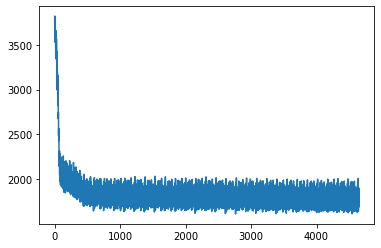

In [13]:
plt.plot(loss_record)

Reconstructing a random image from the training set :-

In [17]:
toy_lst = [('a', 0.9),('b', 0.6),('c', 0.8),('d', 0.86),('e', 0.6),('f', 0.76),('g', 0.9),('b', 0.6),('c', 0.8),('d', 0.86), ('f', 0.76),('a', 0.9),('b', 0.6),('c', 0.8),('d', 0.86), ('f', 0.76),('a', 0.9),('b', 0.6),('c', 0.8),('d', 0.86)]
toy_set = ['a', 'd', 'c', 'b', 'e', 'f', 'g']
out_profile = dst_mass_inferring(sampling_word_lst, [item[0] for item in train_user_token_lst], 80)
c = [item[0] for item in test_user_token_lst][::-1]
user_hashtags = custom_dataset.get_user_hashtags()


len(vocab_lst) =  19840
